In [1]:
import torch
from torch import nn
import numpy as np
import mdshare 
import mdtraj as md 
import glob
import torch.nn.functional as F
from ase import Atoms
from nglview import show_ase
import nglview as ng
import matplotlib.pyplot as plt


In [2]:
# build dataset and dataloader 
k = 10000
batch = 40

#langevin
data = np.load('NOSE_HOOVER/N_70.npy')
data_F = np.load('NOSE_HOOVER/N_70_F.npy')

train_xyz = torch.Tensor(data[:k])
train_f   = torch.Tensor(data_F[:k]).reshape(int(k/batch), batch, 70, 3)

test_xyz  = torch.Tensor(data[k:])
test_f    = torch.Tensor(data_F[k:])


trainset = torch.utils.data.TensorDataset(train_xyz)
#testset  = torch.utils.data.TensorDataset(test_xyz)

#trainset_f = torch.utils.data.TensorDataset(train_f)
#testset_f  = torch.utils.data.TensorDataset(test_f)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=True)
#testloader  = torch.utils.data.DataLoader(testset,  batch_size=25, shuffle=True)

#trainloader_f = torch.utils.data.DataLoader(trainset_f, batch_size=40, shuffle=True)
#testloader_f  = torch.utils.data.DataLoader(testset_f,  batch_size=25, shuffle=True)

In [3]:
# define a CGAE

class cgae(nn.Module):
    
    def __init__(self, n_atoms, n_cgs):
        super().__init__()

        assign_map = torch.randn(n_atoms, n_cgs)
        decode = torch.randn(n_cgs, n_atoms)
        
        
        self.n_atoms = n_atoms 
        self.assign_map = nn.Parameter(assign_map)
        self.decode = nn.Parameter(decode)
        
    def forward(self, xyz, tau=1.0):
        
        # recenter coordinates 
        xyz = xyz.reshape(-1, self.n_atoms, 3)
        shift = xyz.mean(1)
        xyz = xyz - shift.unsqueeze(1)
        
        # get discrete assignment map
        M = F.gumbel_softmax(self.assign_map, dim=-1)
        M_norm = M / M.sum(-2).unsqueeze(-2)
        
        cg_xyz = torch.einsum('bij,in->bnj', xyz, M_norm)
        xyz_recon = torch.einsum('bnj,ni->bij', cg_xyz, self.decode)
        
        return xyz, xyz_recon, M, M_norm, cg_xyz

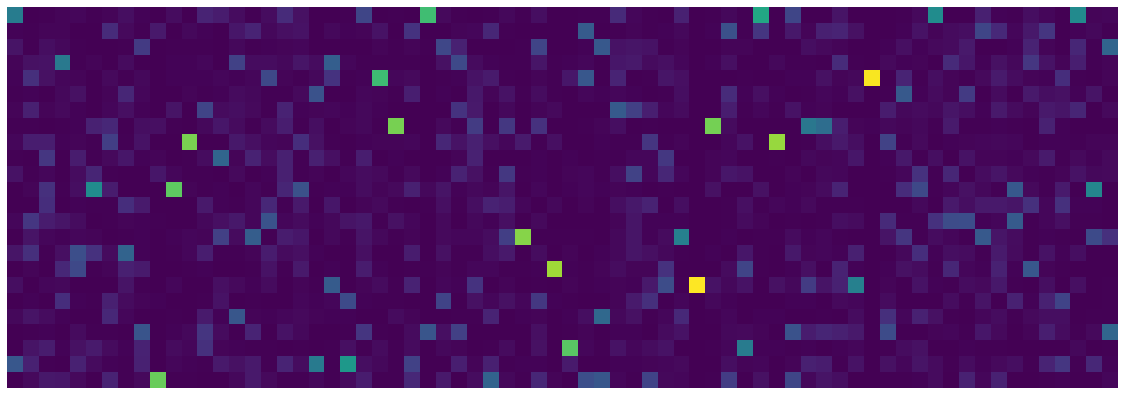

24 0 0.999 324.92009325027465


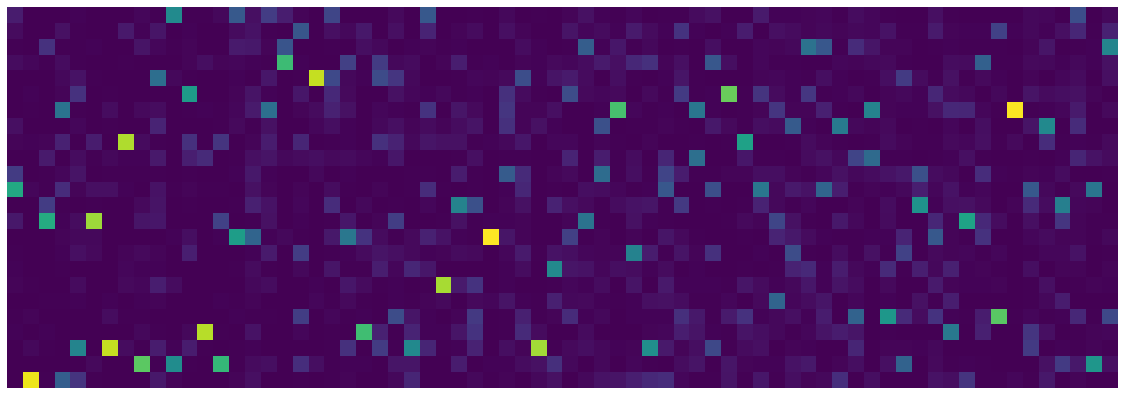

24 1 0.998 176.90639660358428


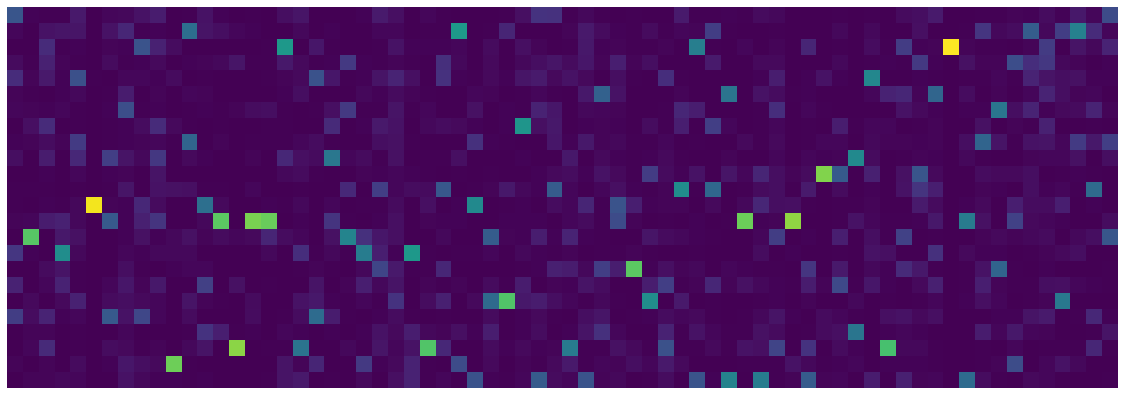

24 2 0.997 96.12693815231323


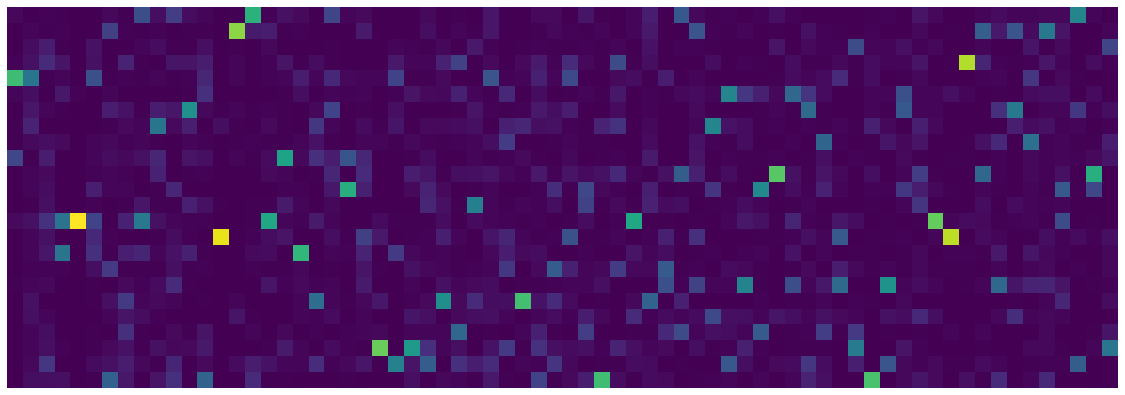

24 3 0.996 59.17295313477516


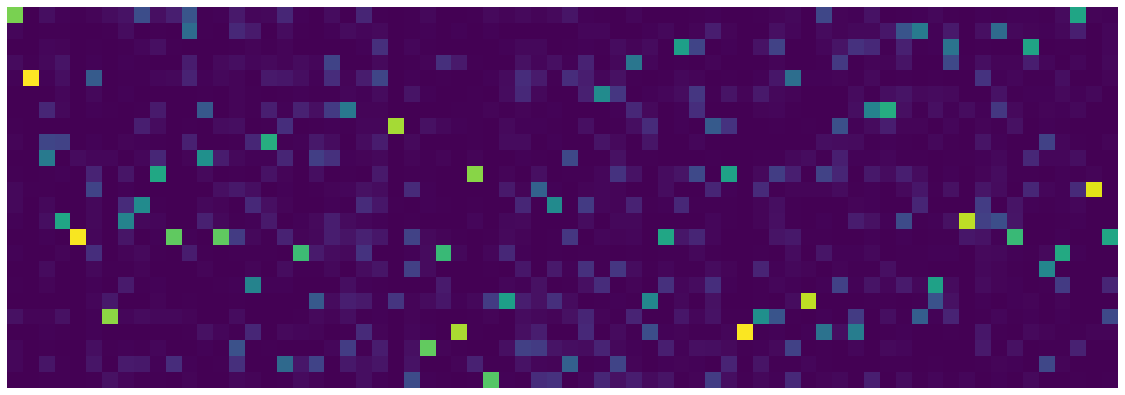

24 4 0.995 36.65824509263039


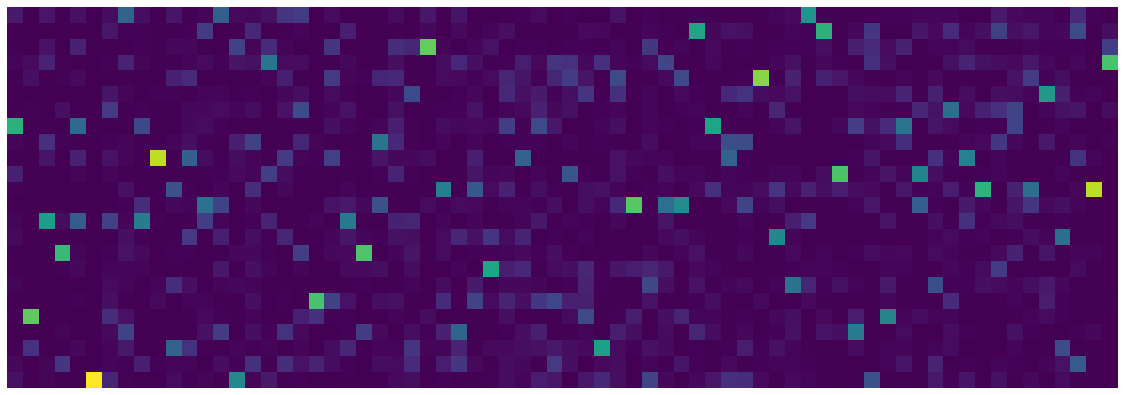

24 5 0.994 25.396906787157057


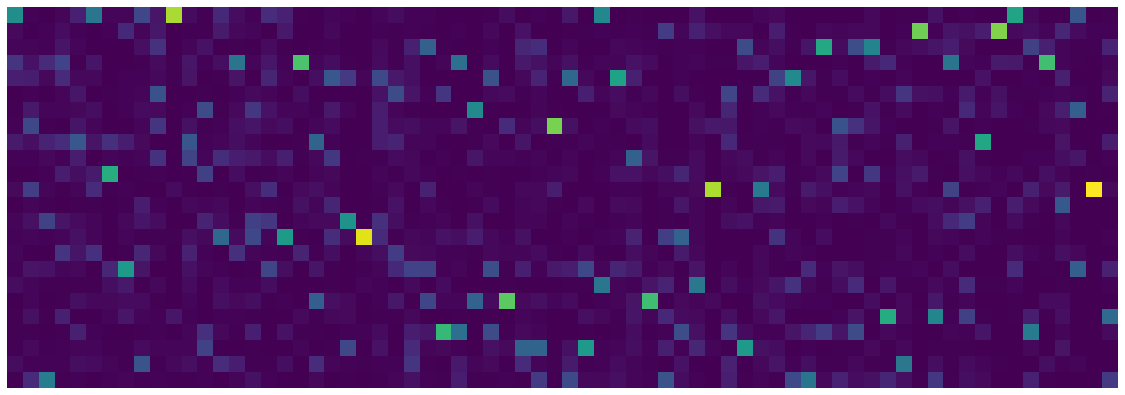

24 6 0.993 16.79606311619282


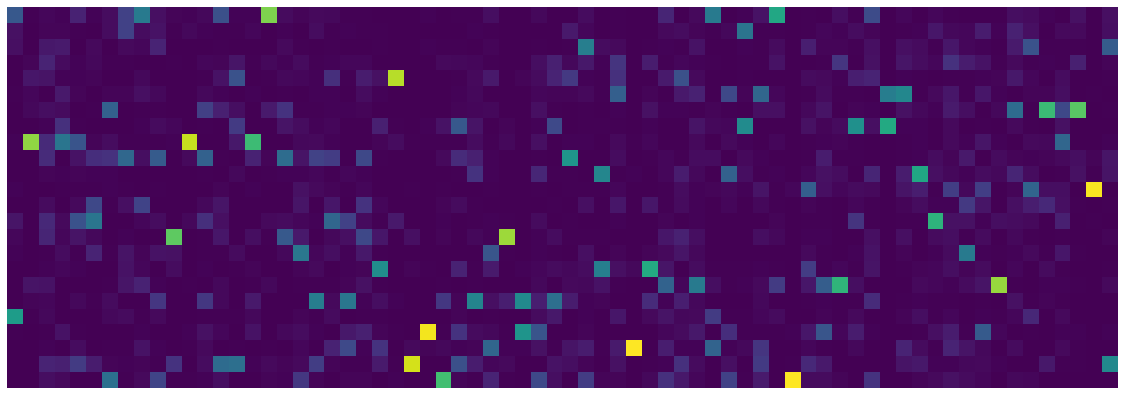

24 7 0.992 12.95263870805502


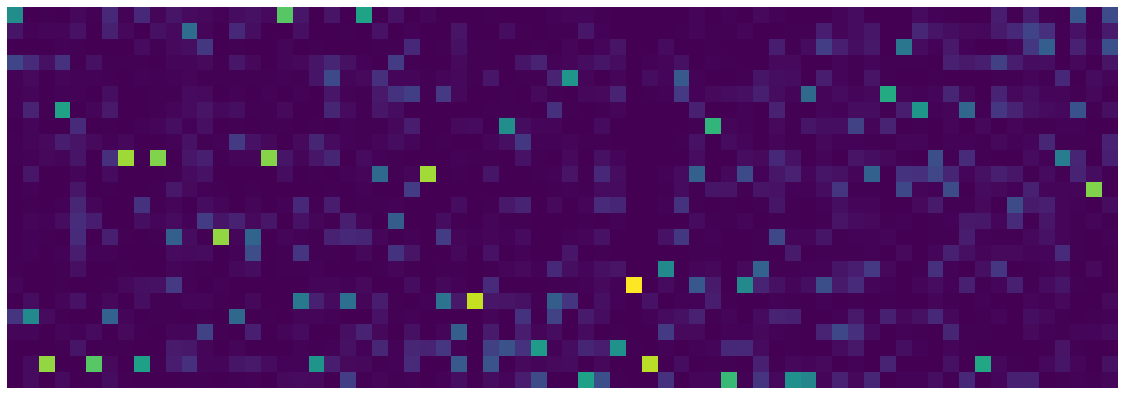

24 8 0.991 10.025961309671402


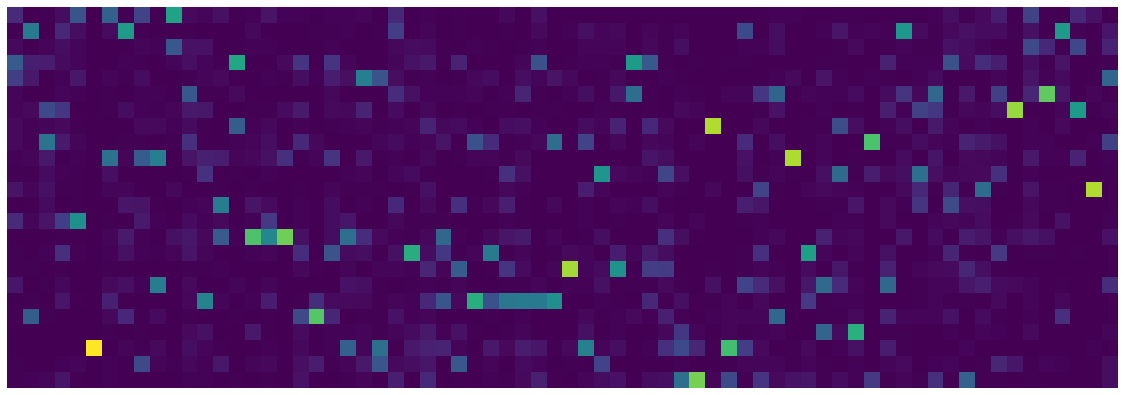

24 9 0.99 8.526936452835798


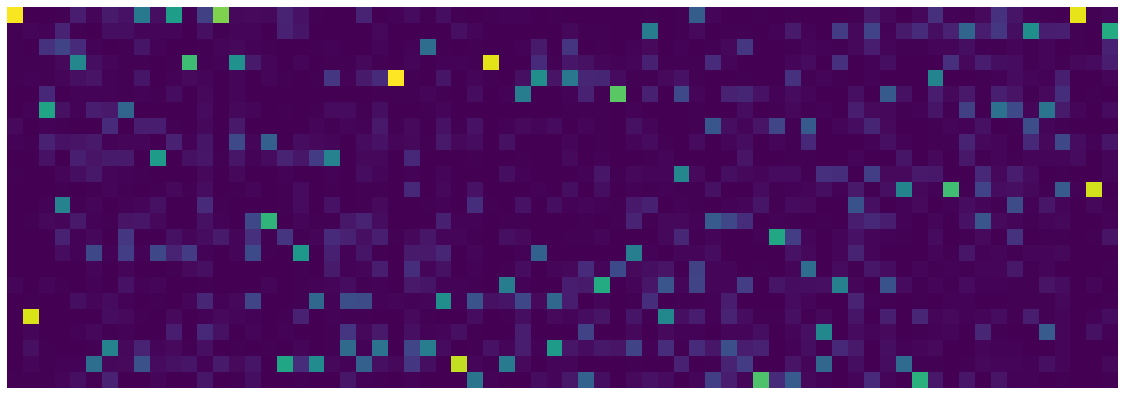

24 10 0.989 6.939166363328695


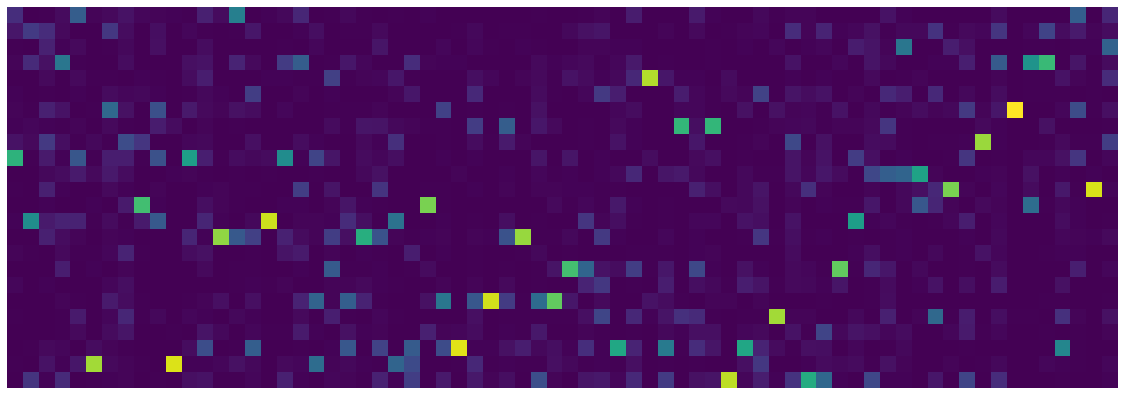

24 11 0.988 7.034911199659109


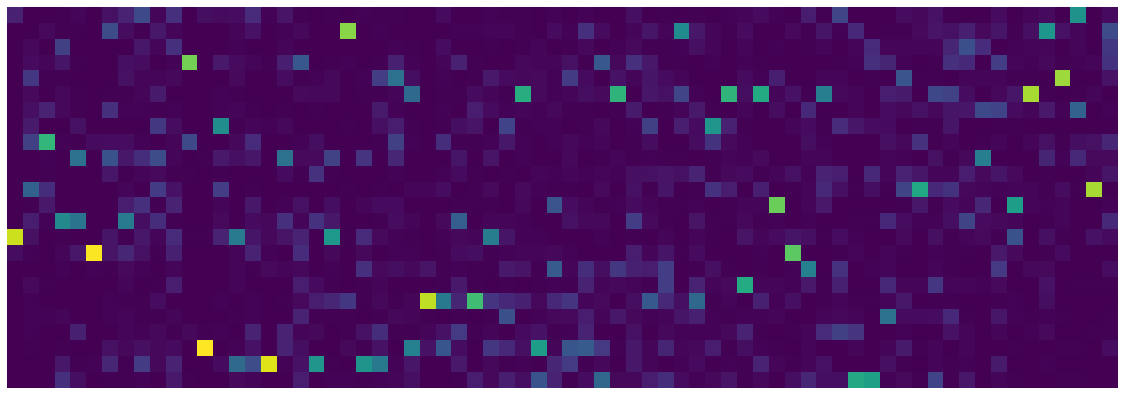

24 12 0.987 6.23336887434125


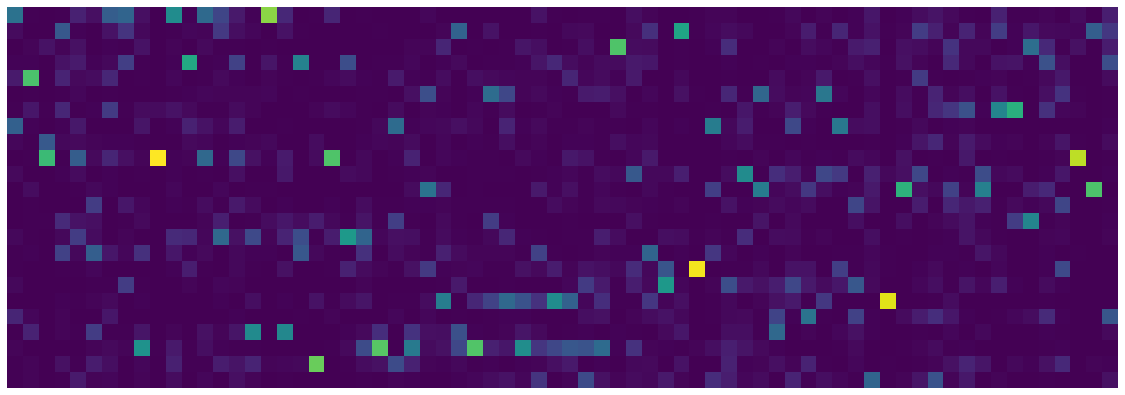

24 13 0.986 5.569657612591982


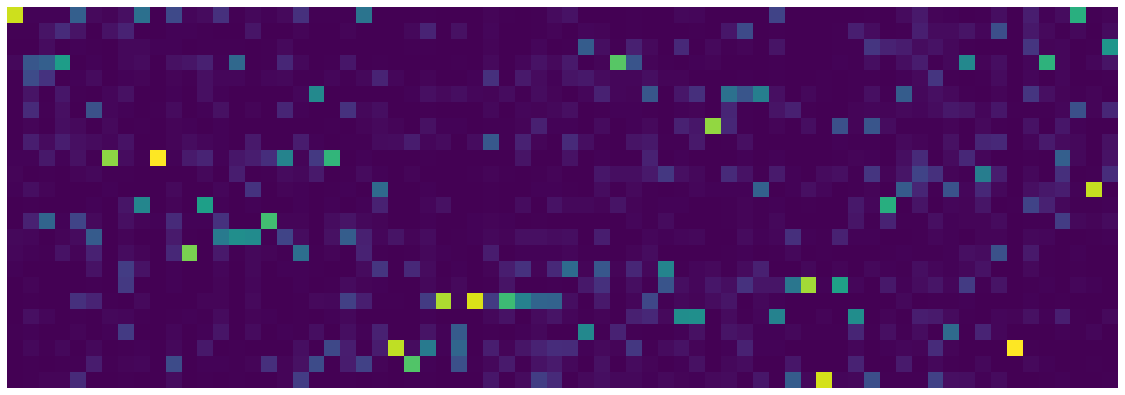

24 14 0.985 5.568644943833351


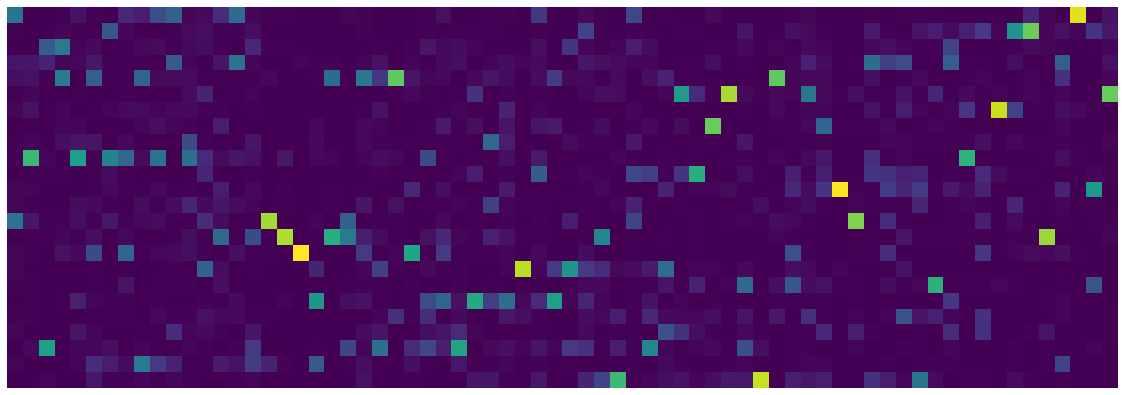

24 15 0.984 5.077538783103227


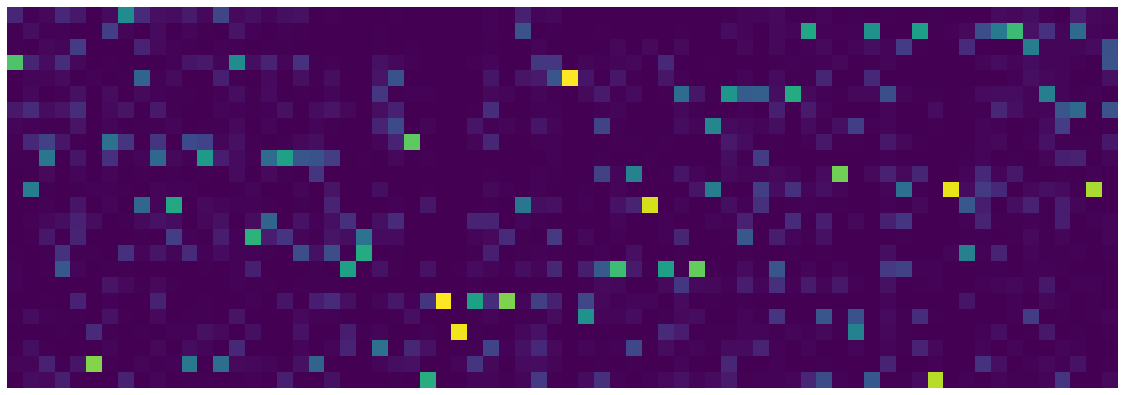

24 16 0.983 4.62678372785449


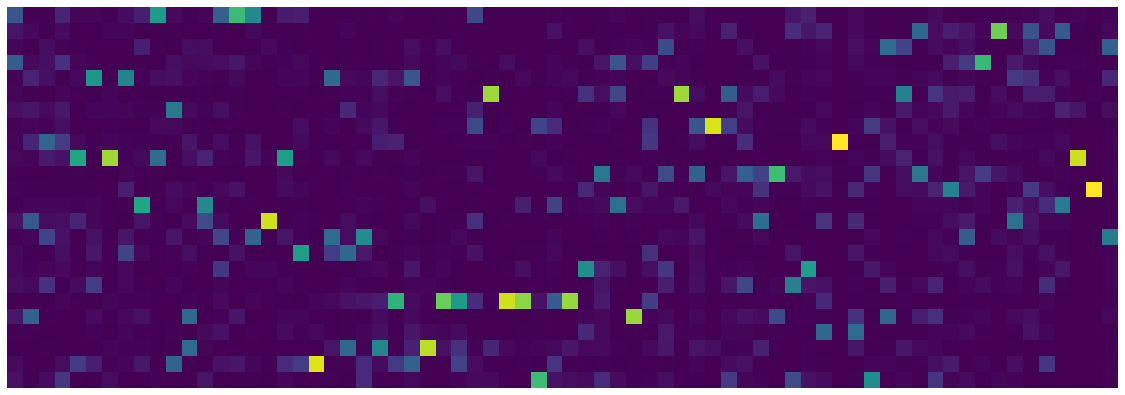

24 17 0.982 4.37034802287817


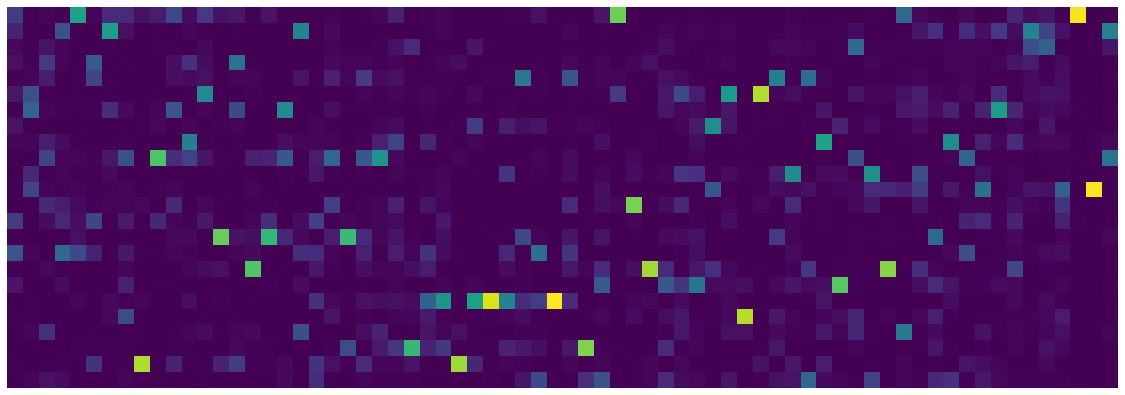

24 18 0.981 4.103117141127586


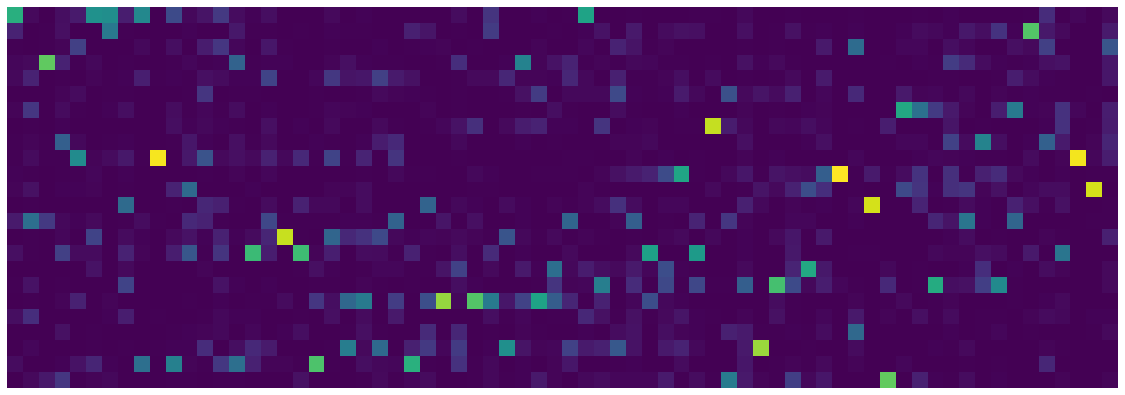

24 19 0.98 3.9886162601411344


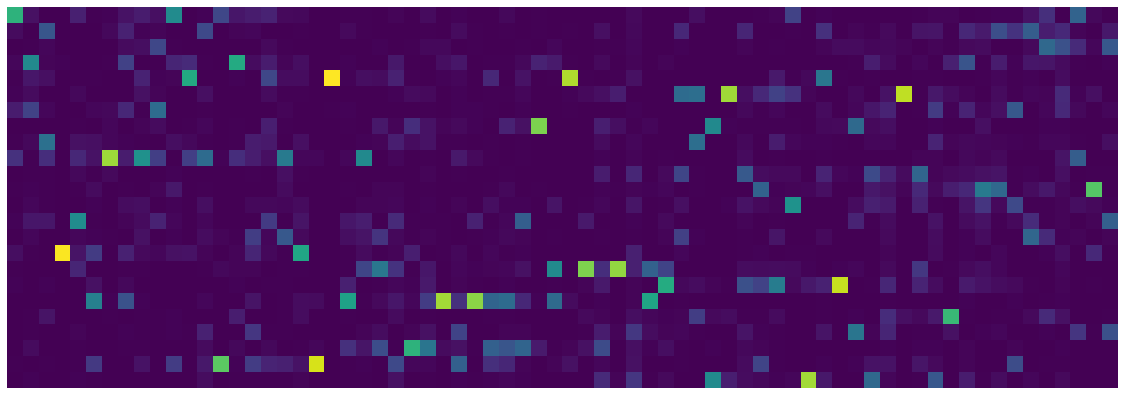

24 20 0.979 3.6446968272328375


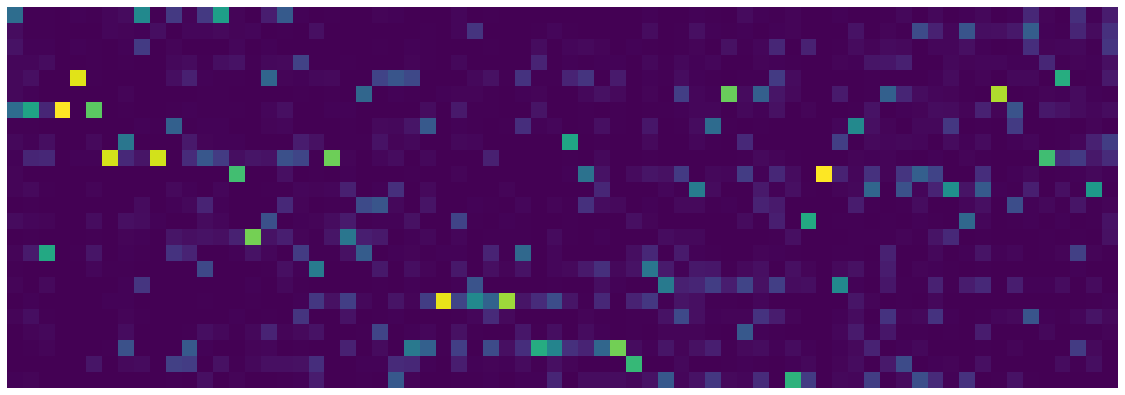

24 21 0.978 3.481334963440895


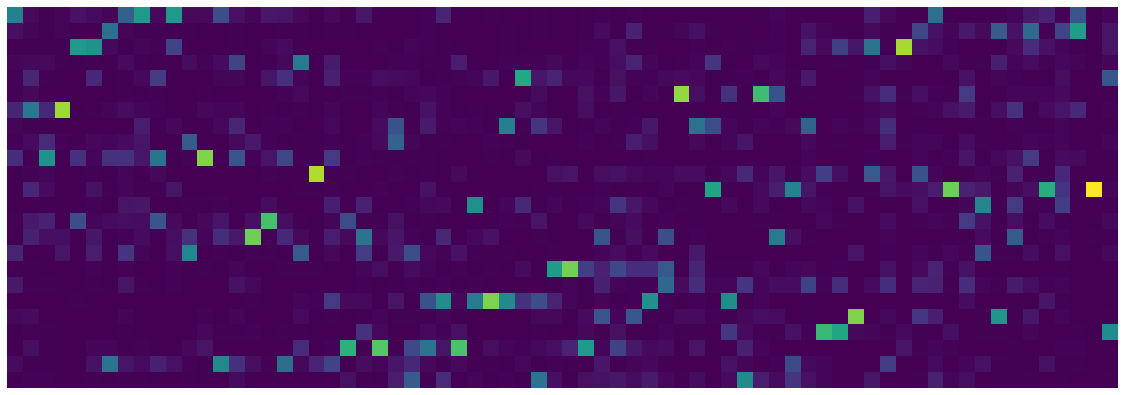

24 22 0.977 3.382956387847662


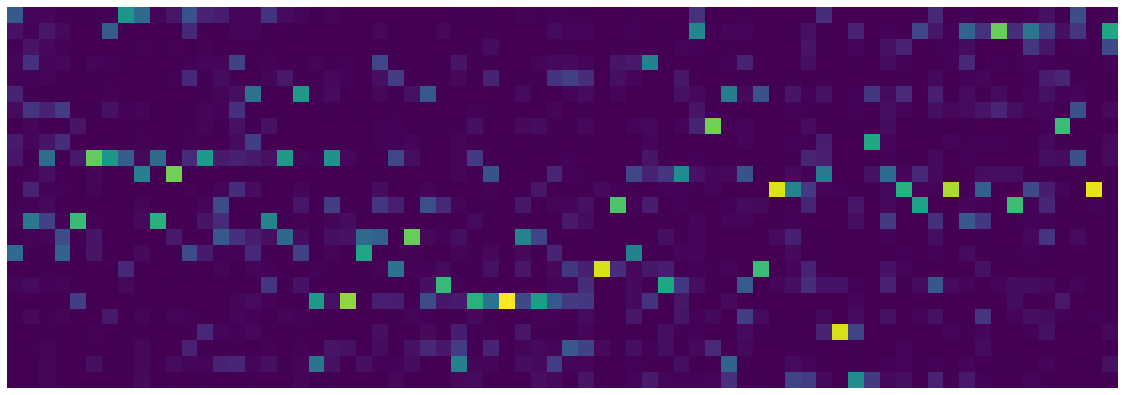

24 23 0.976 3.2847662597894667


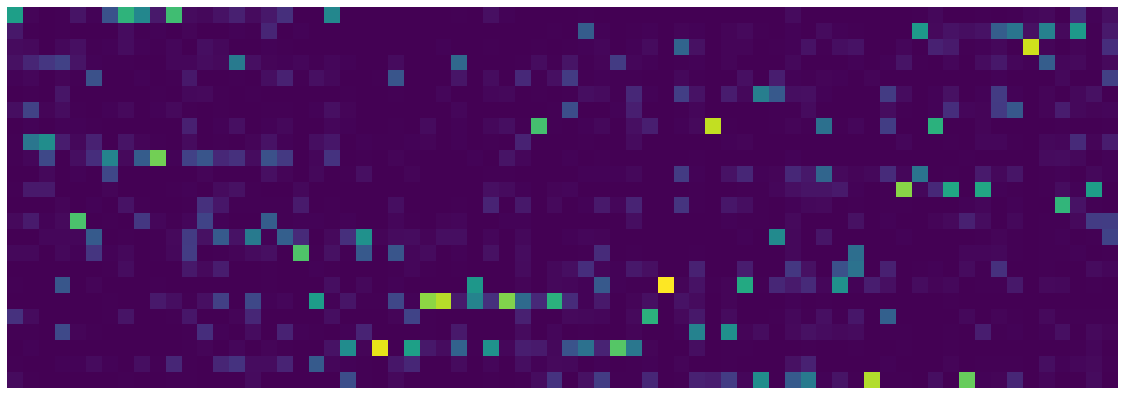

24 24 0.975 3.139393662661314


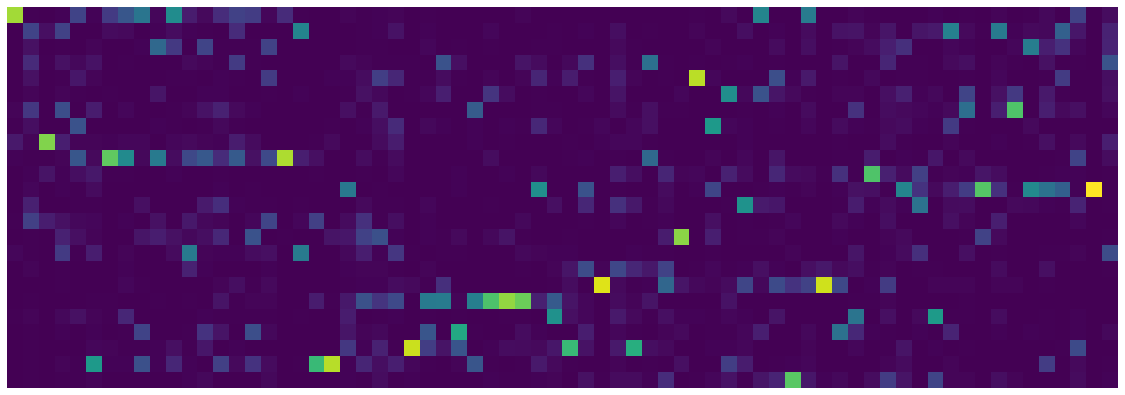

24 25 0.974 3.0207724422216415


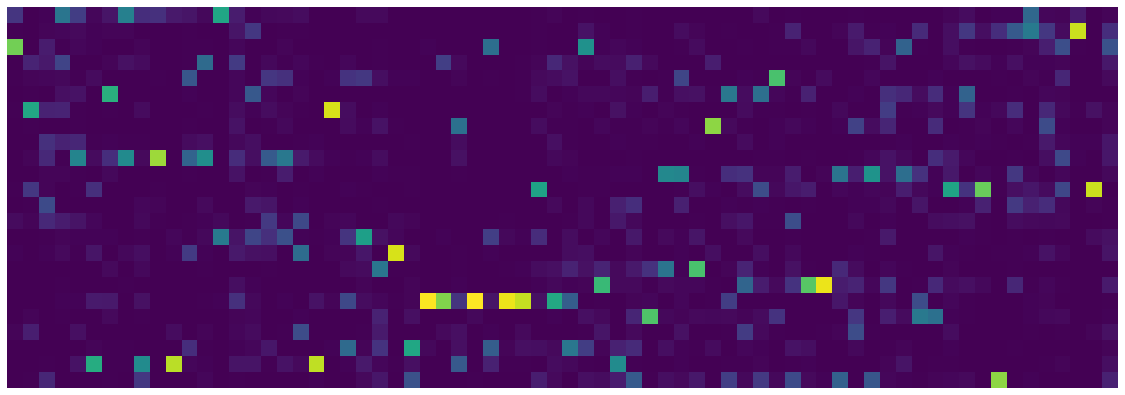

24 26 0.973 2.867756377160549


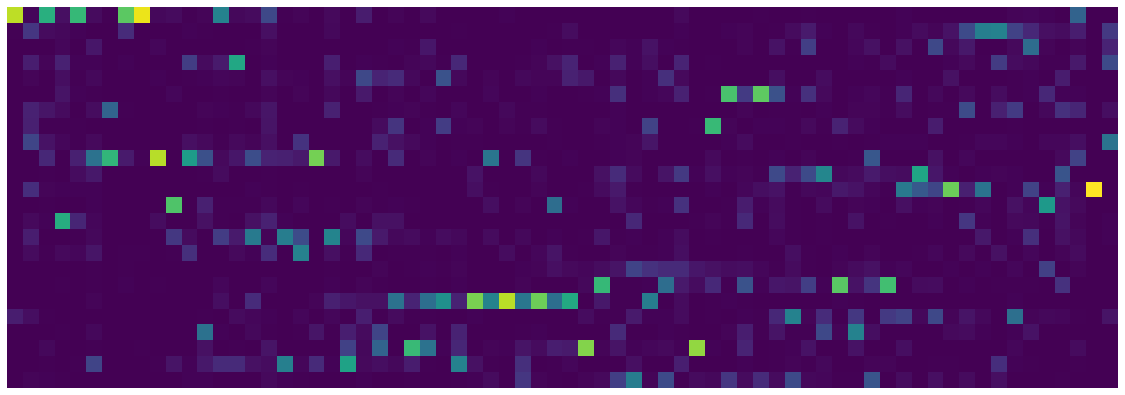

24 27 0.972 2.754381810873747


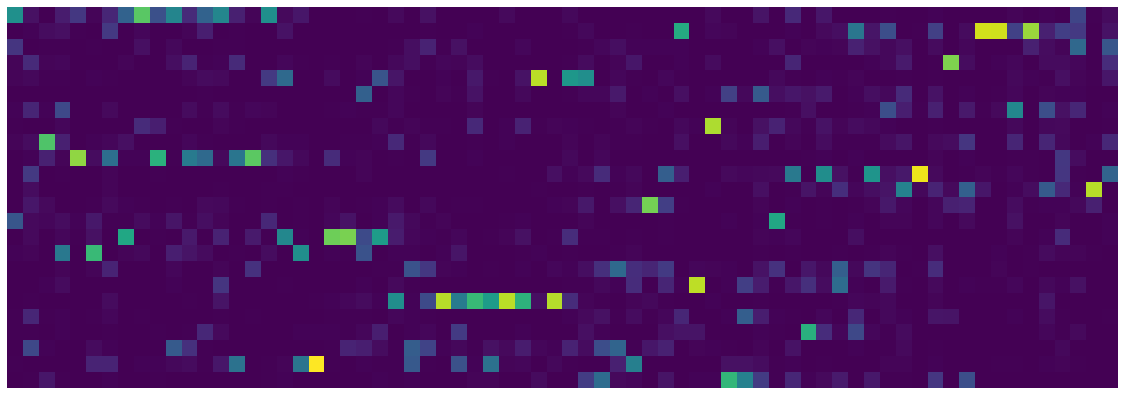

24 28 0.971 2.757954724505544


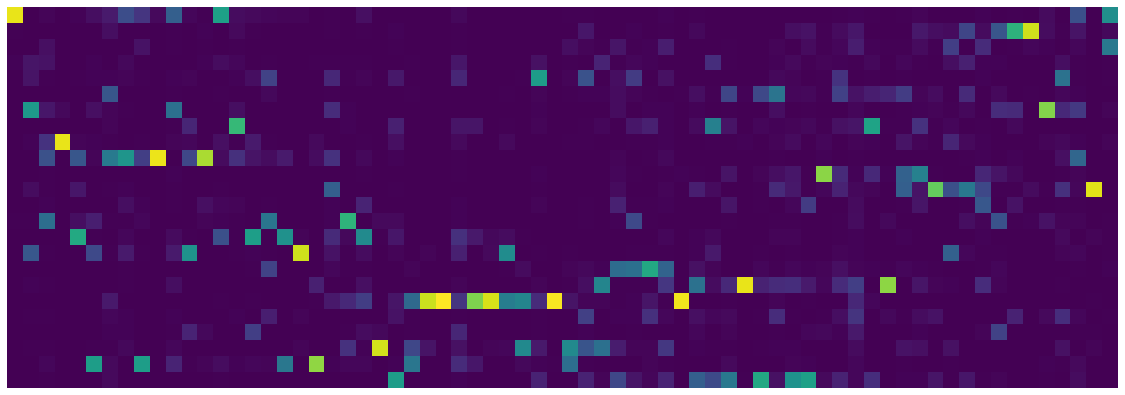

24 29 0.97 2.6205980688333512


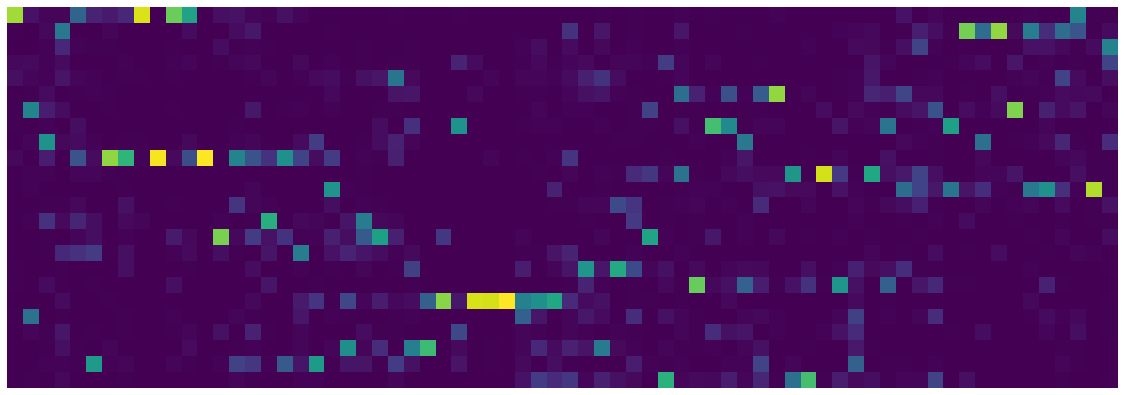

24 30 0.969 2.4702659472823143


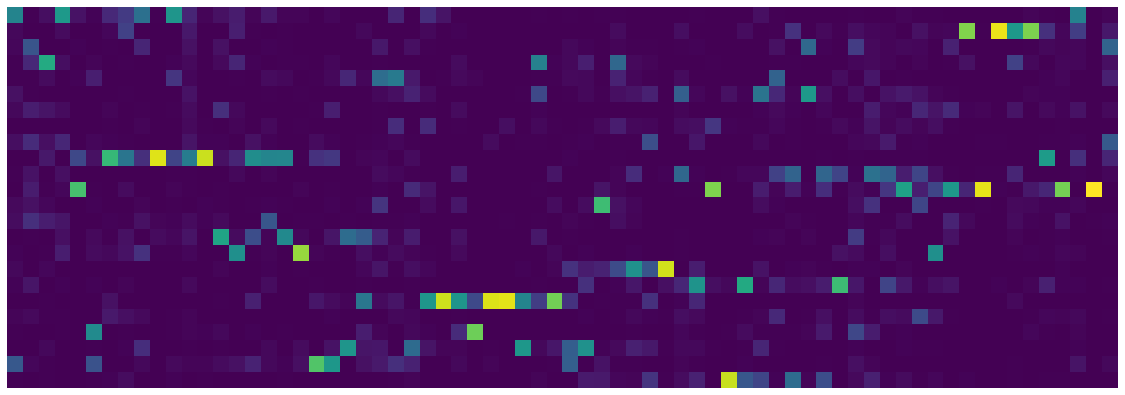

24 31 0.968 2.5439891930669547


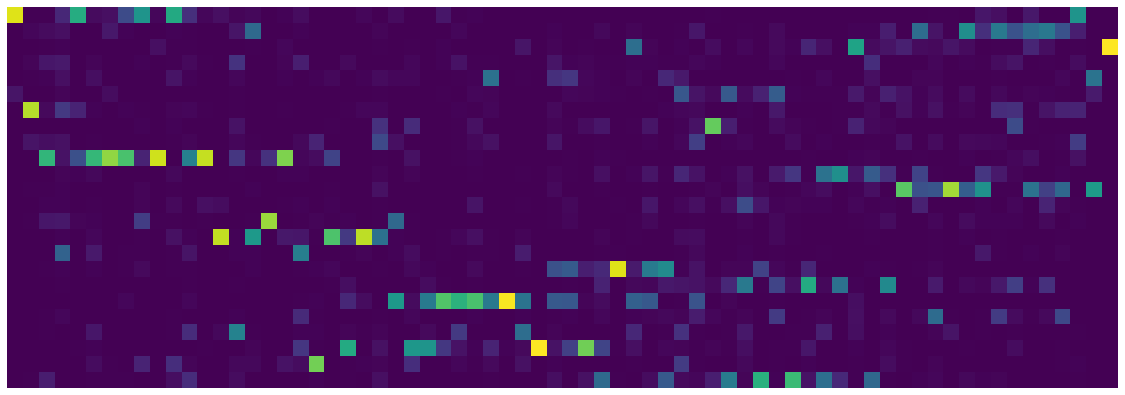

24 32 0.967 2.399710372462869


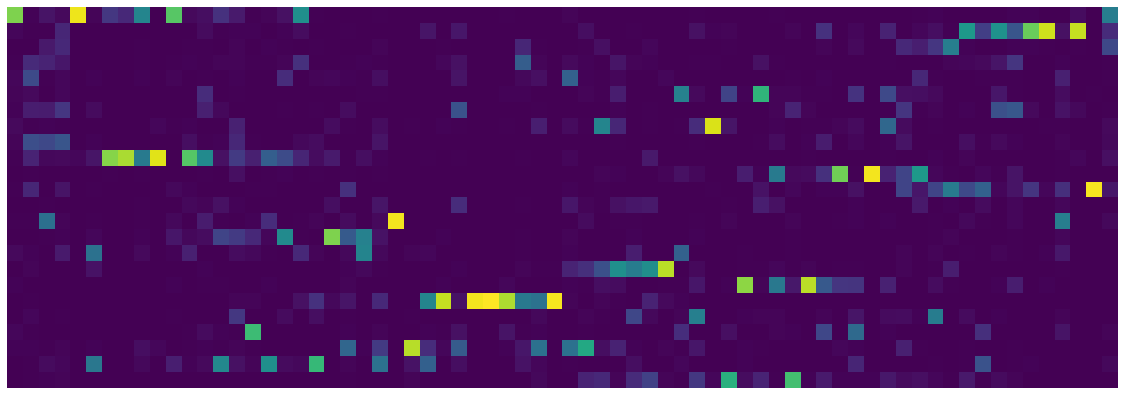

24 33 0.966 2.344471136108041


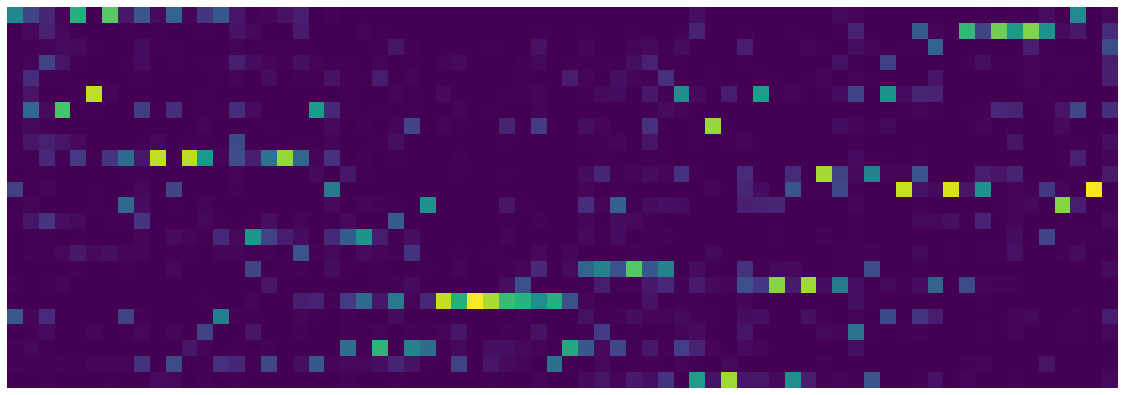

24 34 0.965 2.1575137238949536


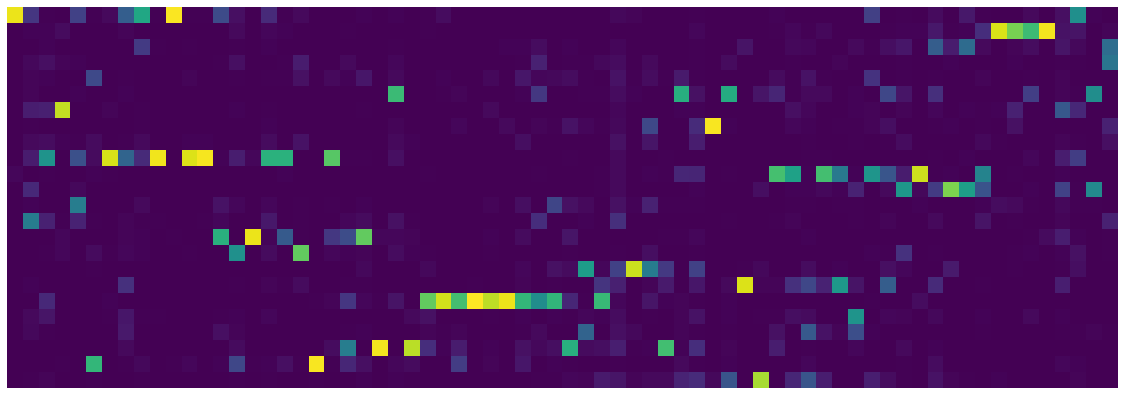

24 35 0.964 2.061515620723367


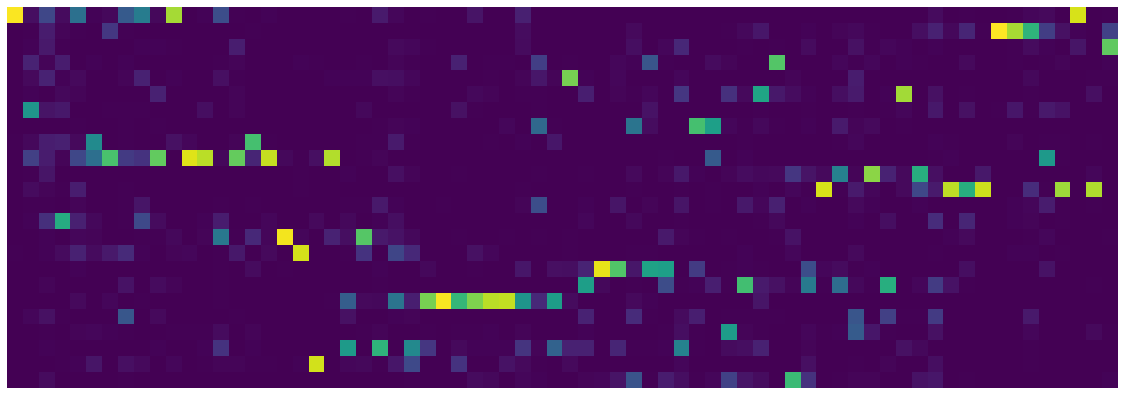

24 36 0.963 2.0447199802845715


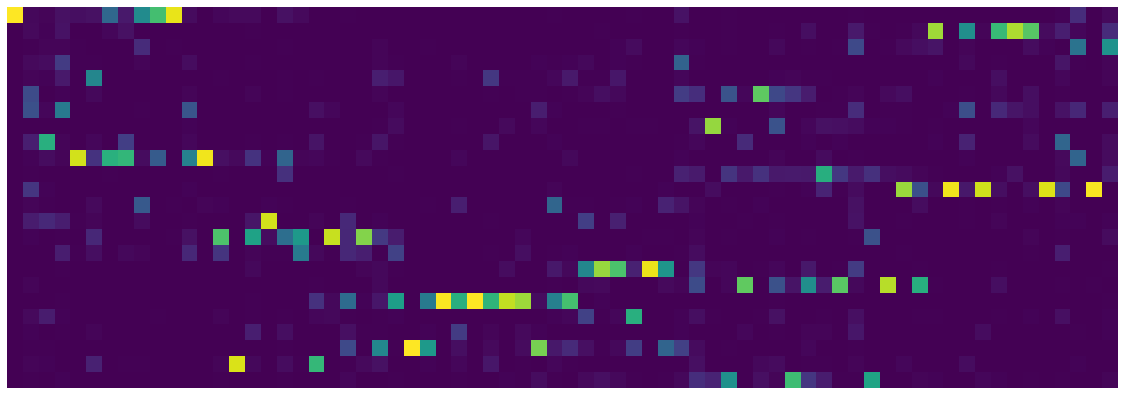

24 37 0.962 1.9629201371222735


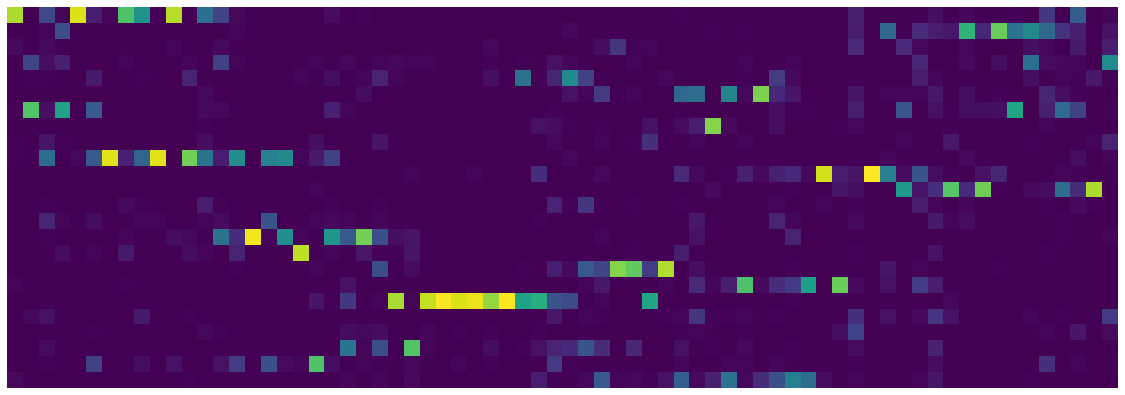

24 38 0.961 1.9008729226887227


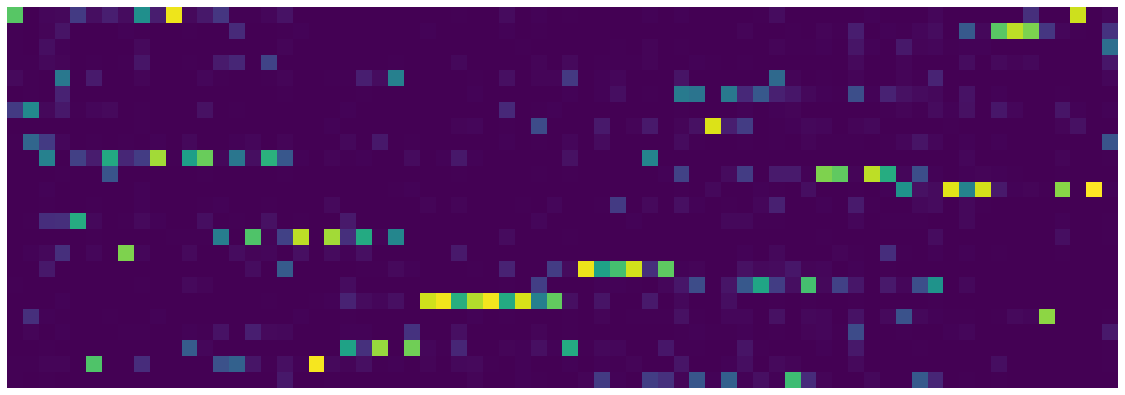

24 39 0.96 1.7774555578827858


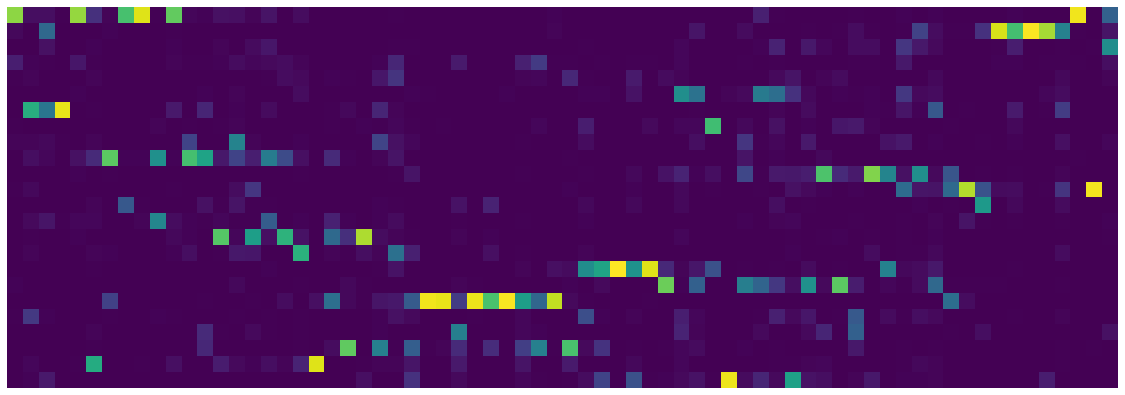

24 40 0.959 1.721874252706766


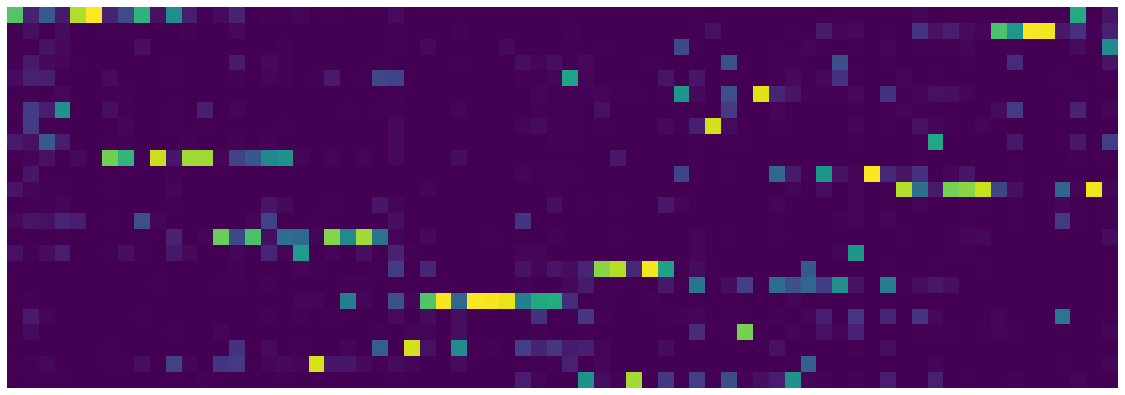

24 41 0.958 1.6148464281111956


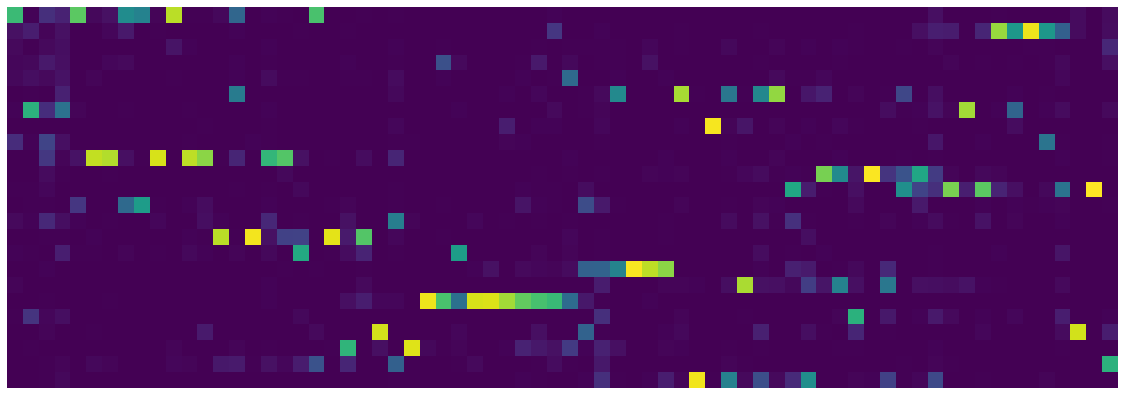

24 42 0.957 1.513405841961503


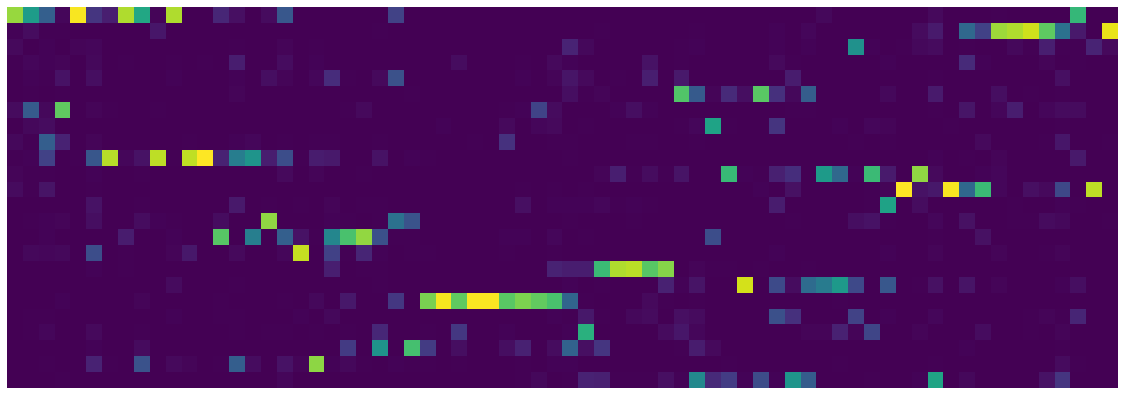

24 43 0.956 1.5059232763946055


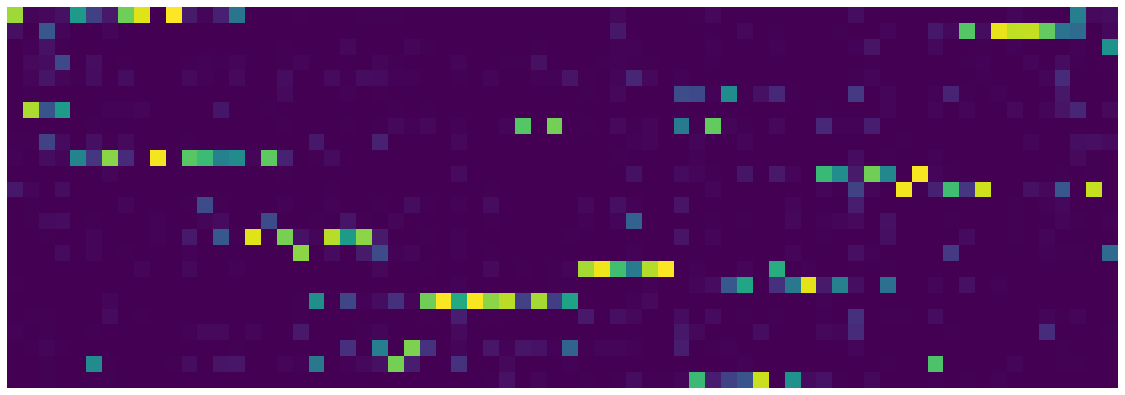

24 44 0.955 1.4310607112944127


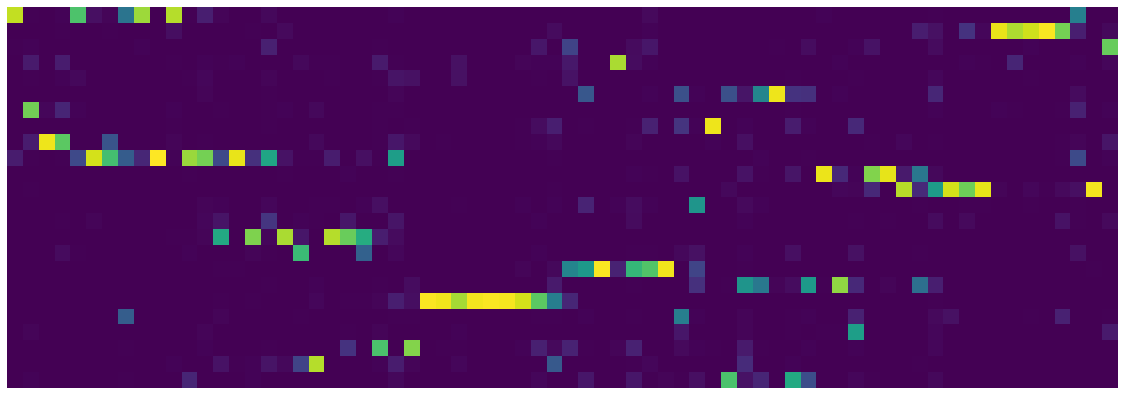

24 45 0.954 1.3336798250675201


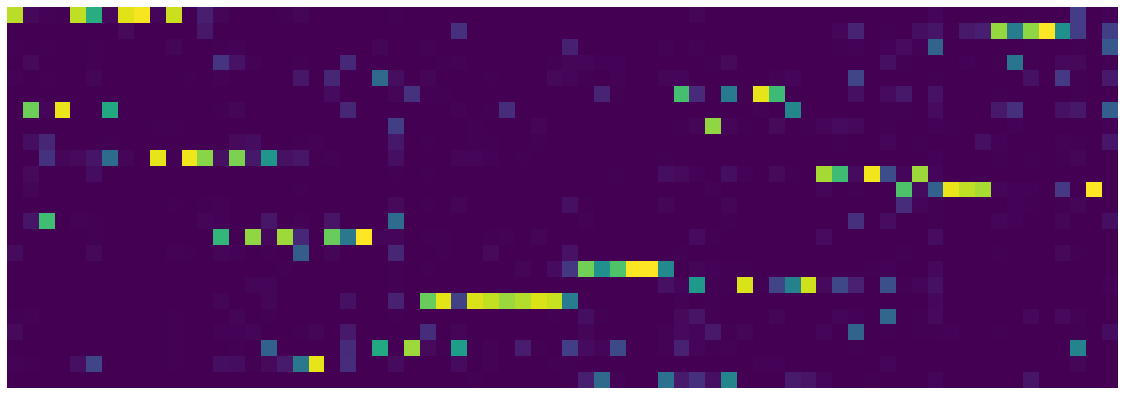

24 46 0.953 1.2787627175450325


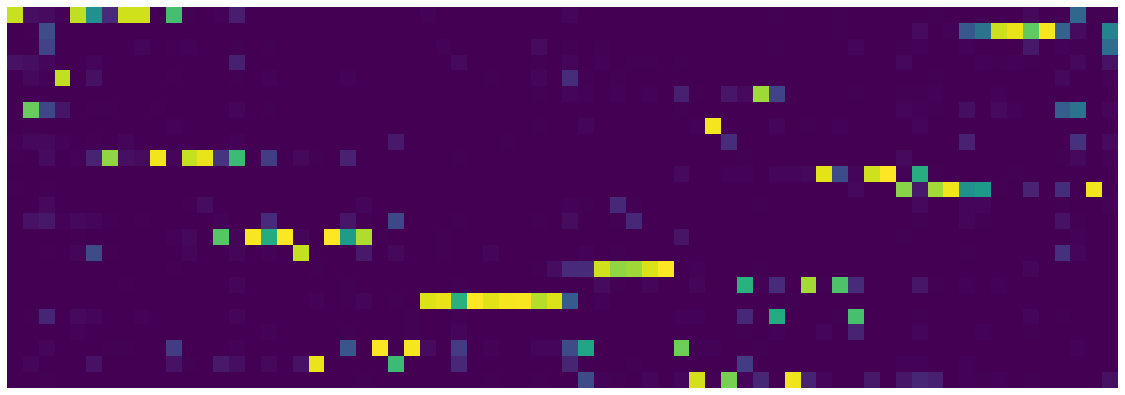

24 47 0.952 1.2346730079501866


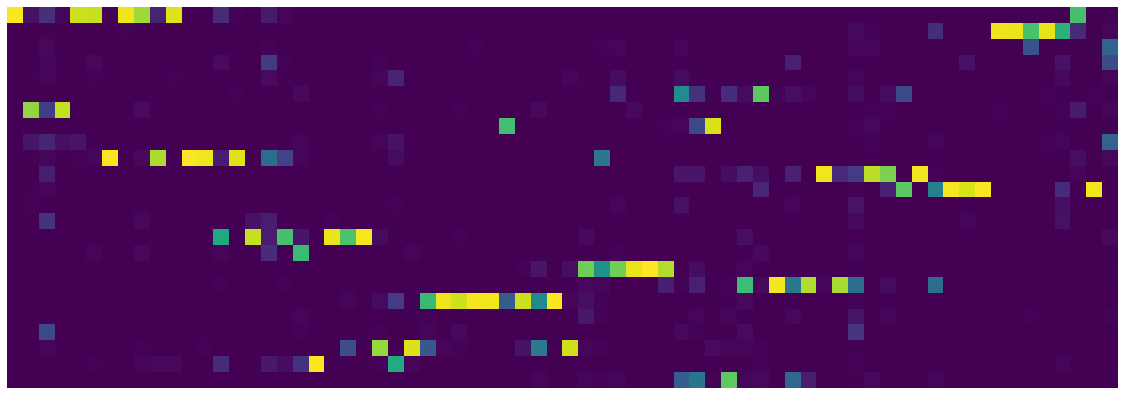

24 48 0.951 1.1953666485846042


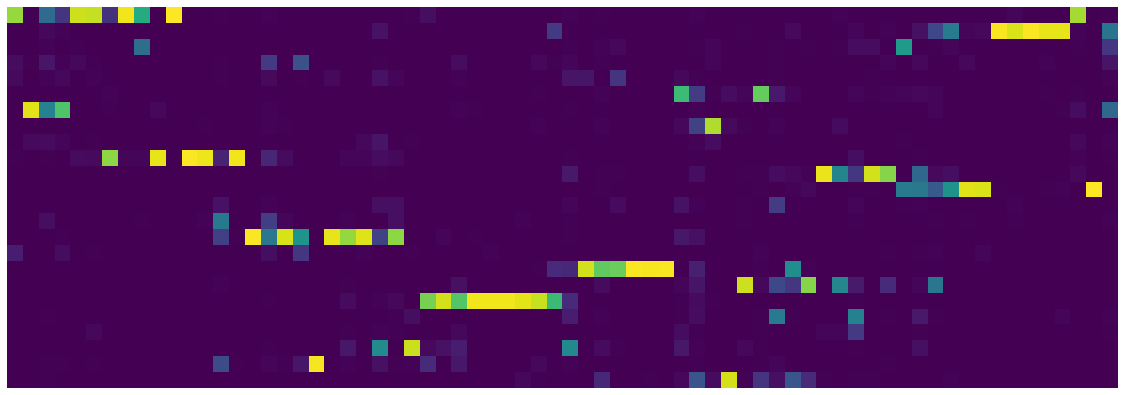

24 49 0.95 1.095884282514453


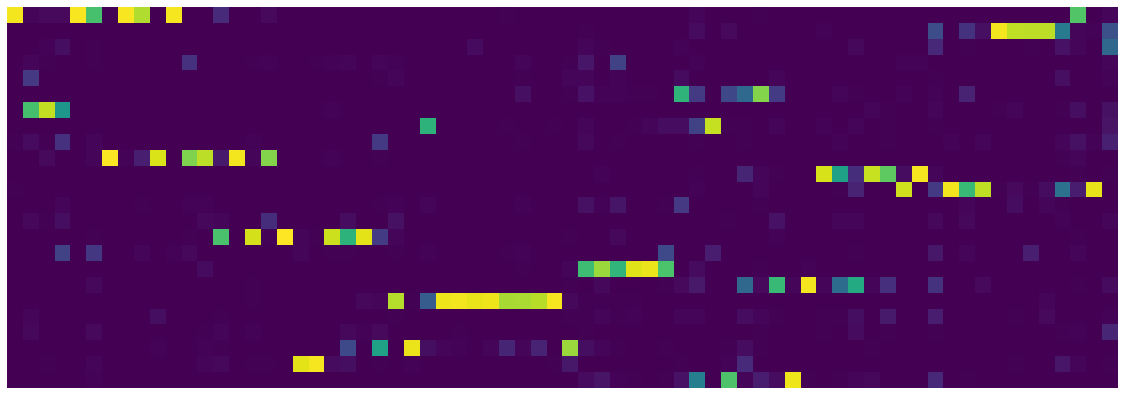

24 50 0.949 1.1110367752611636


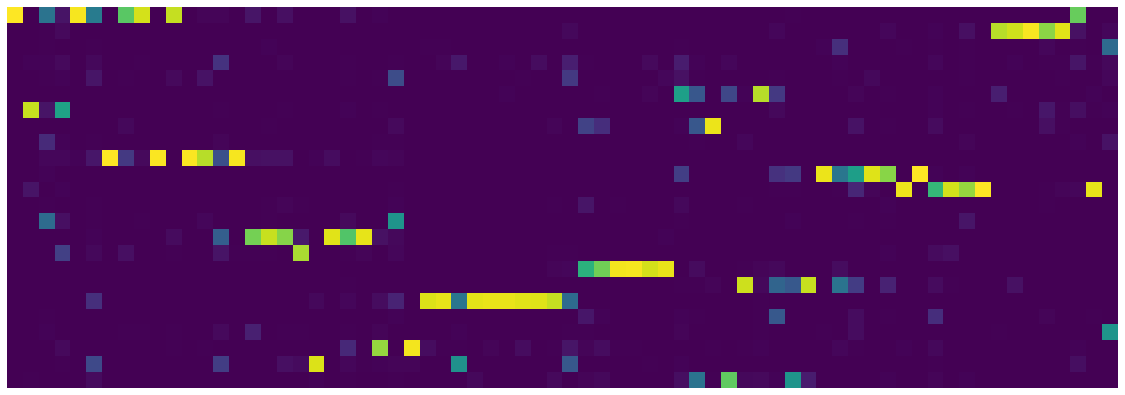

24 51 0.948 1.015064961463213


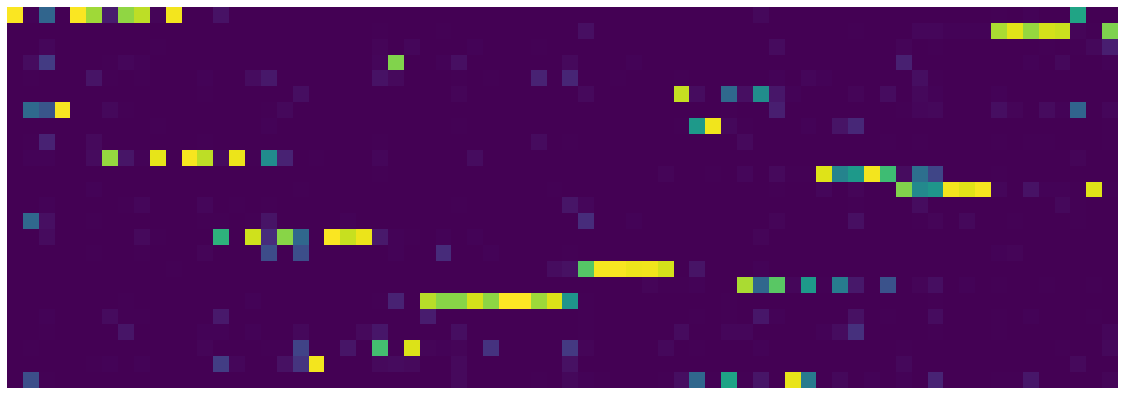

24 52 0.947 1.0170540982857346


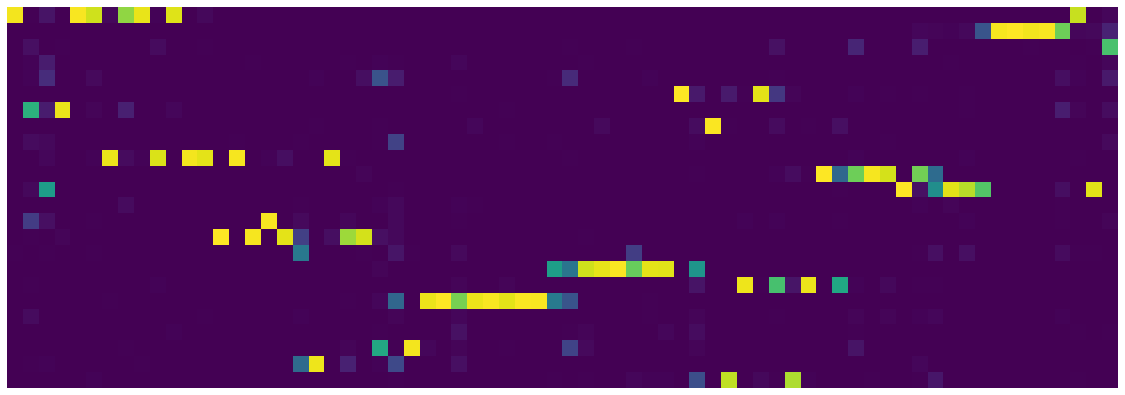

24 53 0.946 0.9724773552268744


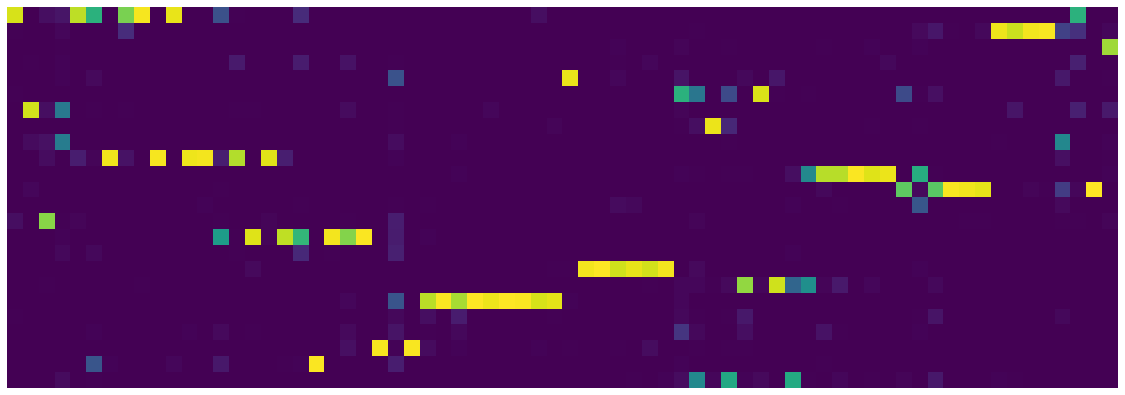

24 54 0.945 0.9472049599513411


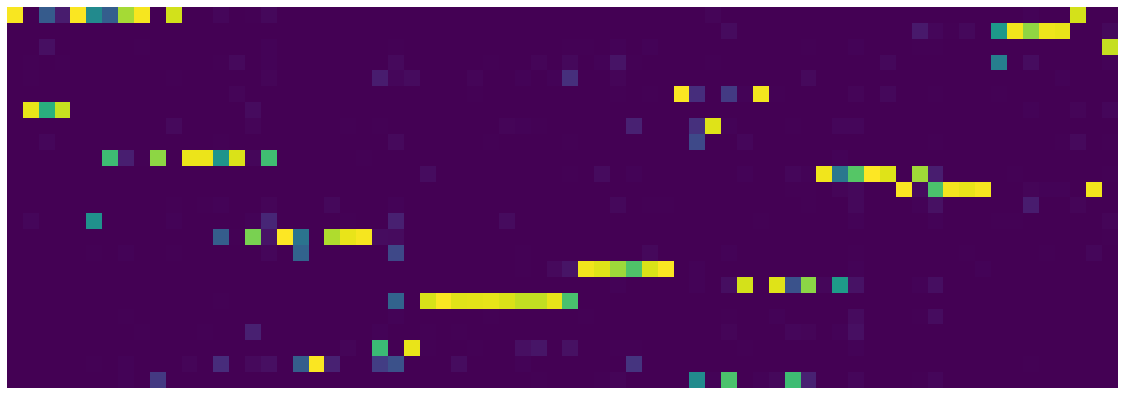

24 55 0.944 0.9149235632270575


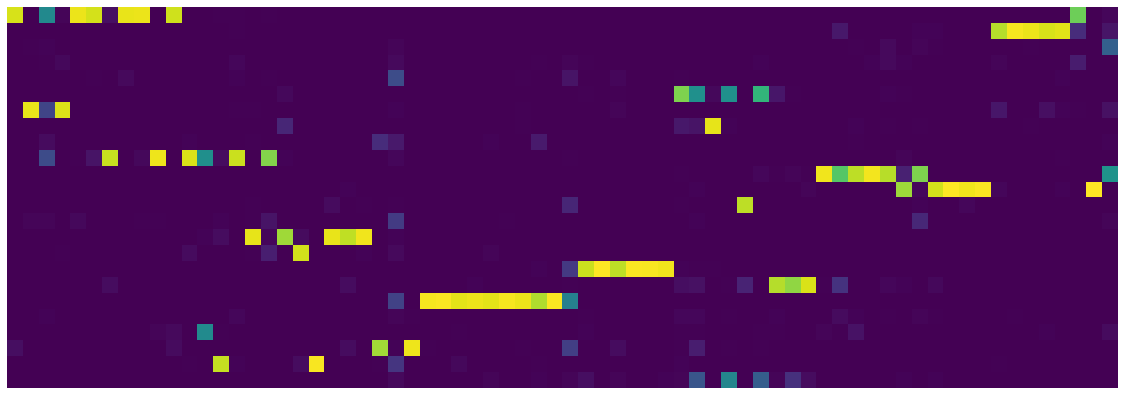

24 56 0.943 0.8906445488333702


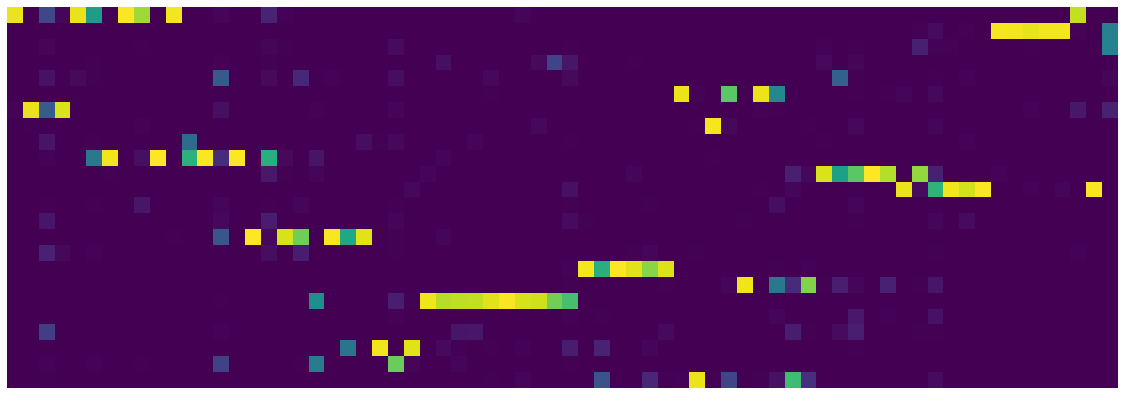

24 57 0.942 0.8622872937470675


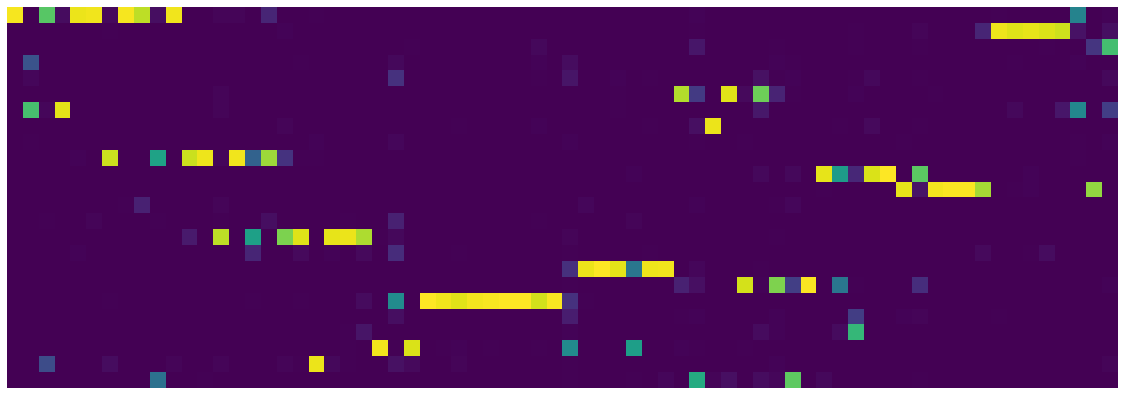

24 58 0.941 0.8427162369713187


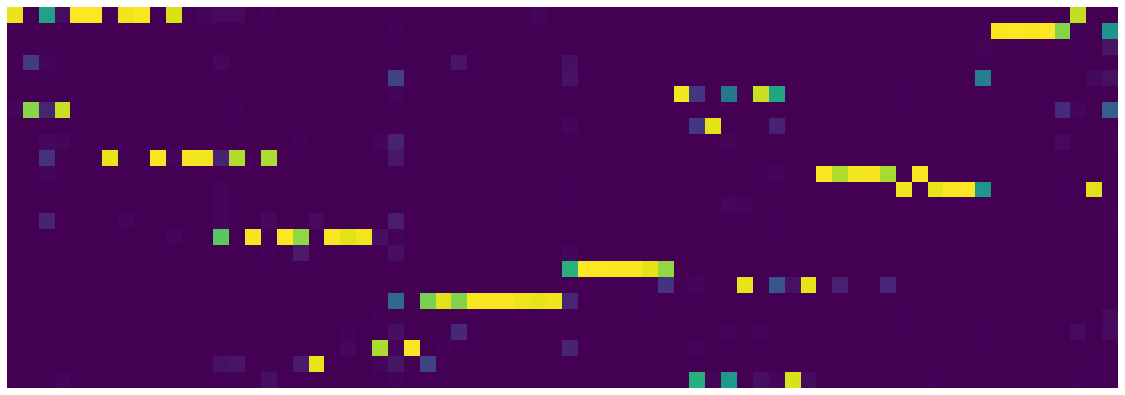

24 59 0.94 0.8212397441267967


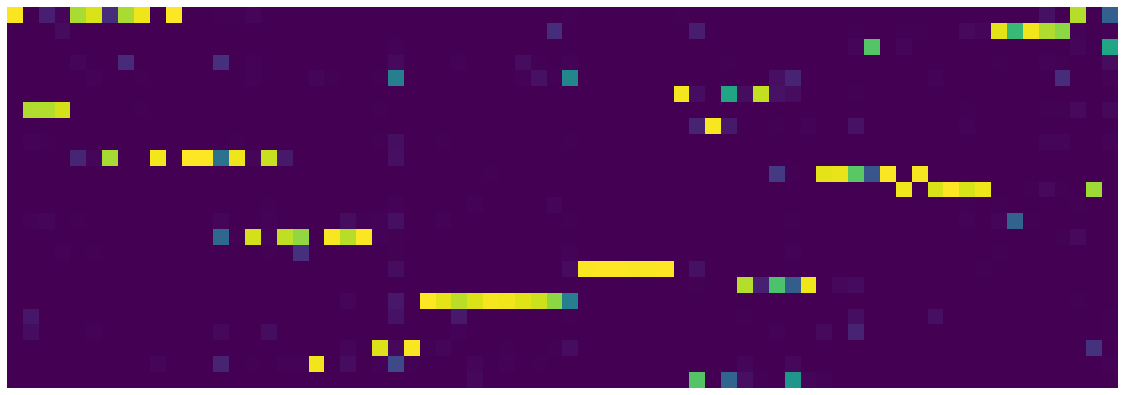

24 60 0.939 0.7921740766614676


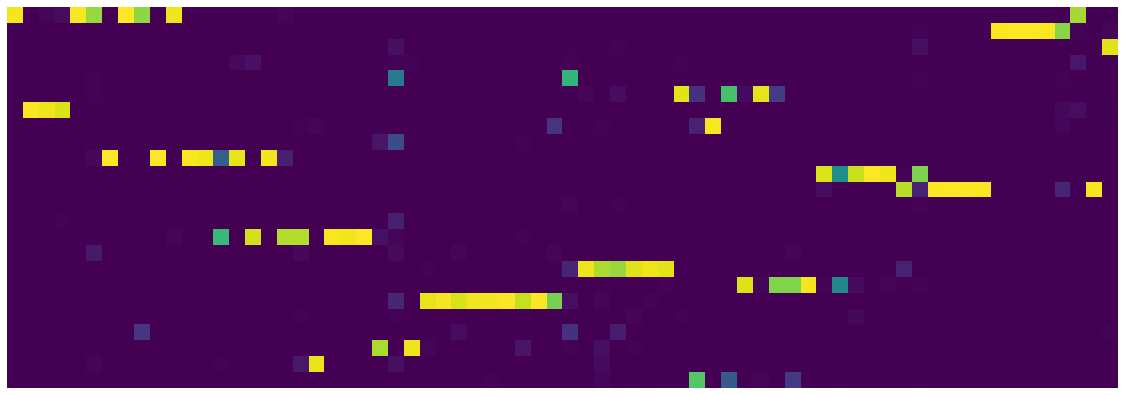

24 61 0.938 0.7591794406995177


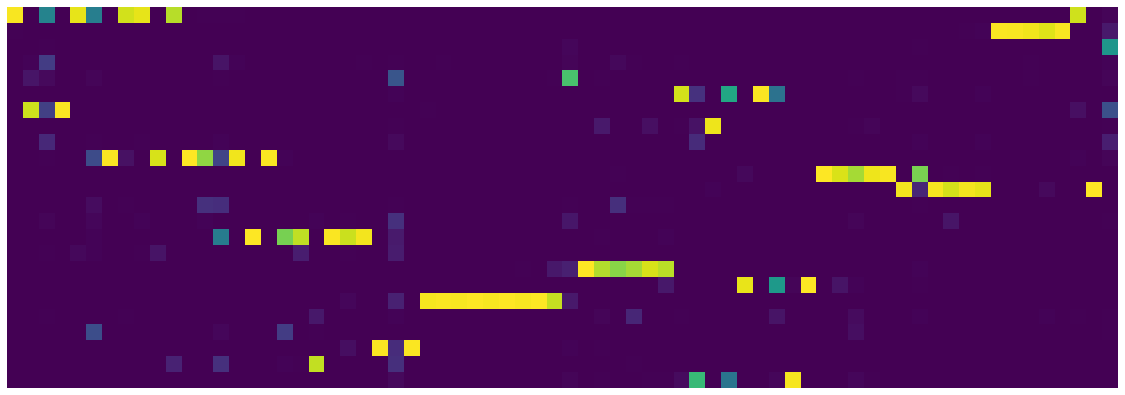

24 62 0.9369999999999999 0.7363416809588671


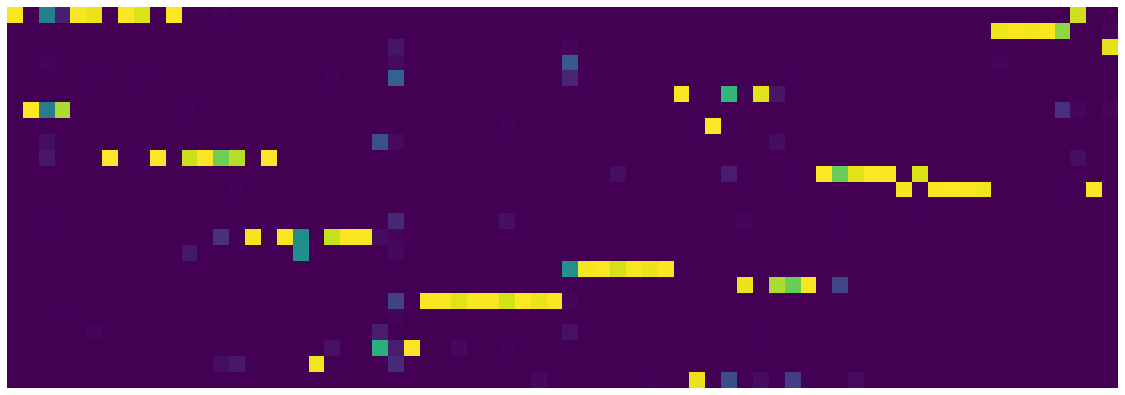

24 63 0.9359999999999999 0.7351738173514605


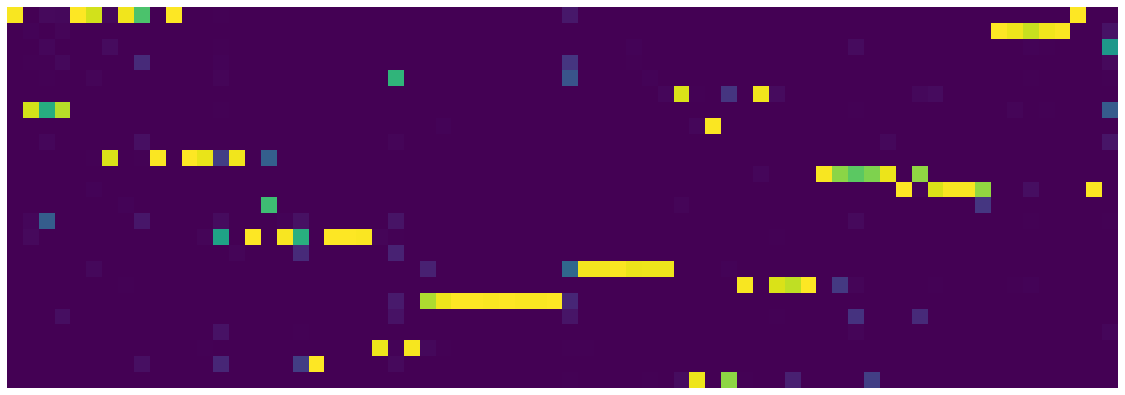

24 64 0.9349999999999999 0.7169247929006815


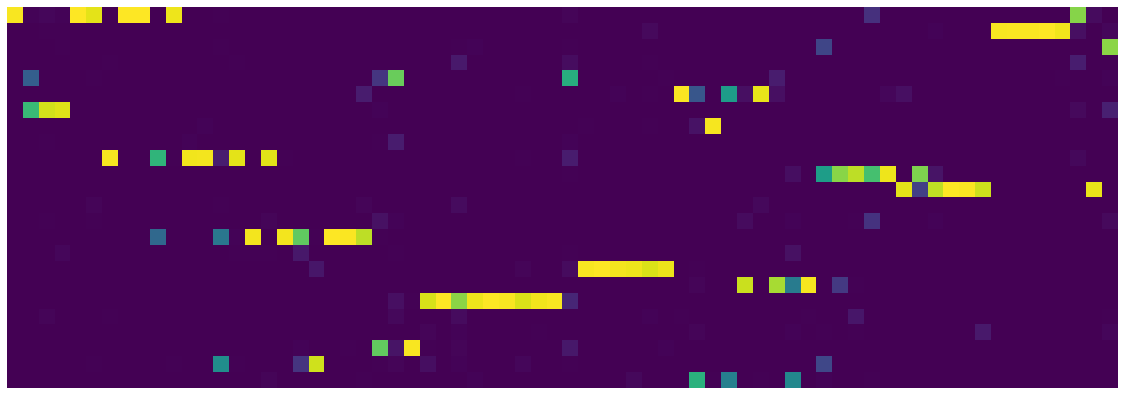

24 65 0.9339999999999999 0.681454692222178


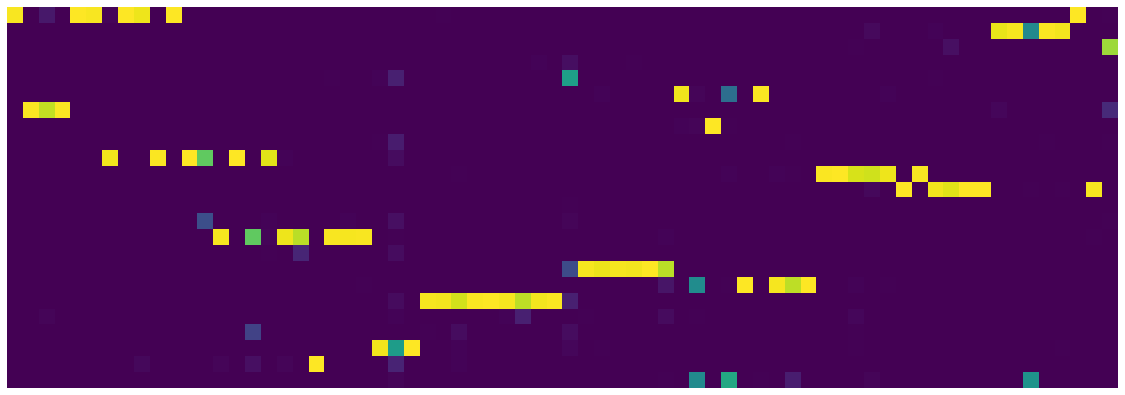

24 66 0.9329999999999999 0.6667444046586752


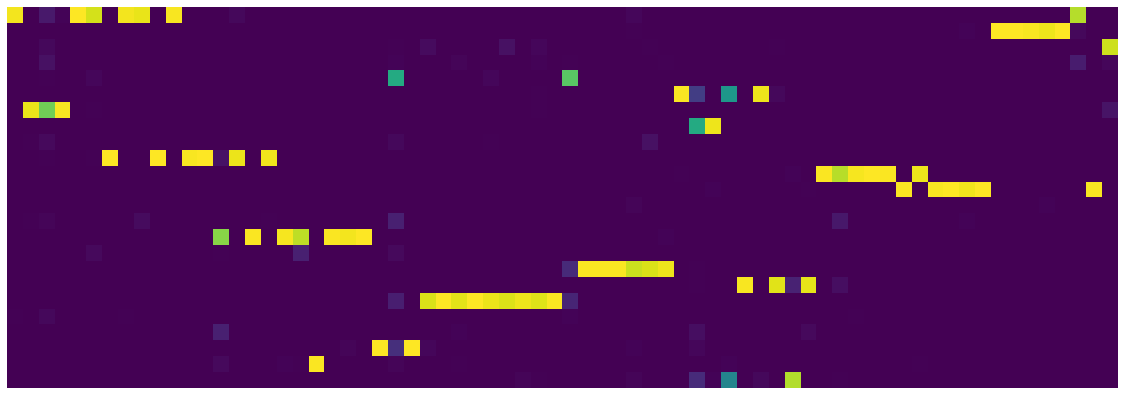

24 67 0.9319999999999999 0.6549256842583417


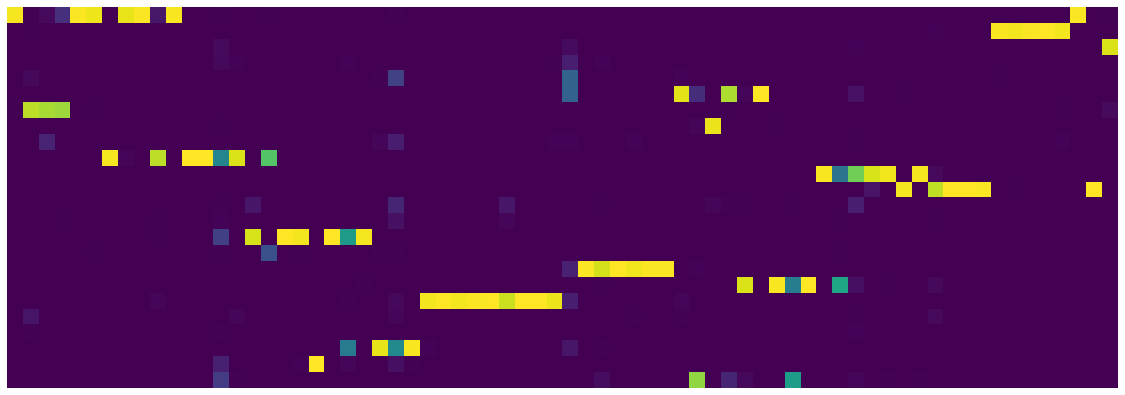

24 68 0.9309999999999999 0.6364227790385485


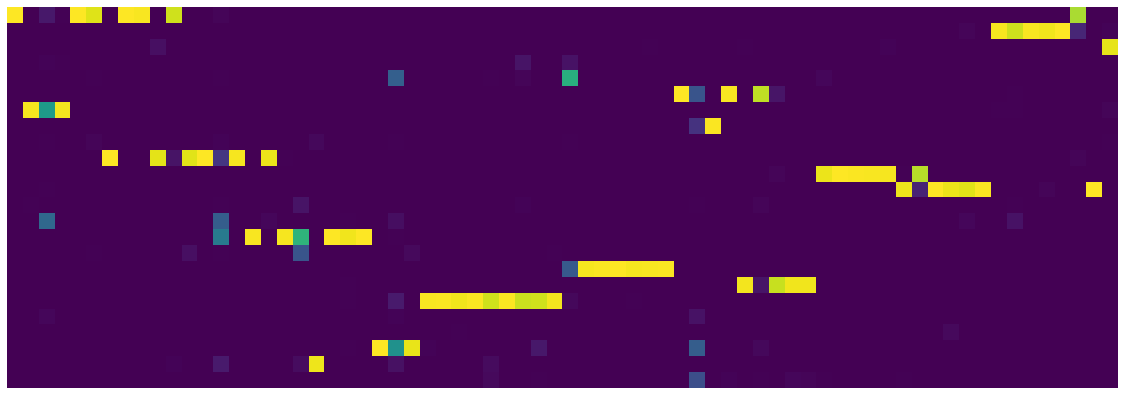

24 69 0.9299999999999999 0.6225845385342836


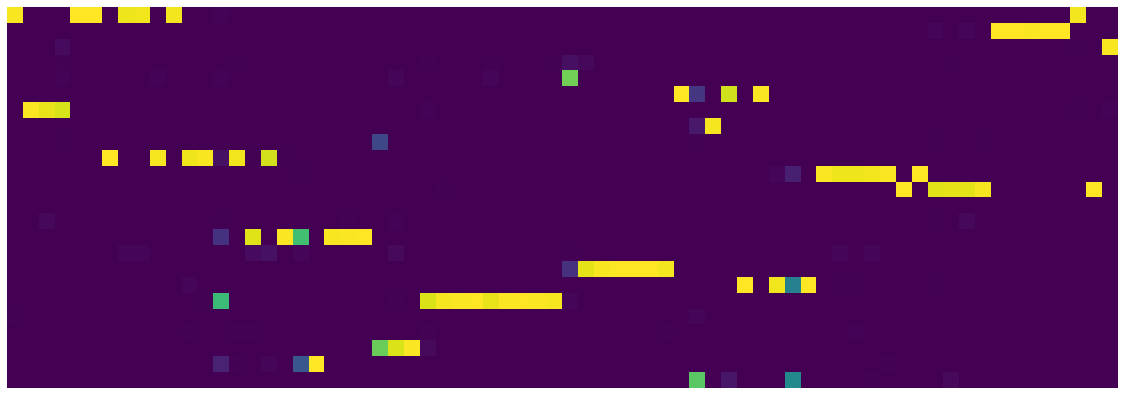

24 70 0.9289999999999999 0.6195305977016687


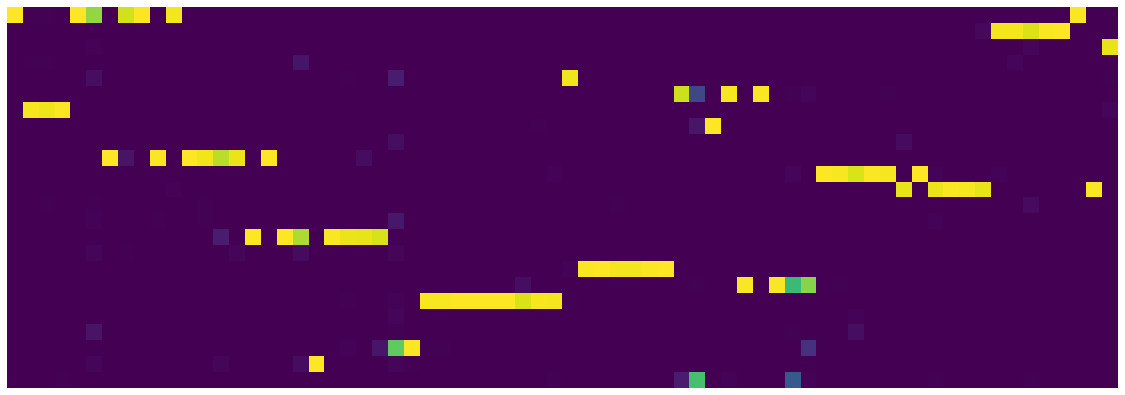

24 71 0.9279999999999999 0.5967173181474209


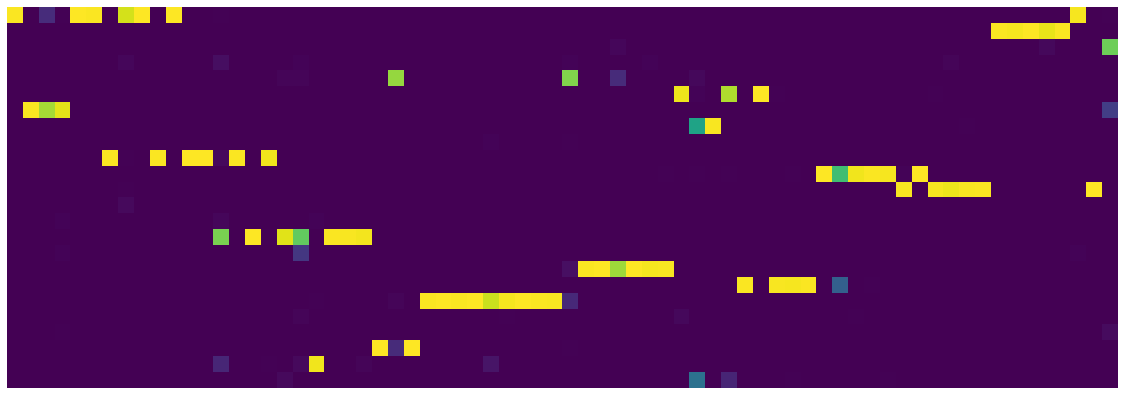

24 72 0.9269999999999999 0.5984659742563962


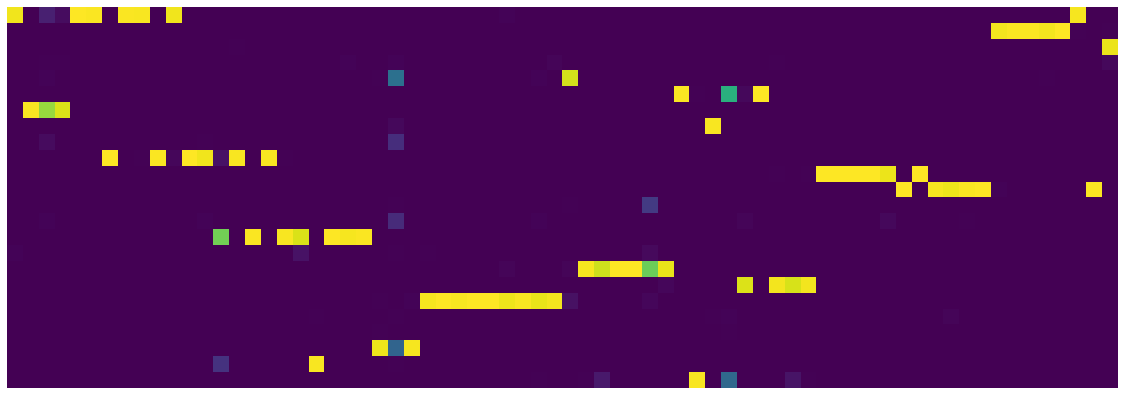

24 73 0.9259999999999999 0.5756358783692122


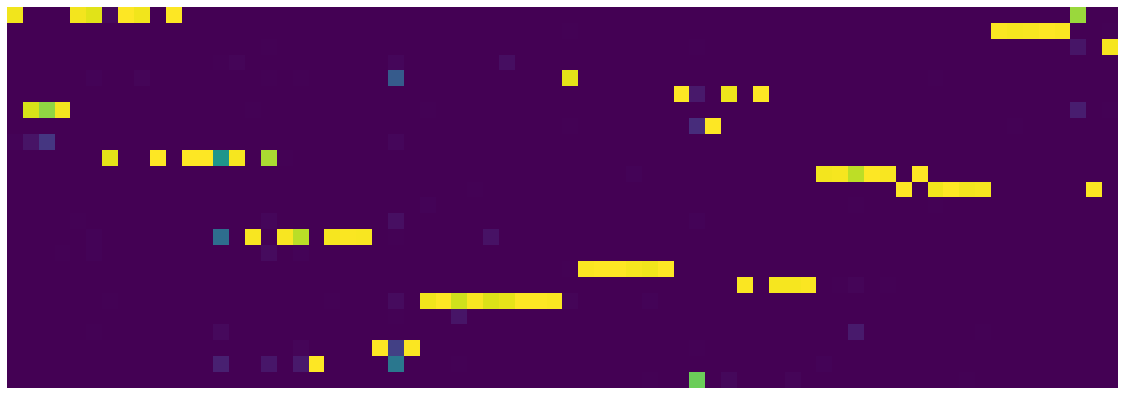

24 74 0.9249999999999999 0.5813169859349727


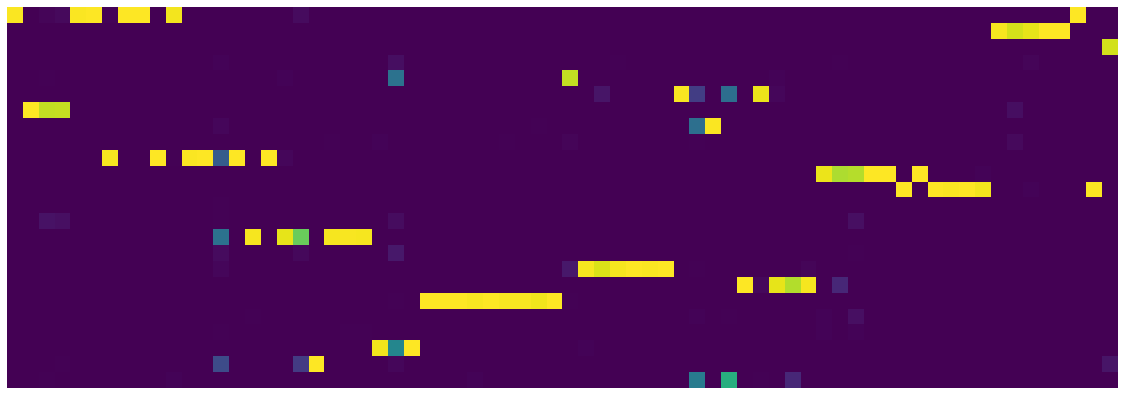

24 75 0.9239999999999999 0.5616244081407785


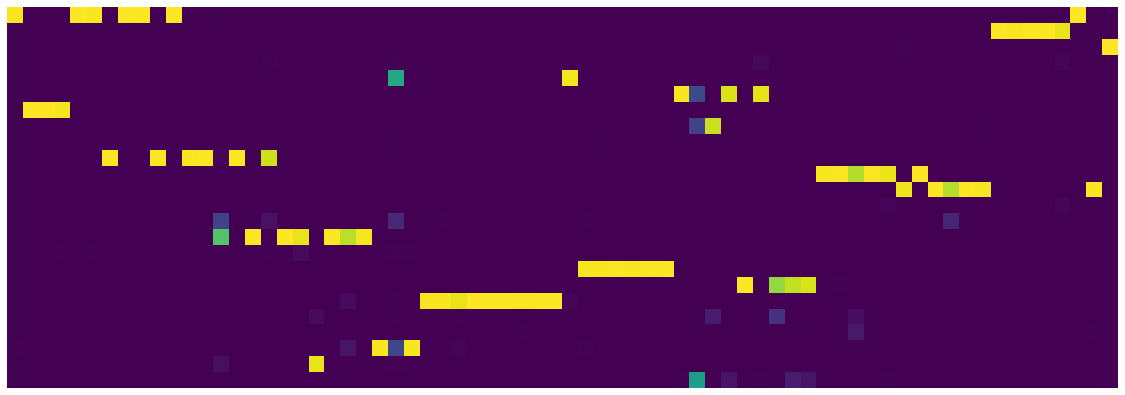

24 76 0.9229999999999999 0.5543386522680521


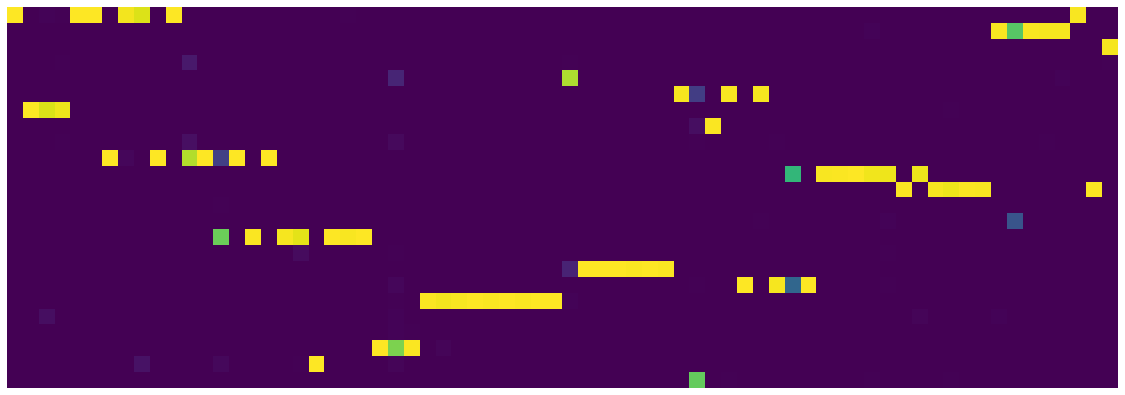

24 77 0.9219999999999999 0.5558722736313939


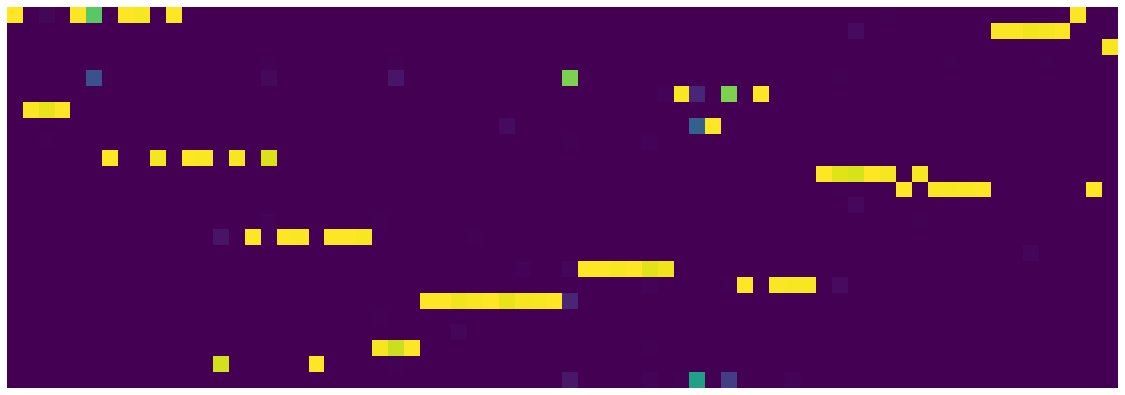

24 78 0.9209999999999999 0.5519585510715842


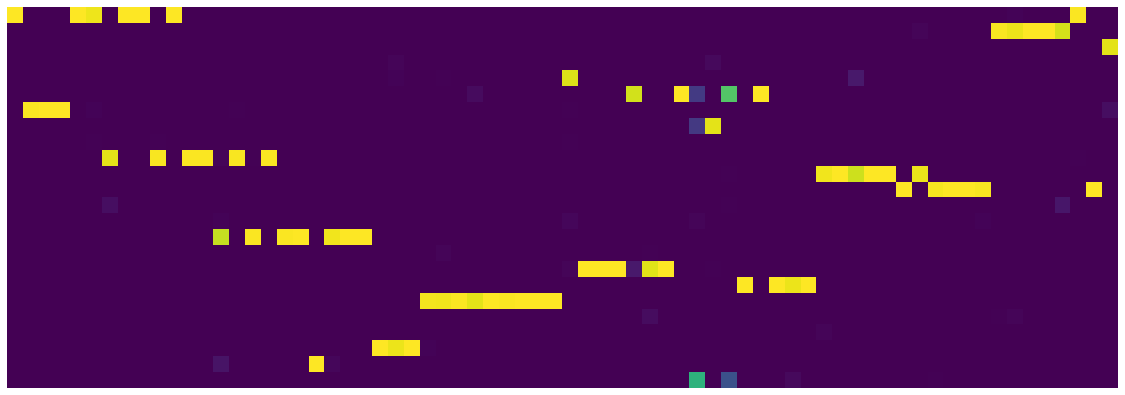

24 79 0.9199999999999999 0.5409148942679167


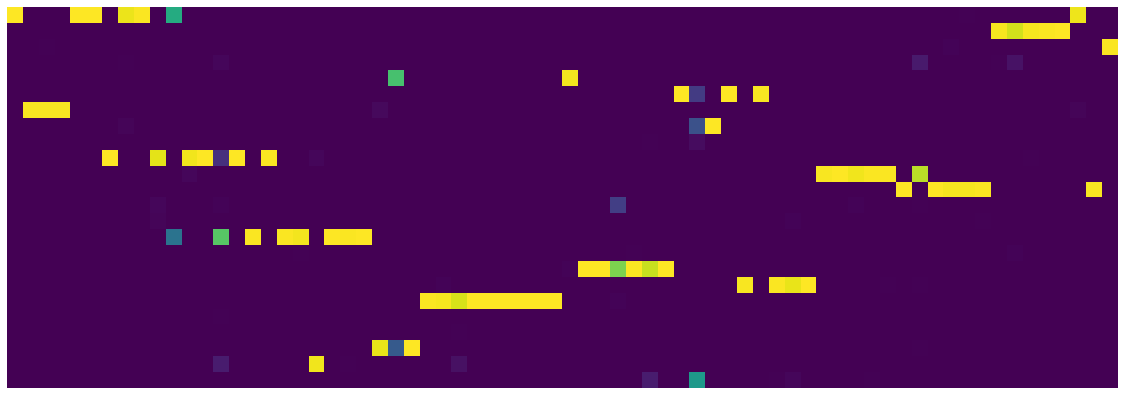

24 80 0.9189999999999999 0.5219256442040205


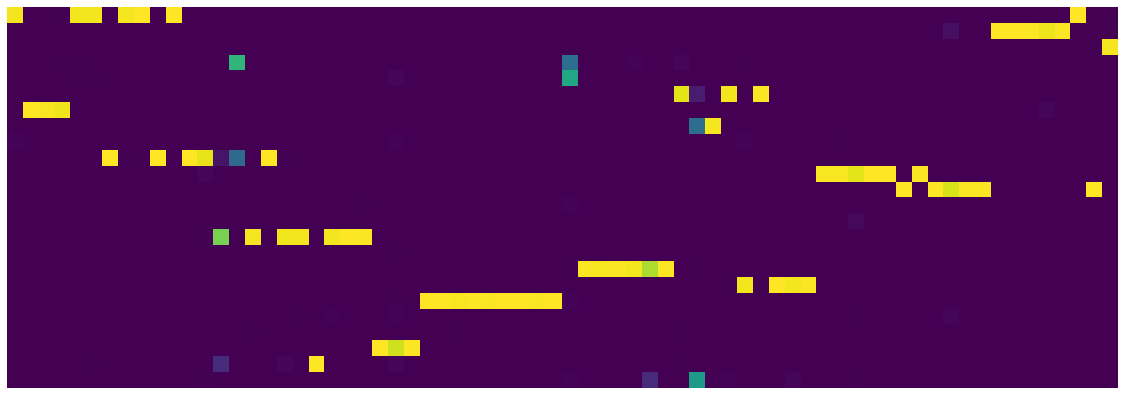

24 81 0.9179999999999999 0.5691553950309753


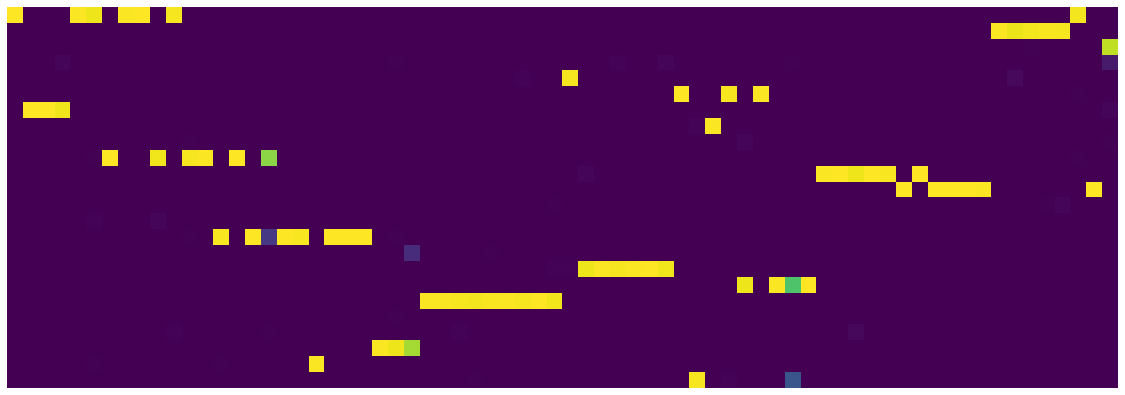

24 82 0.9169999999999999 0.5402983289211989


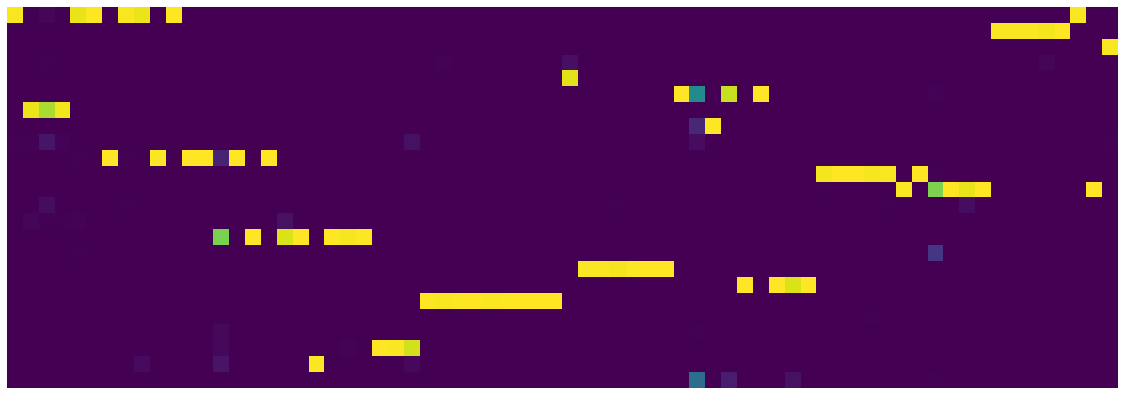

24 83 0.9159999999999999 0.5092469701543451


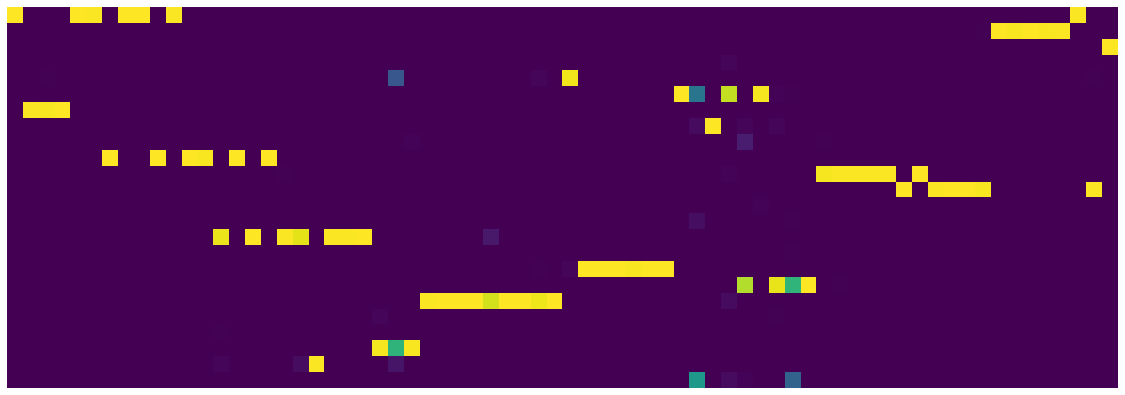

24 84 0.9149999999999999 0.5218637298792601


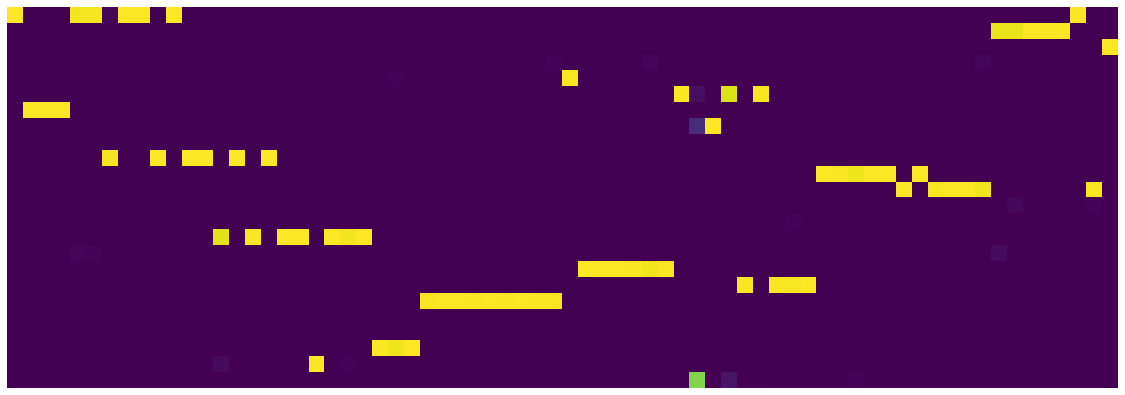

24 85 0.9139999999999999 0.48201273158192637


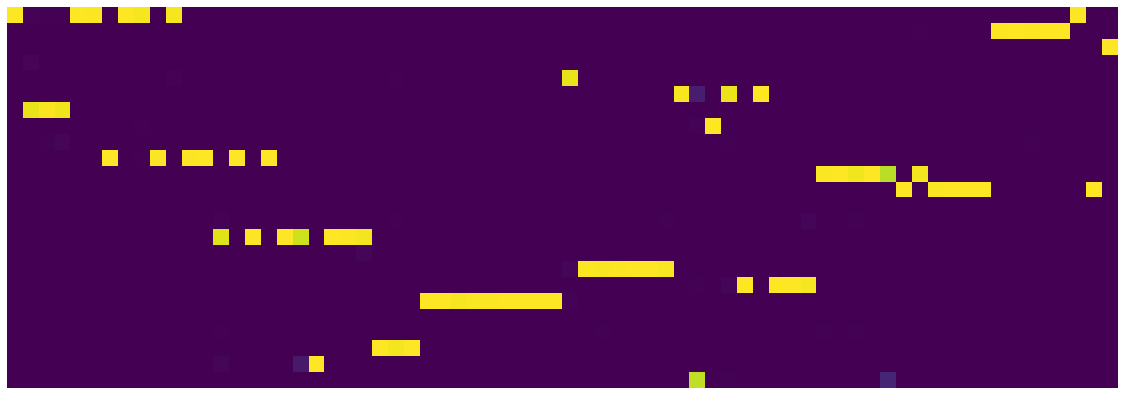

24 86 0.9129999999999999 0.5094800651073456


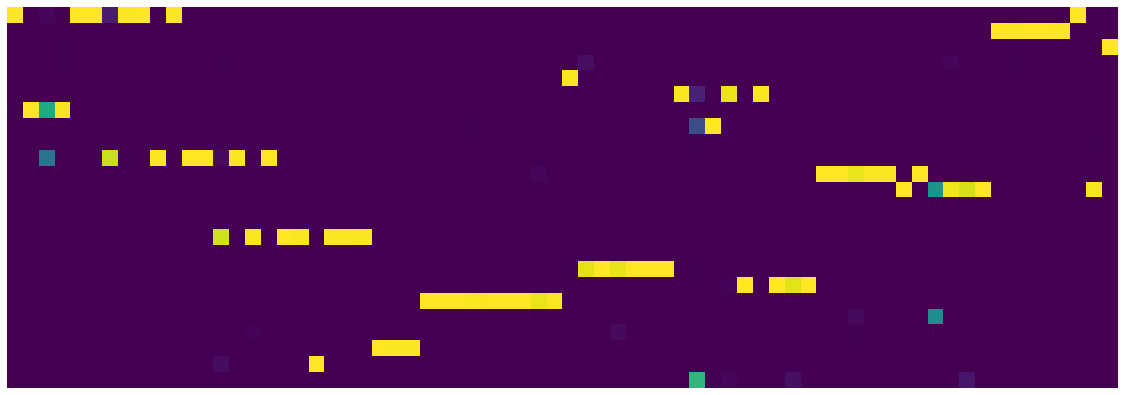

24 87 0.9119999999999999 0.4903658952564001


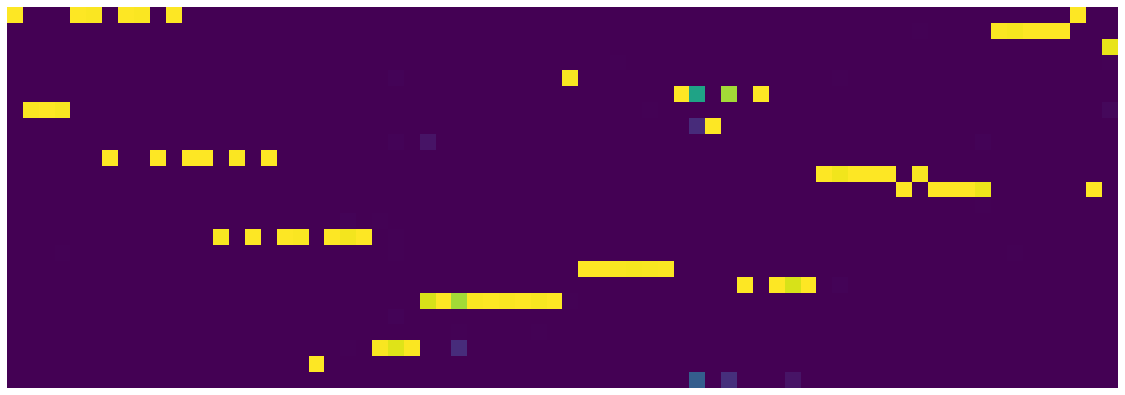

24 88 0.9109999999999999 0.4799860013648868


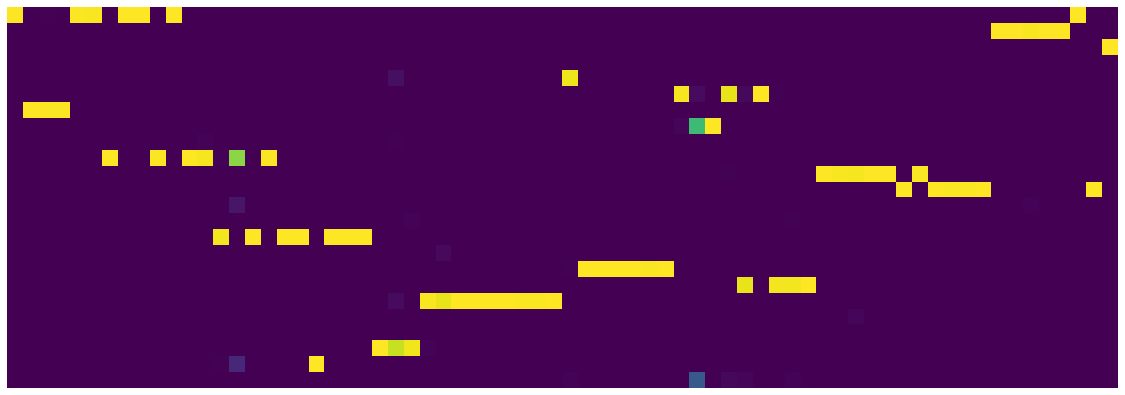

24 89 0.9099999999999999 0.51110306289047


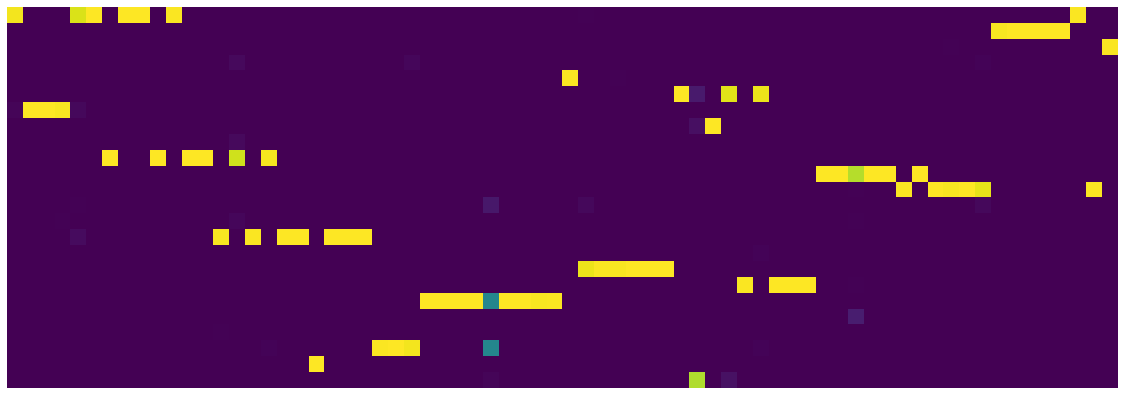

24 90 0.9089999999999999 0.47704089544713496


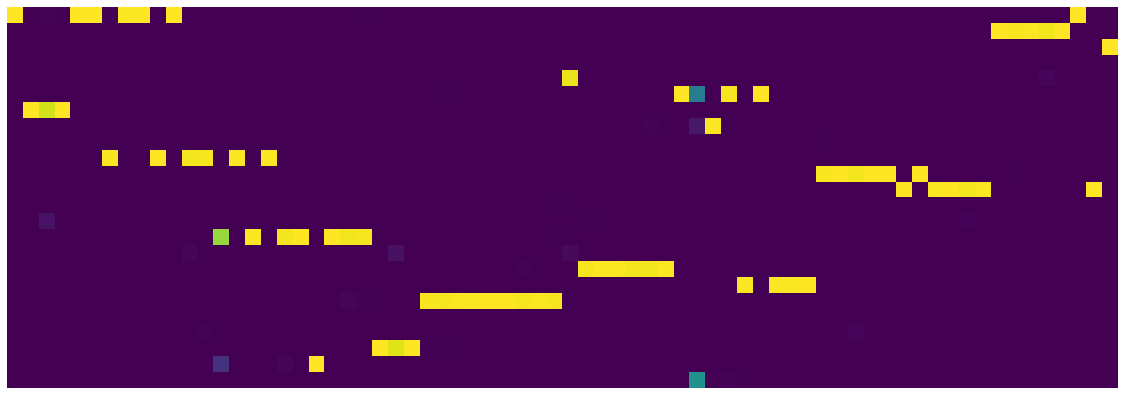

24 91 0.9079999999999999 0.47733384892344477


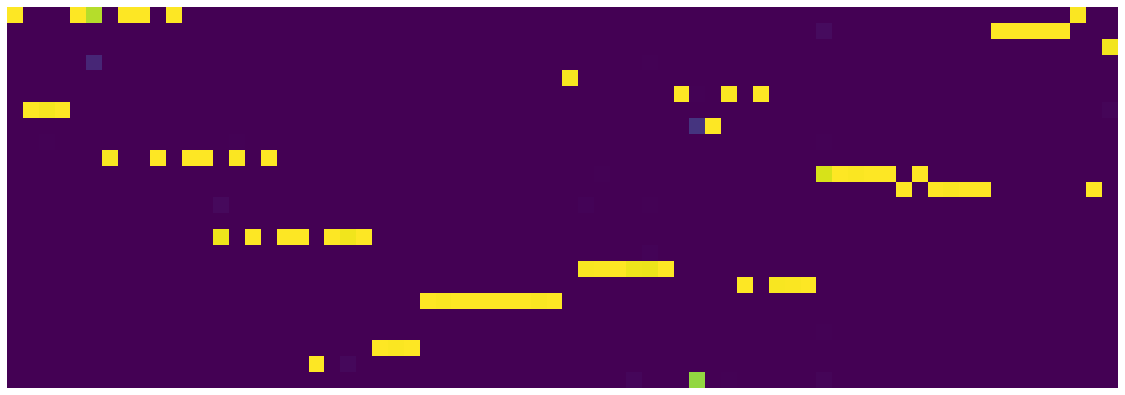

24 92 0.9069999999999999 0.47390180667862297


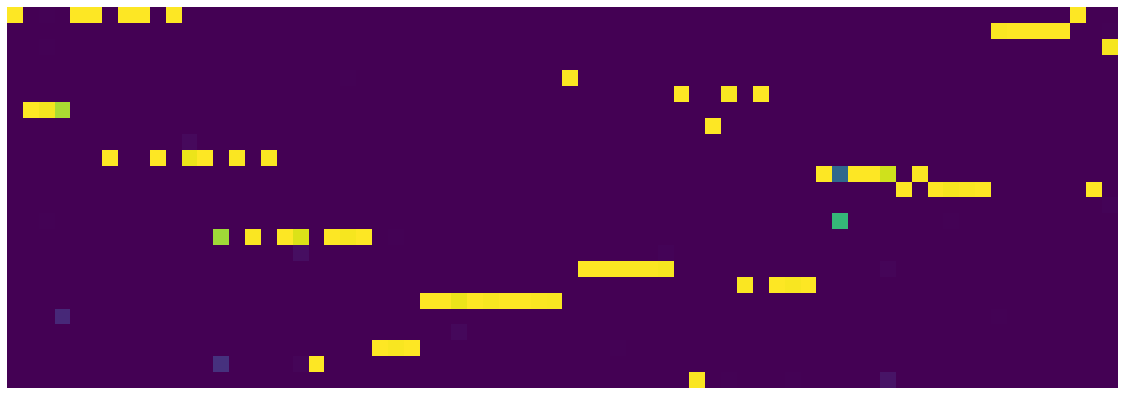

24 93 0.9059999999999999 0.4687196692451835


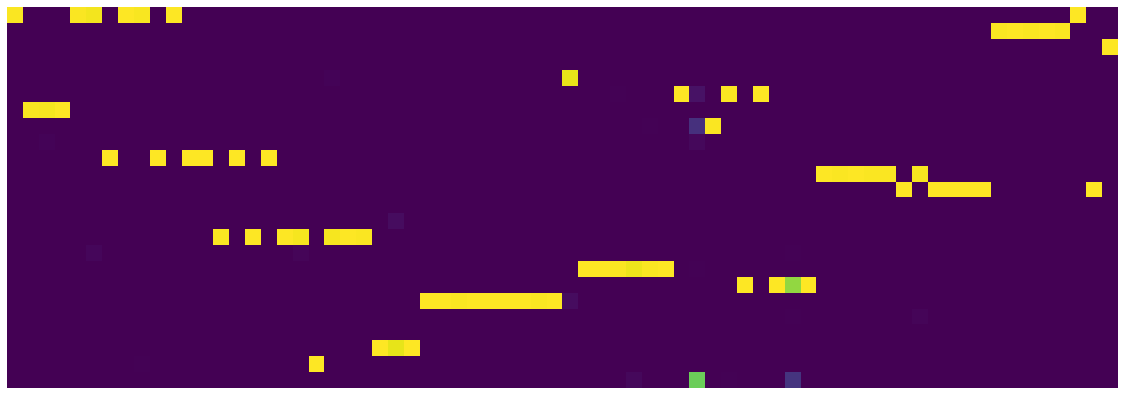

24 94 0.9049999999999999 0.5030055726878345


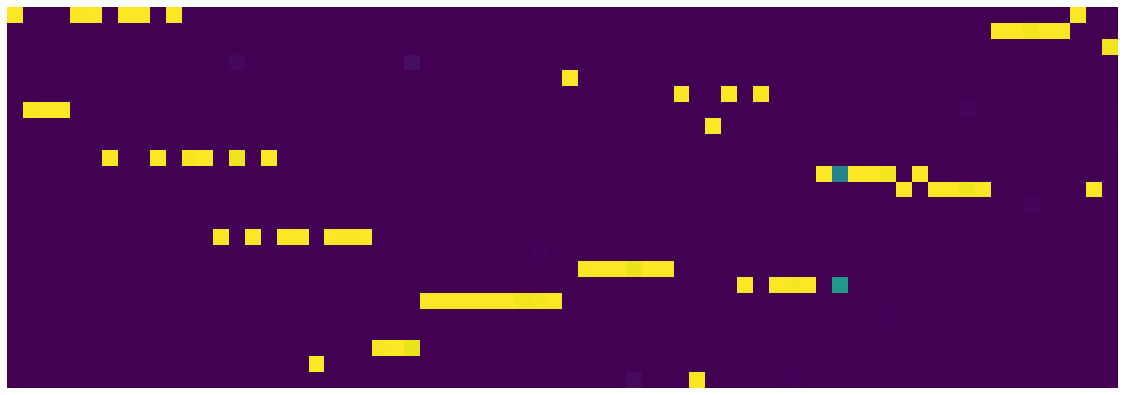

24 95 0.9039999999999999 0.4688928944058716


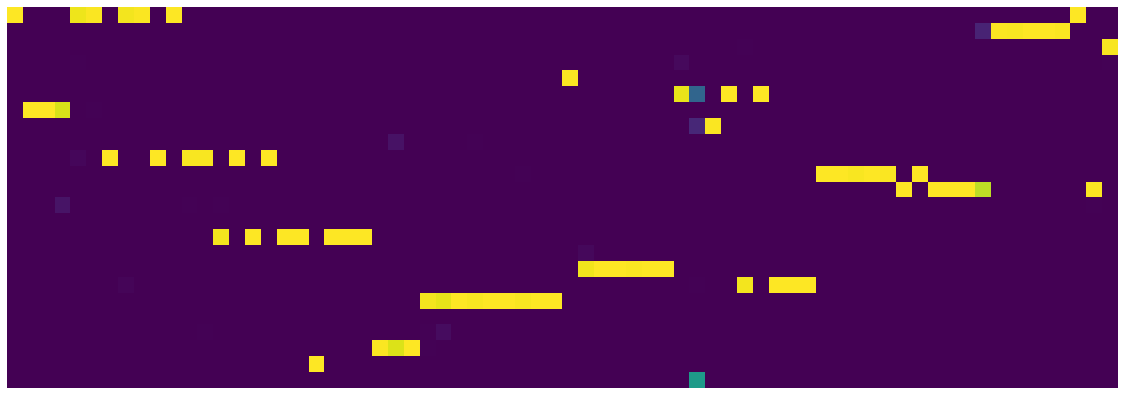

24 96 0.9029999999999999 0.4888527821749449


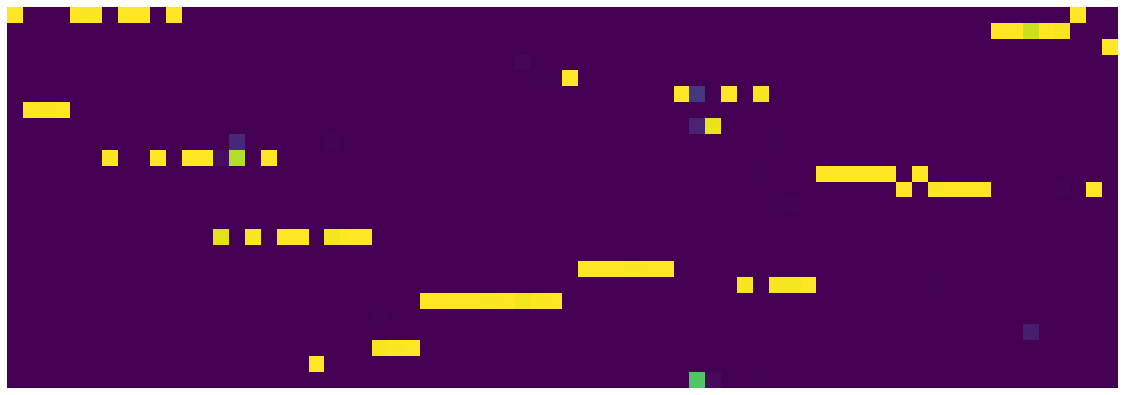

24 97 0.9019999999999999 0.4815608506090939


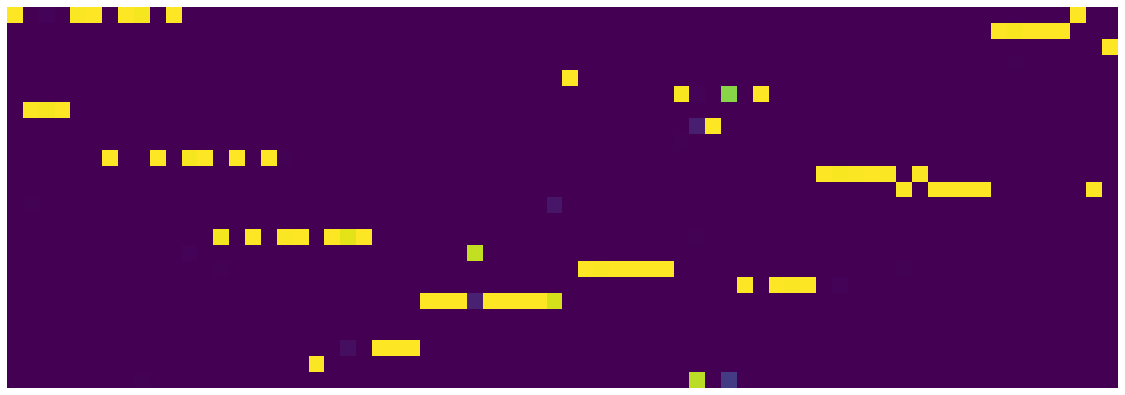

24 98 0.9009999999999999 0.46023563854396343


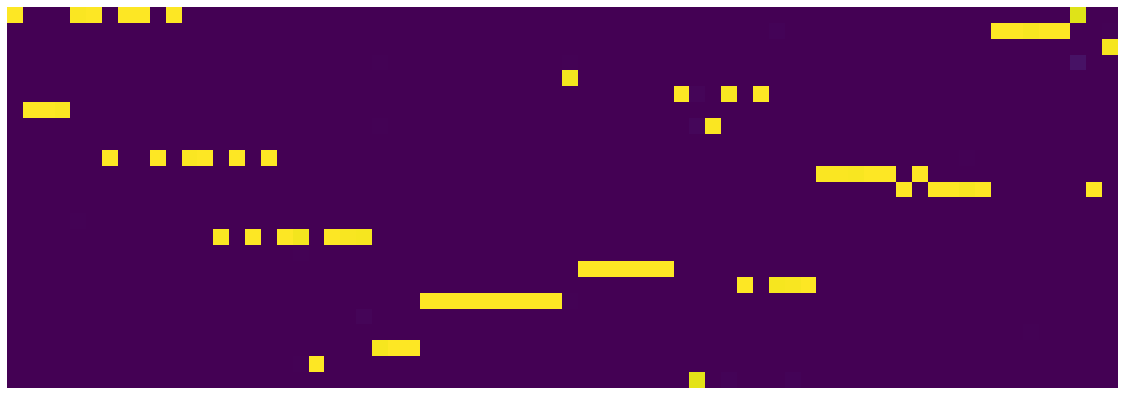

24 99 0.8999999999999999 0.4489499802701175


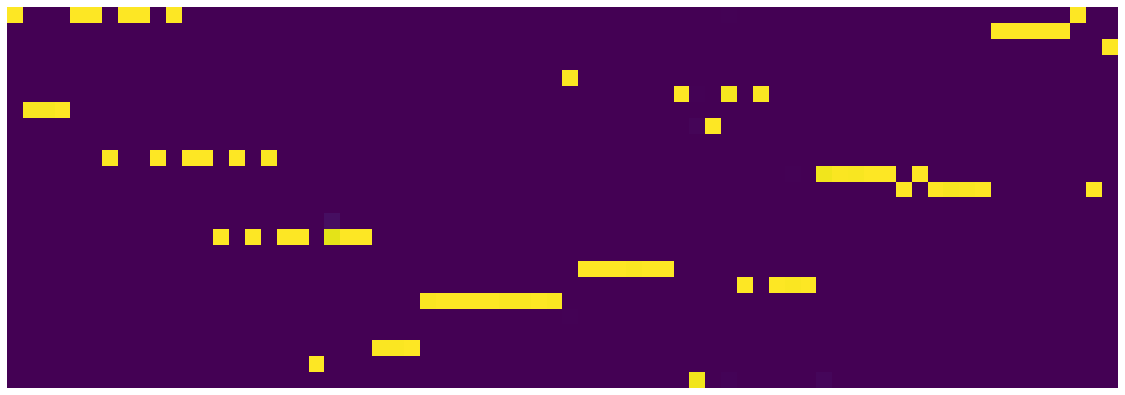

24 100 0.8989999999999999 0.4387592481449246


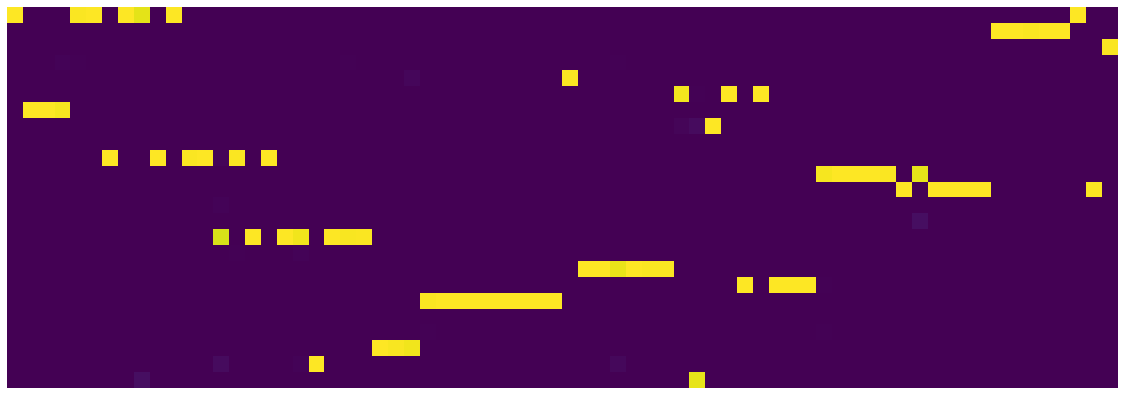

24 101 0.8979999999999999 0.5105160888284445


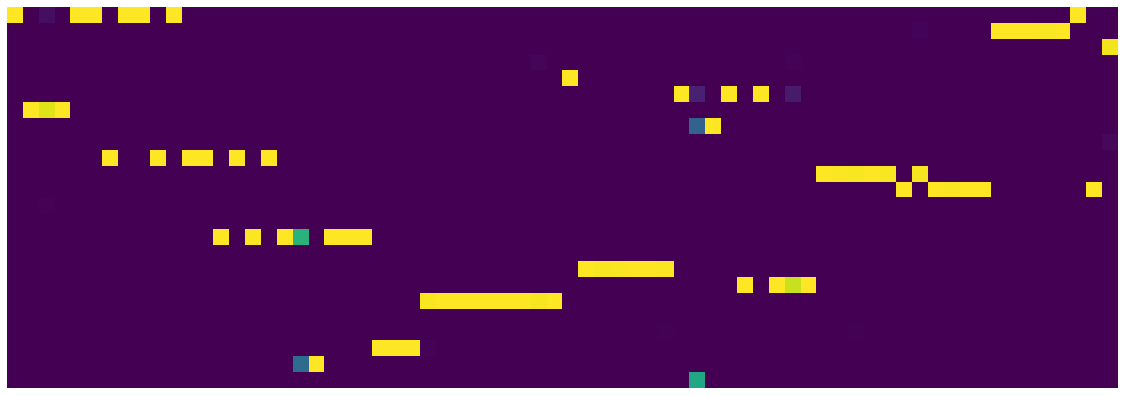

24 102 0.8969999999999999 0.4619240009225905


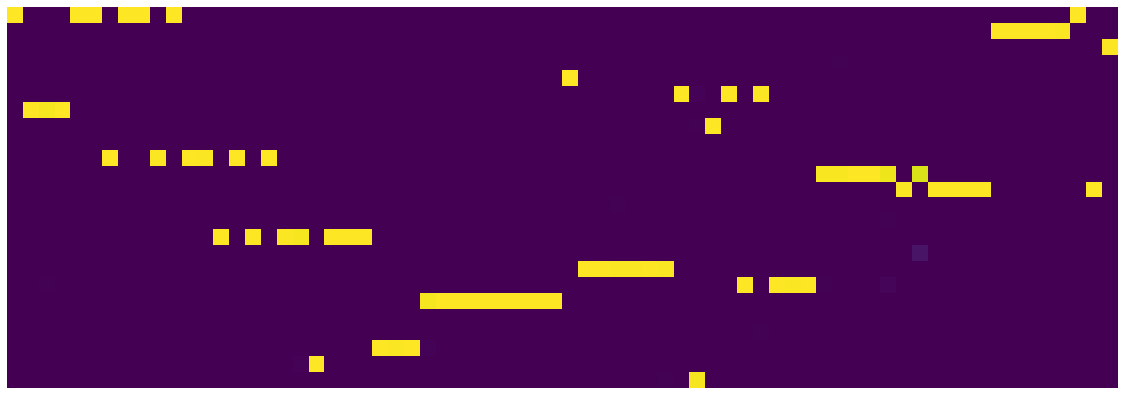

24 103 0.8959999999999999 0.4318063727580011


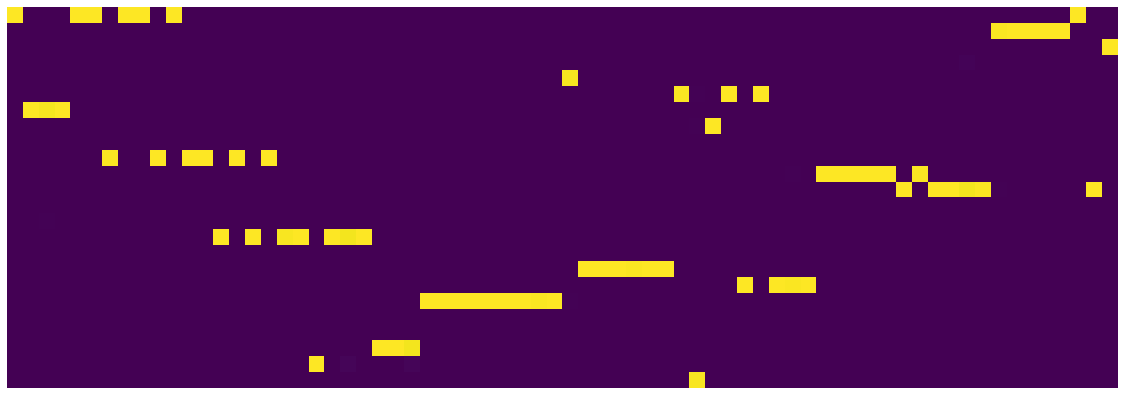

24 104 0.8949999999999999 0.48726684795692565


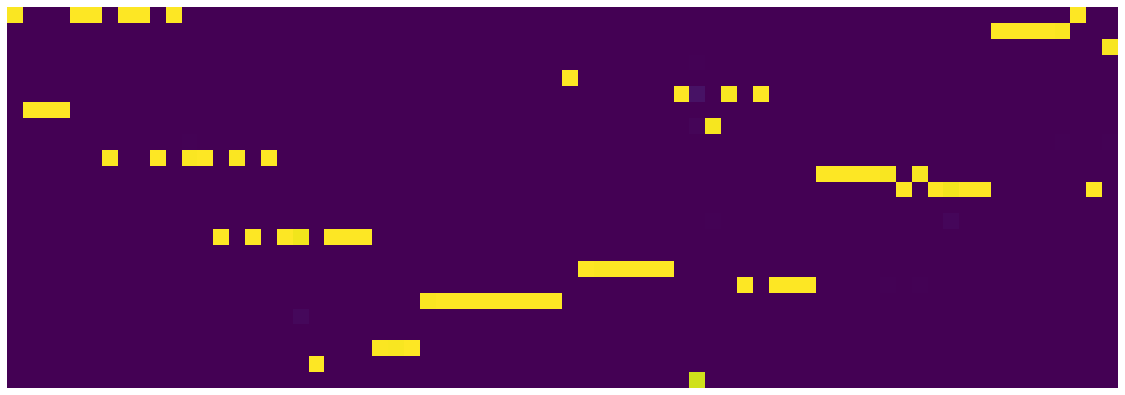

24 105 0.8939999999999999 0.4263735545799136


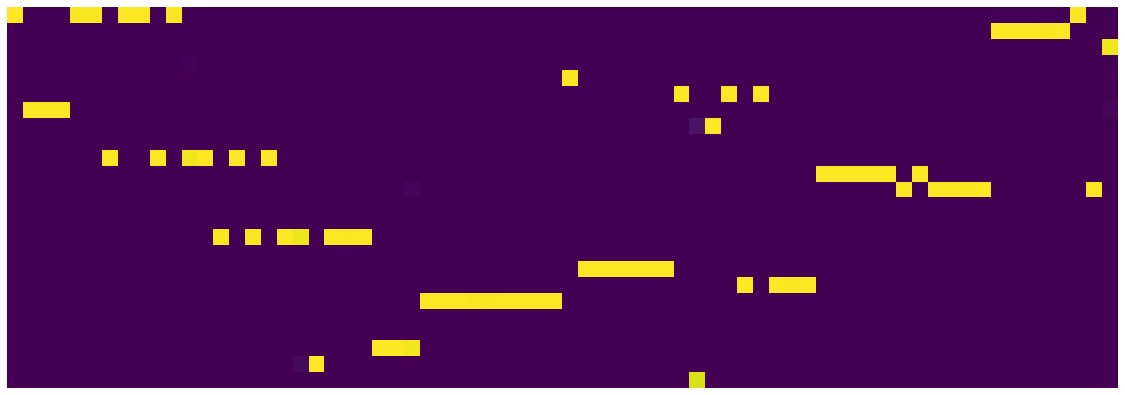

24 106 0.8929999999999999 0.4516039377078414


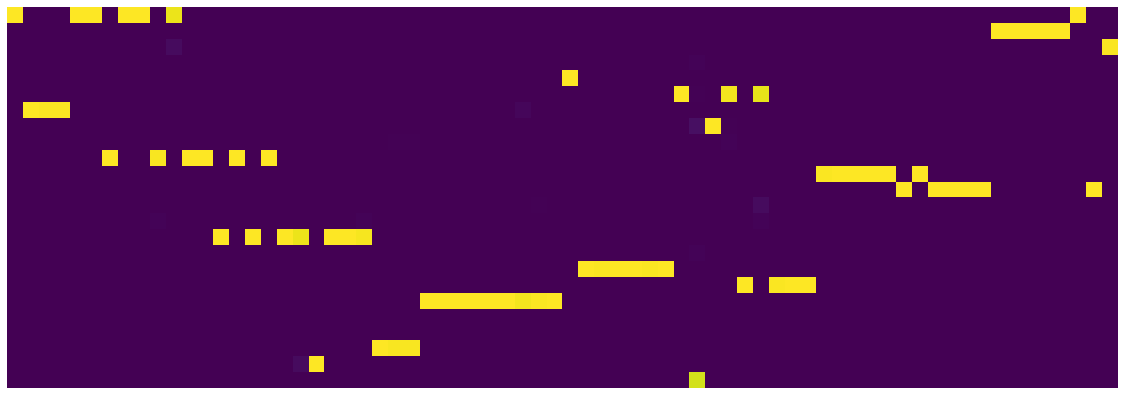

24 107 0.8919999999999999 0.4456004505977035


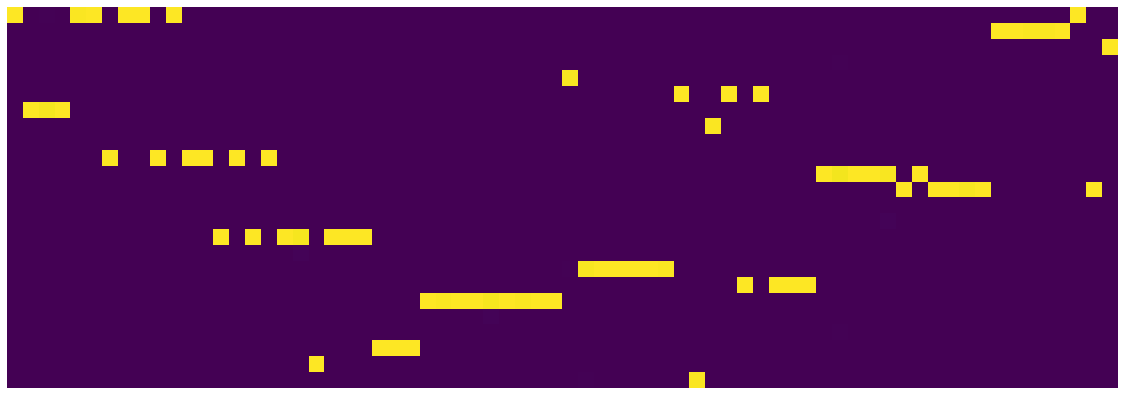

24 108 0.8909999999999999 0.4439185161143541


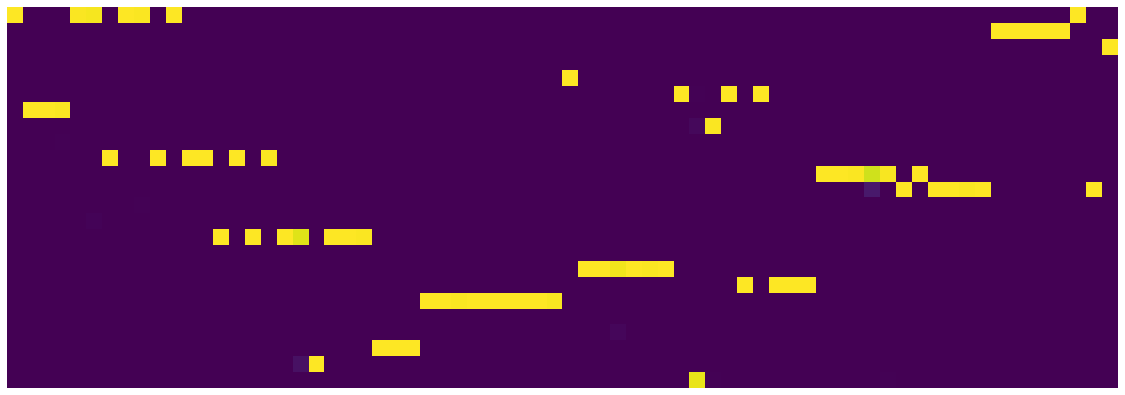

24 109 0.8899999999999999 0.43173128087073565


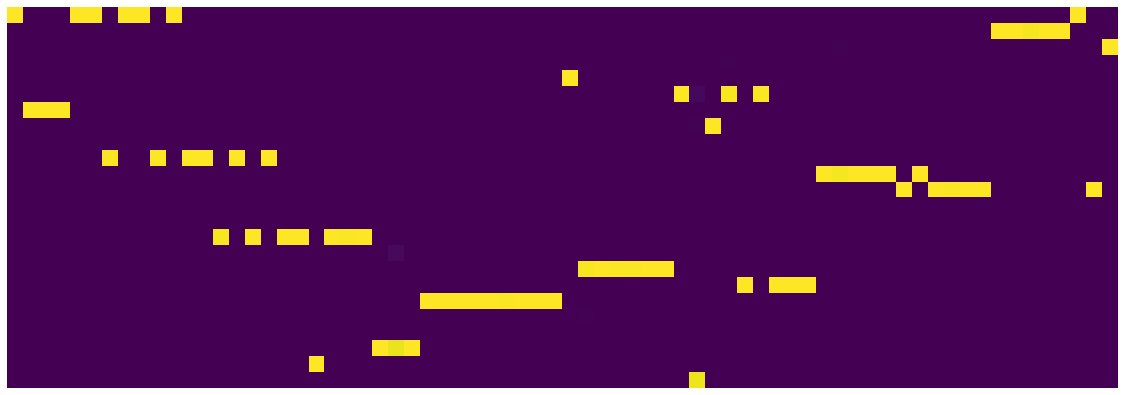

24 110 0.8889999999999999 0.4662944651208818


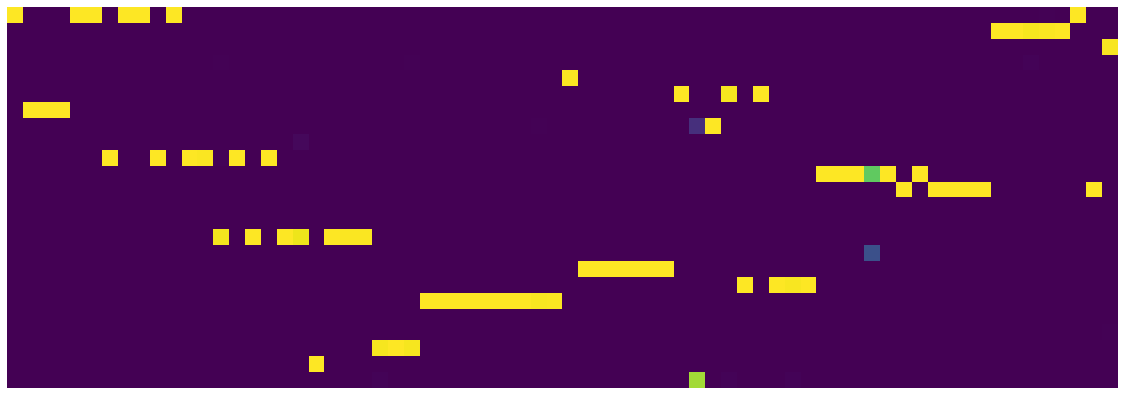

24 111 0.8879999999999999 0.4225625995546579


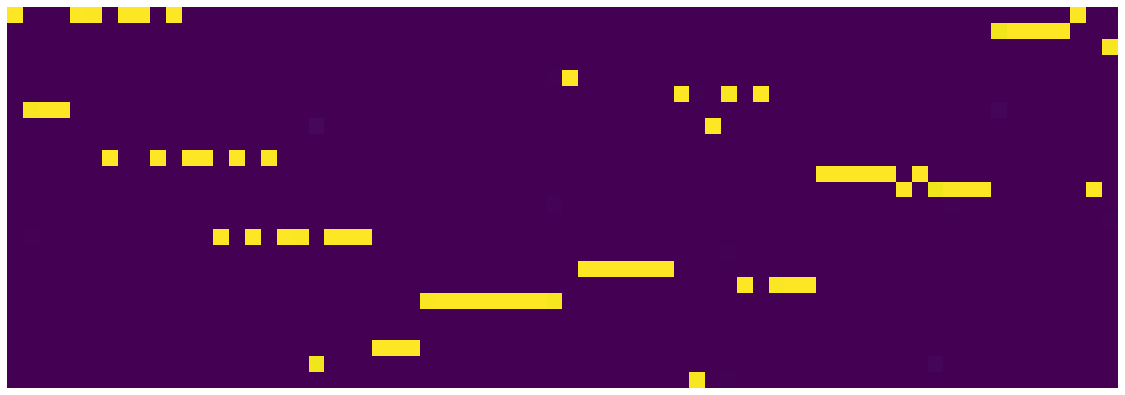

24 112 0.8869999999999999 0.43916228534653784


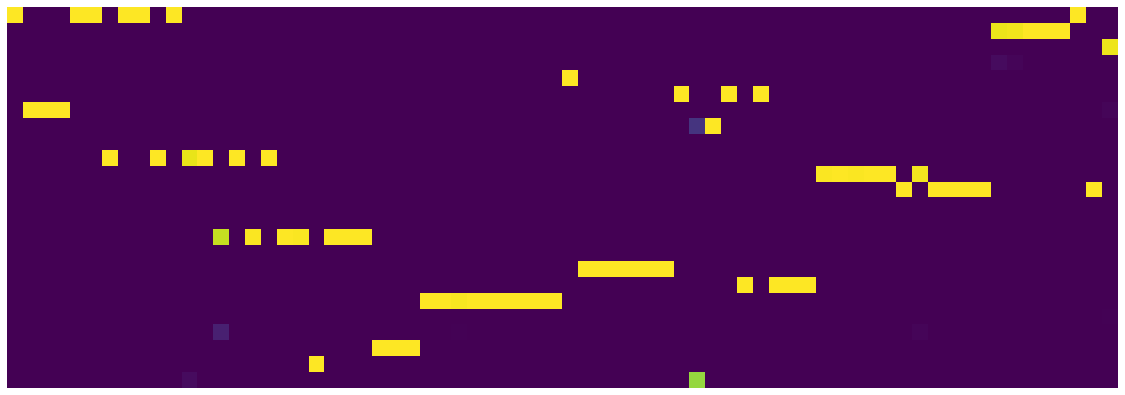

24 113 0.8859999999999999 0.4656283978372812


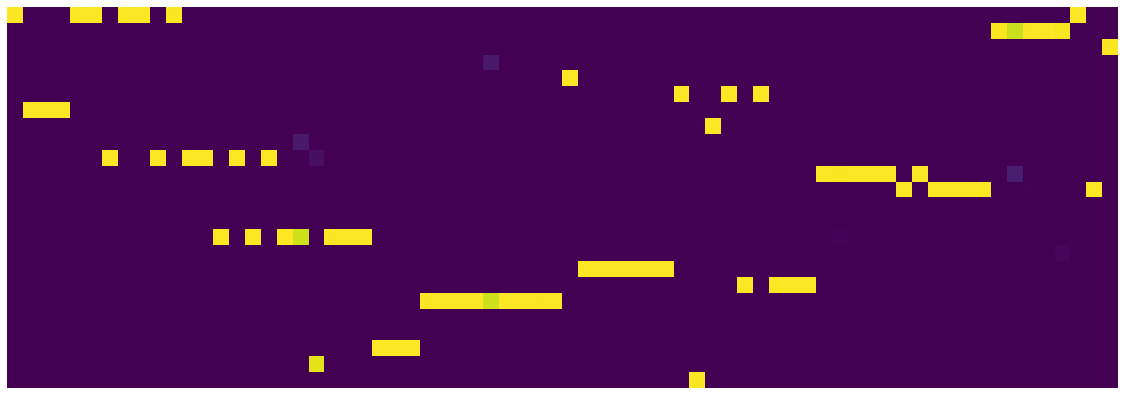

24 114 0.8849999999999999 0.4746948411688209


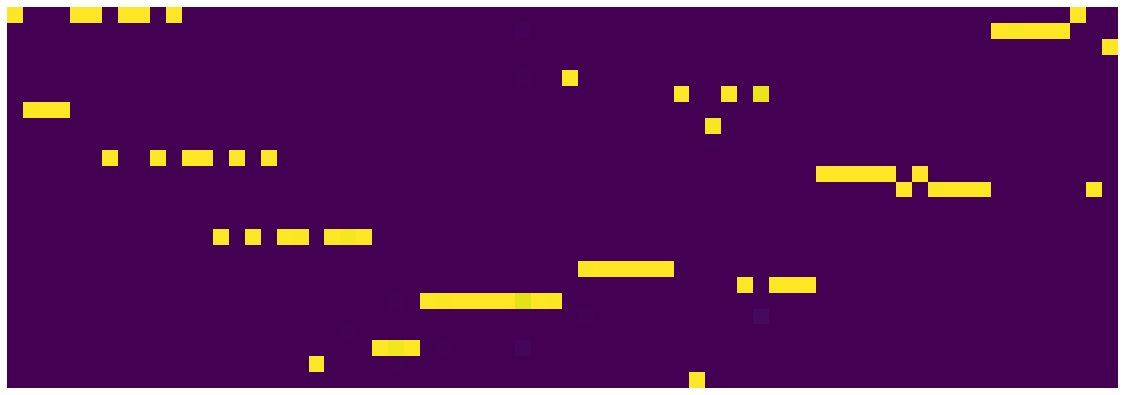

24 115 0.8839999999999999 0.45477613443508746


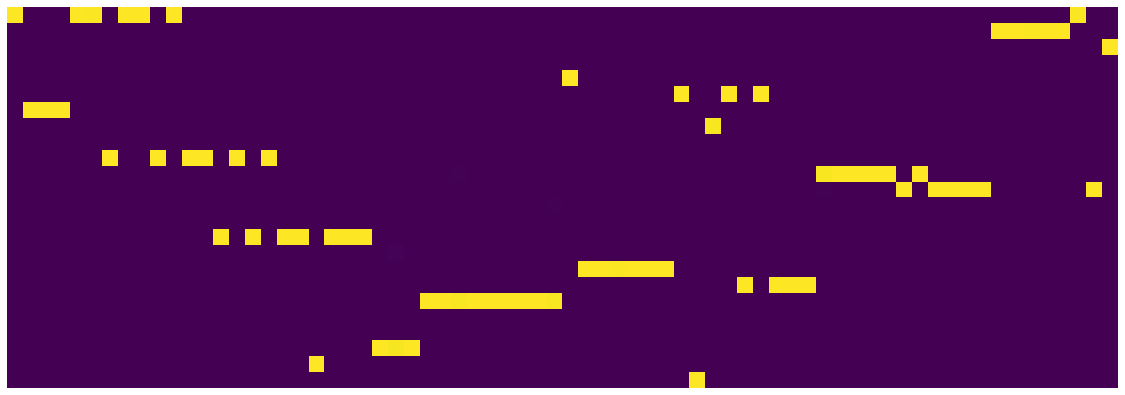

24 116 0.8829999999999999 0.40928779346868394


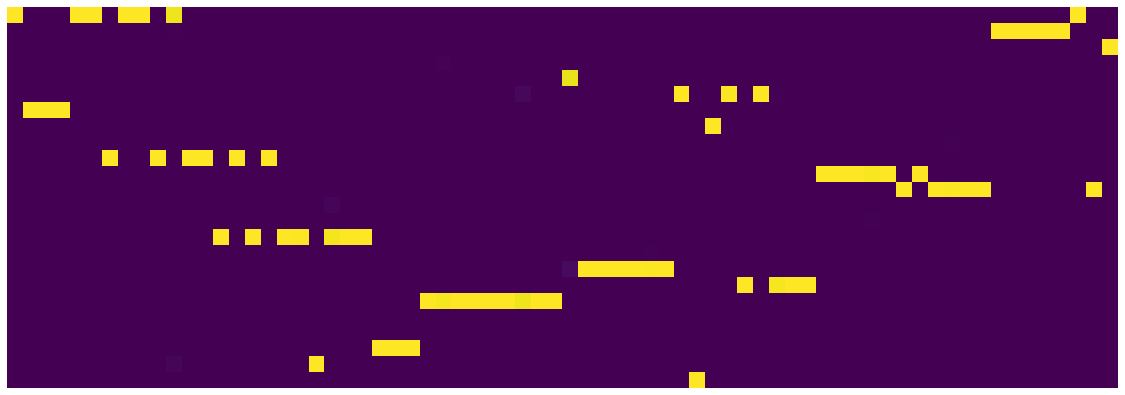

24 117 0.8819999999999999 0.4064369319006801


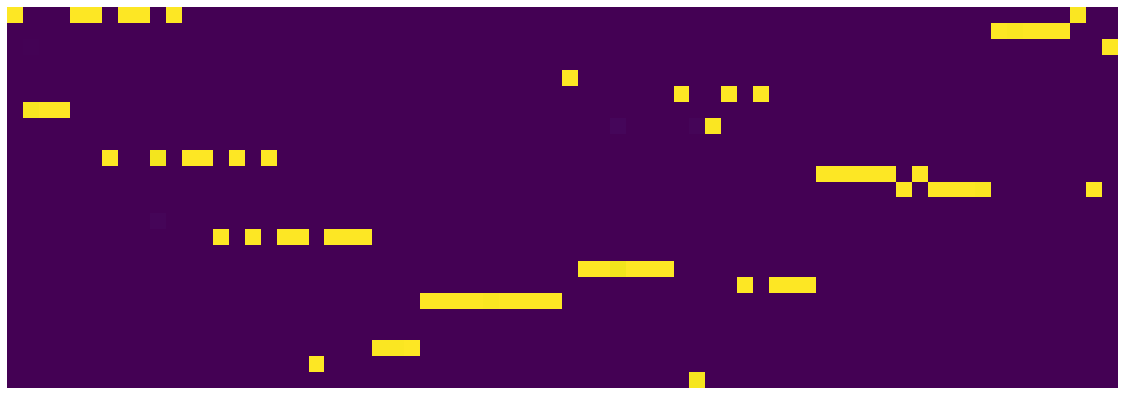

24 118 0.8809999999999999 0.4185721967369318


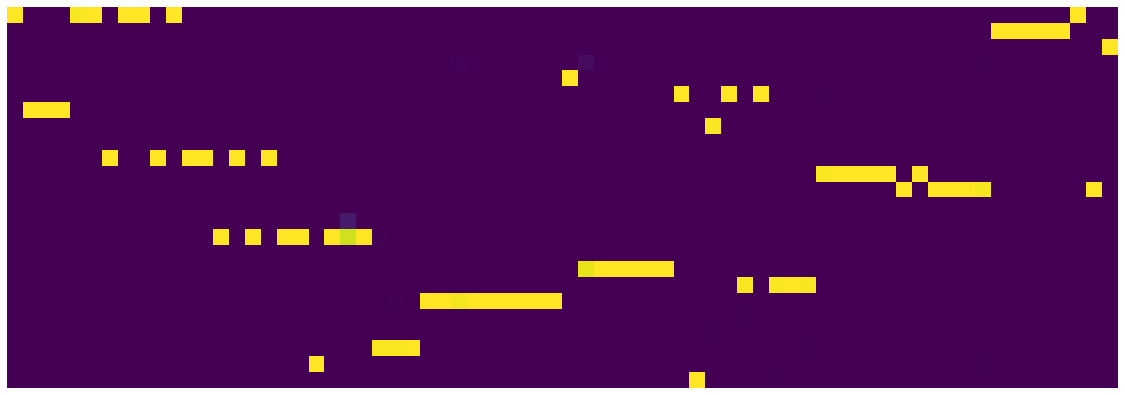

24 119 0.8799999999999999 0.45854618260636926


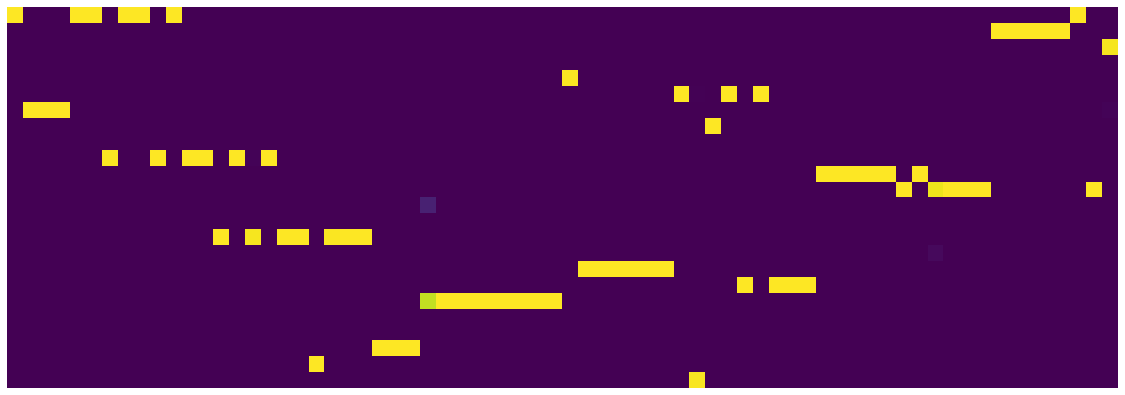

24 120 0.8789999999999999 0.4324766444042325


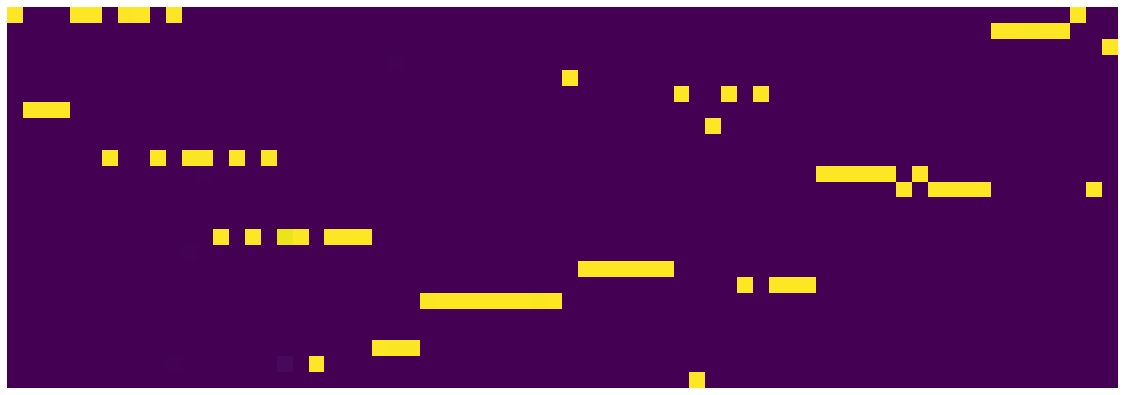

24 121 0.8779999999999999 0.43533315705135467


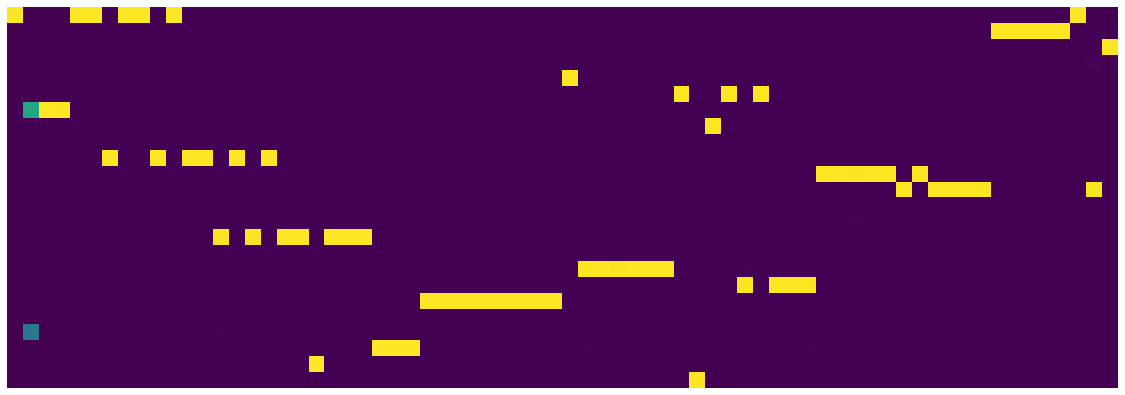

24 122 0.8769999999999999 0.4344728123396635


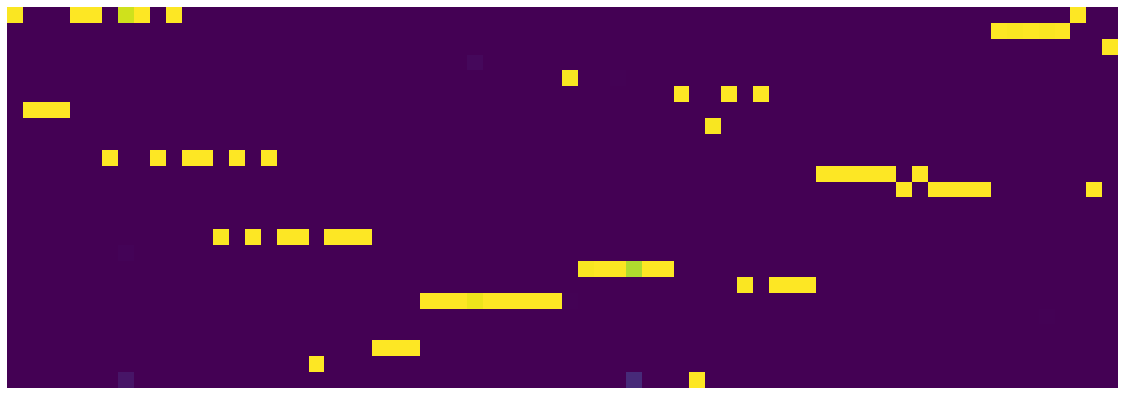

24 123 0.8759999999999999 0.4272091660648584


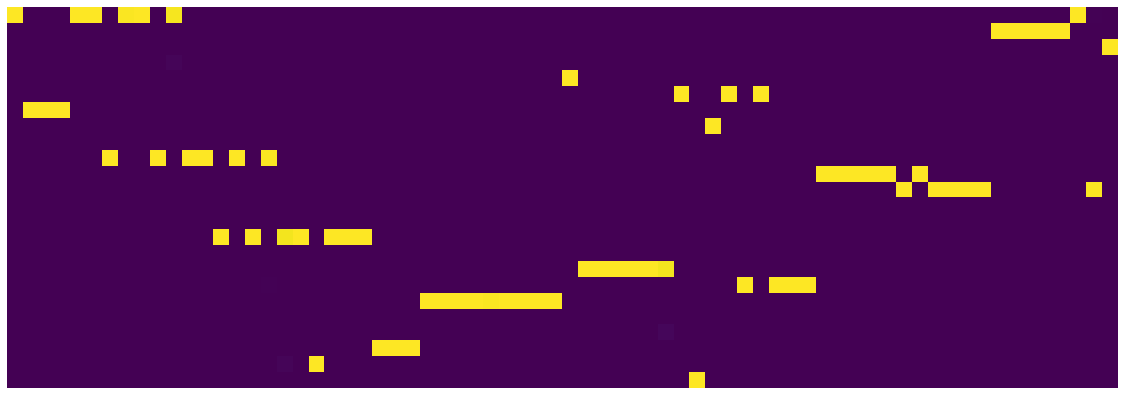

24 124 0.8749999999999999 0.4429531672038138


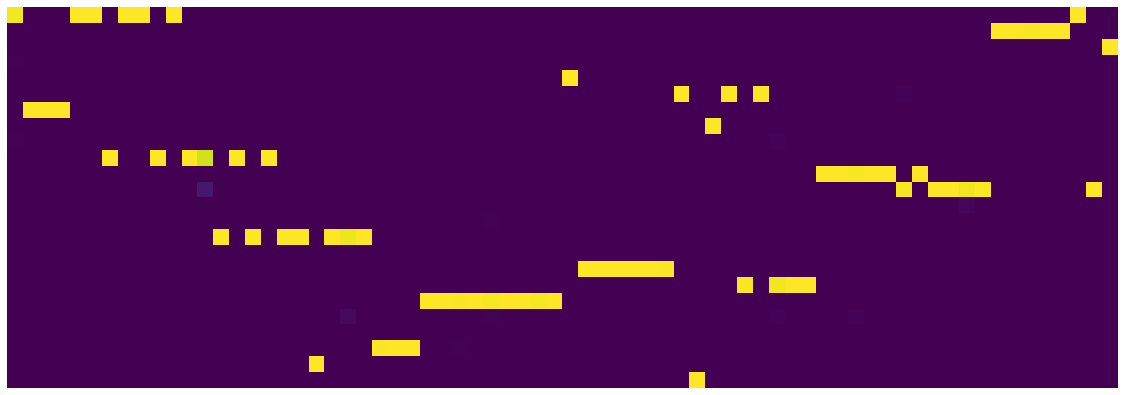

24 125 0.8739999999999999 0.43165599247440695


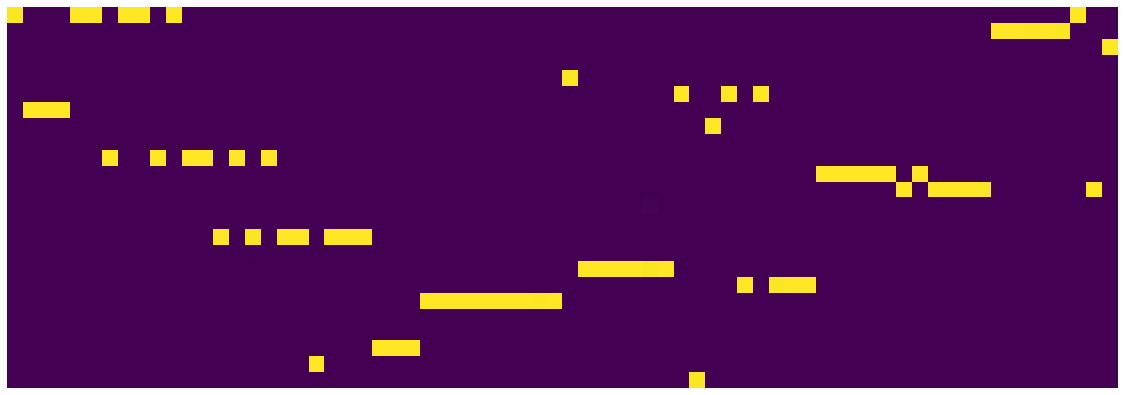

24 126 0.8729999999999999 0.4141466294415295


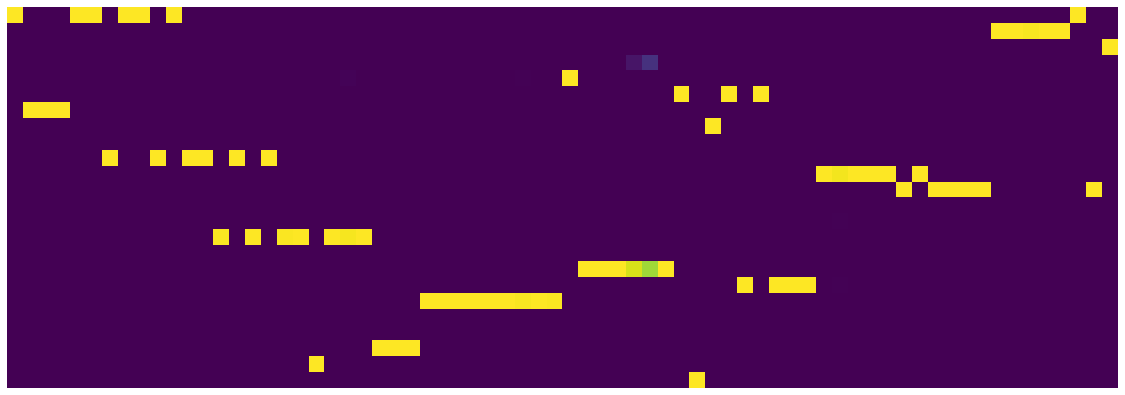

24 127 0.8719999999999999 0.43417078657075764


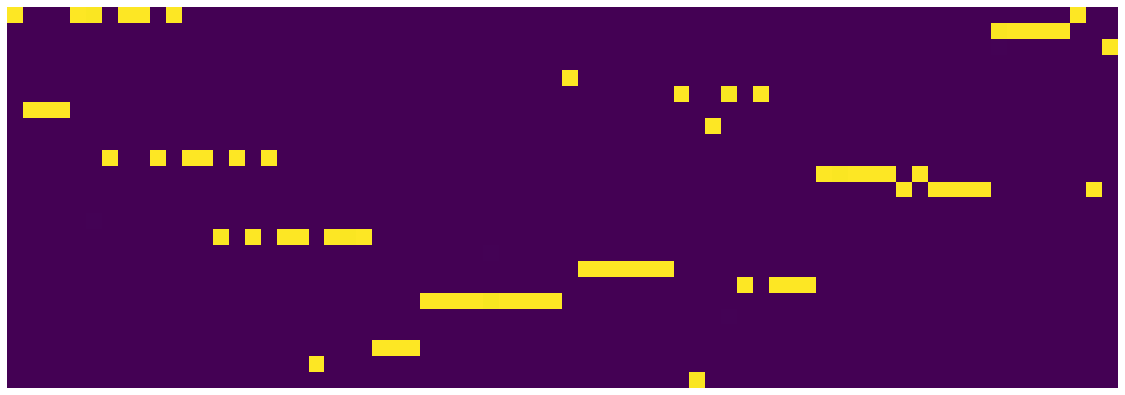

24 128 0.8709999999999999 0.44262518268078566


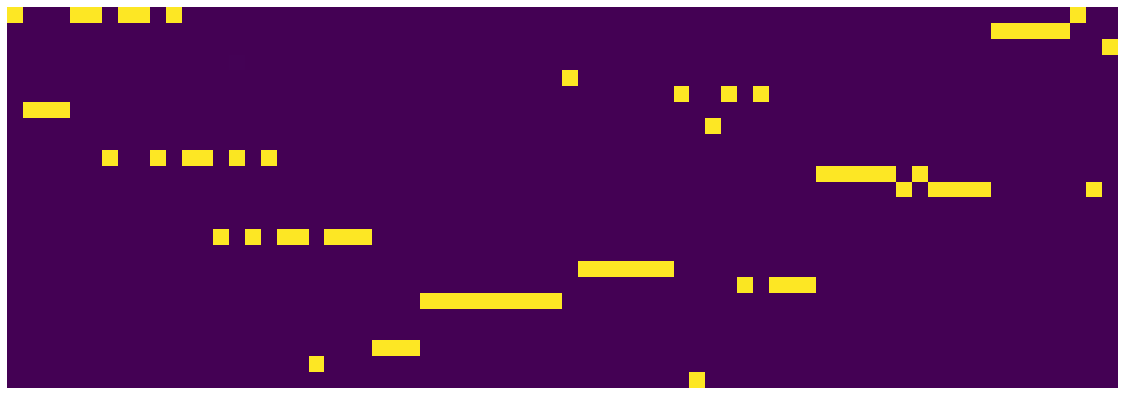

24 129 0.8699999999999999 0.4661870118230581


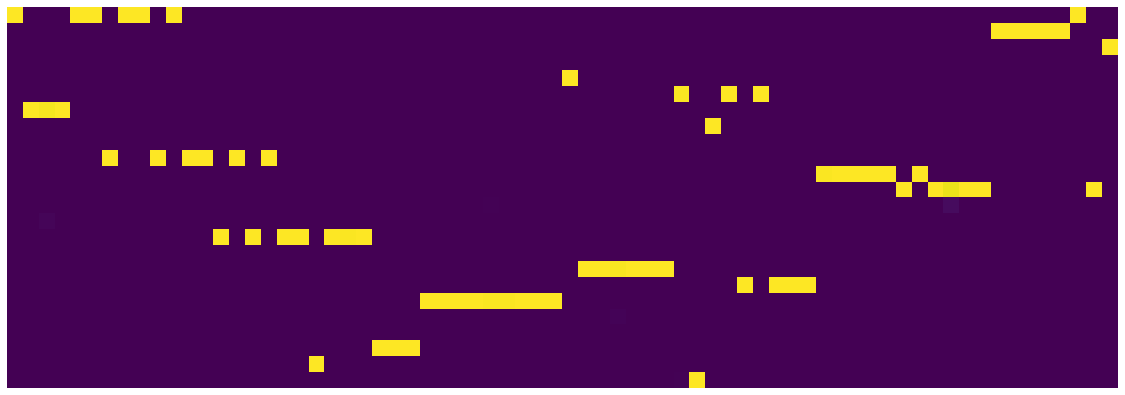

24 130 0.8689999999999999 0.41231167493388055


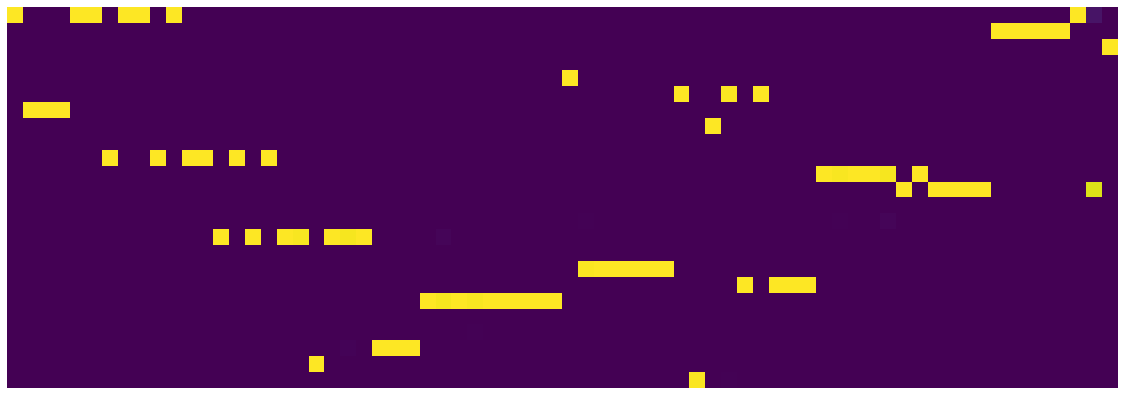

24 131 0.8679999999999999 0.45093376385048034


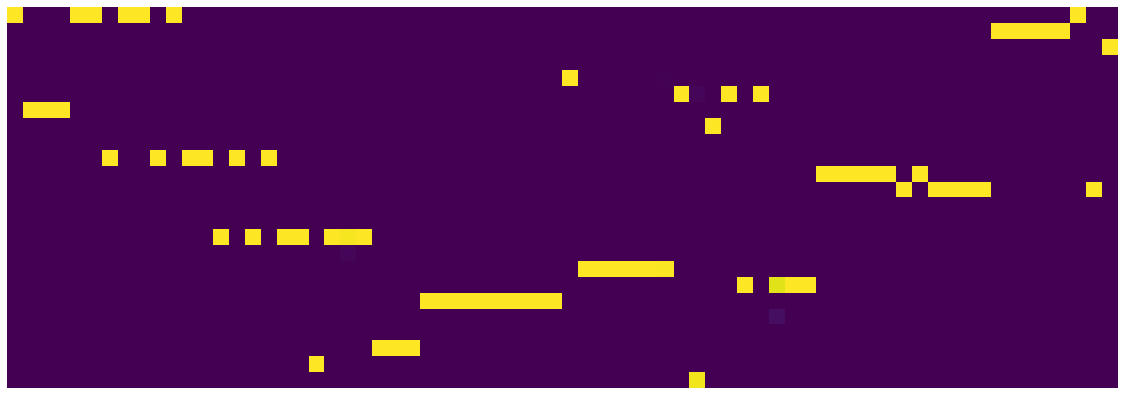

24 132 0.8669999999999999 0.4125634365715086


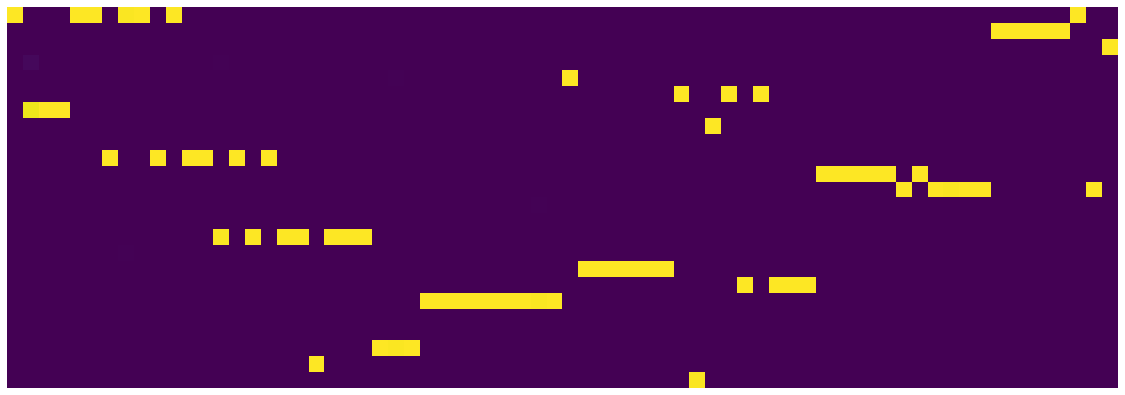

24 133 0.8659999999999999 0.4174353159964085


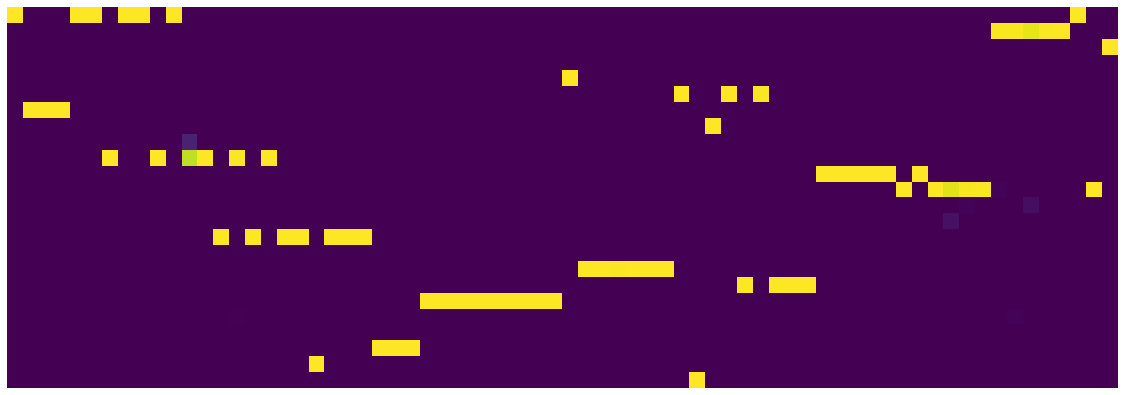

24 134 0.8649999999999999 0.4380325561389327


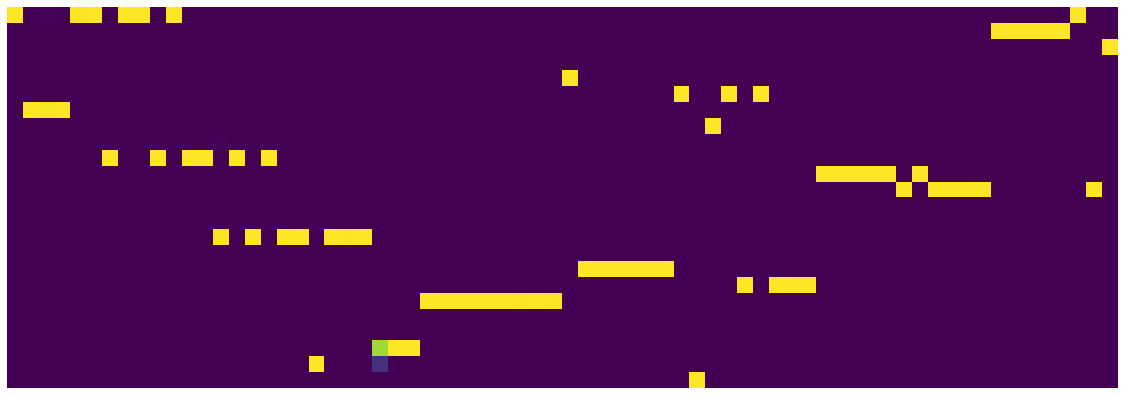

24 135 0.8639999999999999 0.4145521877333522


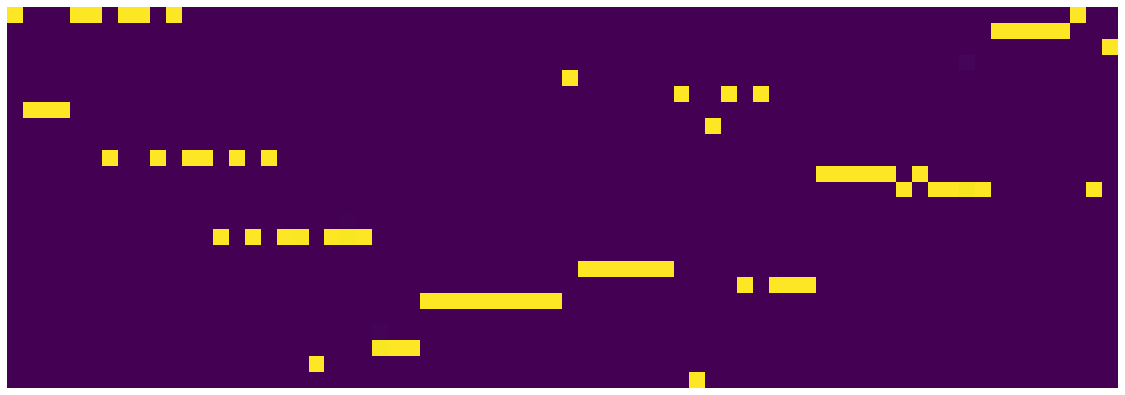

24 136 0.8629999999999999 0.4185576966032386


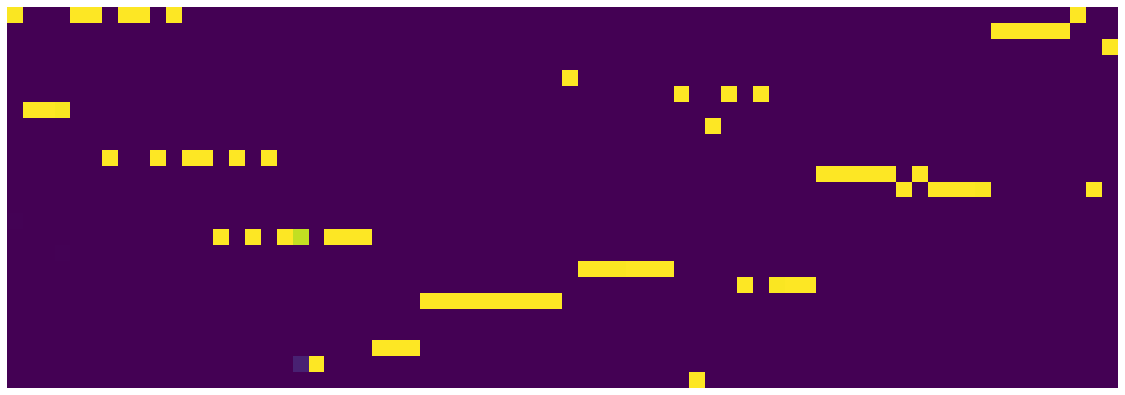

24 137 0.8619999999999999 0.4648793595843017


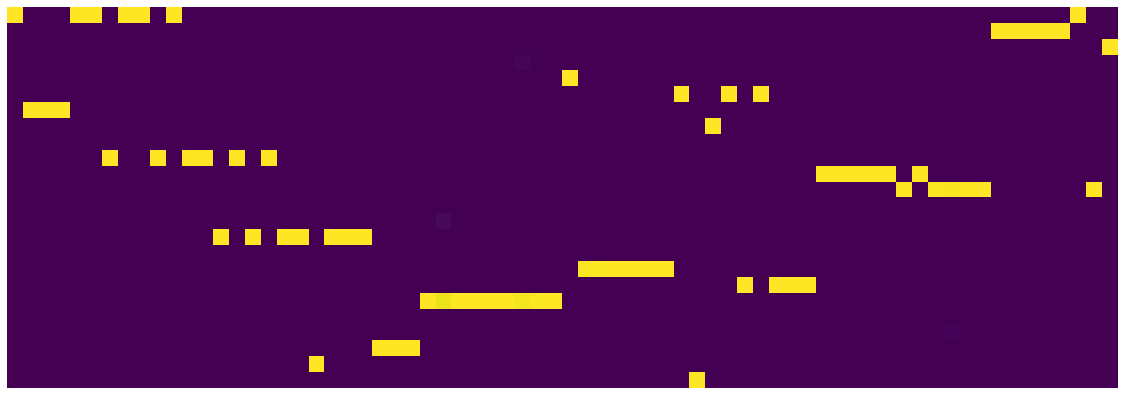

24 138 0.8609999999999999 0.4229570505209267


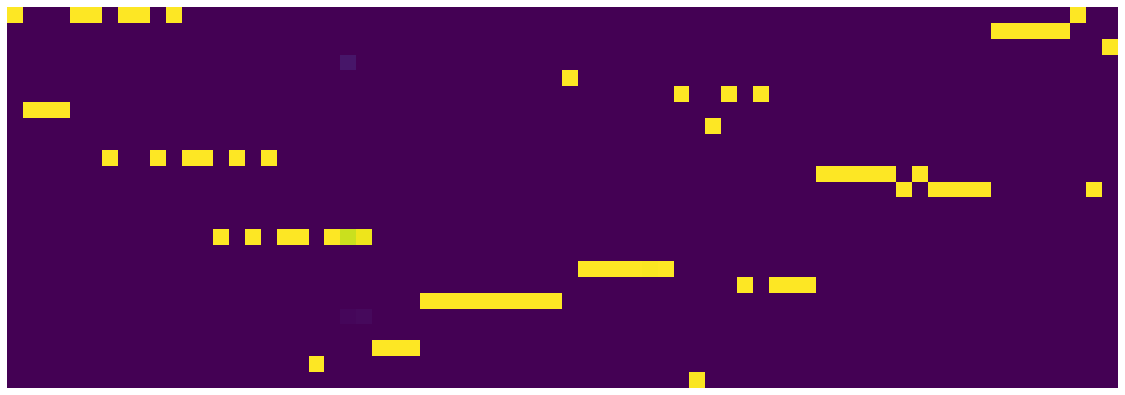

24 139 0.8599999999999999 0.4183972136117518


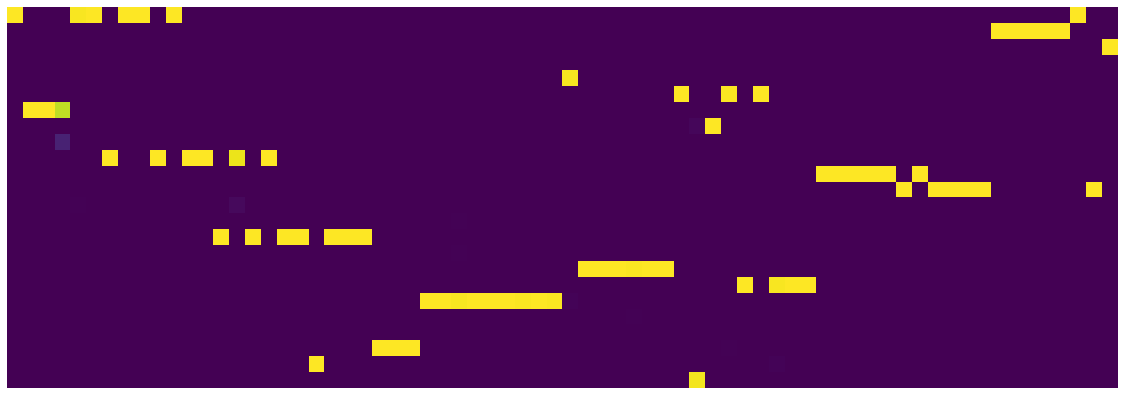

24 140 0.8589999999999999 0.4069006288424134


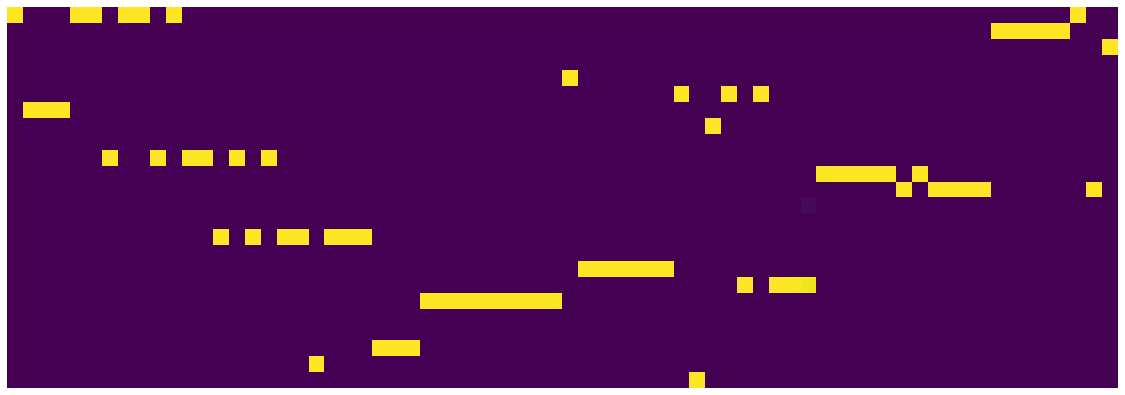

24 141 0.8579999999999999 0.4312002116814256


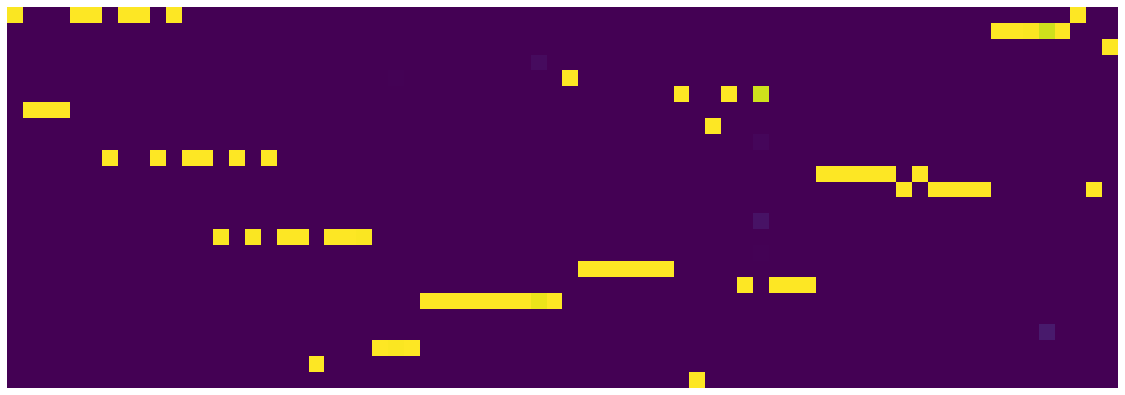

24 142 0.8569999999999999 0.4245214432477951


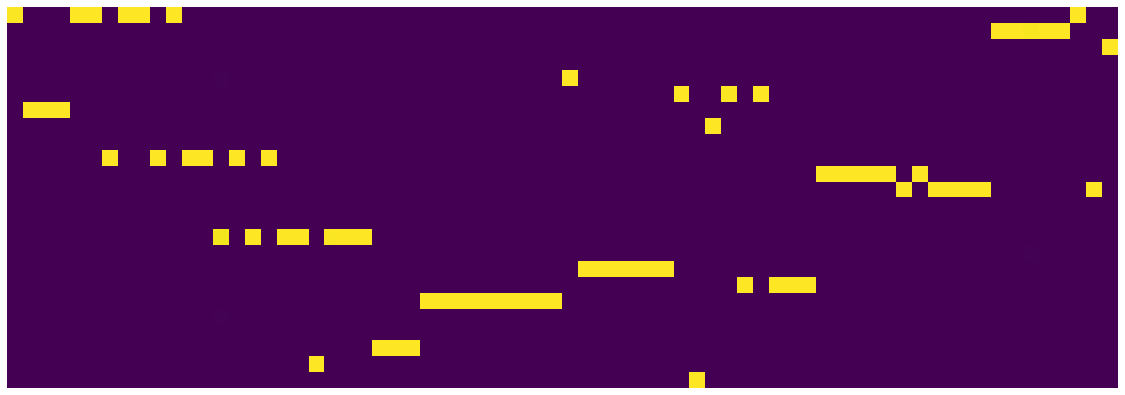

24 143 0.8559999999999999 0.41114131957292555


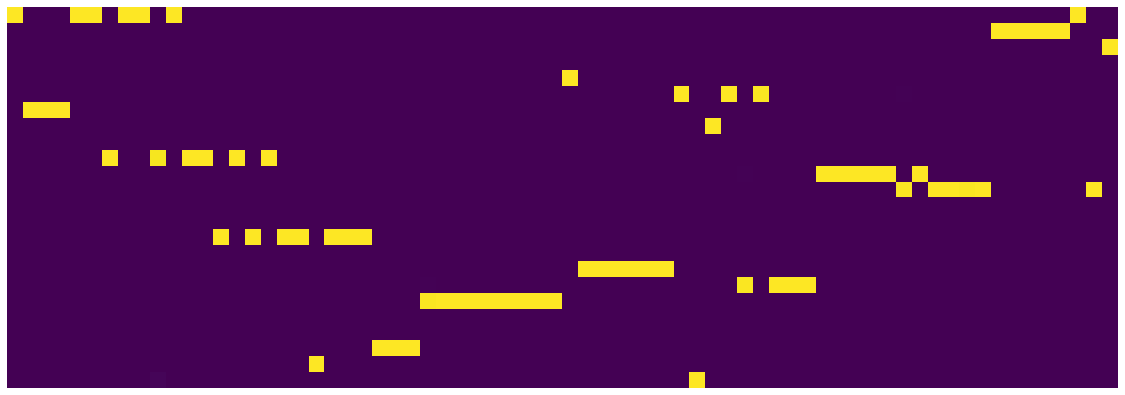

24 144 0.8549999999999999 0.45038006389513613


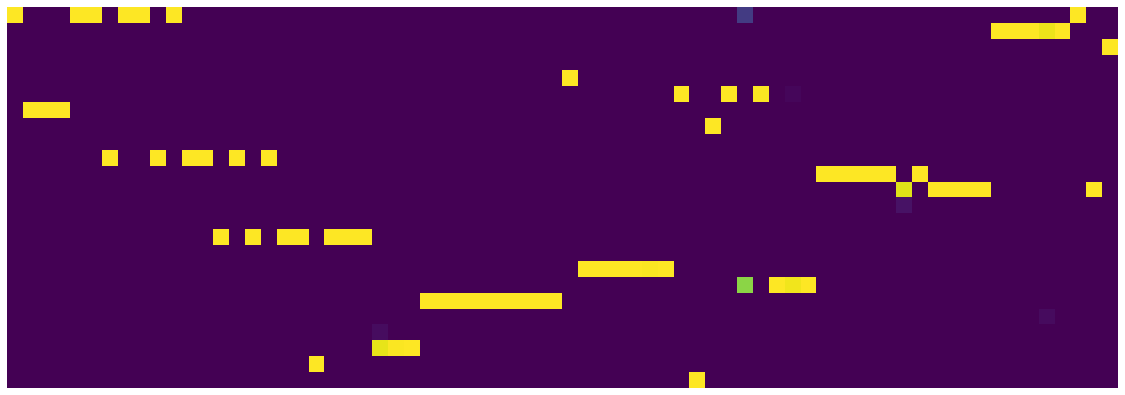

24 145 0.8539999999999999 0.4384697342291474


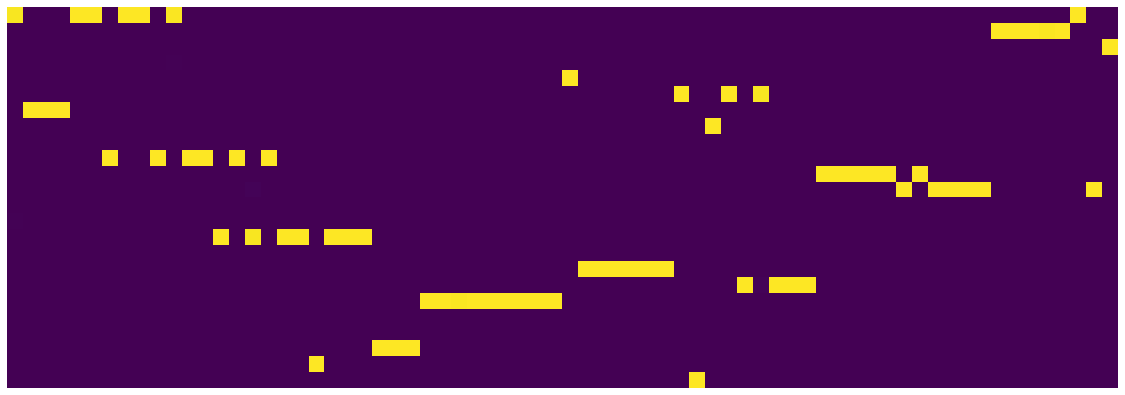

24 146 0.8529999999999999 0.4265354213304818


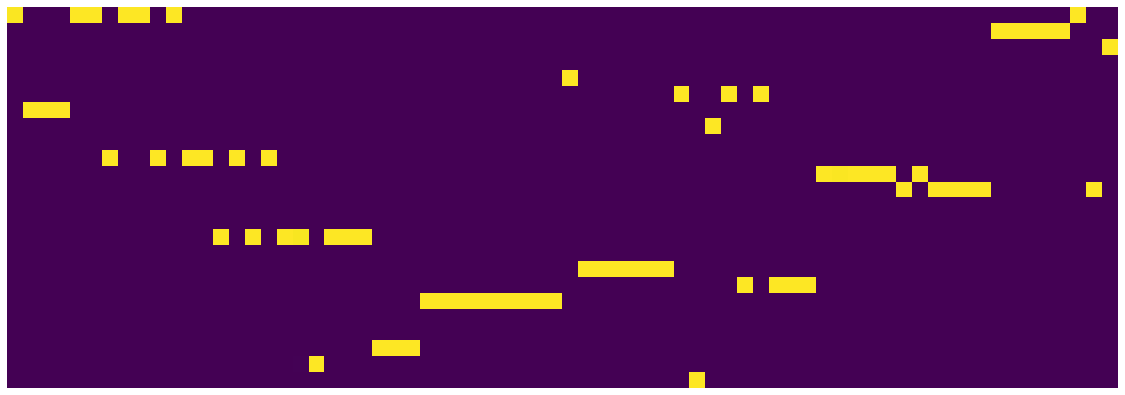

24 147 0.8519999999999999 0.42859314642846585


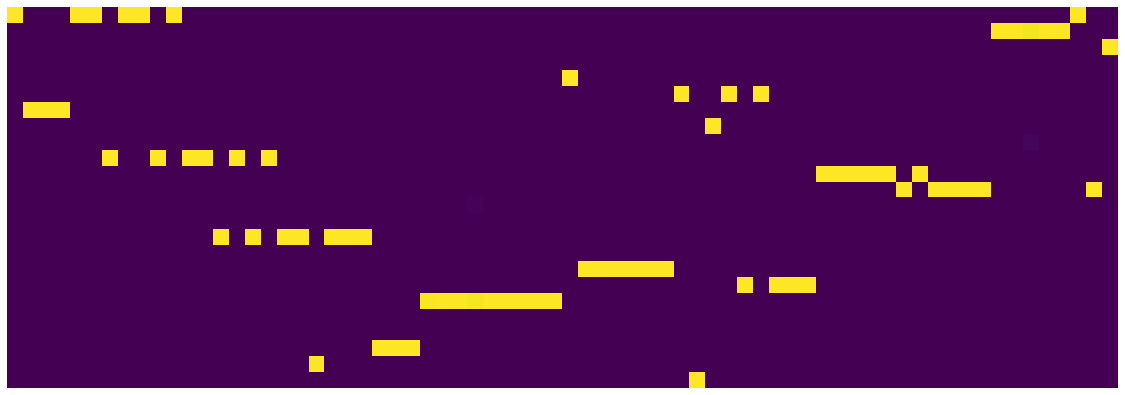

24 148 0.8509999999999999 0.44088932117447255


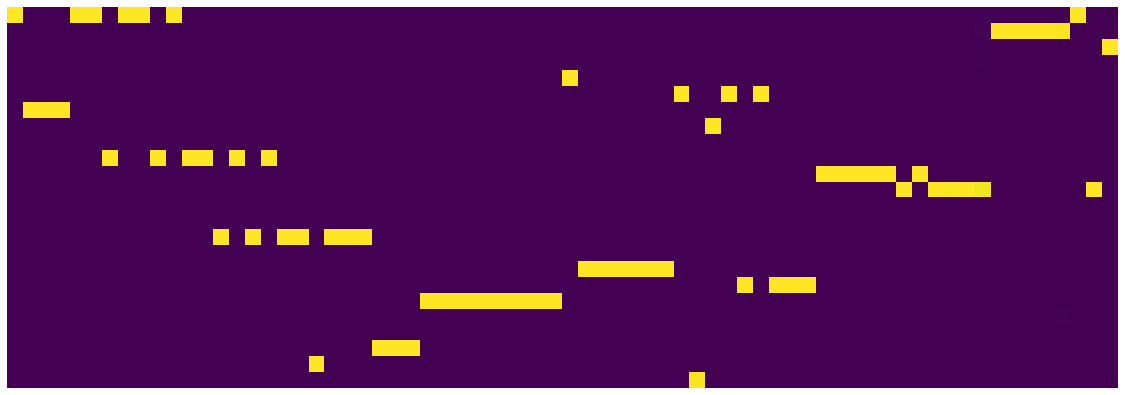

24 149 0.8499999999999999 0.42567936340346935


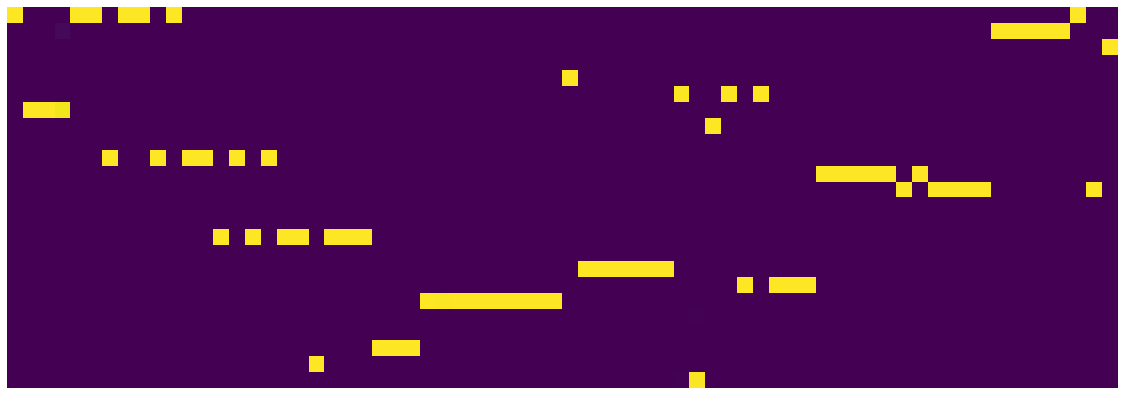

24 150 0.8489999999999999 0.442111973837018


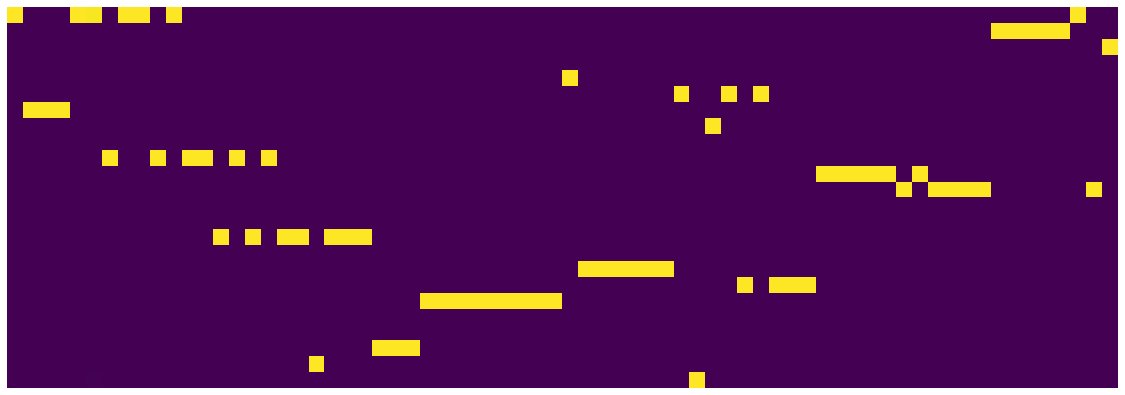

24 151 0.8479999999999999 0.42212095083668827


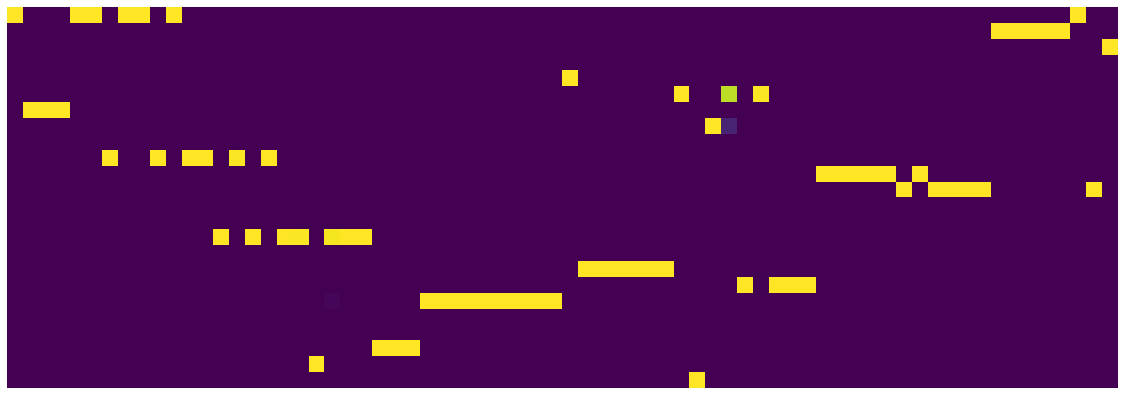

24 152 0.8469999999999999 0.4059355441480875


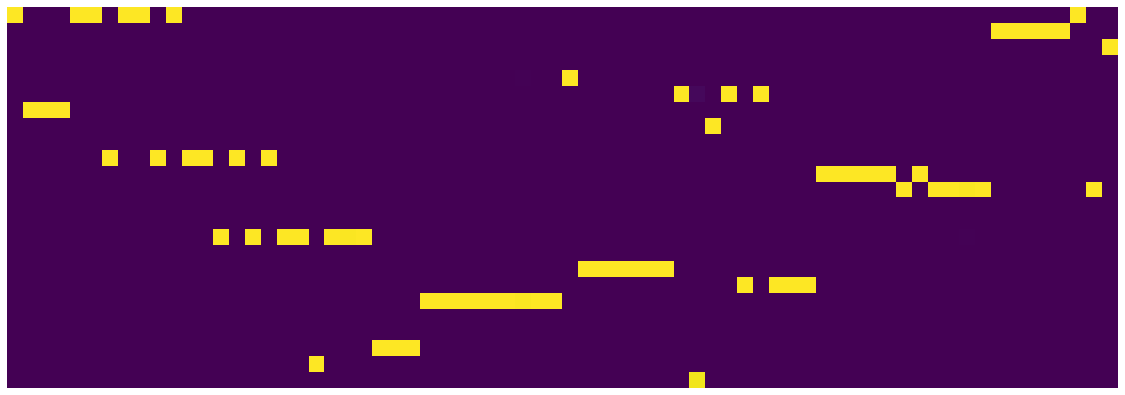

24 153 0.8459999999999999 0.41690877918154


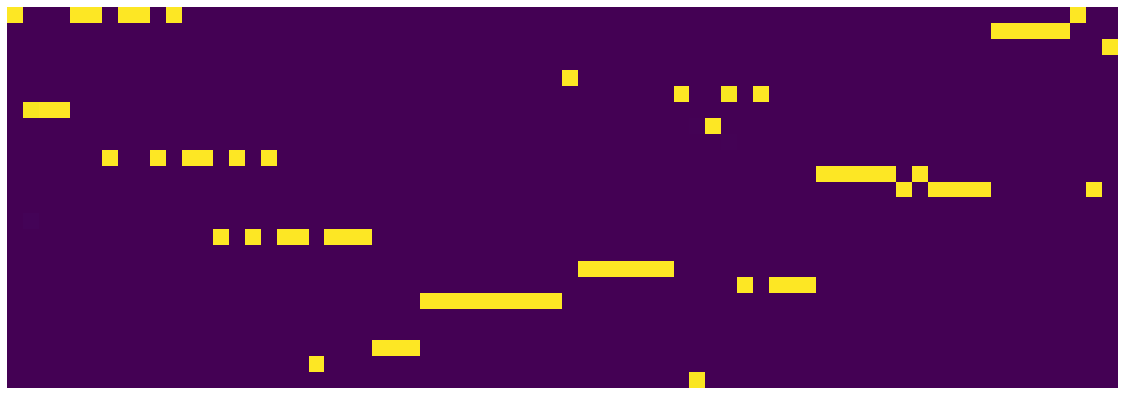

24 154 0.8449999999999999 0.41603241190314294


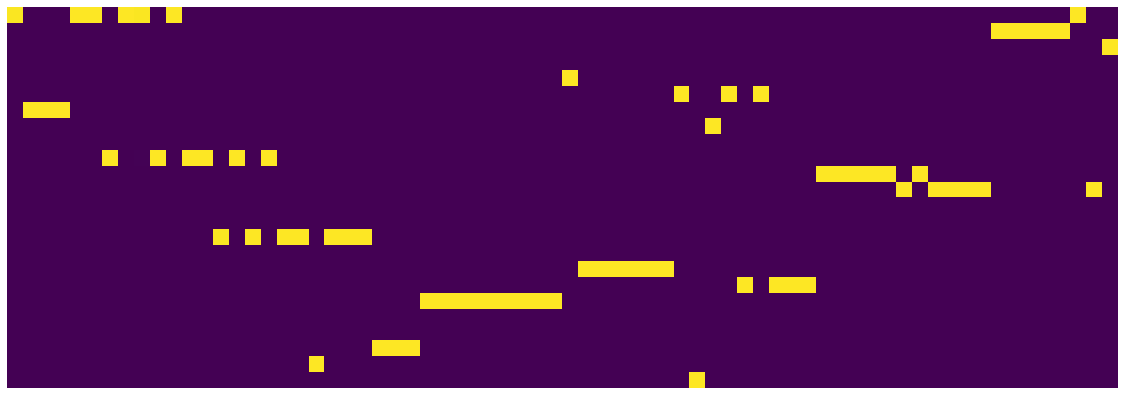

24 155 0.8439999999999999 0.4120383189059794


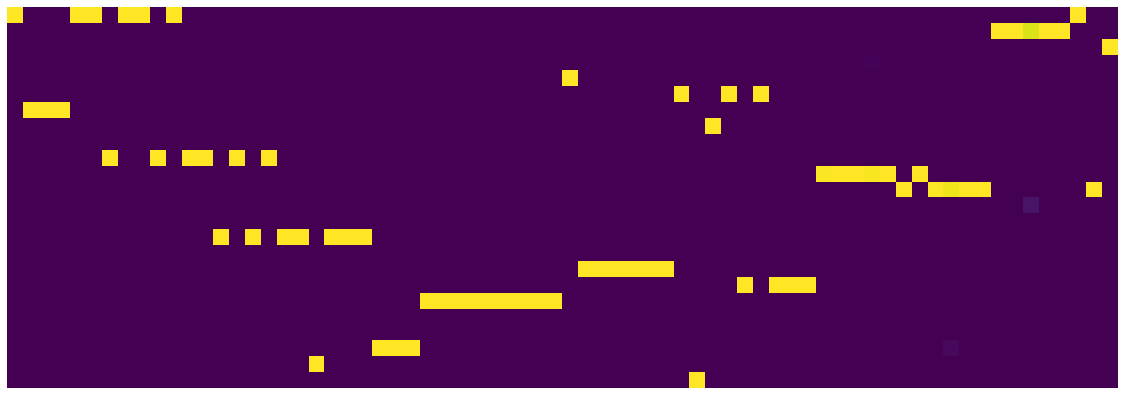

24 156 0.8429999999999999 0.41461929902434347


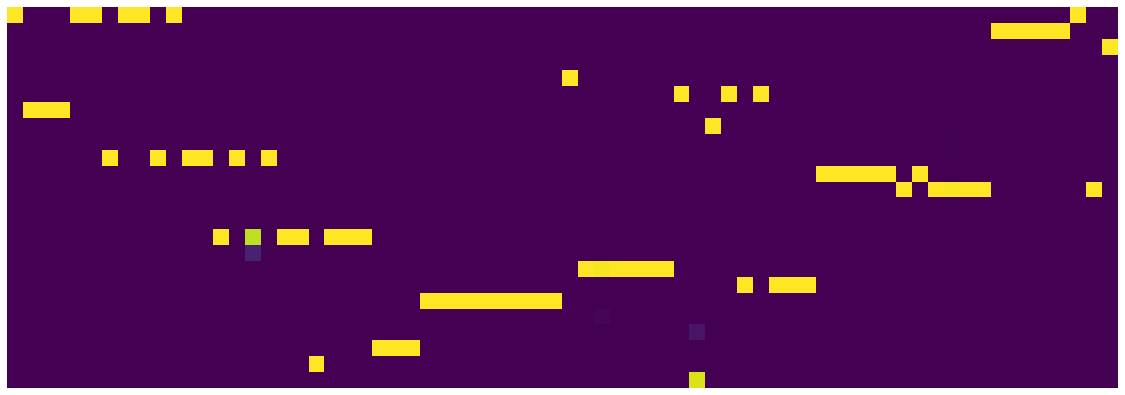

24 157 0.8419999999999999 0.4131215576082468


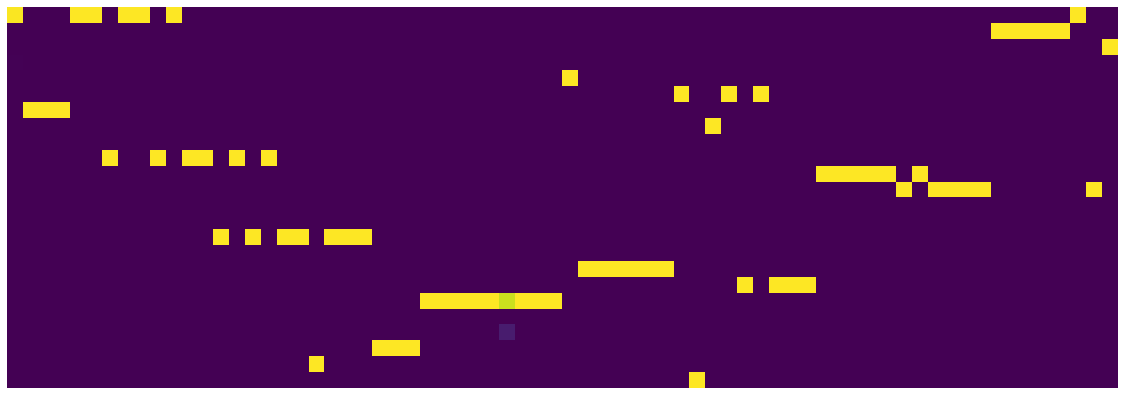

24 158 0.8409999999999999 0.49713550163432957


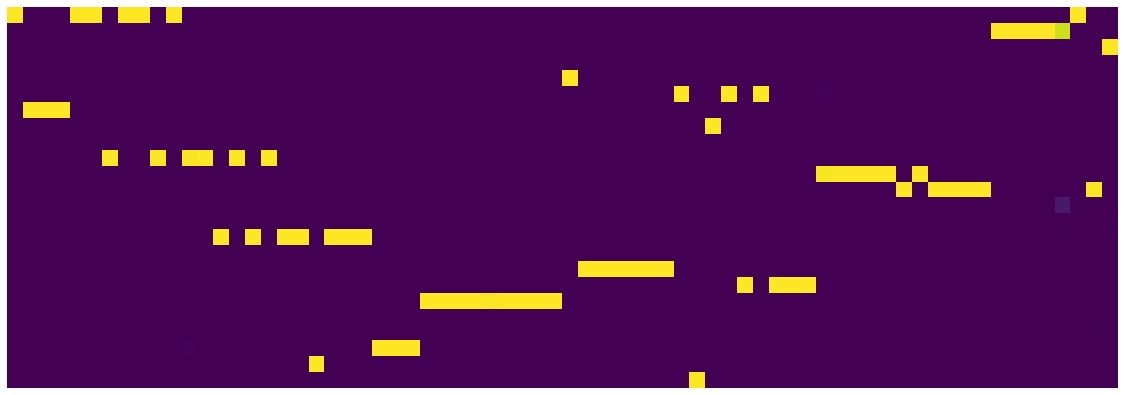

24 159 0.8399999999999999 0.417925292532891


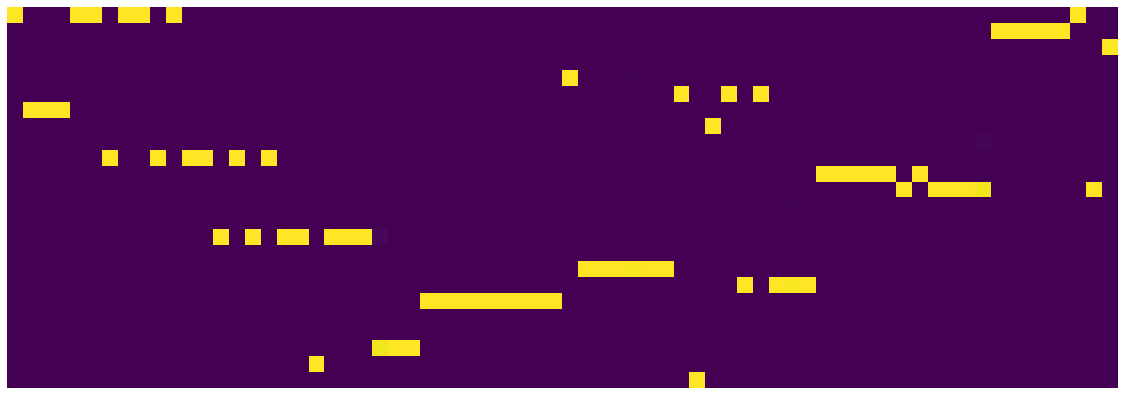

24 160 0.8389999999999999 0.4454572381451726


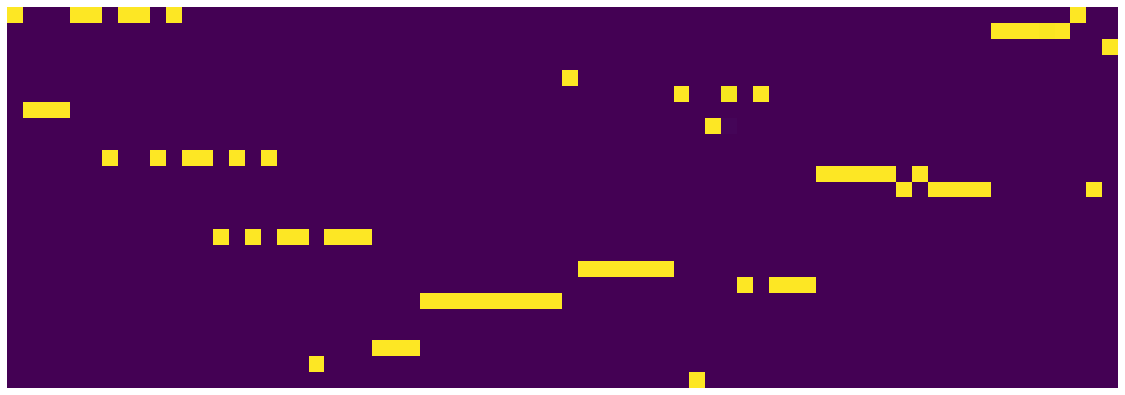

24 161 0.8379999999999999 0.4089438651688397


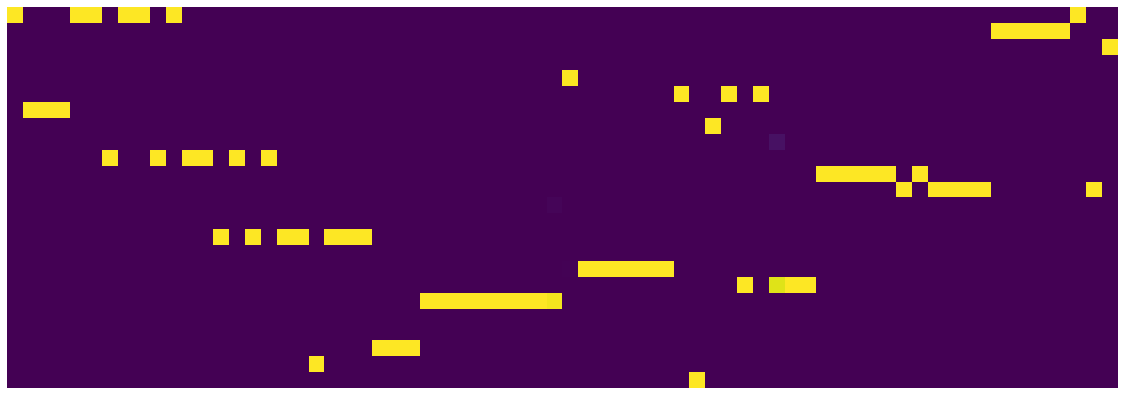

24 162 0.8369999999999999 0.40614136811345813


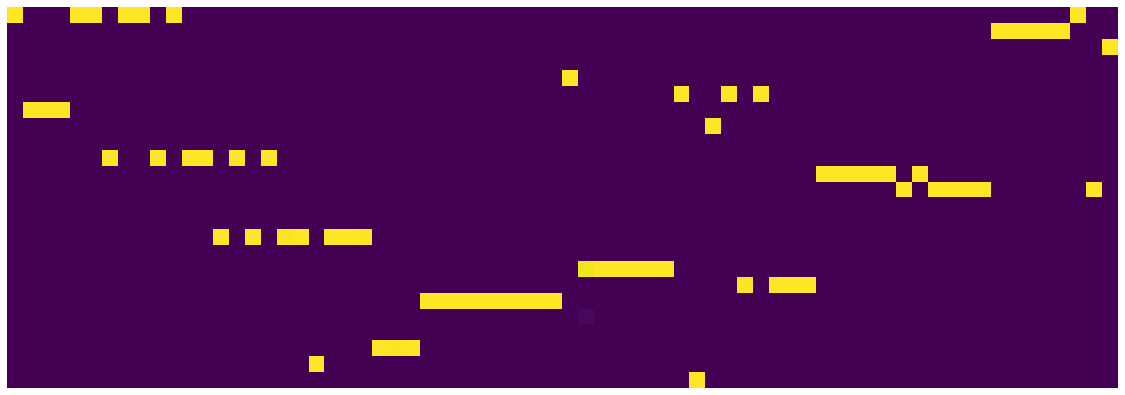

24 163 0.8359999999999999 0.42806265437975527


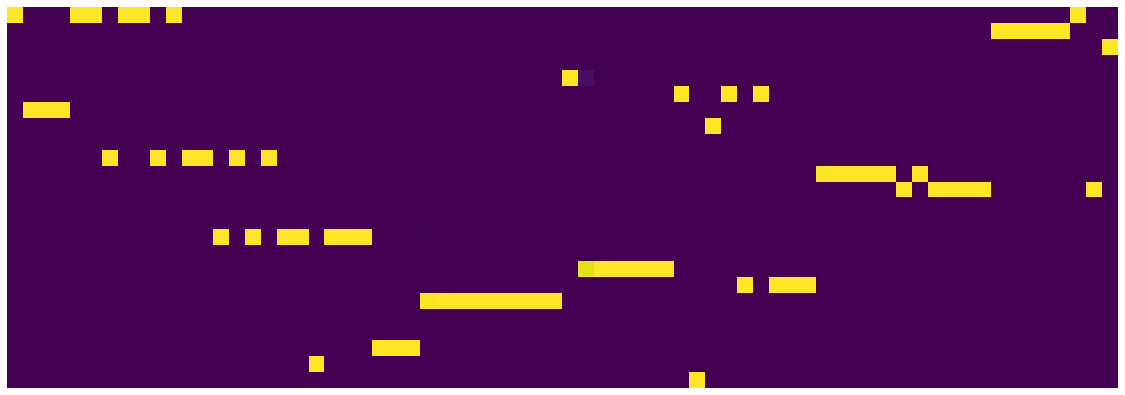

24 164 0.8349999999999999 0.4082657501101494


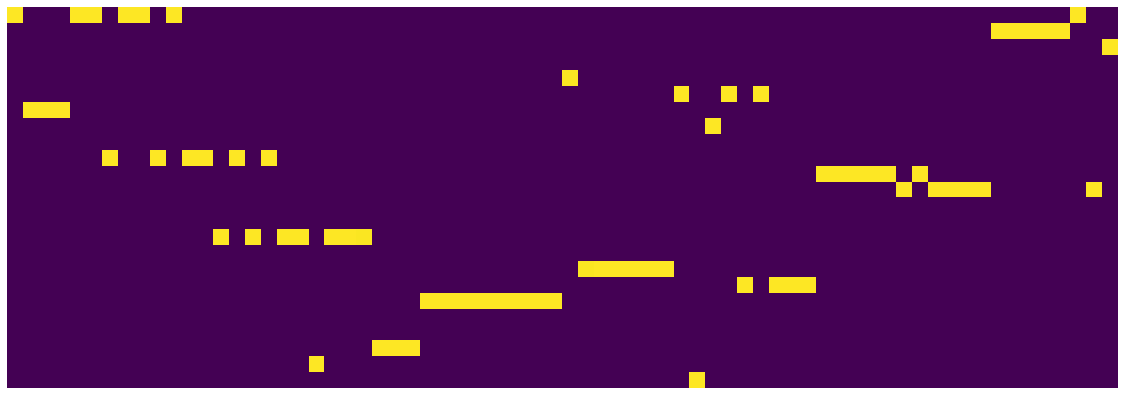

24 165 0.8339999999999999 0.41317426022142173


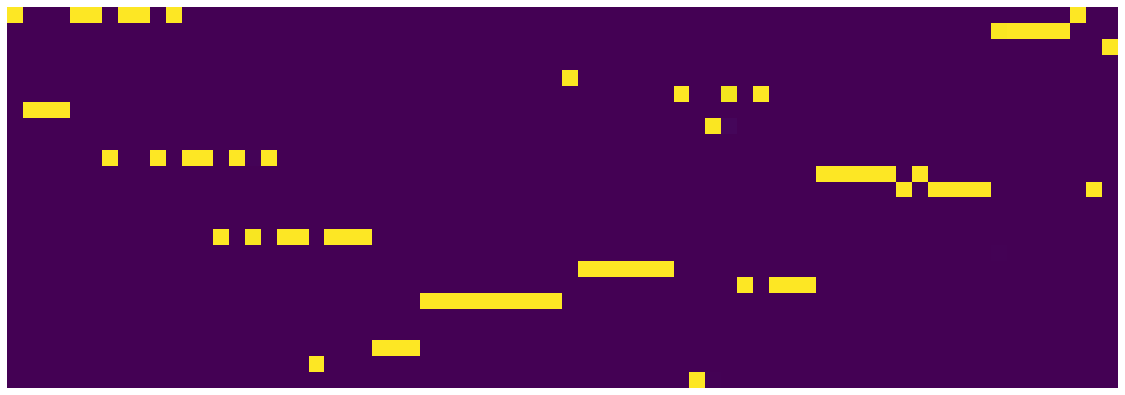

24 166 0.8329999999999999 0.4224107778631151


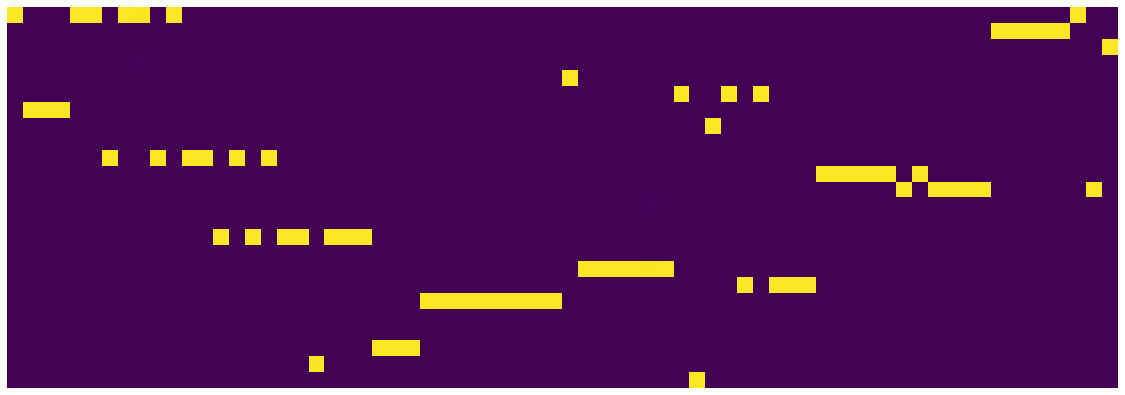

24 167 0.8319999999999999 0.41847307765856384


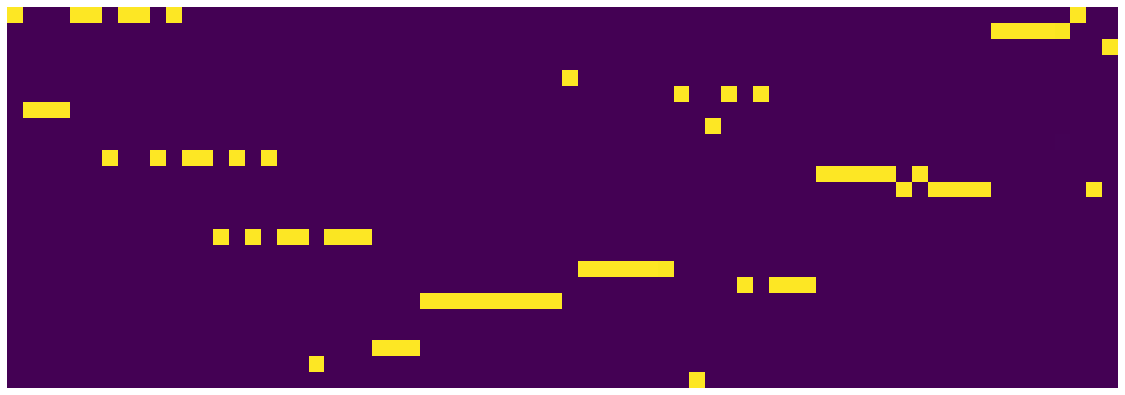

24 168 0.8309999999999998 0.4299796616658568


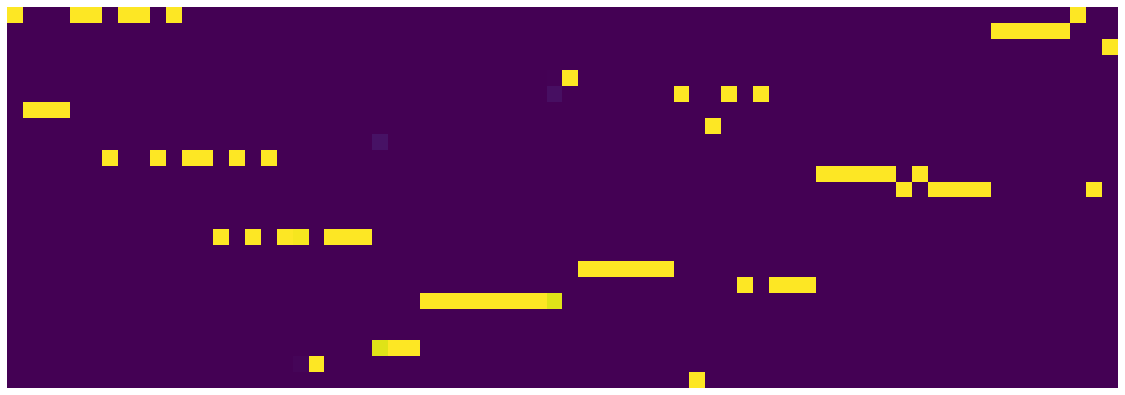

24 169 0.8299999999999998 0.43187855891883375


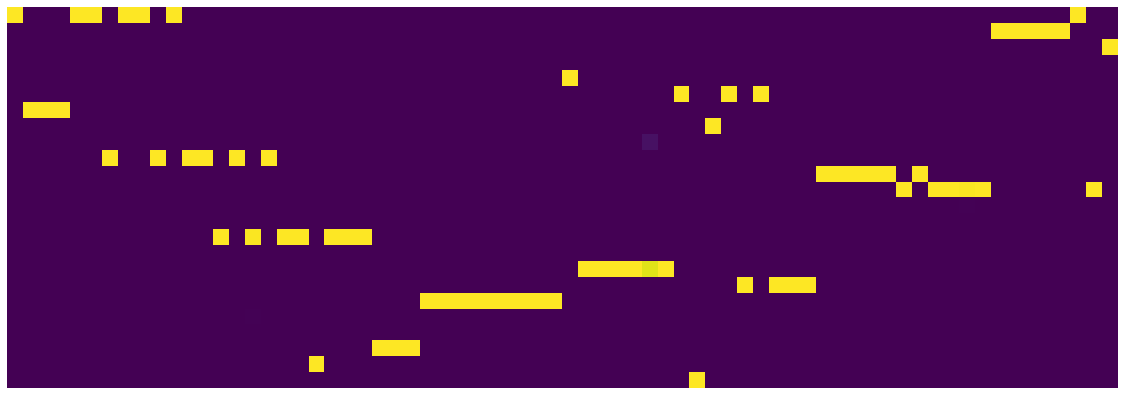

24 170 0.8289999999999998 0.44015378374606373


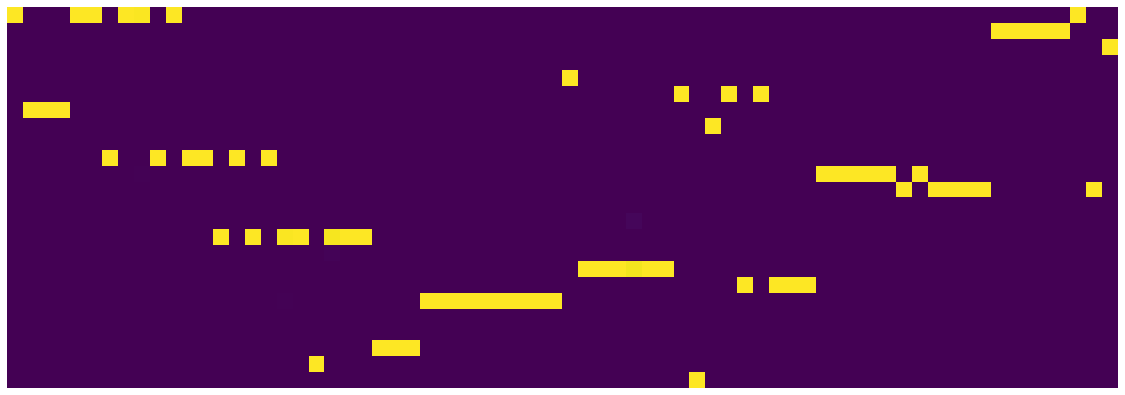

24 171 0.8279999999999998 0.40551206478849056


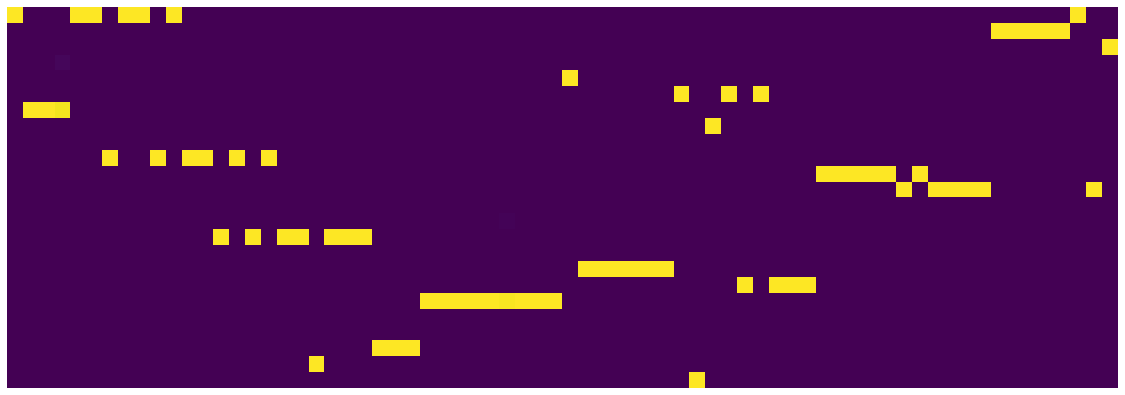

24 172 0.8269999999999998 0.4191556429490447


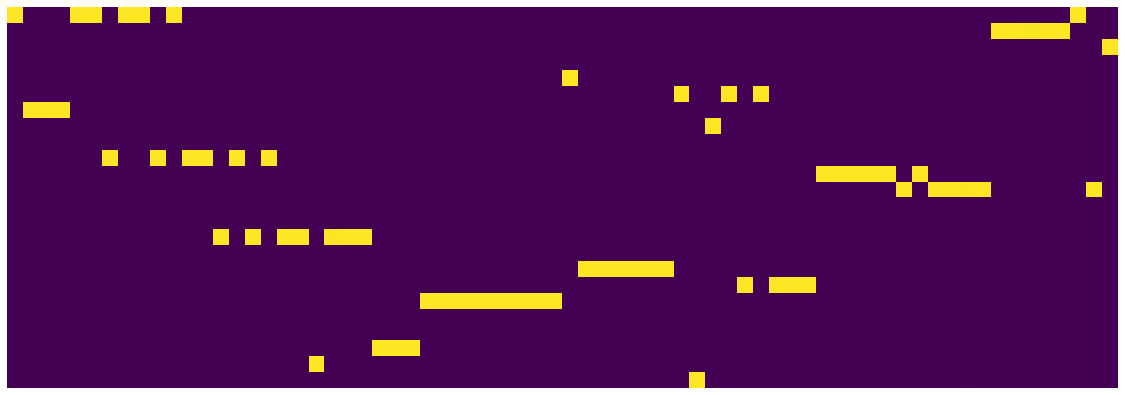

24 173 0.8259999999999998 0.4065993599593639


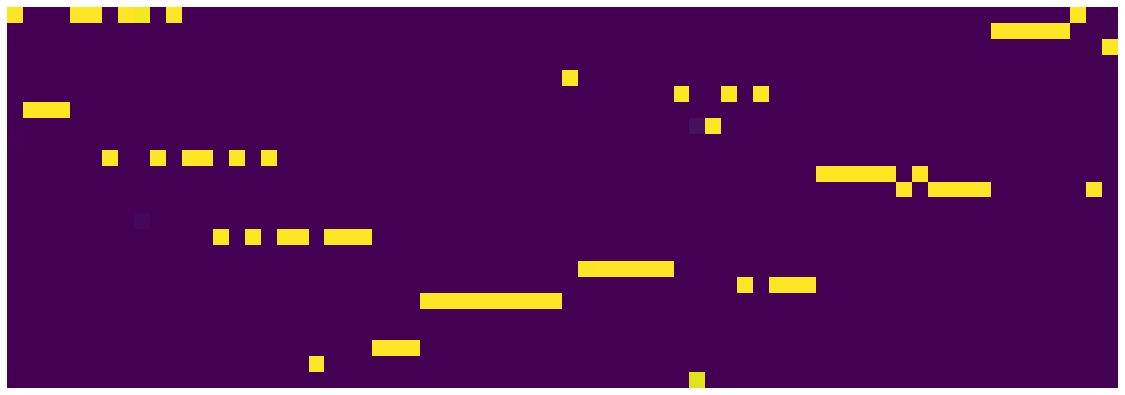

24 174 0.8249999999999998 0.4557273745536804


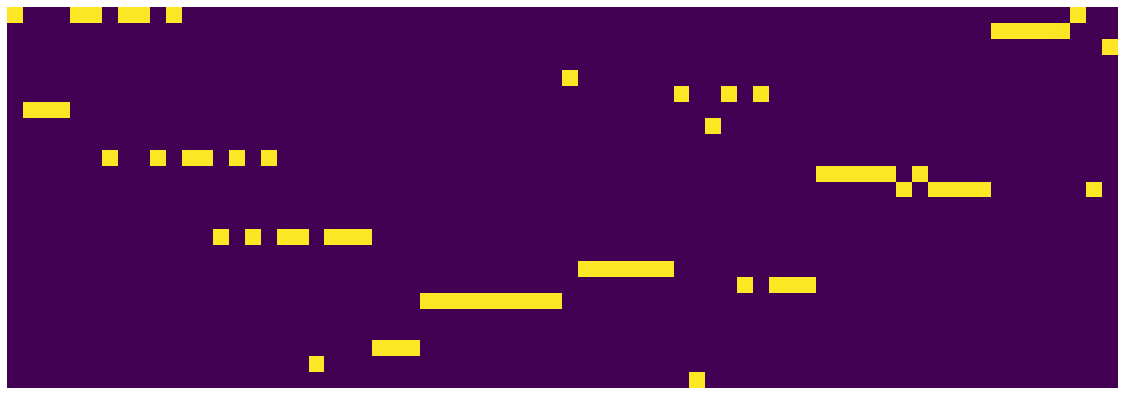

24 175 0.8239999999999998 0.4078013303689659


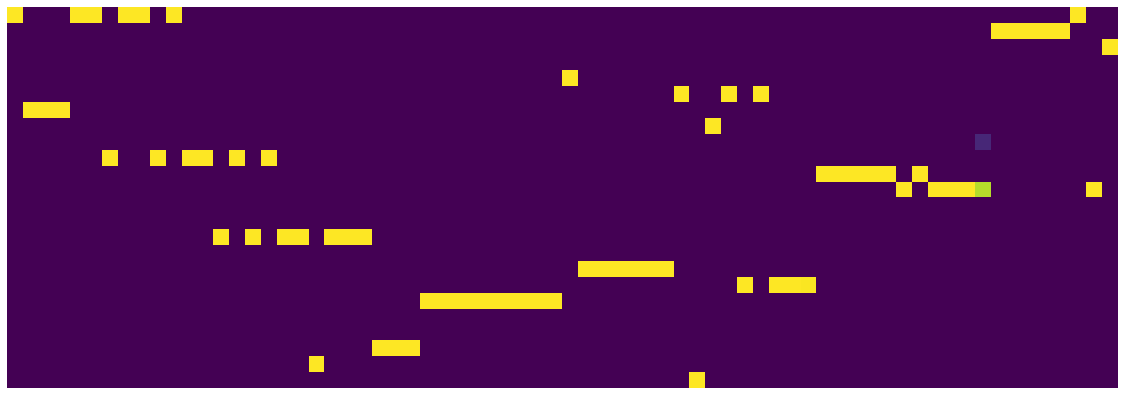

24 176 0.8229999999999998 0.4151857621967793


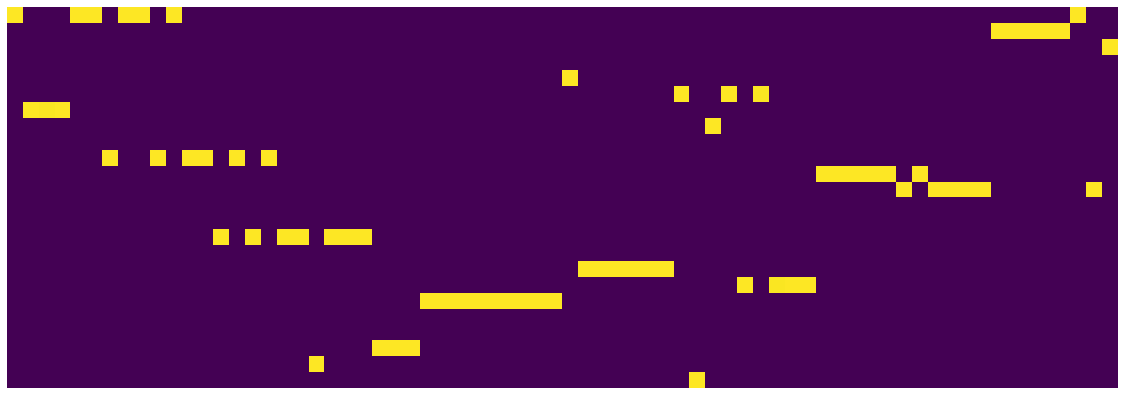

24 177 0.8219999999999998 0.43107264311984184


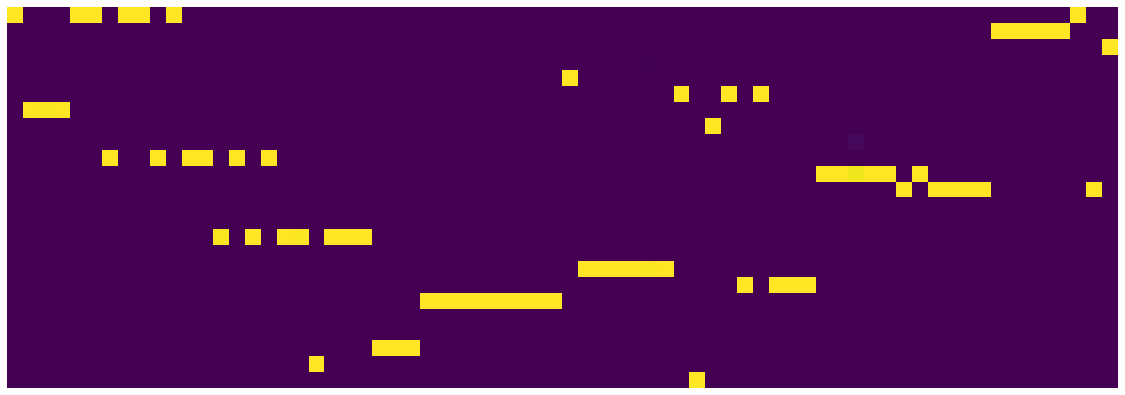

24 178 0.8209999999999998 0.4178982273675501


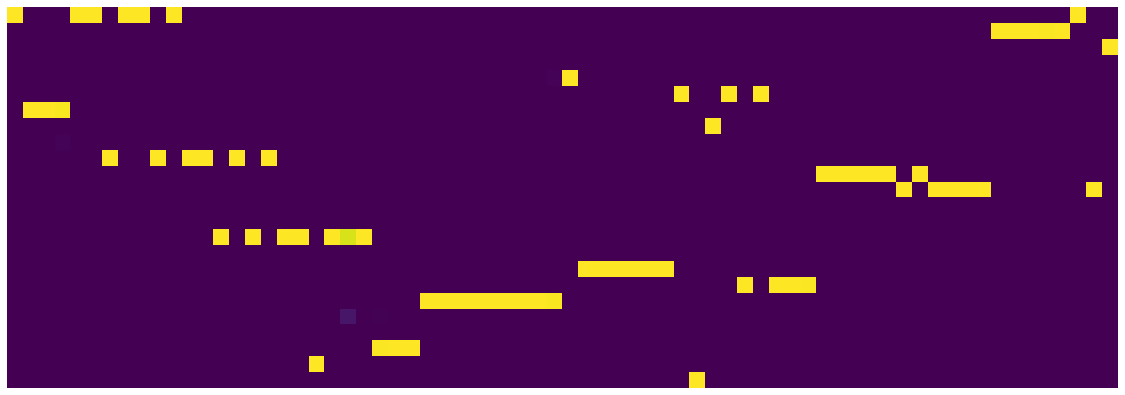

24 179 0.8199999999999998 0.4162510563619435


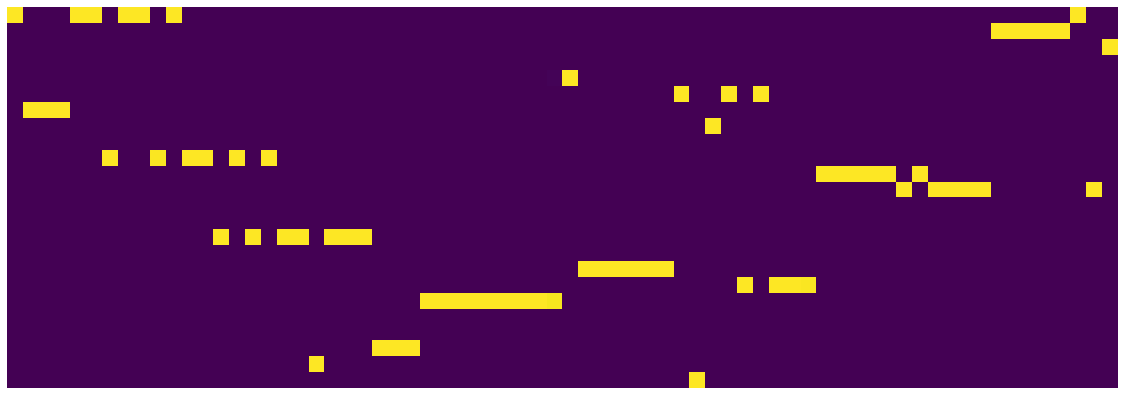

24 180 0.8189999999999998 0.43006617706269024


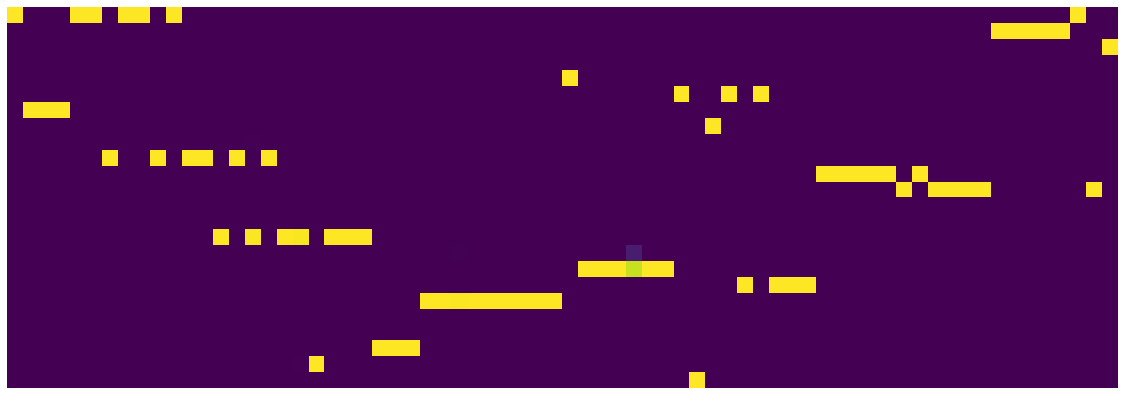

24 181 0.8179999999999998 0.40564721105620266


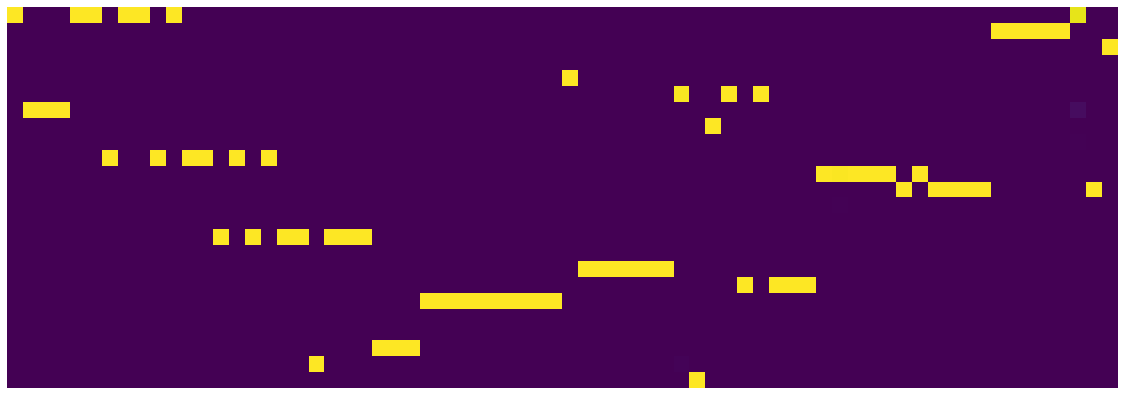

24 182 0.8169999999999998 0.4074536588974297


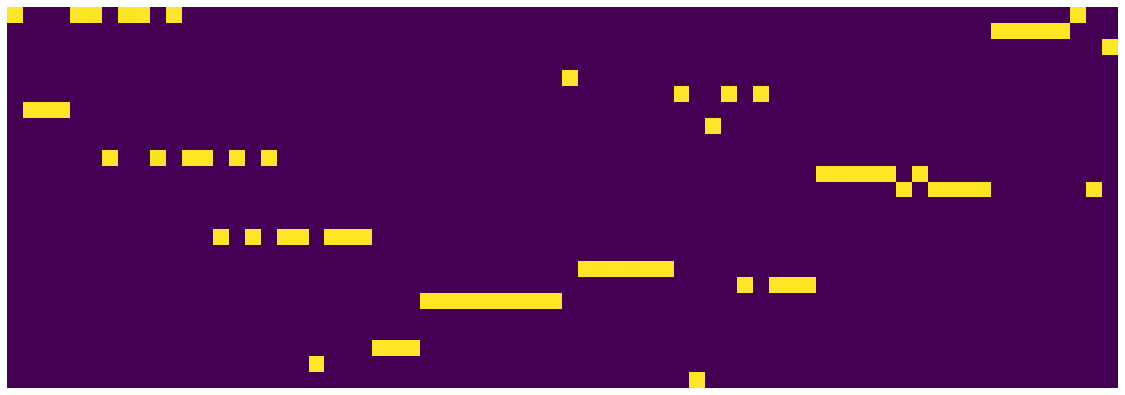

24 183 0.8159999999999998 0.41167480647563937


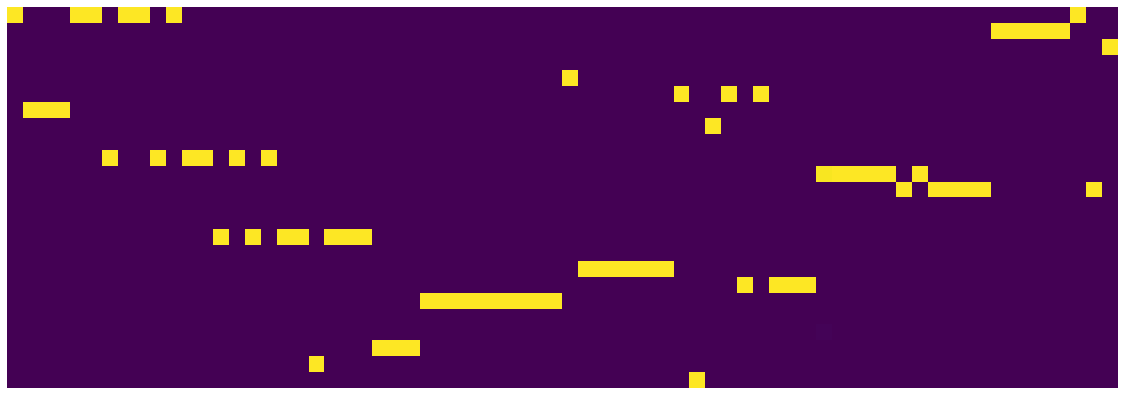

24 184 0.8149999999999998 0.42876670537516476


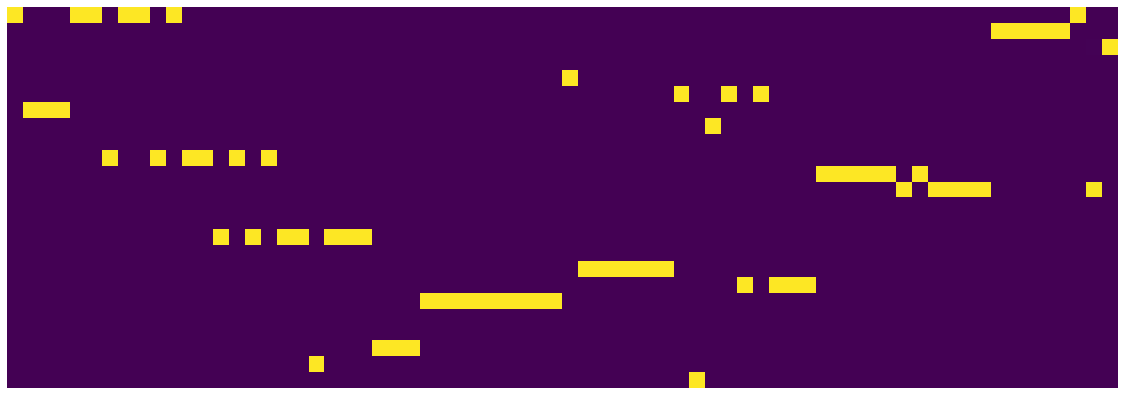

24 185 0.8139999999999998 0.4779841758310795


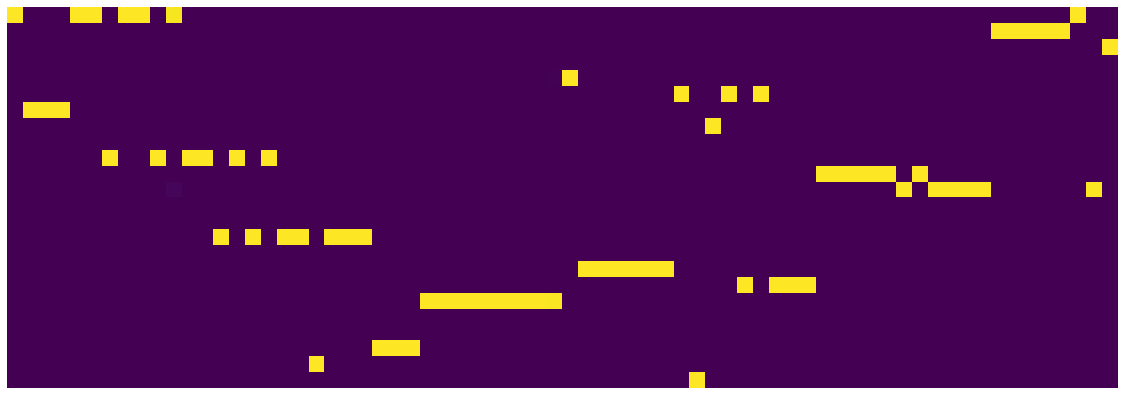

24 186 0.8129999999999998 0.40870759095996617


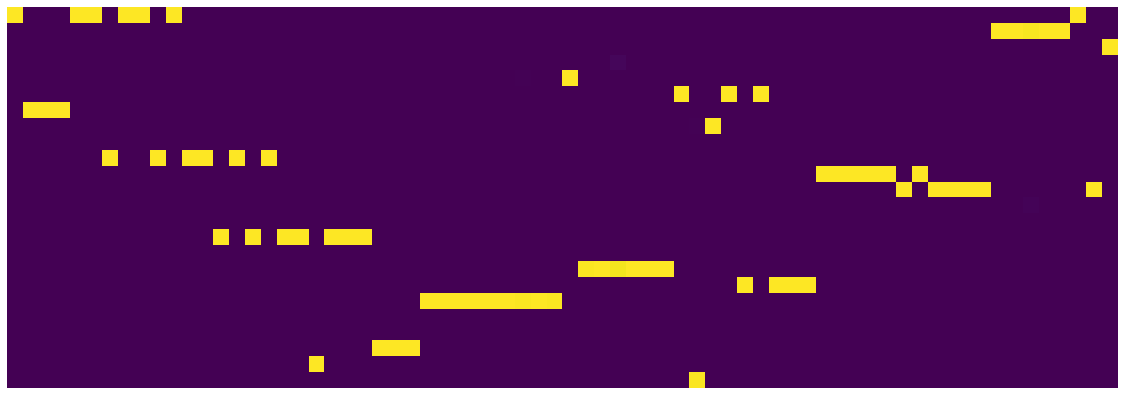

24 187 0.8119999999999998 0.4113439770415425


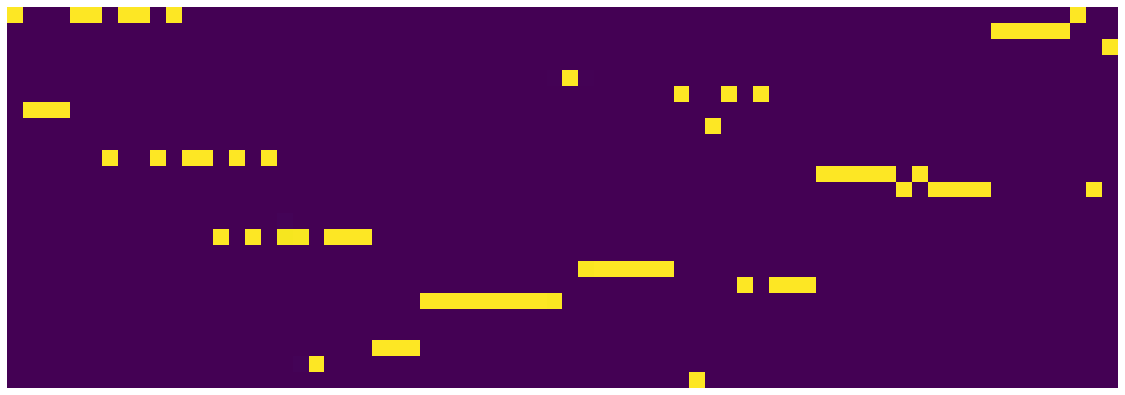

24 188 0.8109999999999998 0.43033549981191754


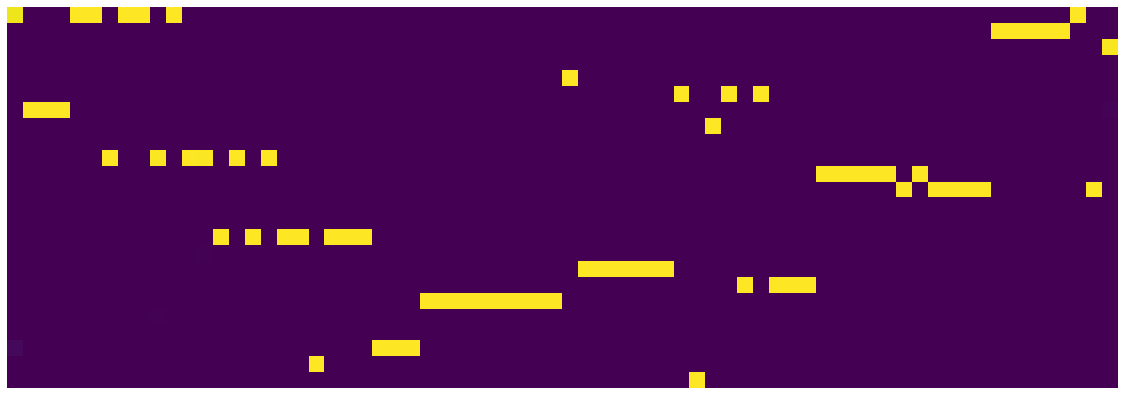

24 189 0.8099999999999998 0.4207343393936753


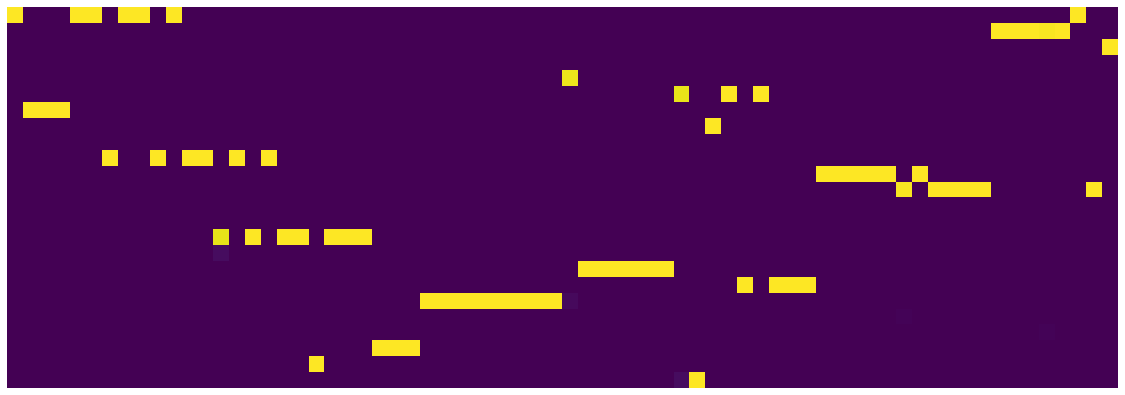

24 190 0.8089999999999998 0.41143066715449095


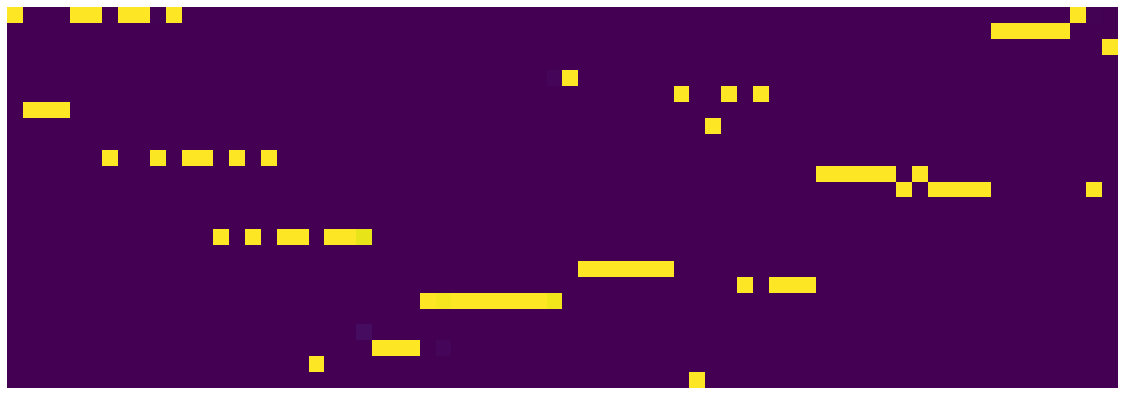

24 191 0.8079999999999998 0.4085284866392612


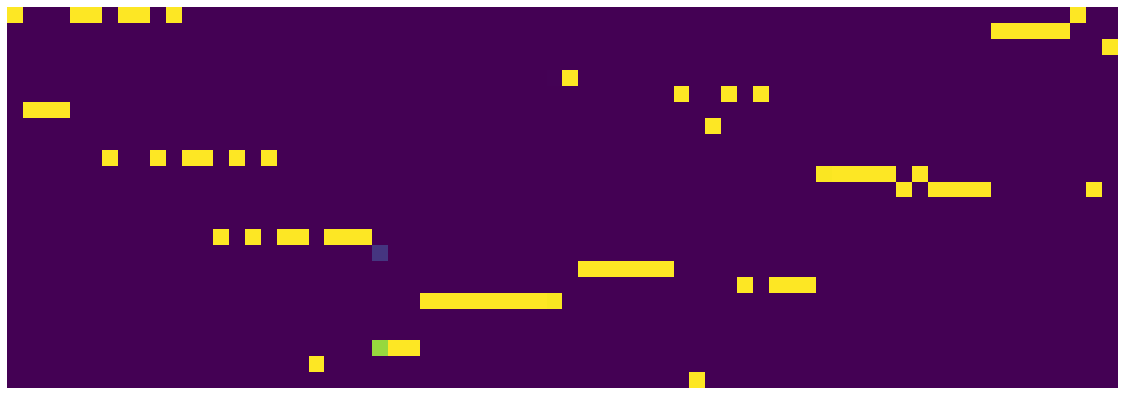

24 192 0.8069999999999998 0.42063656402751803


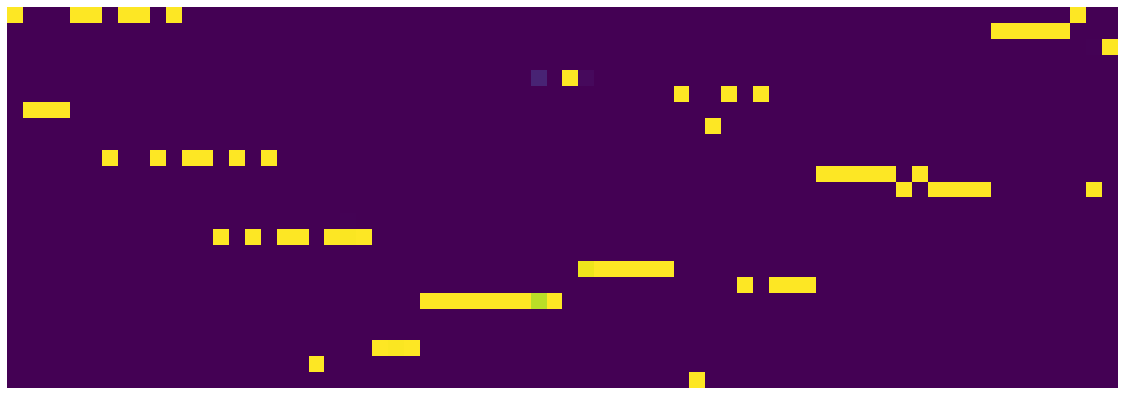

24 193 0.8059999999999998 0.4192530279047787


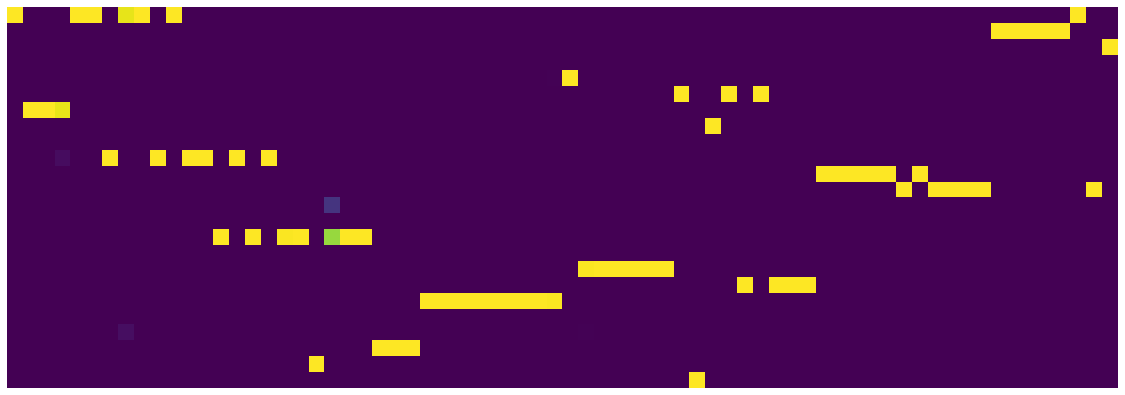

24 194 0.8049999999999998 0.4246749366633594


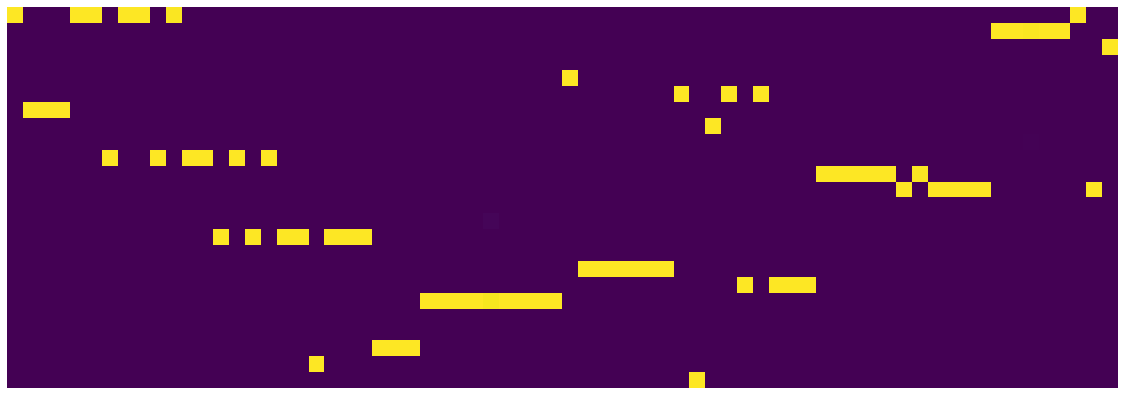

24 195 0.8039999999999998 0.42627974720671774


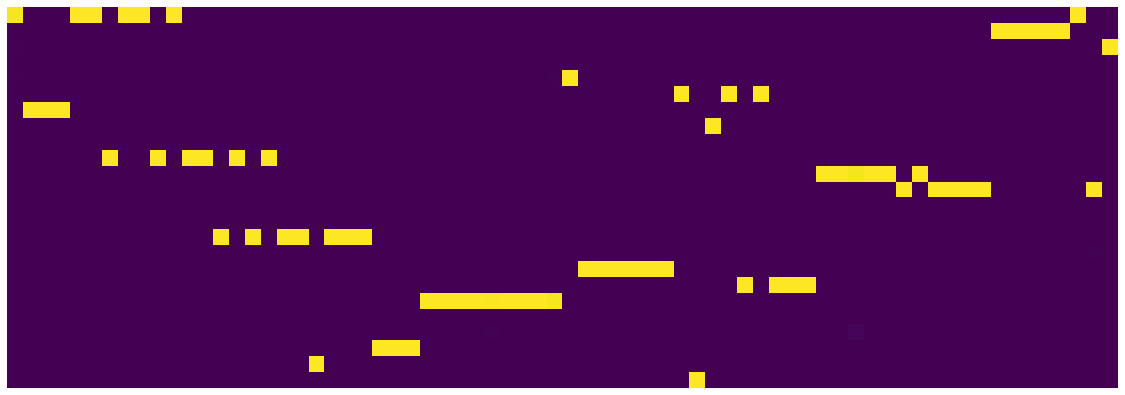

24 196 0.8029999999999998 0.41311260322108867


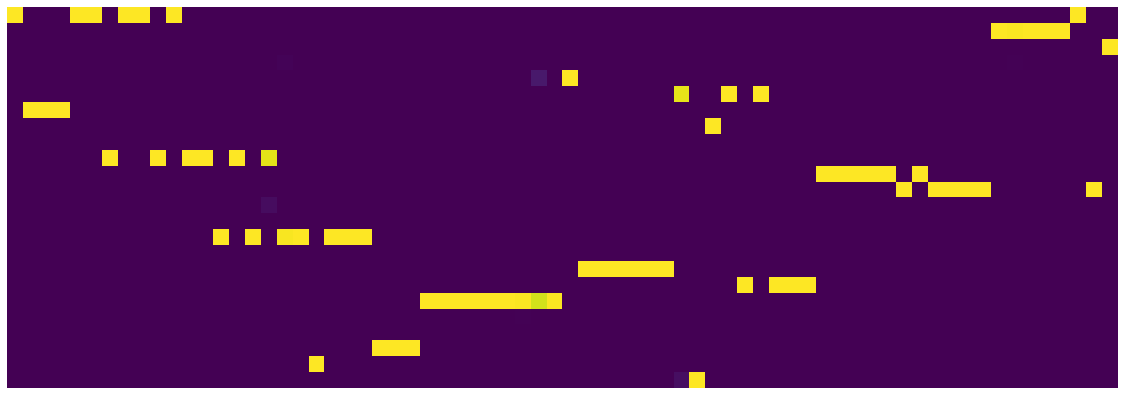

24 197 0.8019999999999998 0.4070434949360788


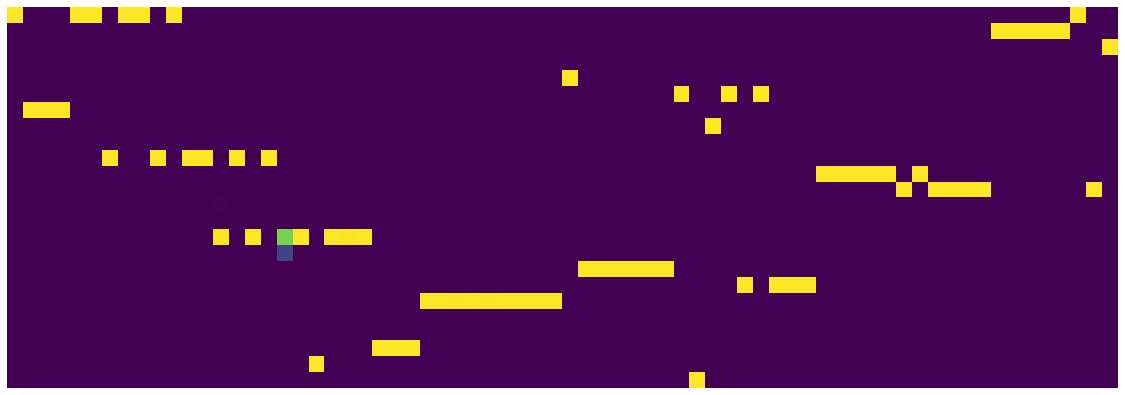

24 198 0.8009999999999998 0.43244996946305037


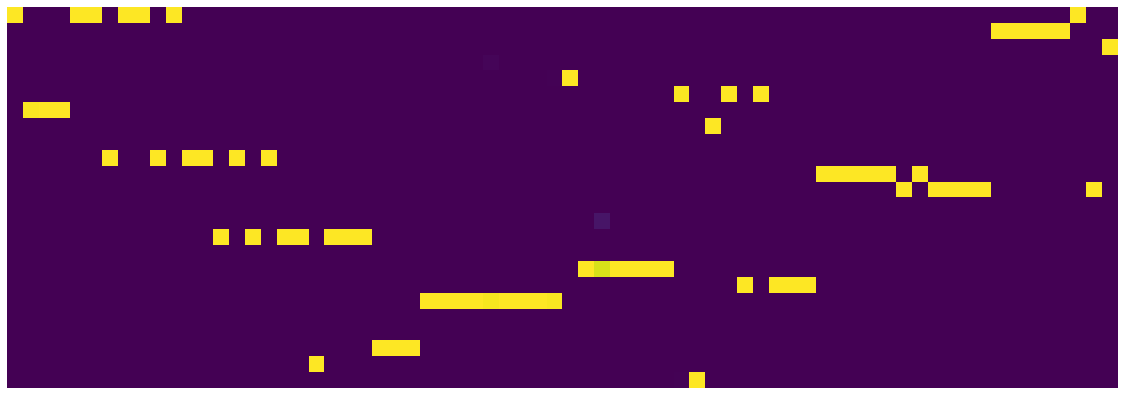

24 199 0.7999999999999998 0.41444243574514983


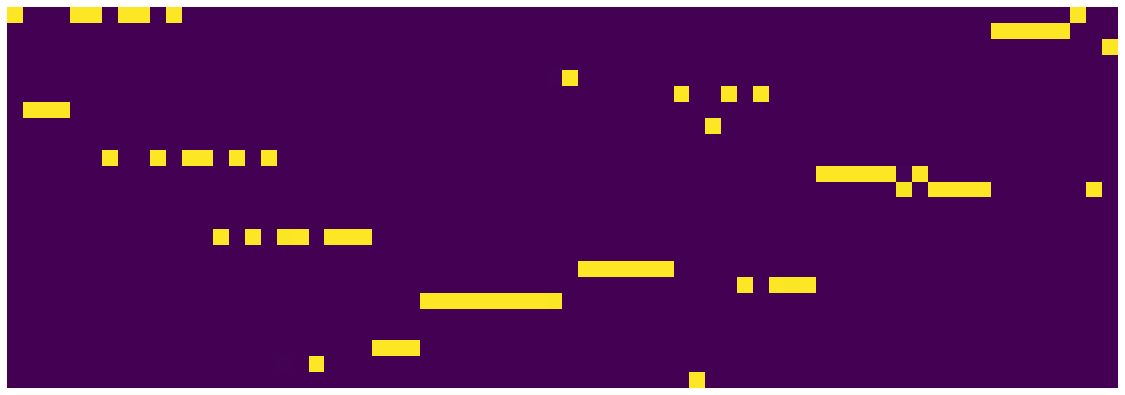

24 200 0.7989999999999998 0.4069891972467303


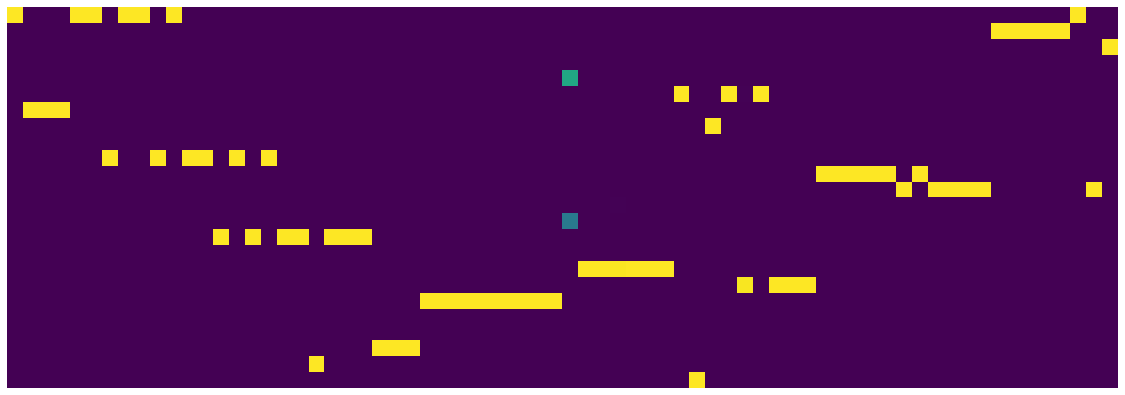

24 201 0.7979999999999998 0.4322988739237189


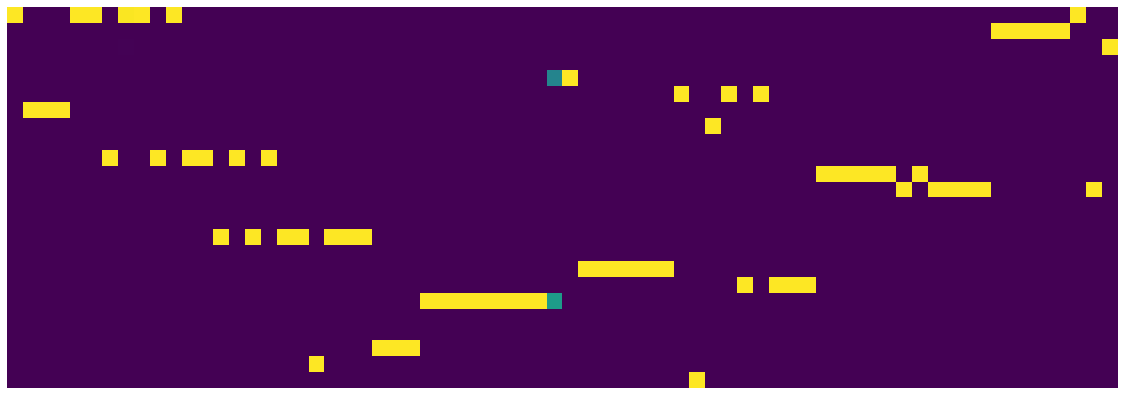

24 202 0.7969999999999998 0.4208093071356416


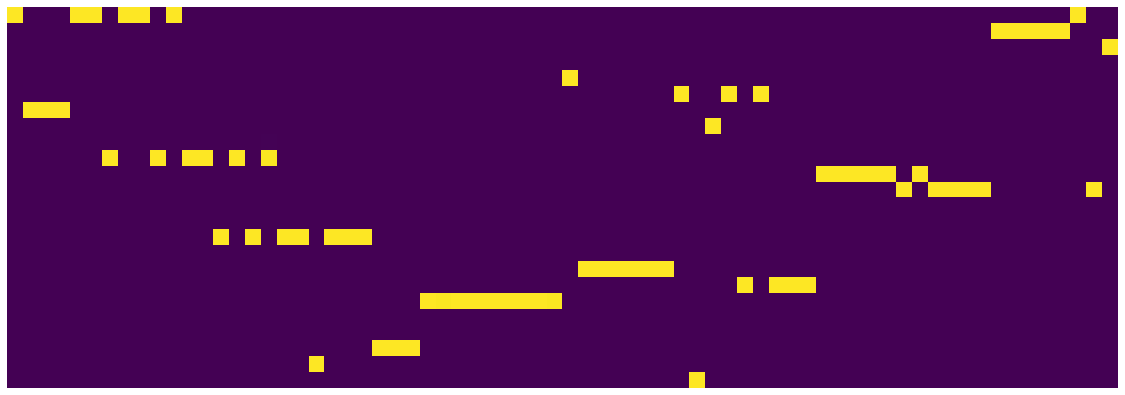

24 203 0.7959999999999998 0.4103119261562824


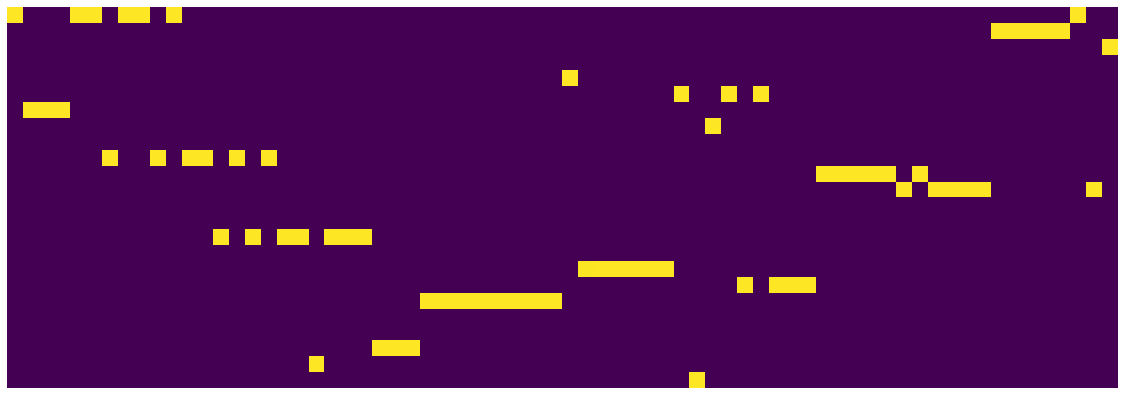

24 204 0.7949999999999998 0.4092033672146499


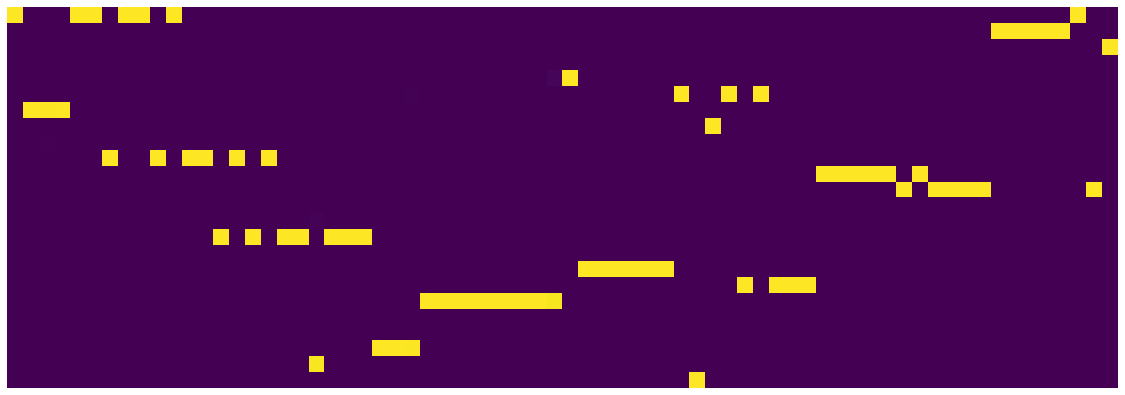

24 205 0.7939999999999998 0.4096882830373943


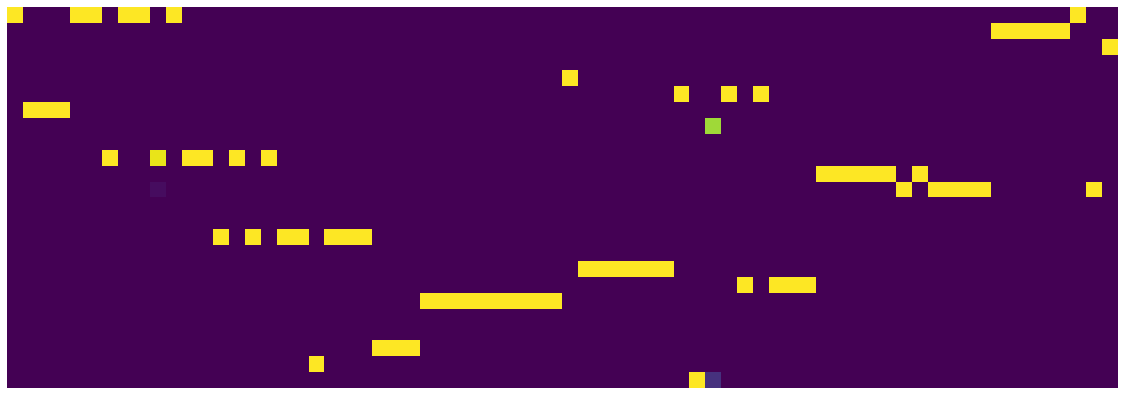

24 206 0.7929999999999998 0.4201801768504083


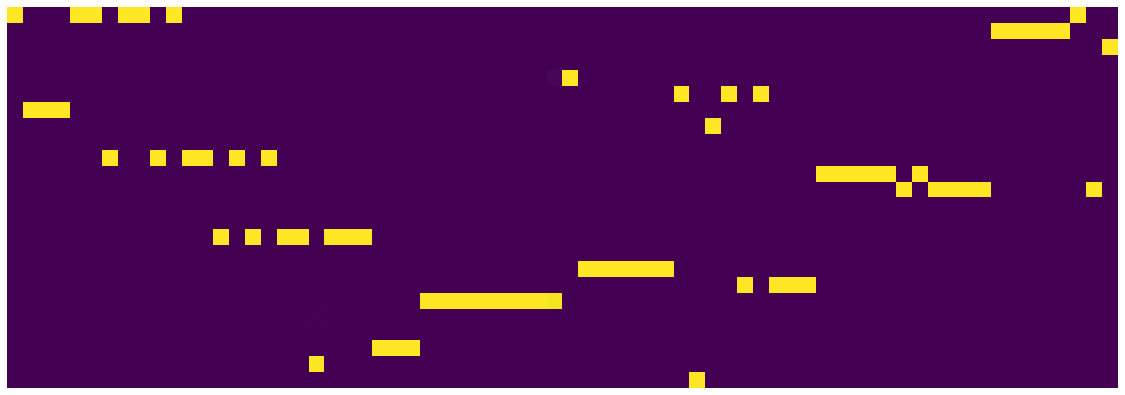

24 207 0.7919999999999998 0.4129427855834365


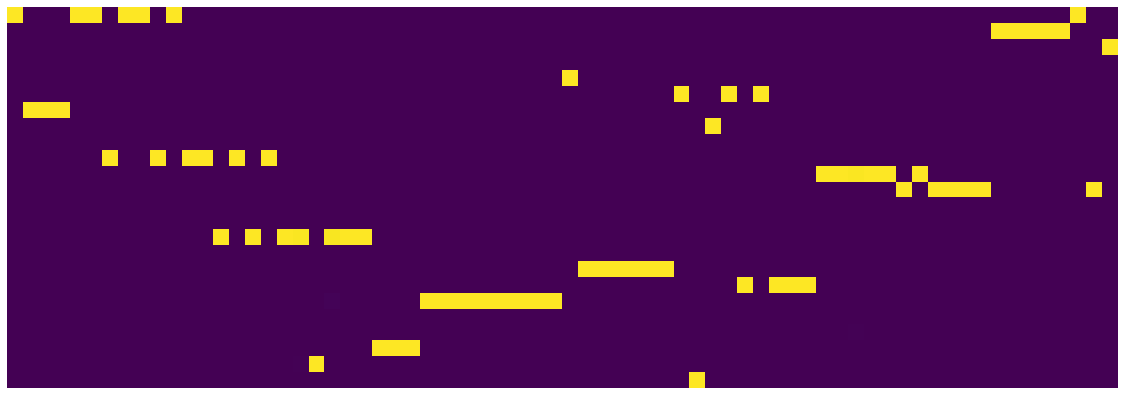

24 208 0.7909999999999998 0.41084397872909906


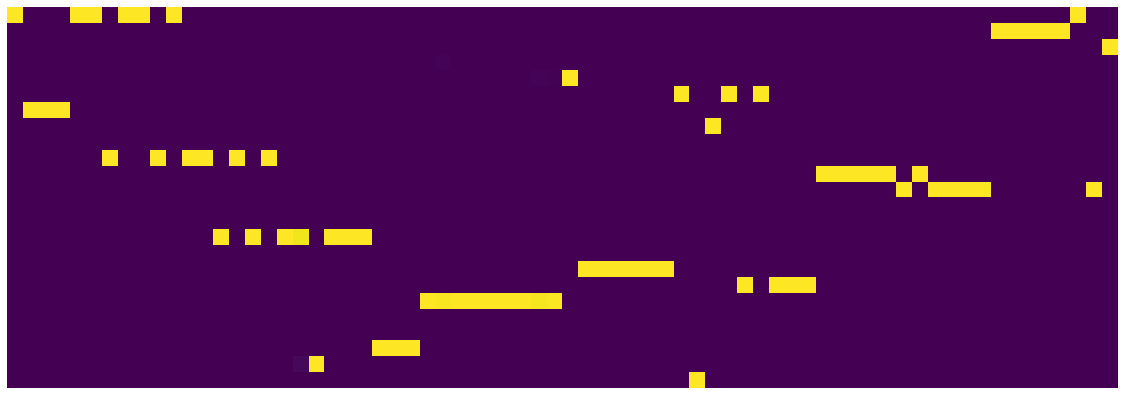

24 209 0.7899999999999998 0.4310971892438829


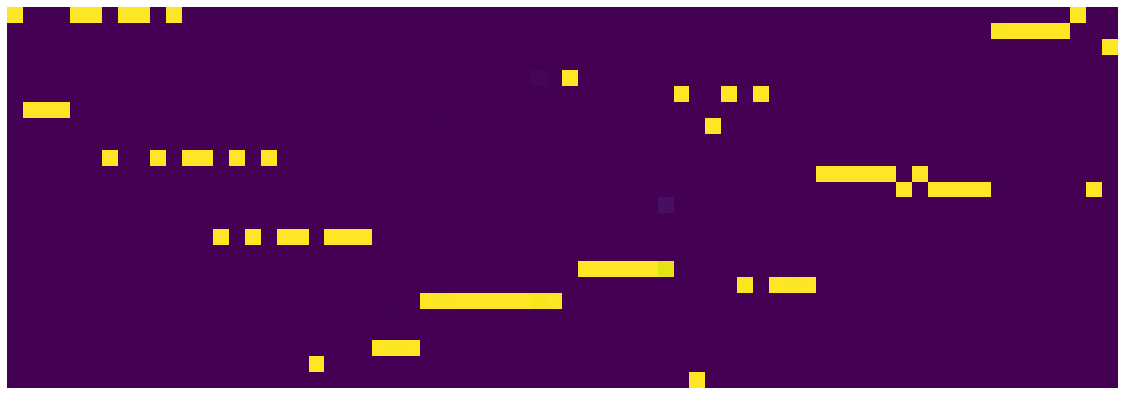

24 210 0.7889999999999998 0.4109171857126057


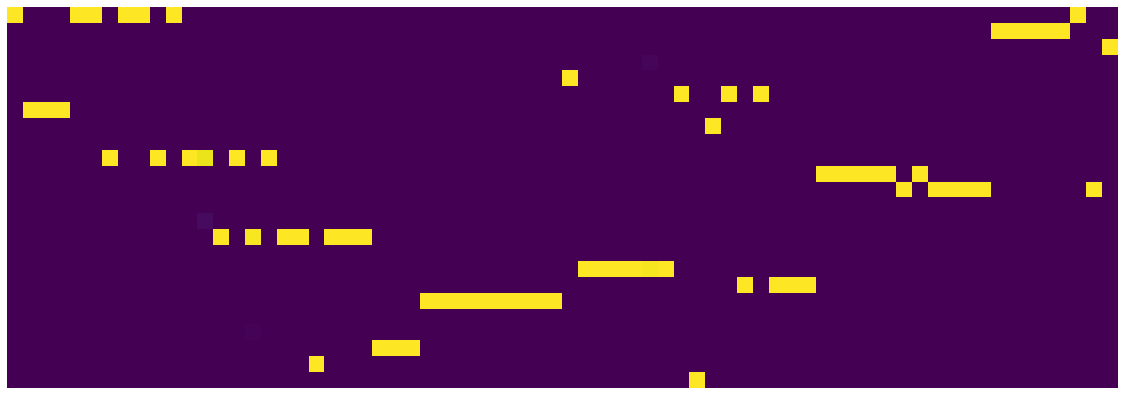

24 211 0.7879999999999998 0.41432255795225503


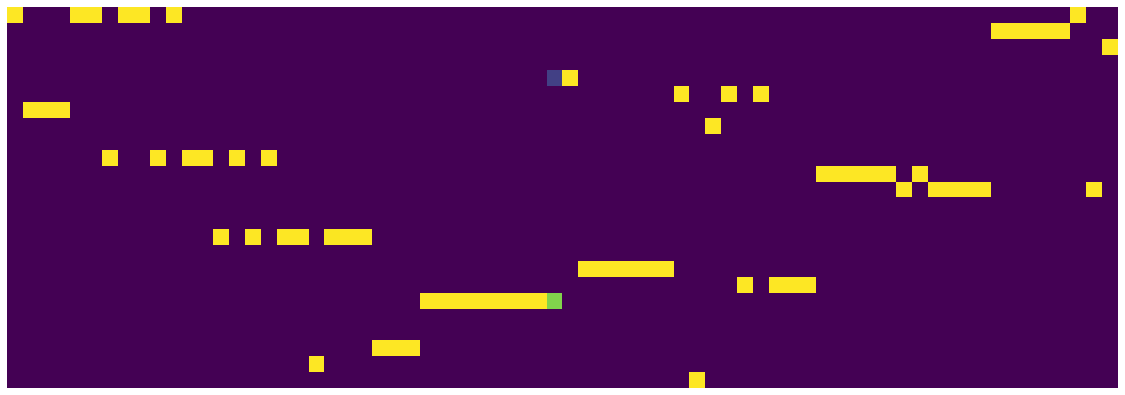

24 212 0.7869999999999998 0.4139149449765682


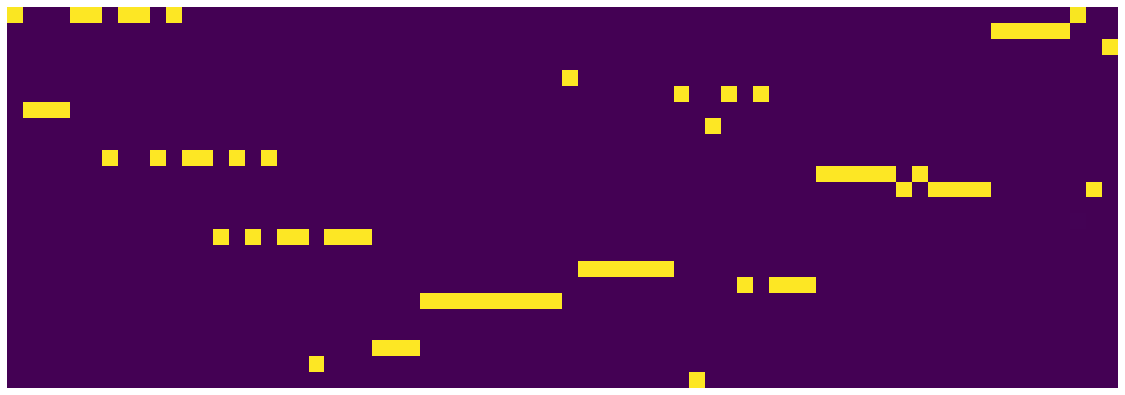

24 213 0.7859999999999998 0.40735002895817163


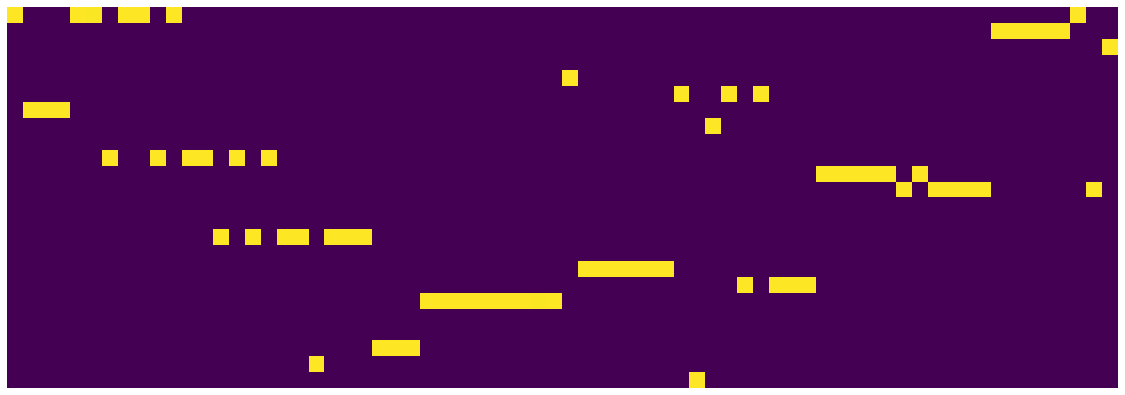

24 214 0.7849999999999998 0.40730908028781415


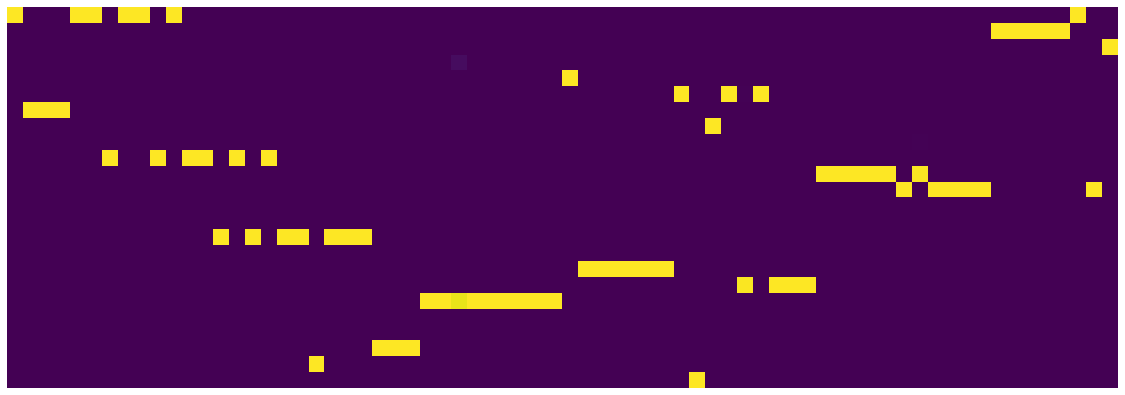

24 215 0.7839999999999998 0.42344039818271995


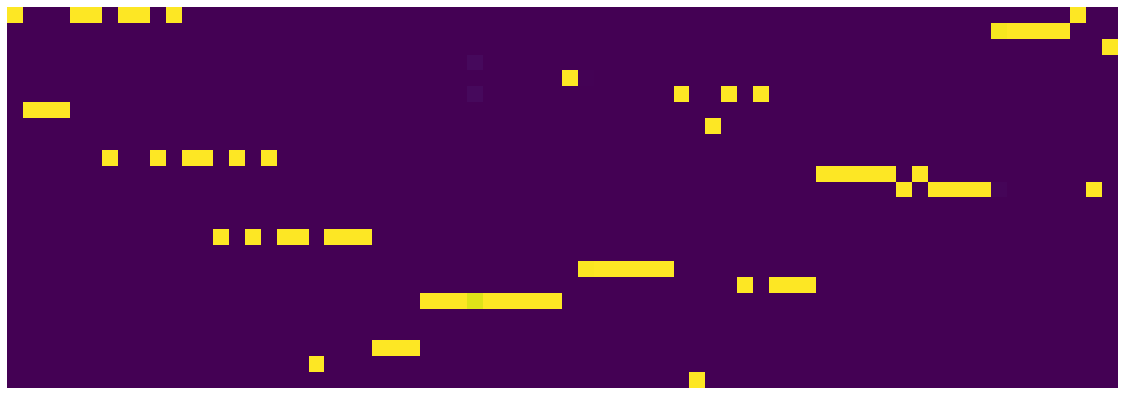

24 216 0.7829999999999998 0.4189223161898553


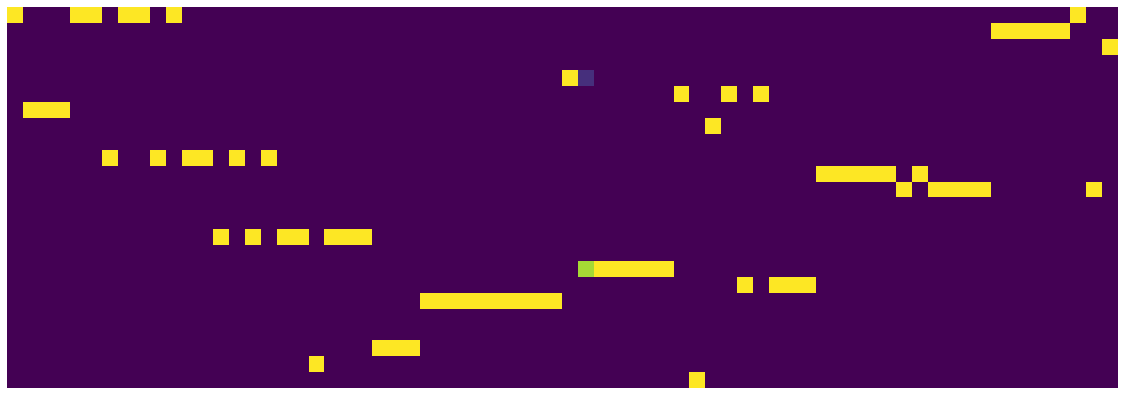

24 217 0.7819999999999998 0.4033704434521496


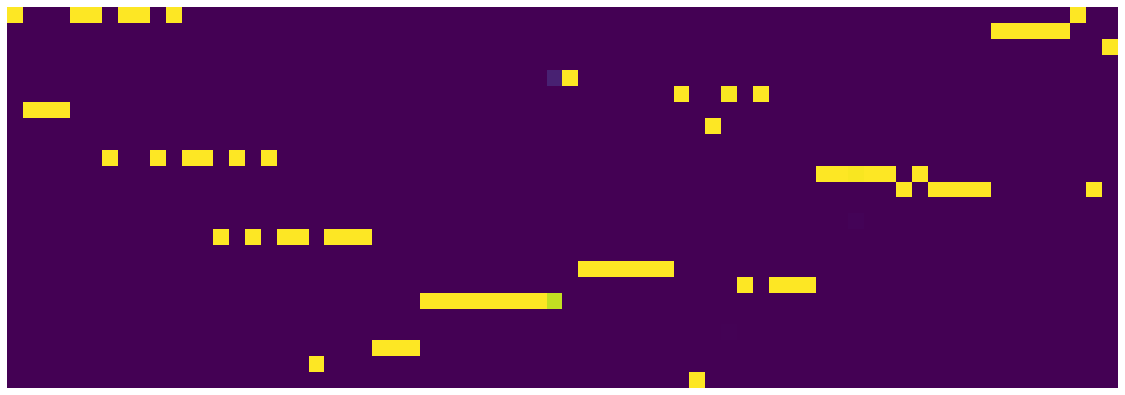

24 218 0.7809999999999998 0.41855077175423505


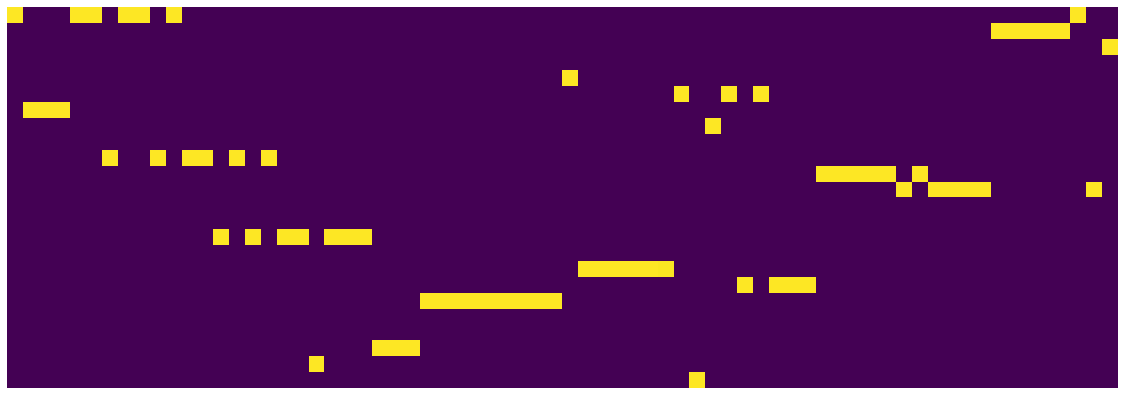

24 219 0.7799999999999998 0.4329866008833051


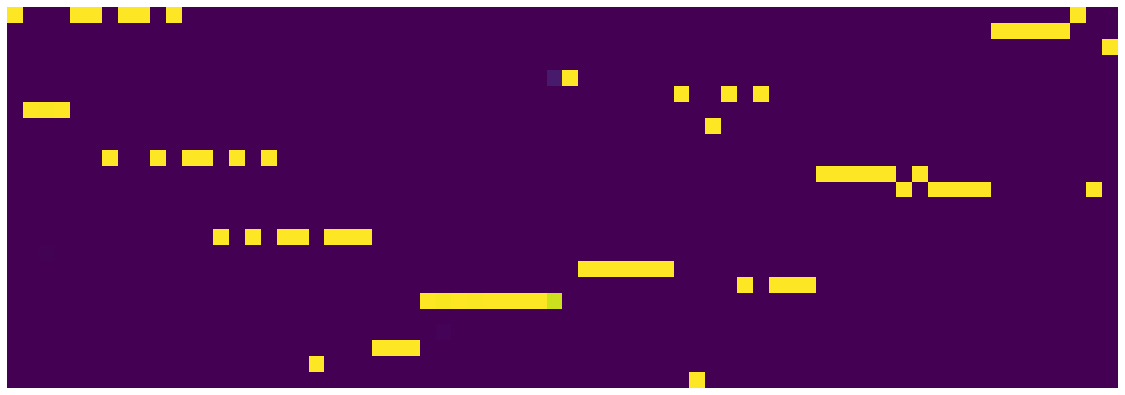

24 220 0.7789999999999998 0.4083124712109566


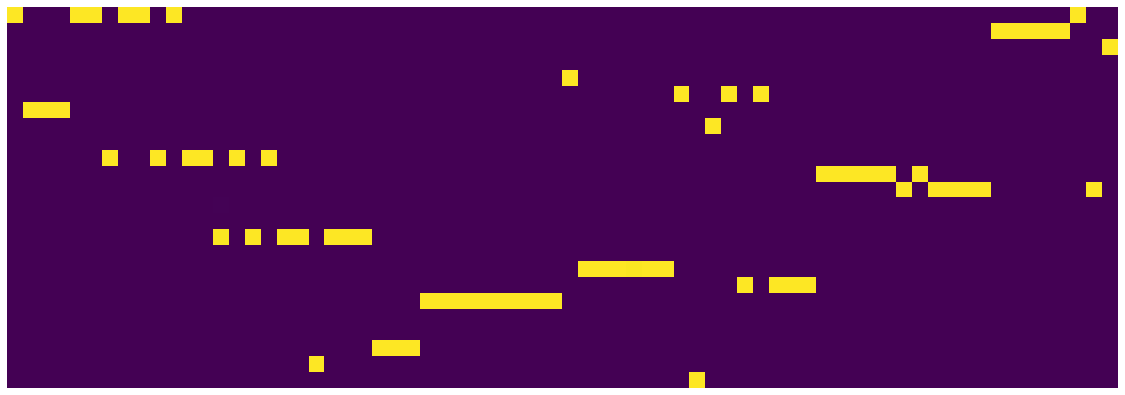

24 221 0.7779999999999998 0.4306765554472804


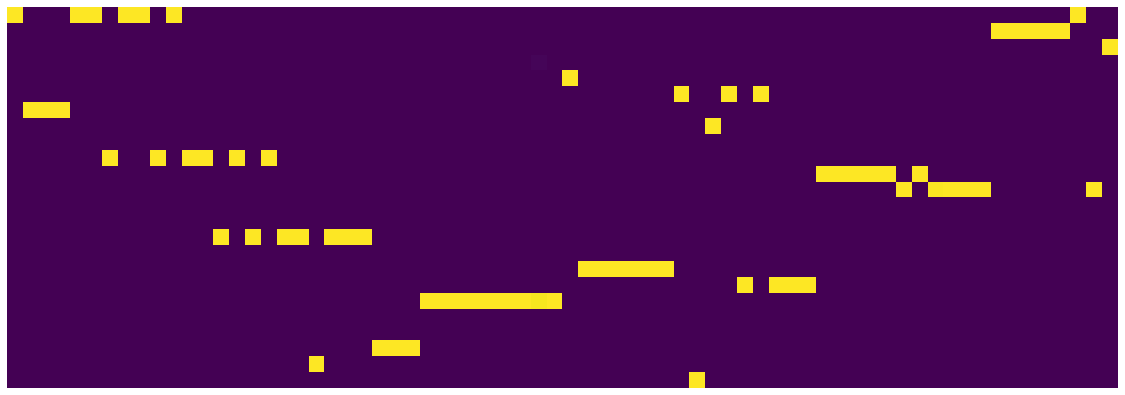

24 222 0.7769999999999998 0.414038123935461


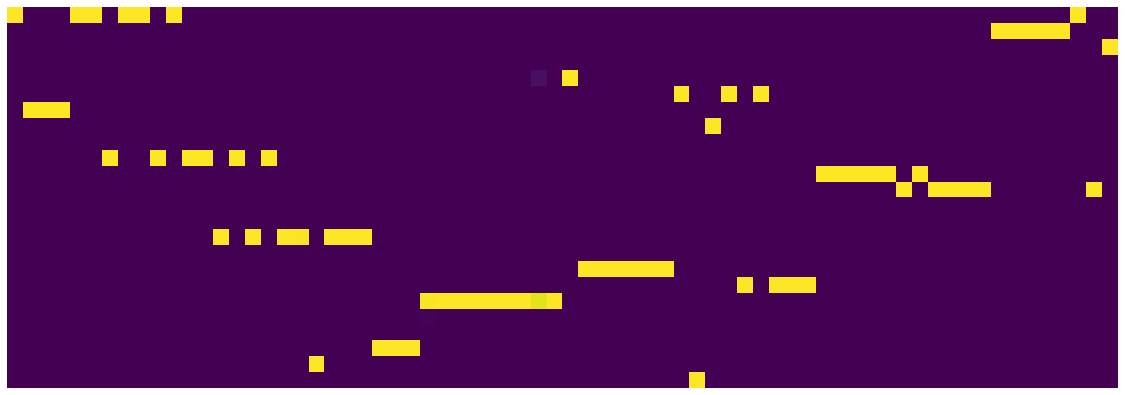

24 223 0.7759999999999998 0.4066758630797267


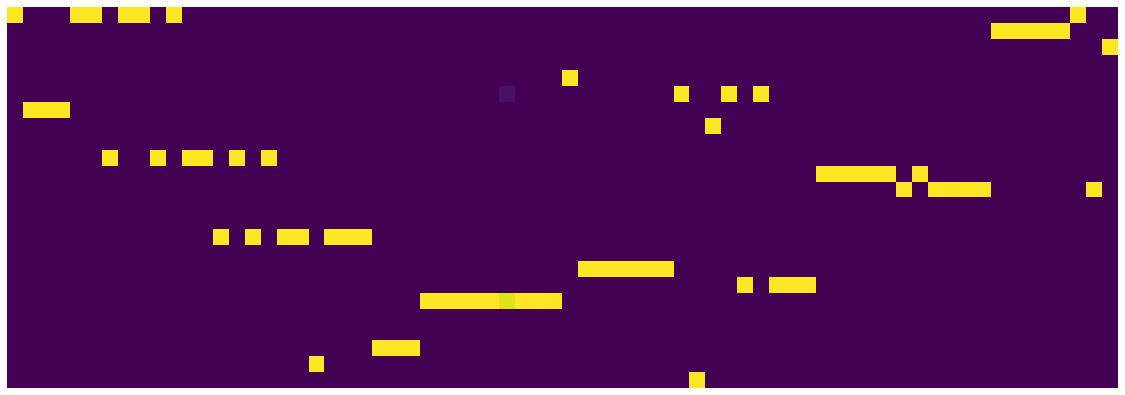

24 224 0.7749999999999998 0.4190427901223302


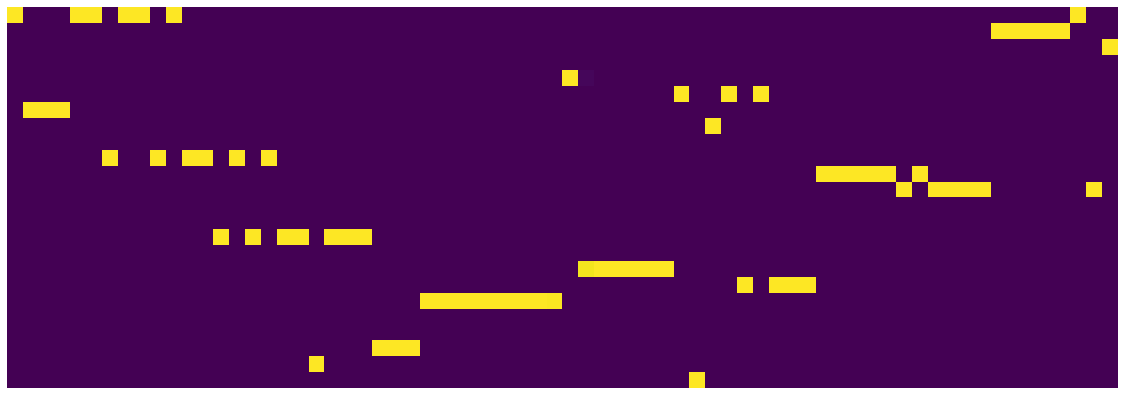

24 225 0.7739999999999998 0.41592063680291175


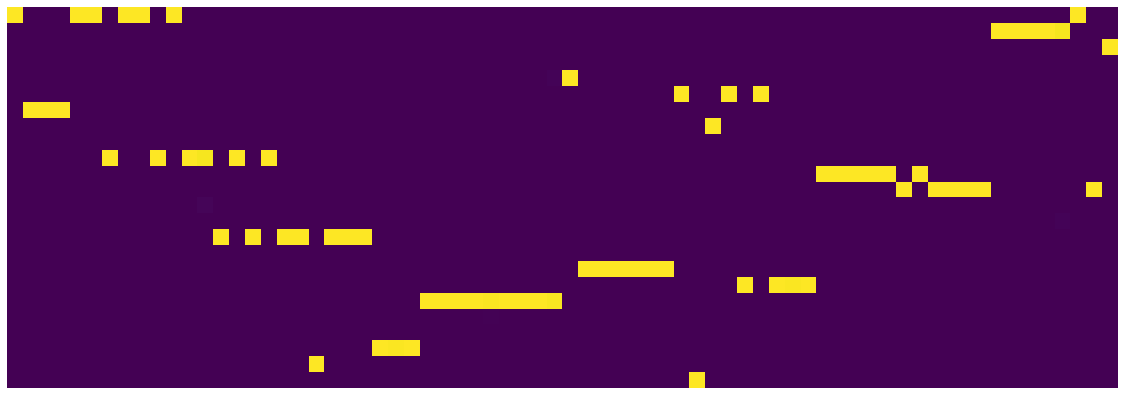

24 226 0.7729999999999998 0.4130896839313209


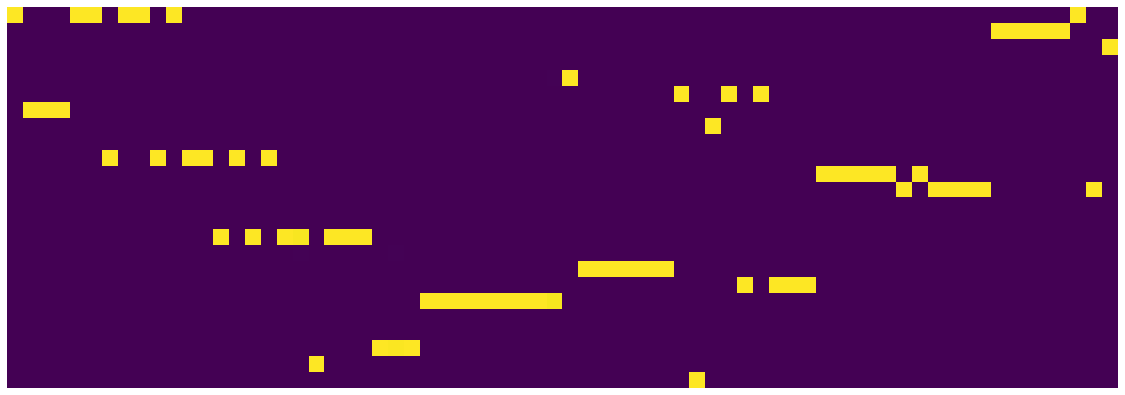

24 227 0.7719999999999998 0.41328709265217184


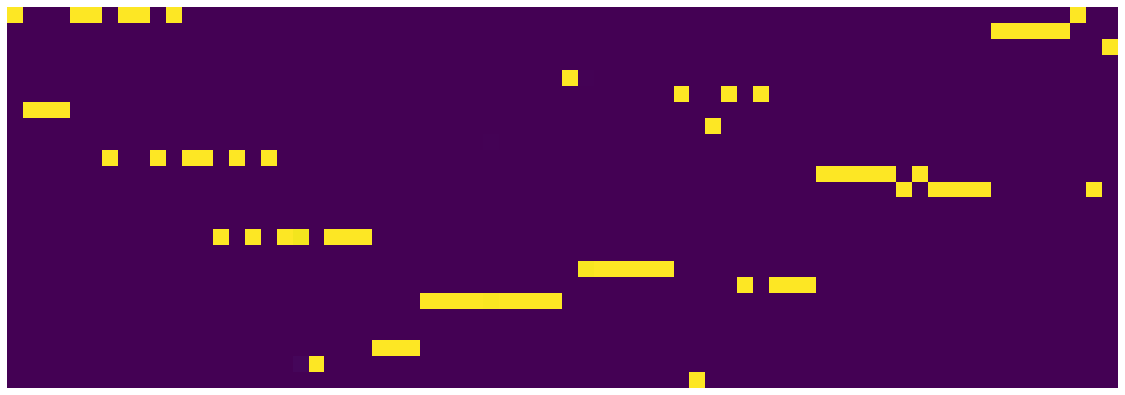

24 228 0.7709999999999998 0.43842735830694435


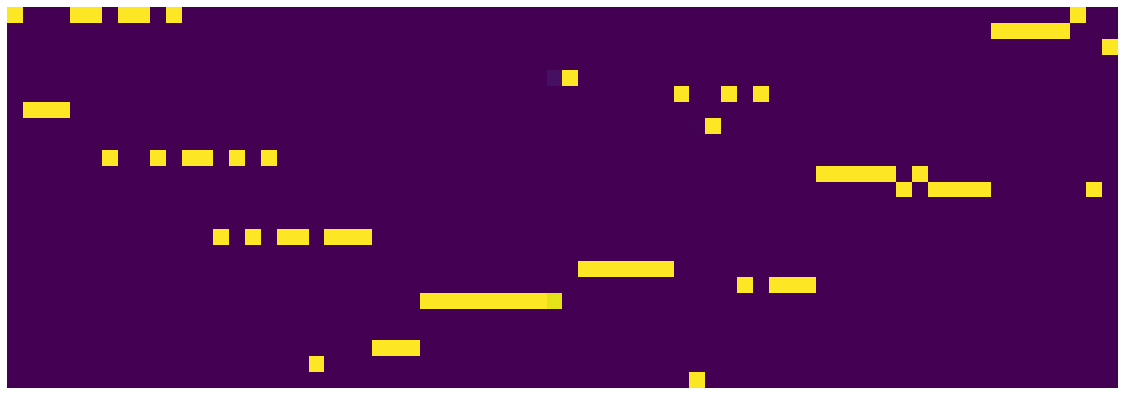

24 229 0.7699999999999998 0.4044088216498494


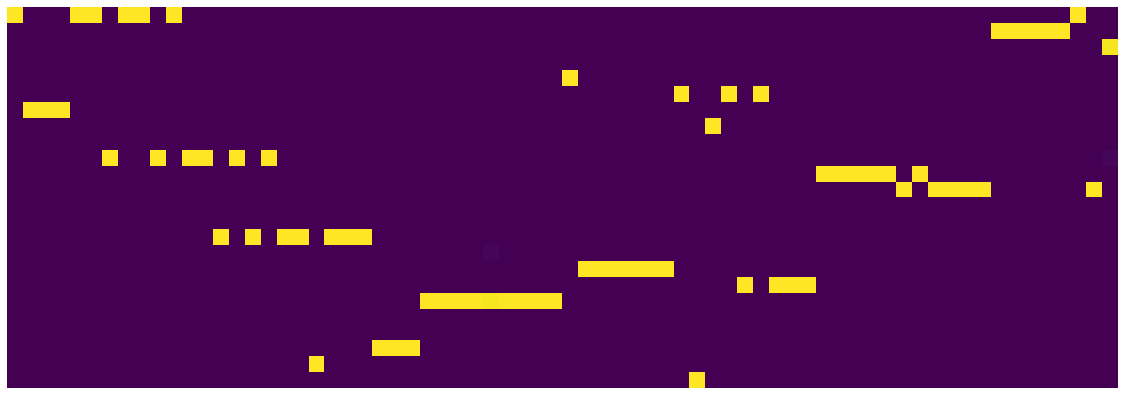

24 230 0.7689999999999998 0.44216545578092337


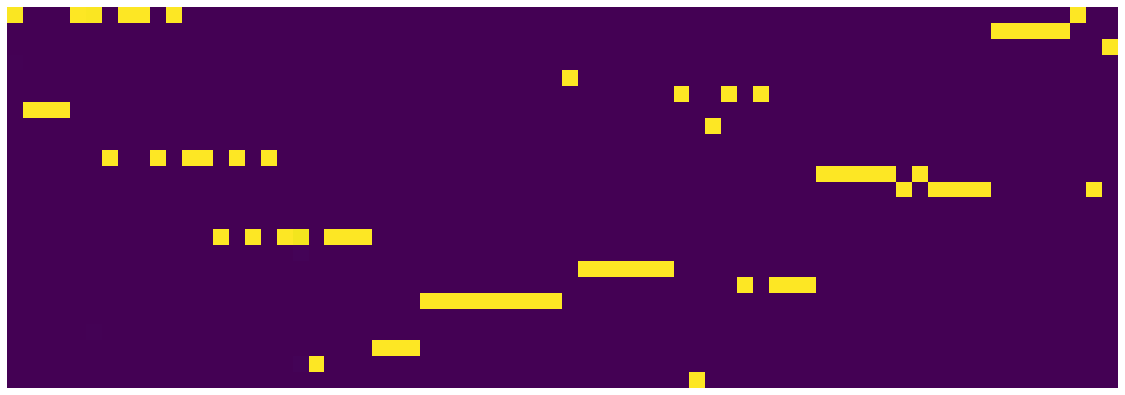

24 231 0.7679999999999998 0.4341817364096642


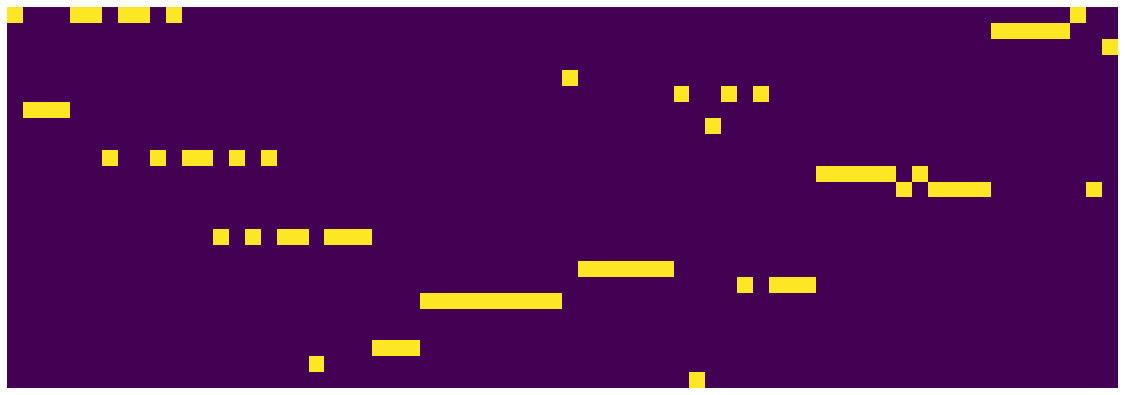

24 232 0.7669999999999998 0.4064841944724321


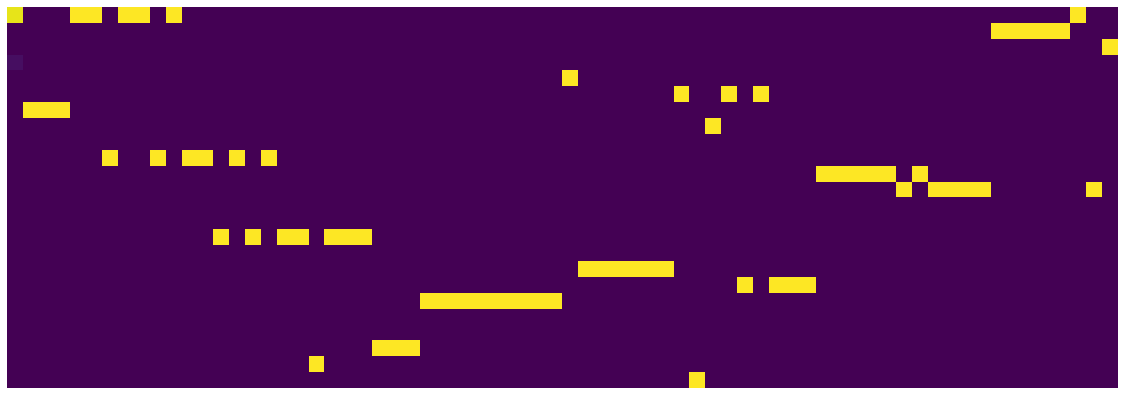

24 233 0.7659999999999998 0.41291362717747687


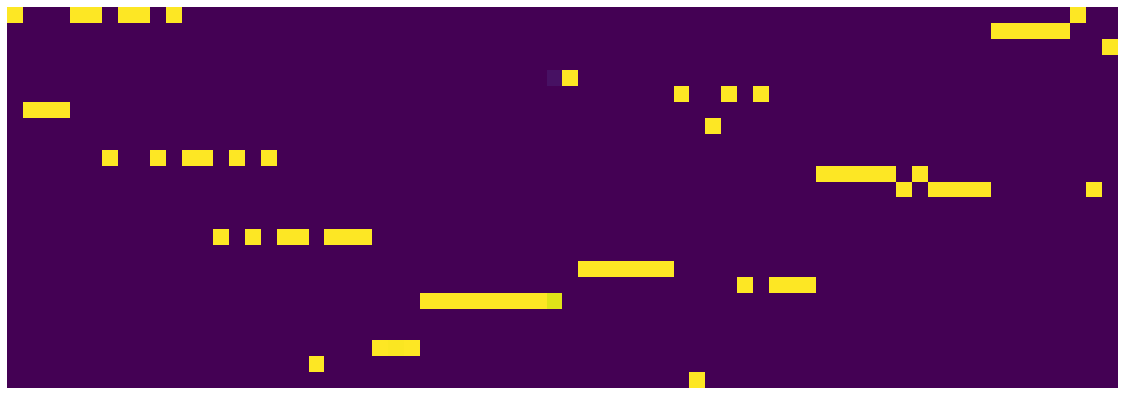

24 234 0.7649999999999998 0.4005223809741437


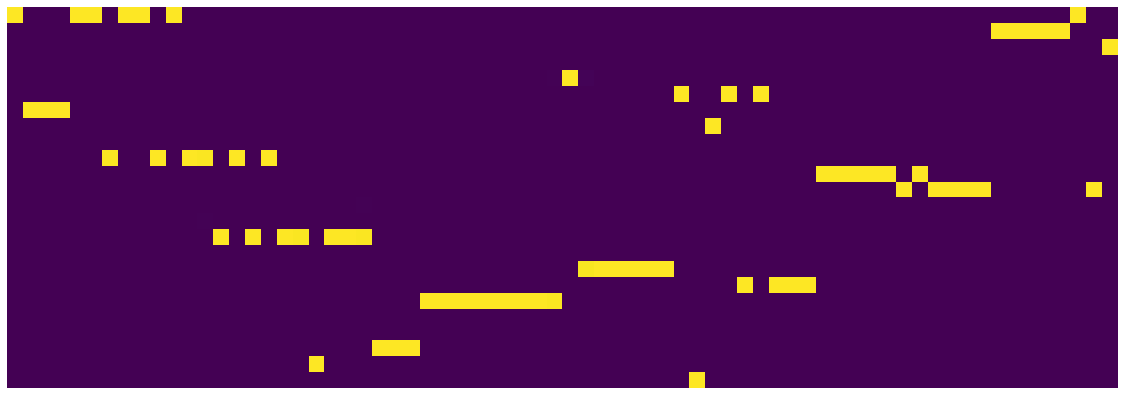

24 235 0.7639999999999998 0.40392505563795567


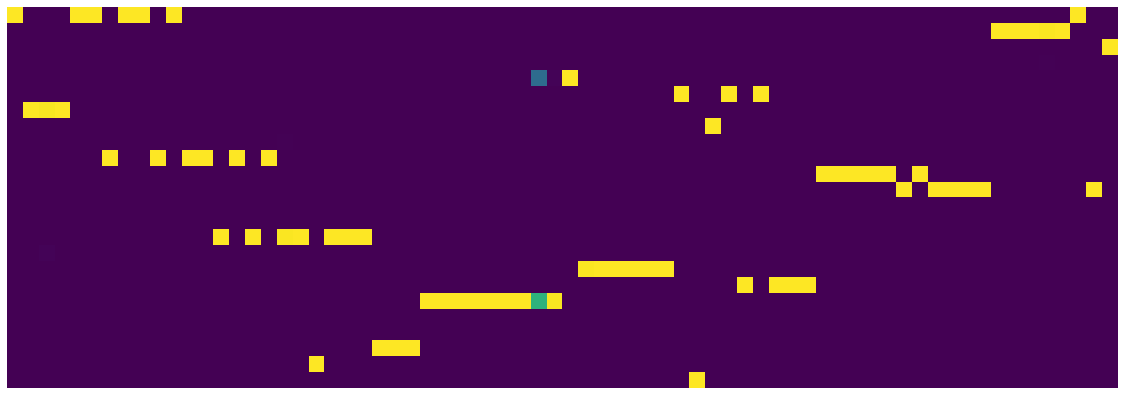

24 236 0.7629999999999998 0.4138159019872546


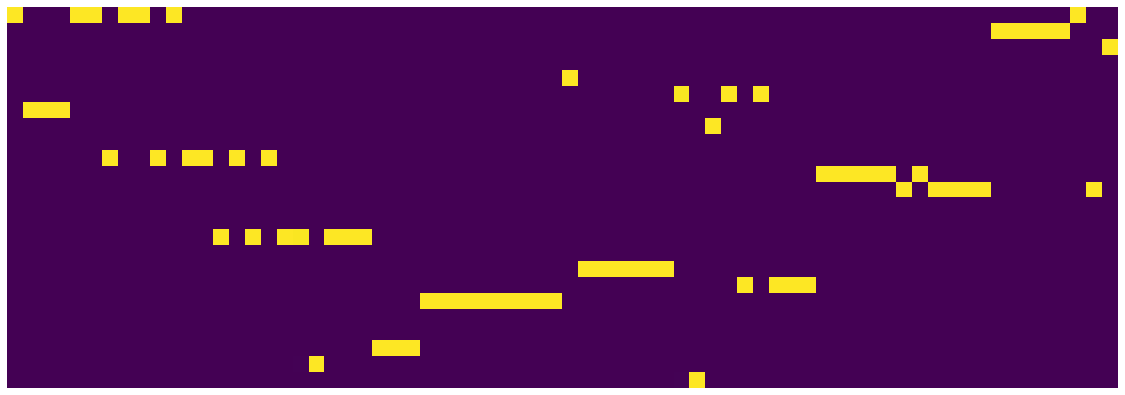

24 237 0.7619999999999998 0.4193109065294266


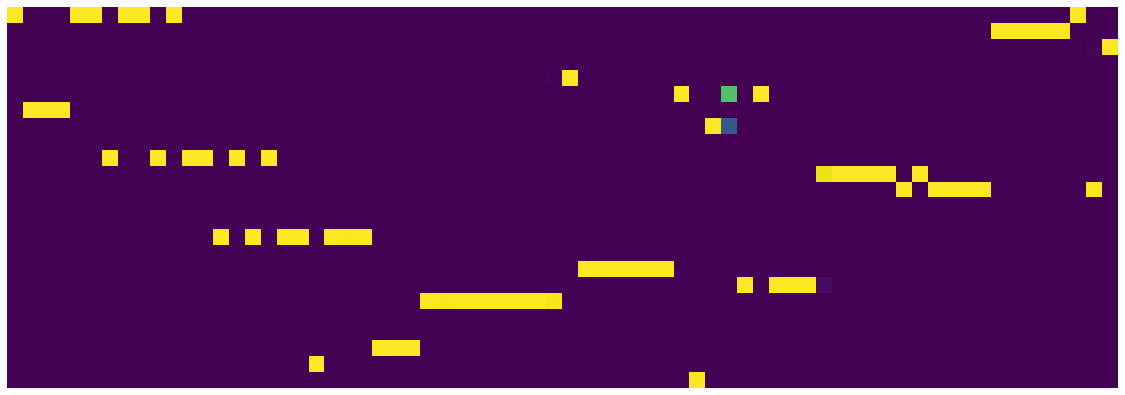

24 238 0.7609999999999998 0.41330818384885787


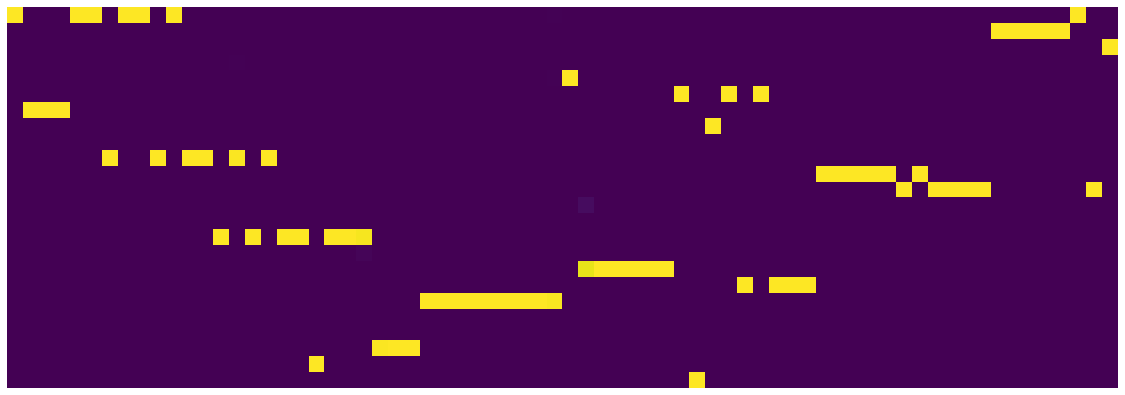

24 239 0.7599999999999998 0.41421970576047895


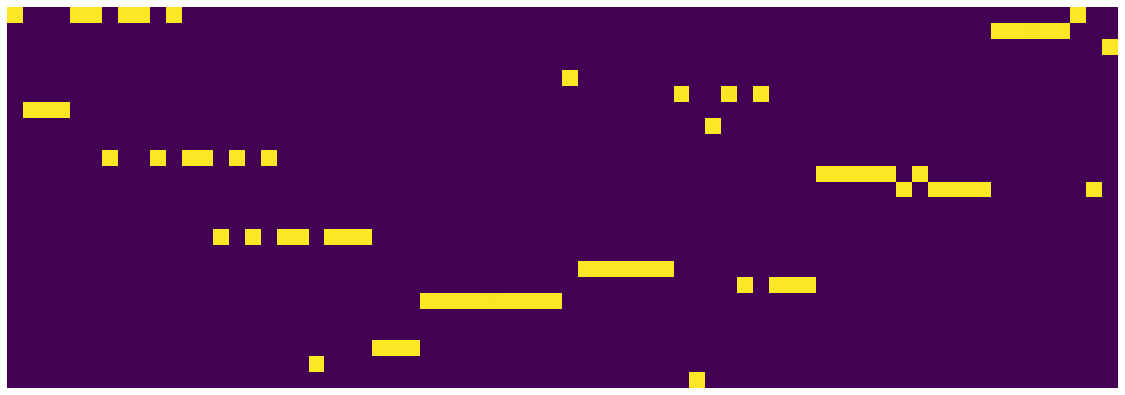

24 240 0.7589999999999998 0.4054243451915681


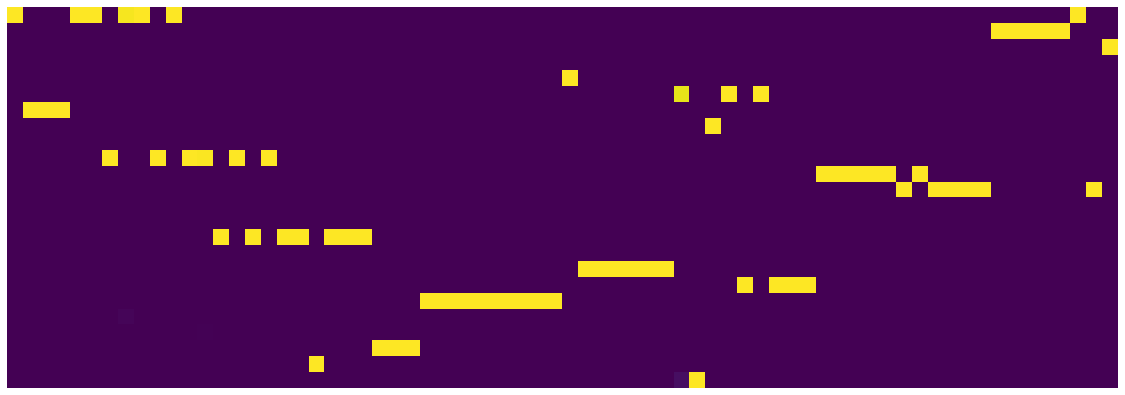

24 241 0.7579999999999998 0.42231227857992054


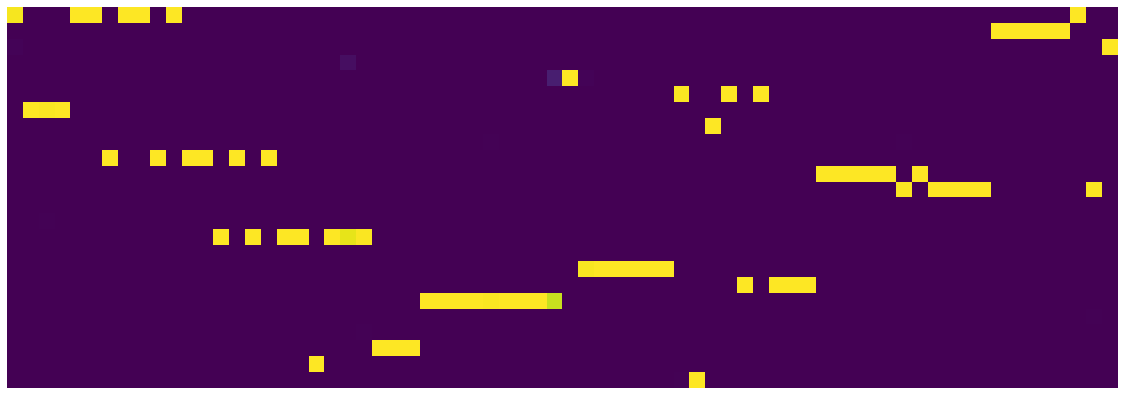

24 242 0.7569999999999998 0.4142660189419985


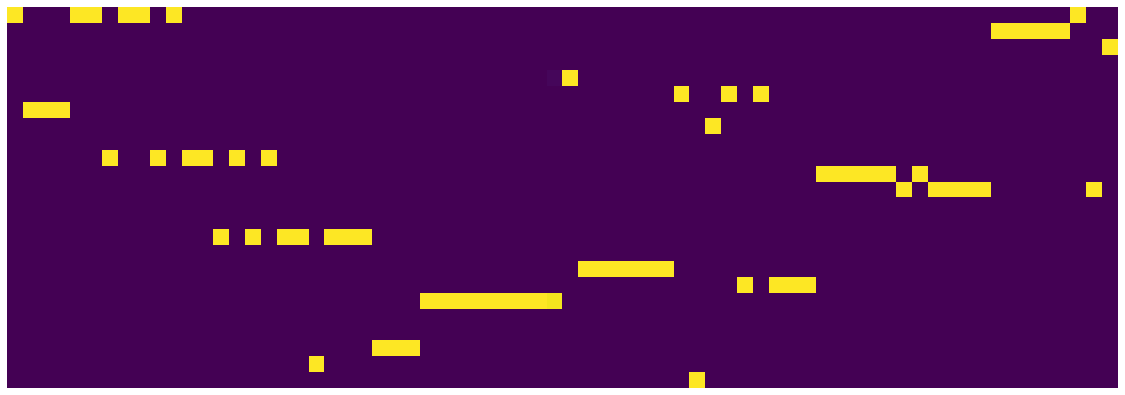

24 243 0.7559999999999998 0.4071128862909973


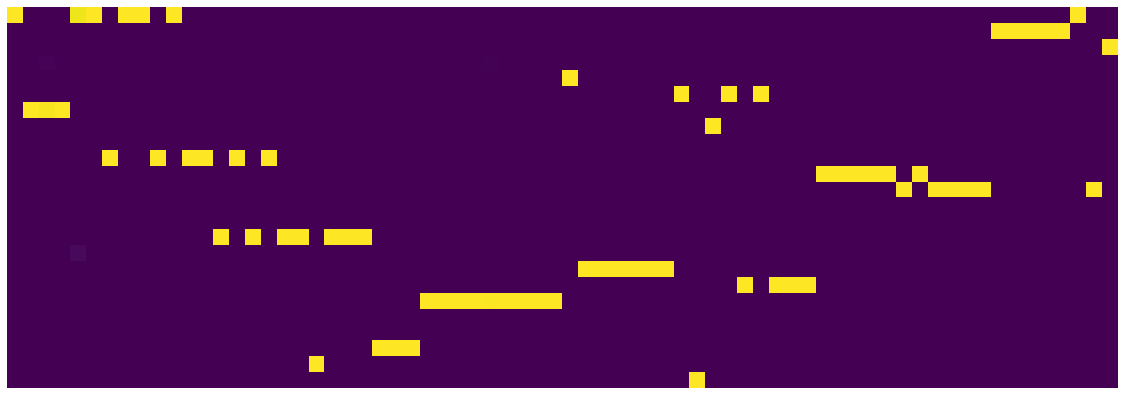

24 244 0.7549999999999998 0.4170998246408999


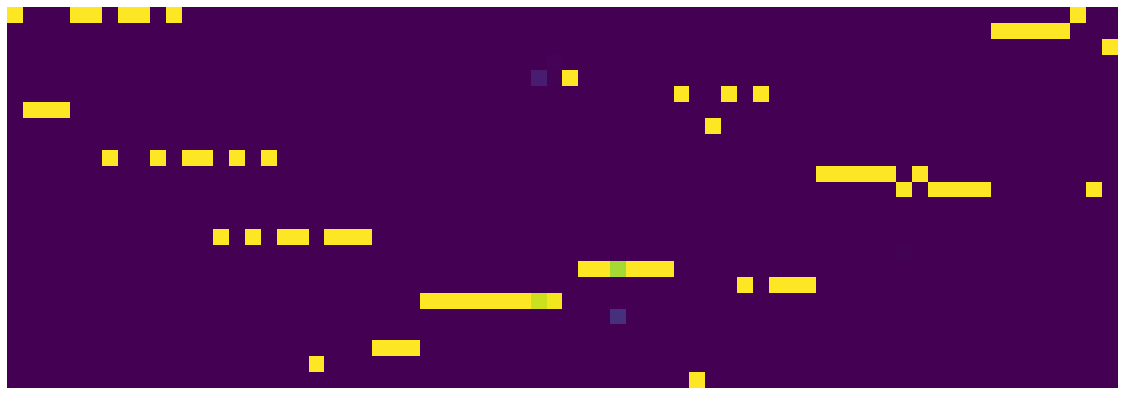

24 245 0.7539999999999998 0.418271204456687


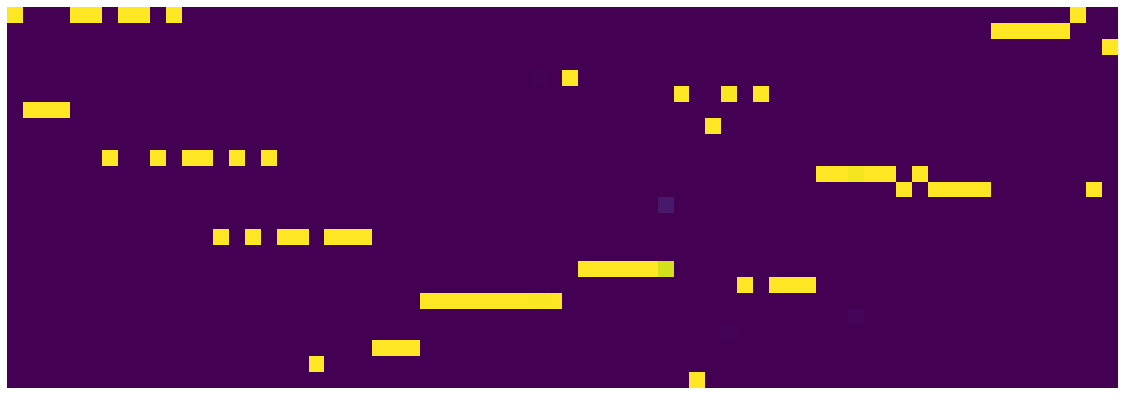

24 246 0.7529999999999998 0.40750072691589595


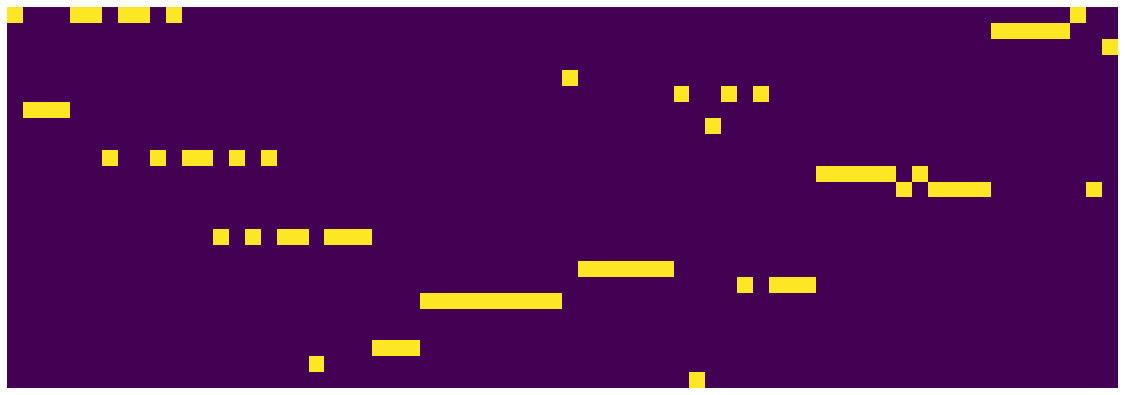

24 247 0.7519999999999998 0.4105916656553745


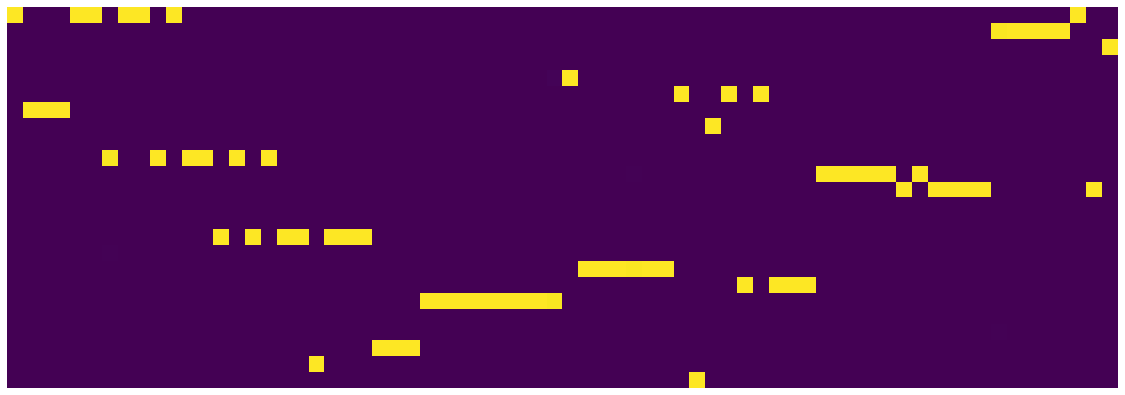

24 248 0.7509999999999998 0.42264532288536427


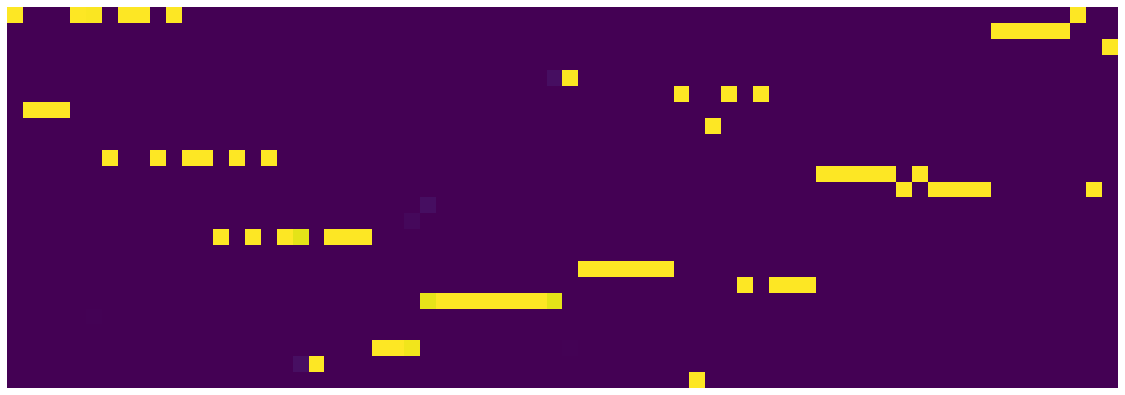

24 249 0.7499999999999998 0.41707084998488425


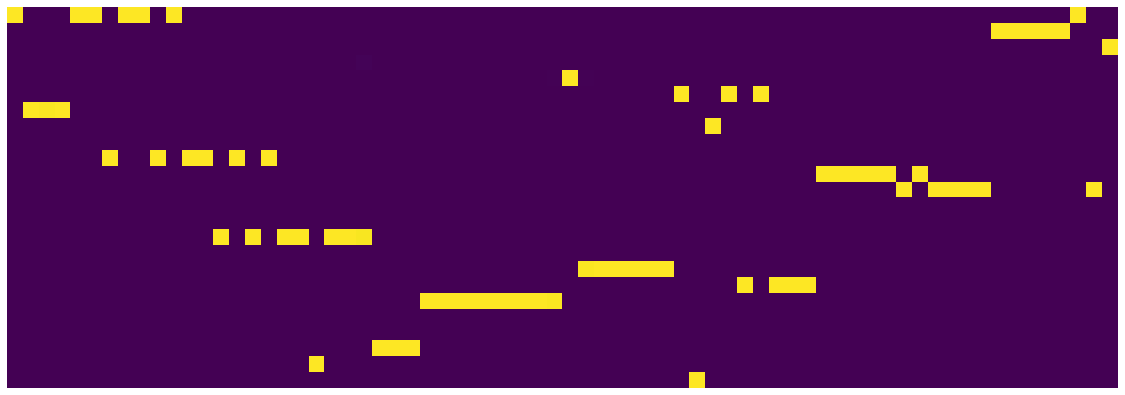

24 250 0.7489999999999998 0.4072000999003649


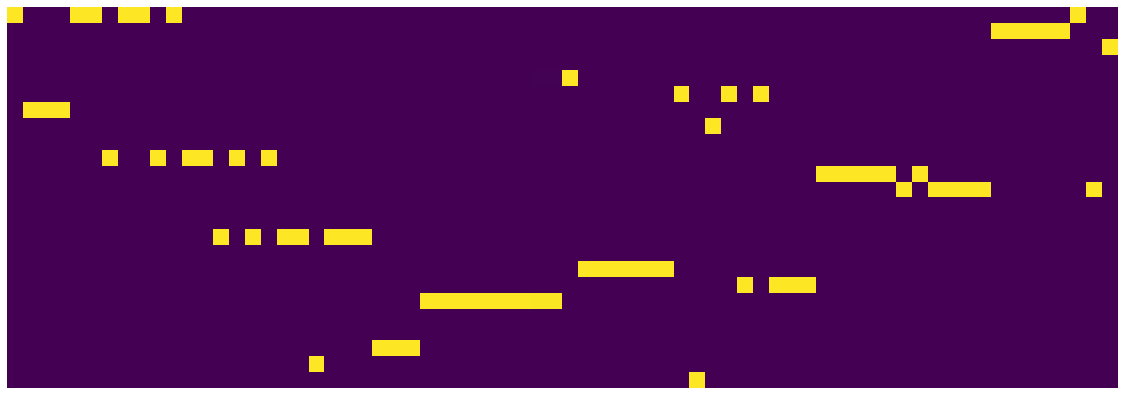

24 251 0.7479999999999998 0.4379484485834837


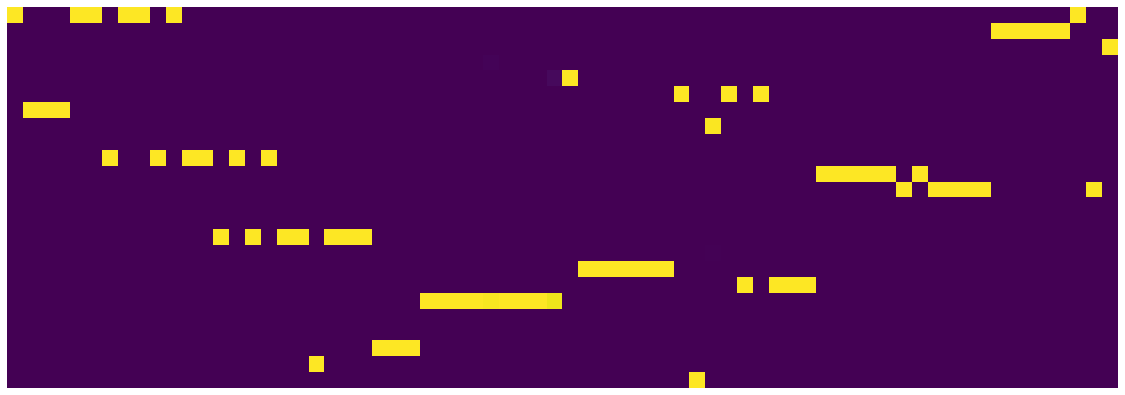

24 252 0.7469999999999998 0.409389972127974


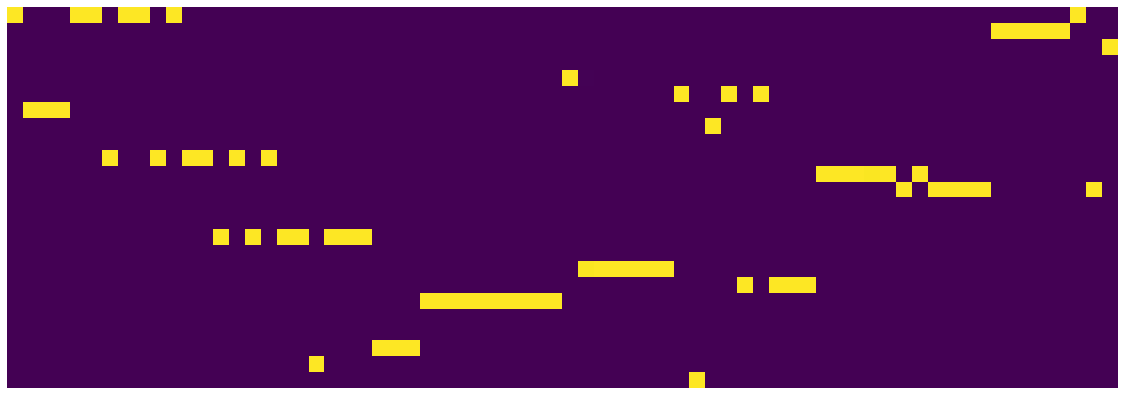

24 253 0.7459999999999998 0.40393204828724266


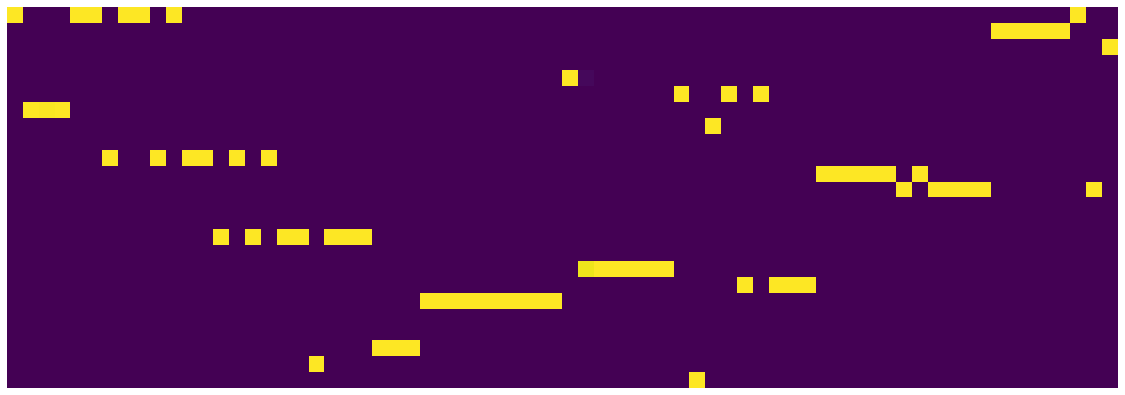

24 254 0.7449999999999998 0.41554522002115846


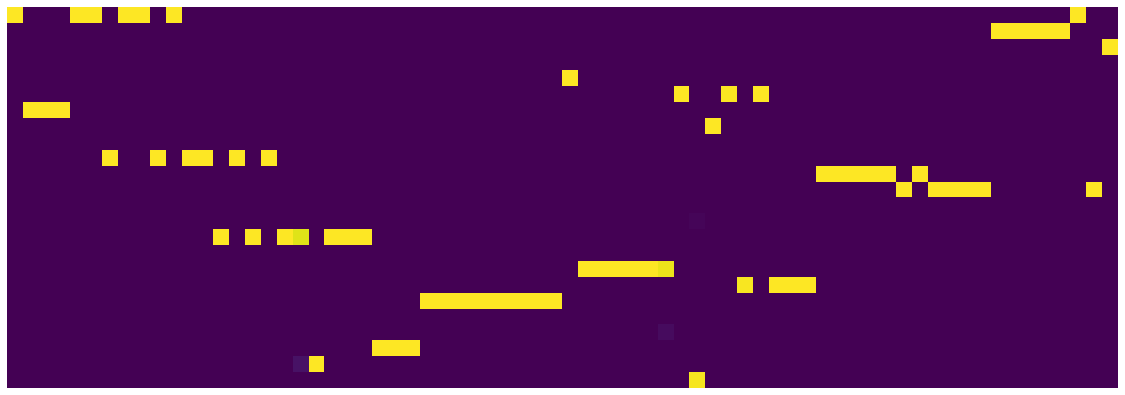

24 255 0.7439999999999998 0.4191308721899986


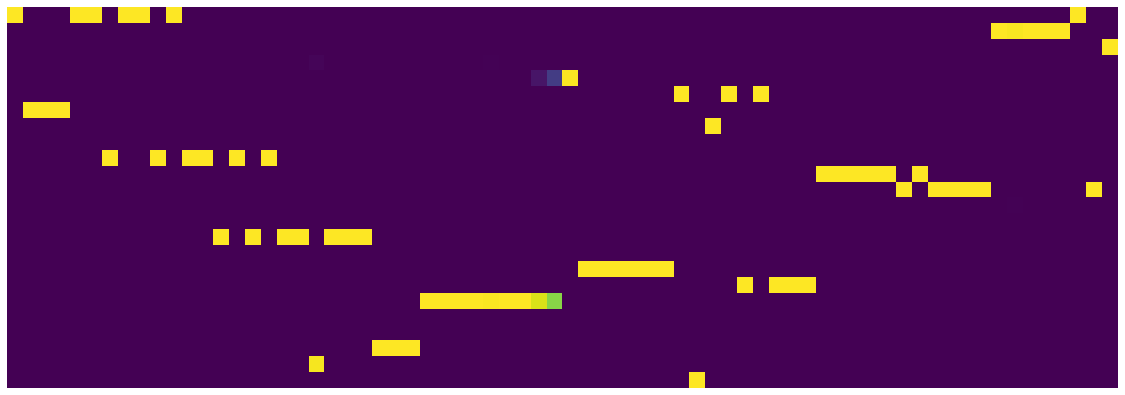

24 256 0.7429999999999998 0.4089383170939982


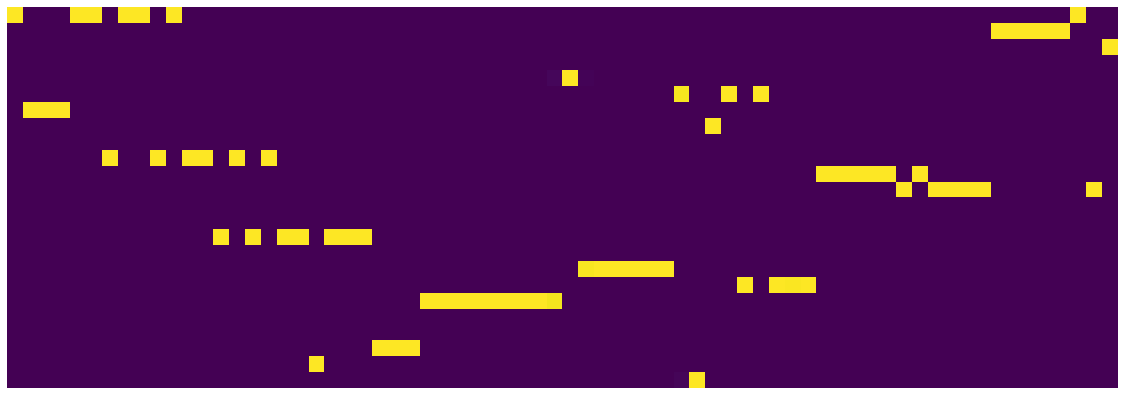

24 257 0.7419999999999998 0.4330928354524076


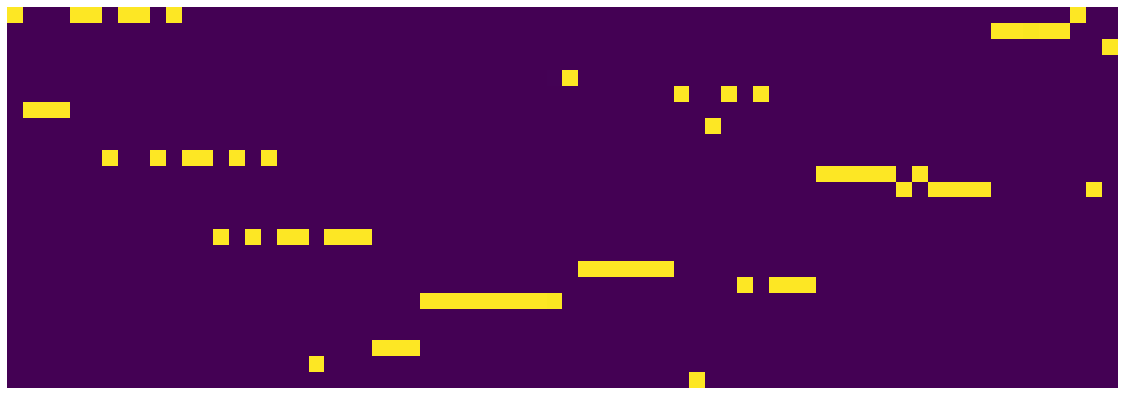

24 258 0.7409999999999998 0.43572583412751553


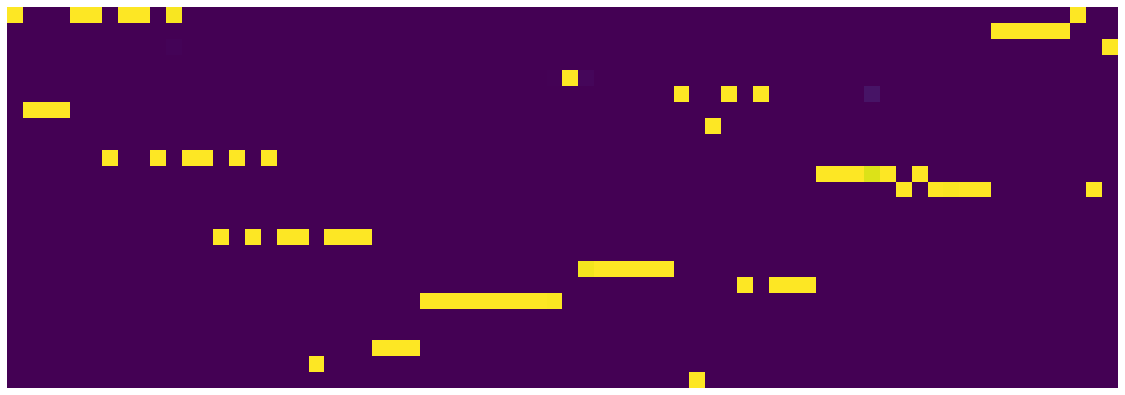

24 259 0.7399999999999998 0.4210094675421715


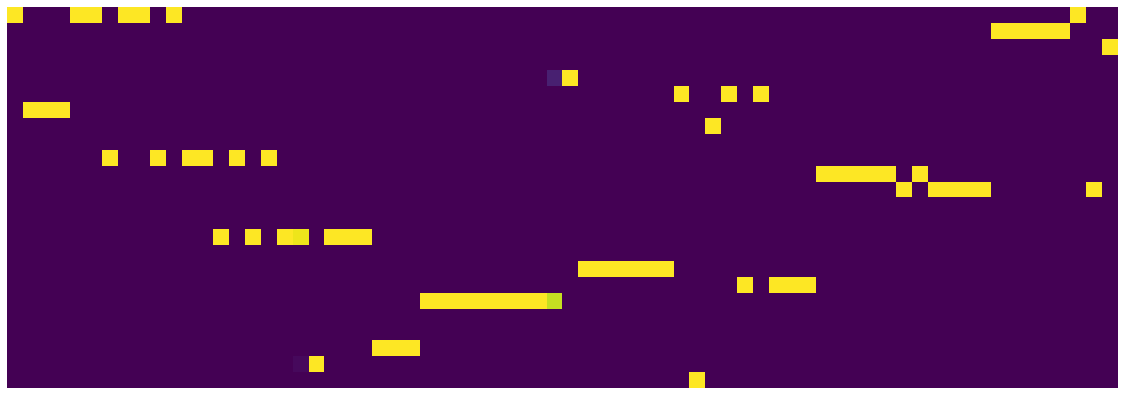

24 260 0.7389999999999998 0.40929660238325594


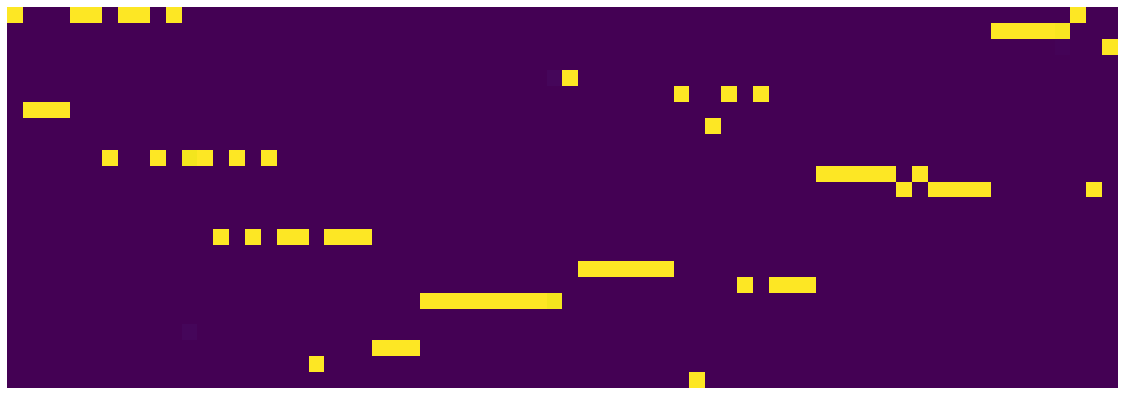

24 261 0.7379999999999998 0.4094208133406937


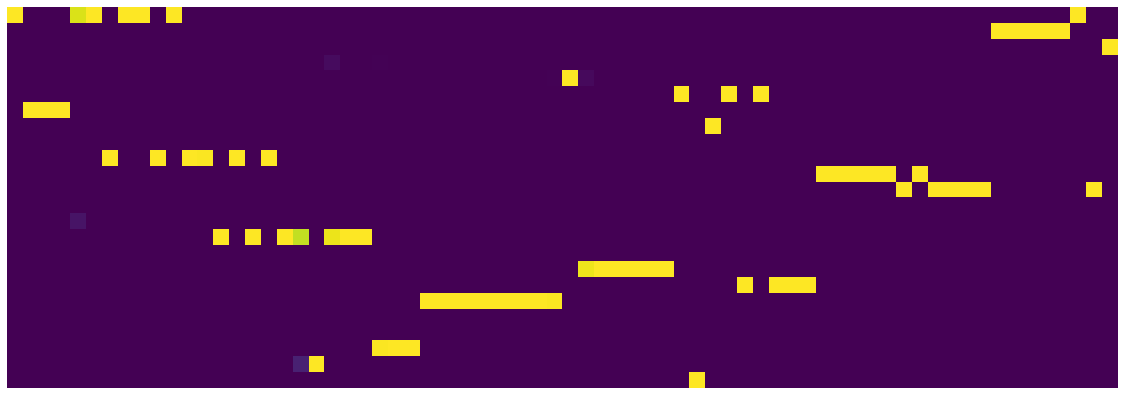

24 262 0.7369999999999998 0.4143104373477399


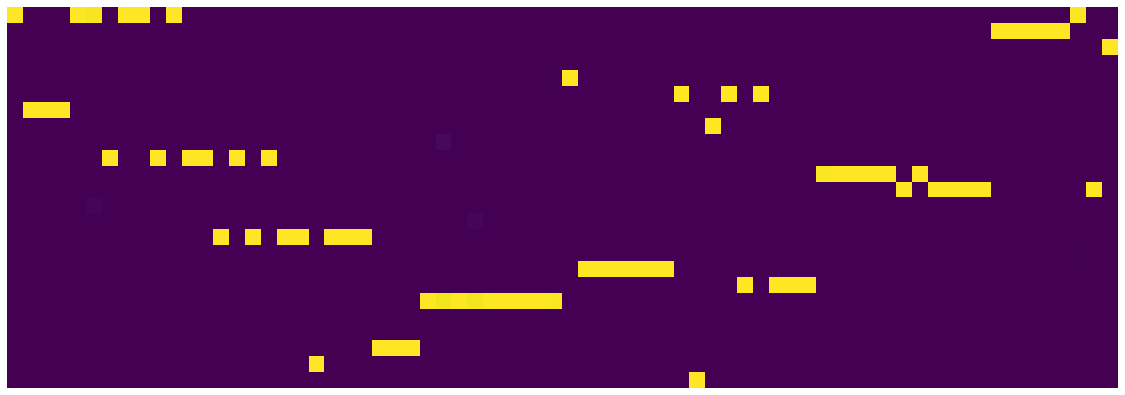

24 263 0.7359999999999998 0.42475038059055803


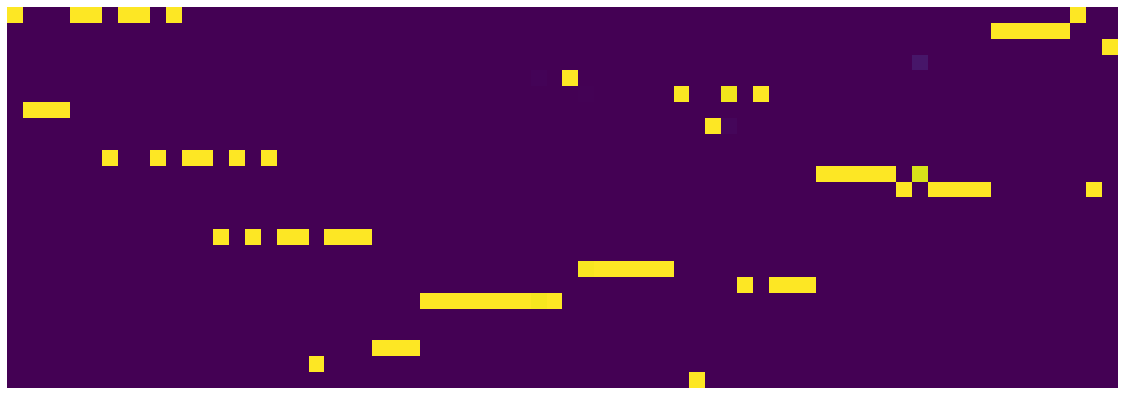

24 264 0.7349999999999998 0.41670005656778814


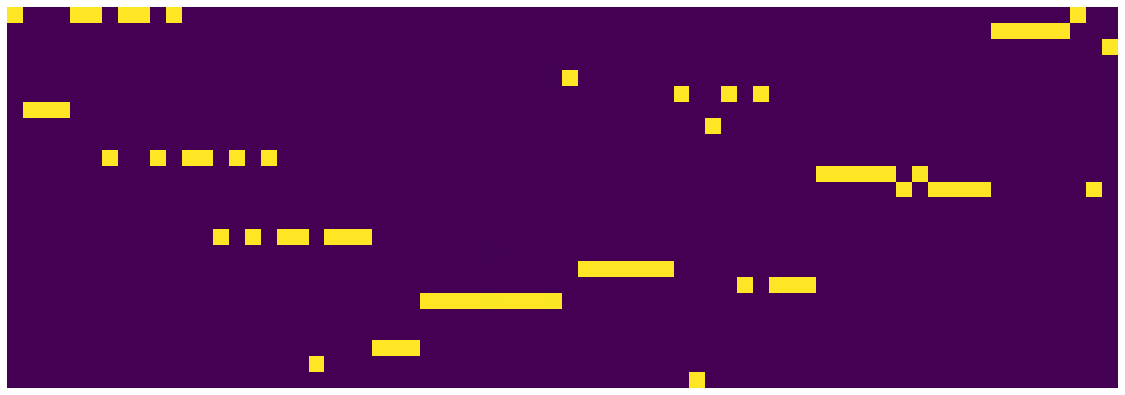

24 265 0.7339999999999998 0.41955362912267447


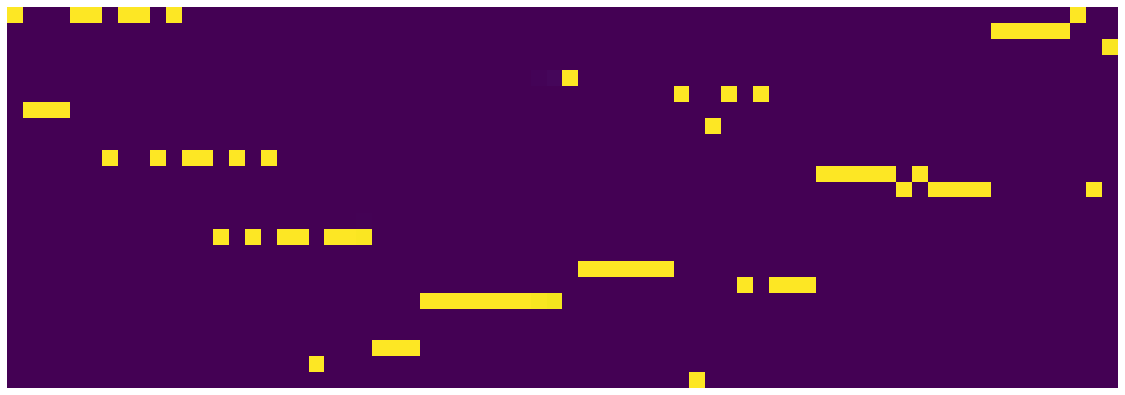

24 266 0.7329999999999998 0.41097978632897136


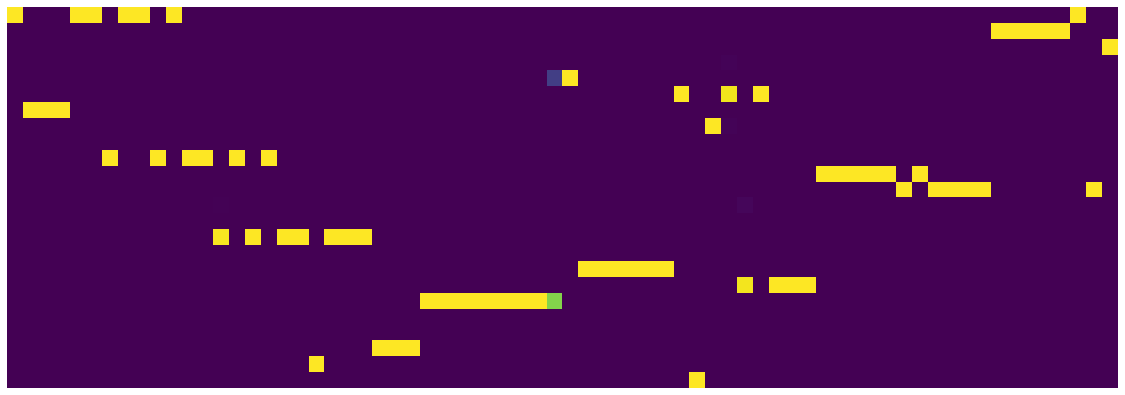

24 267 0.7319999999999998 0.4052470252849162


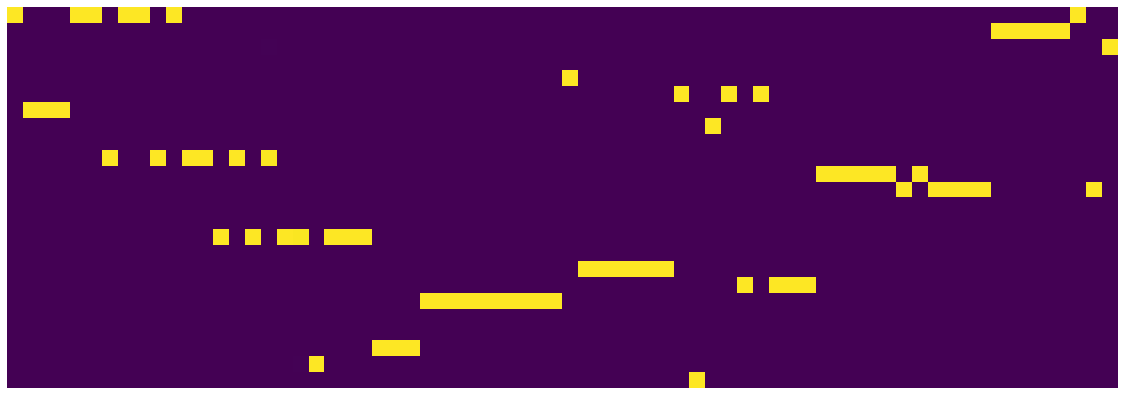

24 268 0.7309999999999998 0.4120800657197833


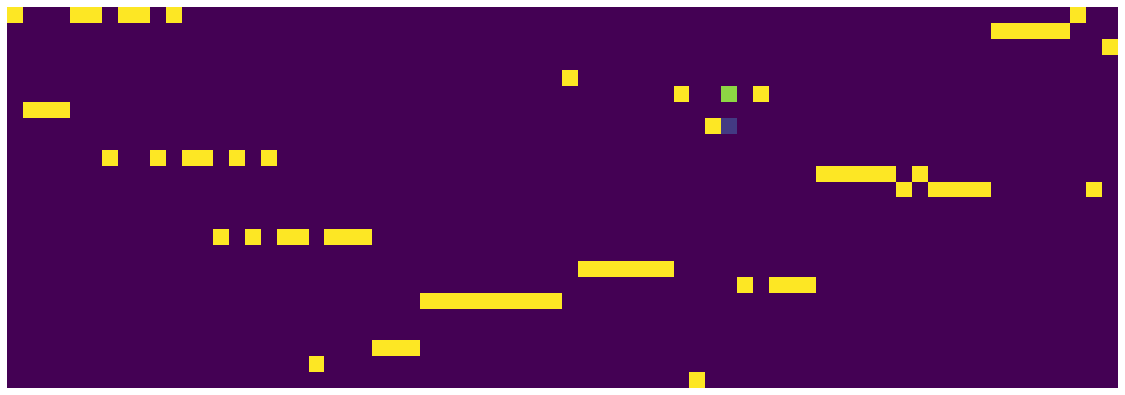

24 269 0.7299999999999998 0.41618585102260114


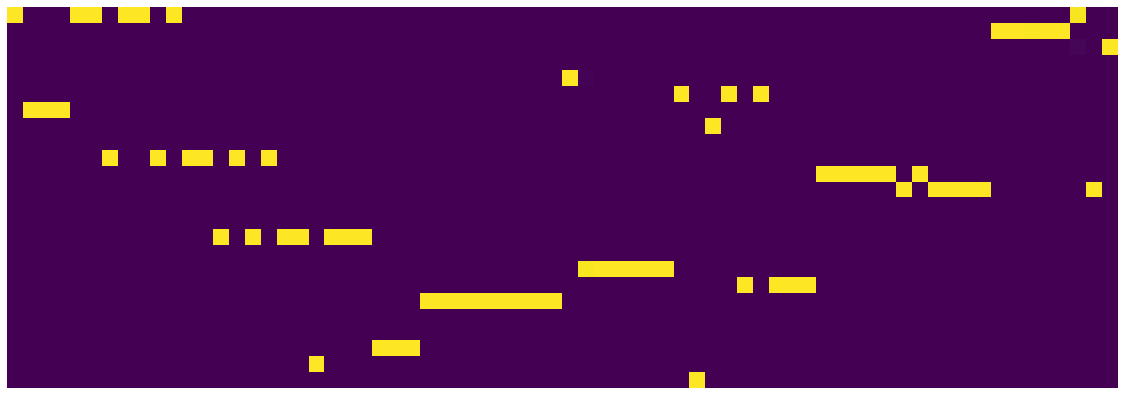

24 270 0.7289999999999998 0.41278930148109794


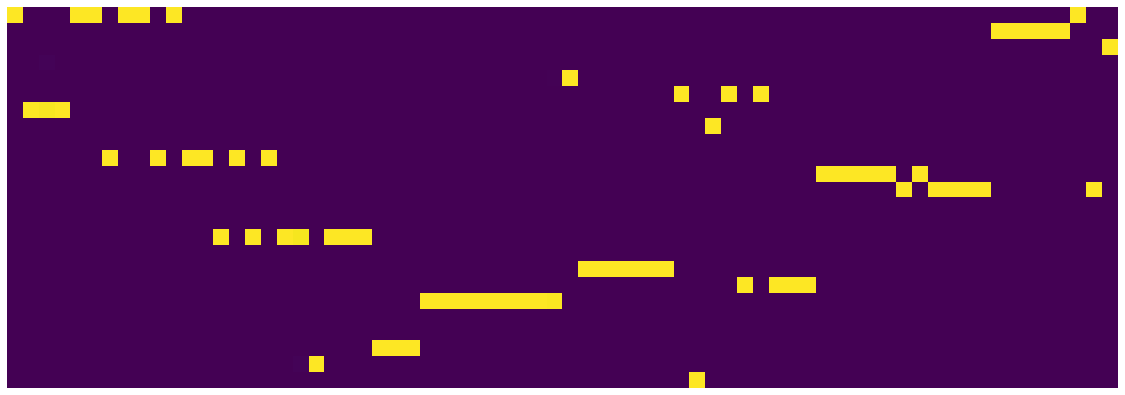

24 271 0.7279999999999998 0.41367261074483397


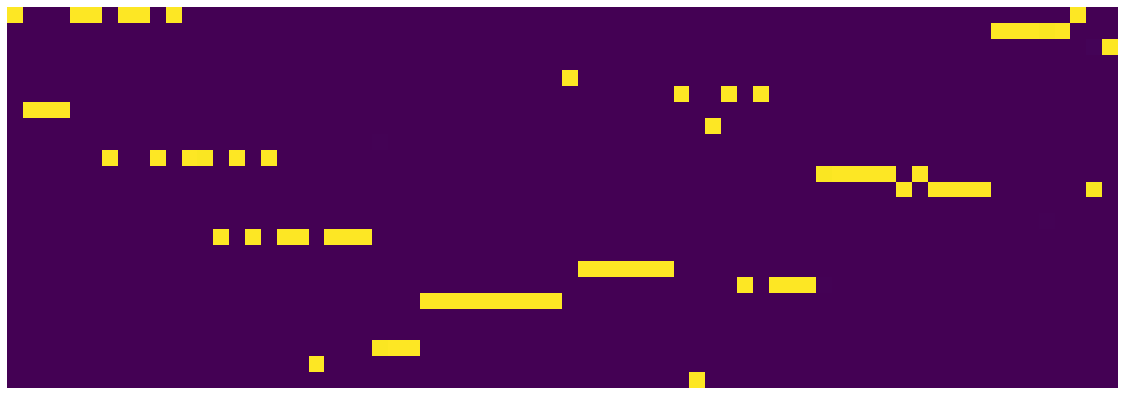

24 272 0.7269999999999998 0.4145538153126836


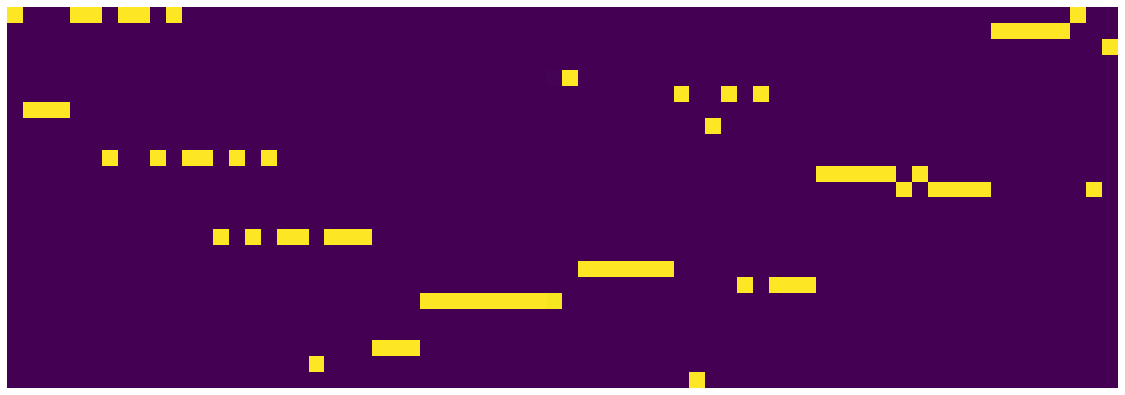

24 273 0.7259999999999998 0.4092464216053486


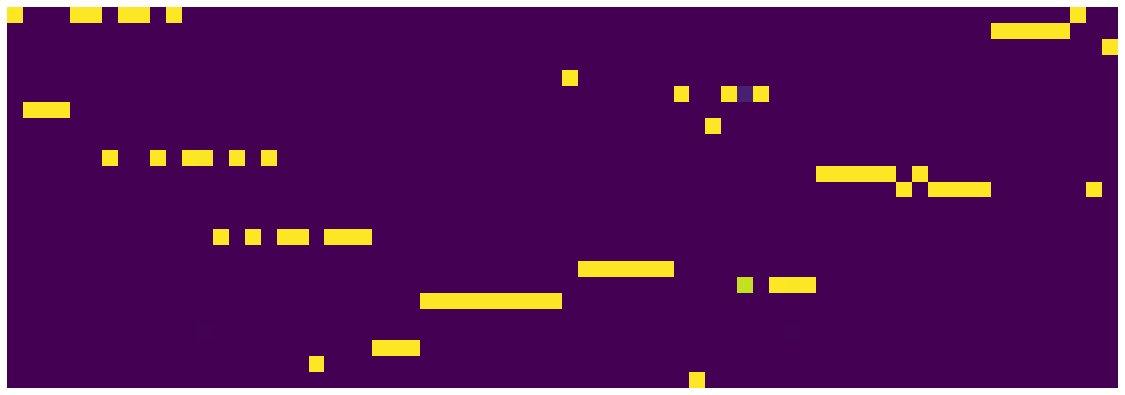

24 274 0.7249999999999998 0.414864054415375


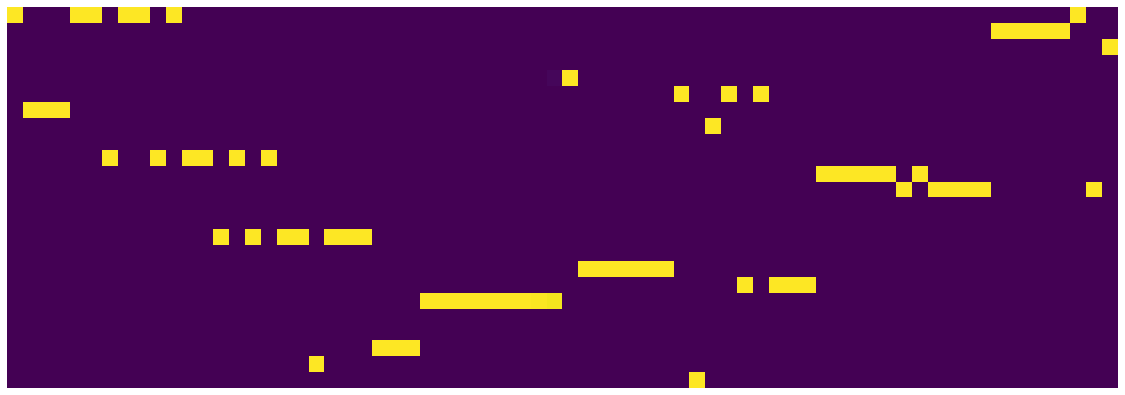

24 275 0.7239999999999998 0.4151591436937451


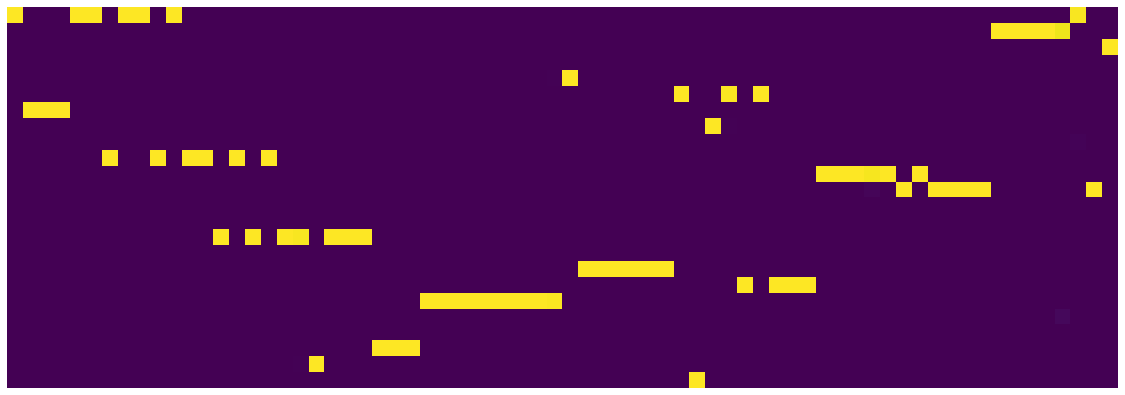

24 276 0.7229999999999998 0.41373392604291437


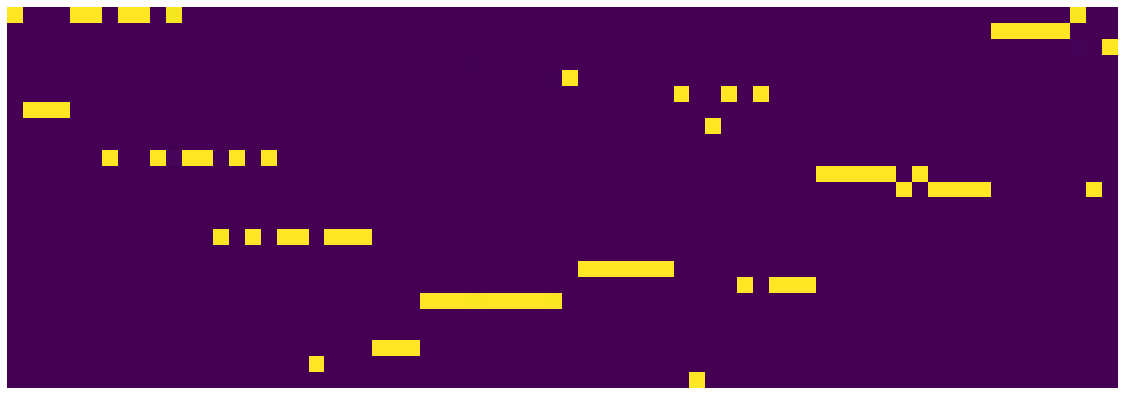

24 277 0.7219999999999998 0.4134380823932588


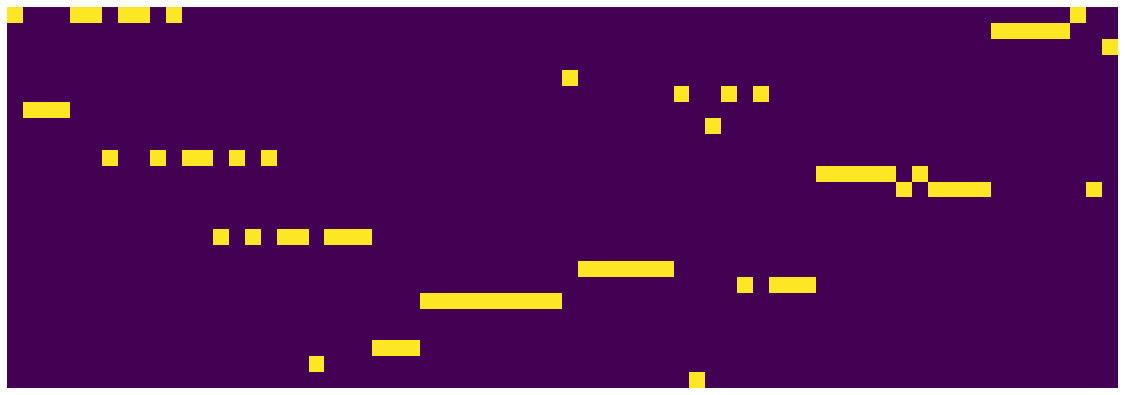

24 278 0.7209999999999998 0.4231382220052183


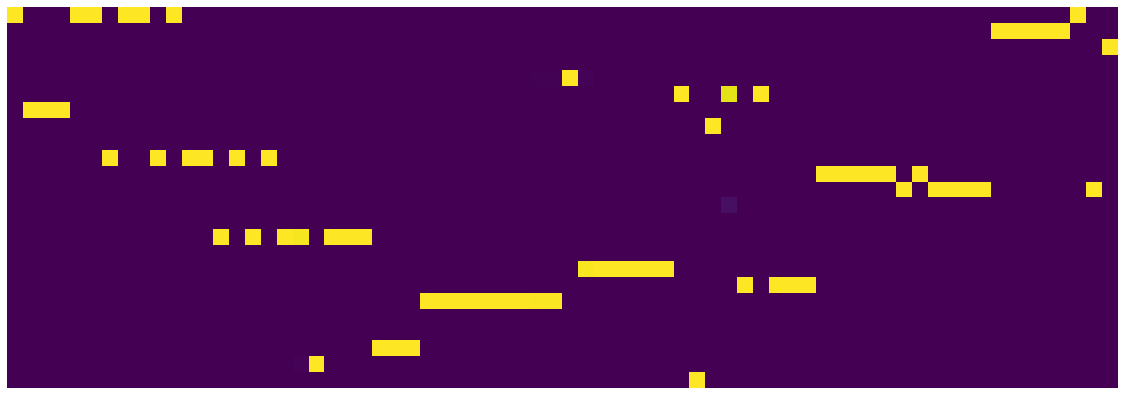

24 279 0.7199999999999998 0.4092918477021158


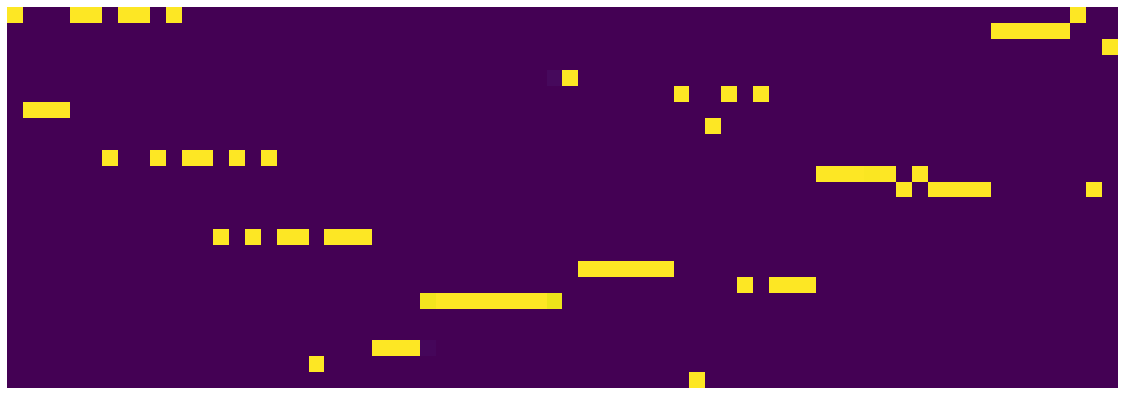

24 280 0.7189999999999998 0.40891929334029553


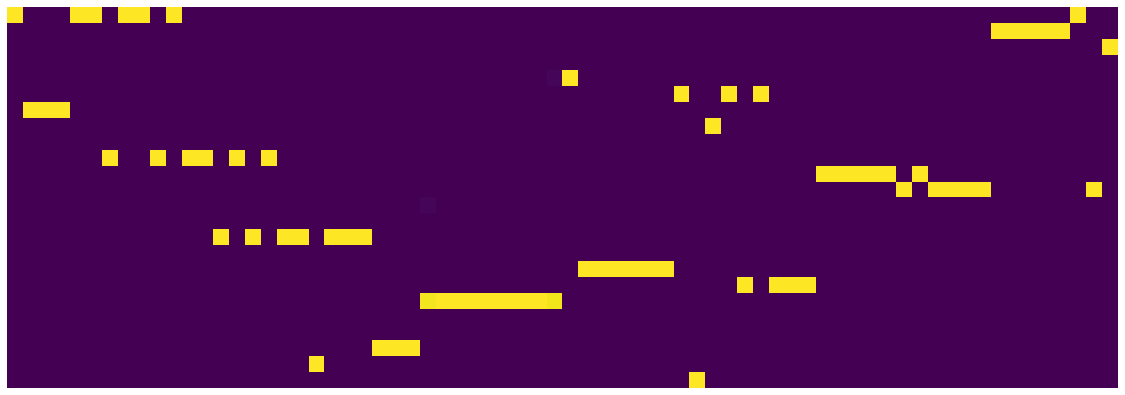

24 281 0.7179999999999997 0.4144251017831266


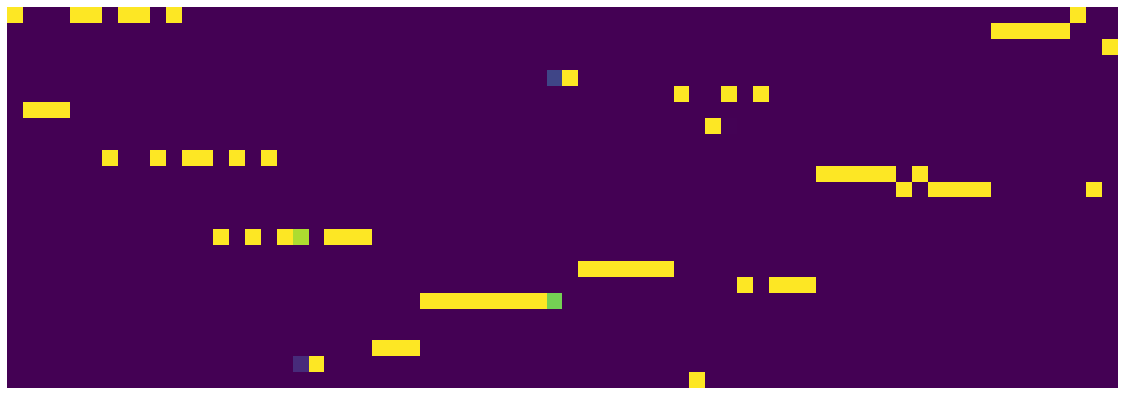

24 282 0.7169999999999997 0.4133690784685314


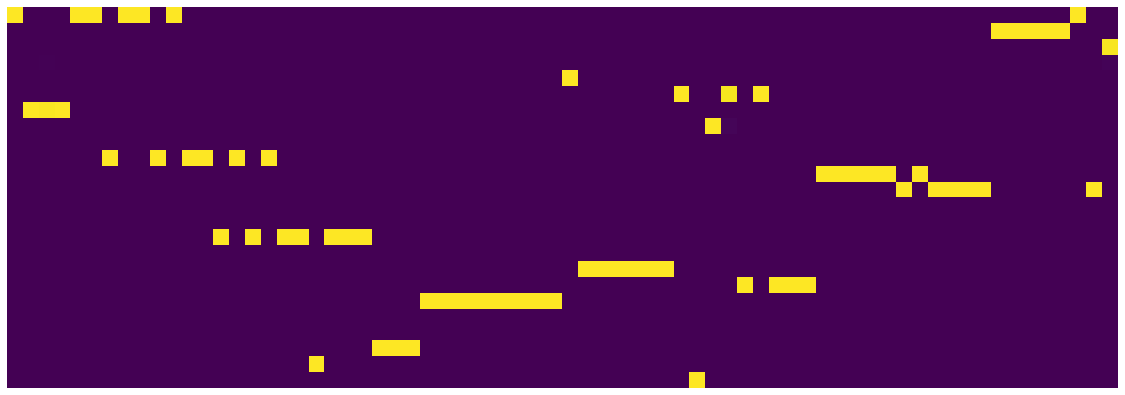

24 283 0.7159999999999997 0.40927967634052037


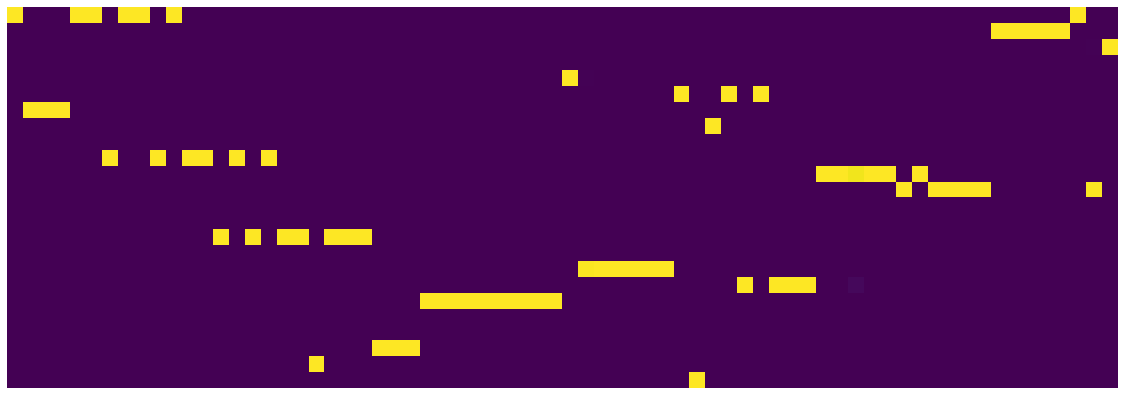

24 284 0.7149999999999997 0.42912021446973087


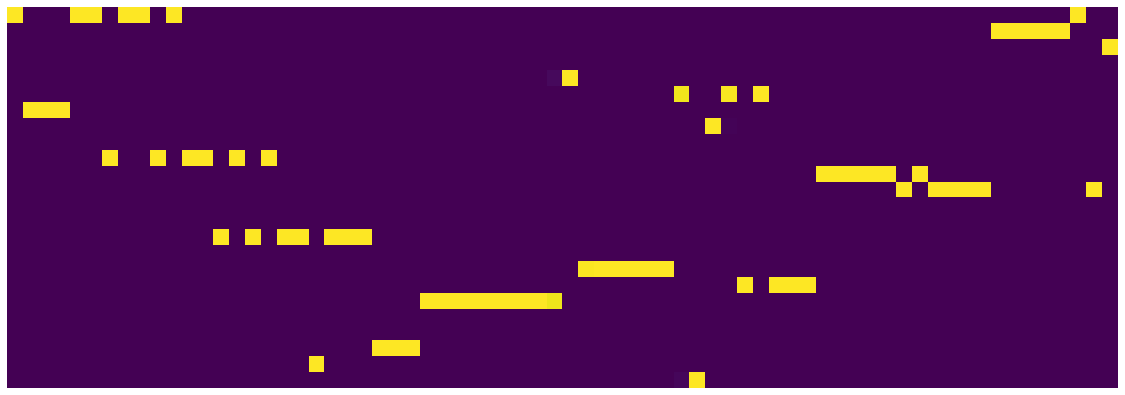

24 285 0.7139999999999997 0.42103255437687037


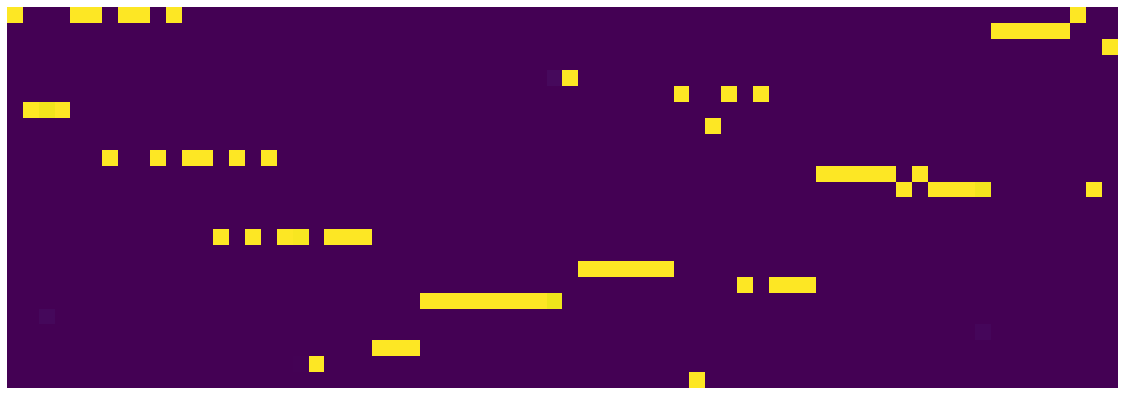

24 286 0.7129999999999997 0.4097004787065089


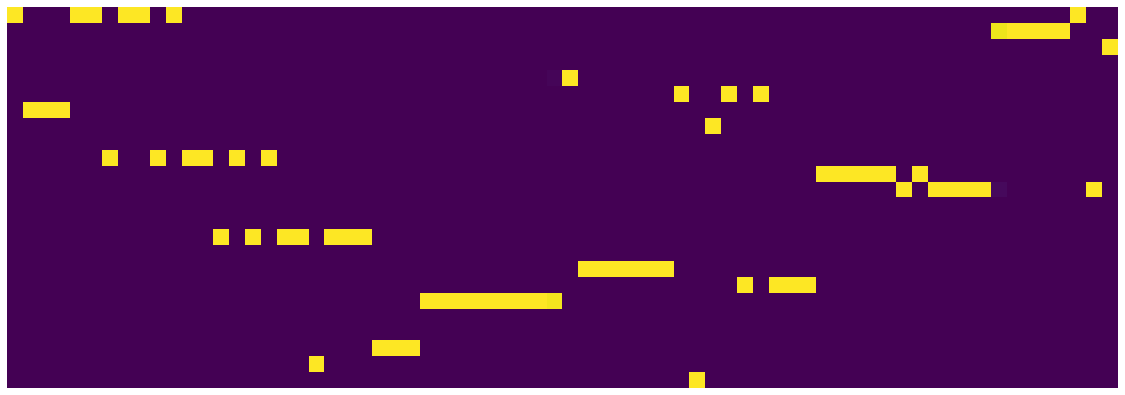

24 287 0.7119999999999997 0.4061518725939095


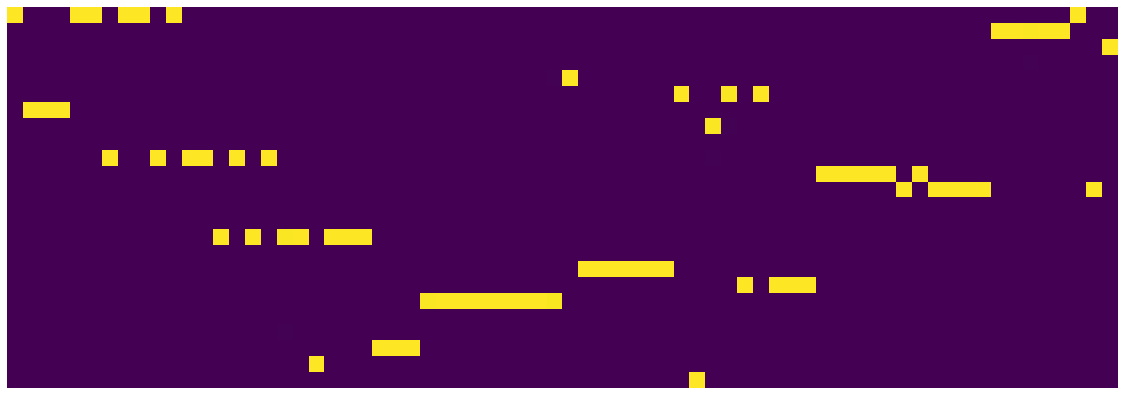

24 288 0.7109999999999997 0.4114042717032135


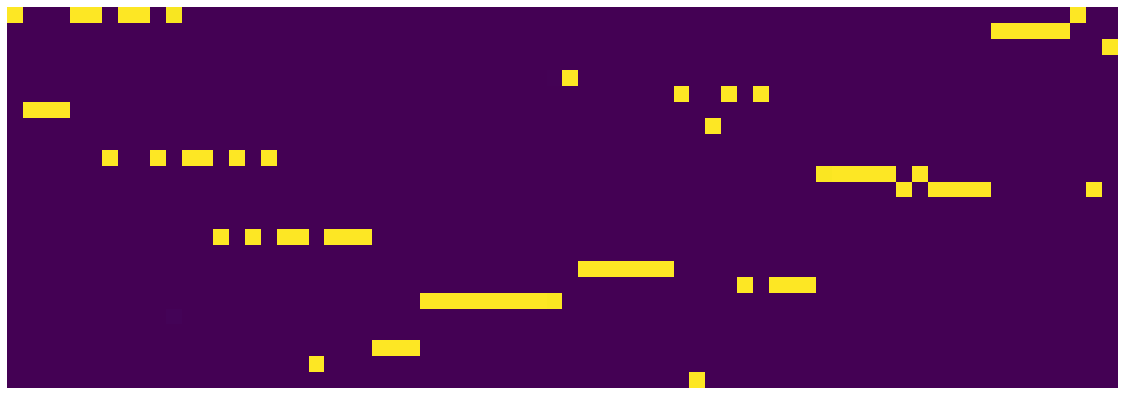

24 289 0.7099999999999997 0.42711402056738734


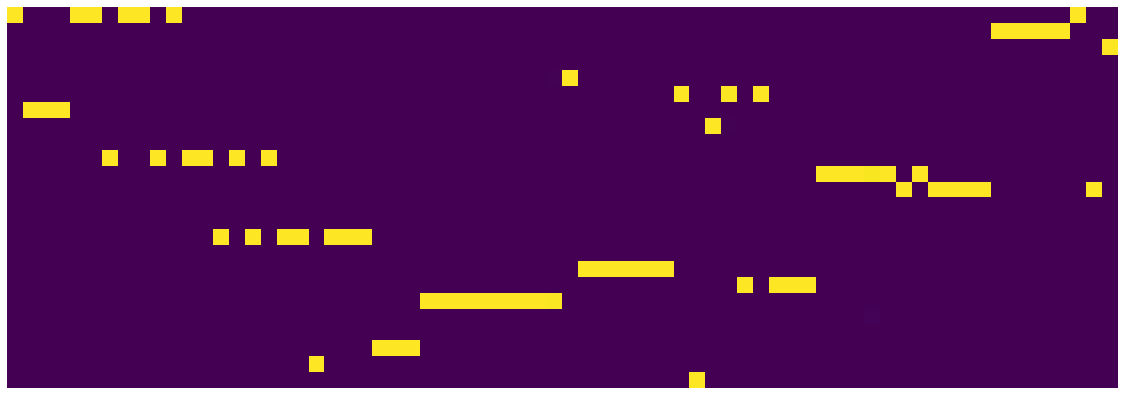

24 290 0.7089999999999997 0.4248959979042411


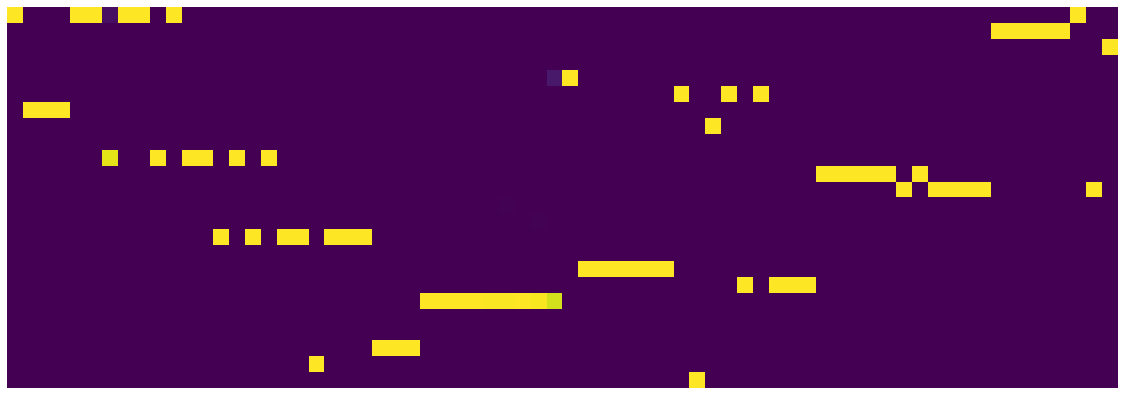

24 291 0.7079999999999997 0.4073133638128638


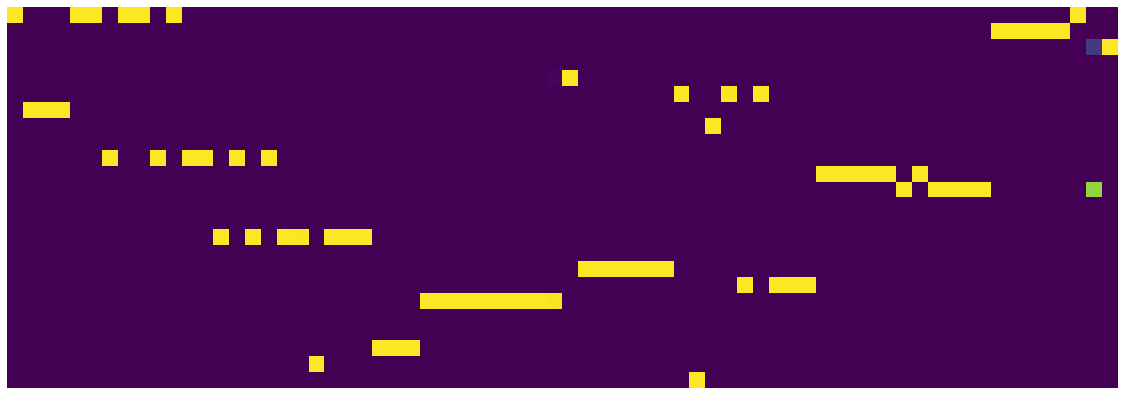

24 292 0.7069999999999997 0.41600623475387694


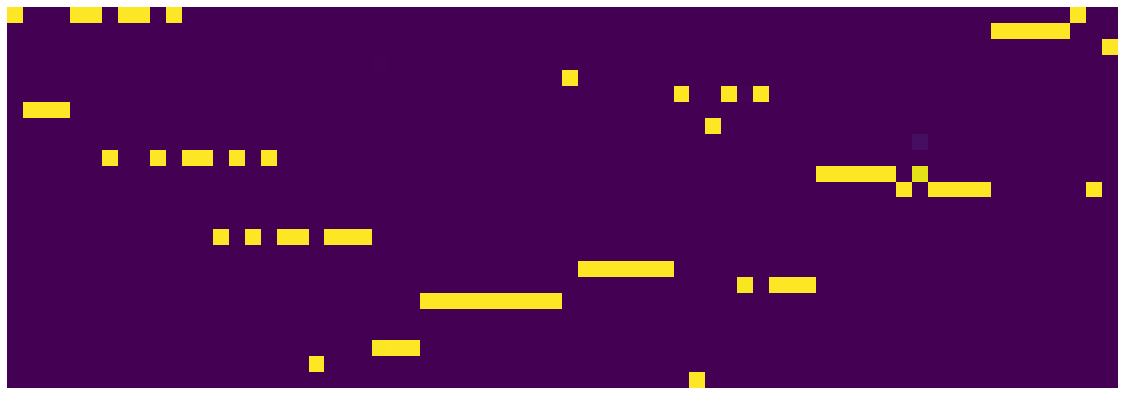

24 293 0.7059999999999997 0.4121816555969417


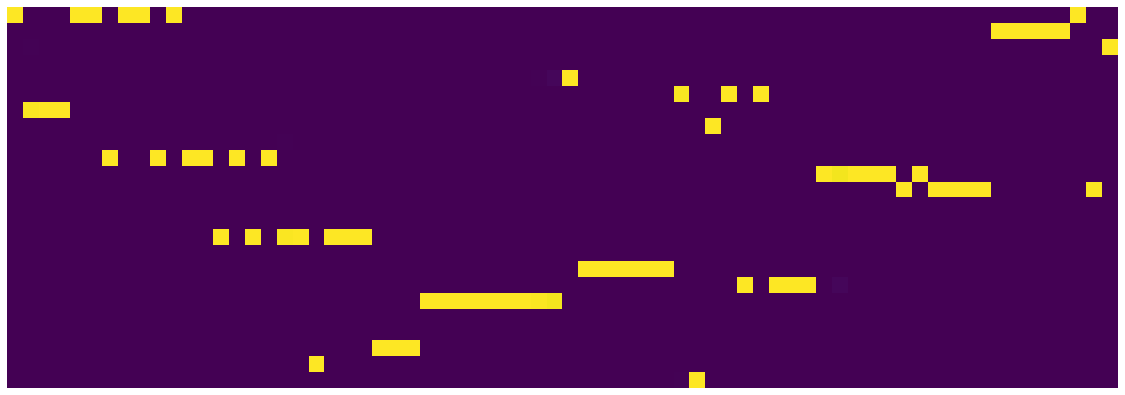

24 294 0.7049999999999997 0.412900117598474


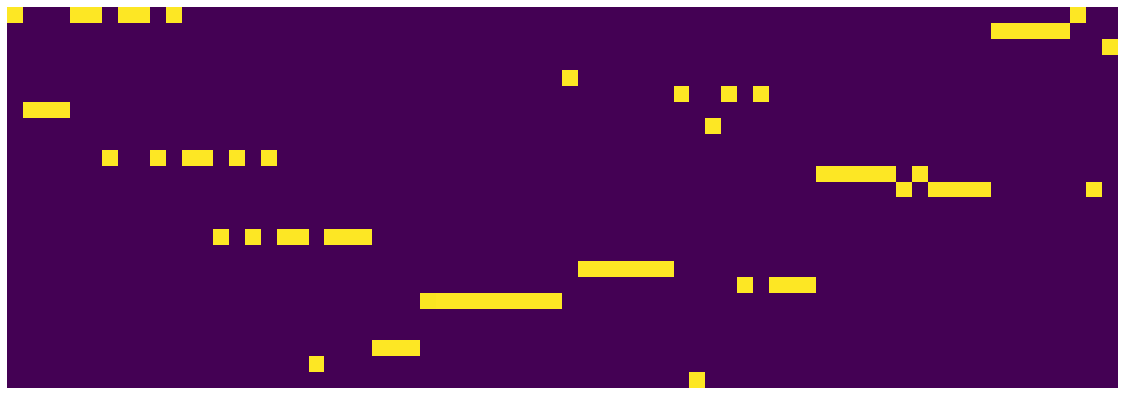

24 295 0.7039999999999997 0.40573153709992765


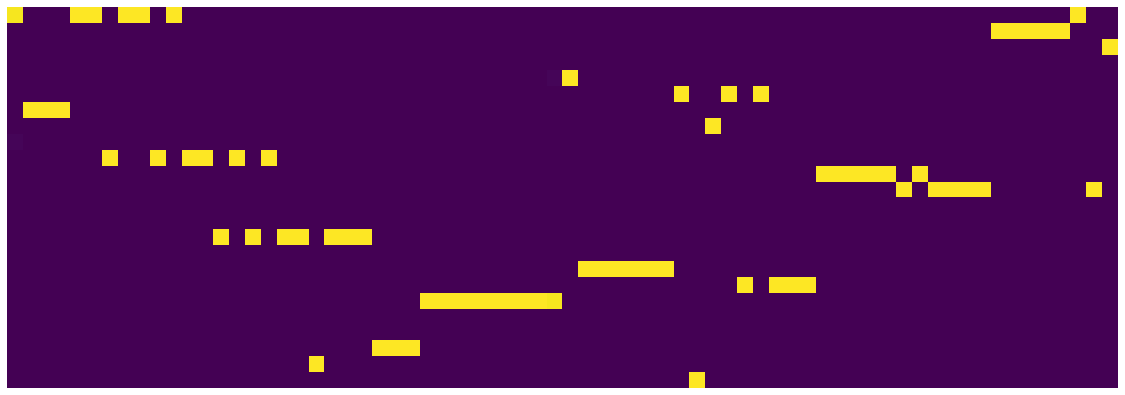

24 296 0.7029999999999997 0.48754136487841604


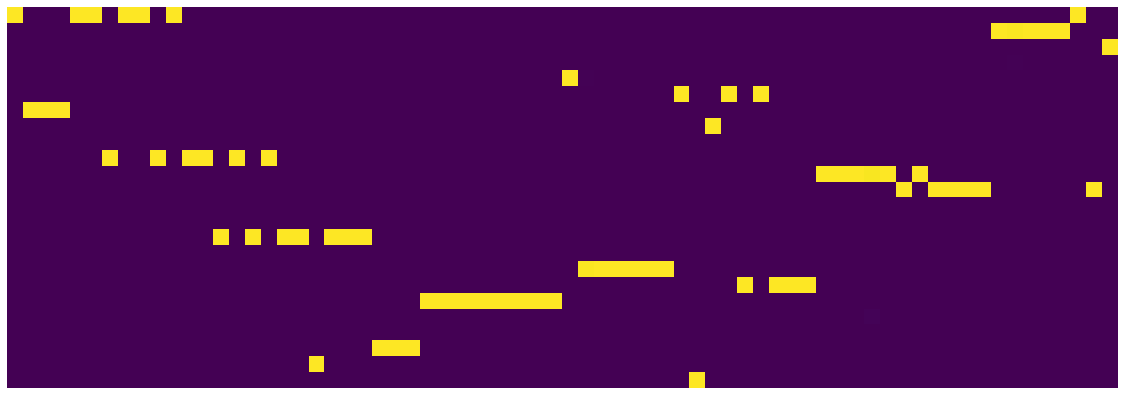

24 297 0.7019999999999997 0.4312914482317865


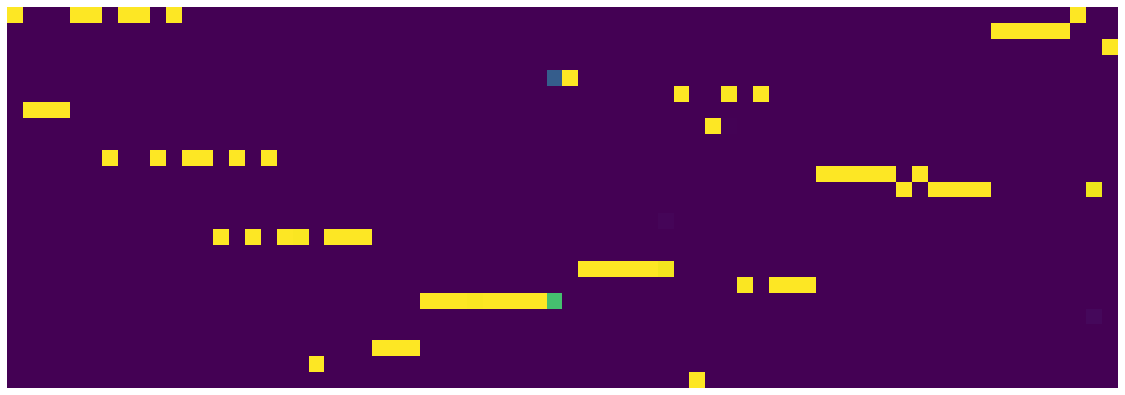

24 298 0.7009999999999997 0.4080711522139609


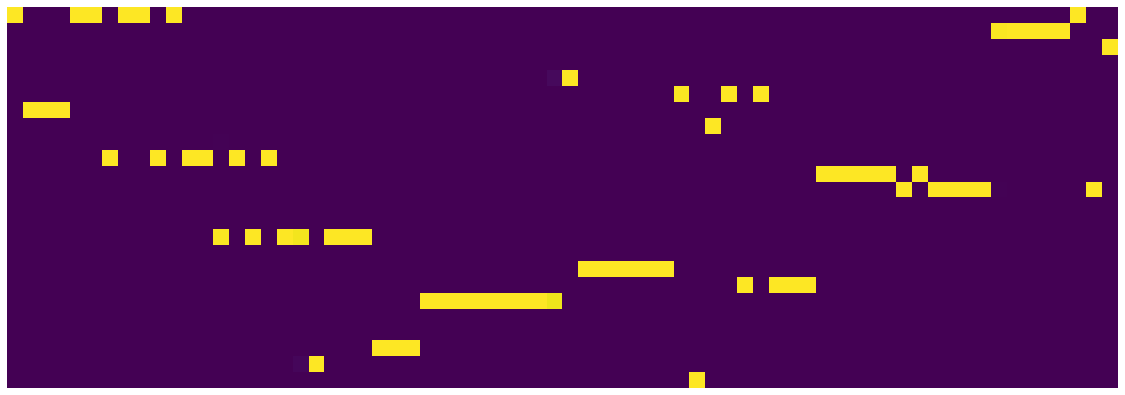

24 299 0.6999999999999997 0.4024070266634226


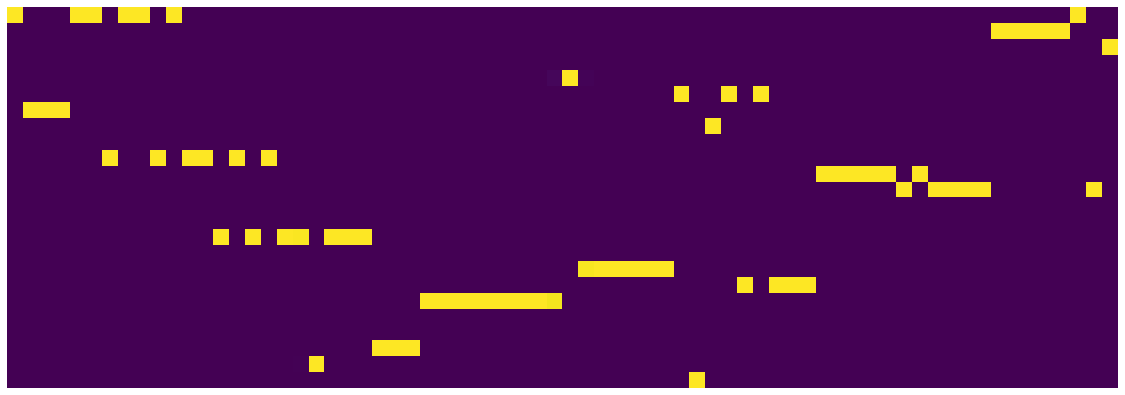

24 300 0.6989999999999997 0.41333664264529946


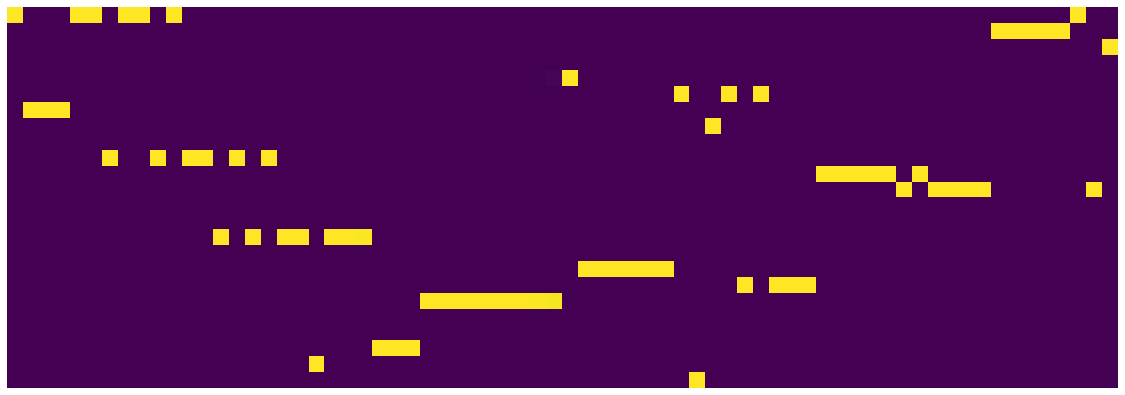

24 301 0.6979999999999997 0.4099096748046577


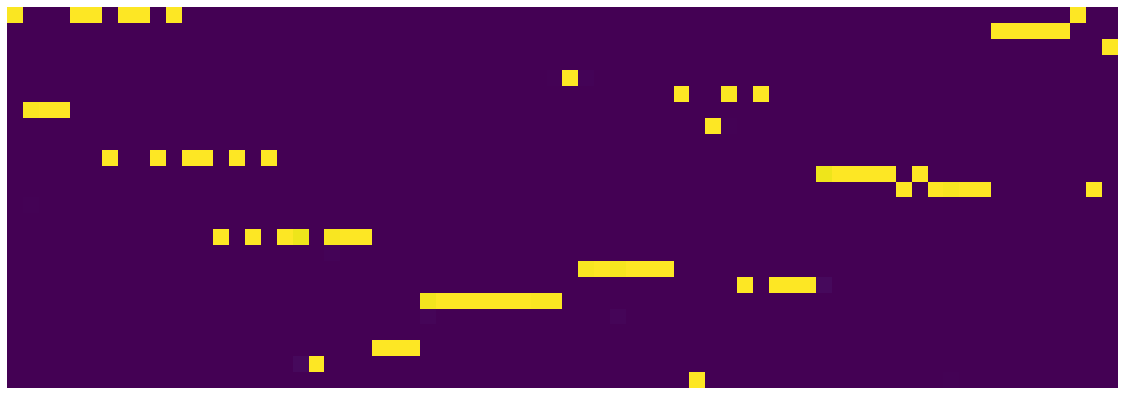

24 302 0.6969999999999997 0.407810943108052


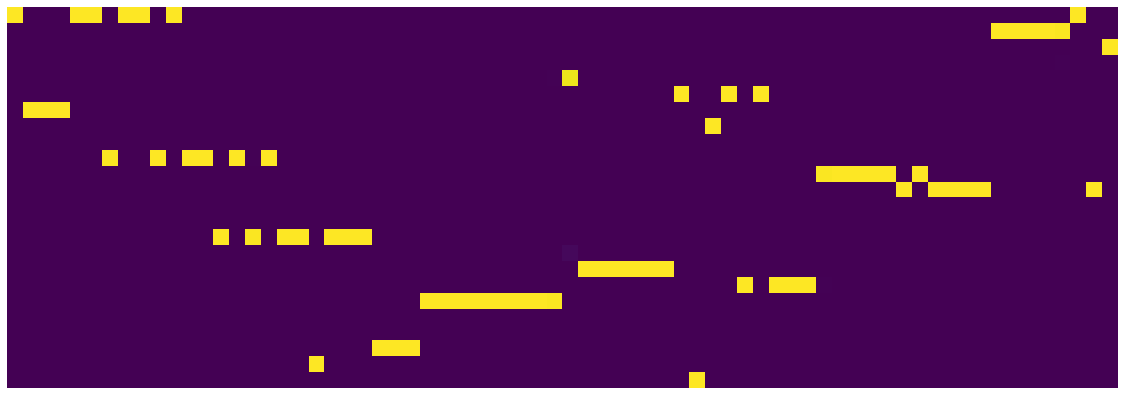

24 303 0.6959999999999997 0.4096231931820512


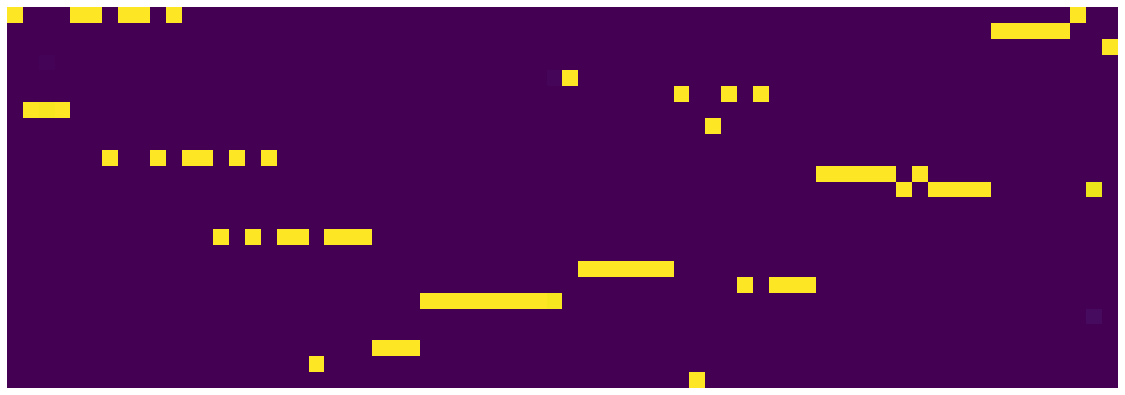

24 304 0.6949999999999997 0.40904087796807287


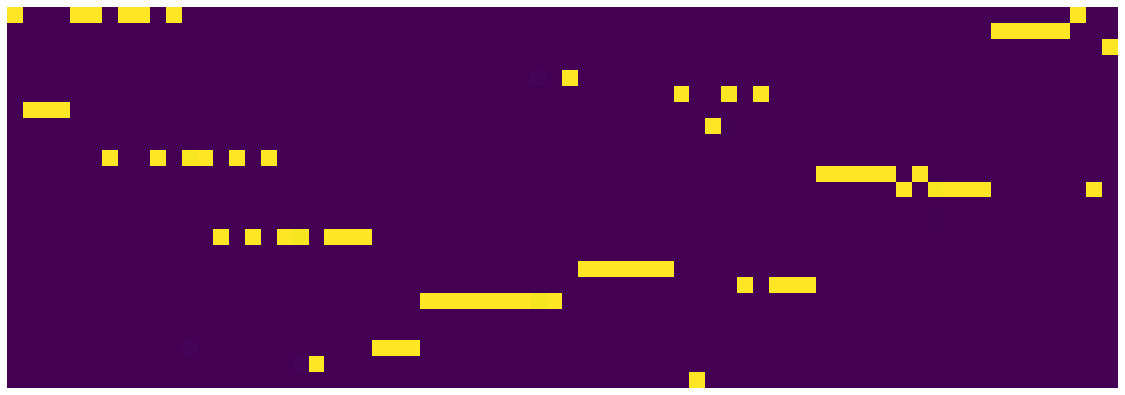

24 305 0.6939999999999997 0.4171019381843507


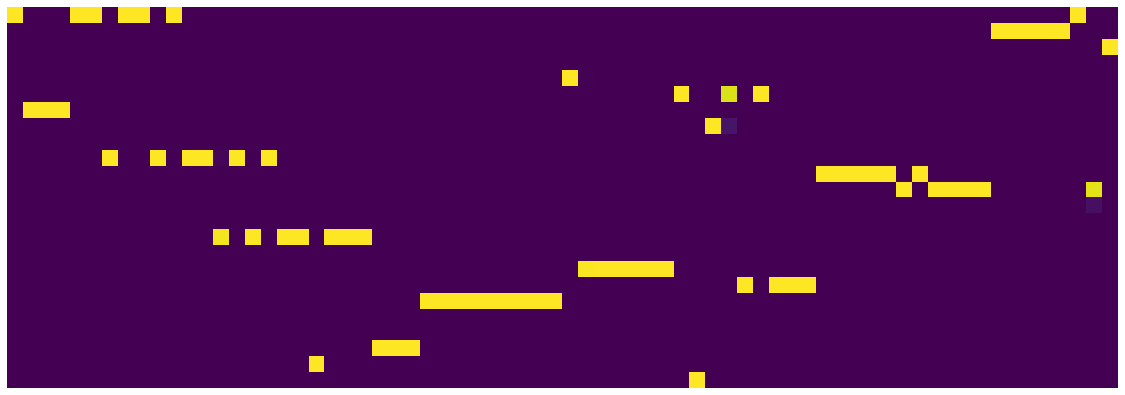

24 306 0.6929999999999997 0.4261886579915881


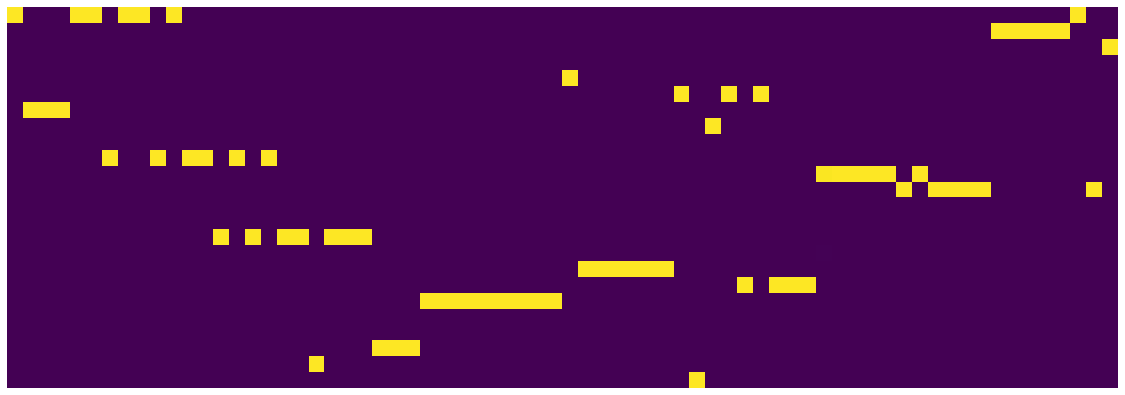

24 307 0.6919999999999997 0.4196154818870127


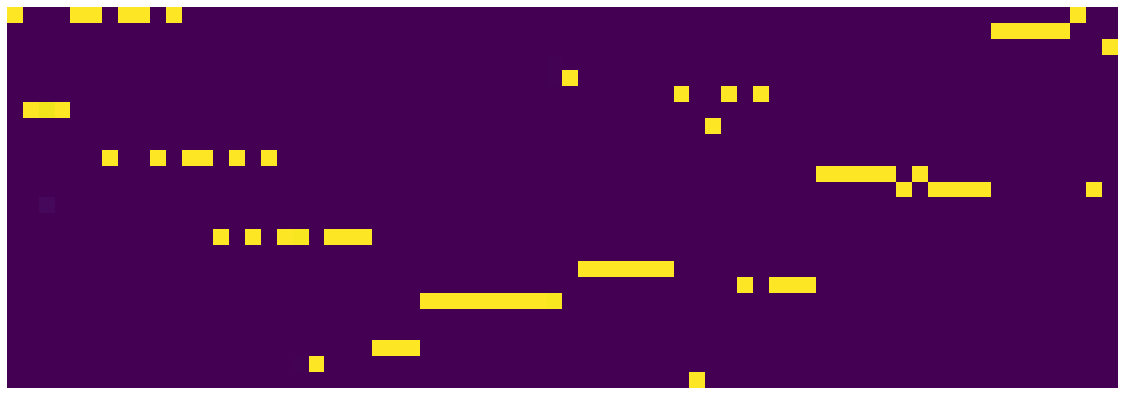

24 308 0.6909999999999997 0.4069622823037207


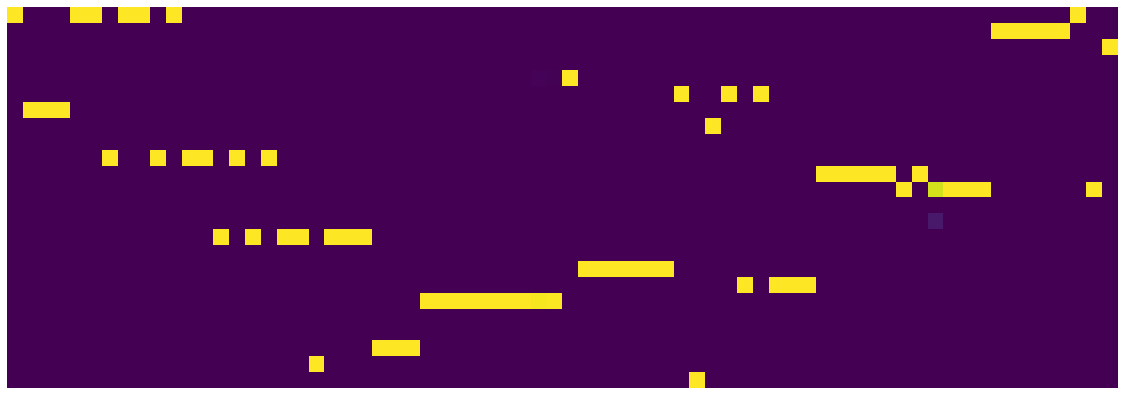

24 309 0.6899999999999997 0.4070093889720738


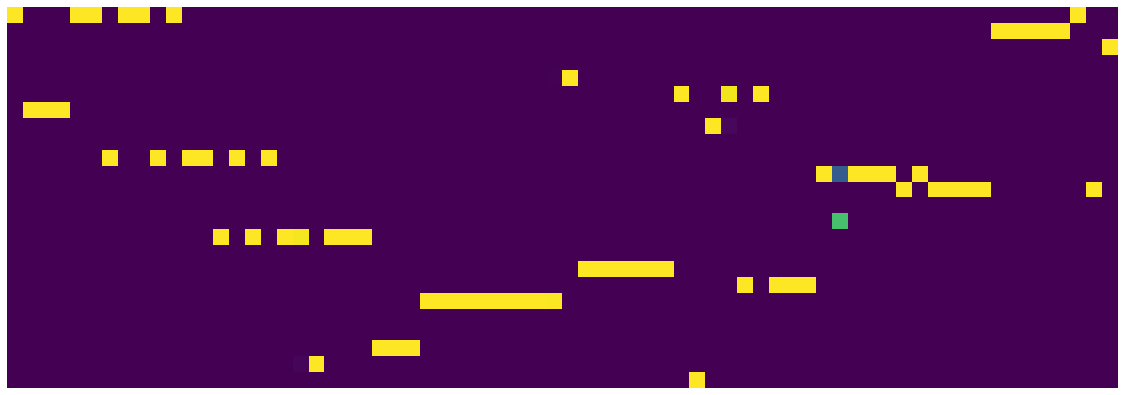

24 310 0.6889999999999997 0.4232647896744311


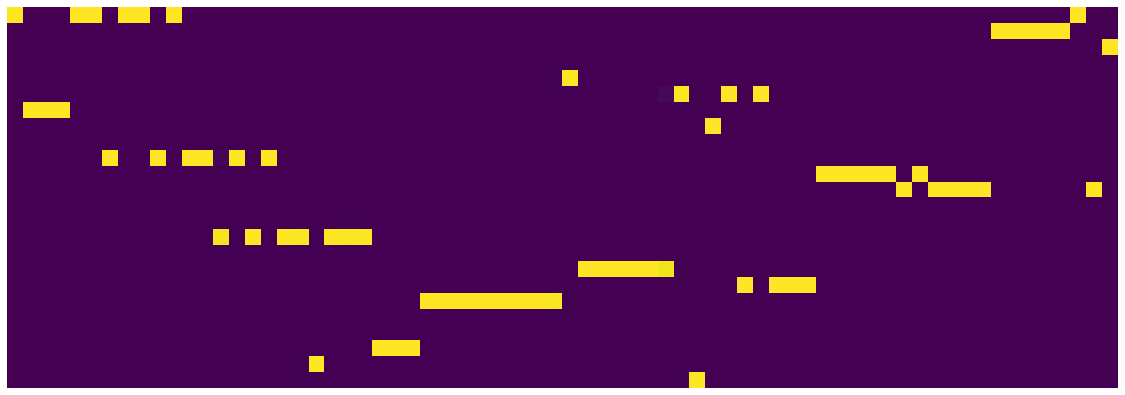

24 311 0.6879999999999997 0.41645658668130636


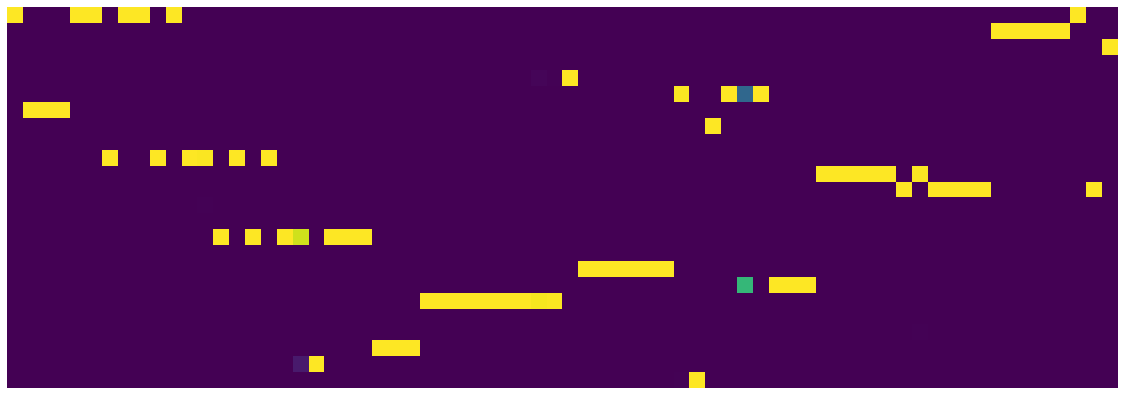

24 312 0.6869999999999997 0.4094025823287666


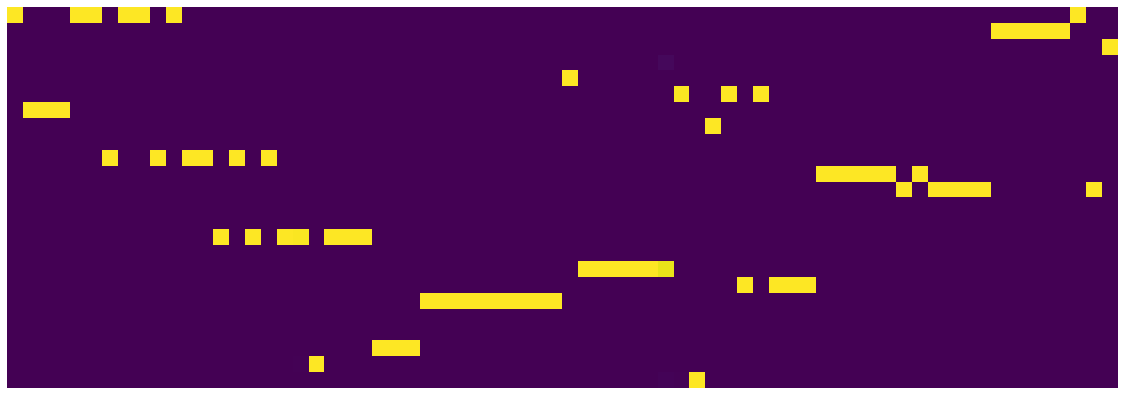

24 313 0.6859999999999997 0.4091317536309361


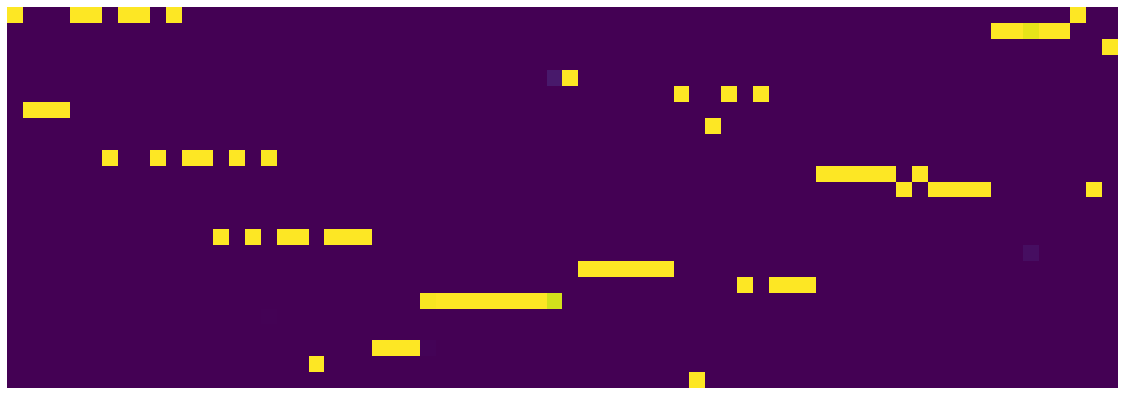

24 314 0.6849999999999997 0.42353811394423246


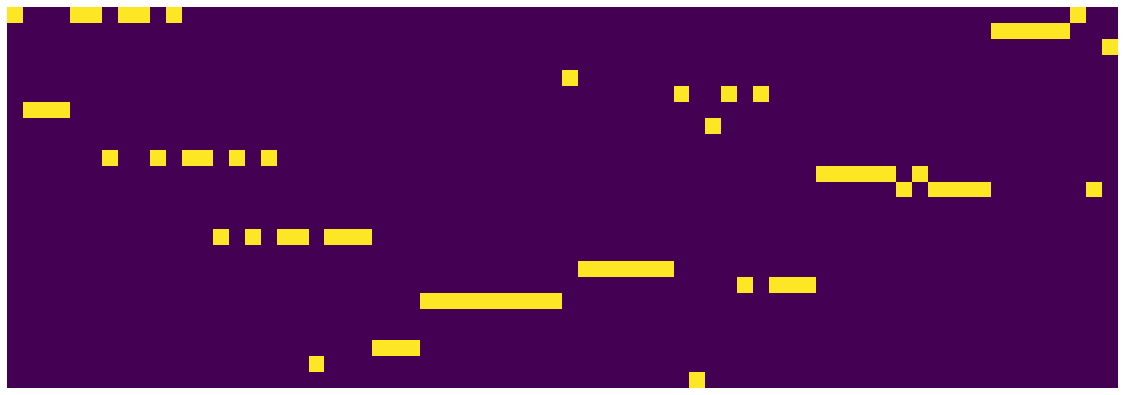

24 315 0.6839999999999997 0.43964505679905413


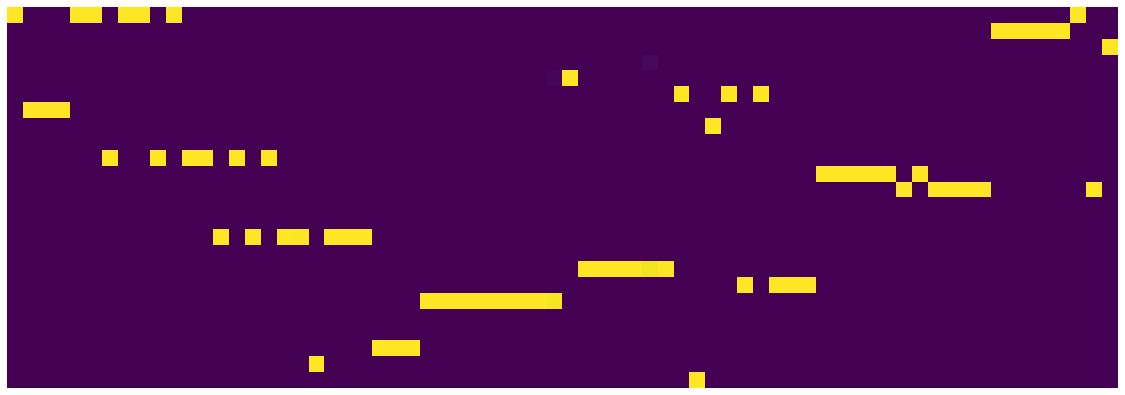

24 316 0.6829999999999997 0.41604578085243704


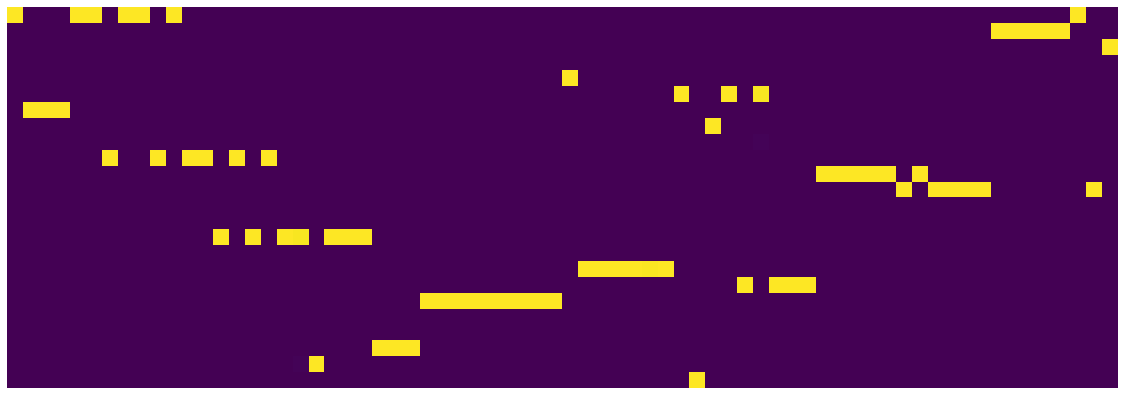

24 317 0.6819999999999997 0.4063080602325499


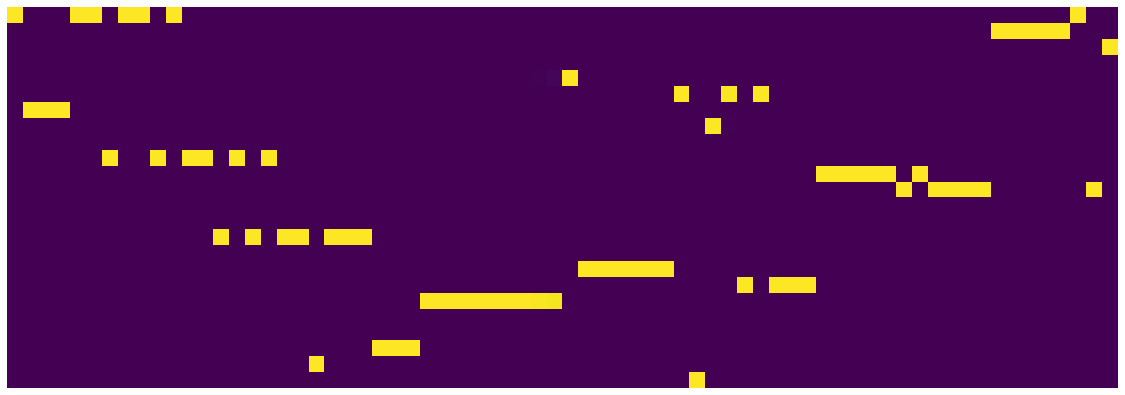

24 318 0.6809999999999997 0.4064716387540102


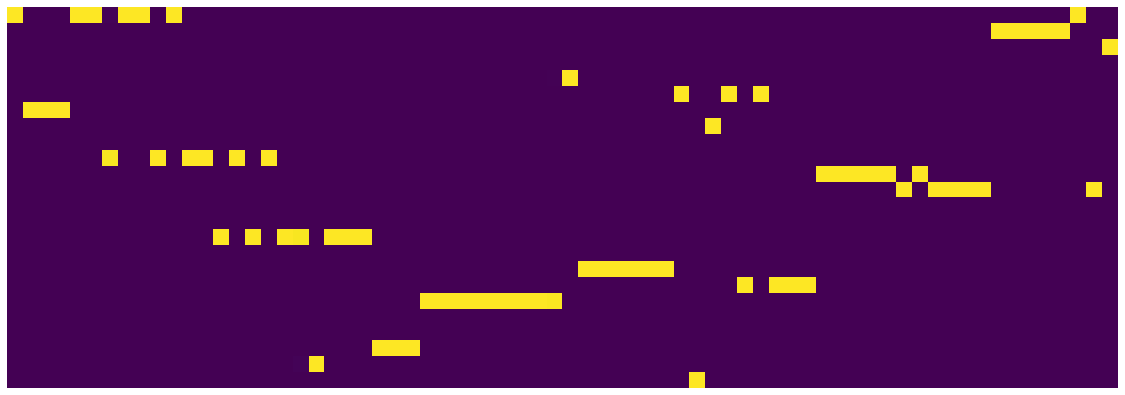

24 319 0.6799999999999997 0.4174217520281672


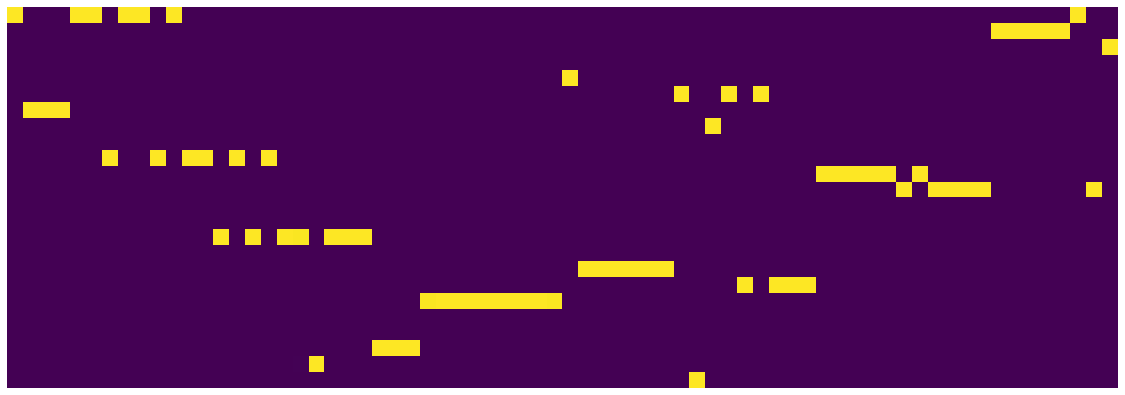

24 320 0.6789999999999997 0.418099245429039


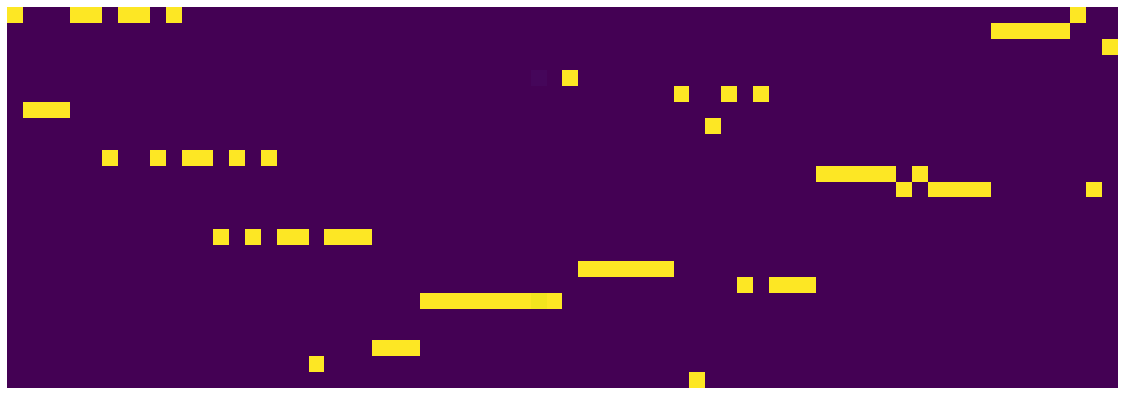

24 321 0.6779999999999997 0.4086051942780614


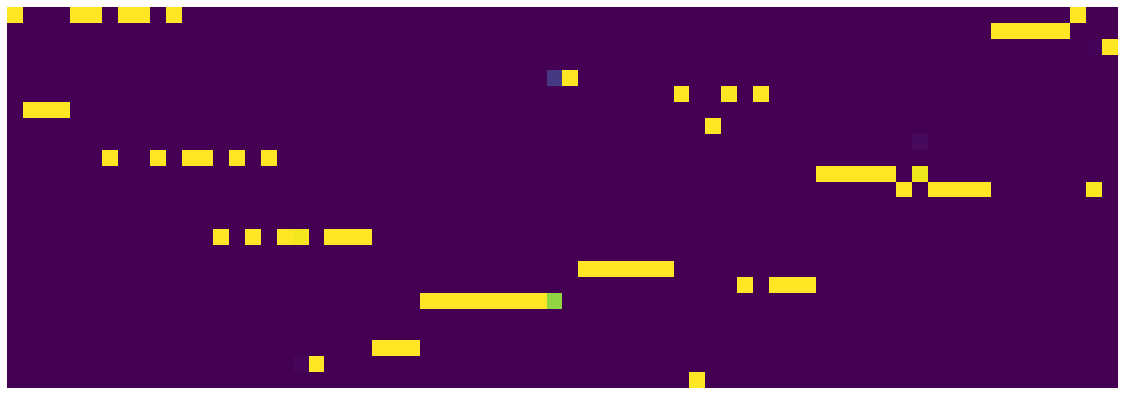

24 322 0.6769999999999997 0.4302988891489804


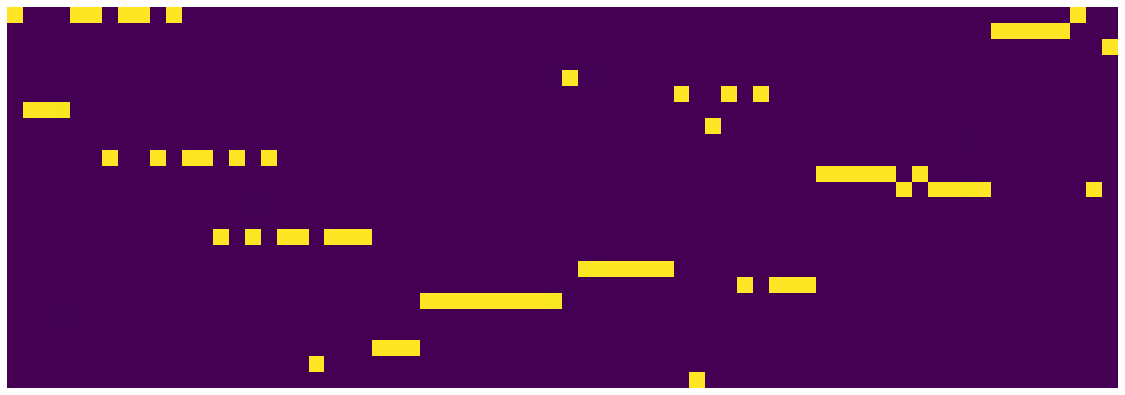

24 323 0.6759999999999997 0.41016487358137965


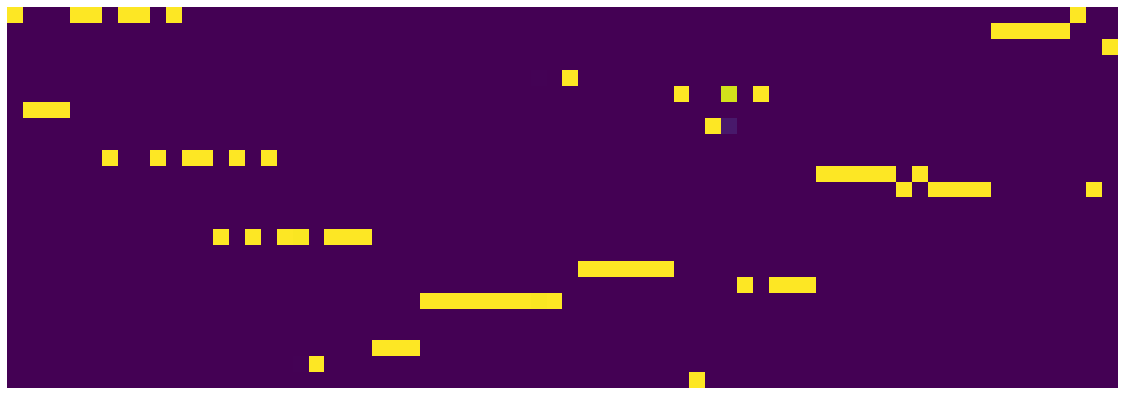

24 324 0.6749999999999997 0.42045603655278685


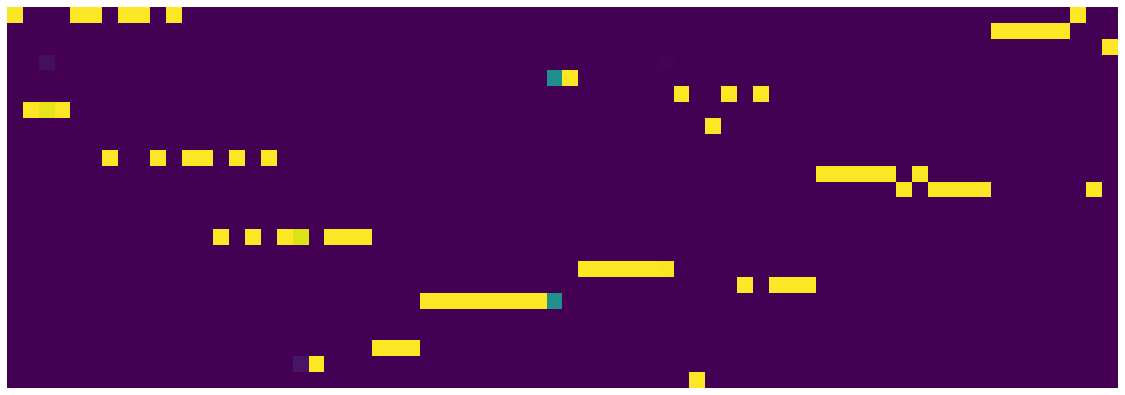

24 325 0.6739999999999997 0.4246051087044179


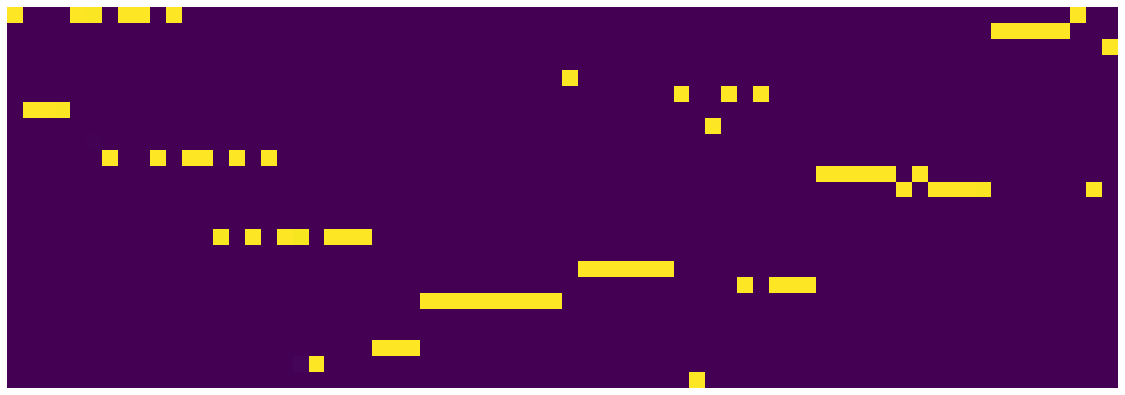

24 326 0.6729999999999997 0.4055647342465818


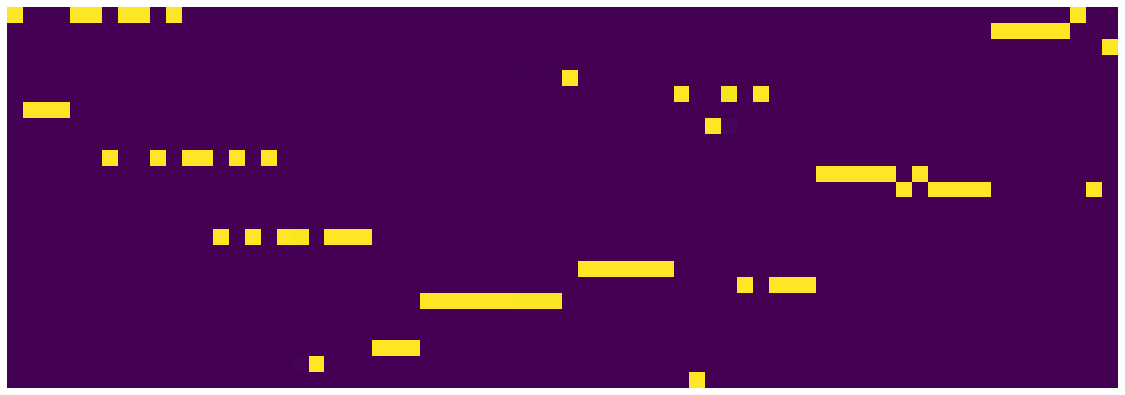

24 327 0.6719999999999997 0.4116277555003762


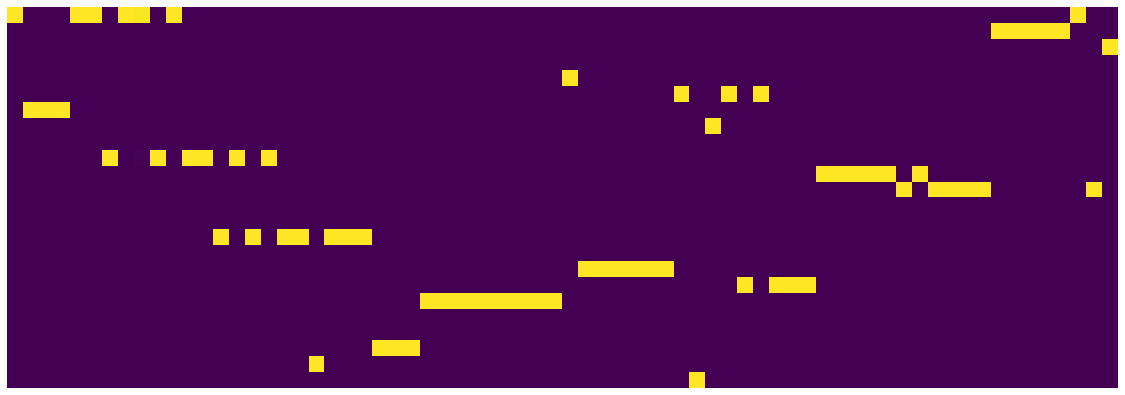

24 328 0.6709999999999997 0.41014744685962795


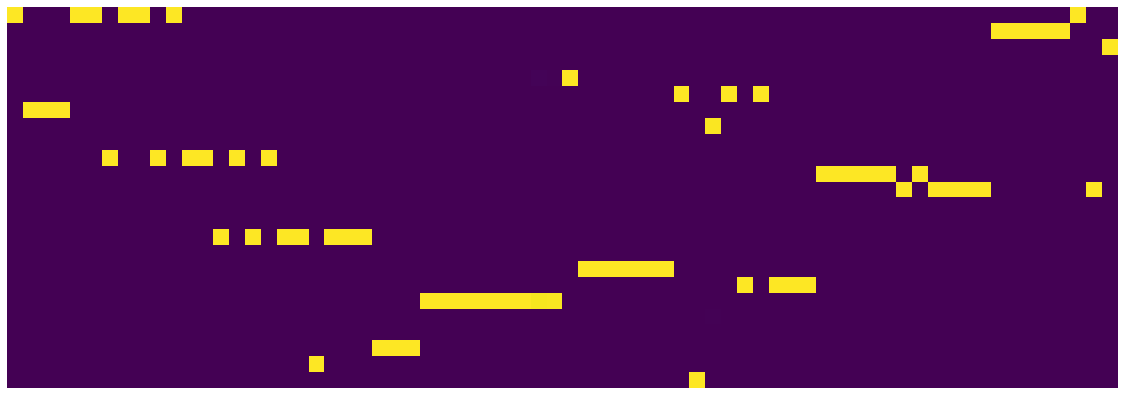

24 329 0.6699999999999997 0.41162677397951486


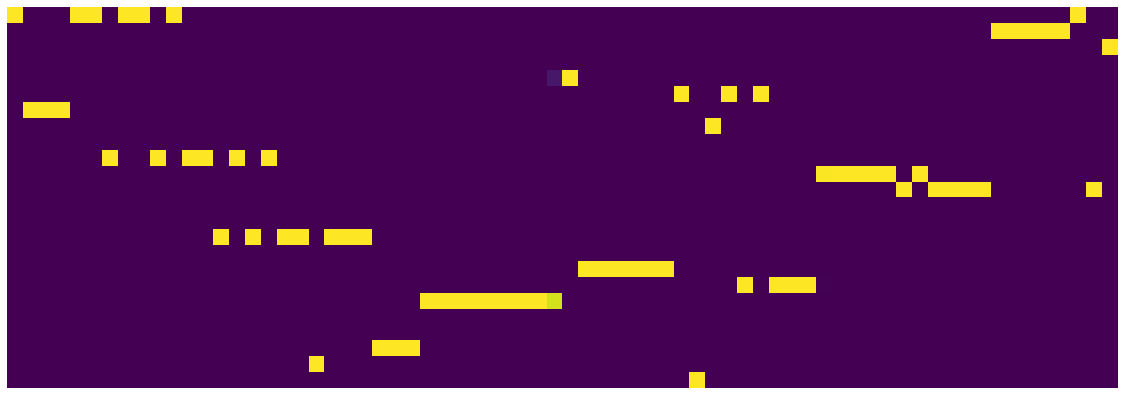

24 330 0.6689999999999997 0.4111530535854399


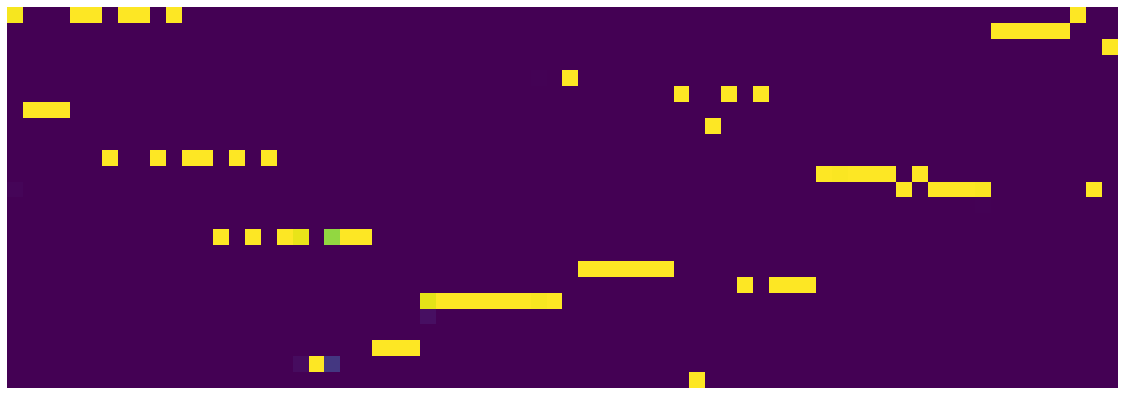

24 331 0.6679999999999997 0.4219955500215292


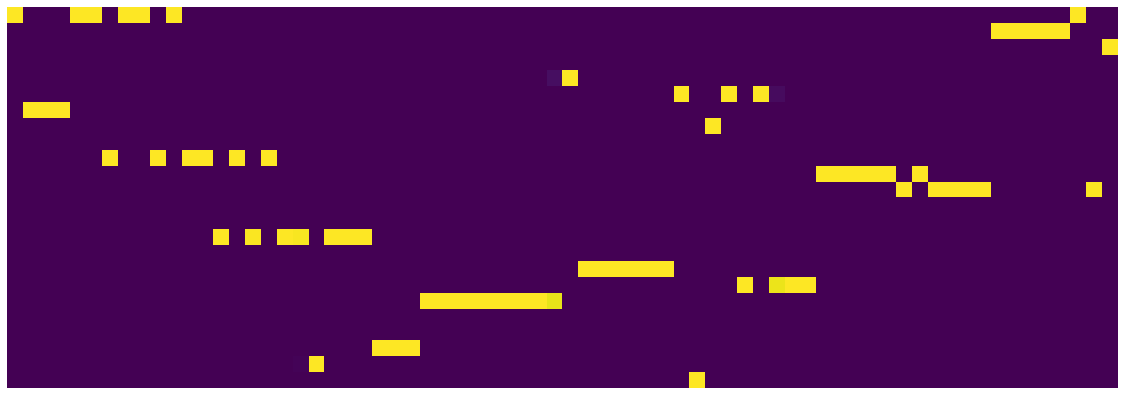

24 332 0.6669999999999997 0.42005125489085915


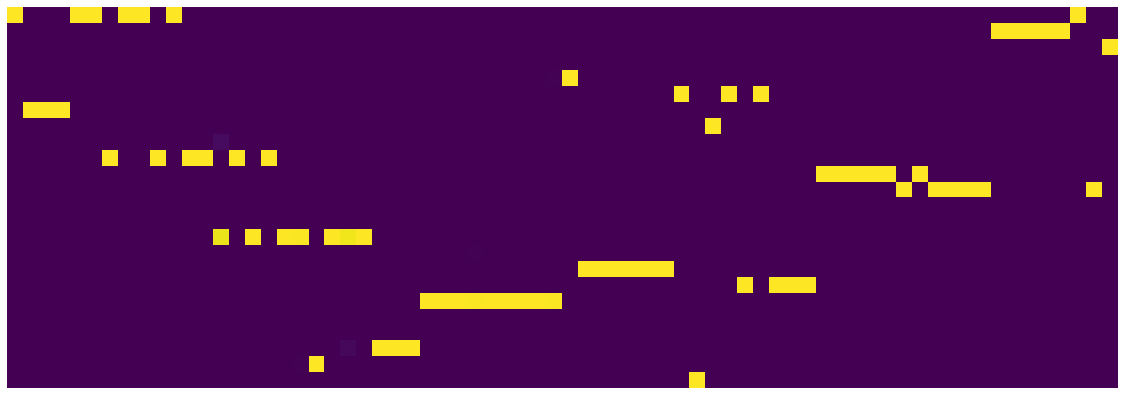

24 333 0.6659999999999997 0.40919189546257256


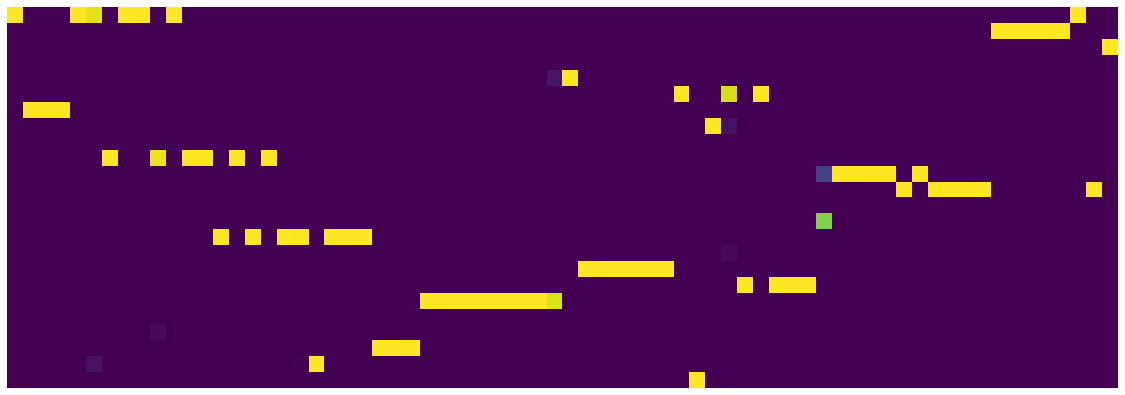

24 334 0.6649999999999997 0.4130951861850917


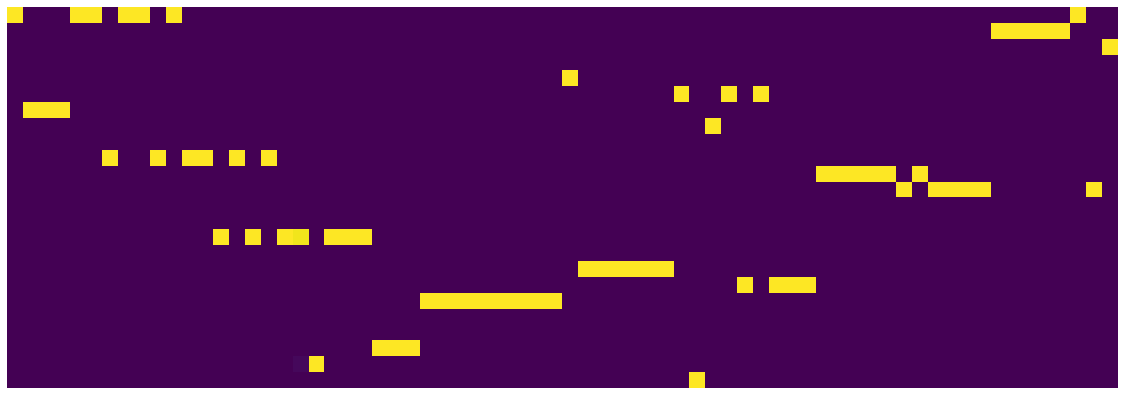

24 335 0.6639999999999997 0.43413881249725816


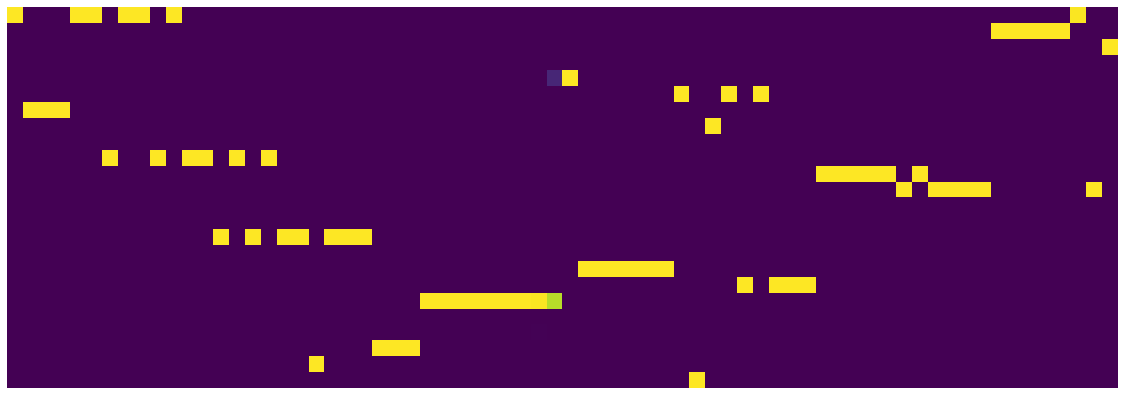

24 336 0.6629999999999997 0.4088714701123536


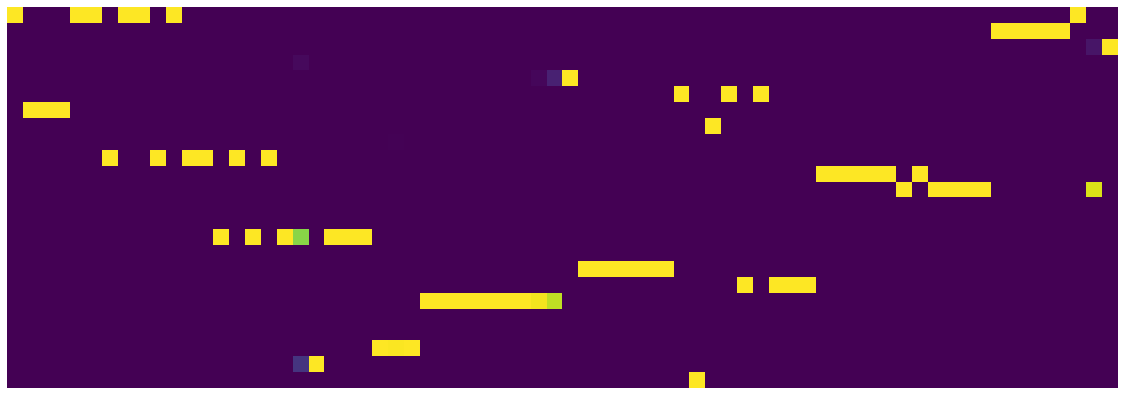

24 337 0.6619999999999997 0.45290124202147125


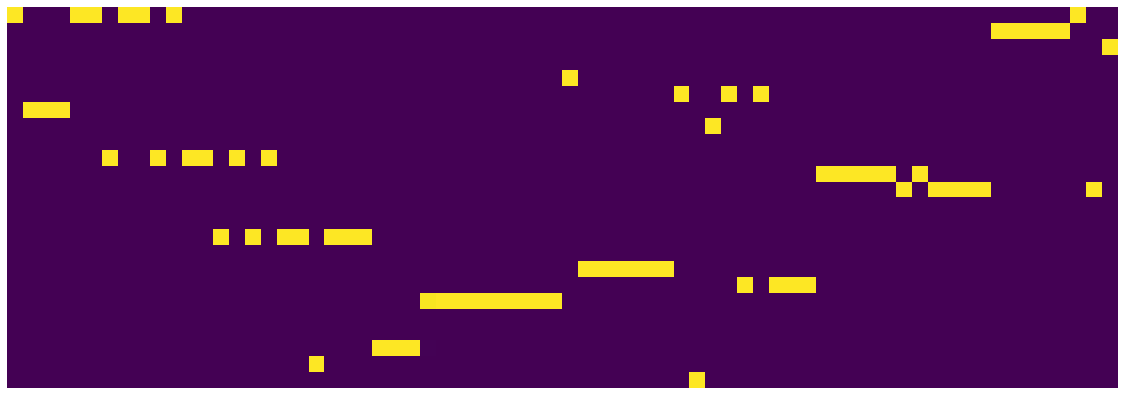

24 338 0.6609999999999997 0.4039018095470965


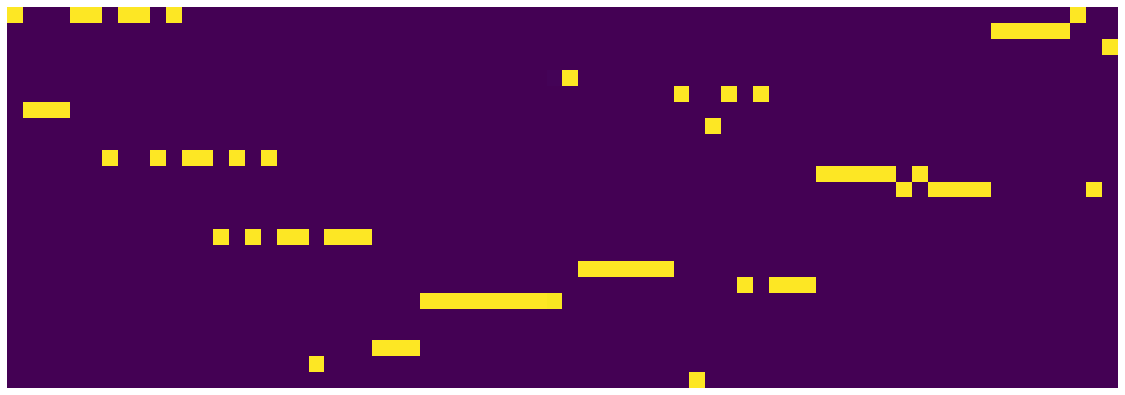

24 339 0.6599999999999997 0.415539716091007


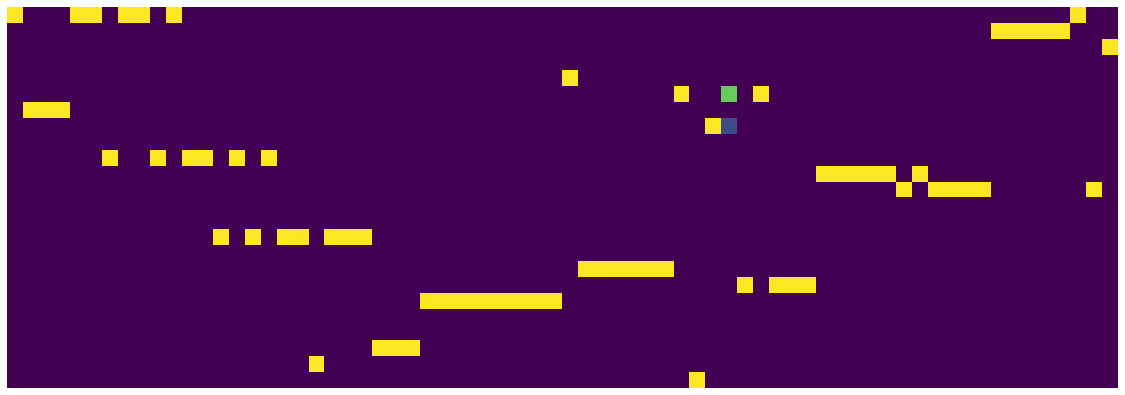

24 340 0.6589999999999997 0.40671398723497987


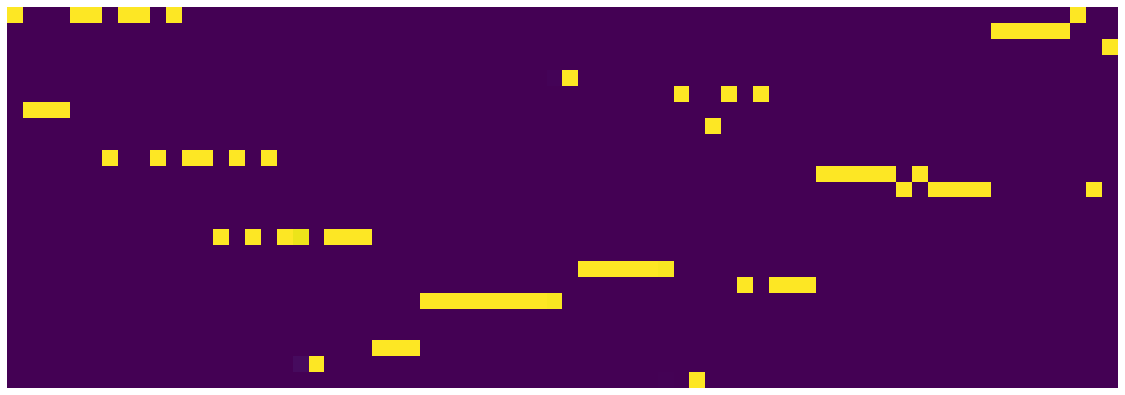

24 341 0.6579999999999997 0.41330481693148613


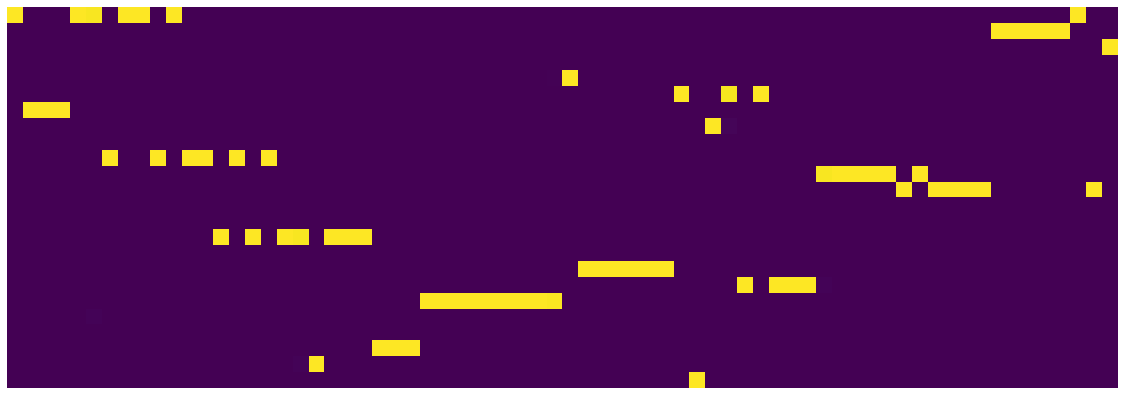

24 342 0.6569999999999997 0.4111185853369534


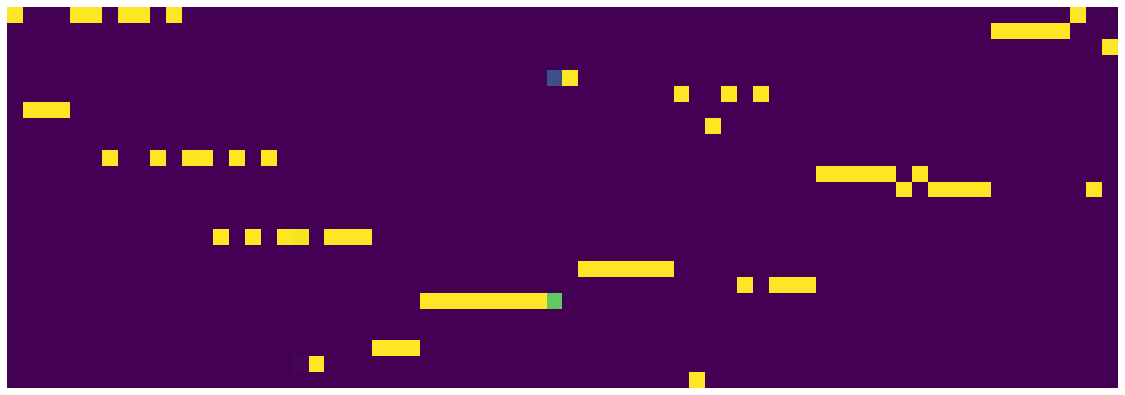

24 343 0.6559999999999997 0.4066101308912039


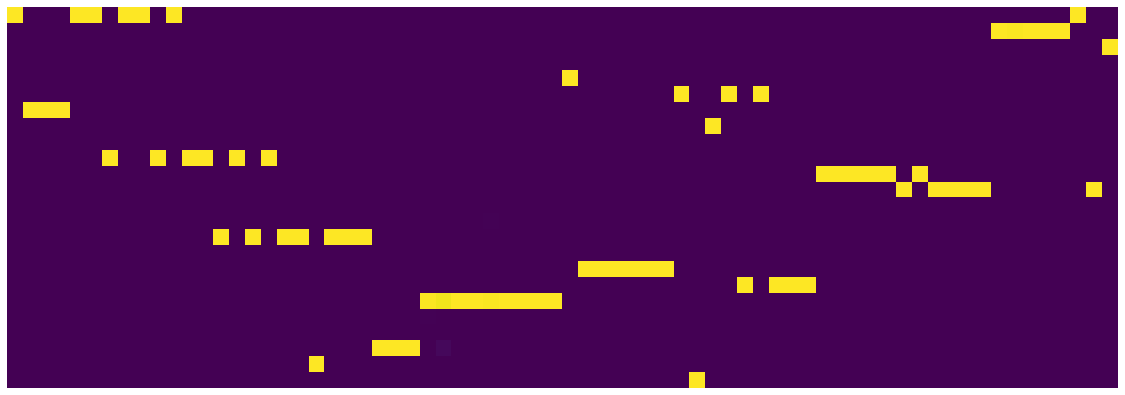

24 344 0.6549999999999997 0.4182600177824497


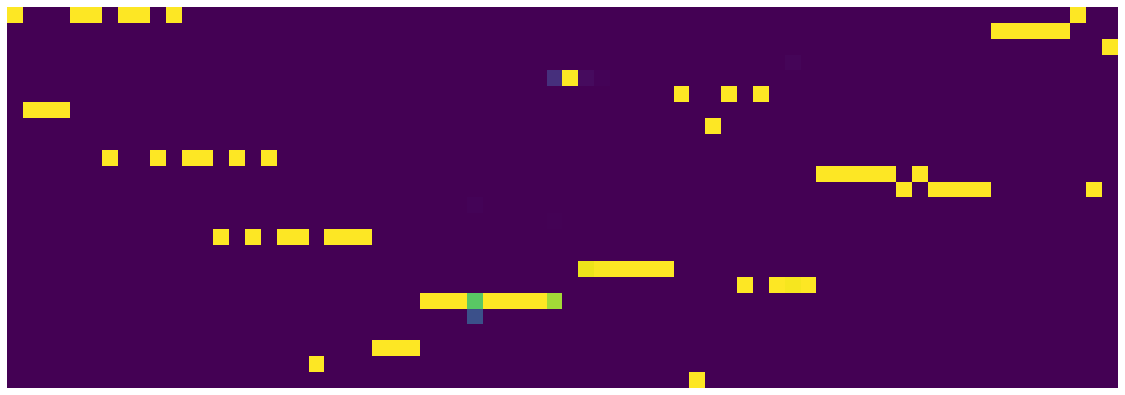

24 345 0.6539999999999997 0.4150630673393607


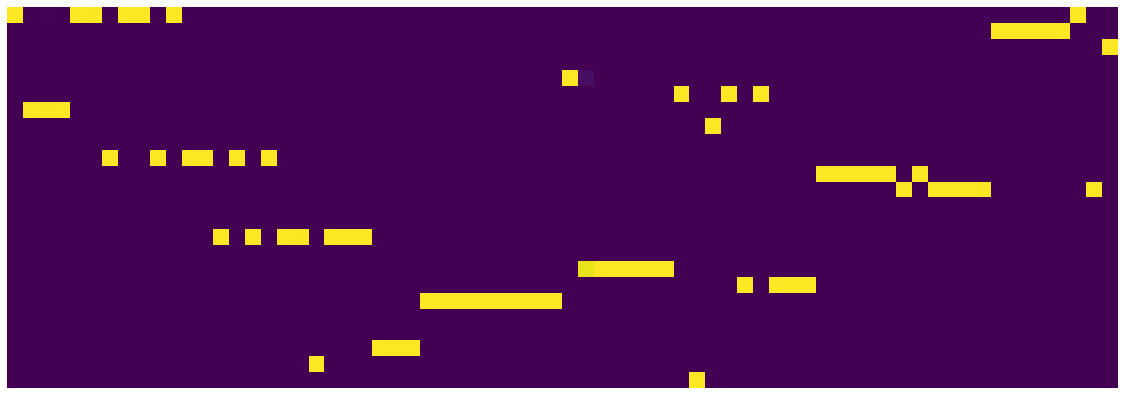

24 346 0.6529999999999997 0.40468476582318547


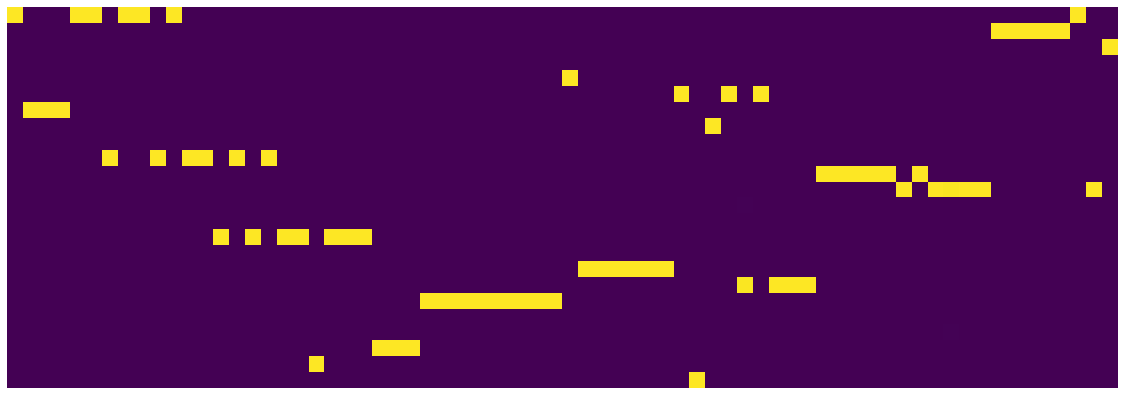

24 347 0.6519999999999997 0.409220580663532


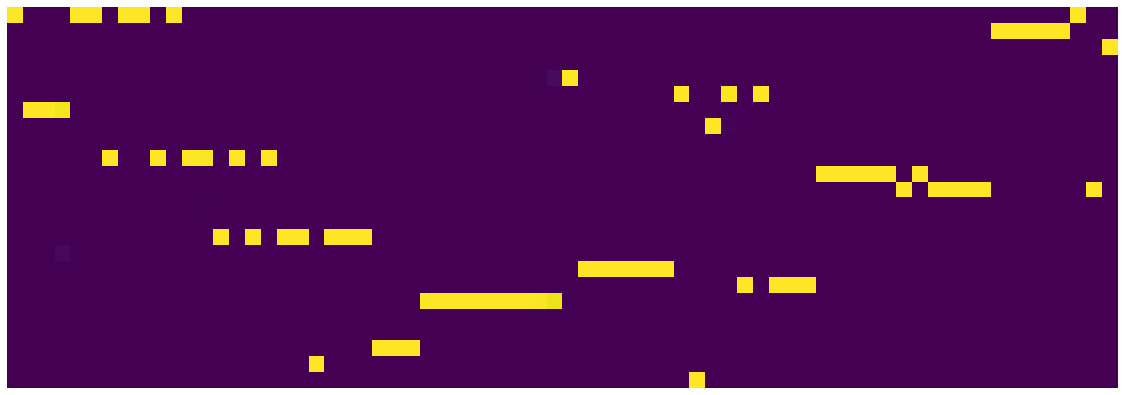

24 348 0.6509999999999997 0.41480972394347193


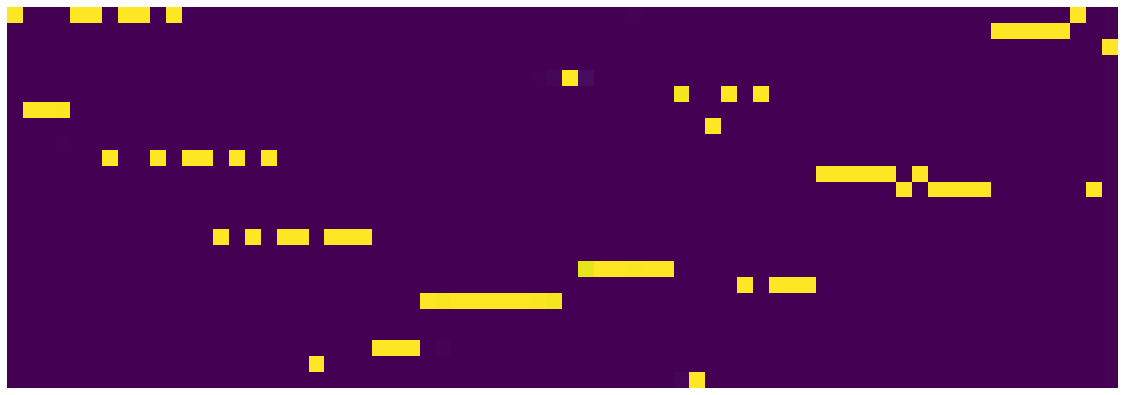

24 349 0.6499999999999997 0.41165884556248783


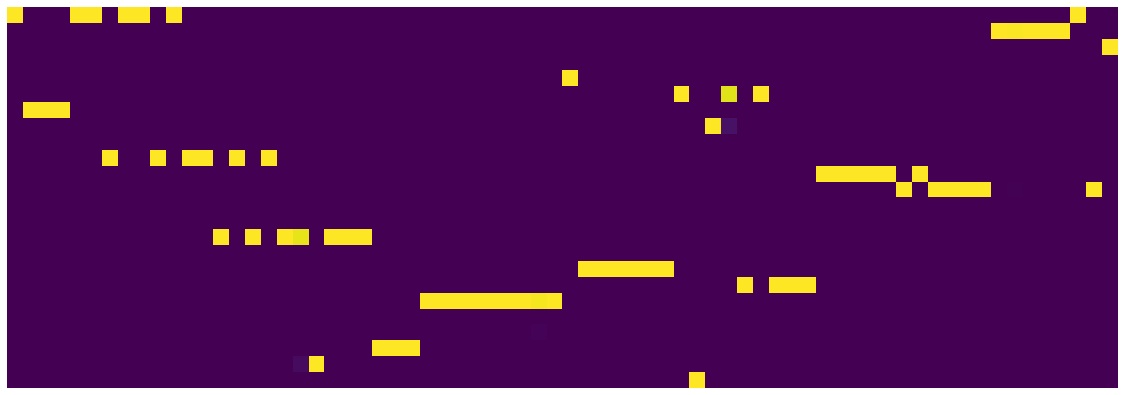

24 350 0.6489999999999997 0.409556916449219


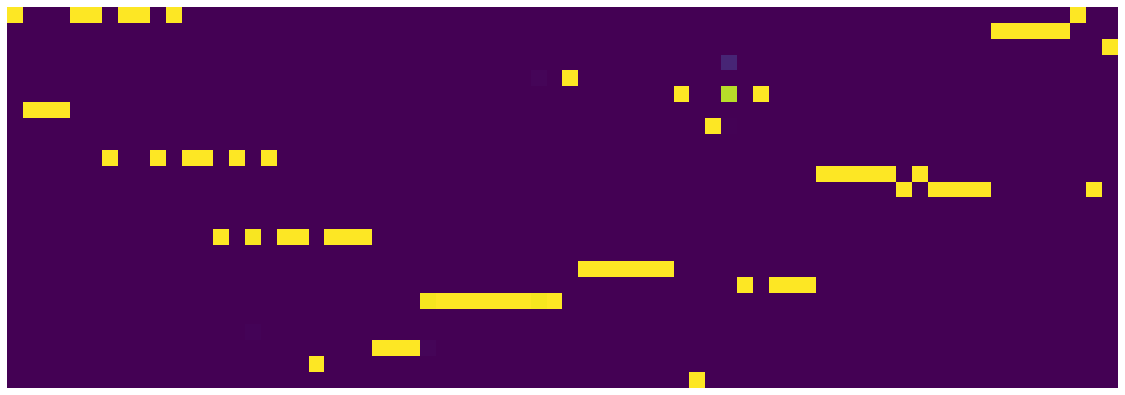

24 351 0.6479999999999997 0.4230398012325168


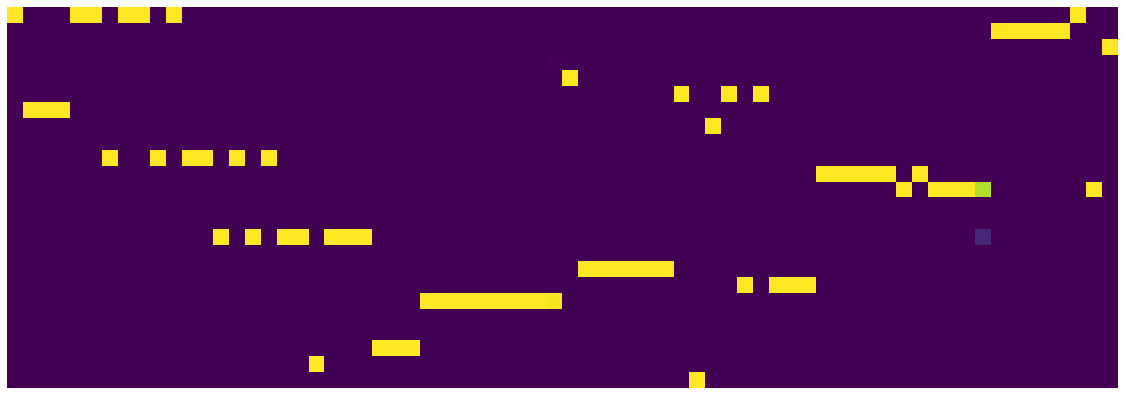

24 352 0.6469999999999997 0.40365064824


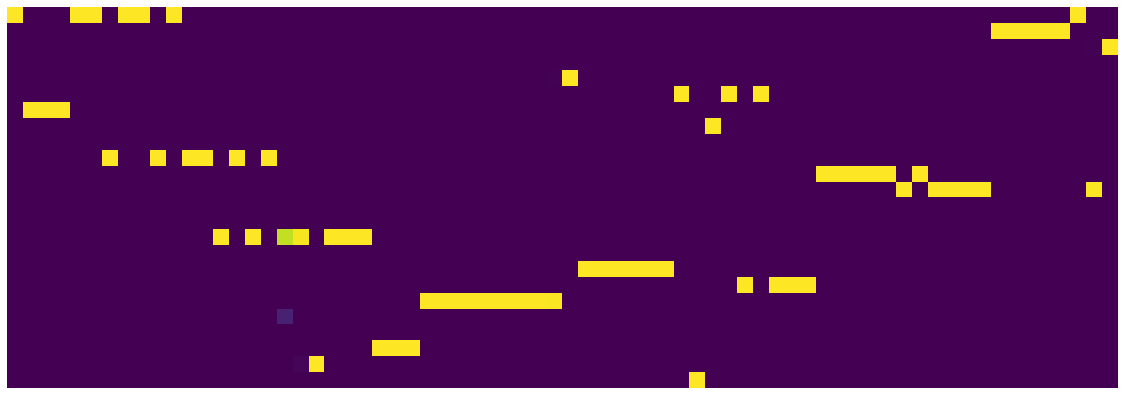

24 353 0.6459999999999997 0.4136001762002707


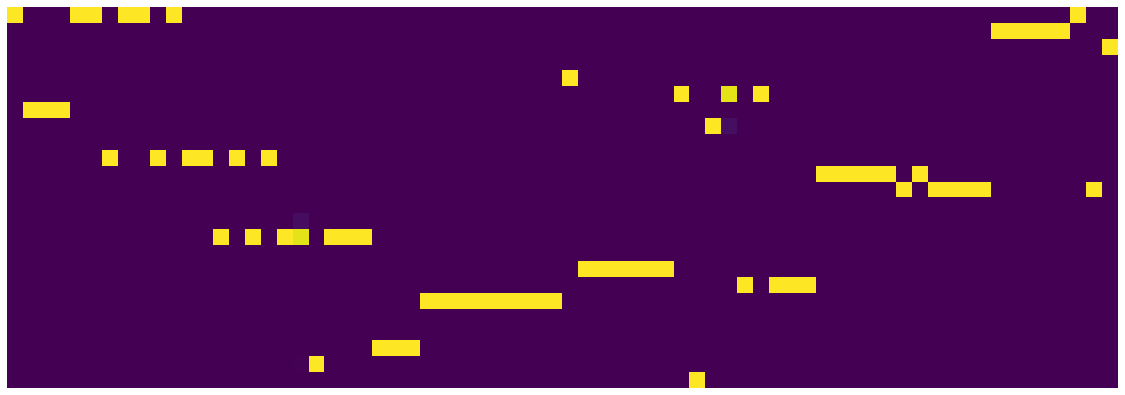

24 354 0.6449999999999997 0.44807694451883434


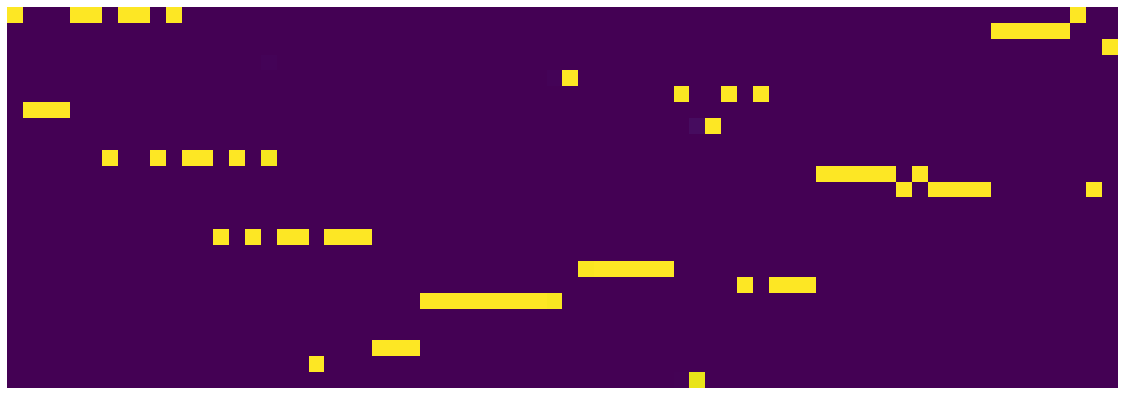

24 355 0.6439999999999997 0.4063314892351627


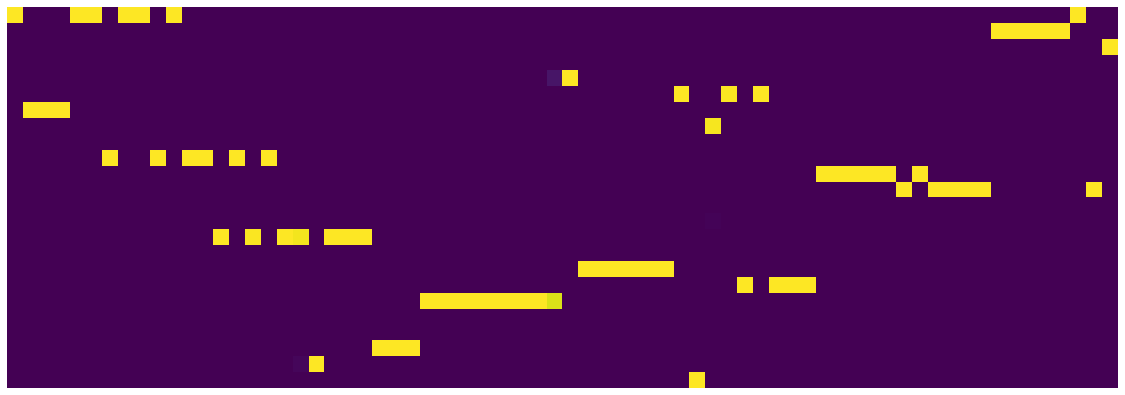

24 356 0.6429999999999997 0.4102044392377138


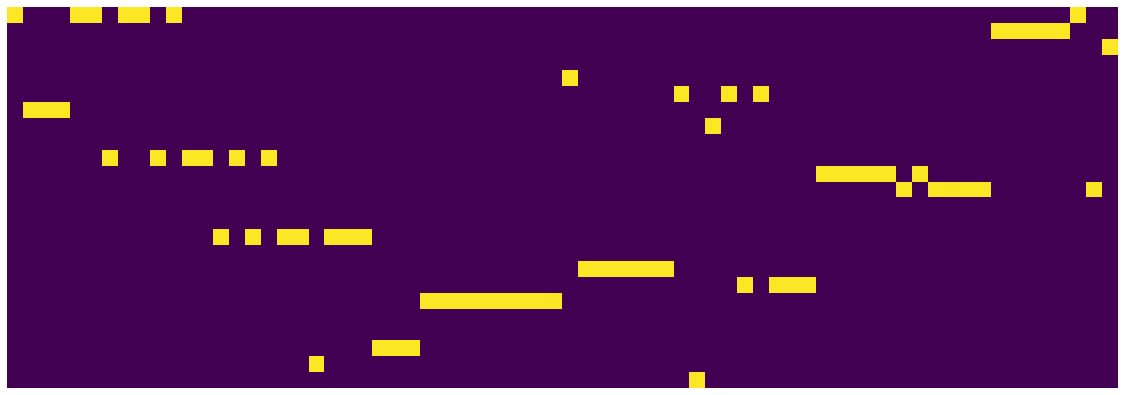

24 357 0.6419999999999997 0.4247037266381085


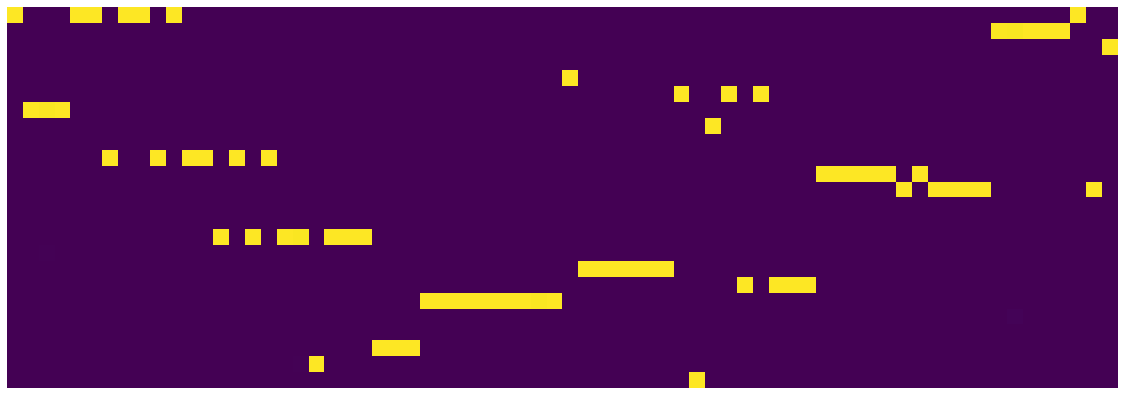

24 358 0.6409999999999997 0.41977205453440547


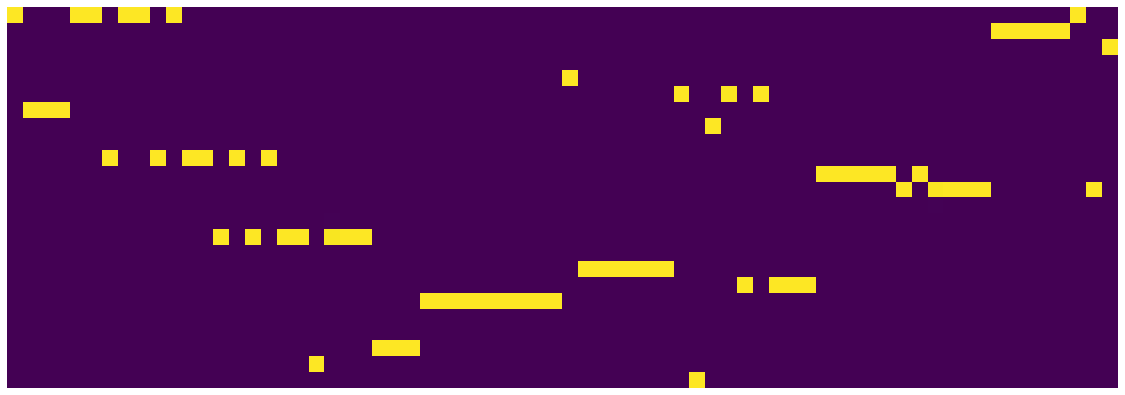

24 359 0.6399999999999997 0.41670847665518523


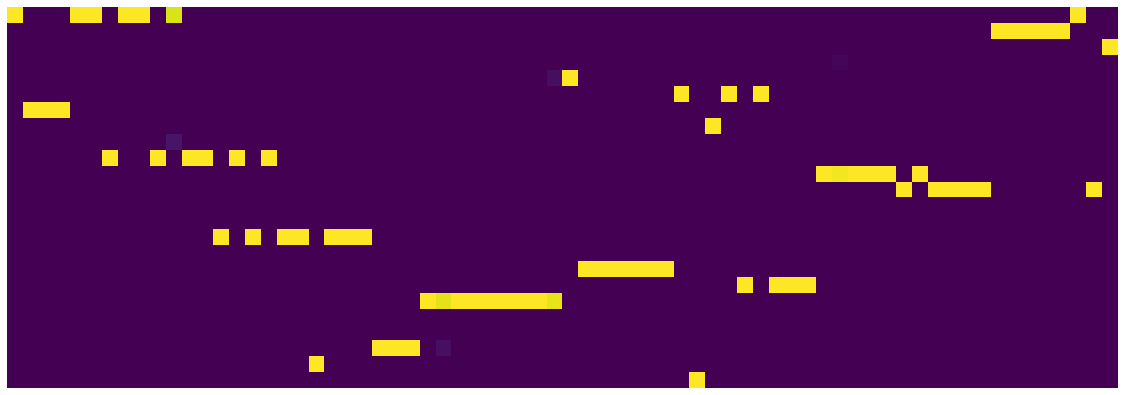

24 360 0.6389999999999997 0.4201184672303498


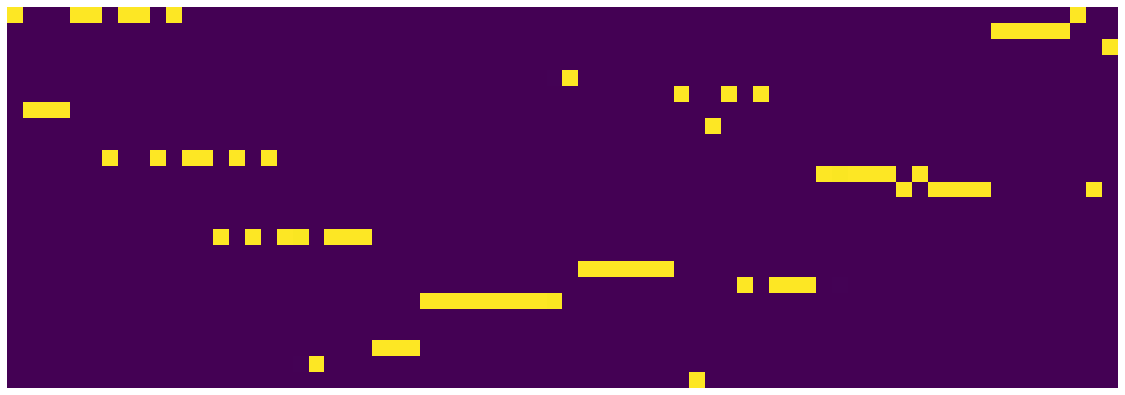

24 361 0.6379999999999997 0.40672130789607763


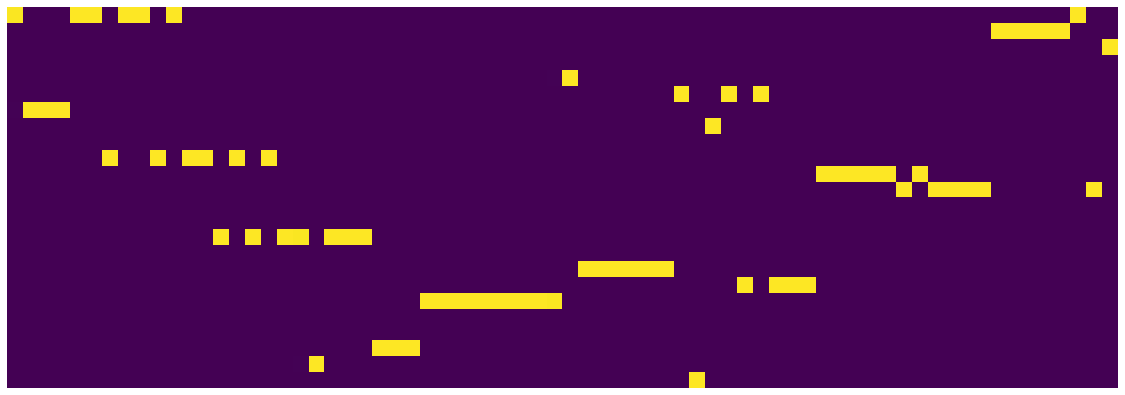

24 362 0.6369999999999997 0.4072810161858797


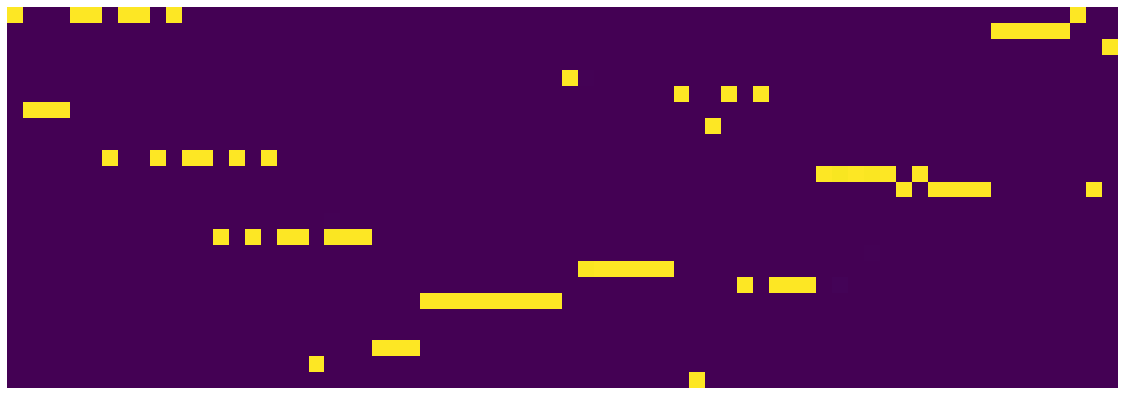

24 363 0.6359999999999997 0.43877211706712843


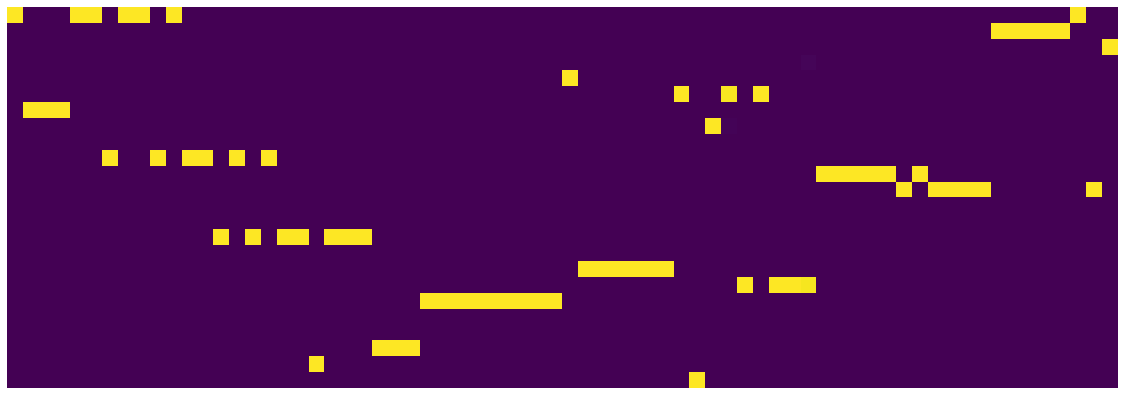

24 364 0.6349999999999997 0.40794736659154296


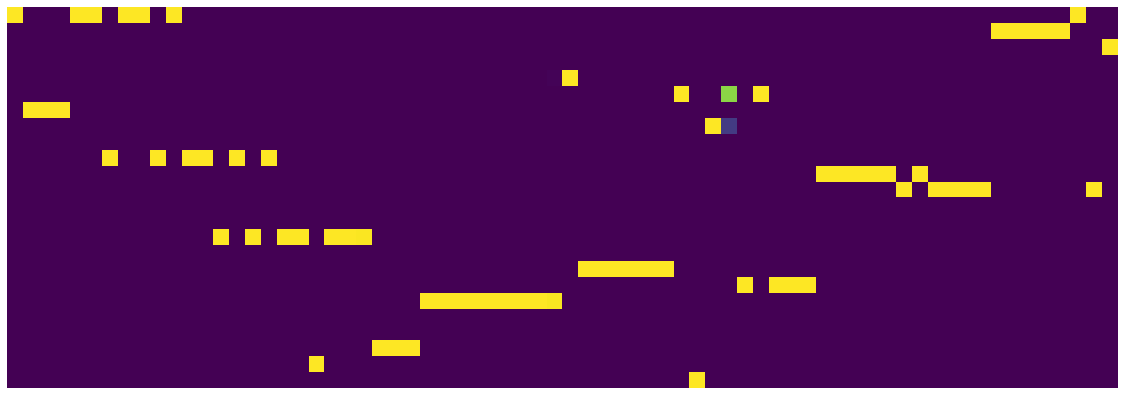

24 365 0.6339999999999997 0.42532638339325785


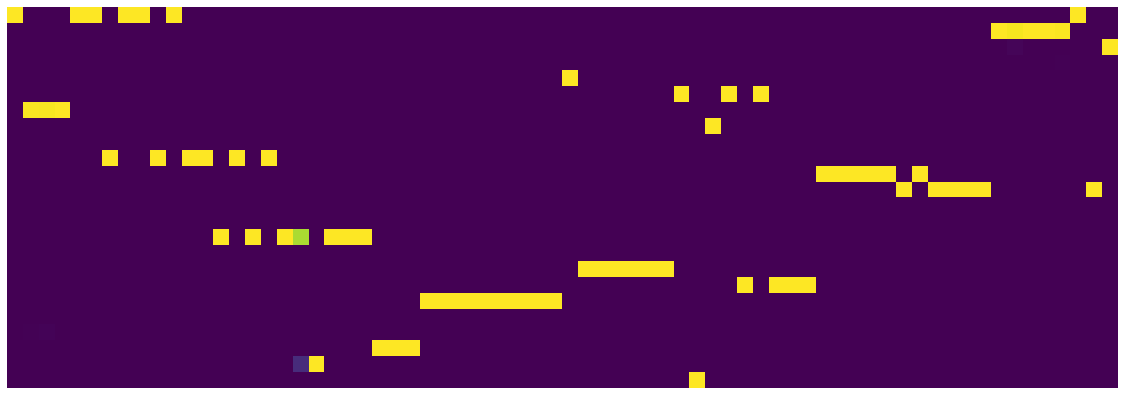

24 366 0.6329999999999997 0.4096109629608691


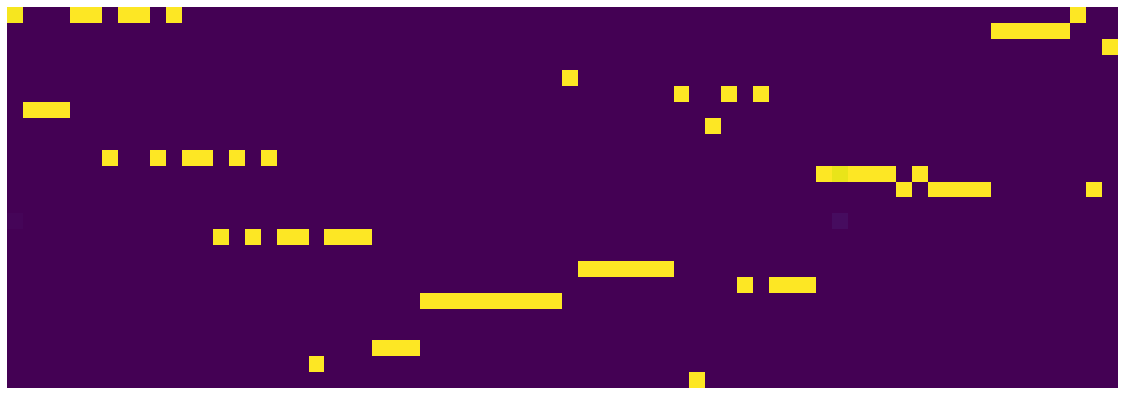

24 367 0.6319999999999997 0.41341997534036634


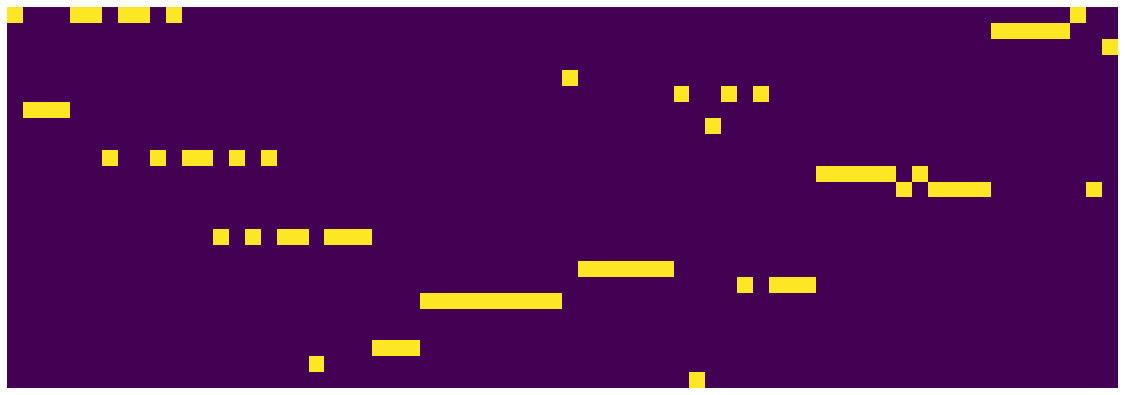

24 368 0.6309999999999997 0.40660621896386145


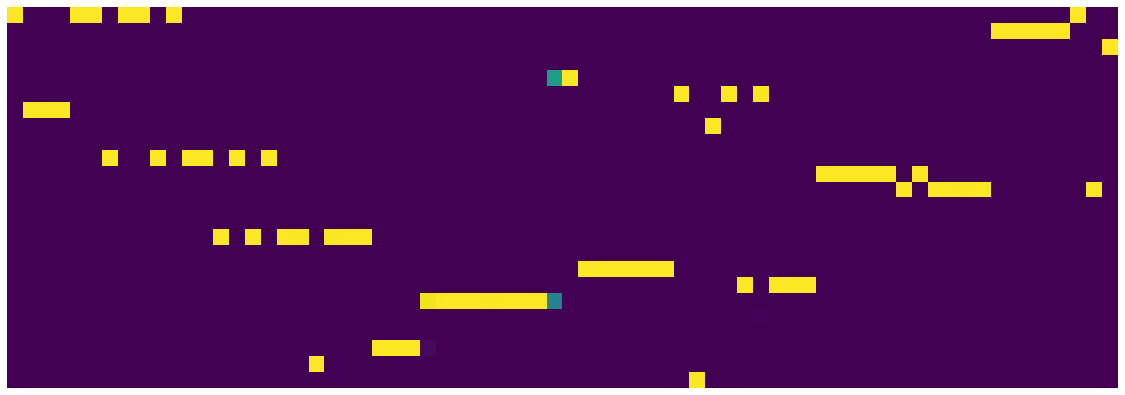

24 369 0.6299999999999997 0.40933088809251783


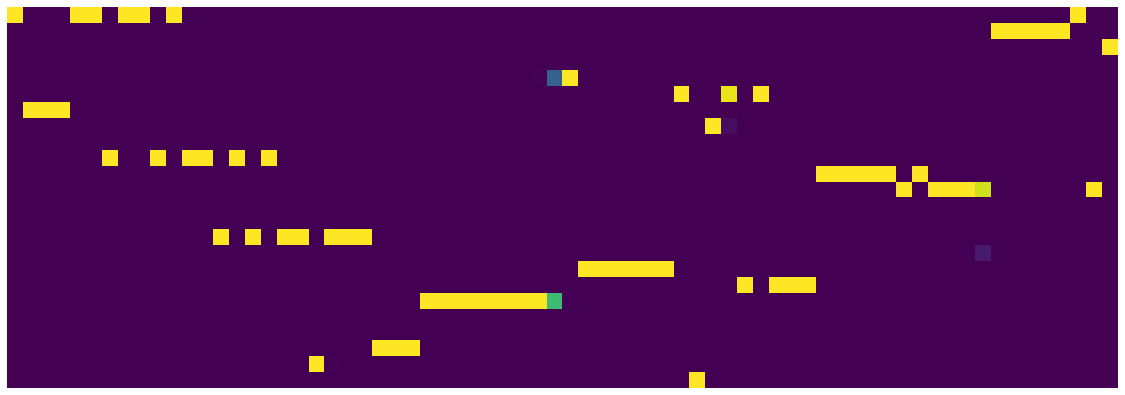

24 370 0.6289999999999997 0.41654217038303615


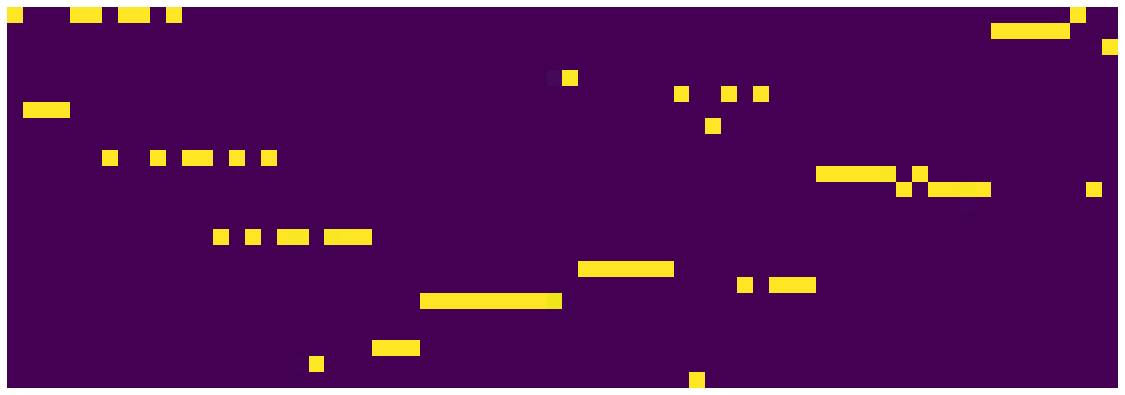

24 371 0.6279999999999997 0.4082374548539519


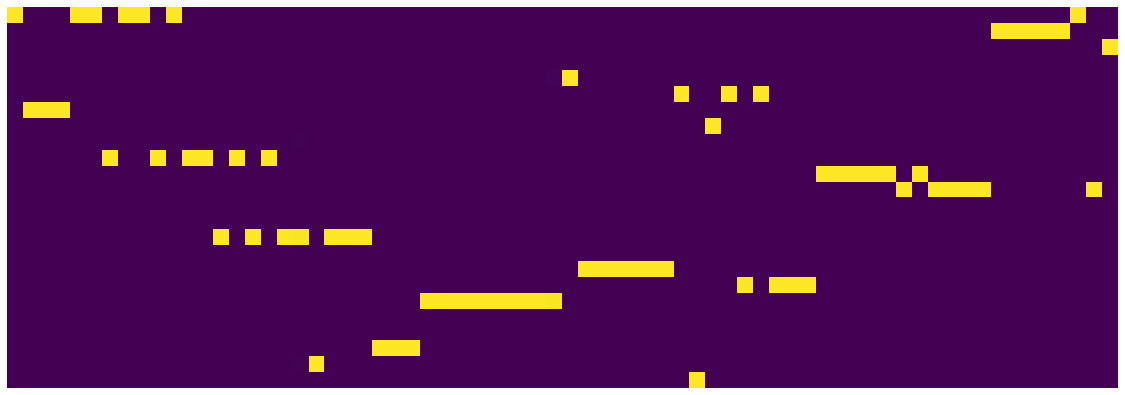

24 372 0.6269999999999997 0.41375705432146787


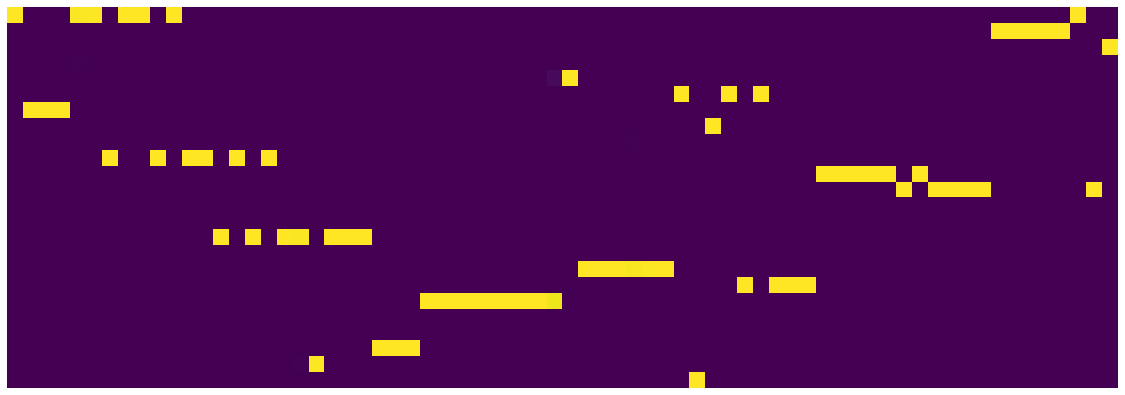

24 373 0.6259999999999997 0.4136532640084624


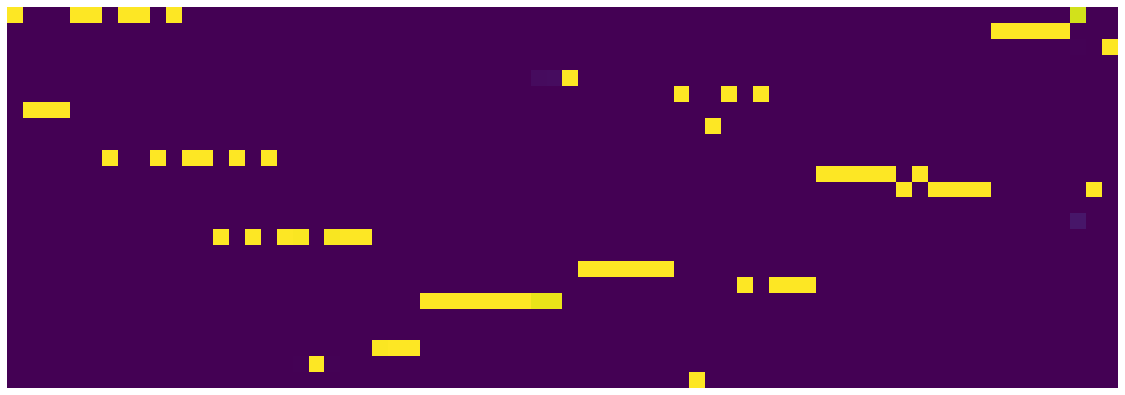

24 374 0.6249999999999997 0.41480684019625186


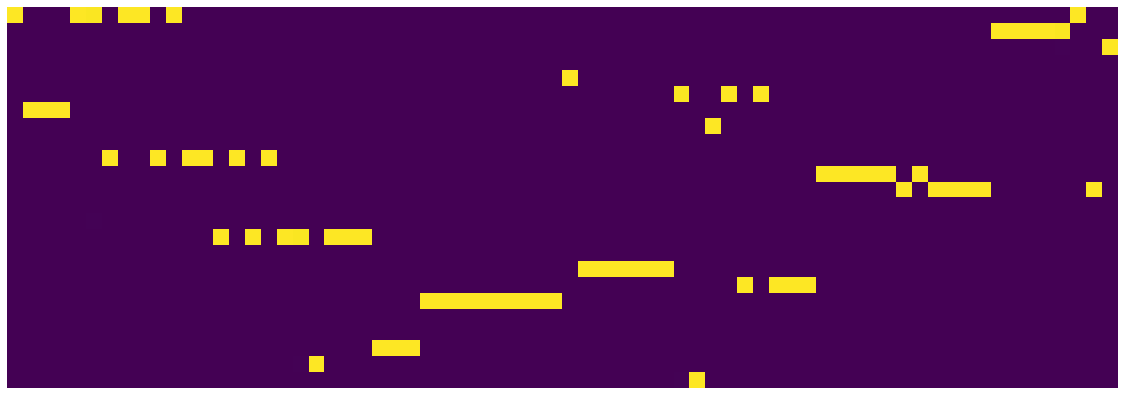

24 375 0.6239999999999997 0.41114693274721503


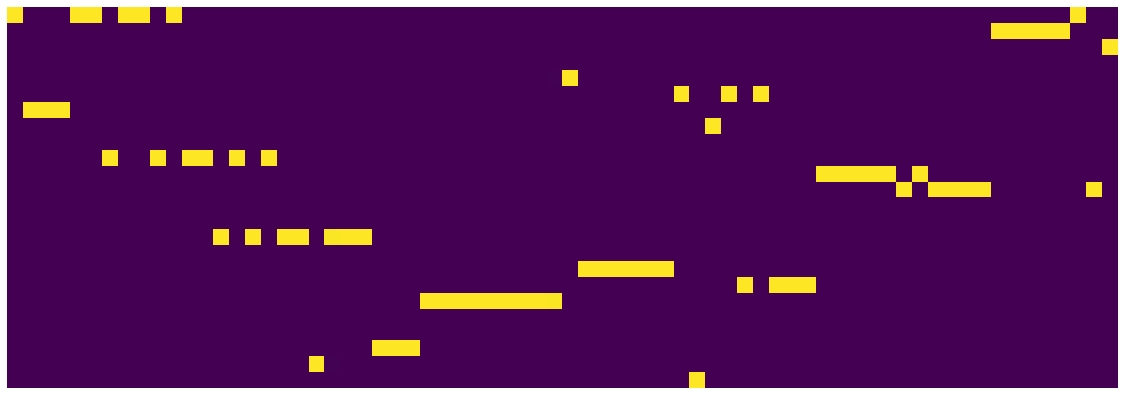

24 376 0.6229999999999997 0.4425827651284635


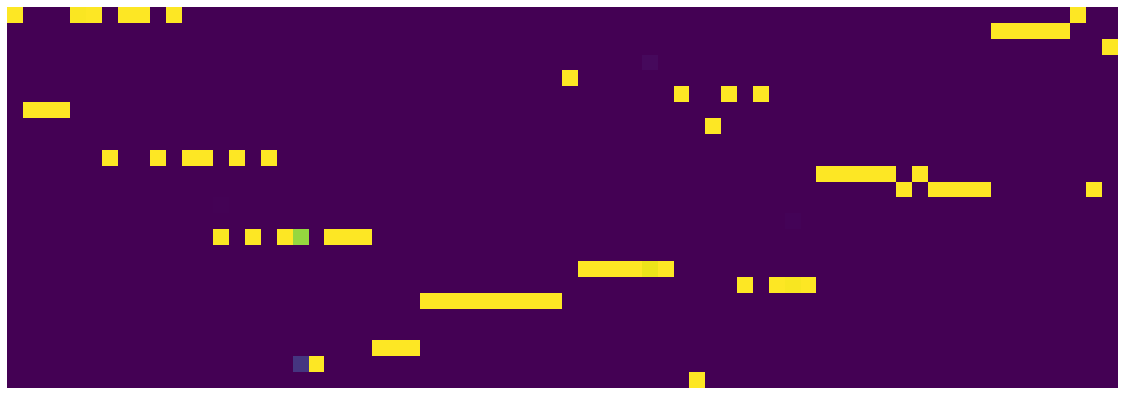

24 377 0.6219999999999997 0.41239410191774367


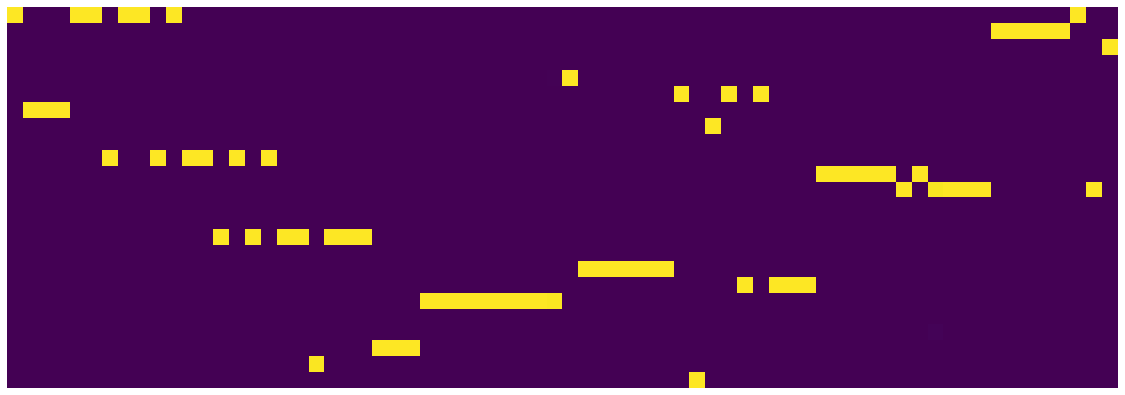

24 378 0.6209999999999997 0.4066253464668989


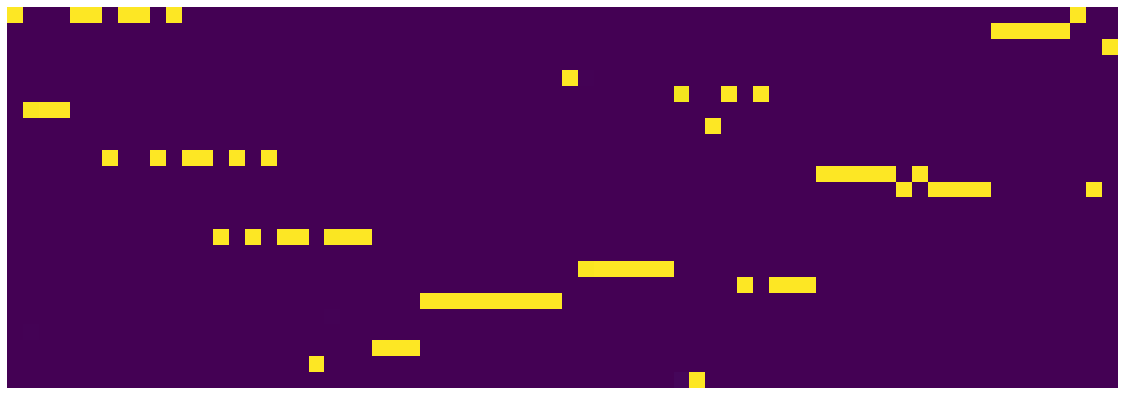

24 379 0.6199999999999997 0.4126586768776178


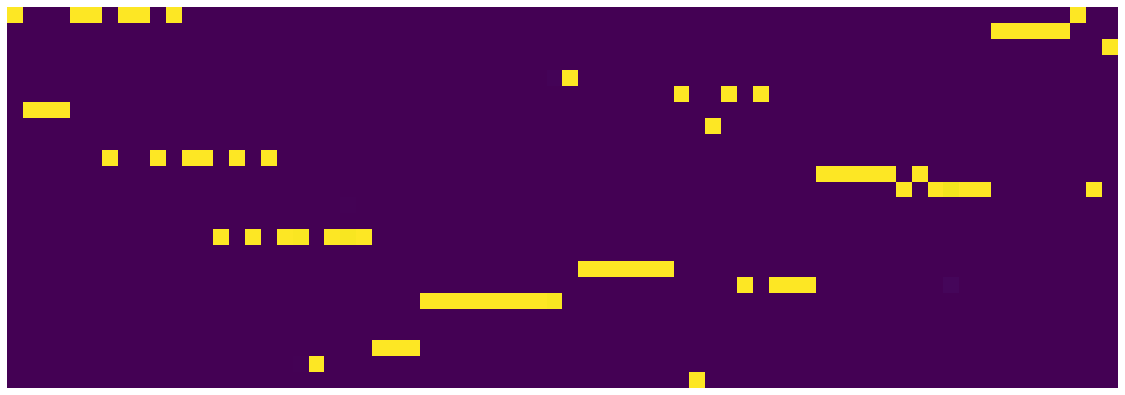

24 380 0.6189999999999997 0.4213639025576413


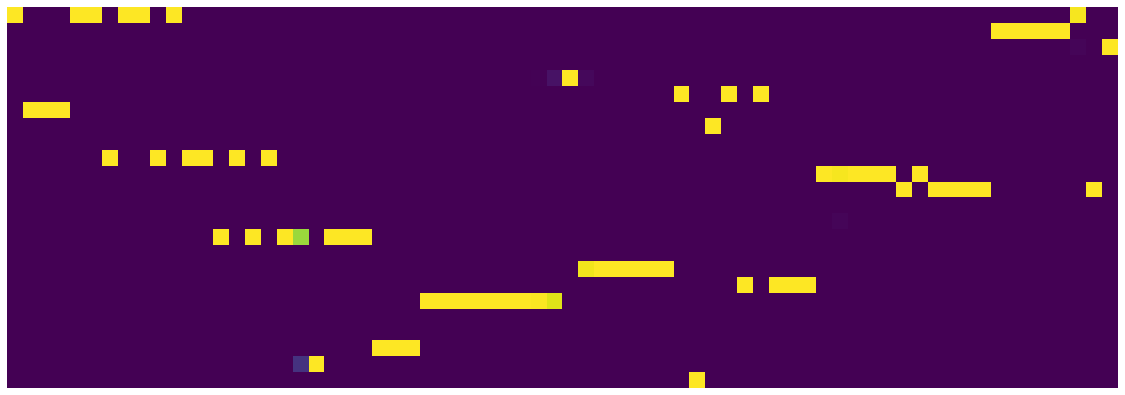

24 381 0.6179999999999997 0.41812948072329165


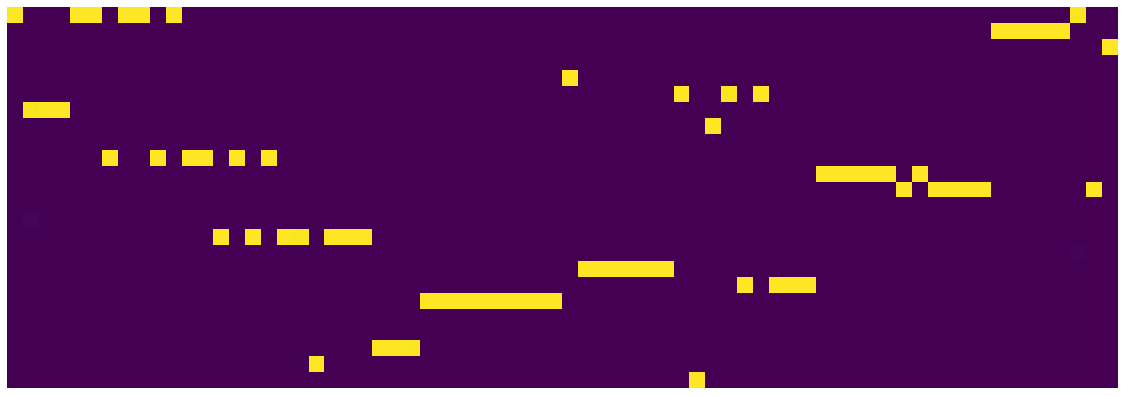

24 382 0.6169999999999997 0.4130545069463551


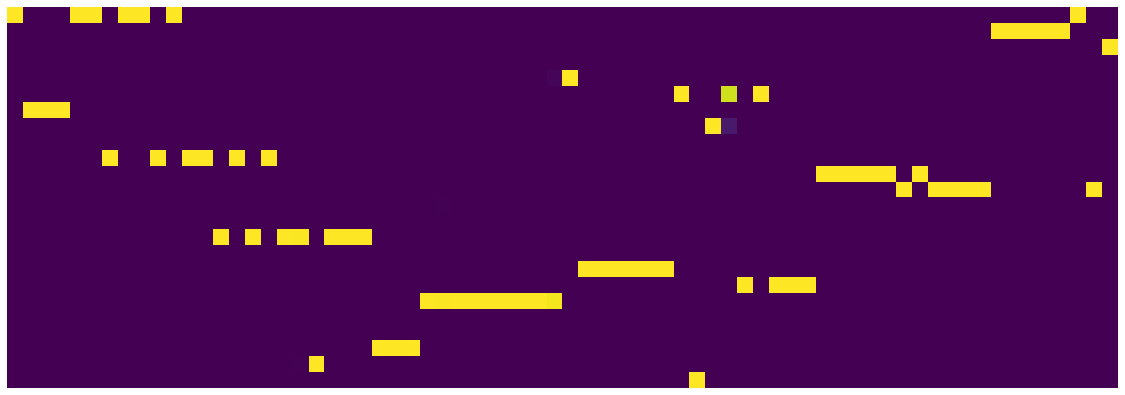

24 383 0.6159999999999997 0.41482256157323716


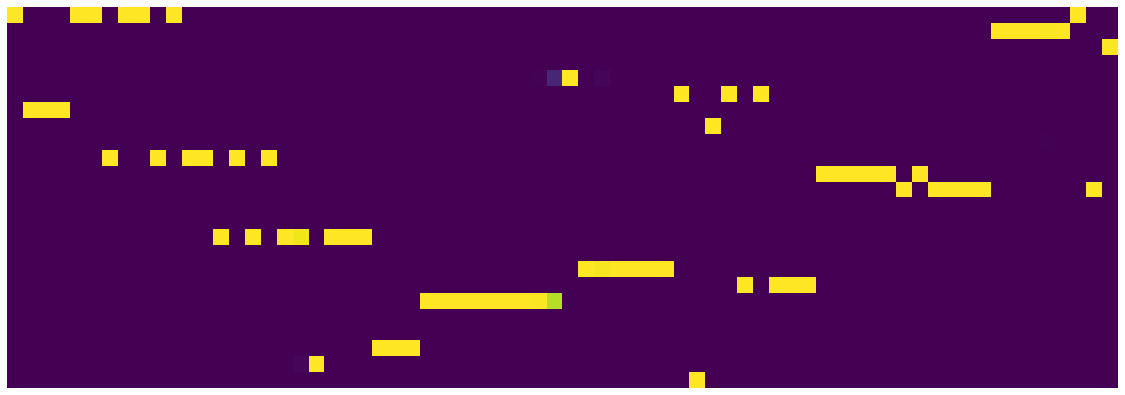

24 384 0.6149999999999997 0.41035133209079505


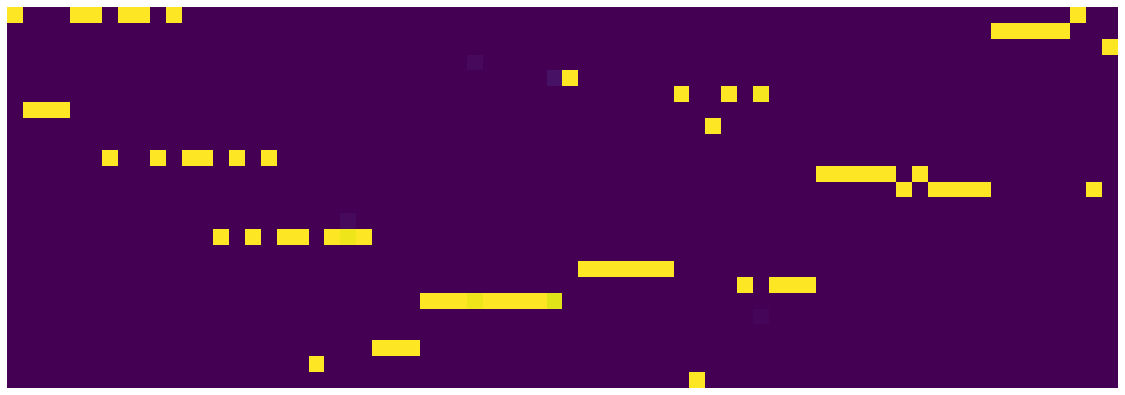

24 385 0.6139999999999997 0.41573524214327334


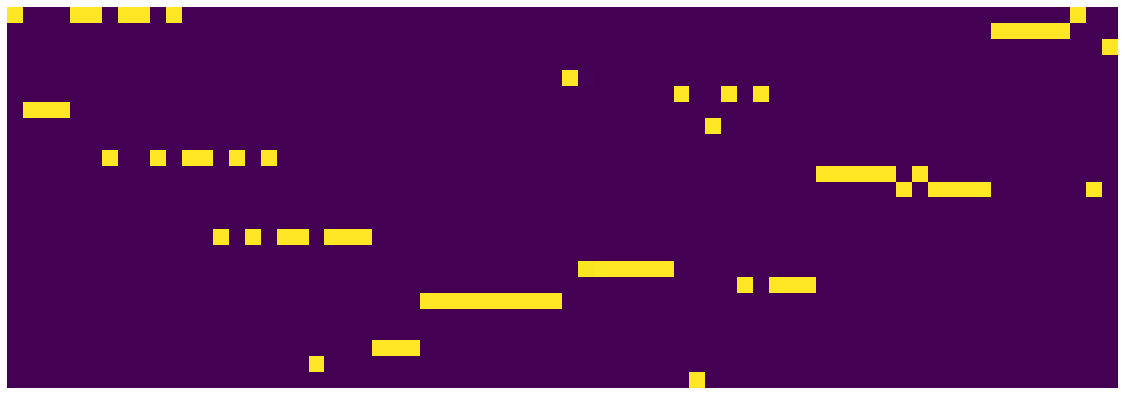

24 386 0.6129999999999997 0.4119617311283946


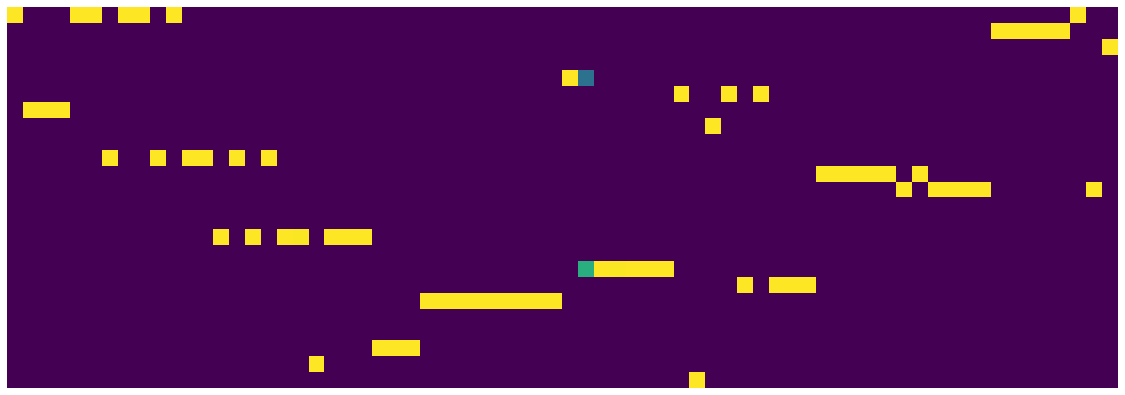

24 387 0.6119999999999997 0.4080242059193552


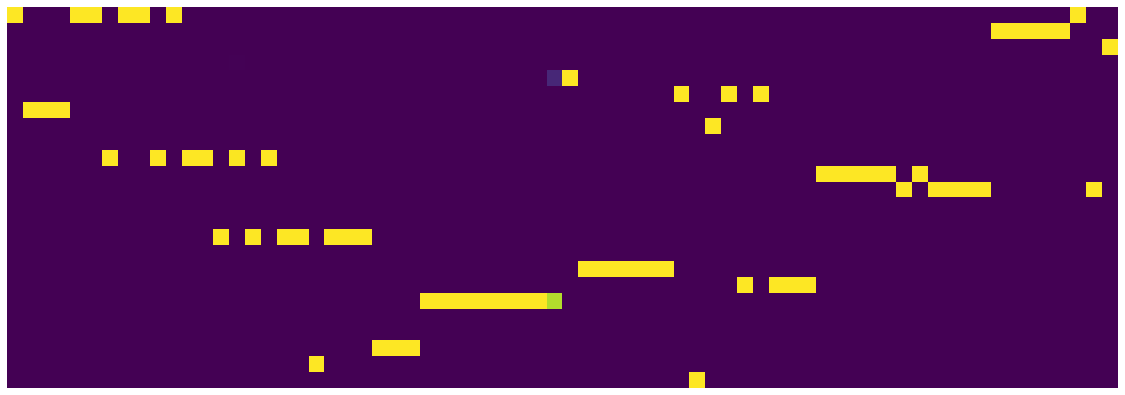

24 388 0.6109999999999997 0.4077456803061068


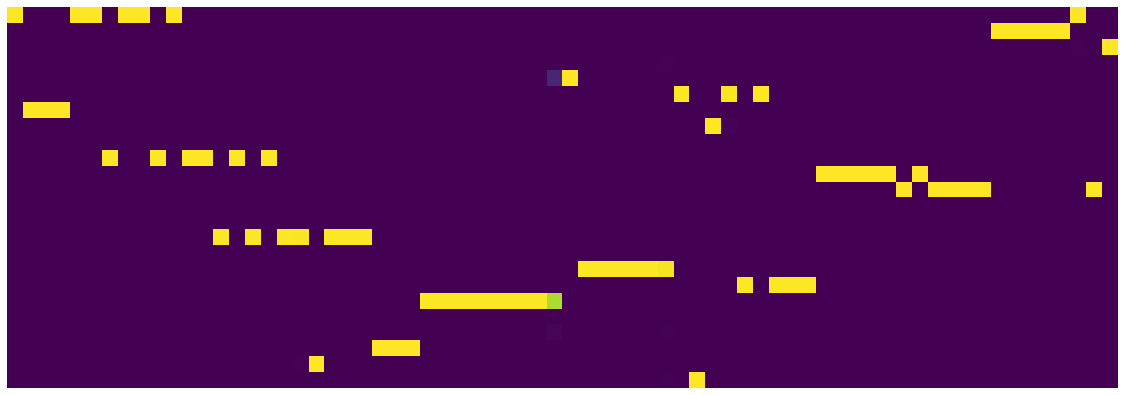

24 389 0.6099999999999997 0.409318502433598


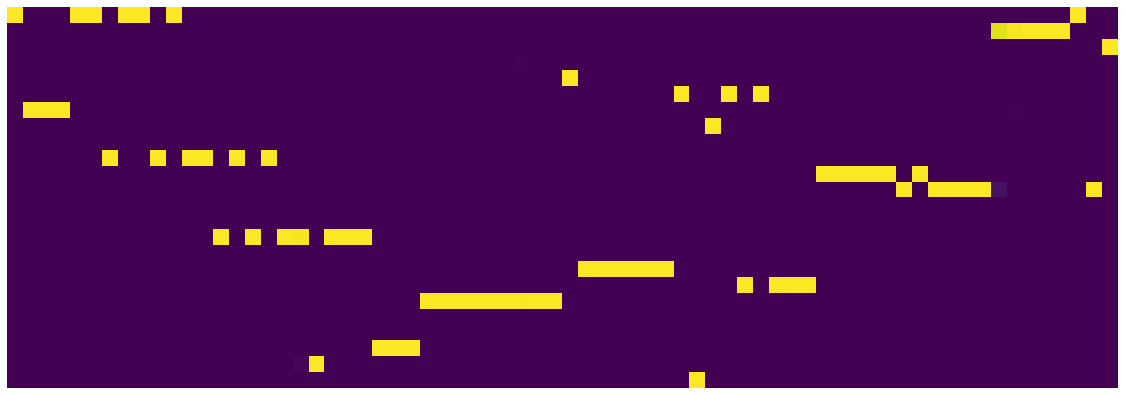

24 390 0.6089999999999997 0.415281486324966


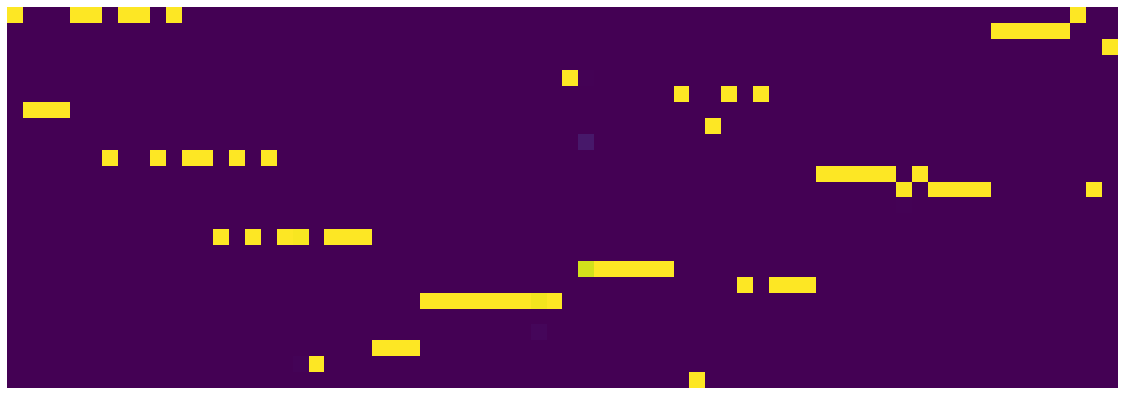

24 391 0.6079999999999997 0.42775385789573195


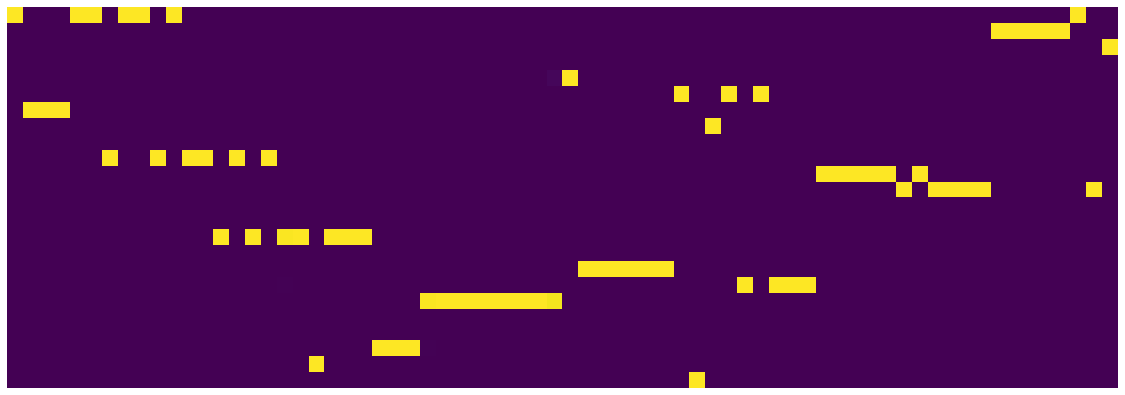

24 392 0.6069999999999997 0.41140596764162185


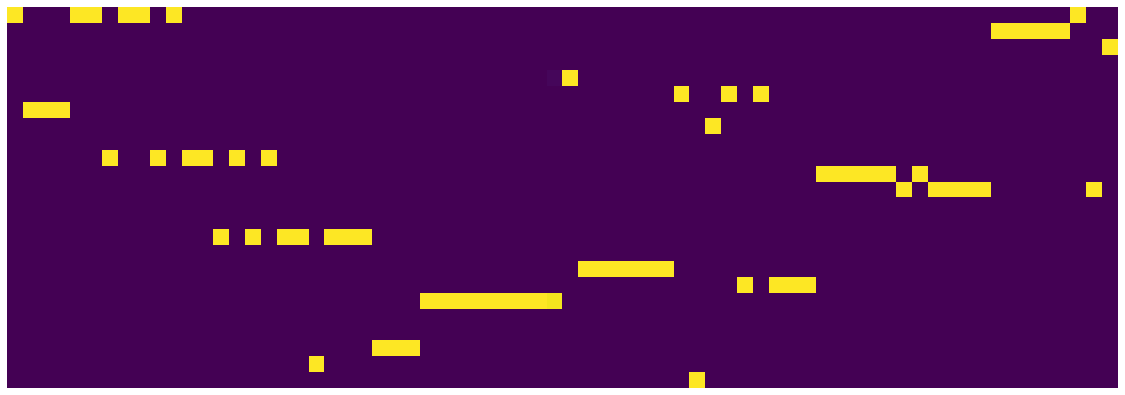

24 393 0.6059999999999997 0.41049664188176394


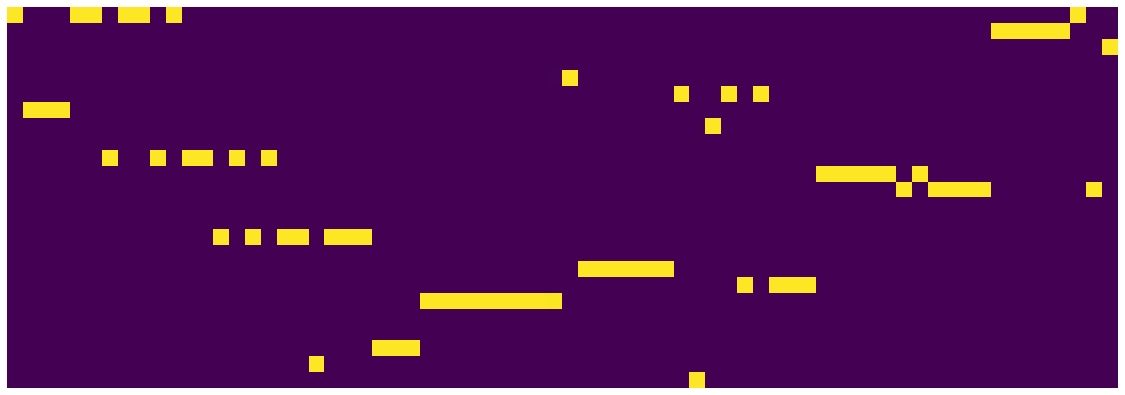

24 394 0.6049999999999996 0.41427652109414337


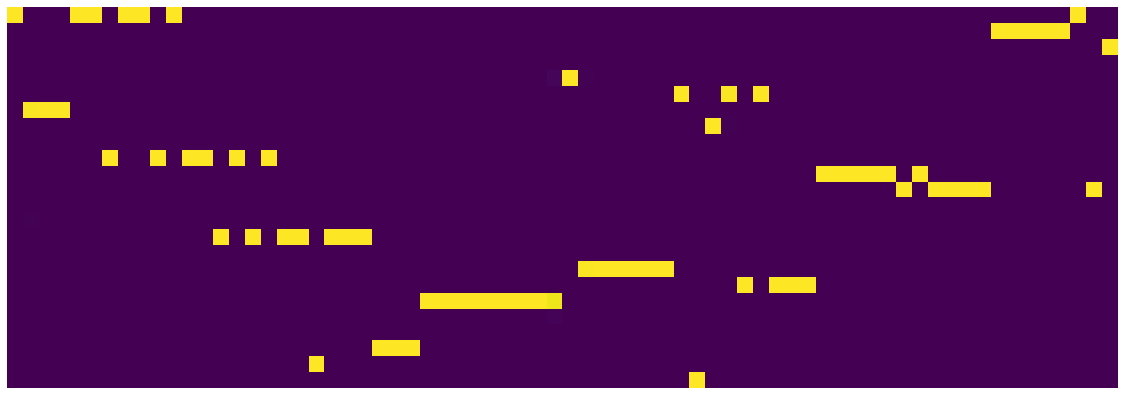

24 395 0.6039999999999996 0.4239764523692429


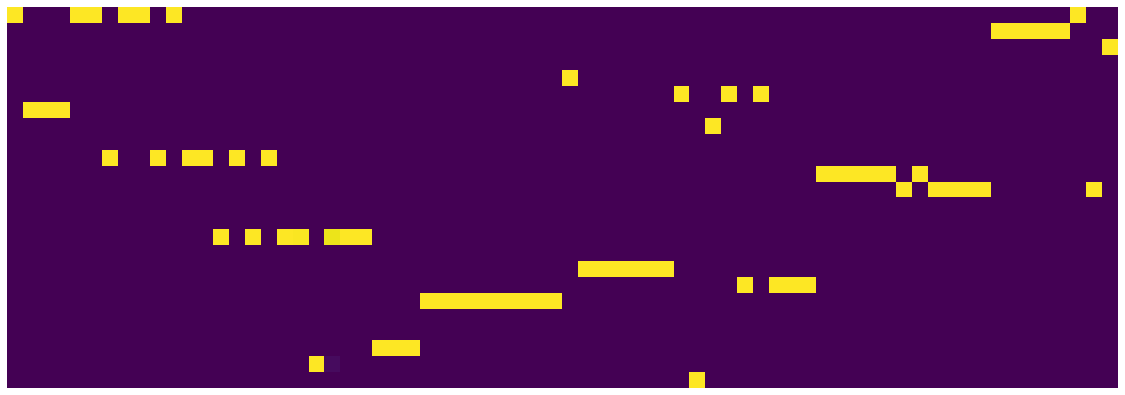

24 396 0.6029999999999996 0.4168356881476939


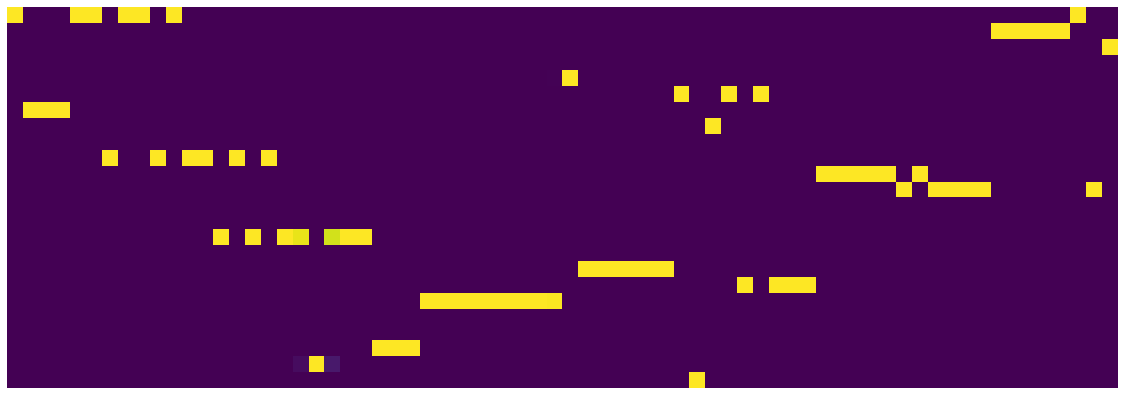

24 397 0.6019999999999996 0.4128821838647127


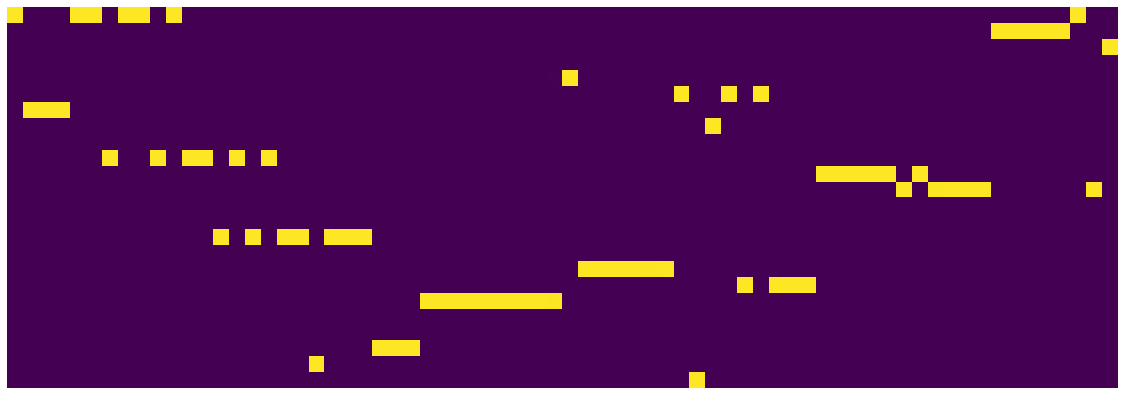

24 398 0.6009999999999996 0.4084297460503876


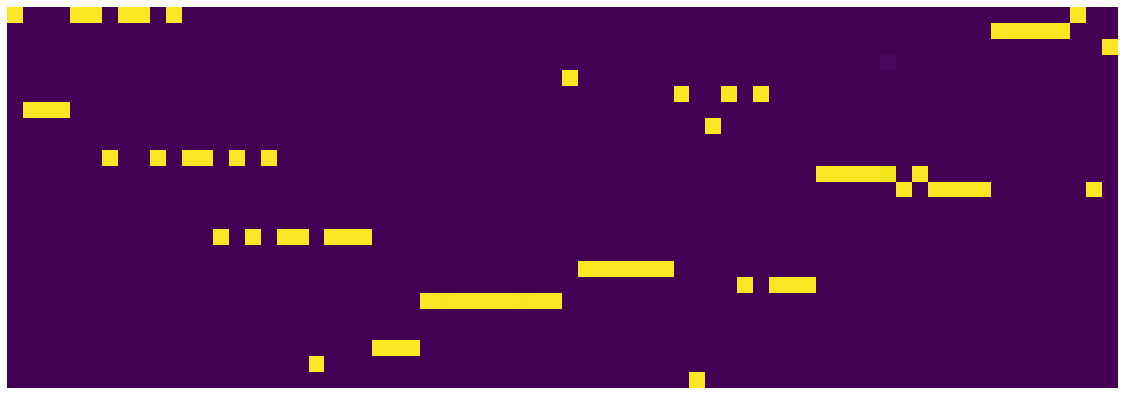

24 399 0.5999999999999996 0.4302119202911854


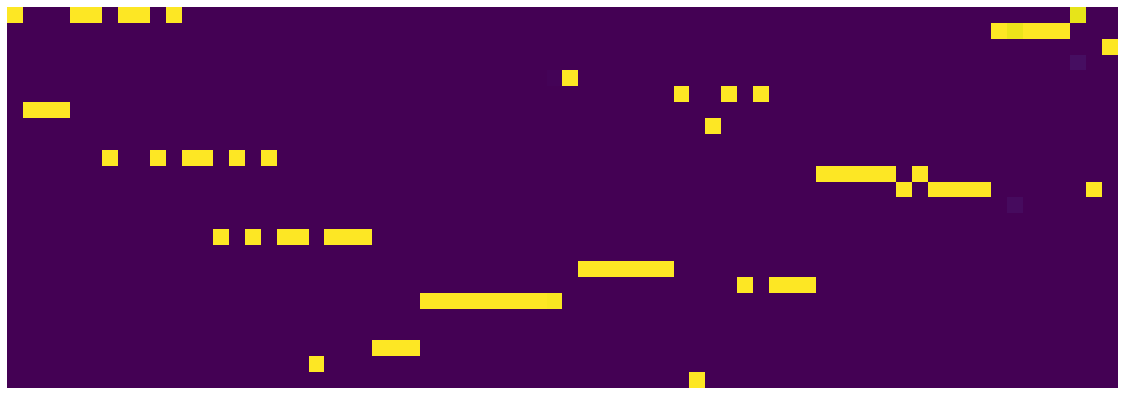

24 400 0.5989999999999996 0.4140367669053376


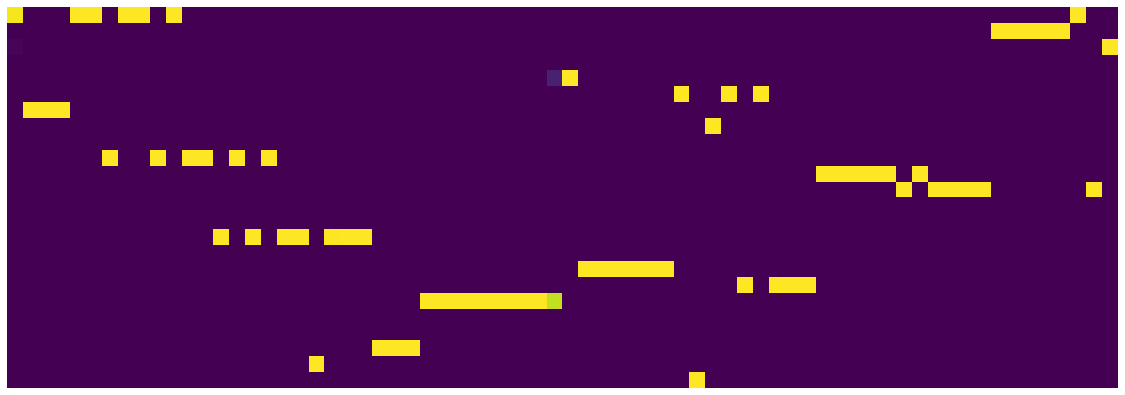

24 401 0.5979999999999996 0.4207564341835678


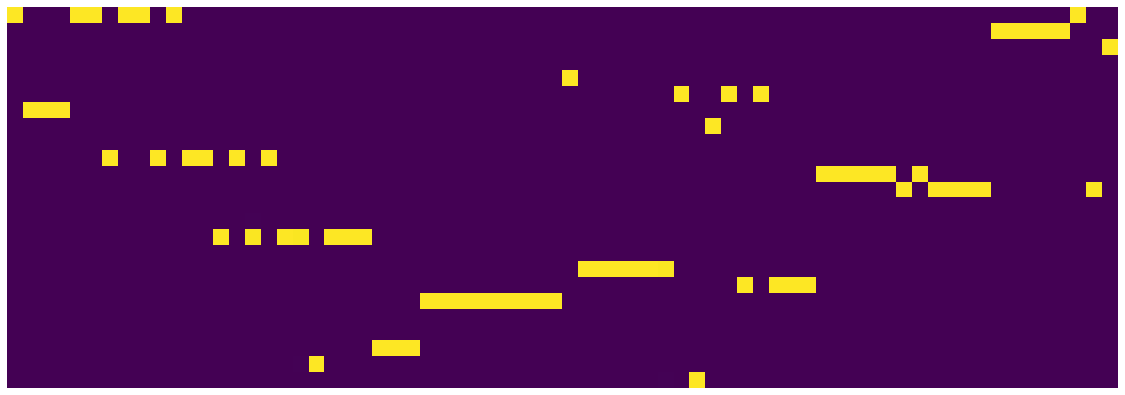

24 402 0.5969999999999996 0.4184325223788619


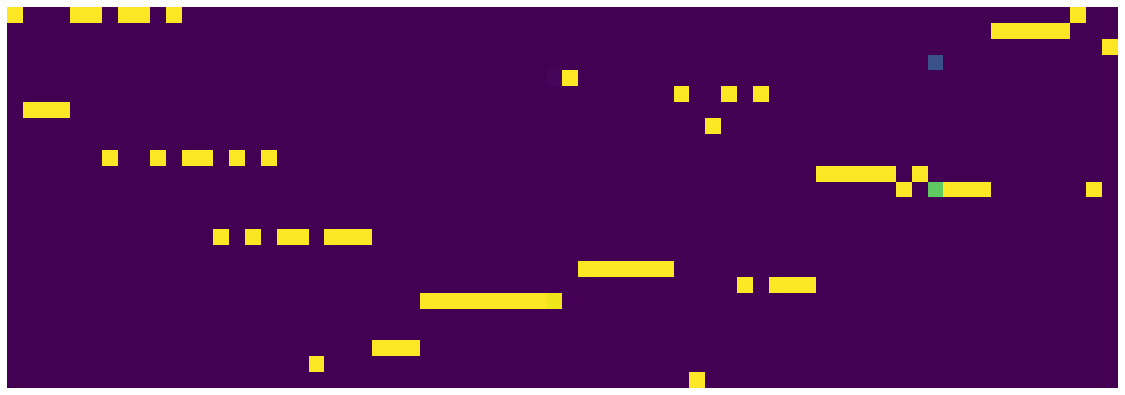

24 403 0.5959999999999996 0.41867477996274827


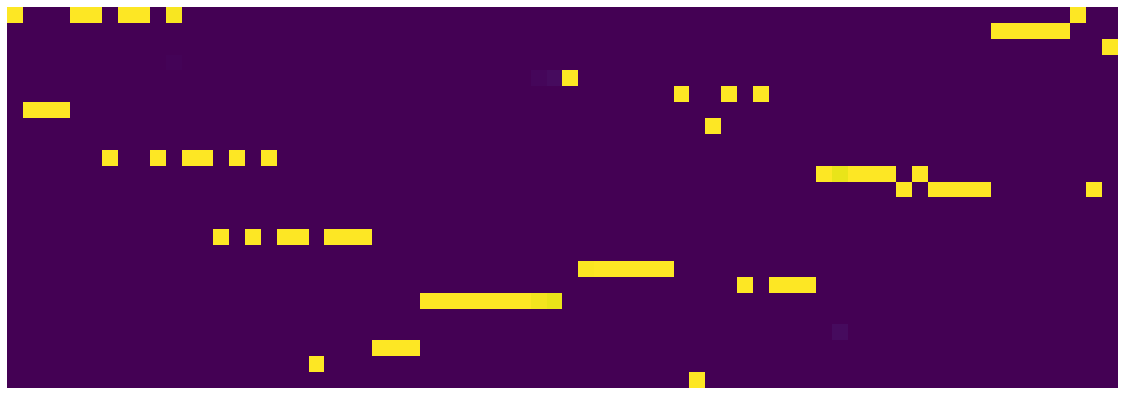

24 404 0.5949999999999996 0.4290135705843568


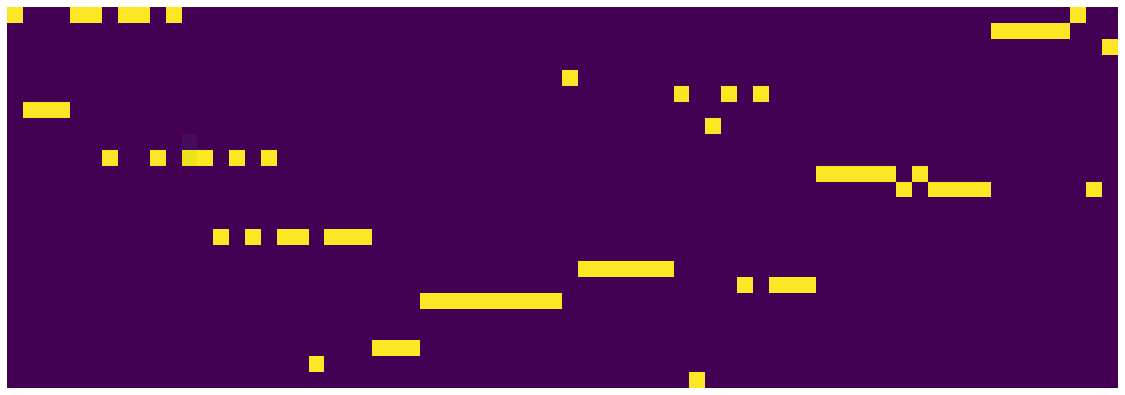

24 405 0.5939999999999996 0.4219470051117241


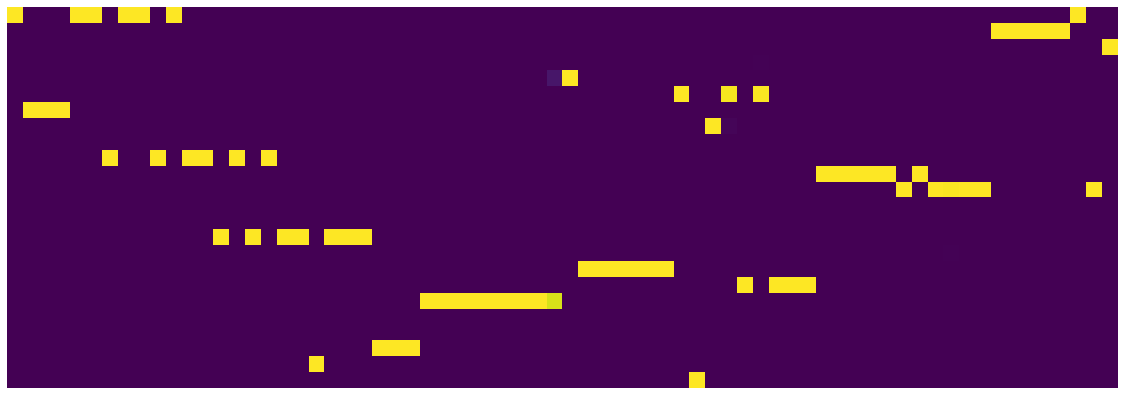

24 406 0.5929999999999996 0.4033002152107656


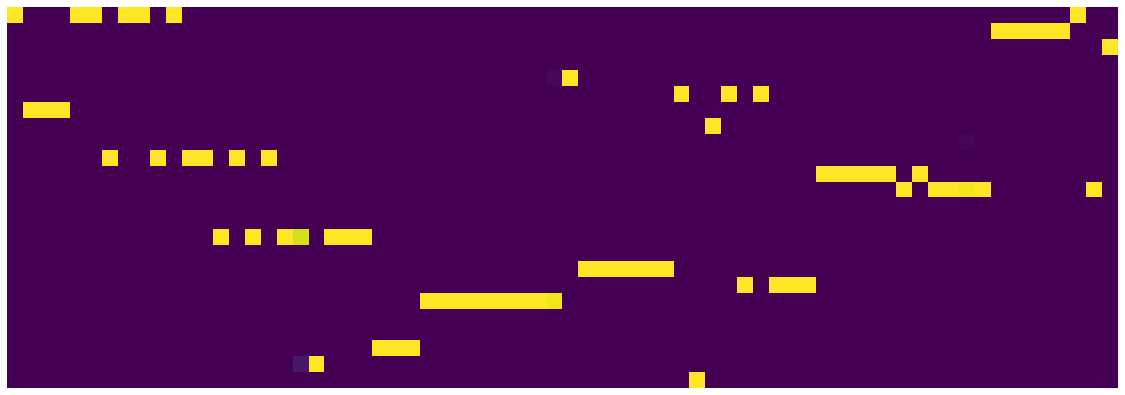

24 407 0.5919999999999996 0.4078519085422158


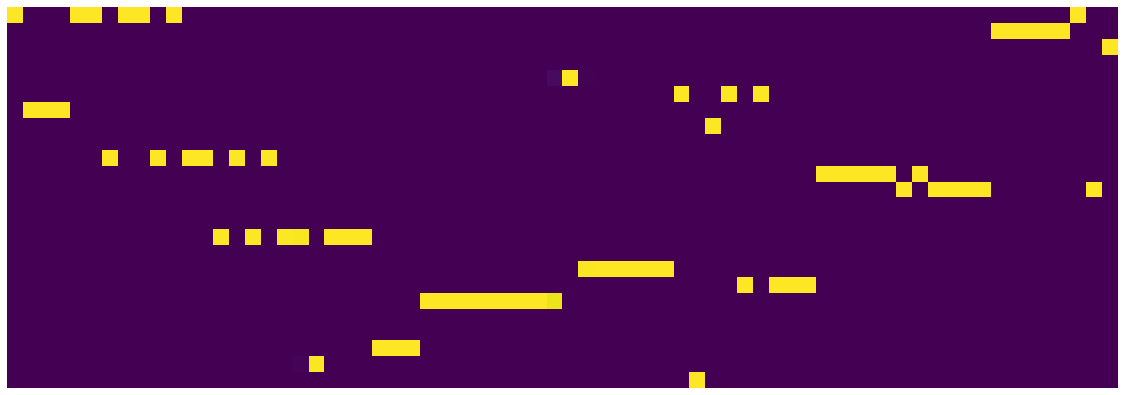

24 408 0.5909999999999996 0.42949494970962404


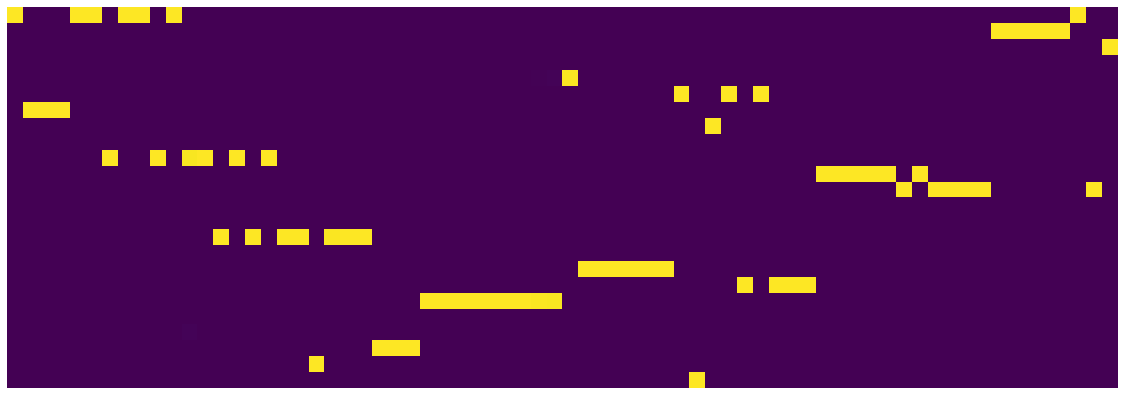

24 409 0.5899999999999996 0.40148374941200016


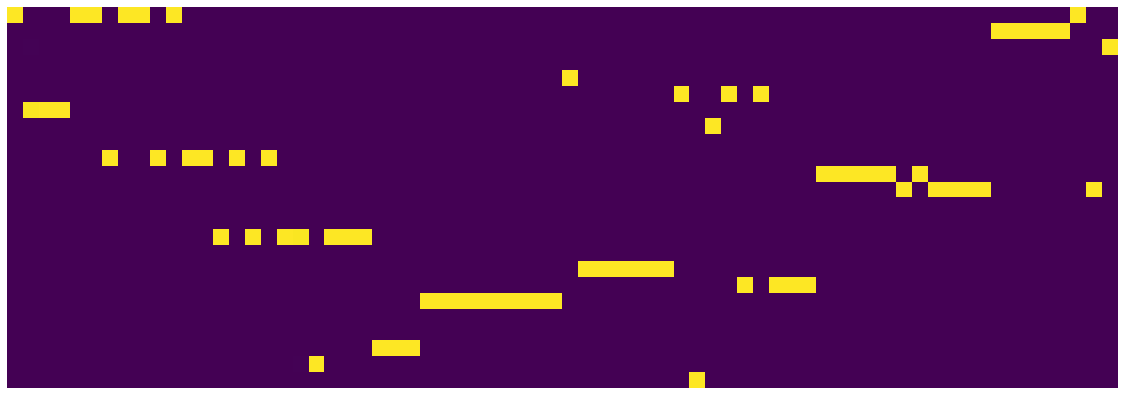

24 410 0.5889999999999996 0.42014351347461343


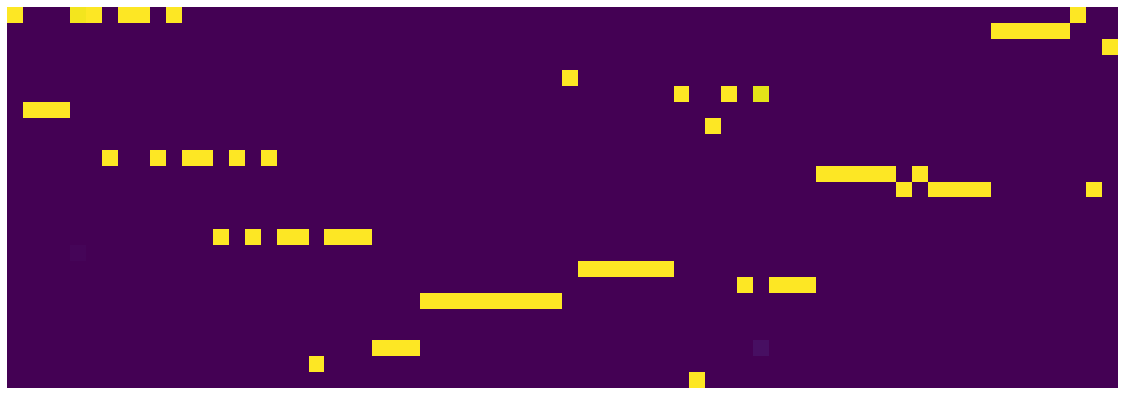

24 411 0.5879999999999996 0.40509713180363177


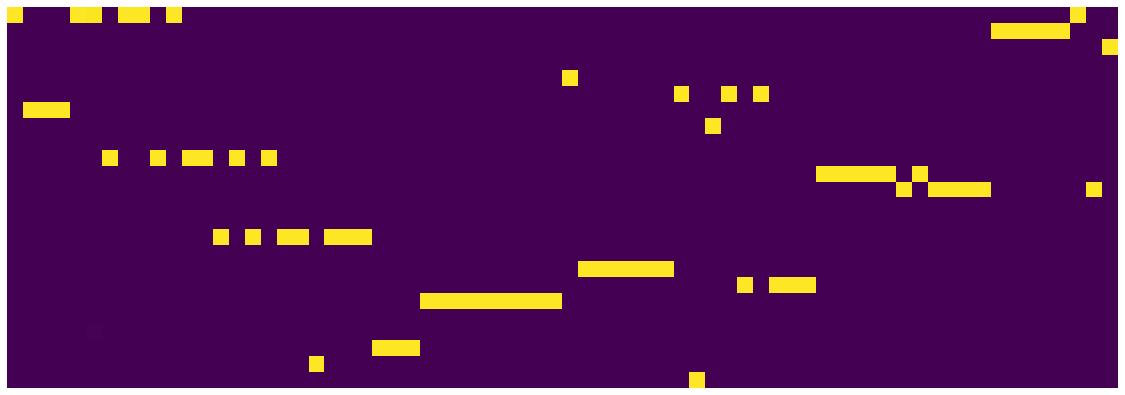

24 412 0.5869999999999996 0.4390579397790134


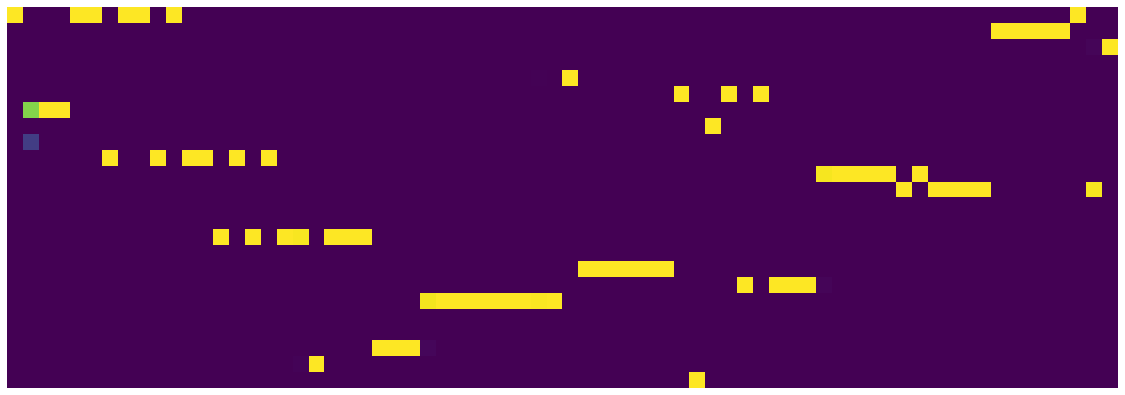

24 413 0.5859999999999996 0.4096439121291041


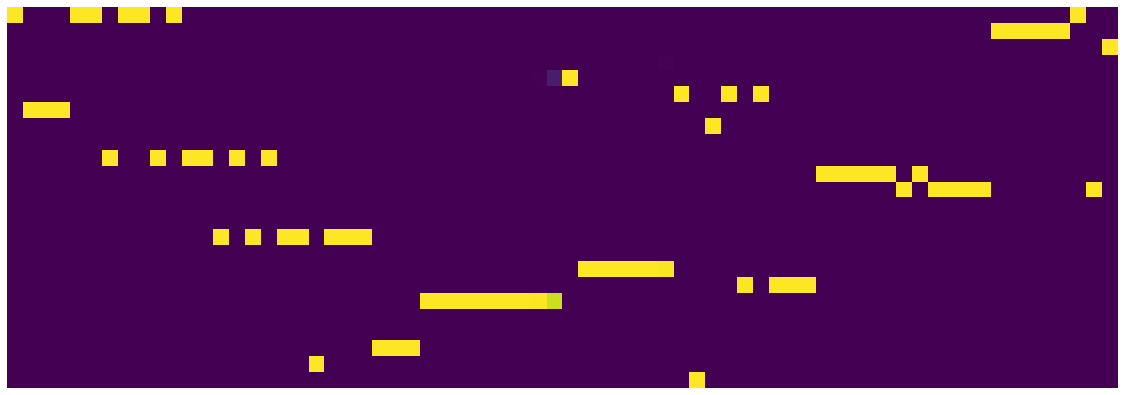

24 414 0.5849999999999996 0.400927085801959


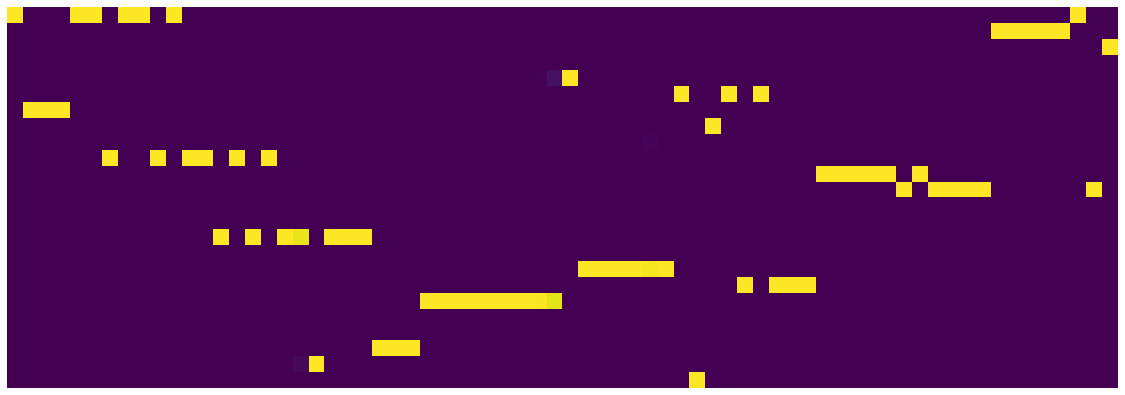

24 415 0.5839999999999996 0.4134786535985768


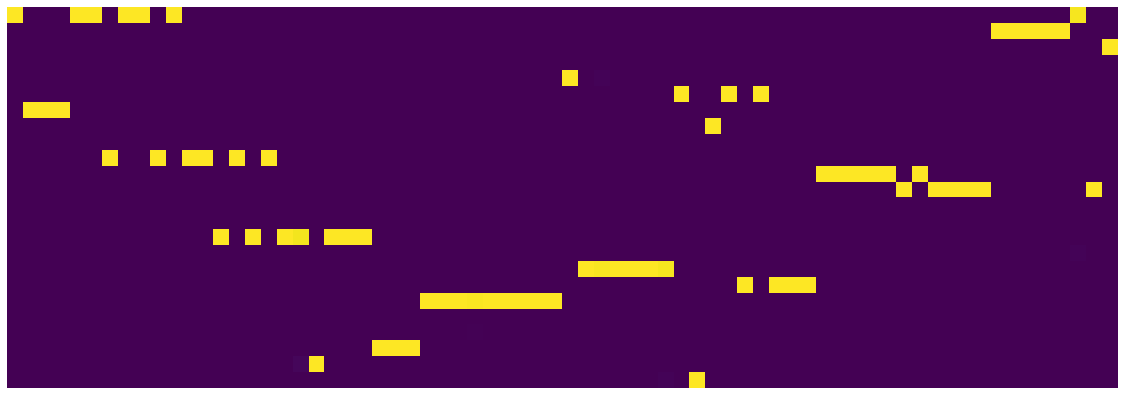

24 416 0.5829999999999996 0.4340196379460394


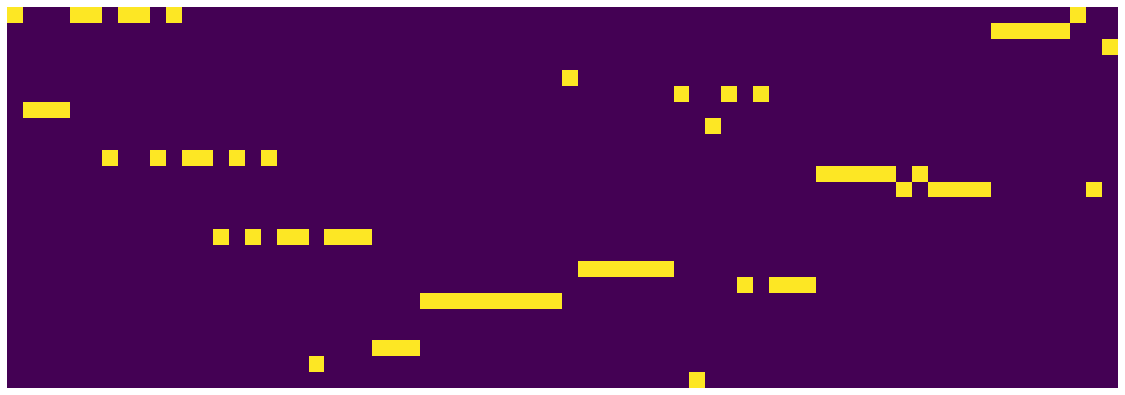

24 417 0.5819999999999996 0.40866380082443354


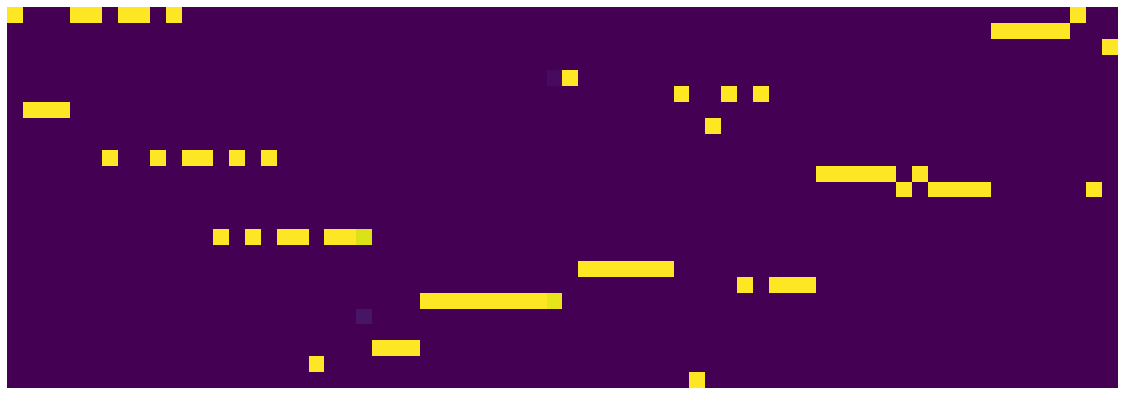

24 418 0.5809999999999996 0.41650115996599196


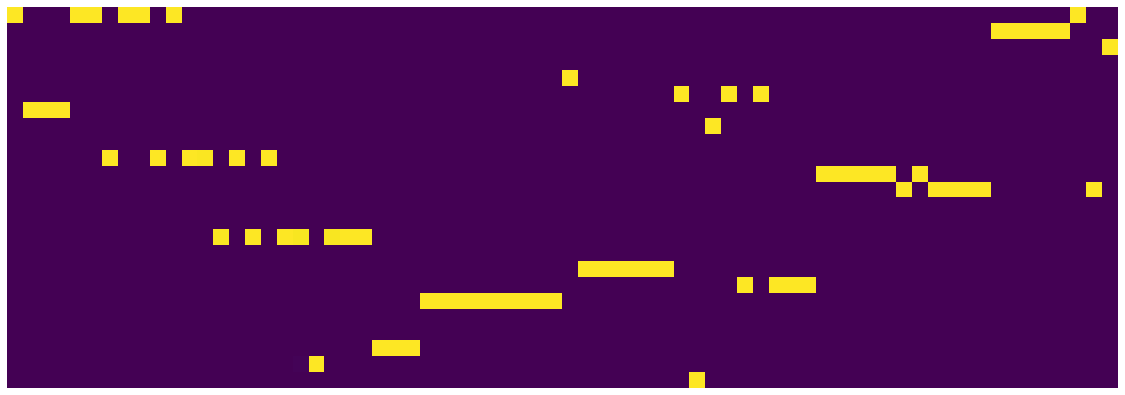

24 419 0.5799999999999996 0.4126383038237691


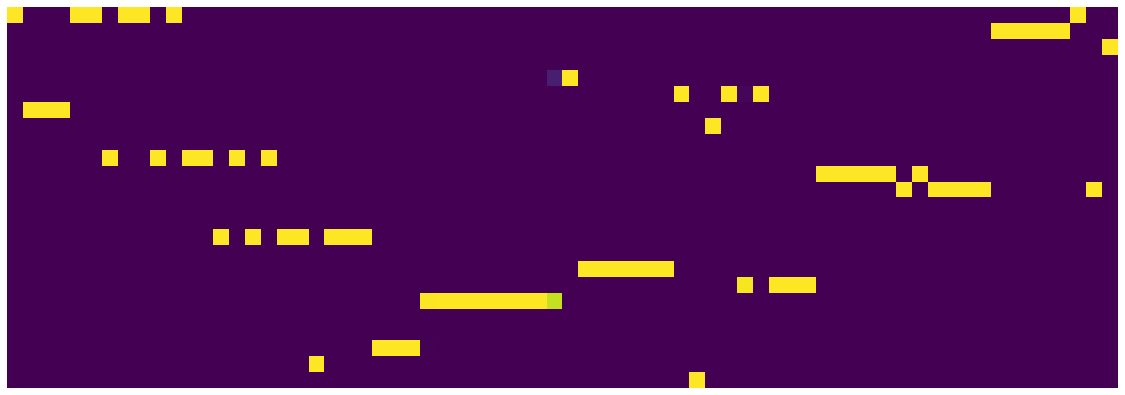

24 420 0.5789999999999996 0.4129607818089426


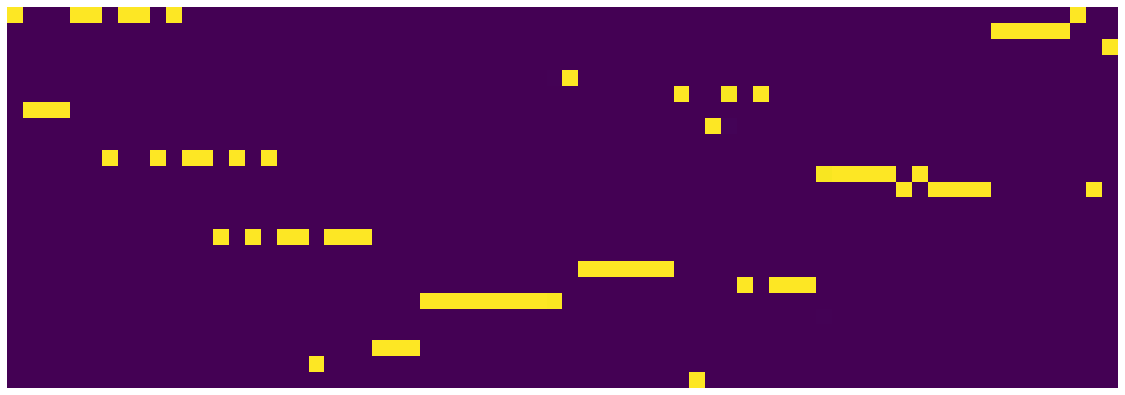

24 421 0.5779999999999996 0.4104047307744622


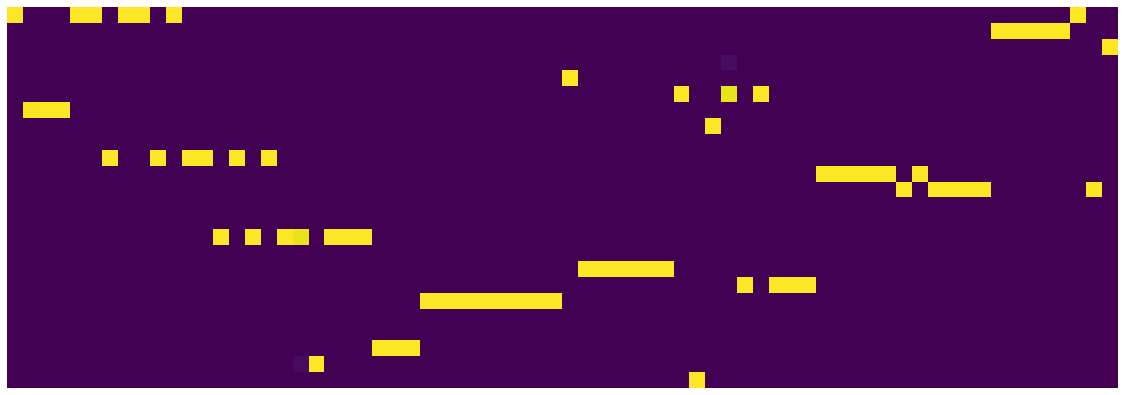

24 422 0.5769999999999996 0.4075604502111673


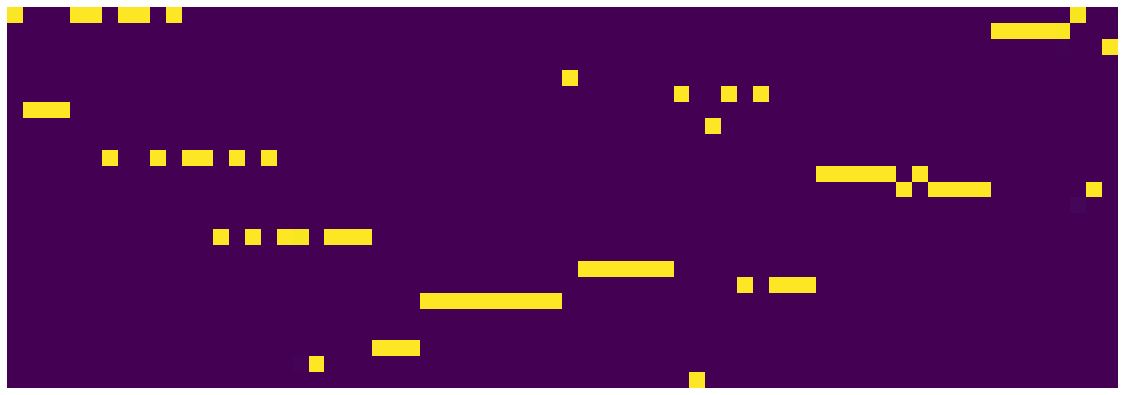

24 423 0.5759999999999996 0.41671415148302915


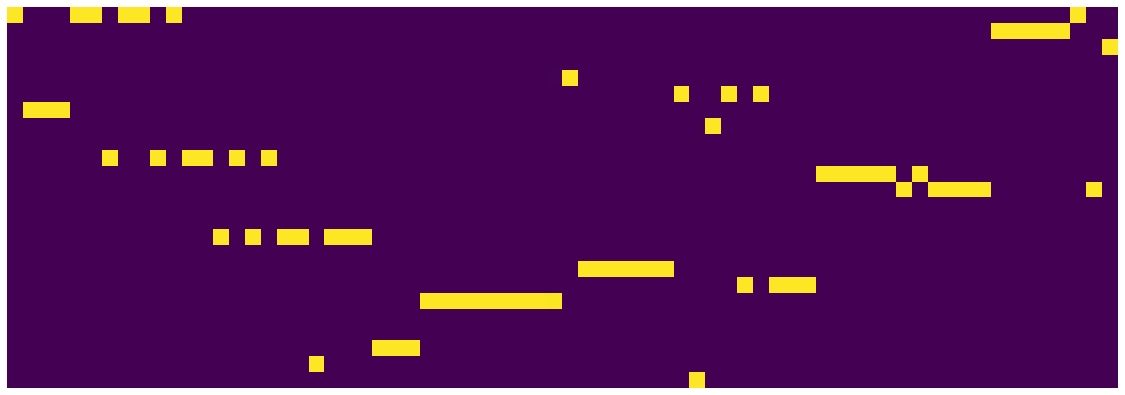

24 424 0.5749999999999996 0.40691086268052457


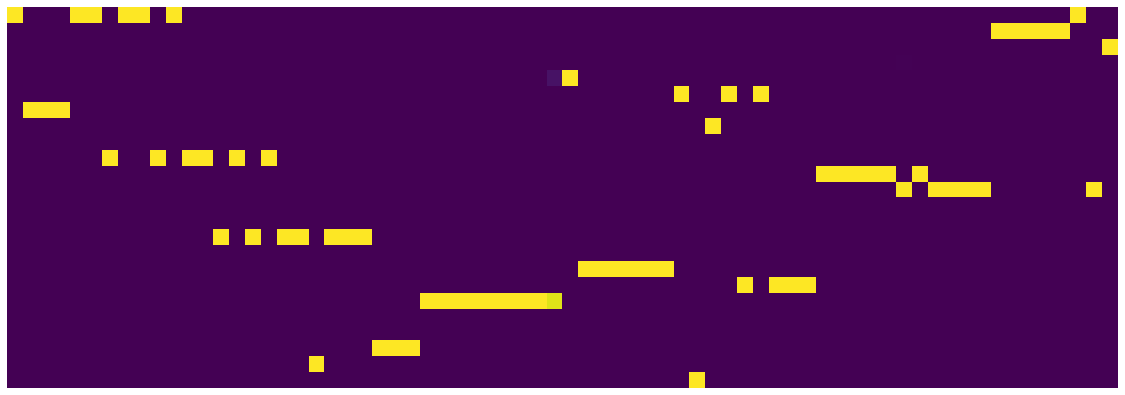

24 425 0.5739999999999996 0.42459976561367513


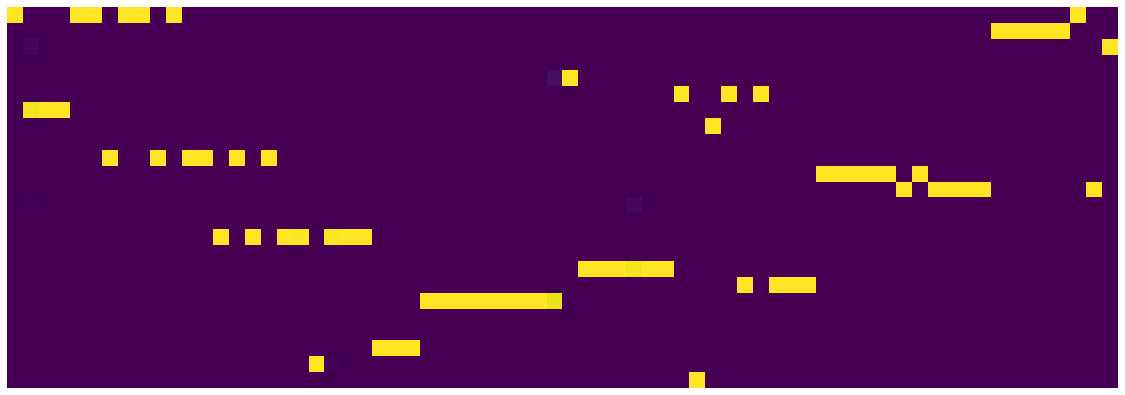

24 426 0.5729999999999996 0.437812355812639


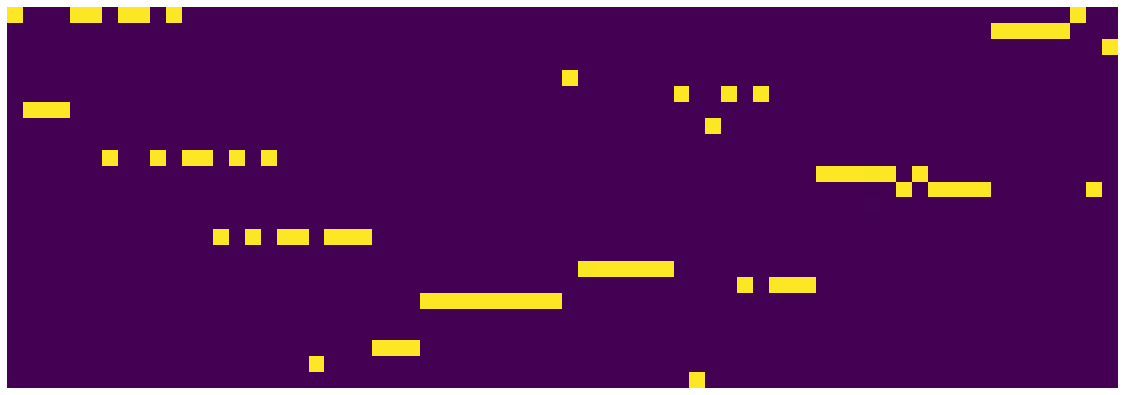

24 427 0.5719999999999996 0.40979917319491505


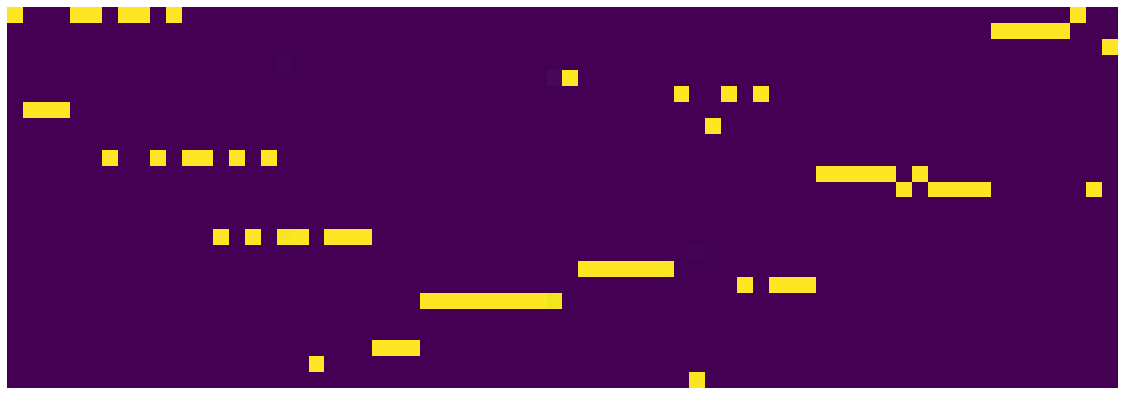

24 428 0.5709999999999996 0.4201493296772242


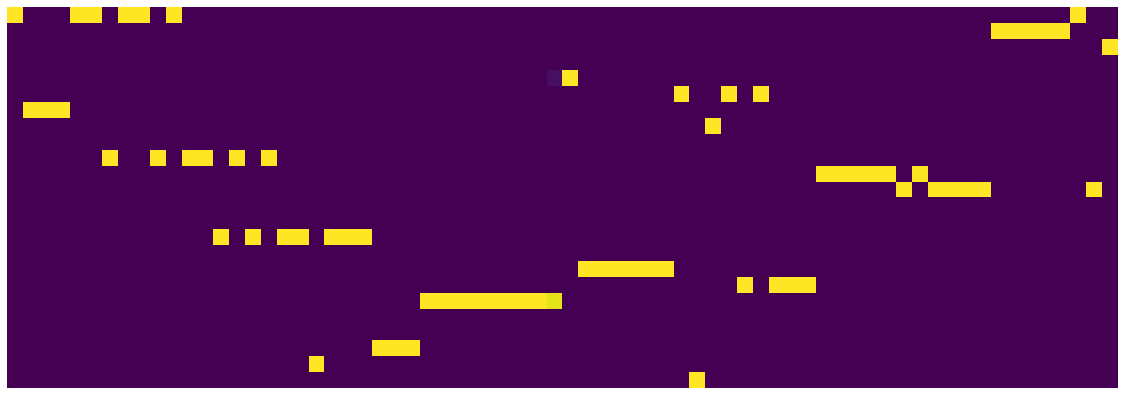

24 429 0.5699999999999996 0.40814875802025197


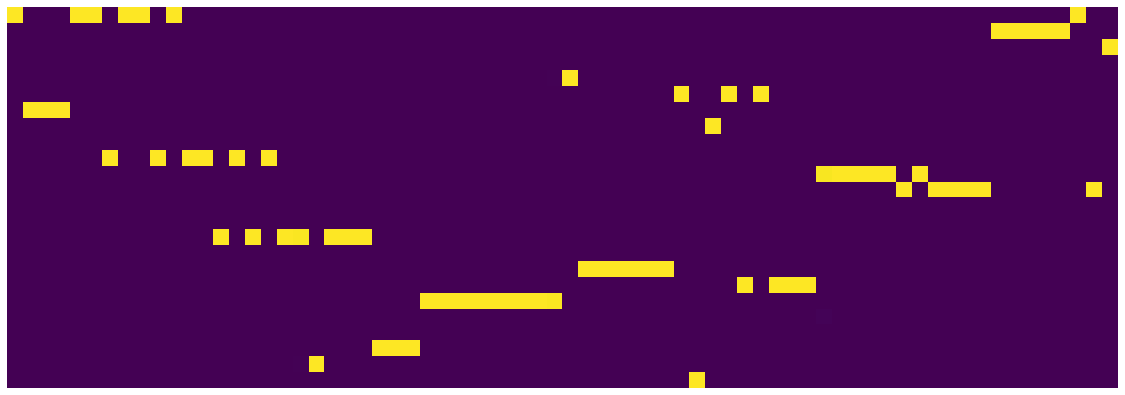

24 430 0.5689999999999996 0.4077259666286409


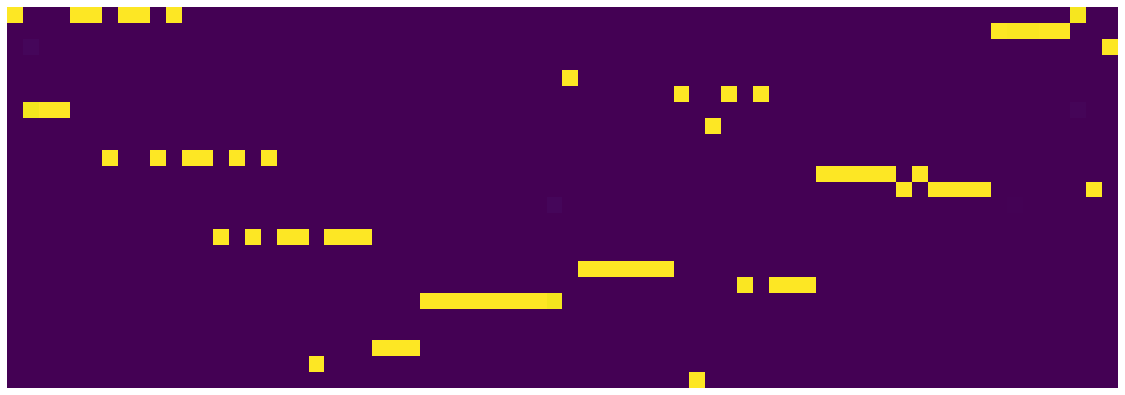

24 431 0.5679999999999996 0.4096669697202742


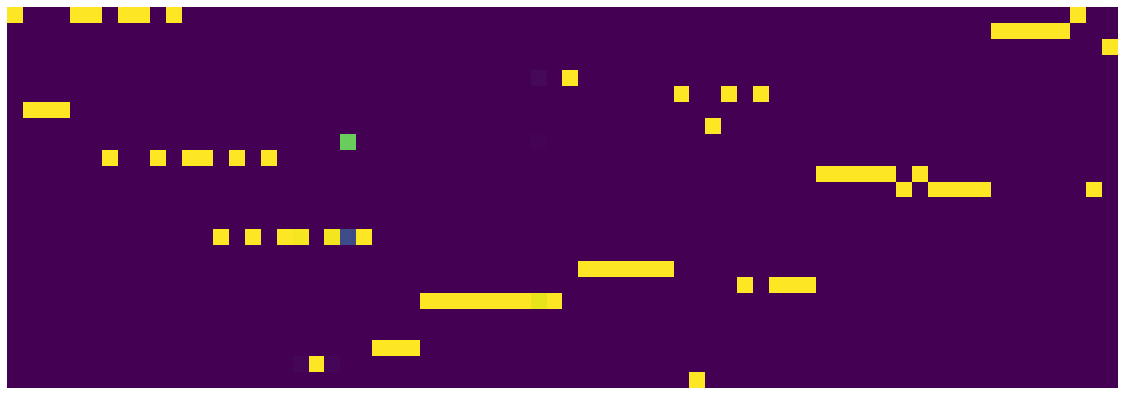

24 432 0.5669999999999996 0.42189639862626793


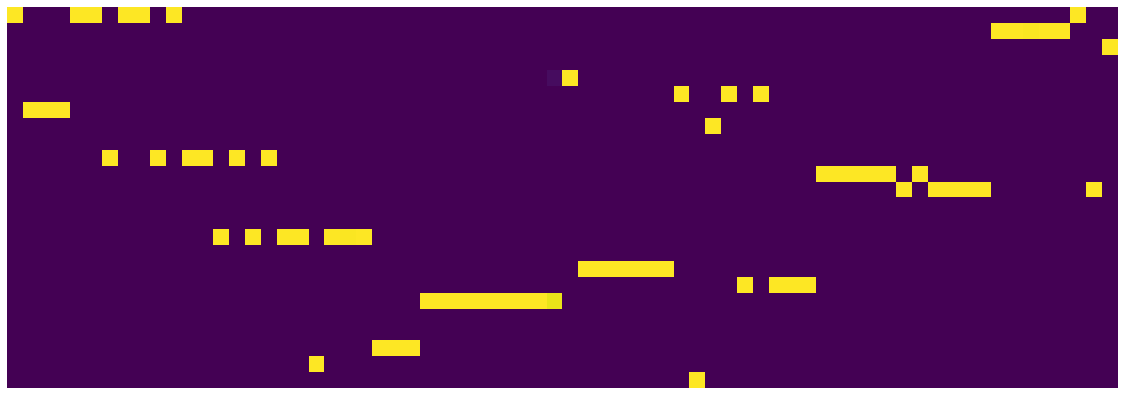

24 433 0.5659999999999996 0.4151269795373082


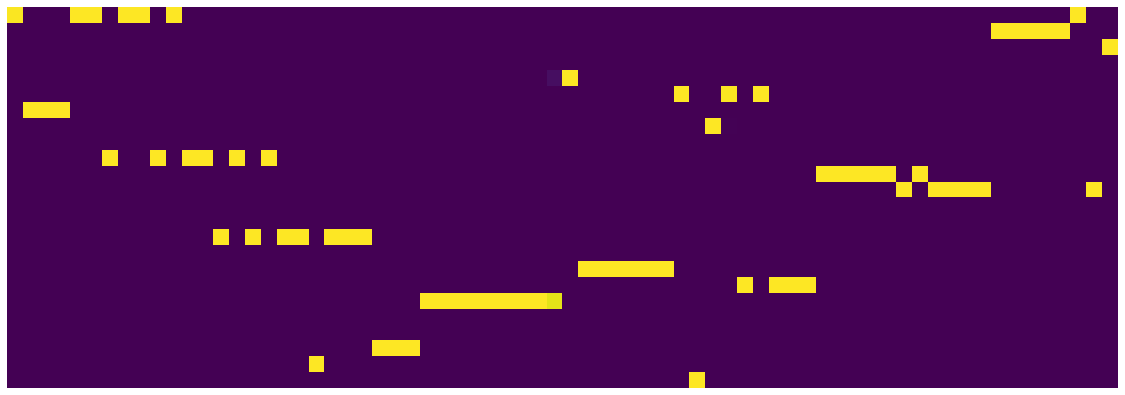

24 434 0.5649999999999996 0.4150910682976246


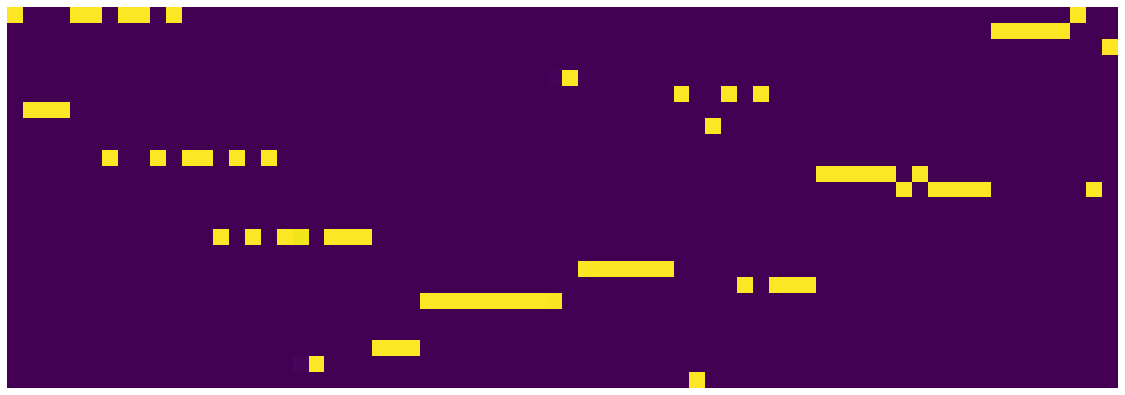

24 435 0.5639999999999996 0.4100200538523495


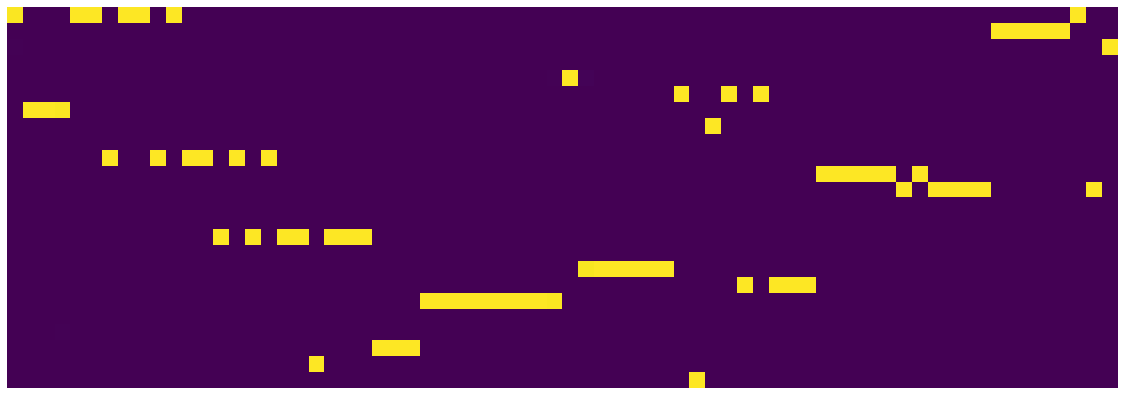

24 436 0.5629999999999996 0.4235215872526169


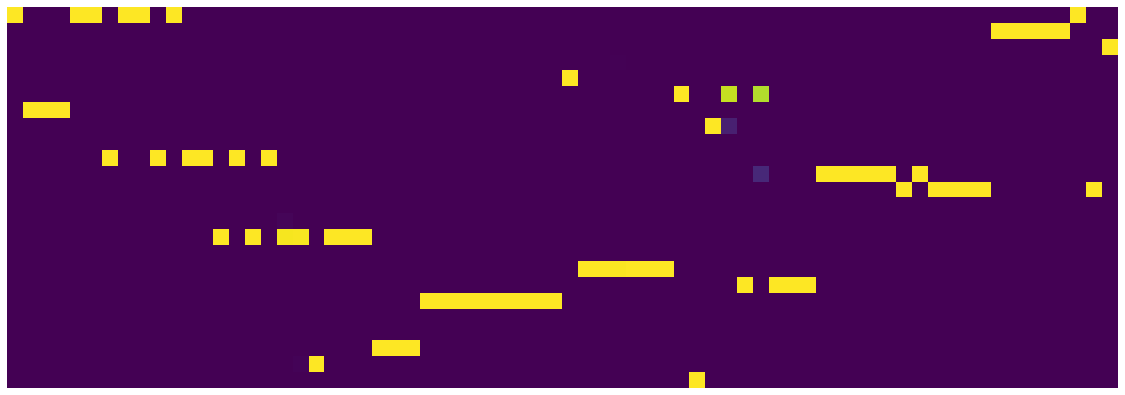

24 437 0.5619999999999996 0.4128004424273968


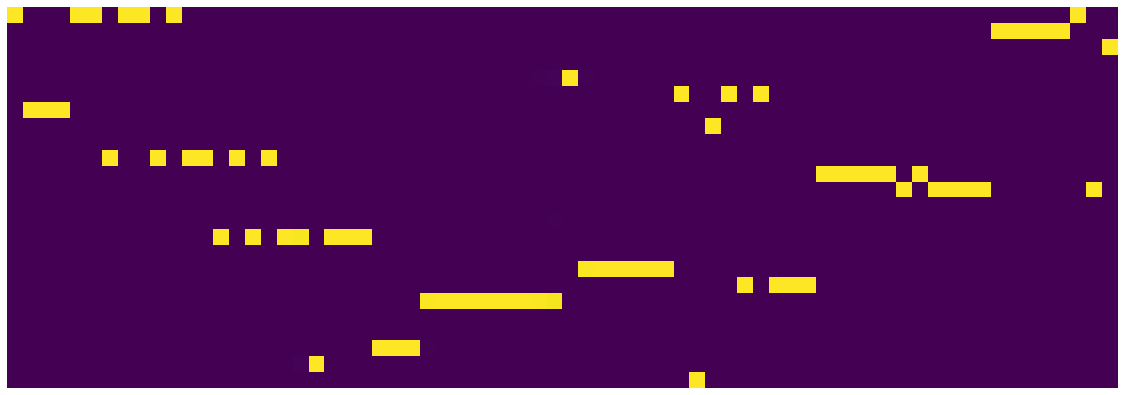

24 438 0.5609999999999996 0.4125795494765043


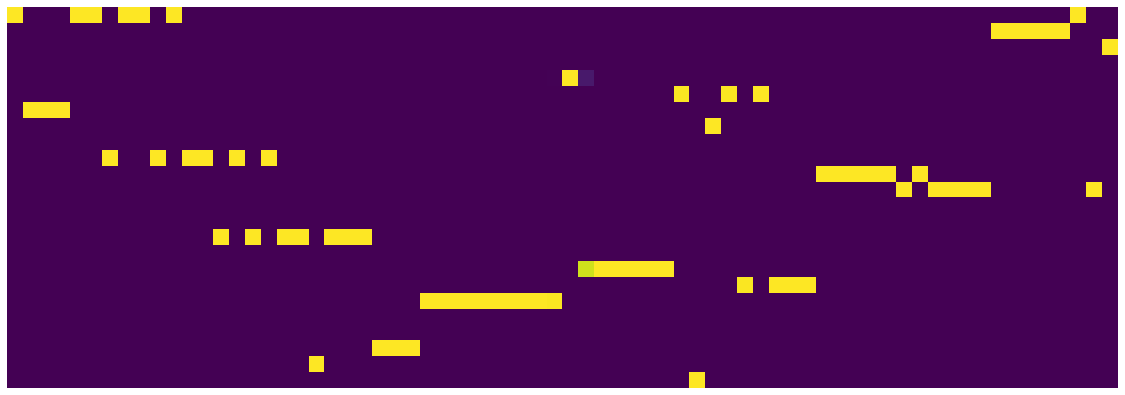

24 439 0.5599999999999996 0.4082675499841571


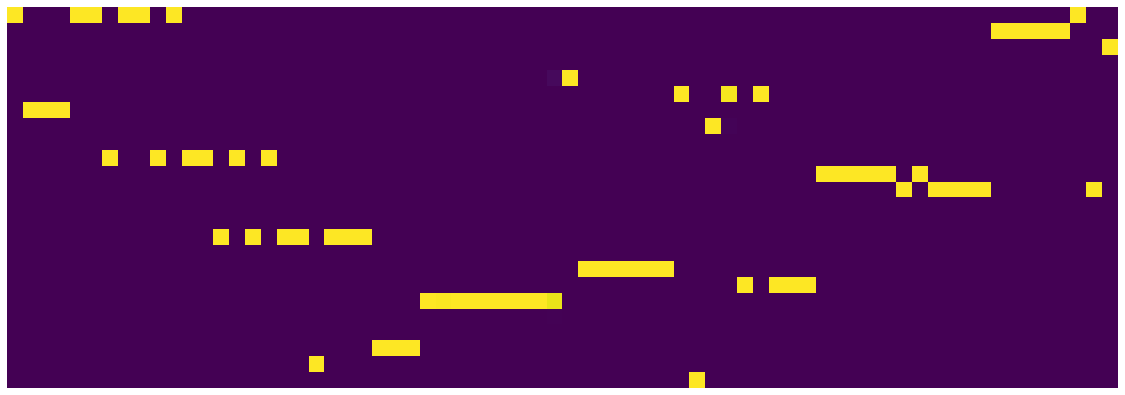

24 440 0.5589999999999996 0.4169018019922078


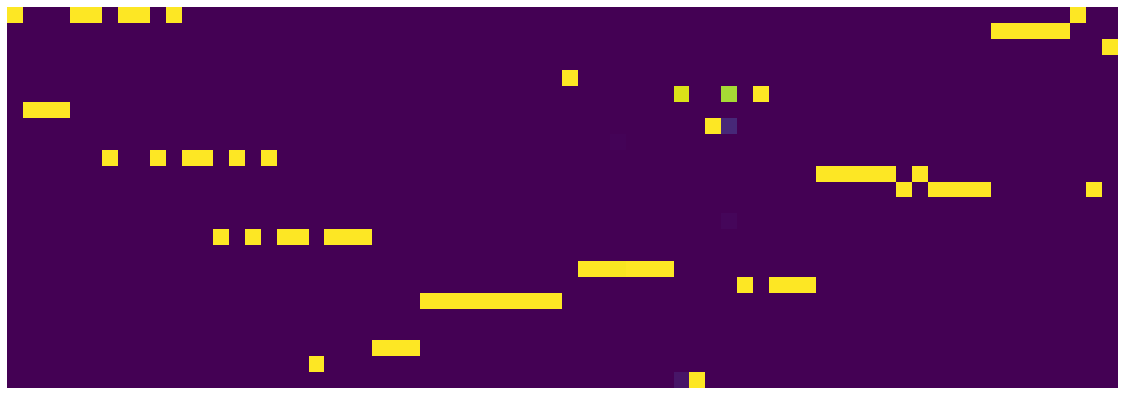

24 441 0.5579999999999996 0.42312701968476174


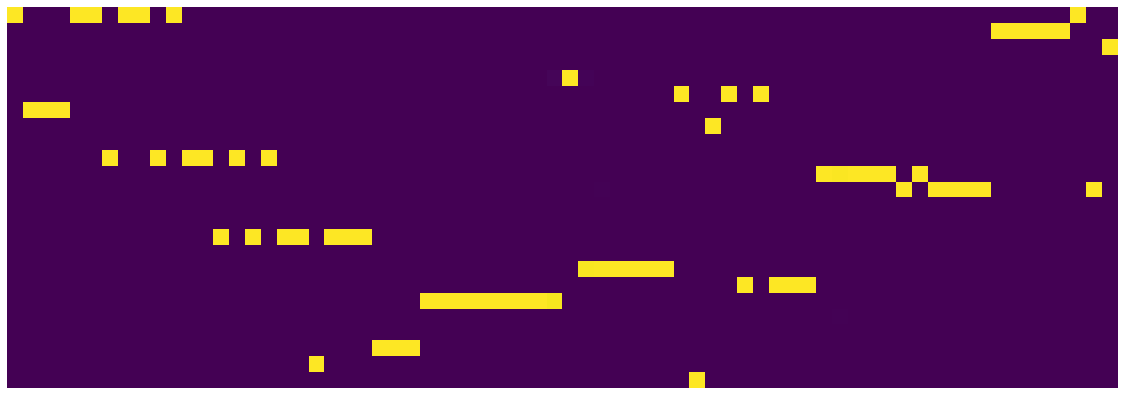

24 442 0.5569999999999996 0.4049176849424839


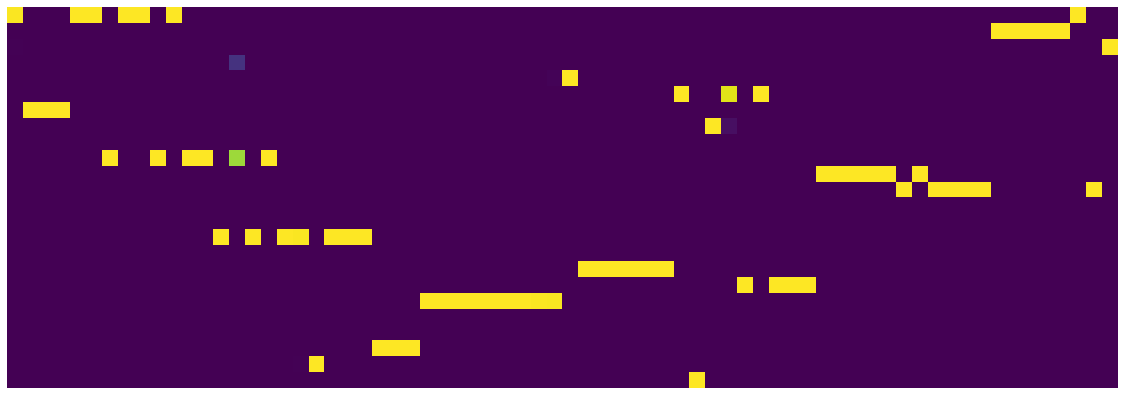

24 443 0.5559999999999996 0.41067501306533816


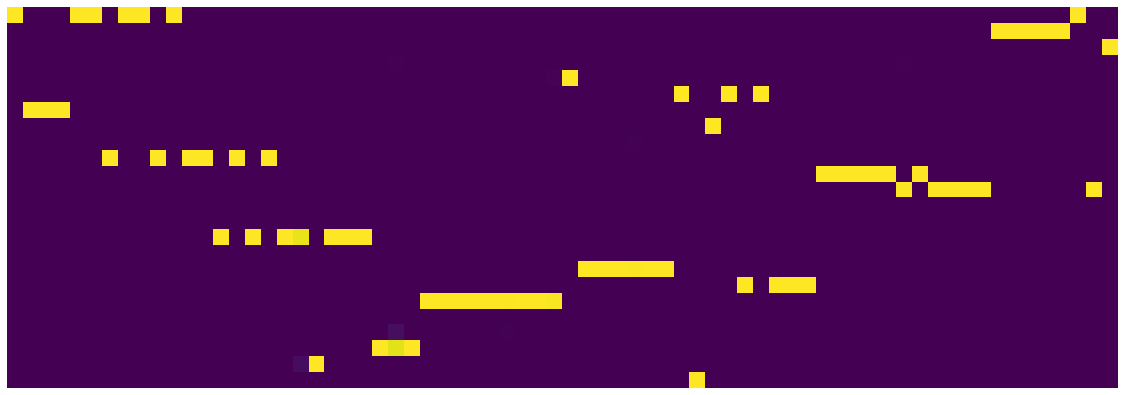

24 444 0.5549999999999996 0.41899689538404344


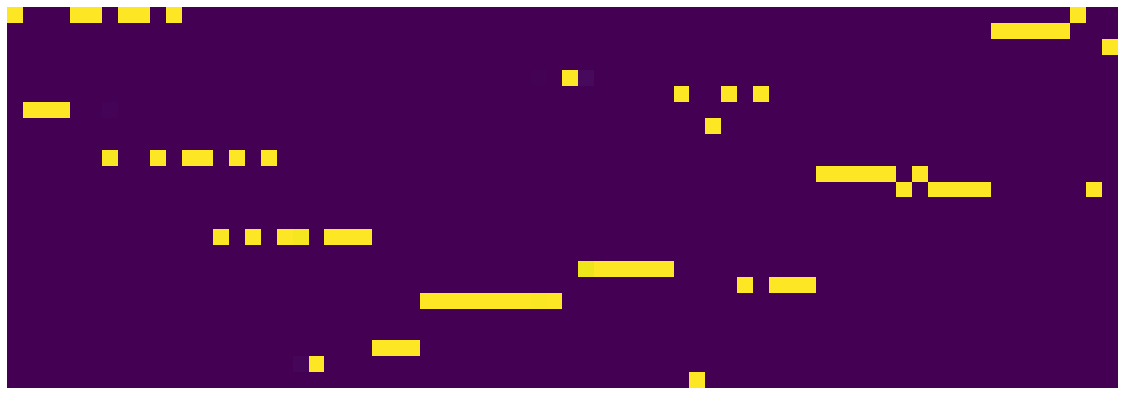

24 445 0.5539999999999996 0.4438728735782206


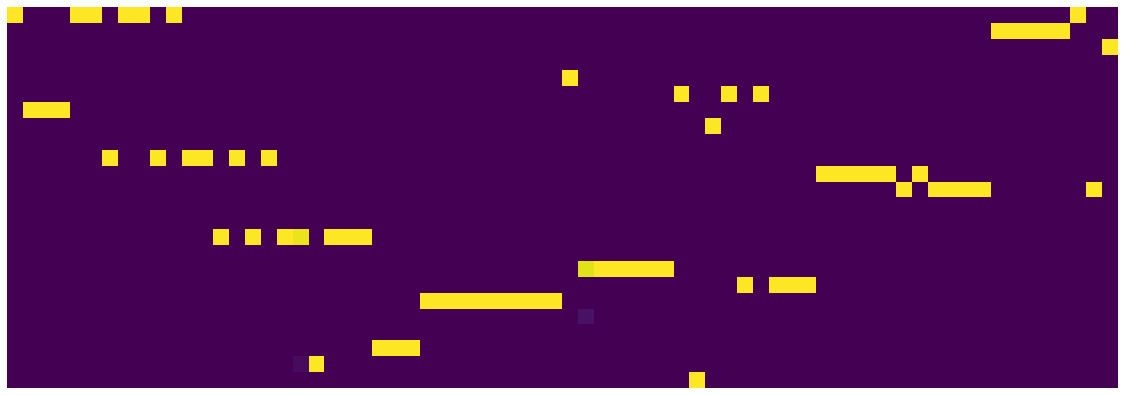

24 446 0.5529999999999996 0.4218648159876466


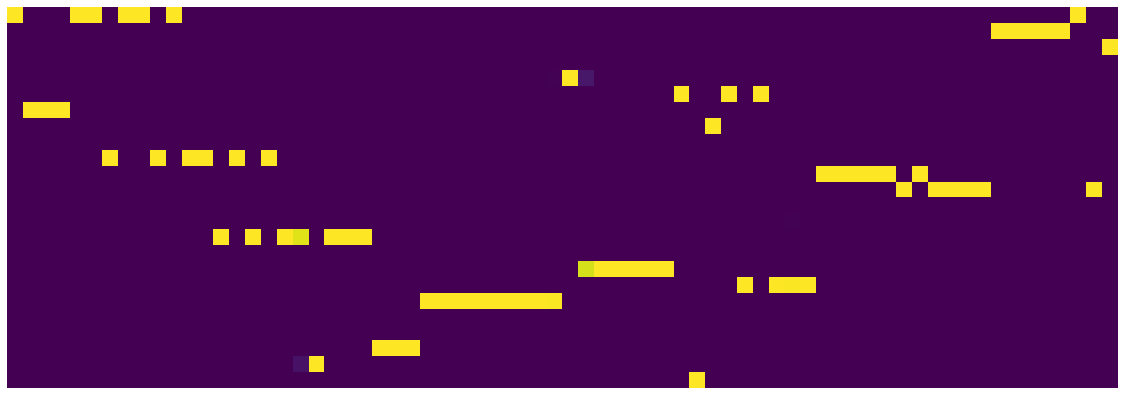

24 447 0.5519999999999996 0.41759611954912546


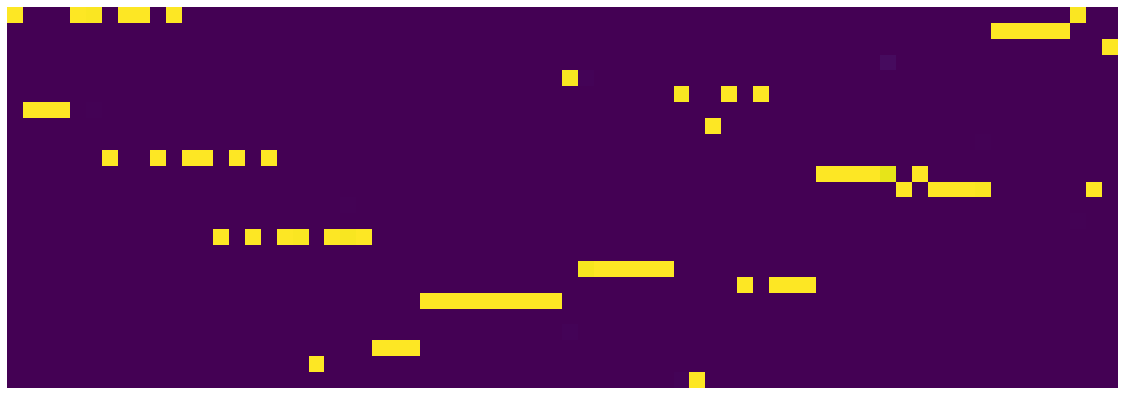

24 448 0.5509999999999996 0.4094818426296115


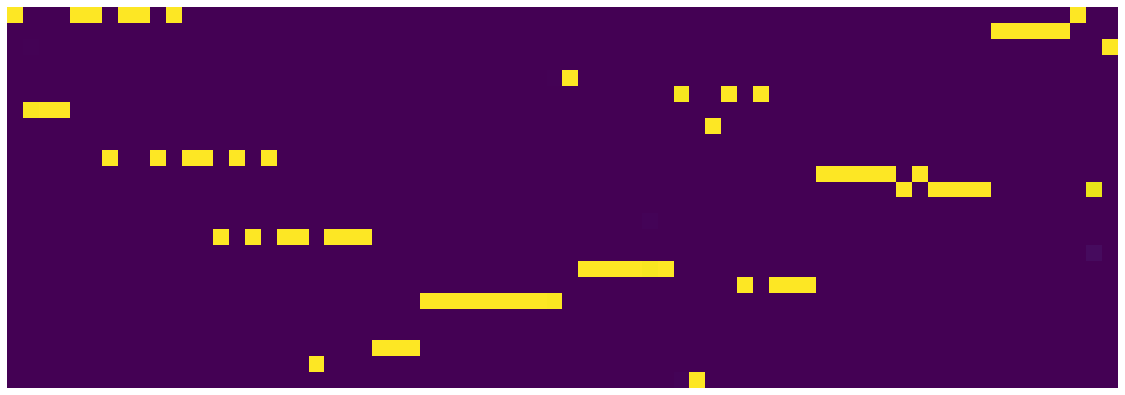

24 449 0.5499999999999996 0.4058466632850468


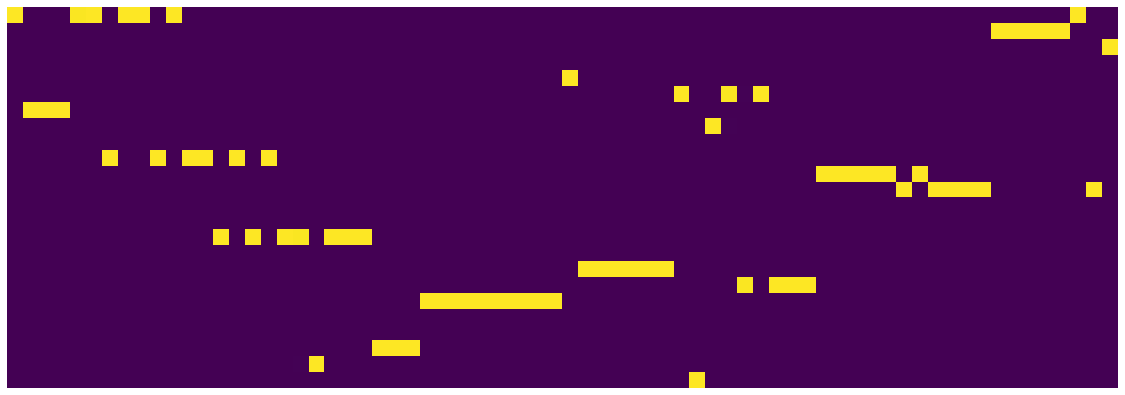

24 450 0.5489999999999996 0.4413579528219998


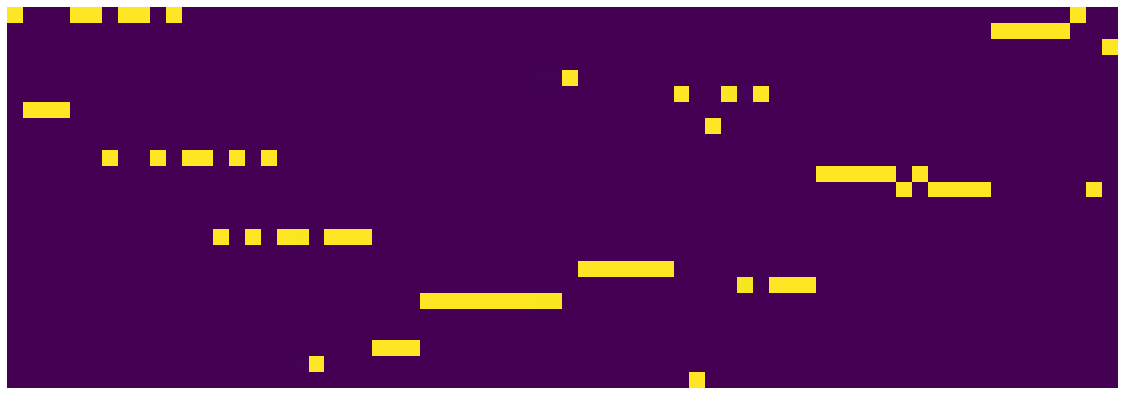

24 451 0.5479999999999996 0.4209437512792647


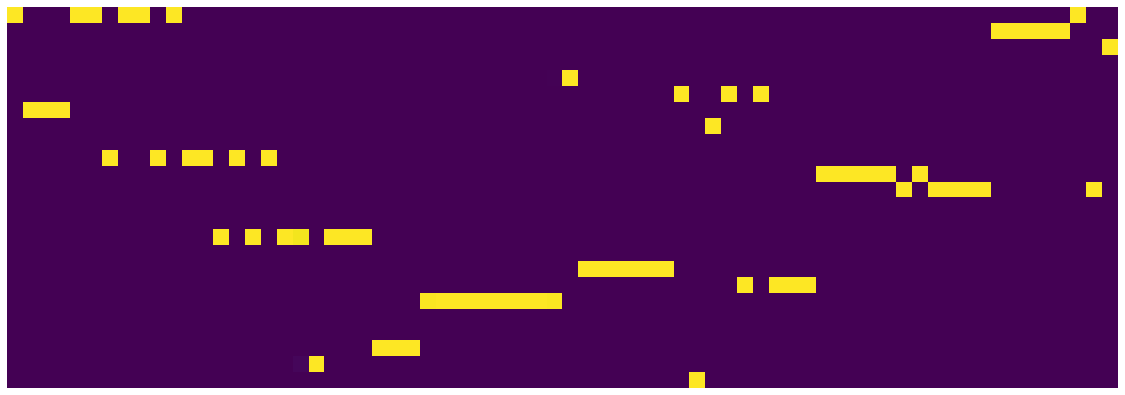

24 452 0.5469999999999996 0.4081795926205814


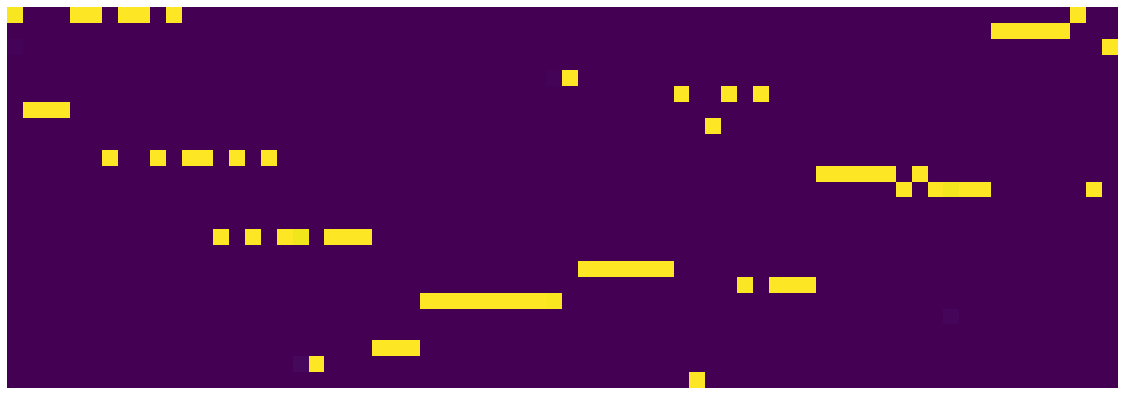

24 453 0.5459999999999996 0.4062584891915321


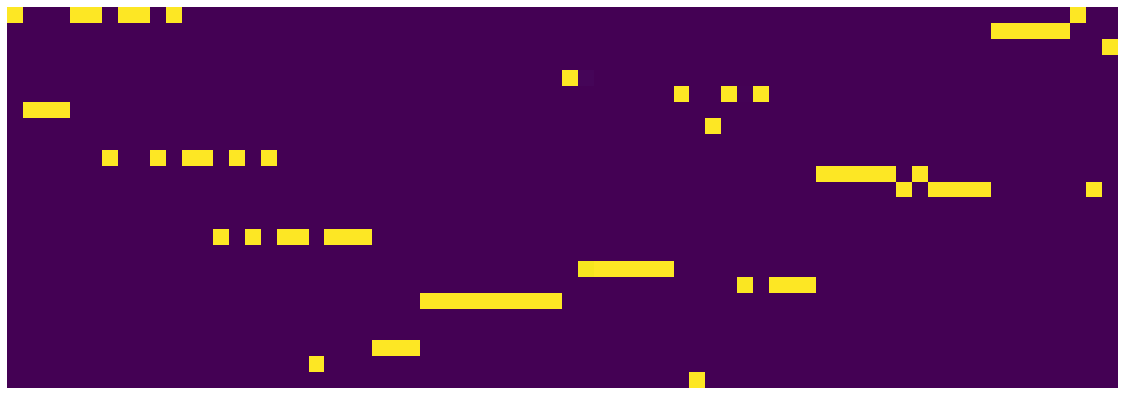

24 454 0.5449999999999996 0.41096744062379004


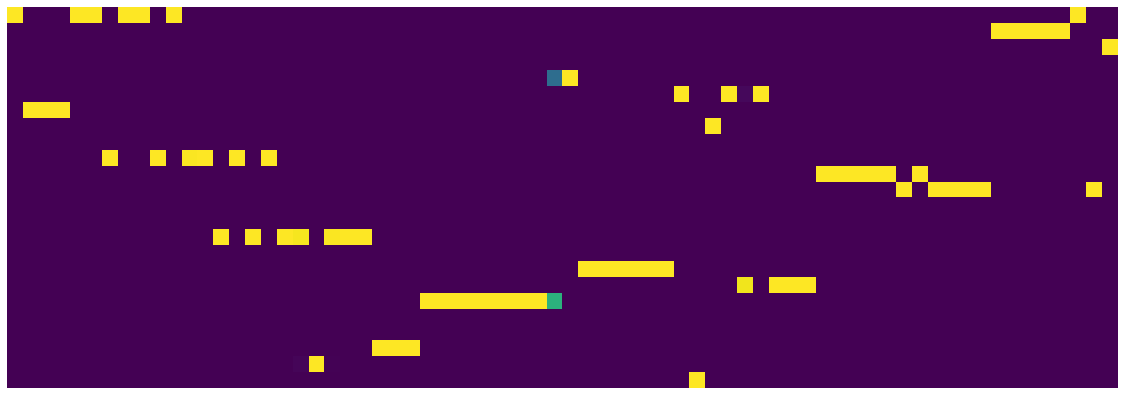

24 455 0.5439999999999996 0.41701266150921584


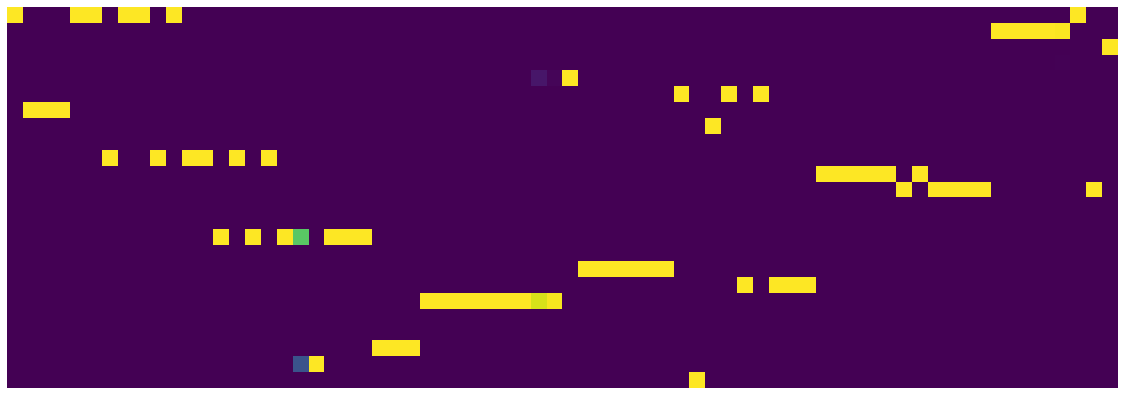

24 456 0.5429999999999996 0.4116555772721767


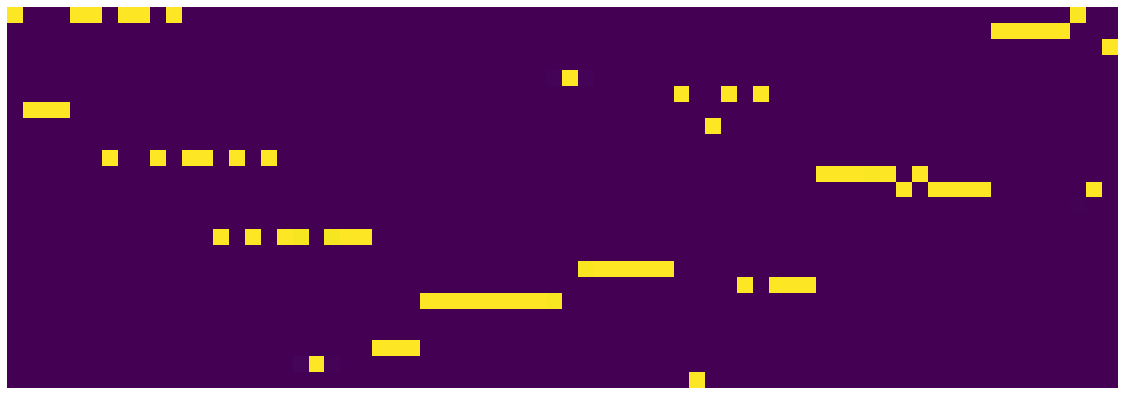

24 457 0.5419999999999996 0.41816832274198534


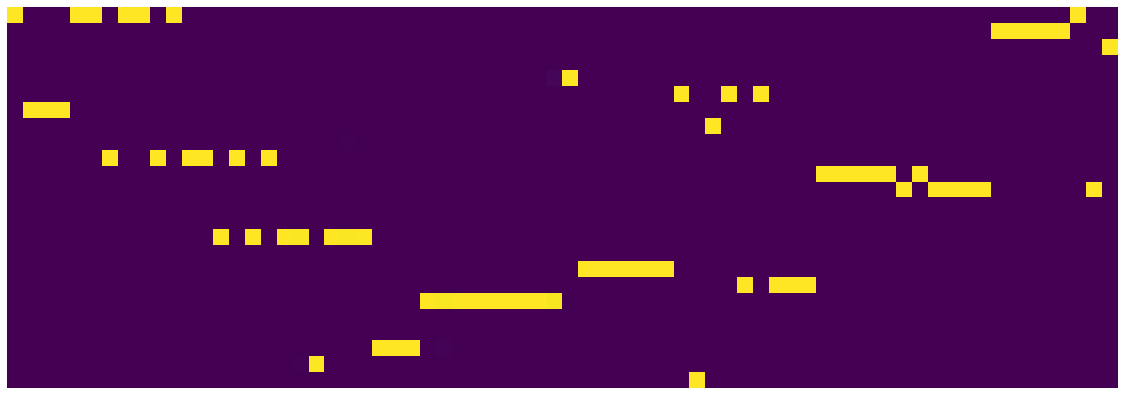

24 458 0.5409999999999996 0.42102352445945146


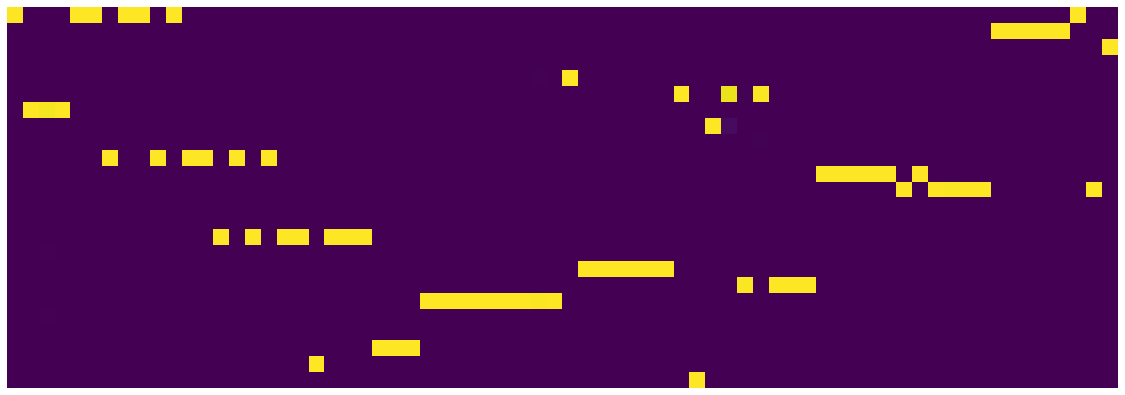

24 459 0.5399999999999996 0.40522523699328306


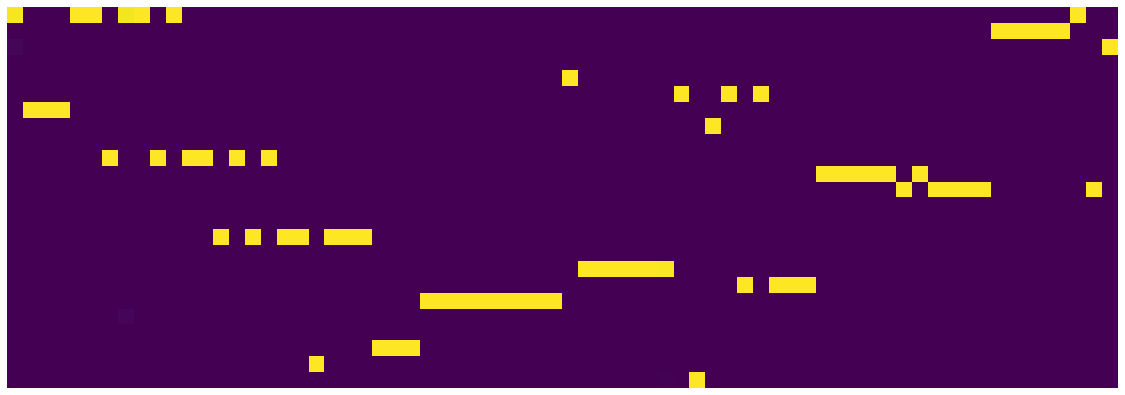

24 460 0.5389999999999996 0.41331814592704175


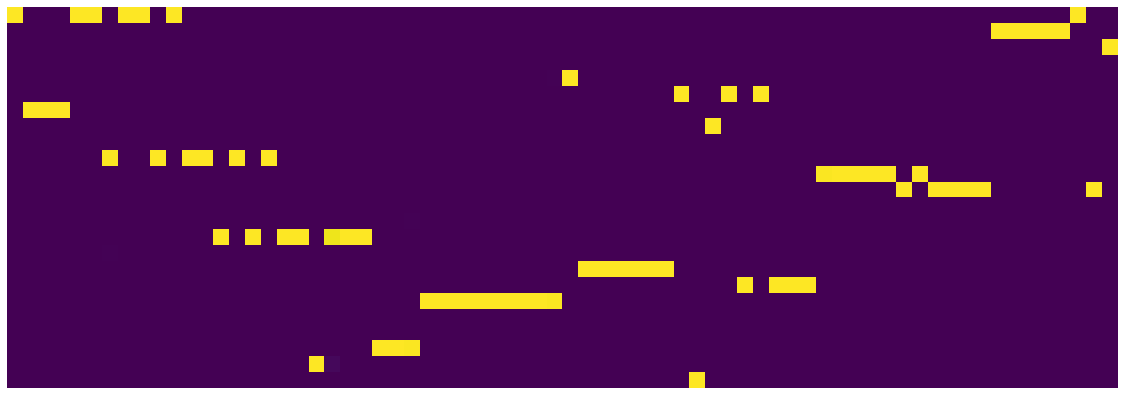

24 461 0.5379999999999996 0.4099608212709427


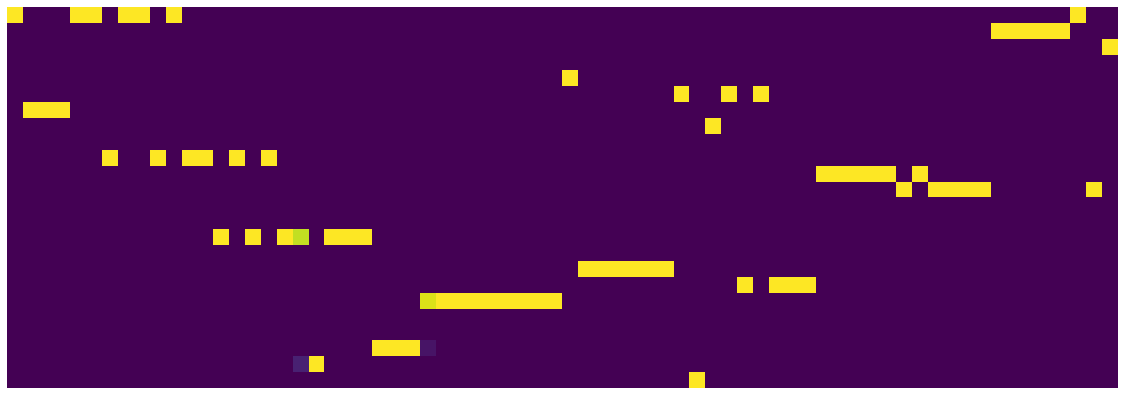

24 462 0.5369999999999996 0.4434107600711286


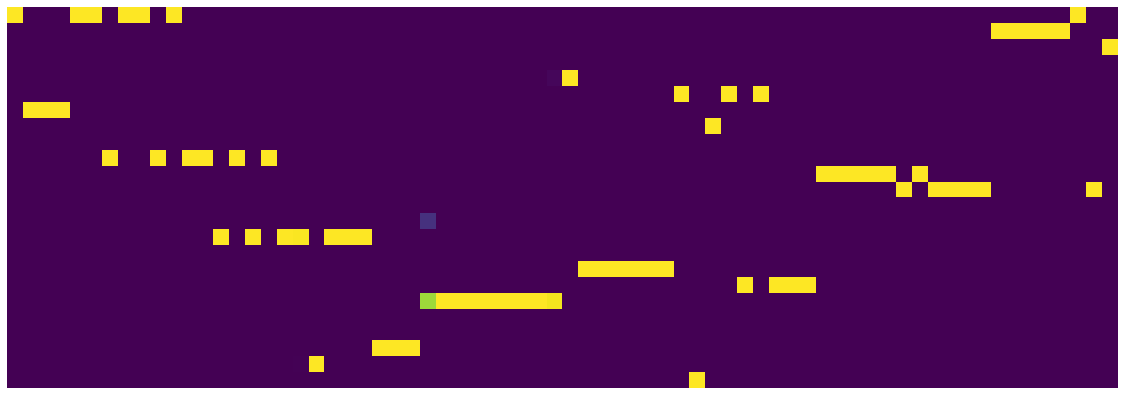

24 463 0.5359999999999996 0.41685334881767633


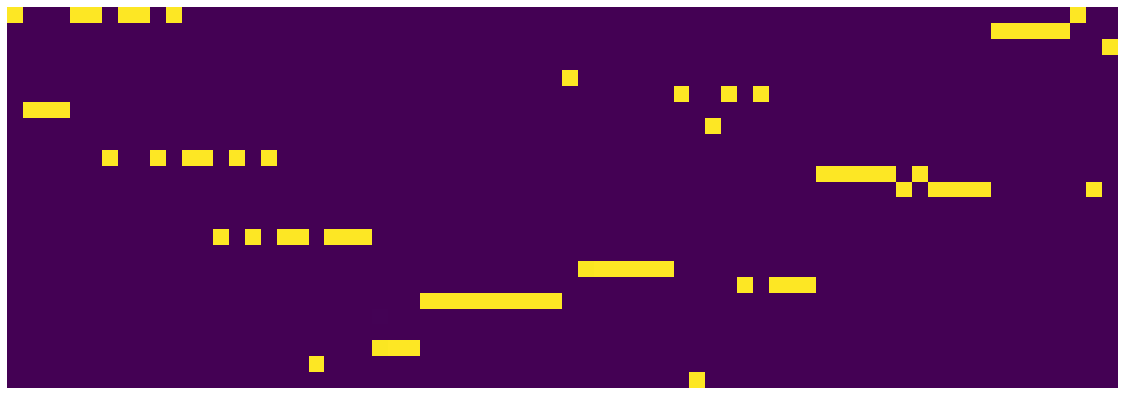

24 464 0.5349999999999996 0.41284389030188323


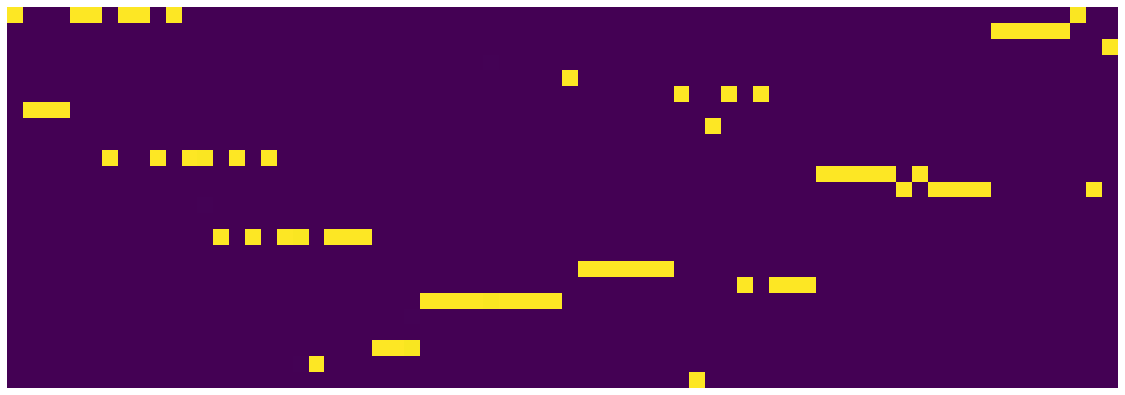

24 465 0.5339999999999996 0.4119587910361588


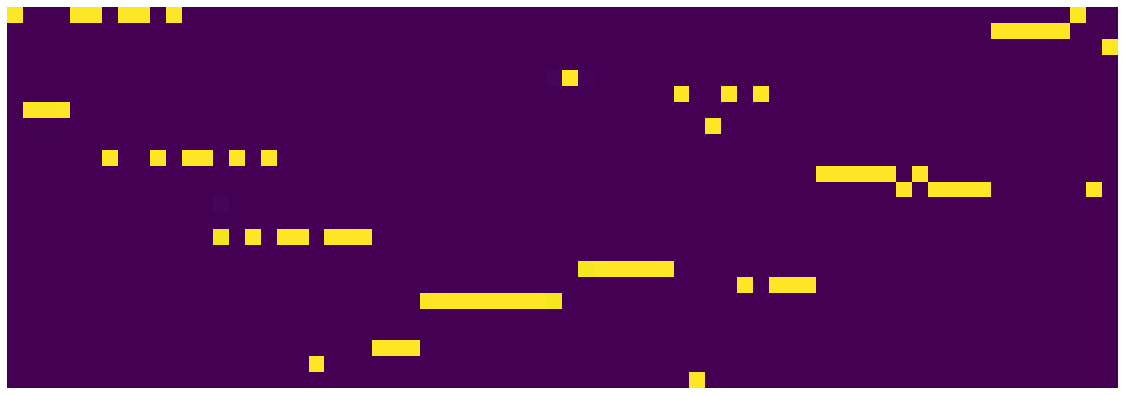

24 466 0.5329999999999996 0.4173736655153334


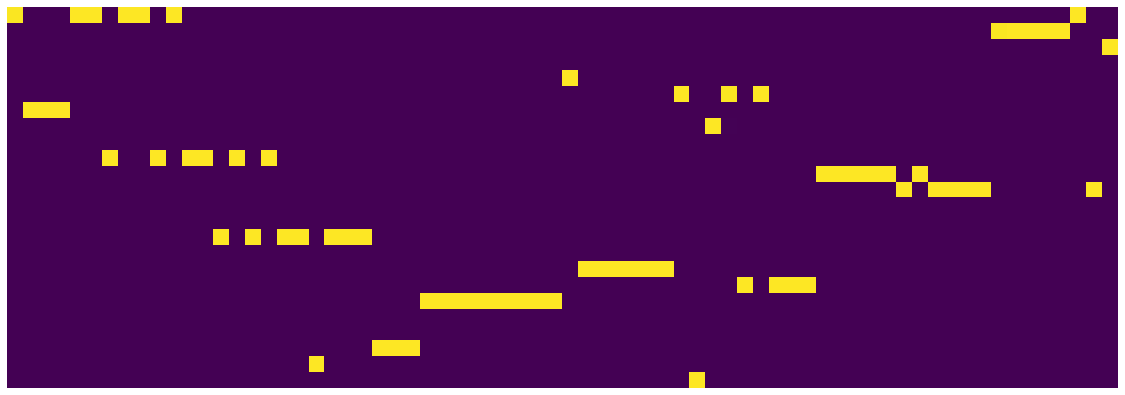

24 467 0.5319999999999996 0.416882951464504


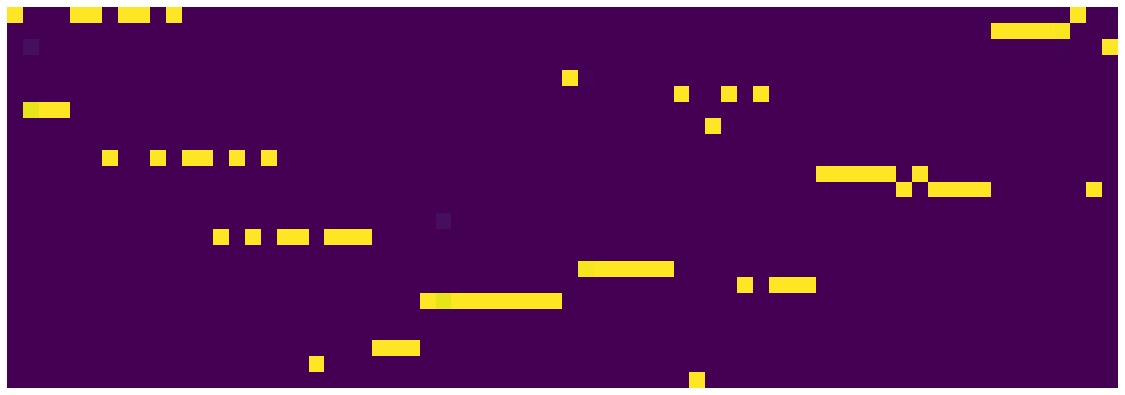

24 468 0.5309999999999996 0.4059249530546367


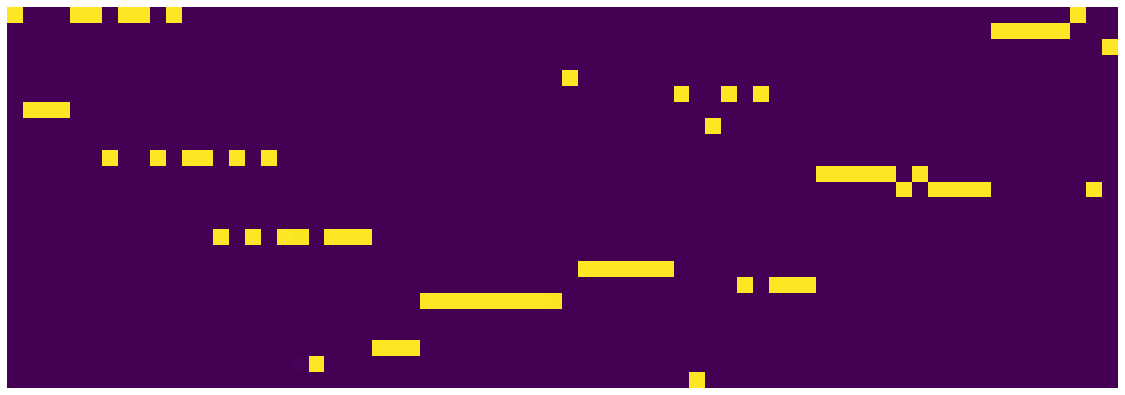

24 469 0.5299999999999996 0.4062004877254367


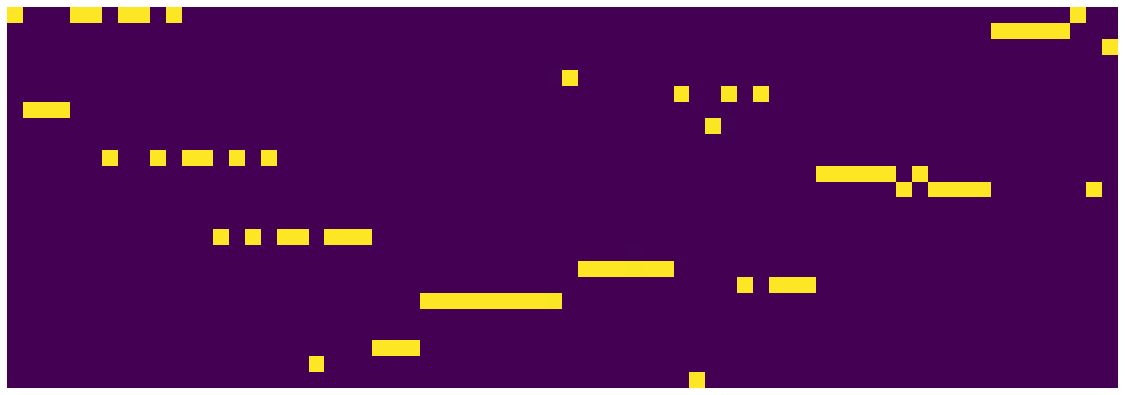

24 470 0.5289999999999996 0.4274609567597508


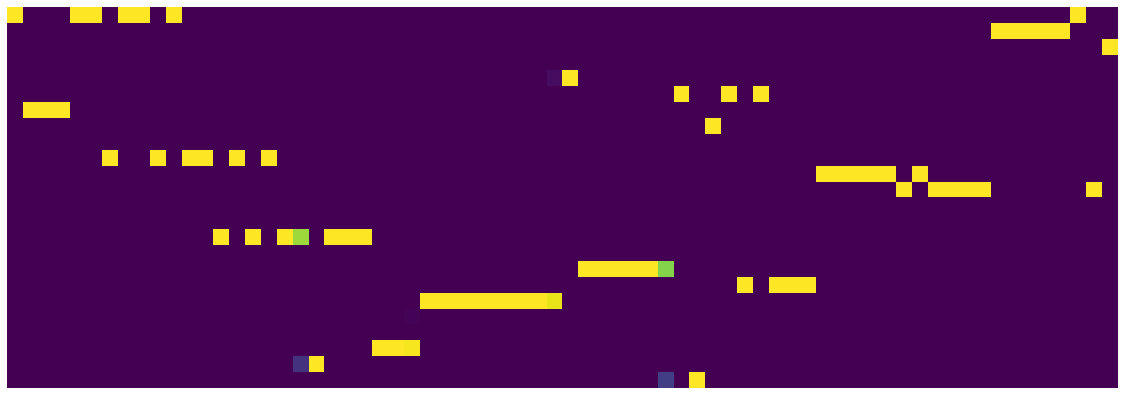

24 471 0.5279999999999996 0.41598425721749666


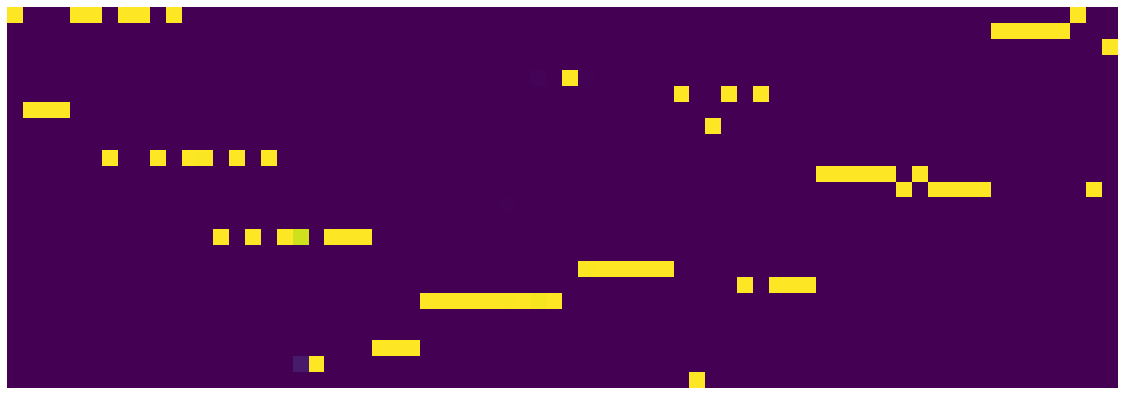

24 472 0.5269999999999996 0.4179128034040332


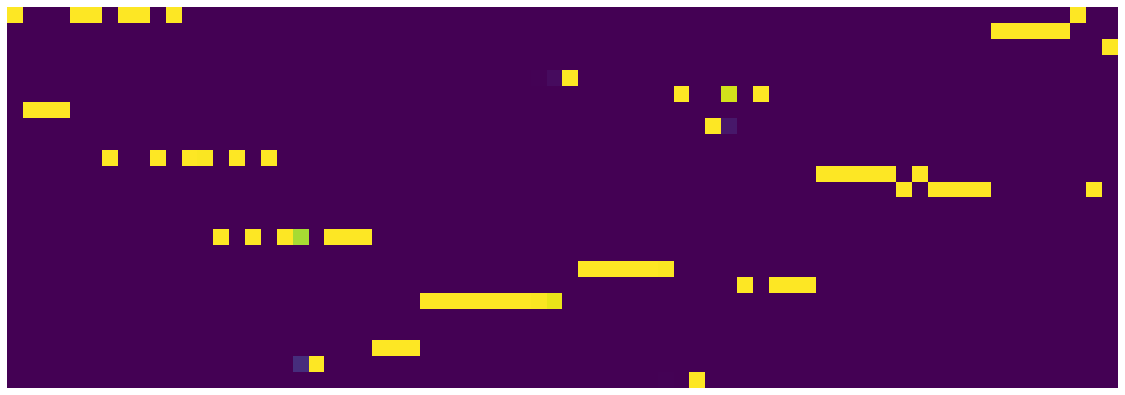

24 473 0.5259999999999996 0.40537105230614545


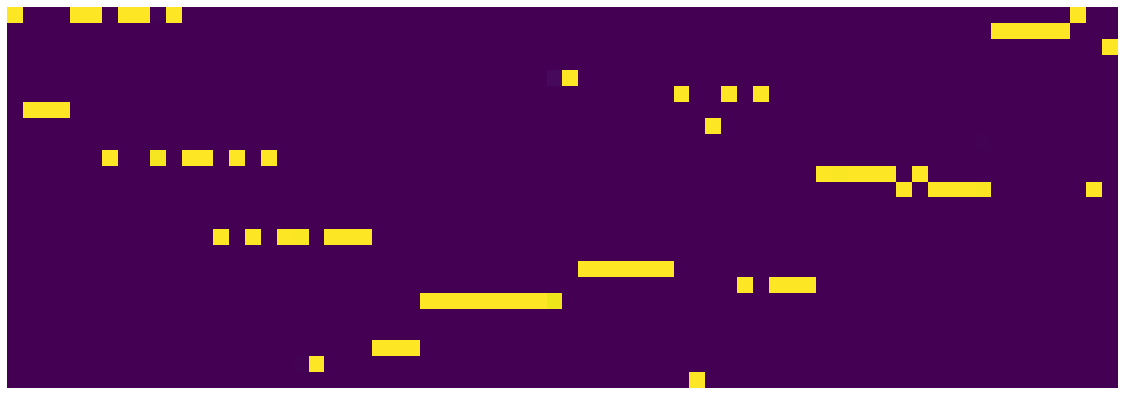

24 474 0.5249999999999996 0.4067251356318593


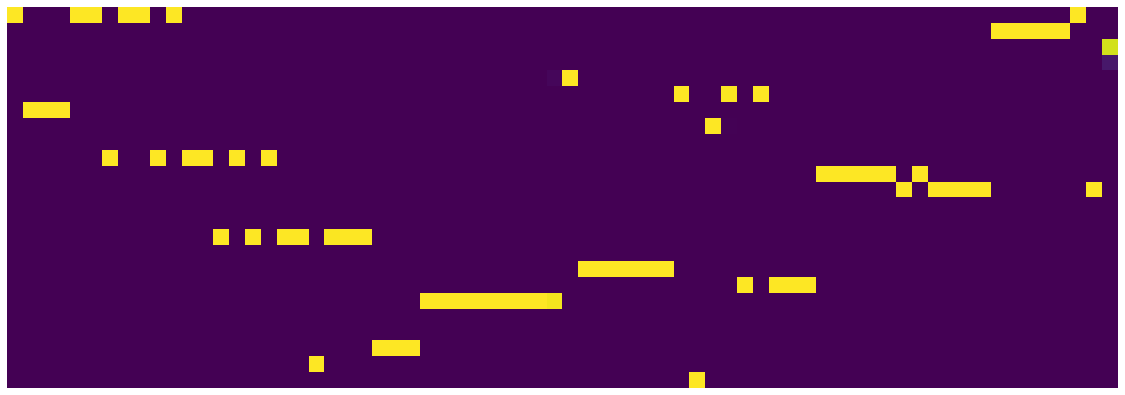

24 475 0.5239999999999996 0.40910262409597636


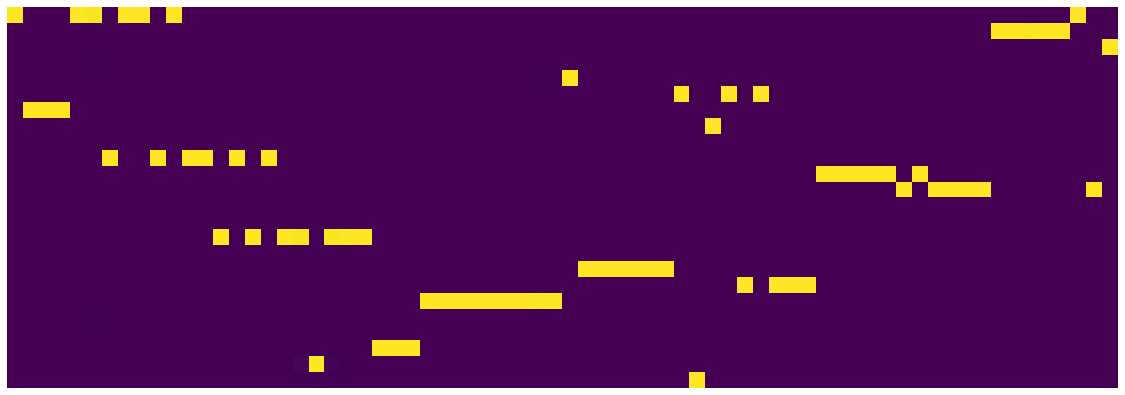

24 476 0.5229999999999996 0.42360476721078155


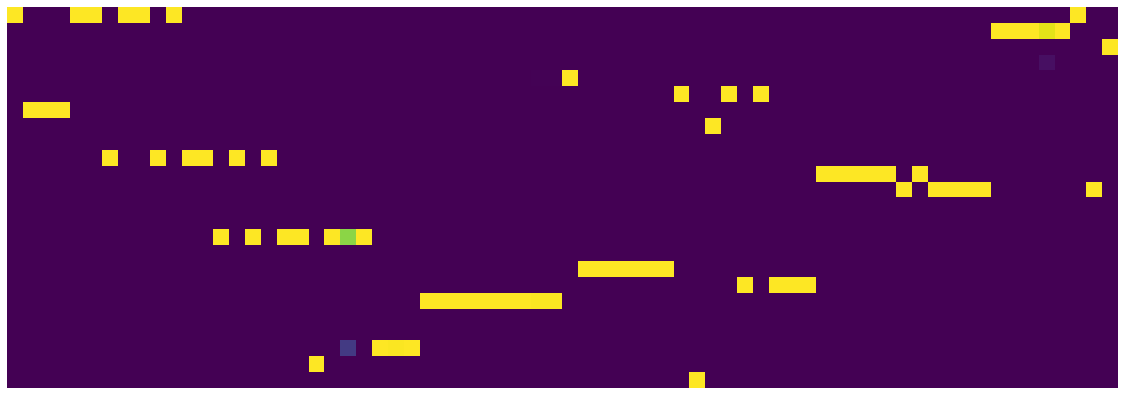

24 477 0.5219999999999996 0.4444442302919924


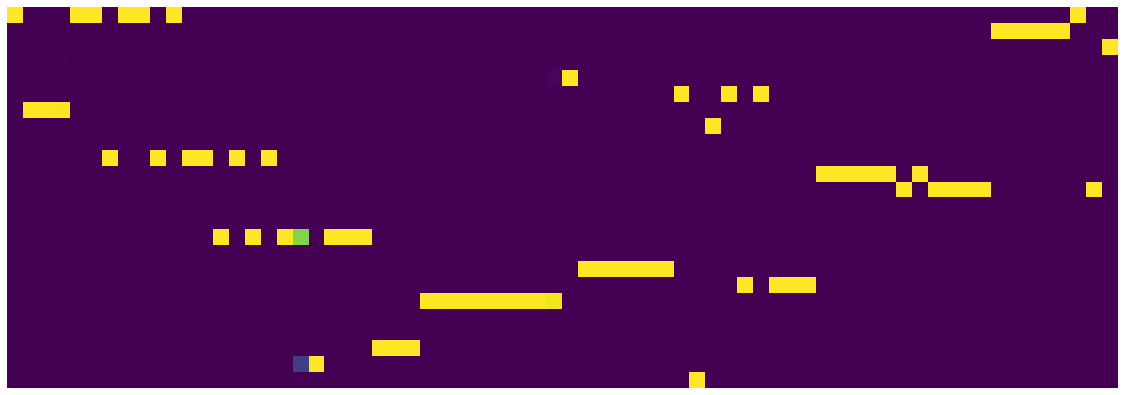

24 478 0.5209999999999996 0.39861323200166227


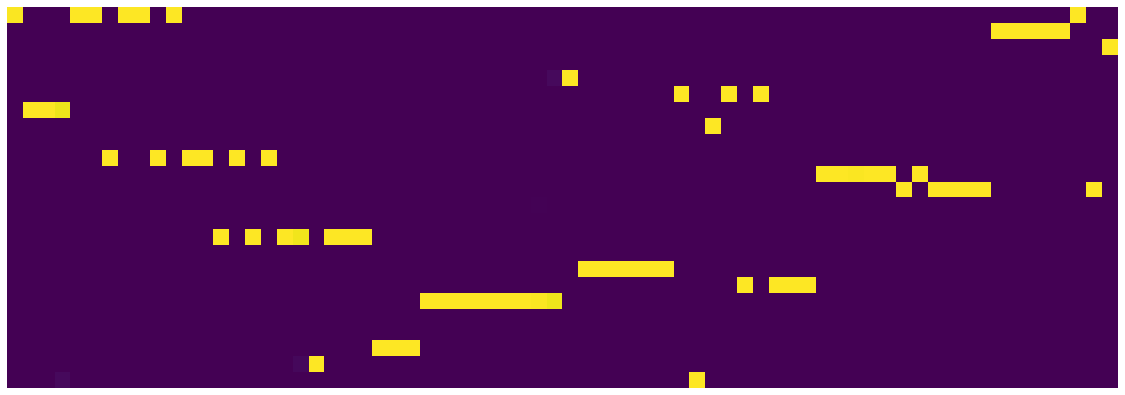

24 479 0.5199999999999996 0.4209726363420486


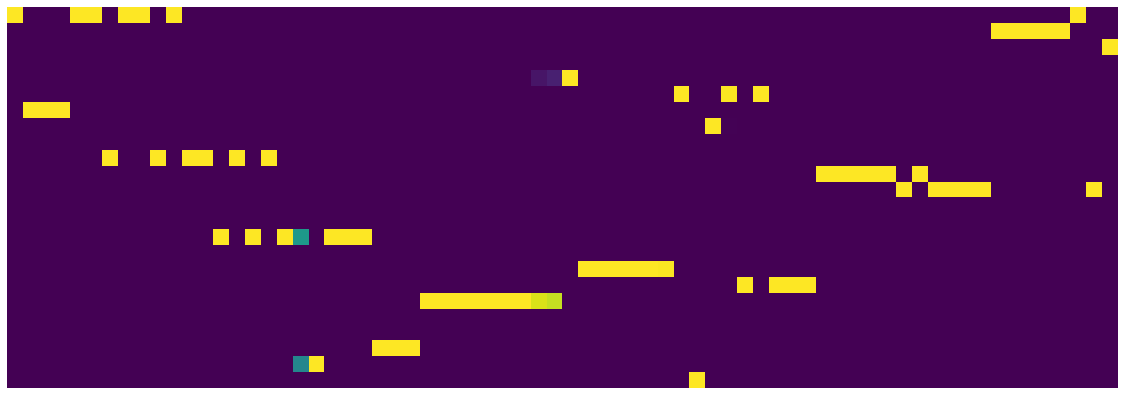

24 480 0.5189999999999996 0.40792017597705127


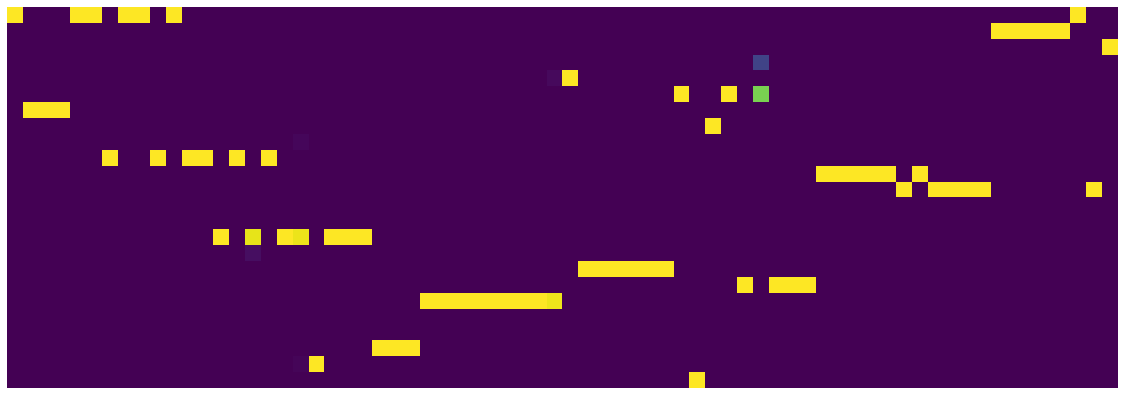

24 481 0.5179999999999996 0.4310915334150195


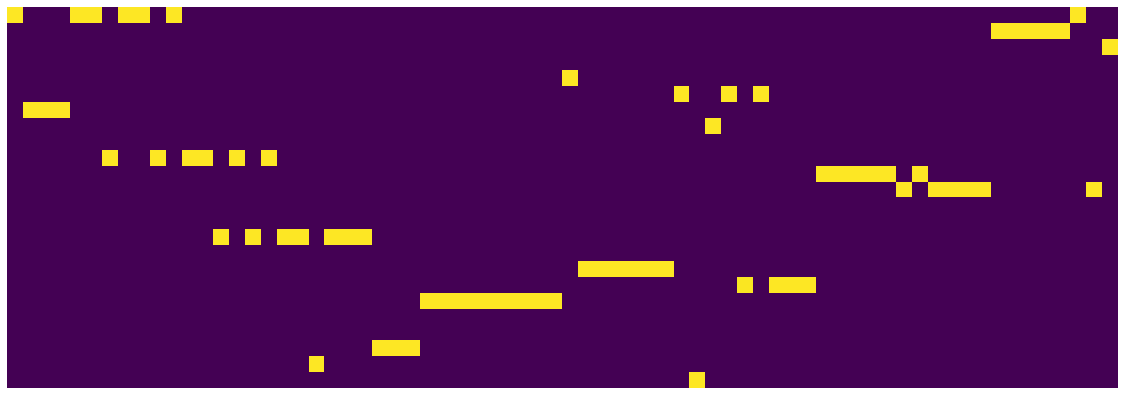

24 482 0.5169999999999996 0.4438481445424259


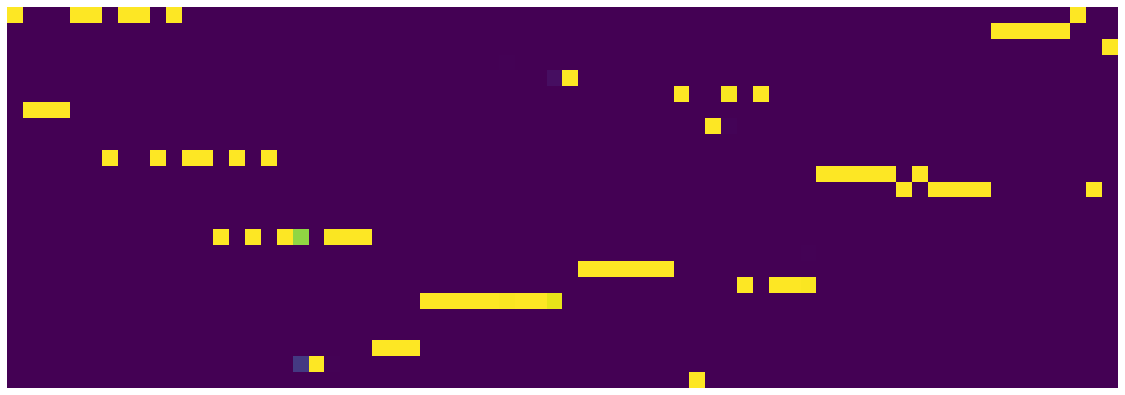

24 483 0.5159999999999996 0.4023656670935452


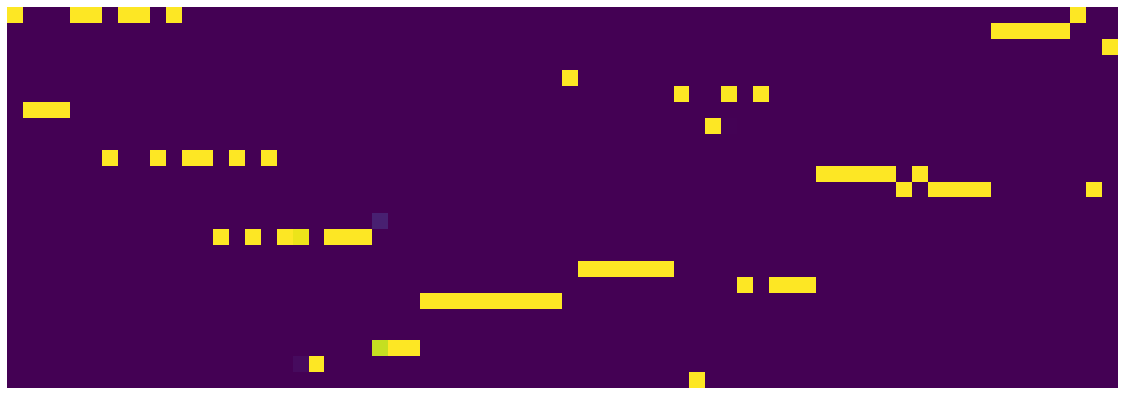

24 484 0.5149999999999996 0.41682273875921966


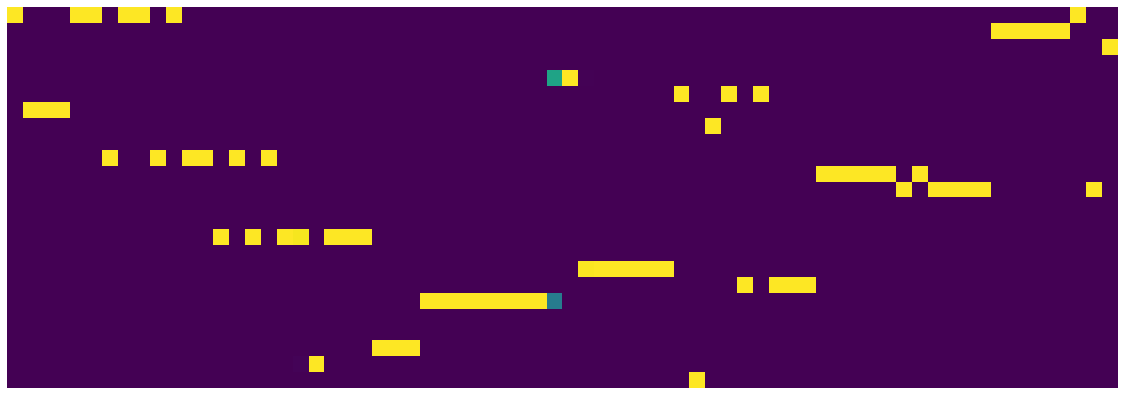

24 485 0.5139999999999996 0.4165896873921156


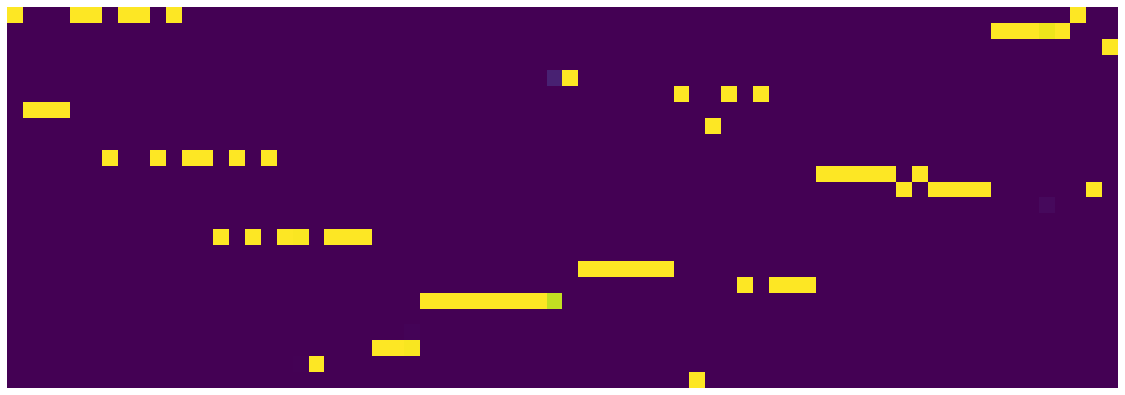

24 486 0.5129999999999996 0.4129910120740533


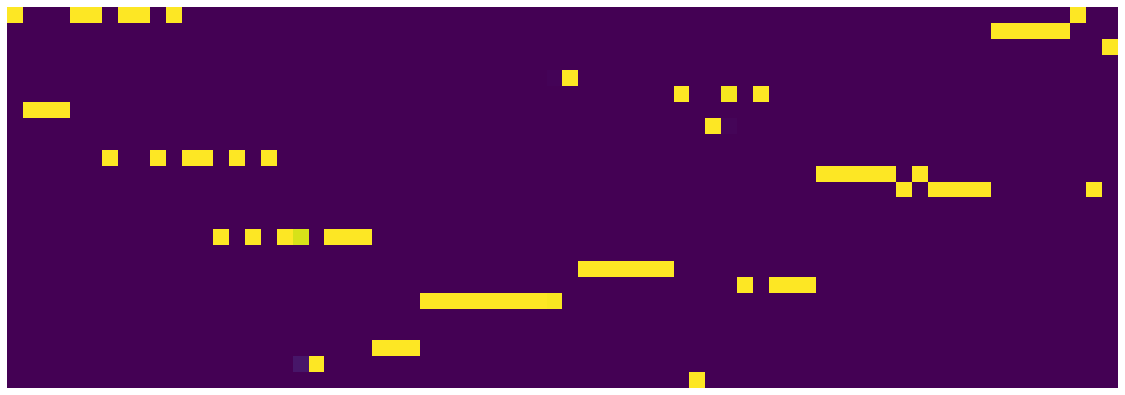

24 487 0.5119999999999996 0.4074646370485425


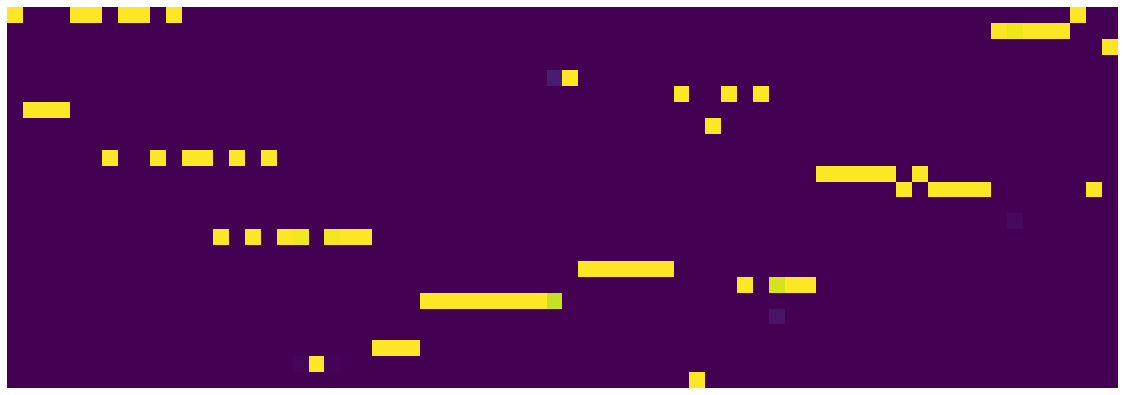

24 488 0.5109999999999996 0.40416272934526204


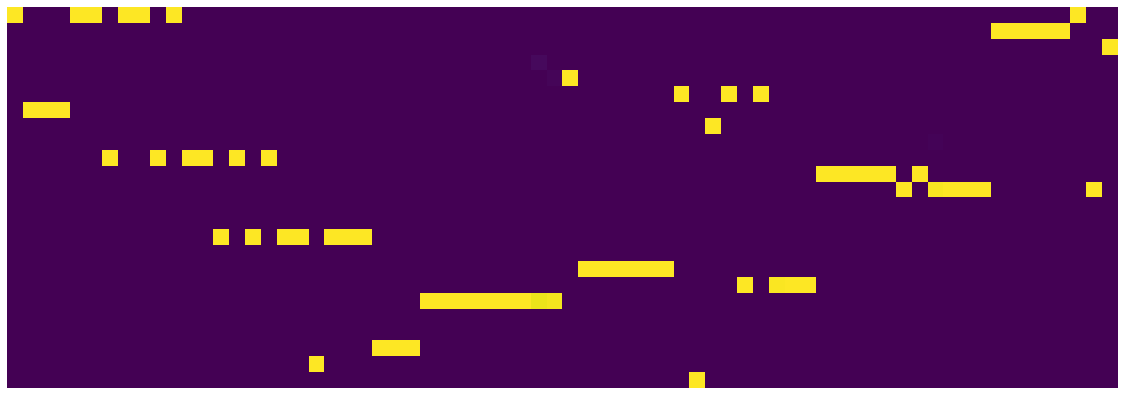

24 489 0.5099999999999996 0.4138730539008975


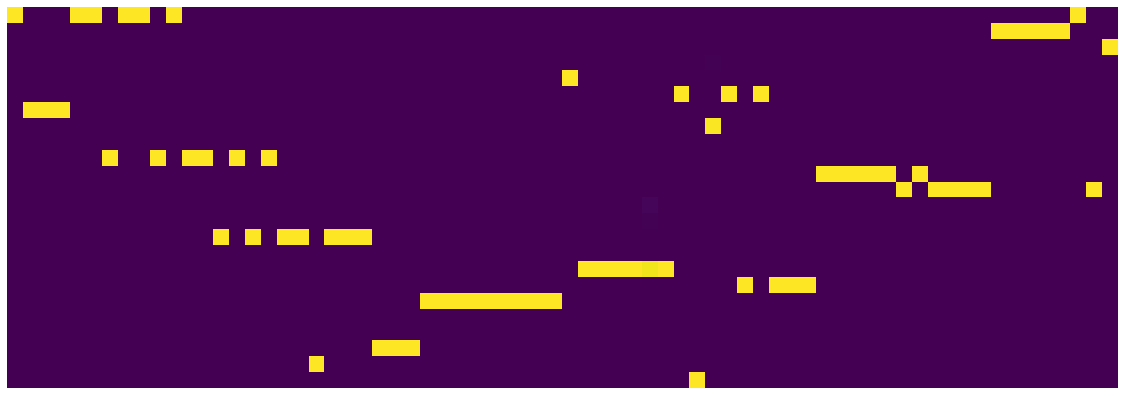

24 490 0.5089999999999996 0.430569779407233


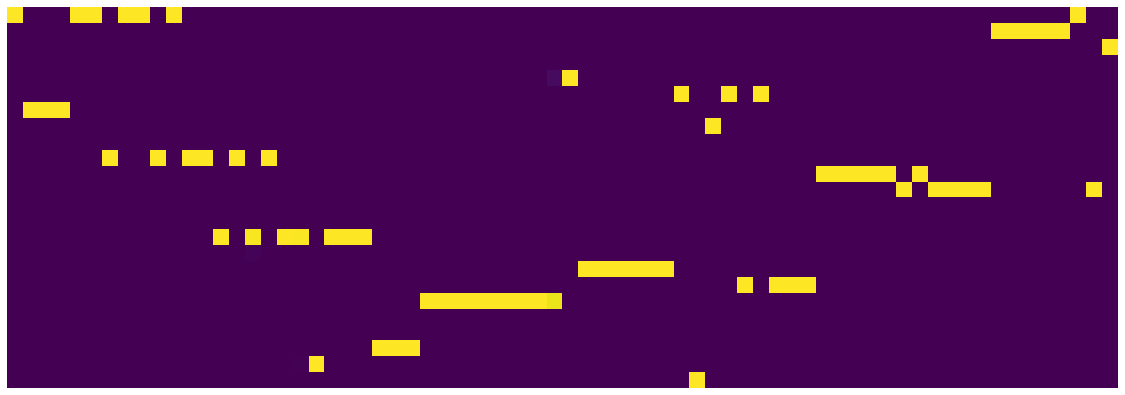

24 491 0.5079999999999996 0.41253181556239726


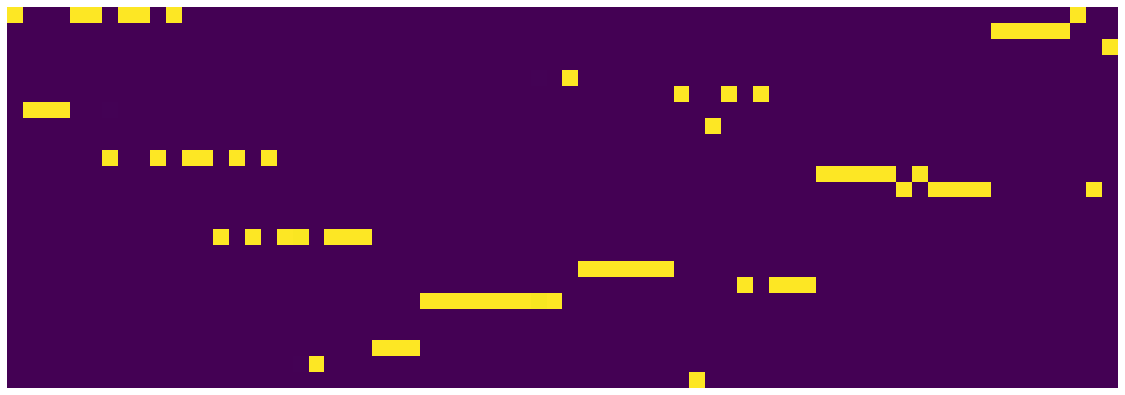

24 492 0.5069999999999996 0.43590582311153414


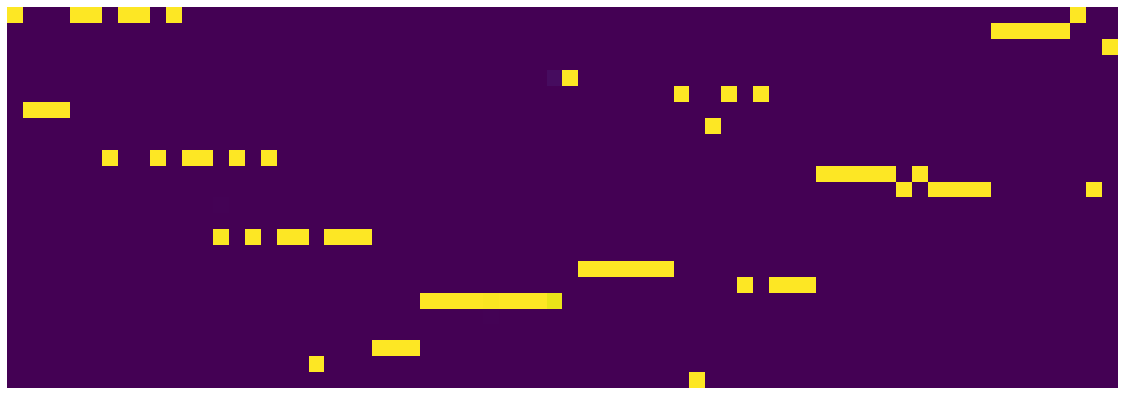

24 493 0.5059999999999996 0.400689160078764


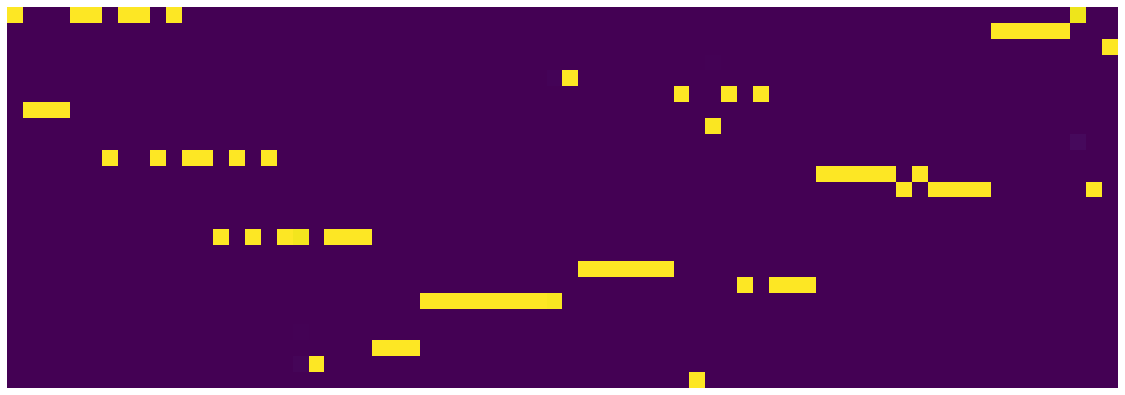

24 494 0.5049999999999996 0.41547472672536967


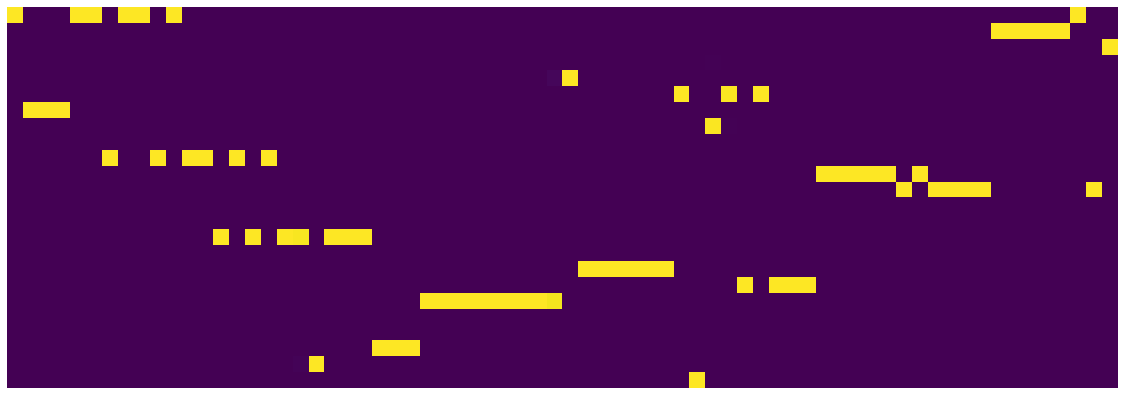

24 495 0.5039999999999996 0.40946384482085707


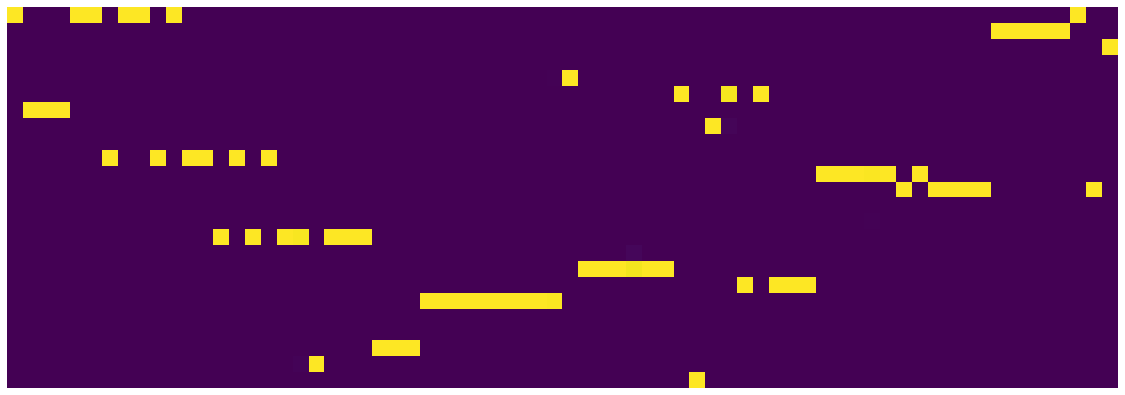

24 496 0.5029999999999996 0.42476923959329727


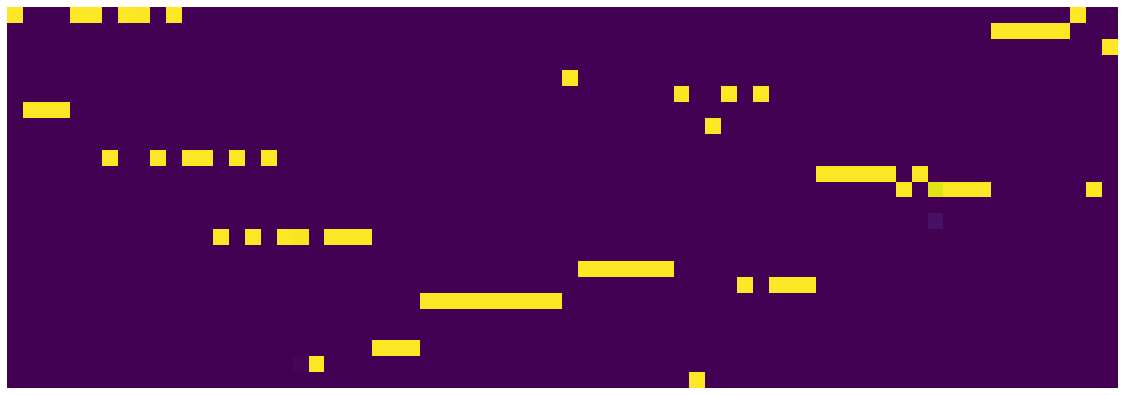

24 497 0.5019999999999996 0.40457814261317254


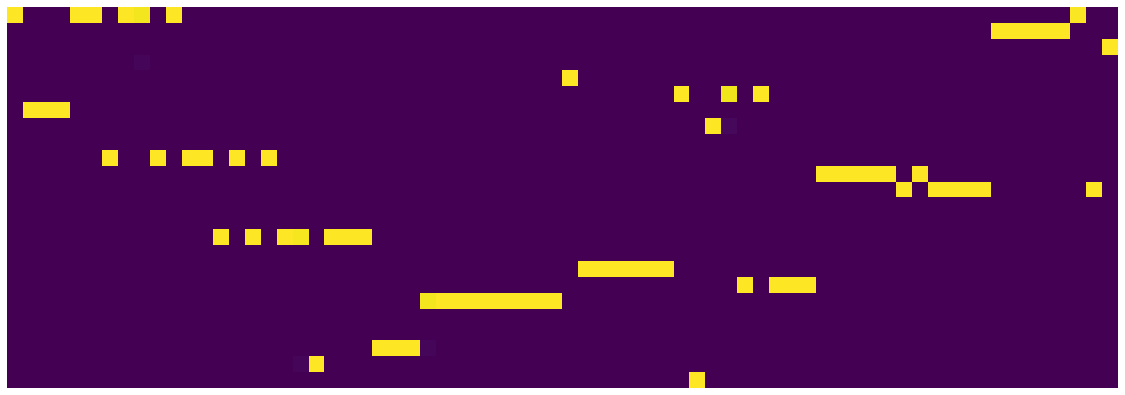

24 498 0.5009999999999996 0.4146551376208663


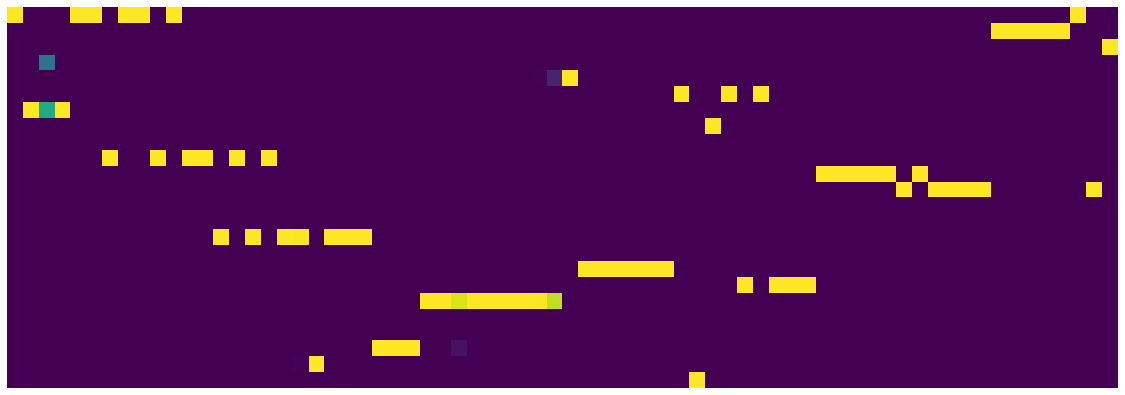

24 499 0.49999999999999956 0.4097714744508266


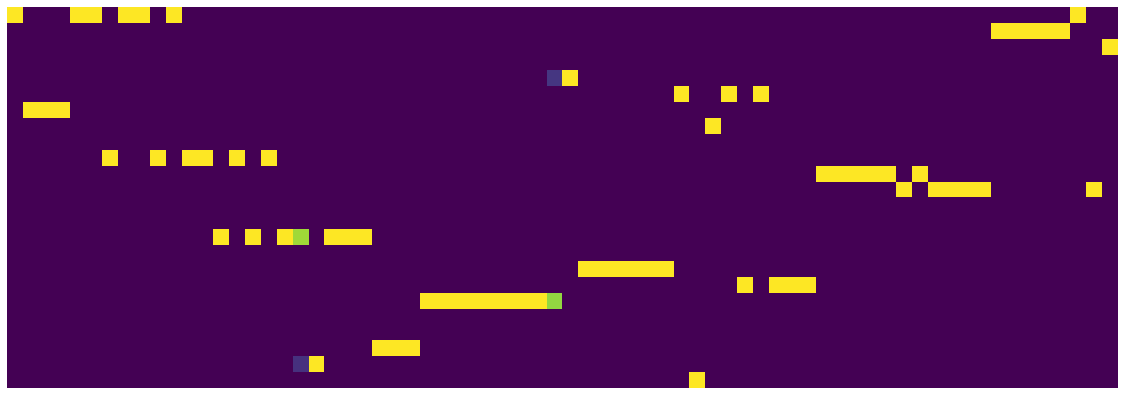

24 500 0.49899999999999956 0.42554876431822775


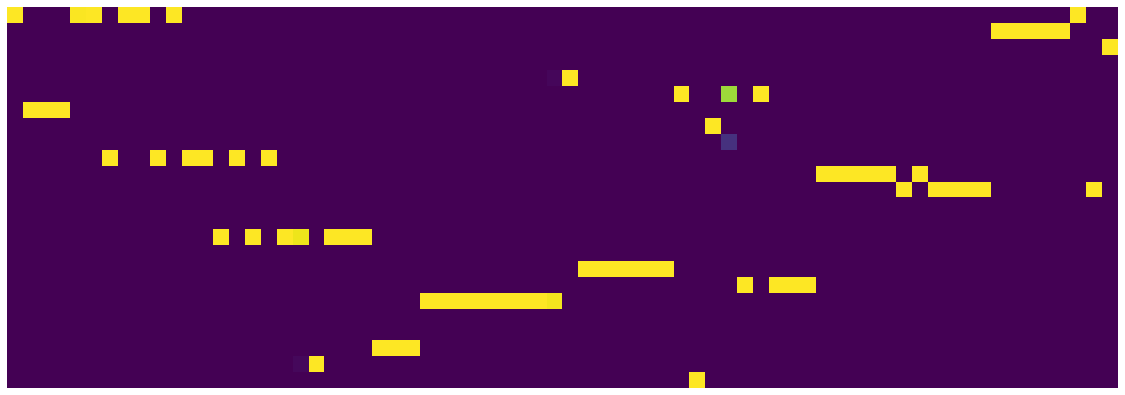

24 501 0.49799999999999955 0.4106951016932726


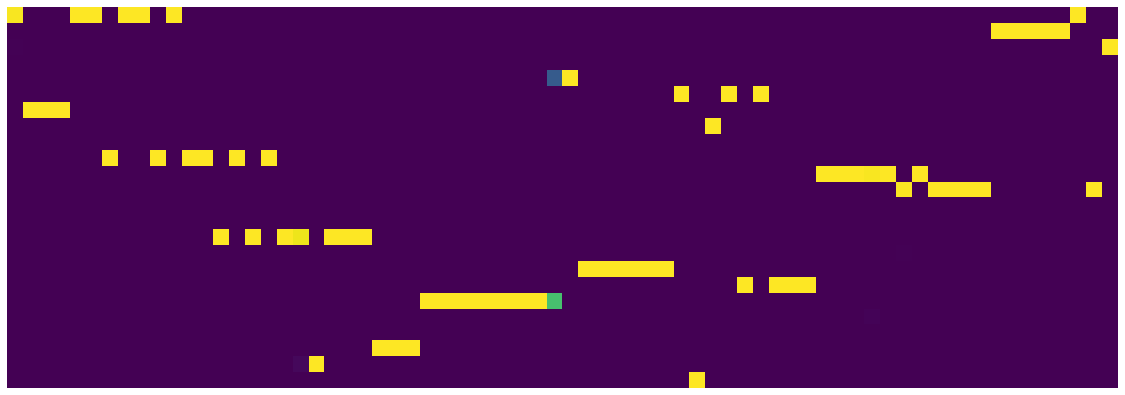

24 502 0.49699999999999955 0.40840963600203395


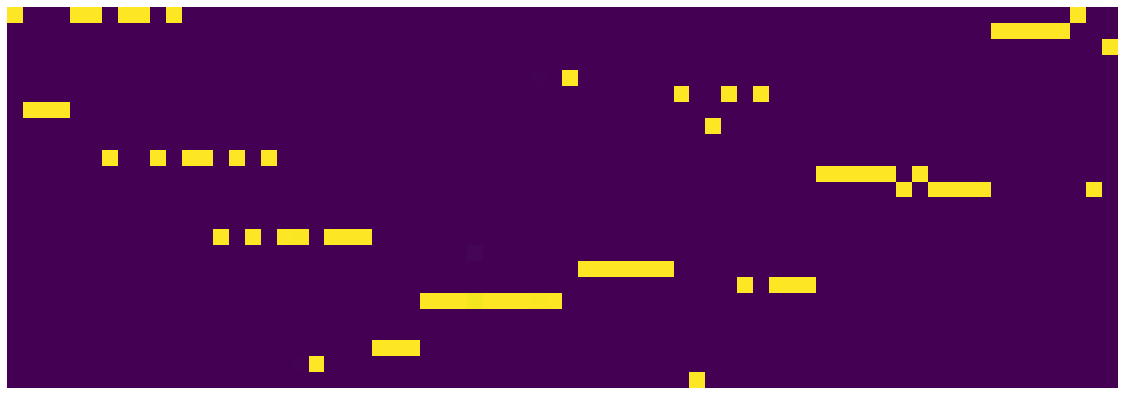

24 503 0.49599999999999955 0.4297620998695493


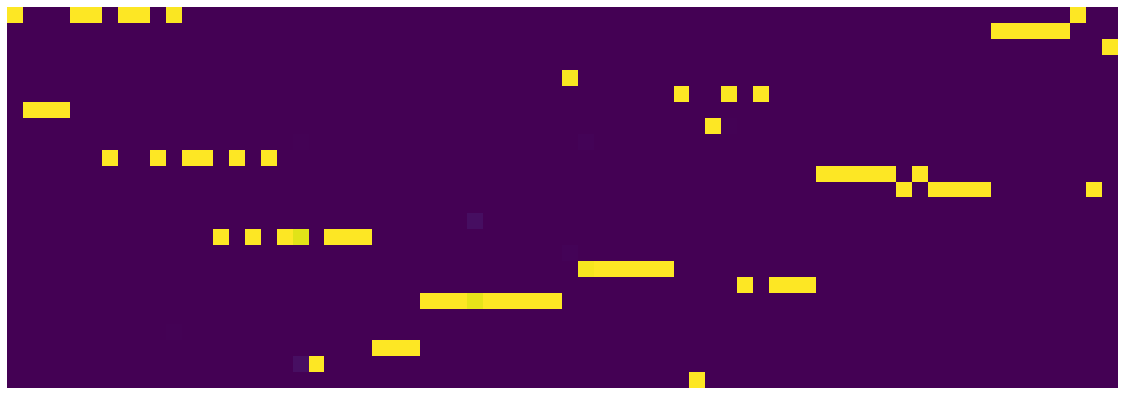

24 504 0.49499999999999955 0.40932401260361073


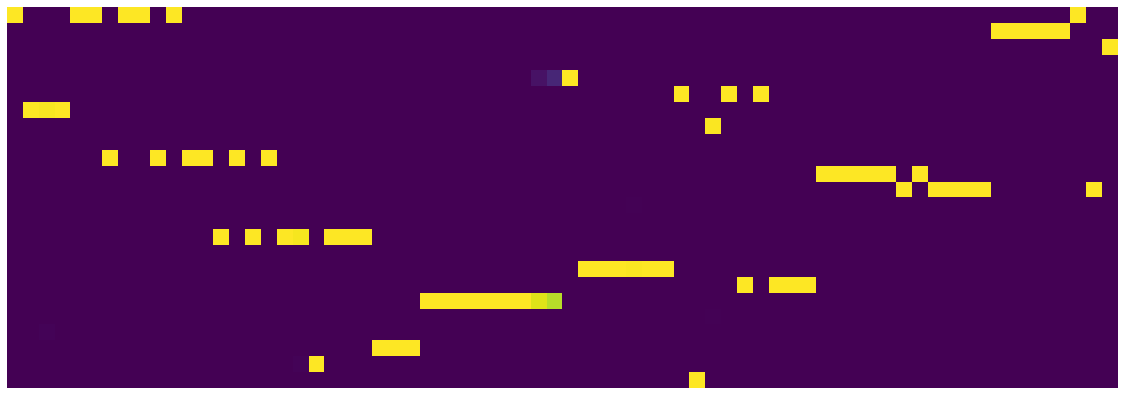

24 505 0.49399999999999955 0.41256505697965623


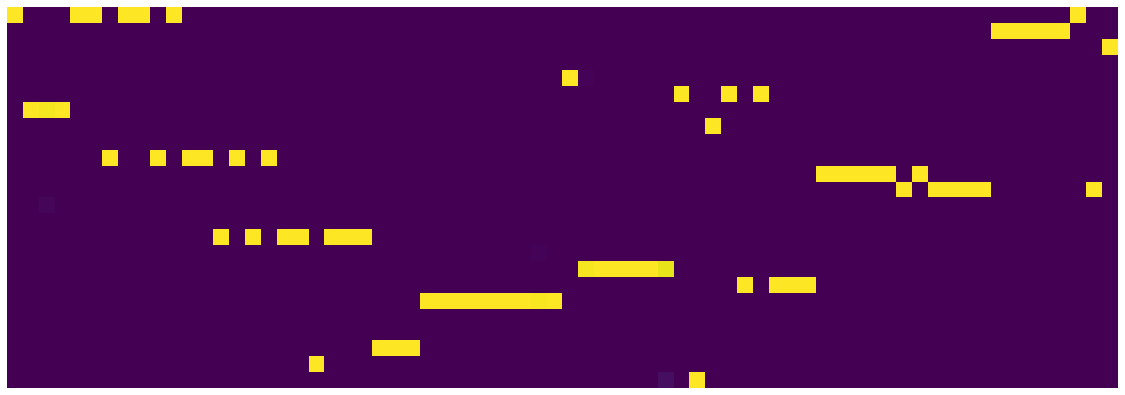

24 506 0.49299999999999955 0.41356766112148763


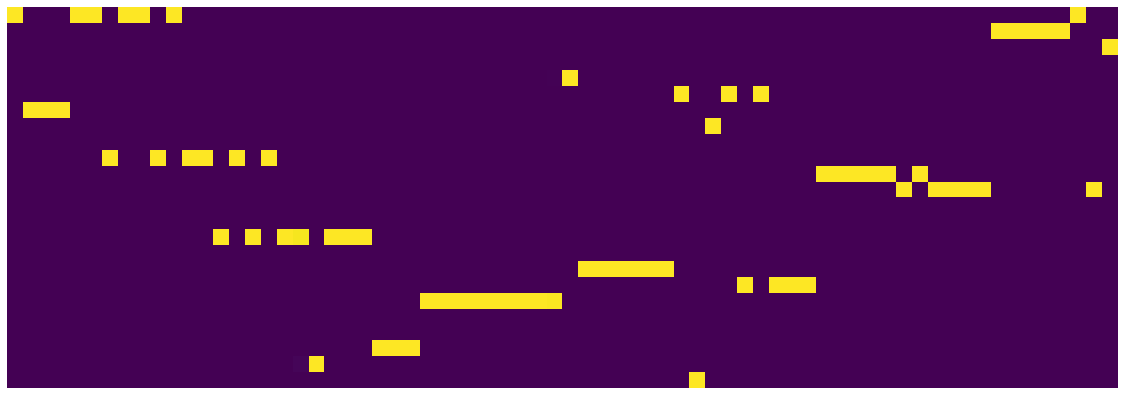

24 507 0.49199999999999955 0.4080628466792405


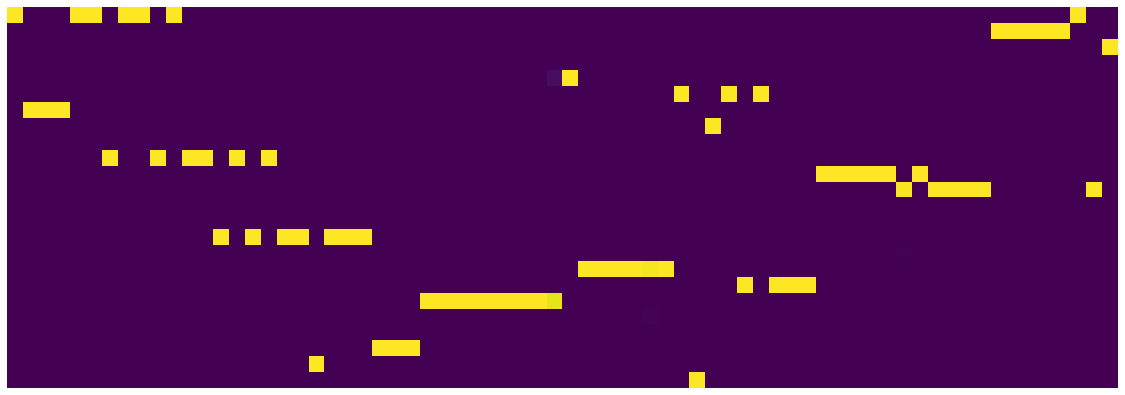

24 508 0.49099999999999955 0.418523907288909


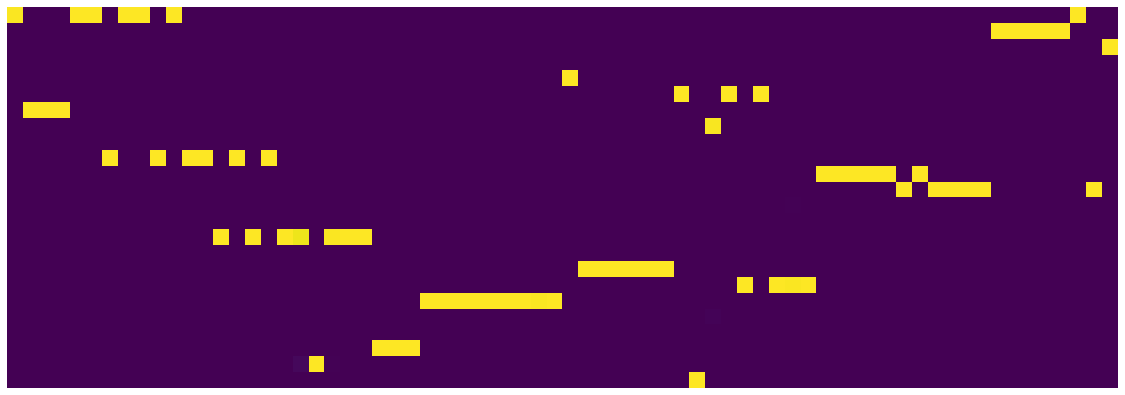

24 509 0.48999999999999955 0.4147132055833936


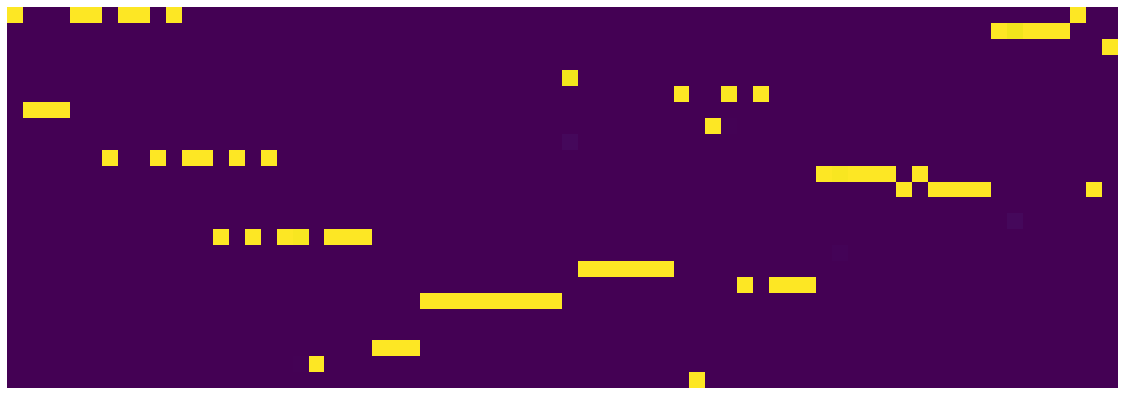

24 510 0.48899999999999955 0.408488382678479


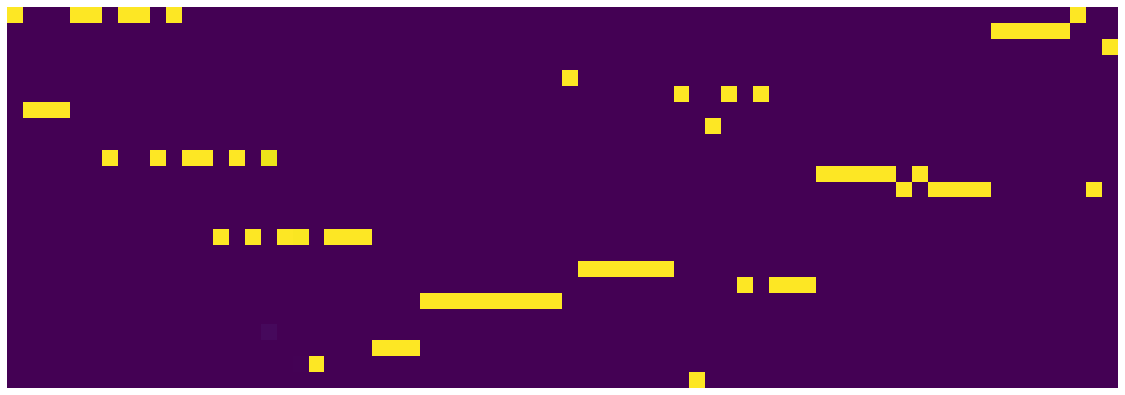

24 511 0.48799999999999955 0.42794354874640705


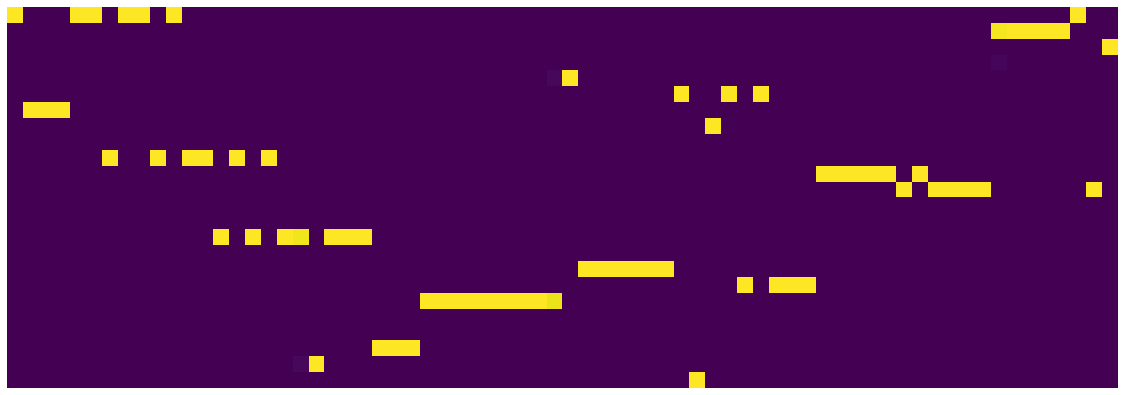

24 512 0.48699999999999954 0.4253028522245586


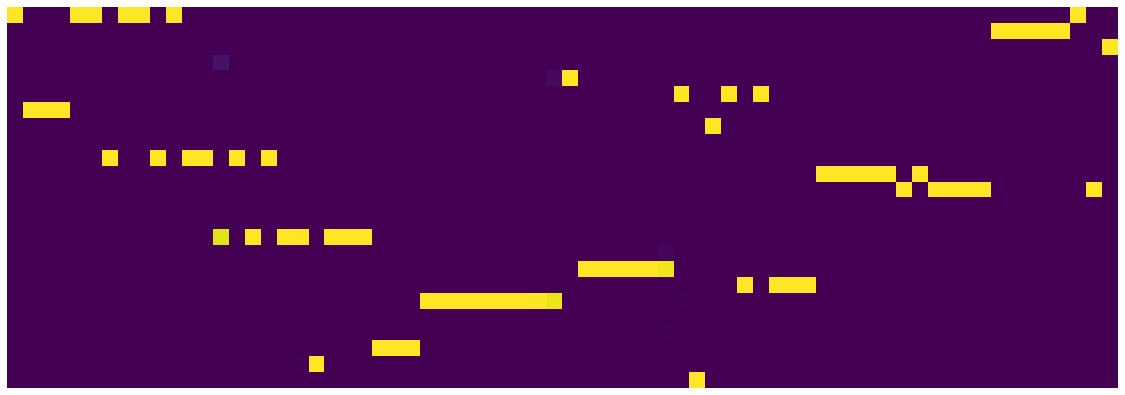

24 513 0.48599999999999954 0.42322820965200664


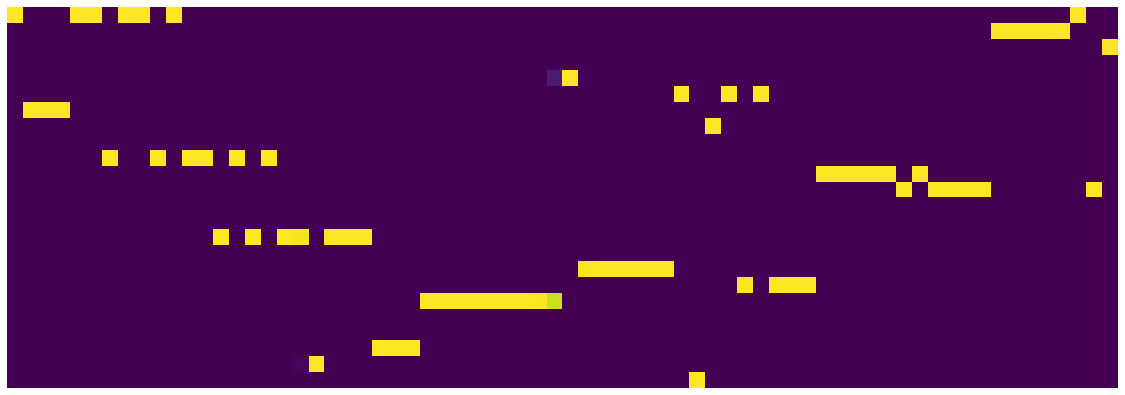

24 514 0.48499999999999954 0.40468293707817793


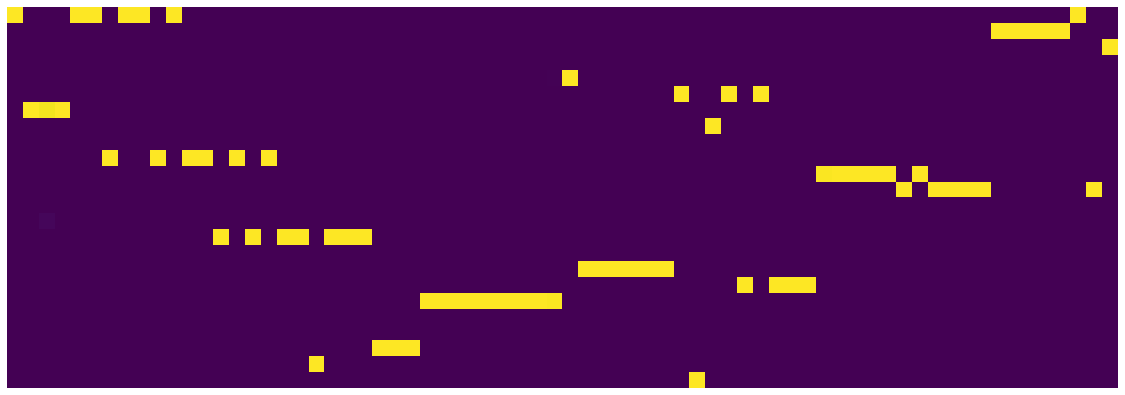

24 515 0.48399999999999954 0.4123221113346517


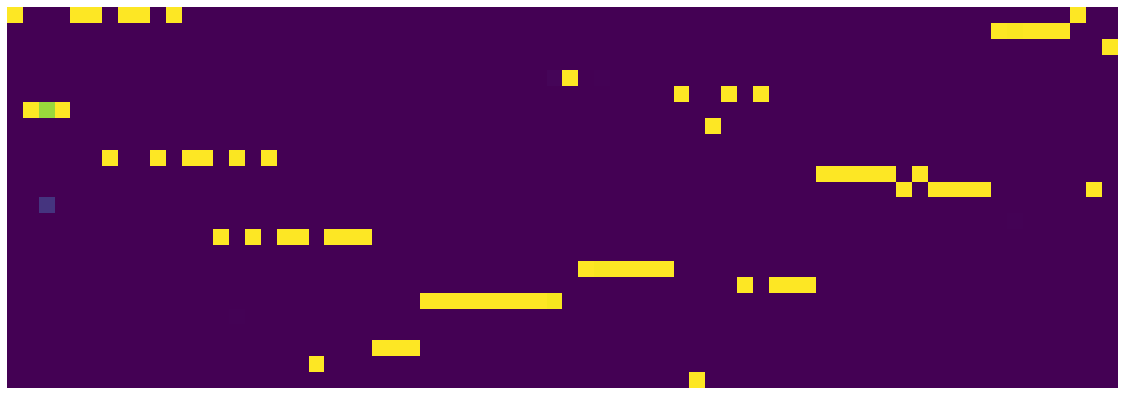

24 516 0.48299999999999954 0.4063199802301824


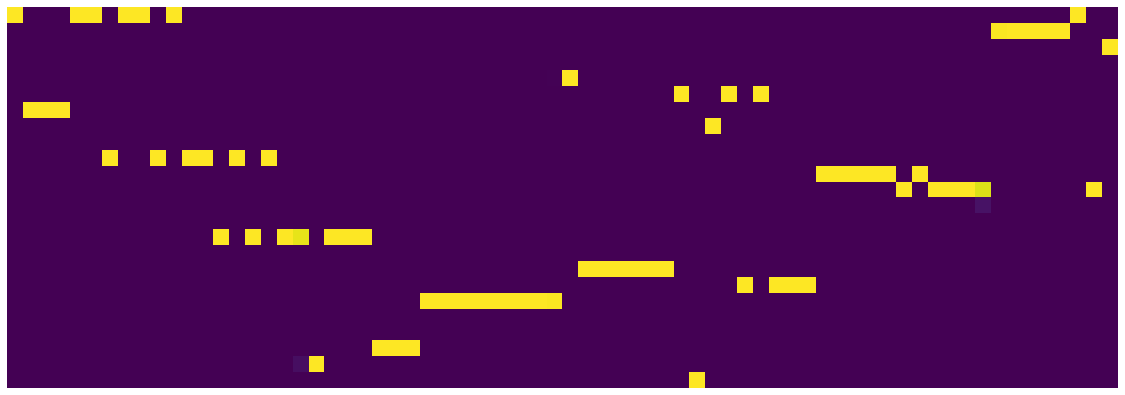

24 517 0.48199999999999954 0.40870159566402436


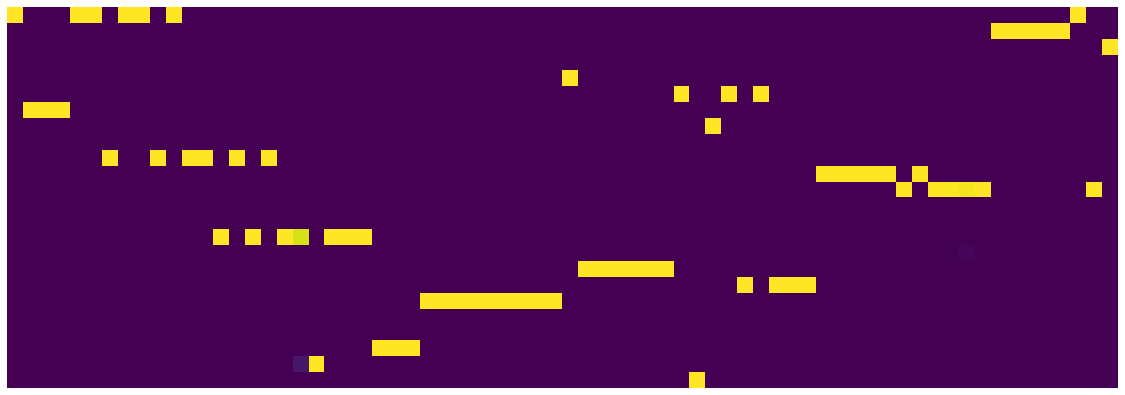

24 518 0.48099999999999954 0.4150320663116872


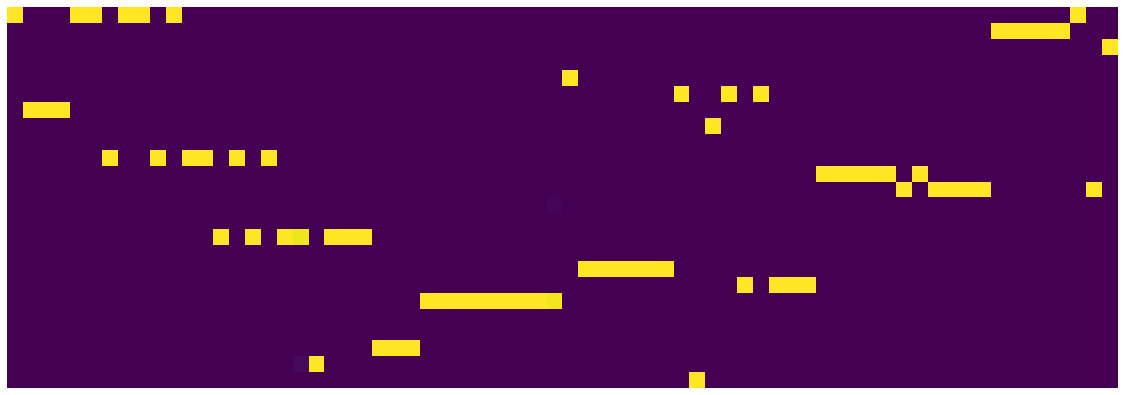

24 519 0.47999999999999954 0.4116156046278775


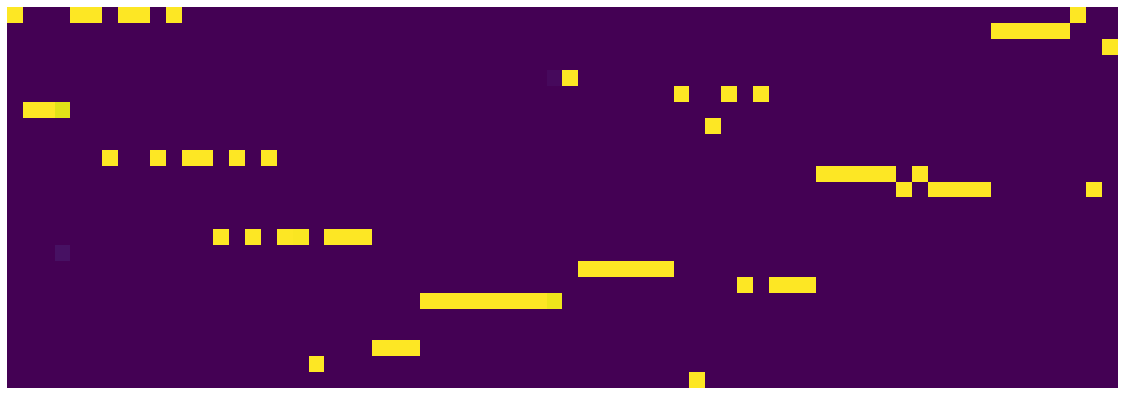

24 520 0.47899999999999954 0.41358531937003135


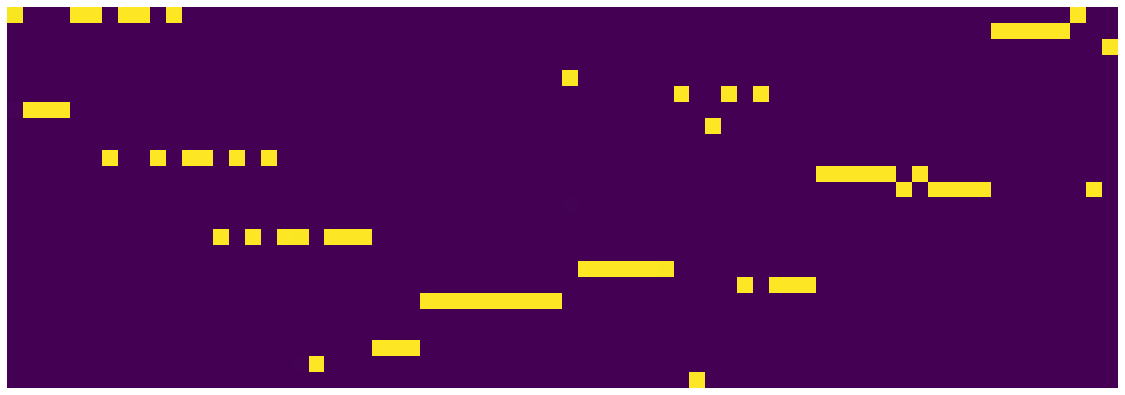

24 521 0.47799999999999954 0.4226937610656023


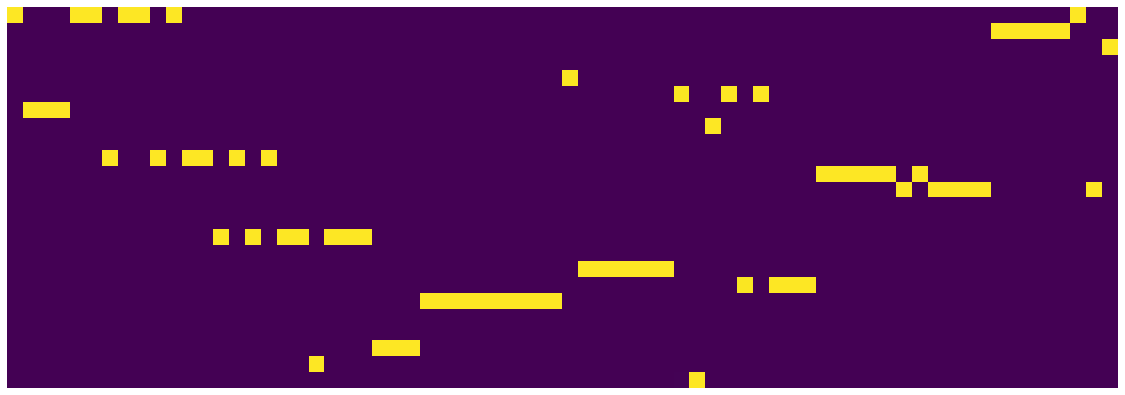

24 522 0.47699999999999954 0.4046506820246577


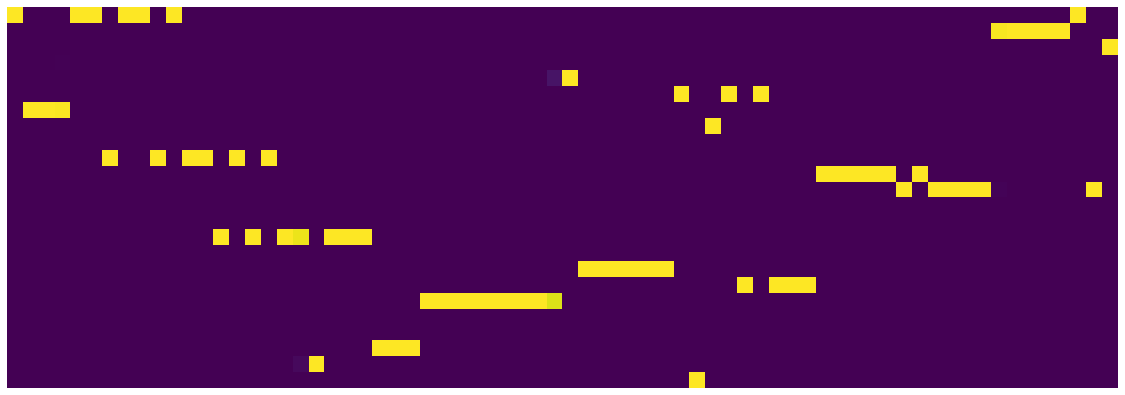

24 523 0.47599999999999953 0.421532928571105


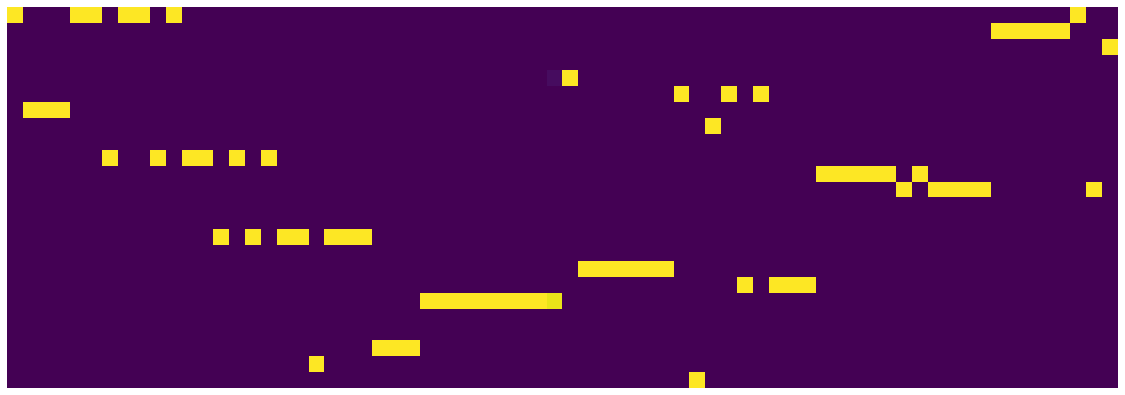

24 524 0.47499999999999953 0.42429842045530675


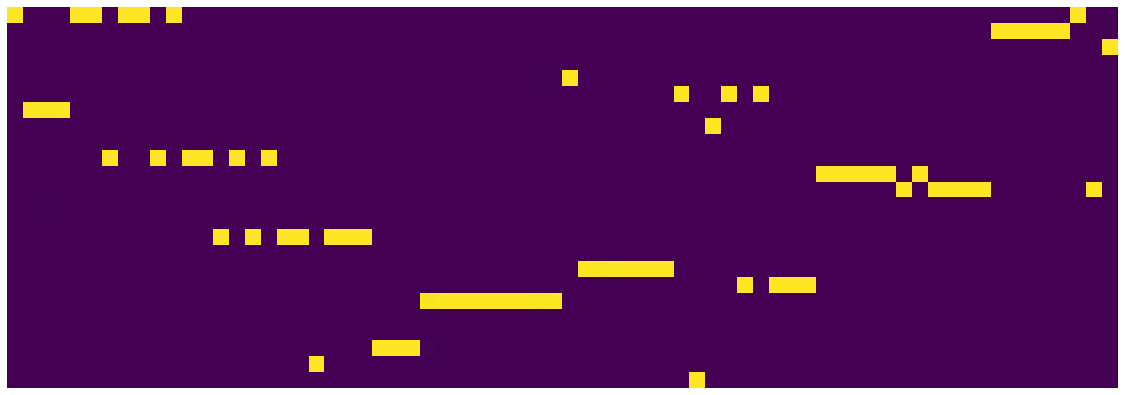

24 525 0.47399999999999953 0.4121383092366159


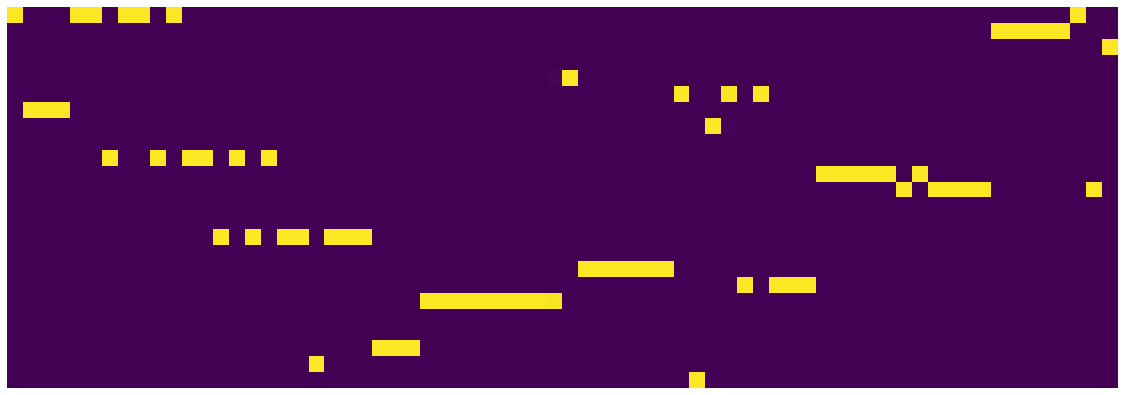

24 526 0.47299999999999953 0.4104031546972692


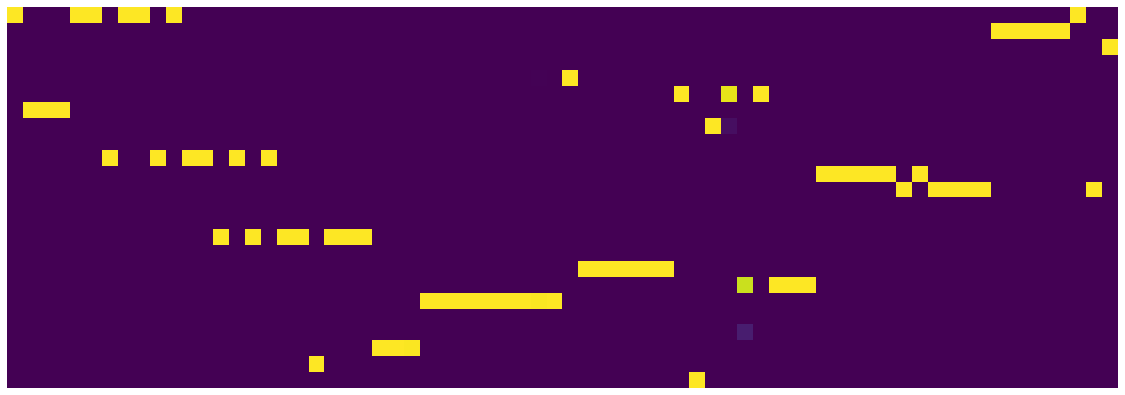

24 527 0.47199999999999953 0.40867795450612904


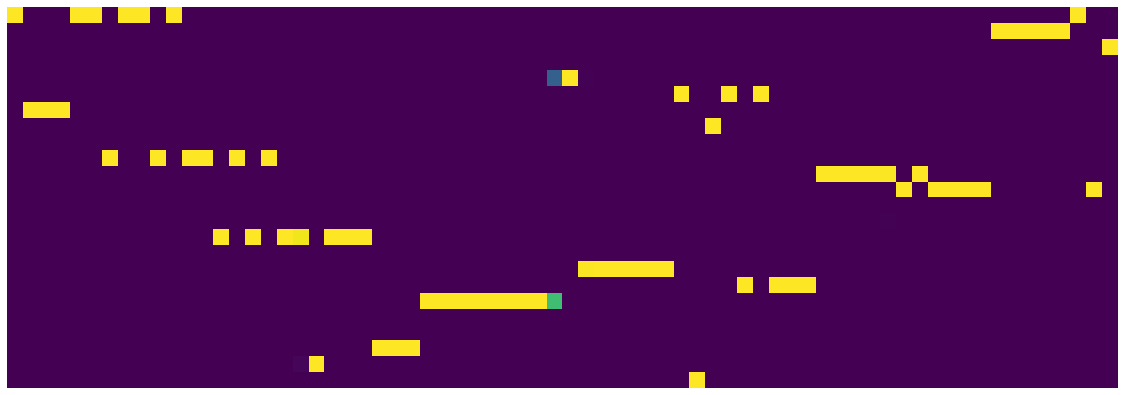

24 528 0.47099999999999953 0.40885395677760245


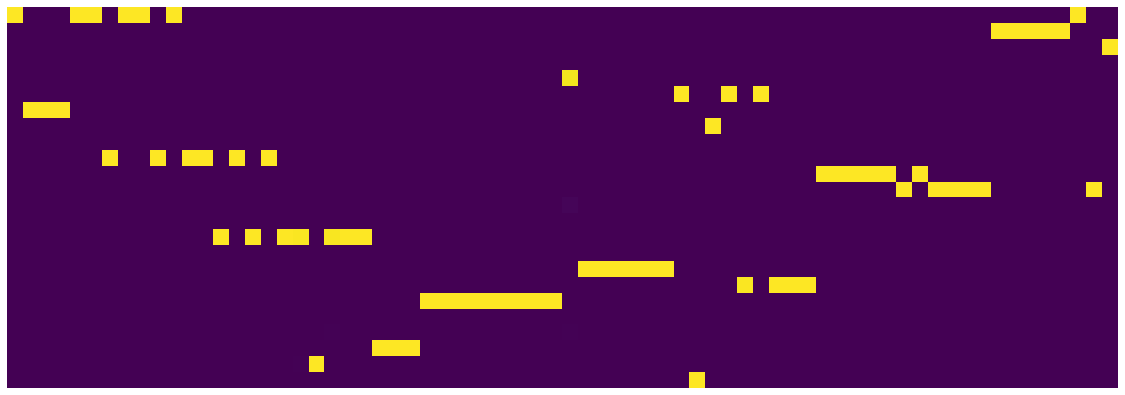

24 529 0.46999999999999953 0.41833861554041507


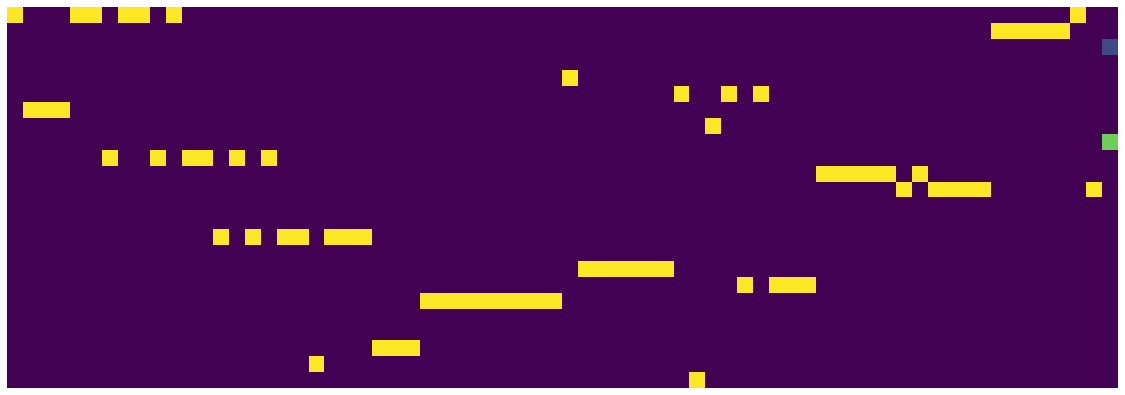

24 530 0.46899999999999953 0.42334901075810194


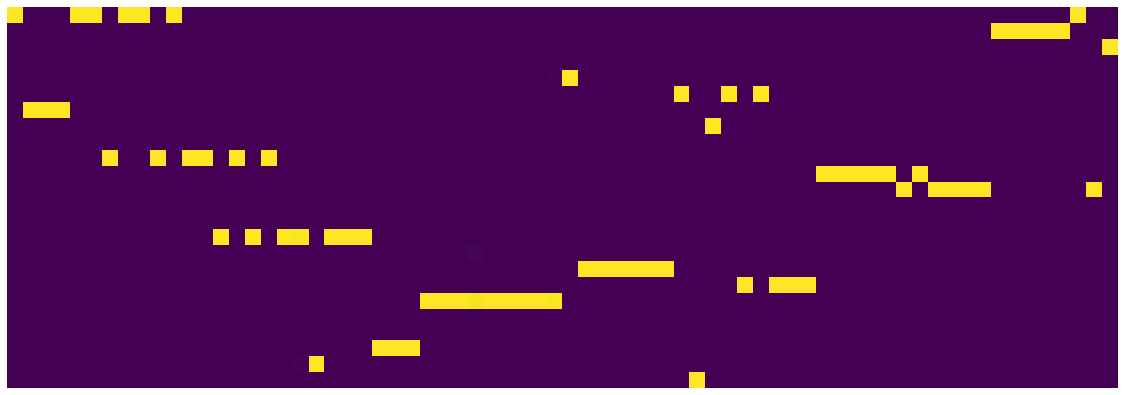

24 531 0.4679999999999995 0.41973836487159133


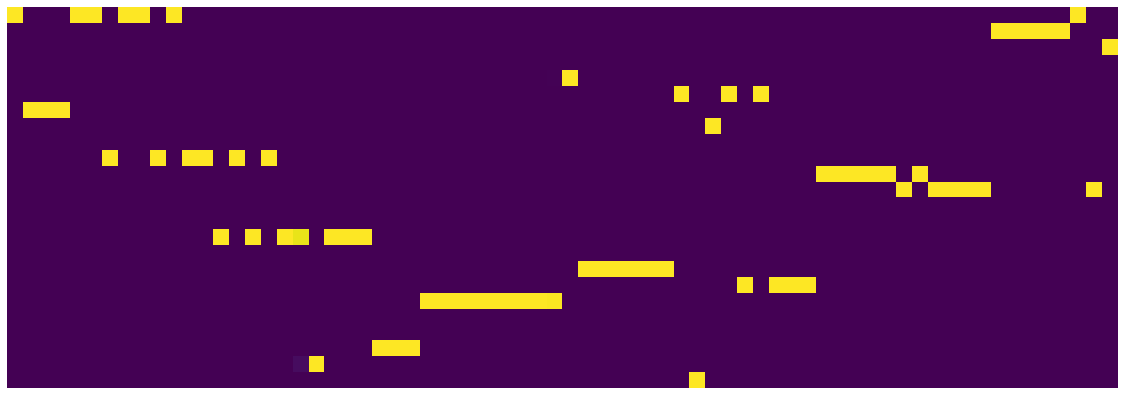

24 532 0.4669999999999995 0.4193615049123764


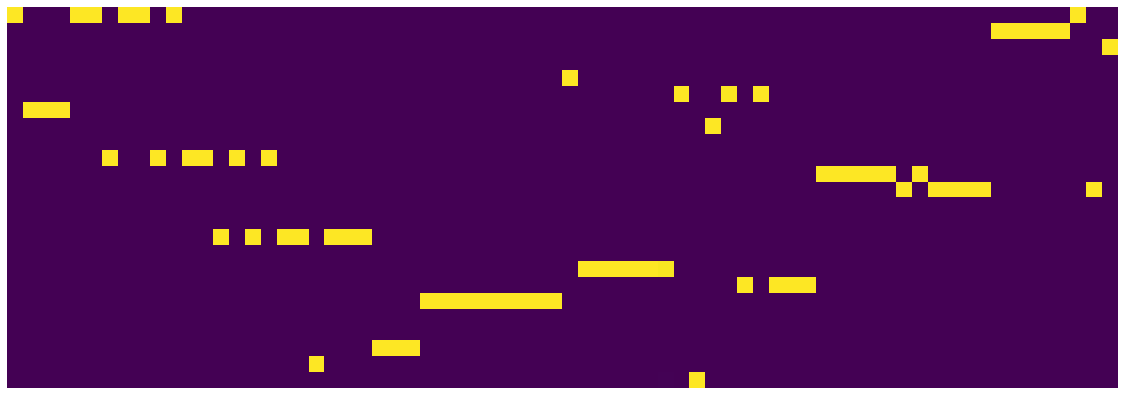

24 533 0.4659999999999995 0.41632364196702837


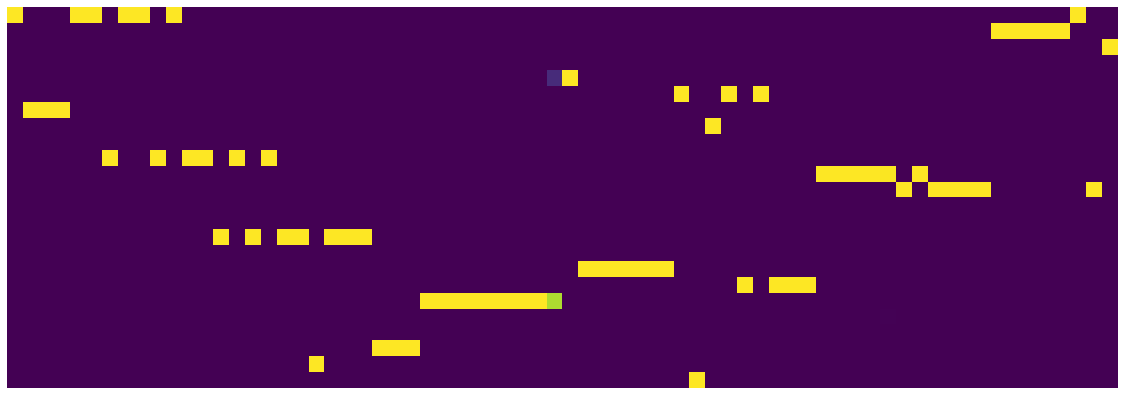

24 534 0.4649999999999995 0.4113847970962524


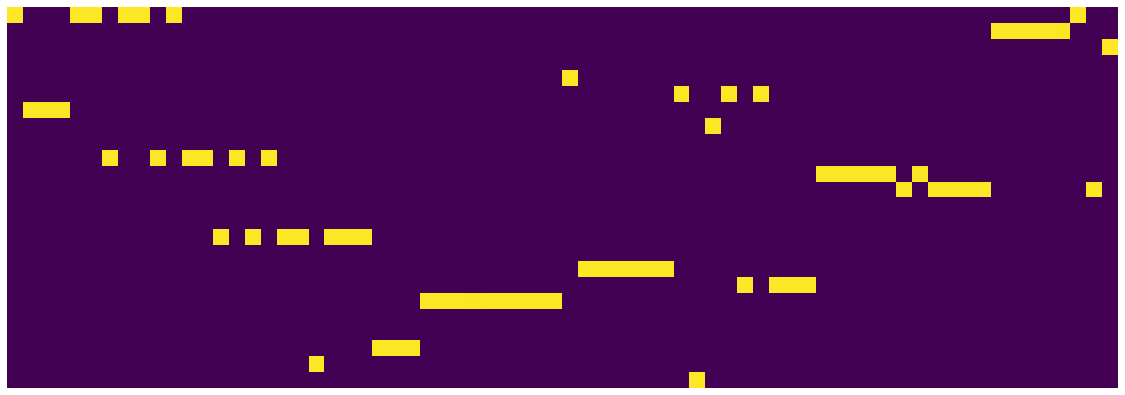

24 535 0.4639999999999995 0.415976969897747


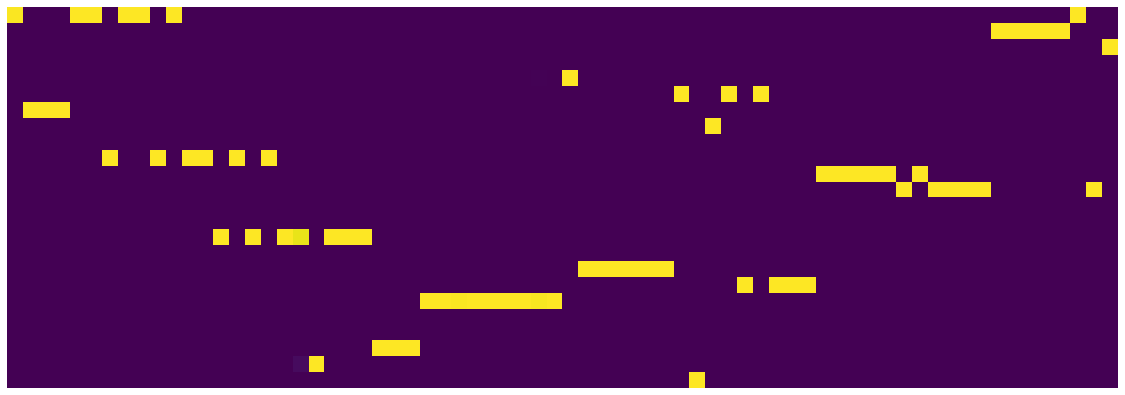

24 536 0.4629999999999995 0.41342243254184724


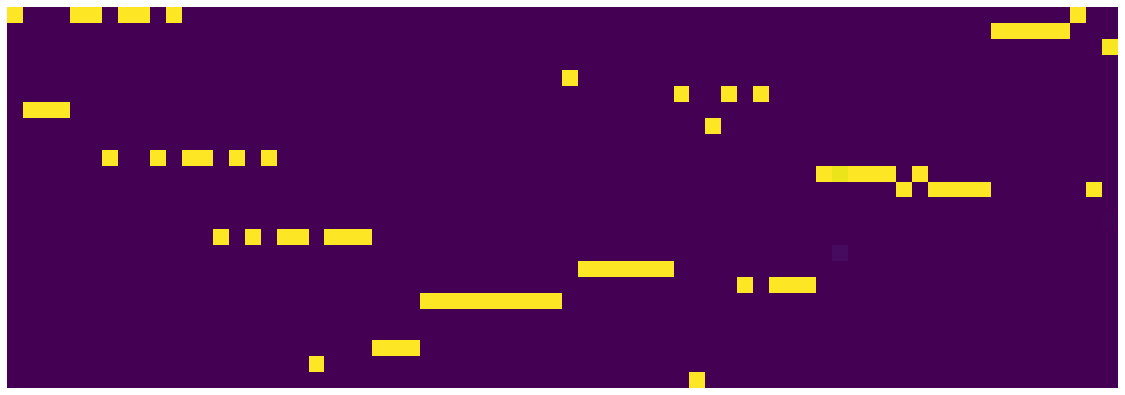

24 537 0.4619999999999995 0.40969657991081476


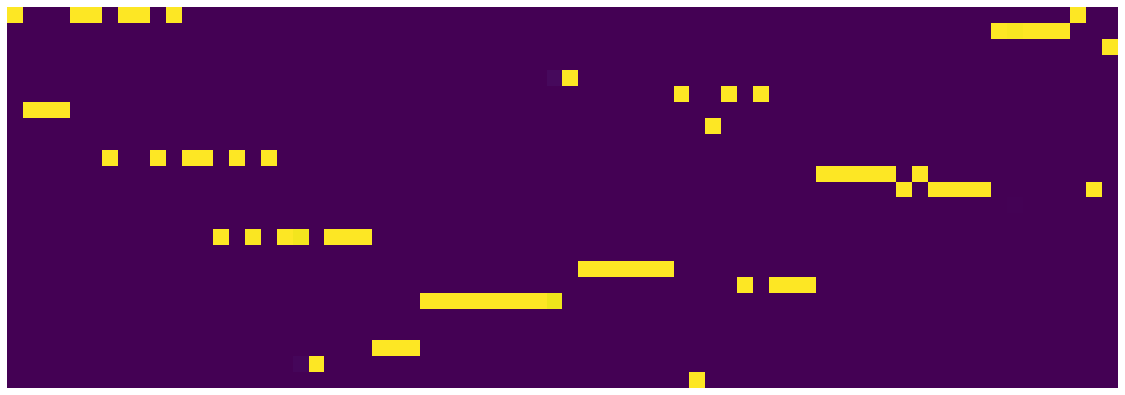

24 538 0.4609999999999995 0.4101215426810086


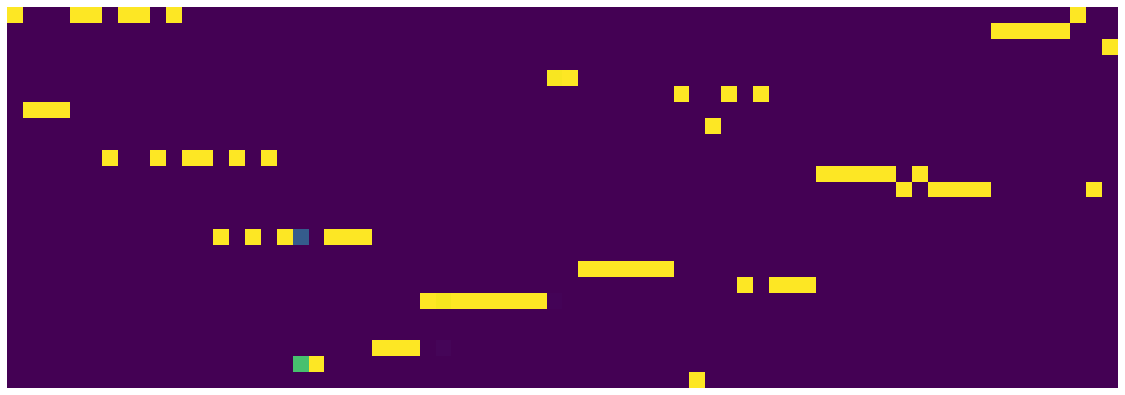

24 539 0.4599999999999995 0.4214072017930448


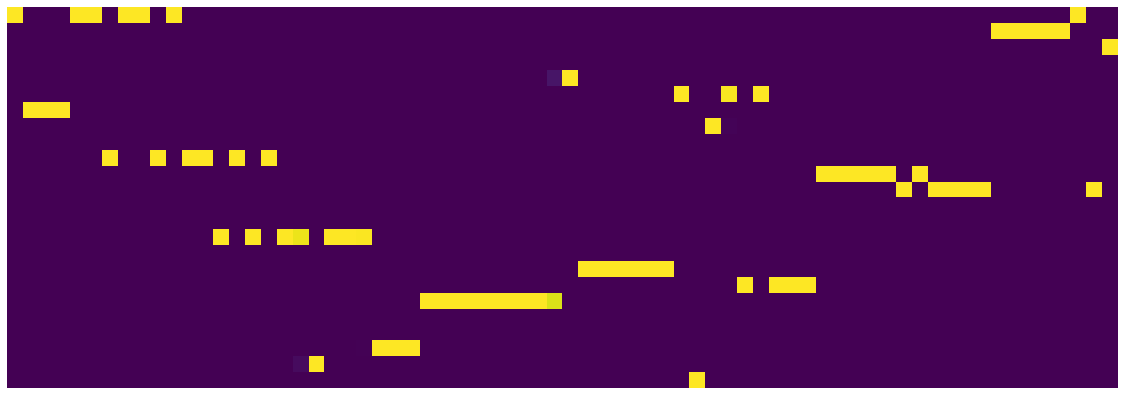

24 540 0.4589999999999995 0.4148797446861863


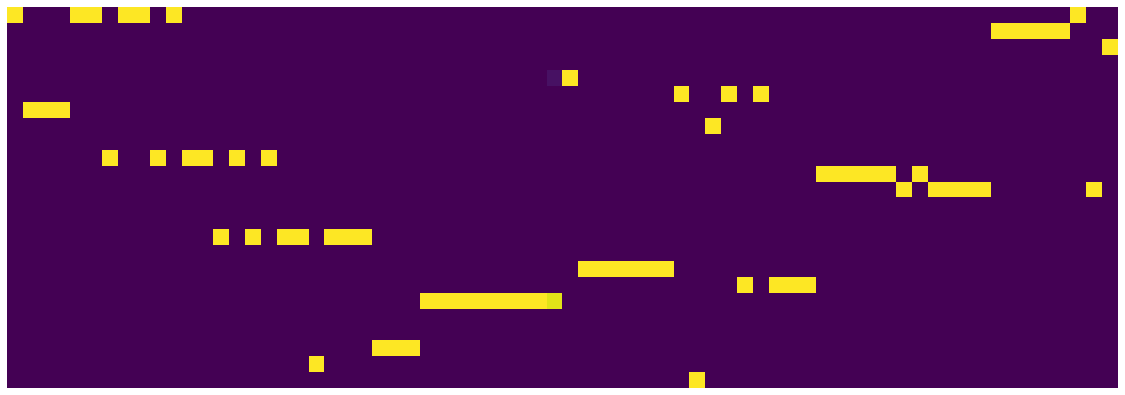

24 541 0.4579999999999995 0.4123658693395555


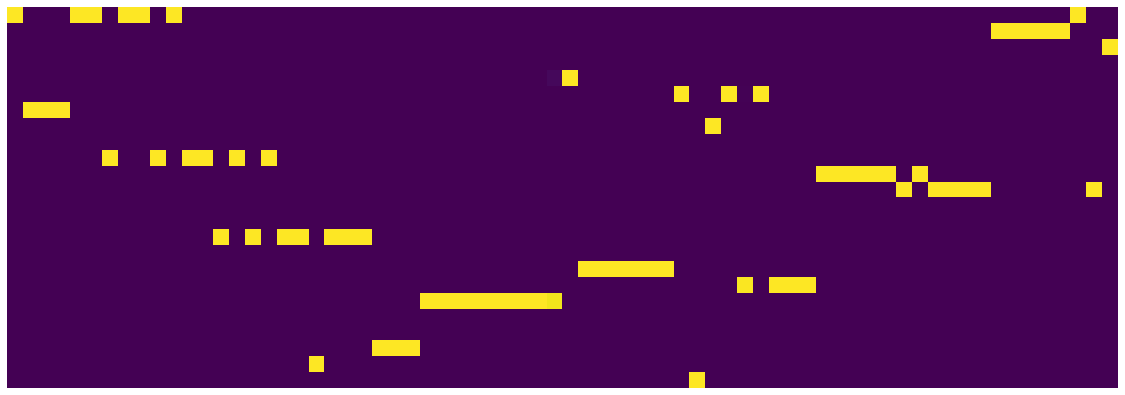

24 542 0.4569999999999995 0.41288371635600923


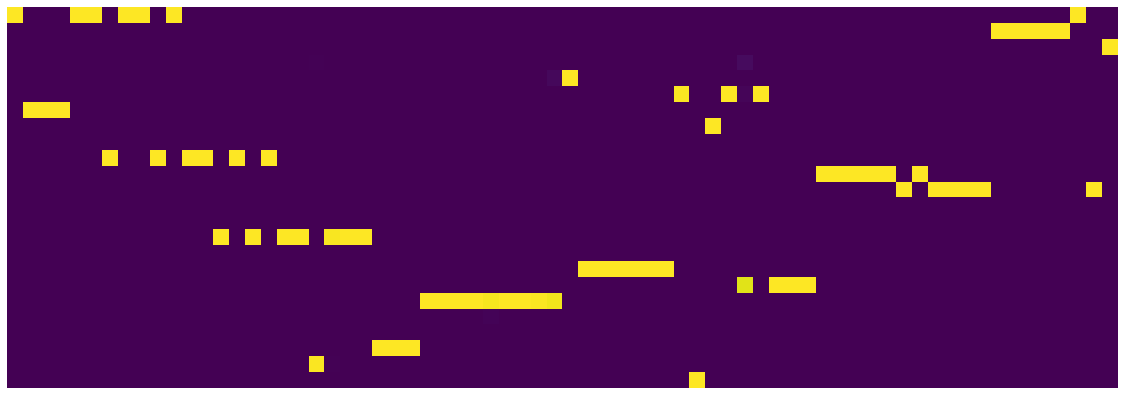

24 543 0.4559999999999995 0.41905131079256536


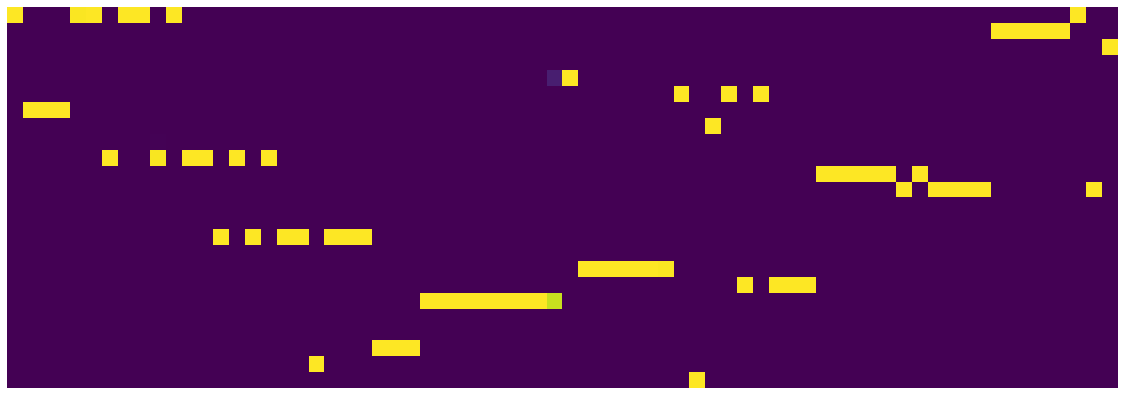

24 544 0.4549999999999995 0.42084608916193245


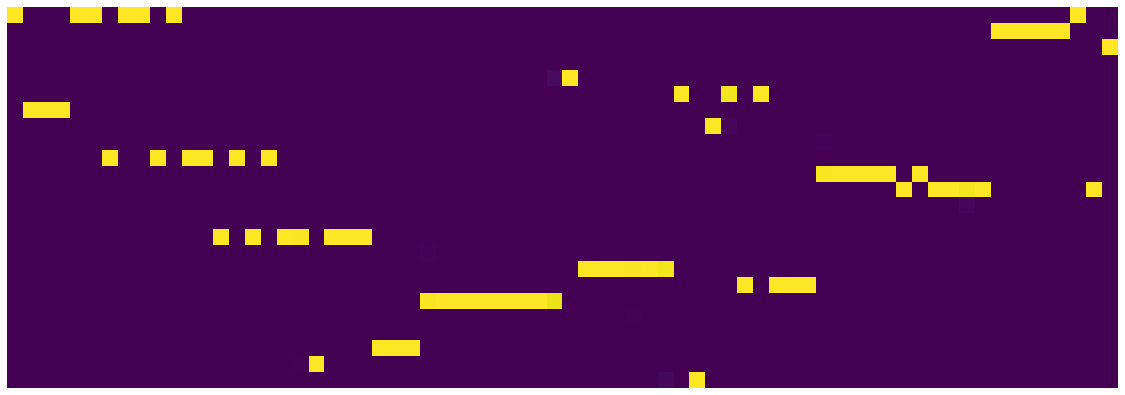

24 545 0.4539999999999995 0.4100541495718062


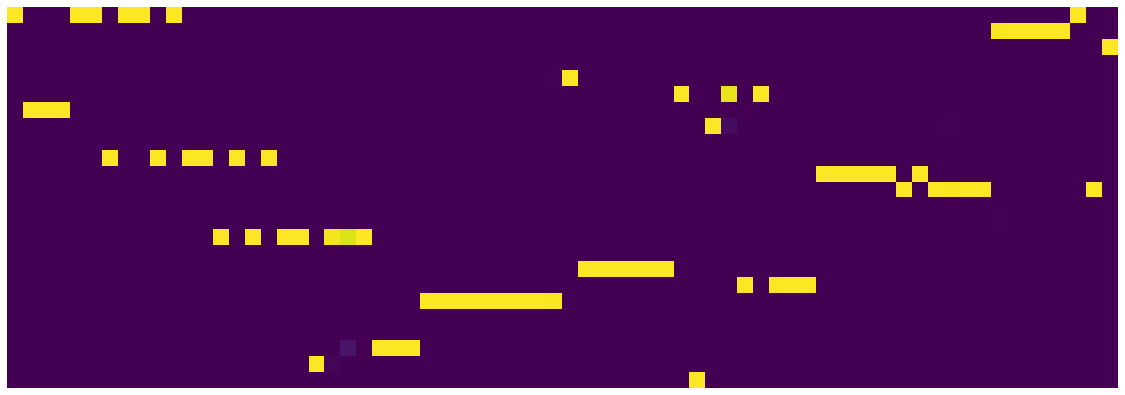

24 546 0.4529999999999995 0.4113992802798748


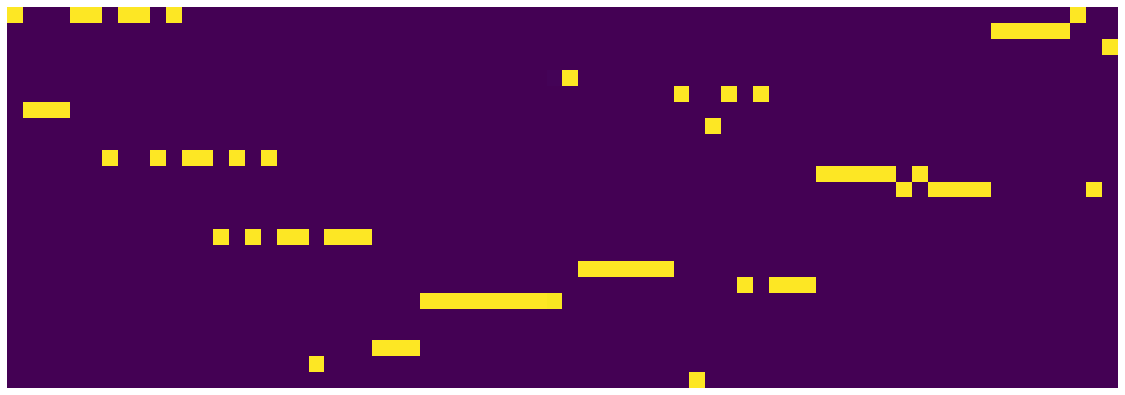

24 547 0.4519999999999995 0.4078264151699841


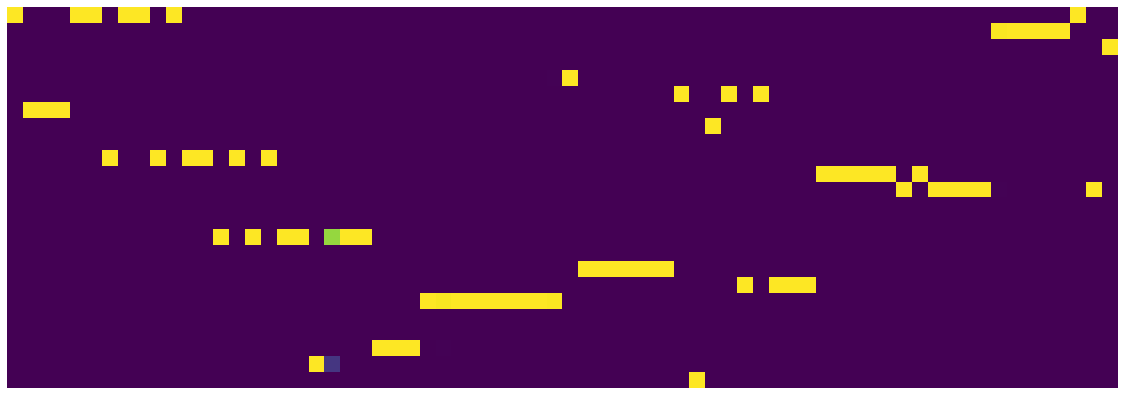

24 548 0.4509999999999995 0.4149965171702206


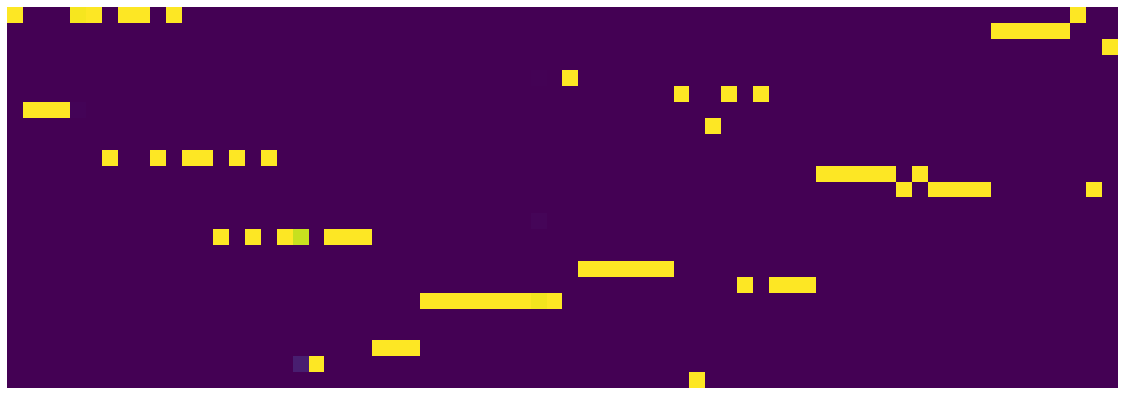

24 549 0.4499999999999995 0.420770020596683


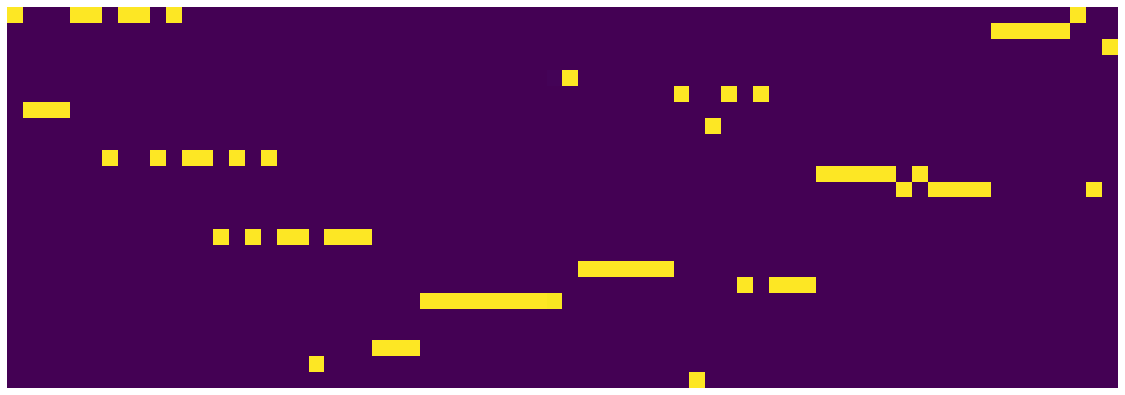

24 550 0.4489999999999995 0.42061154553666713


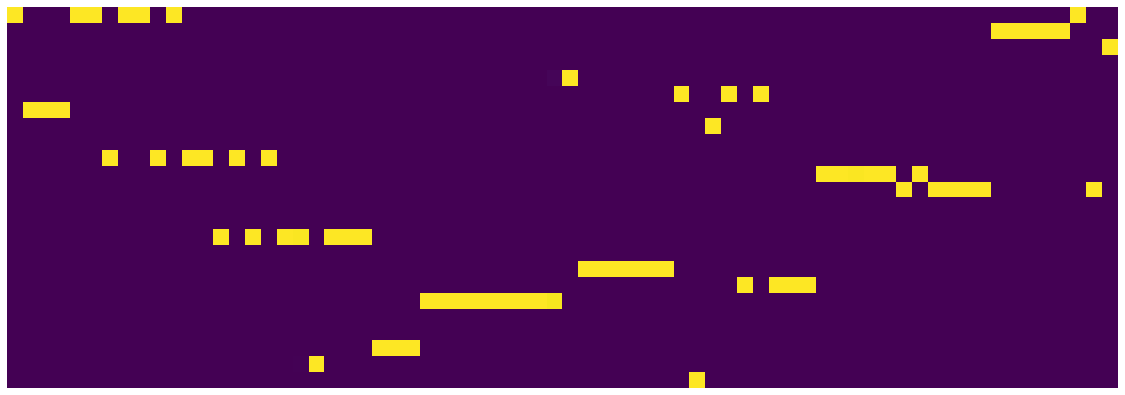

24 551 0.4479999999999995 0.4266358627937734


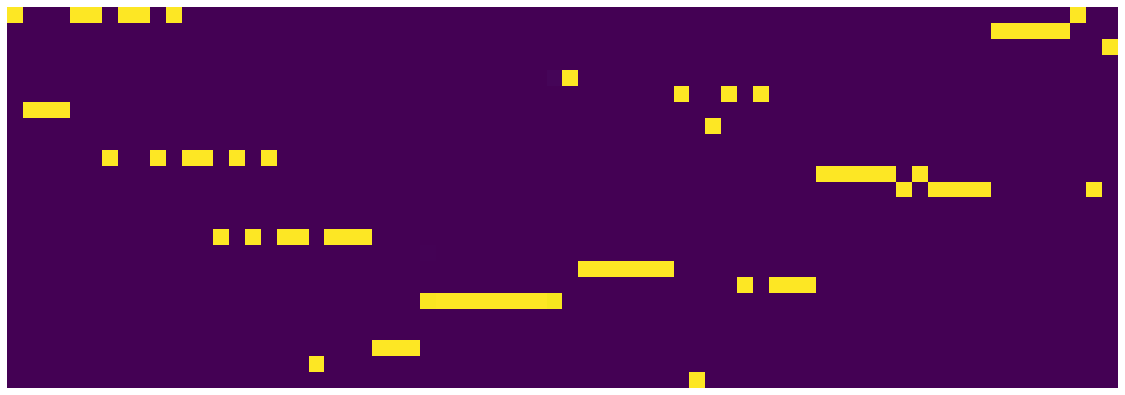

24 552 0.4469999999999995 0.4086427379399538


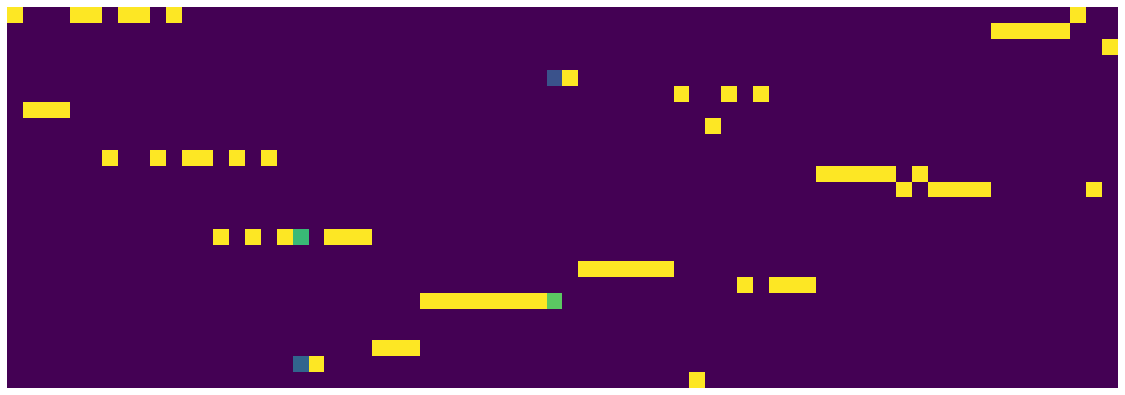

24 553 0.4459999999999995 0.4104145086370409


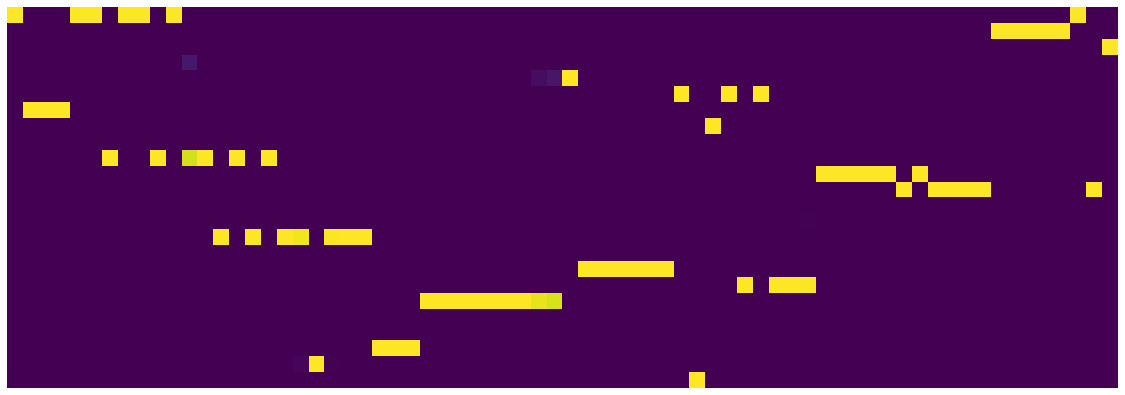

24 554 0.4449999999999995 0.40869556413963437


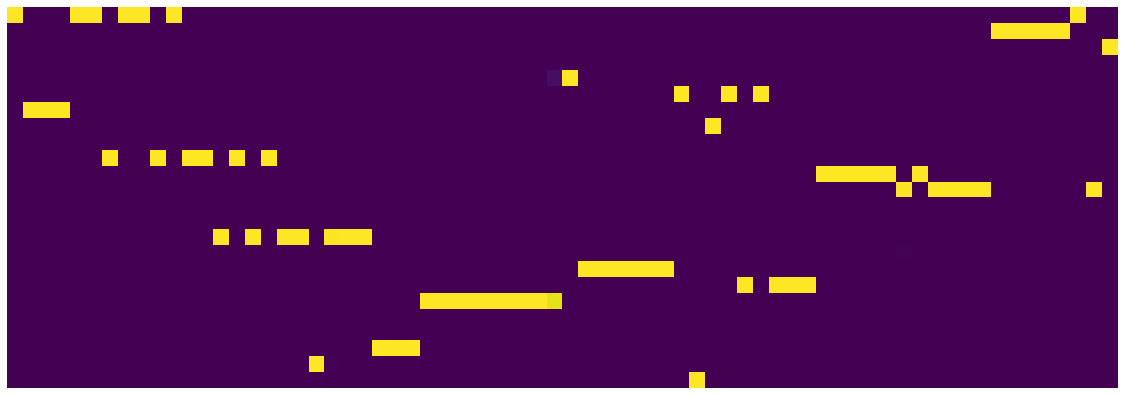

24 555 0.4439999999999995 0.42223682571202514


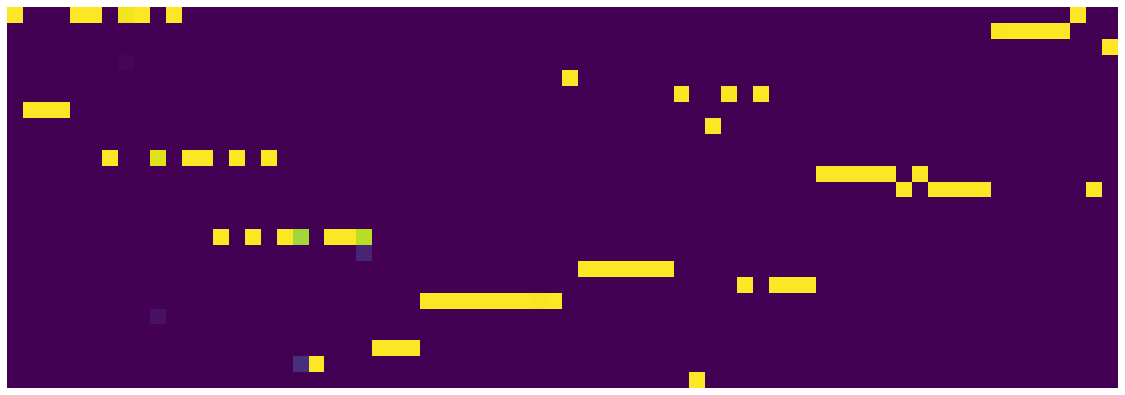

24 556 0.4429999999999995 0.41507880613207815


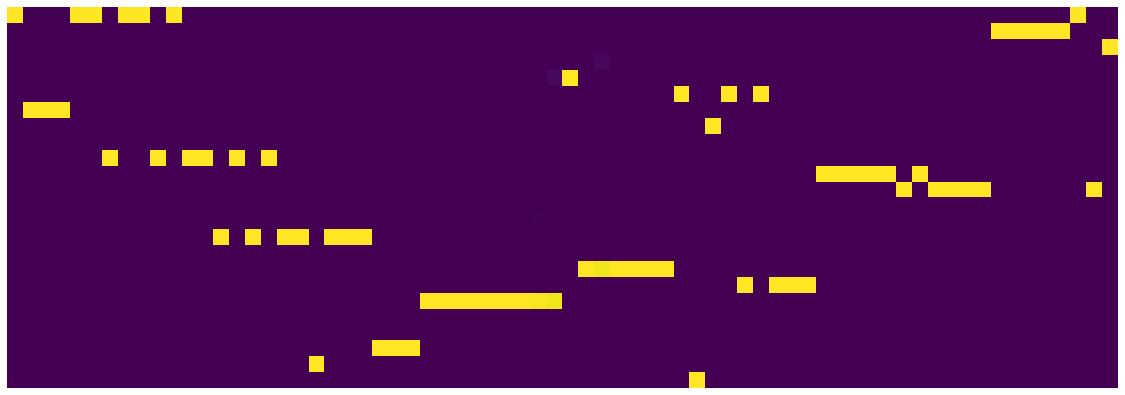

24 557 0.4419999999999995 0.407955305185169


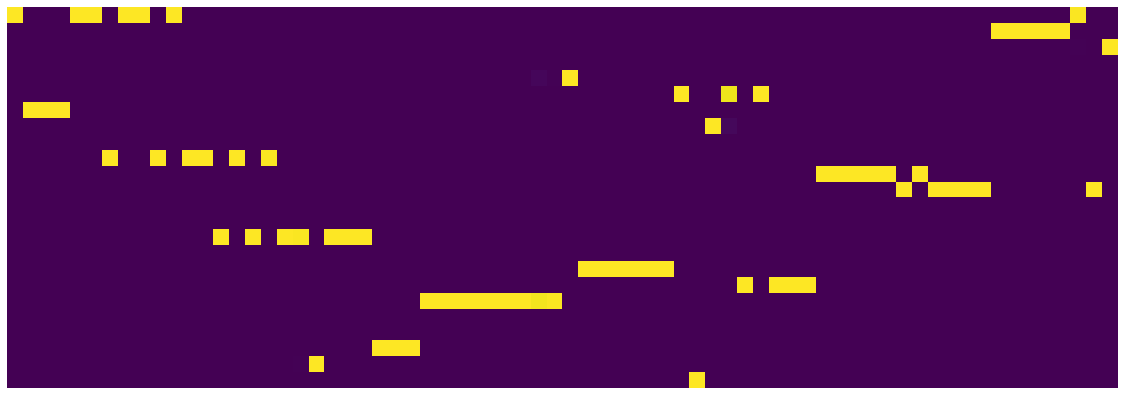

24 558 0.4409999999999995 0.41684331437572836


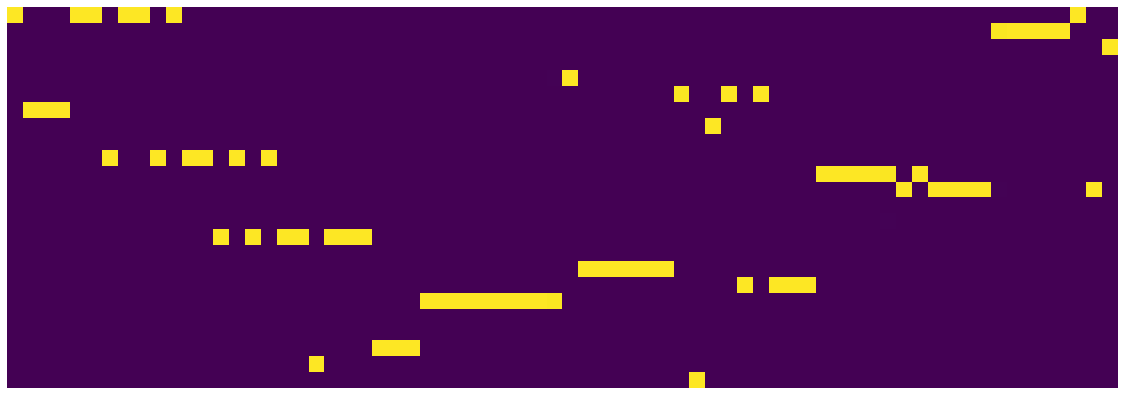

24 559 0.4399999999999995 0.4093261188827455


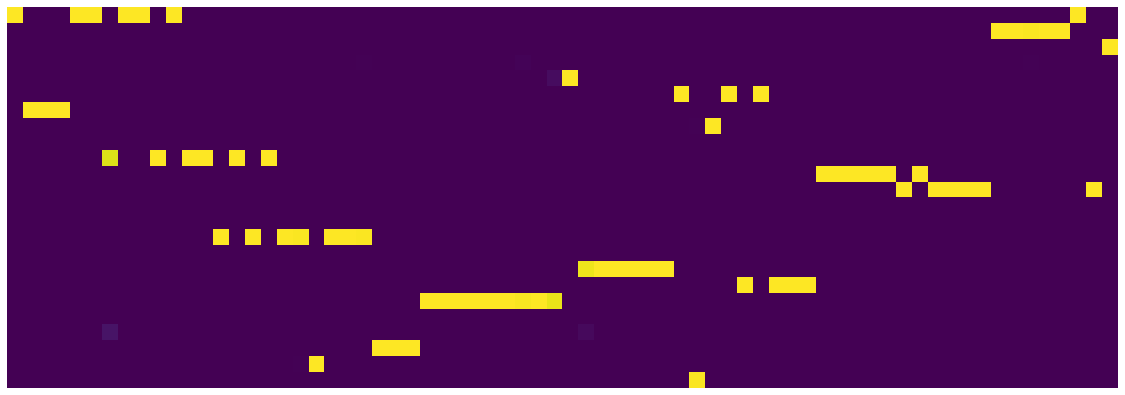

24 560 0.4389999999999995 0.41887417463585735


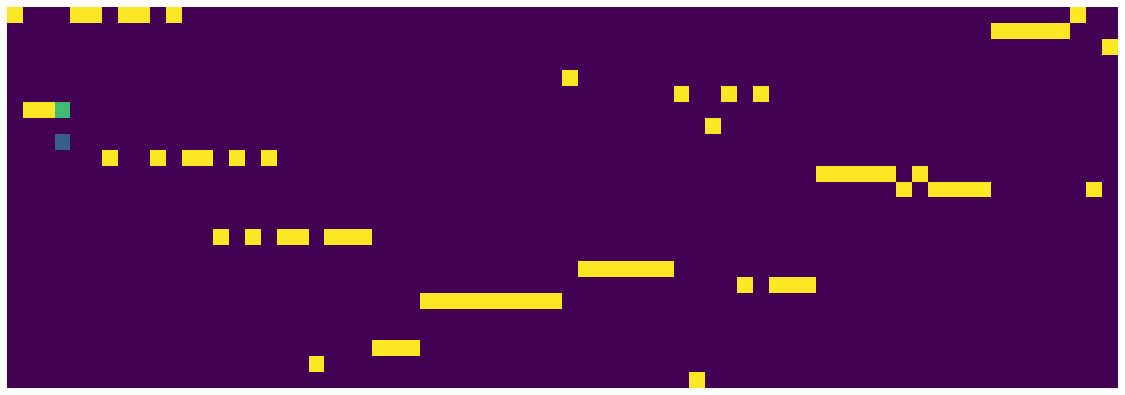

24 561 0.4379999999999995 0.42403112826868894


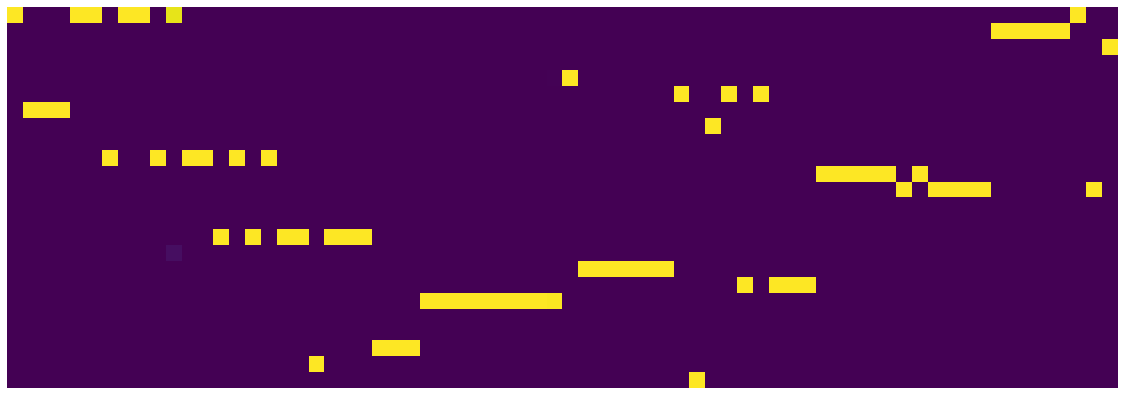

24 562 0.4369999999999995 0.41484469631686804


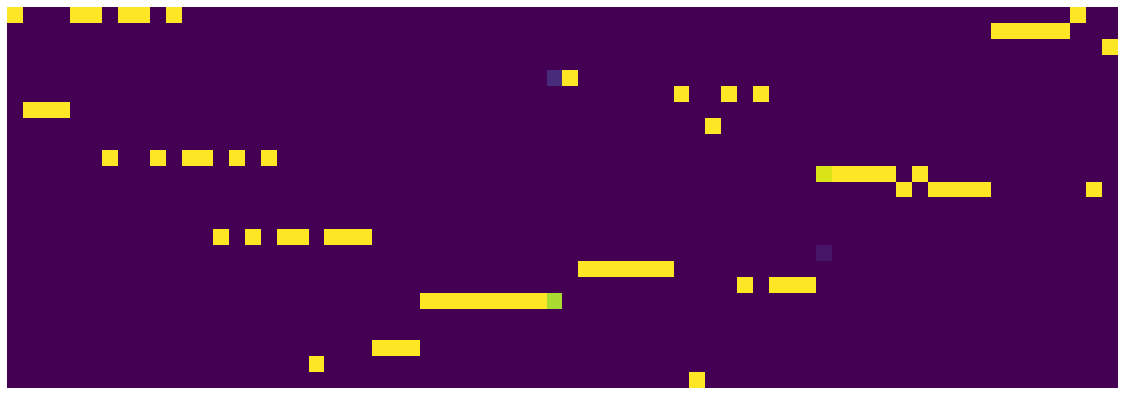

24 563 0.4359999999999995 0.4101910753175616


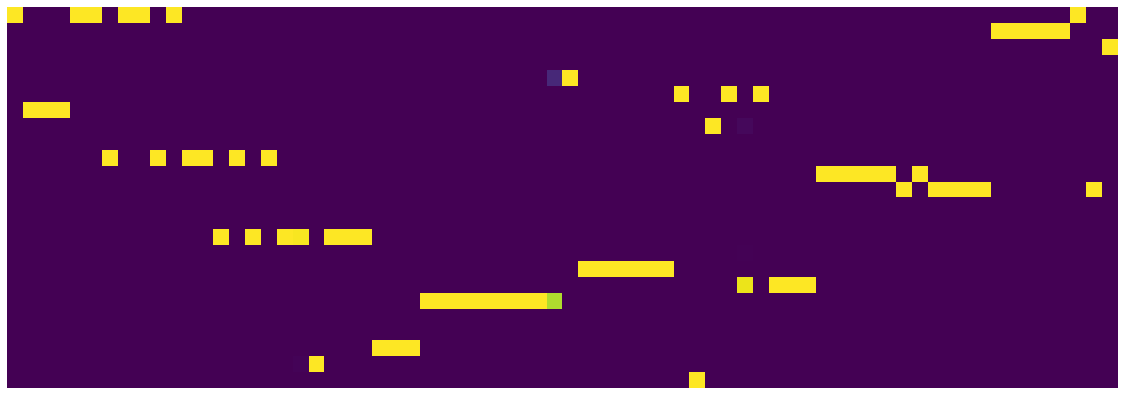

24 564 0.4349999999999995 0.4150025872513652


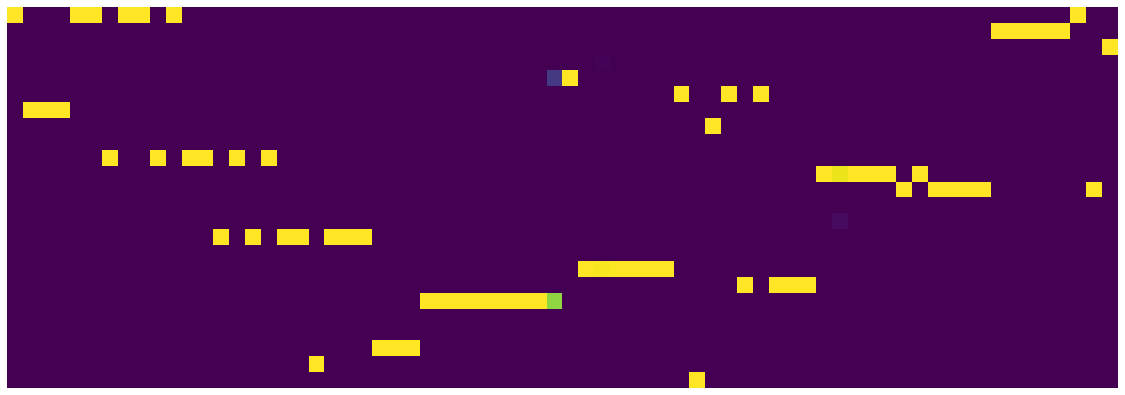

24 565 0.4339999999999995 0.41493374658748505


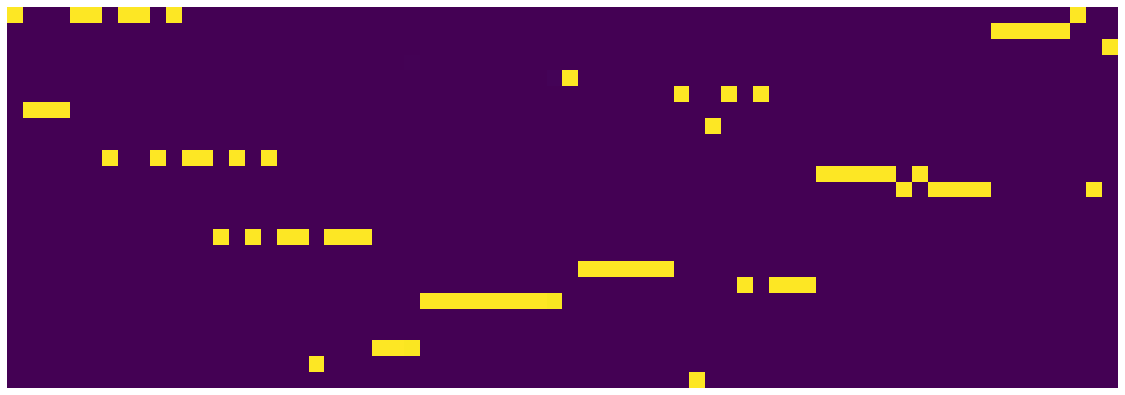

24 566 0.4329999999999995 0.4076093791052699


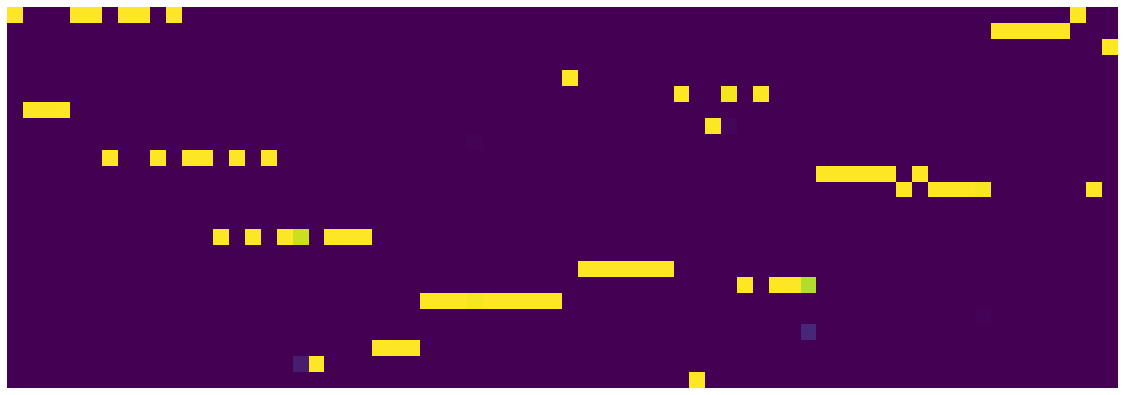

24 567 0.4319999999999995 0.41354193789884447


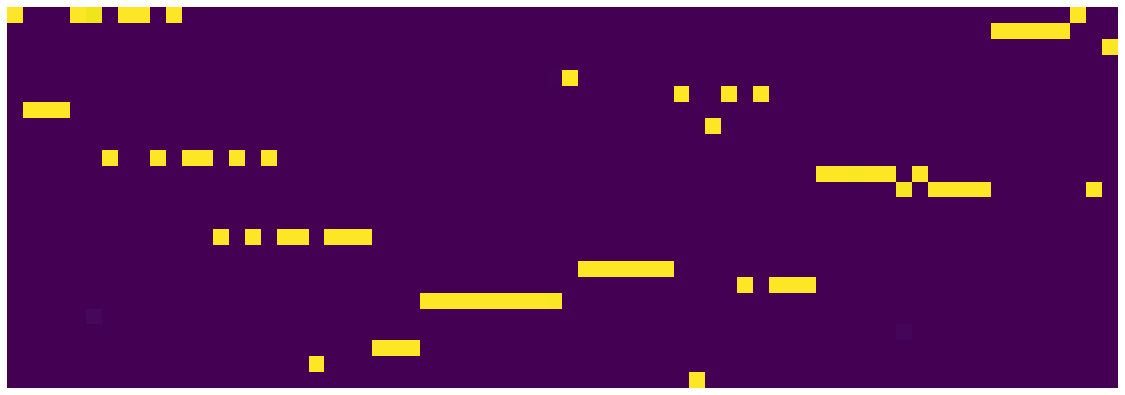

24 568 0.4309999999999995 0.4143699863925576


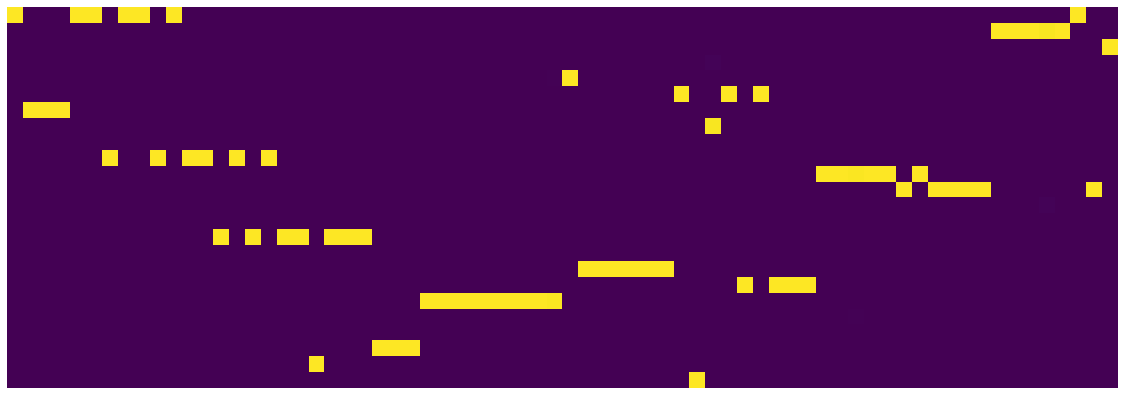

24 569 0.4299999999999995 0.41389403529465196


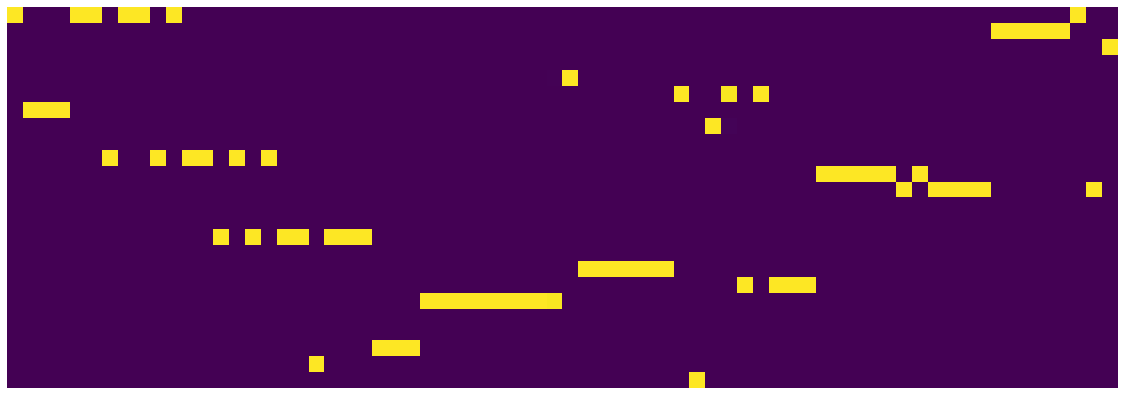

24 570 0.4289999999999995 0.4142847992479801


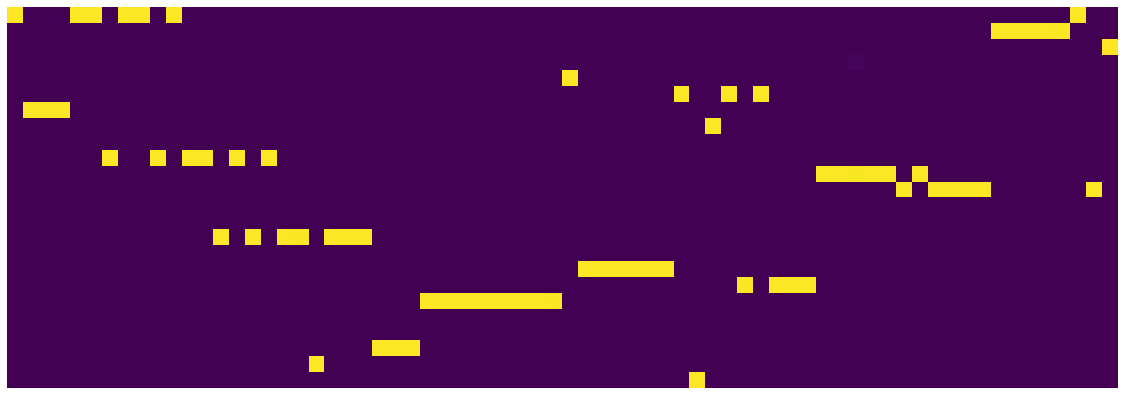

24 571 0.4279999999999995 0.40532004171982405


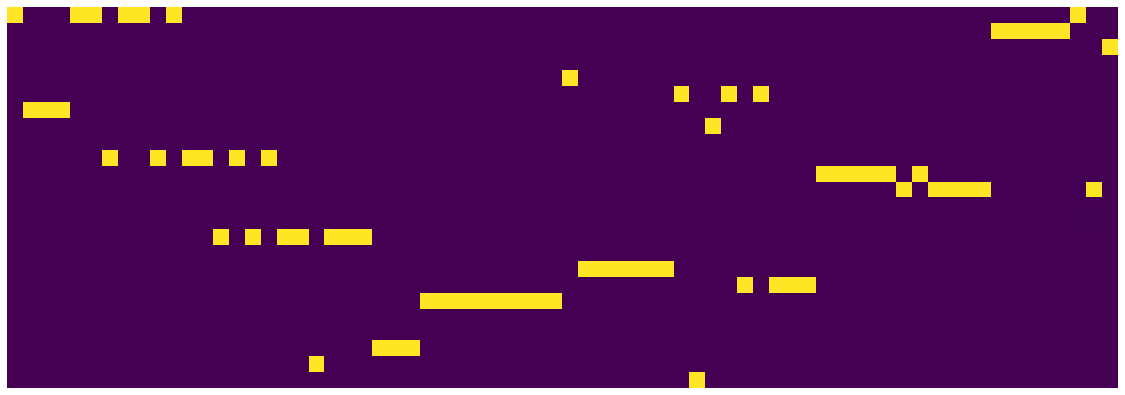

24 572 0.4269999999999995 0.4081040820106864


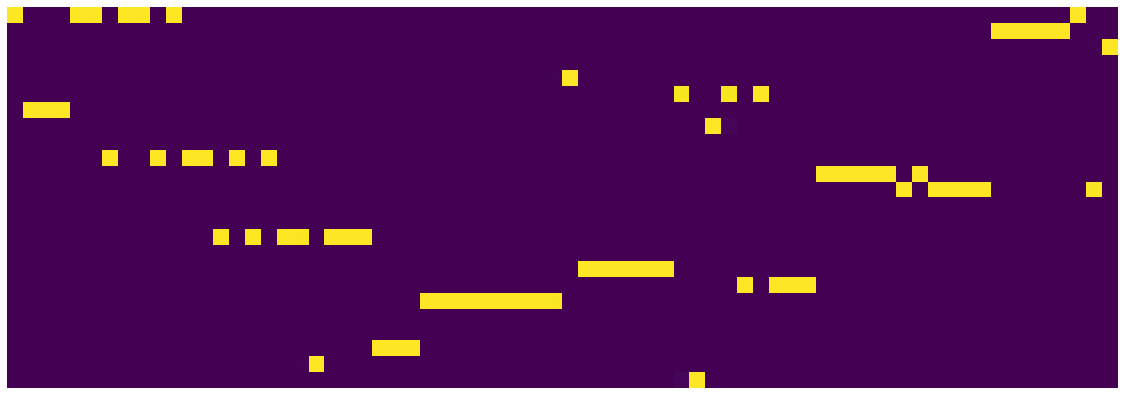

24 573 0.4259999999999995 0.43264878625050185


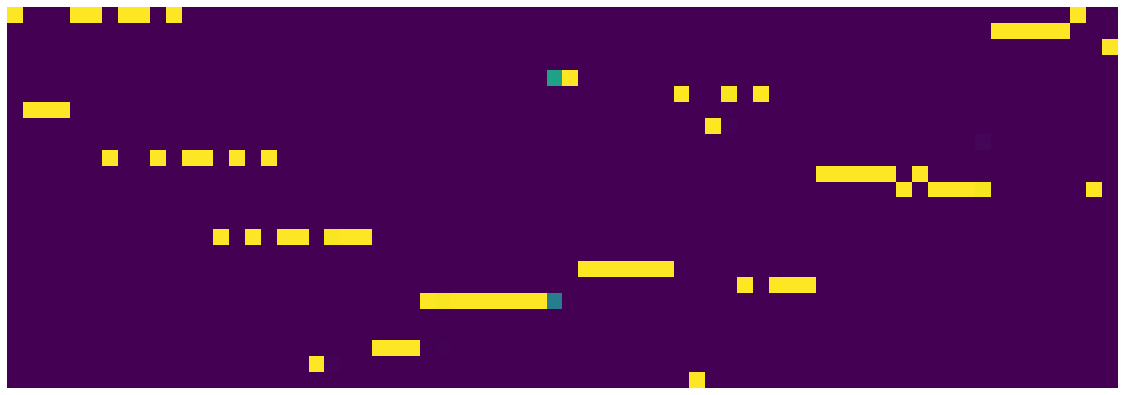

24 574 0.4249999999999995 0.4252930752001703


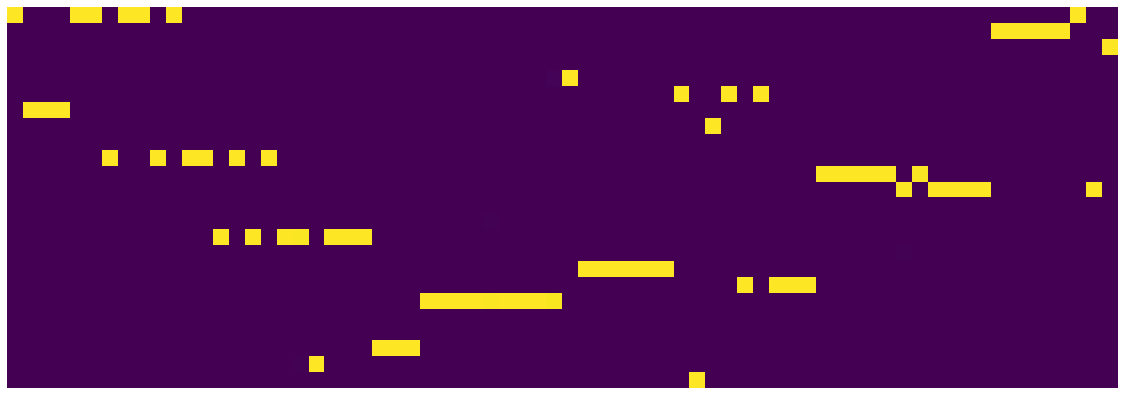

24 575 0.4239999999999995 0.4102808810770512


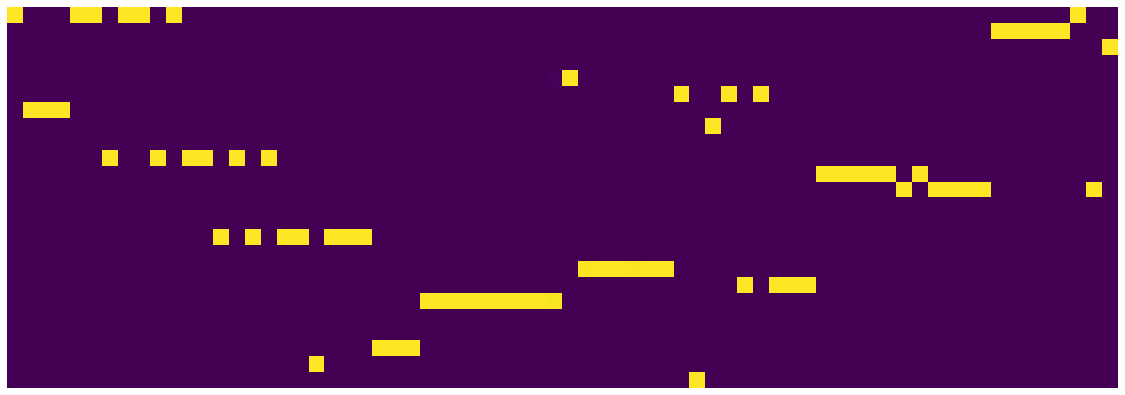

24 576 0.4229999999999995 0.4099027059040964


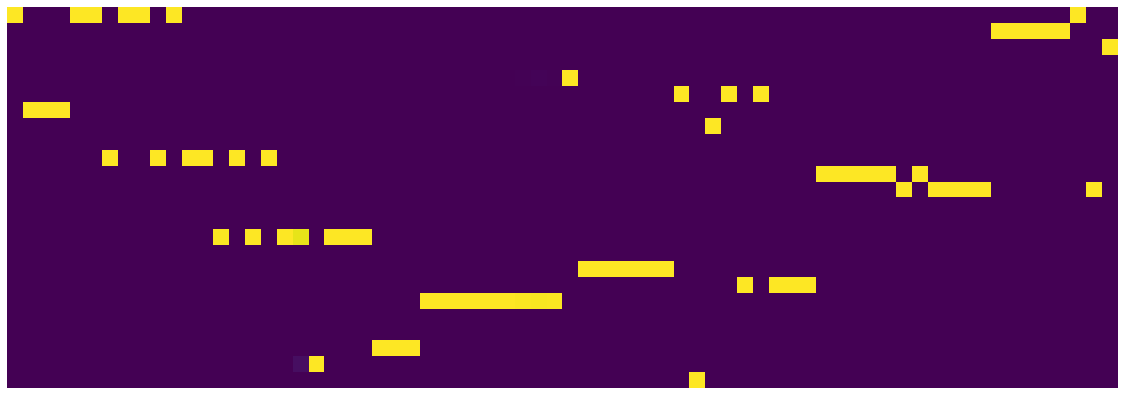

24 577 0.4219999999999995 0.41972986673936247


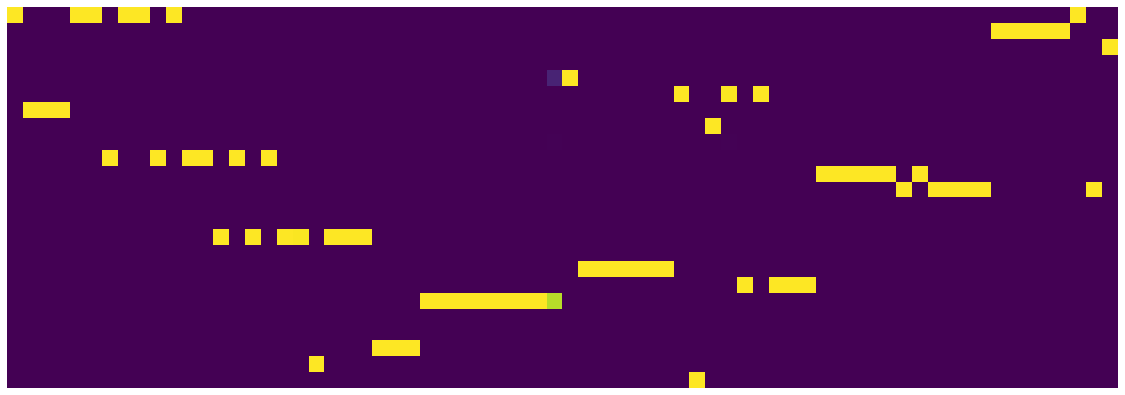

24 578 0.4209999999999995 0.4372637005522847


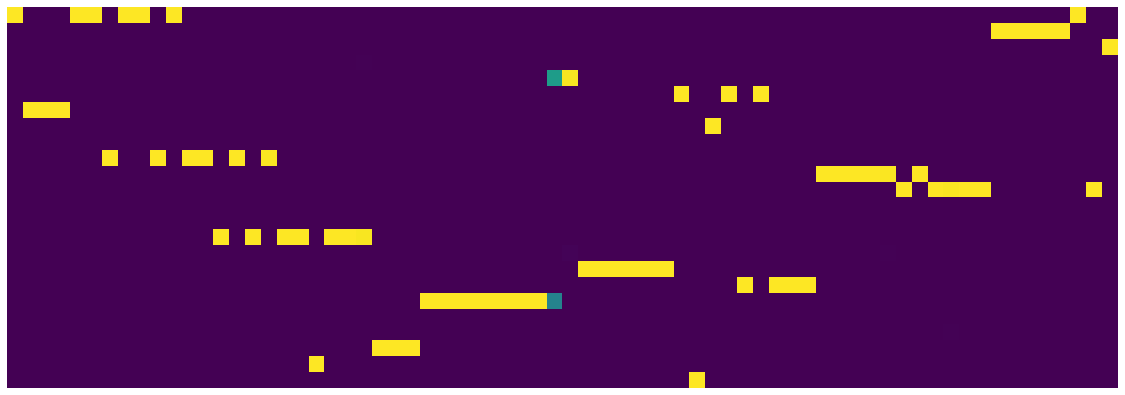

24 579 0.4199999999999995 0.40343801574781535


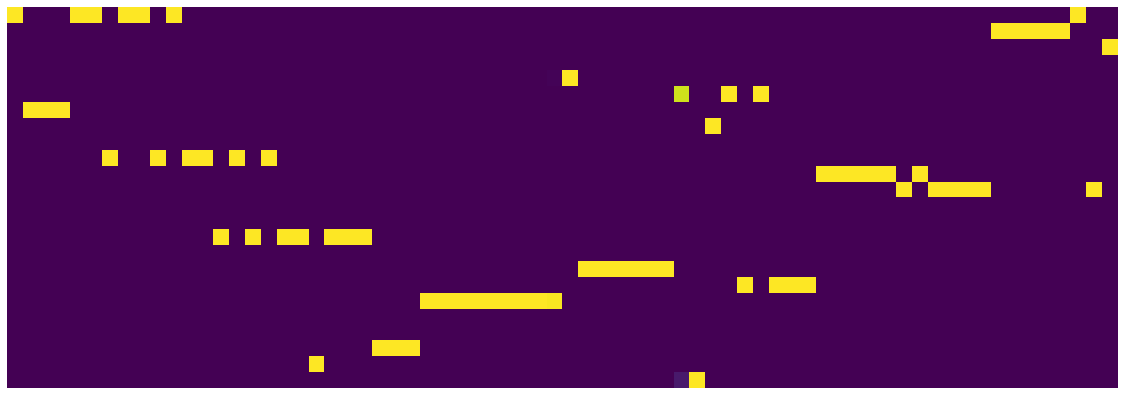

24 580 0.4189999999999995 0.4118505467660725


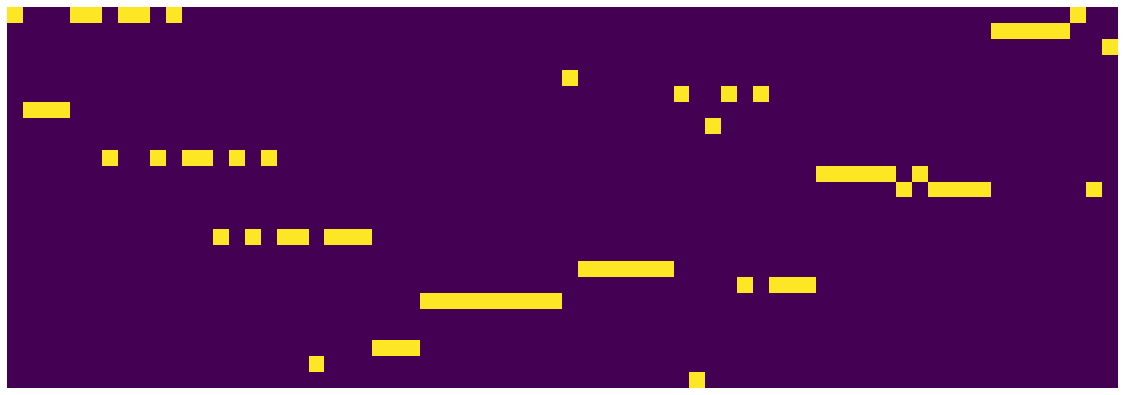

24 581 0.4179999999999995 0.4064070642925799


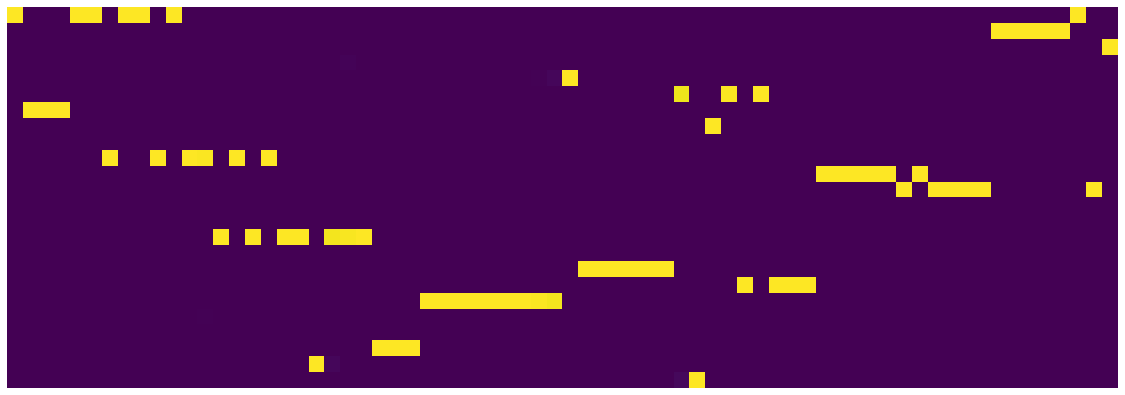

24 582 0.4169999999999995 0.4144485166296363


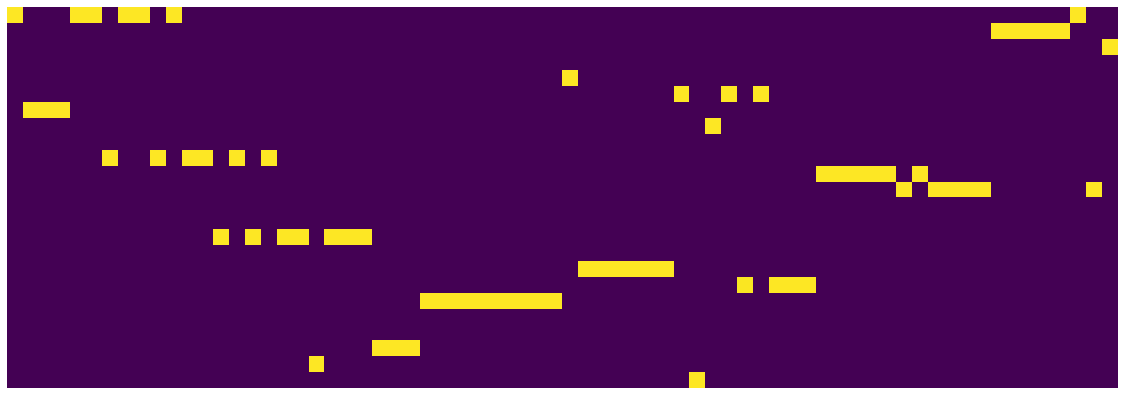

24 583 0.4159999999999995 0.4168703626841307


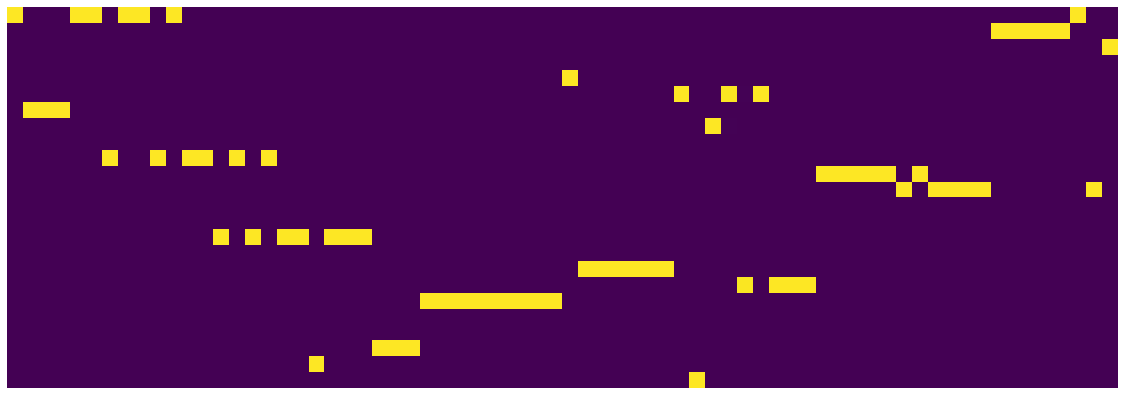

24 584 0.4149999999999995 0.4137301607988775


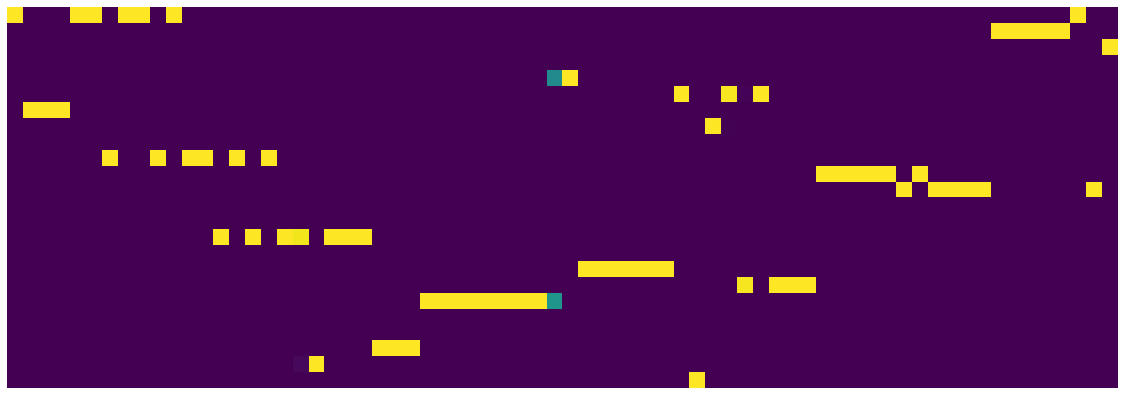

24 585 0.4139999999999995 0.40730597991496326


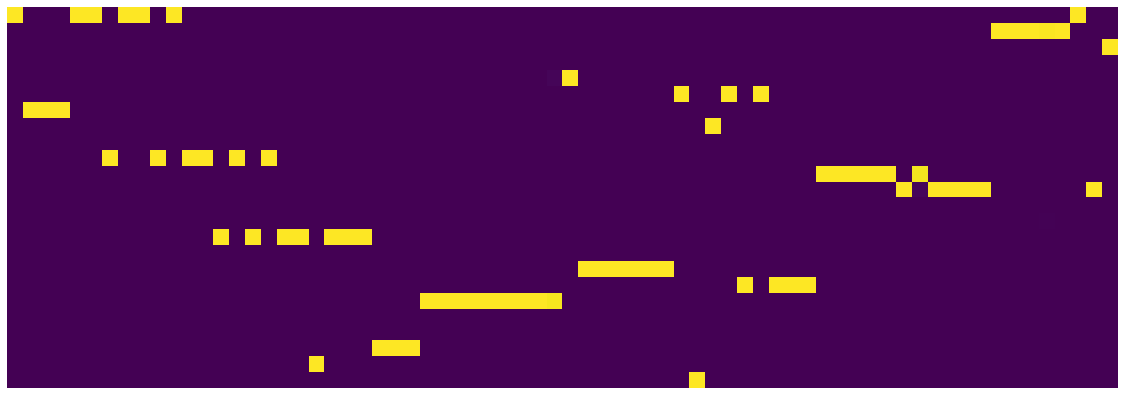

24 586 0.4129999999999995 0.4394592008553445


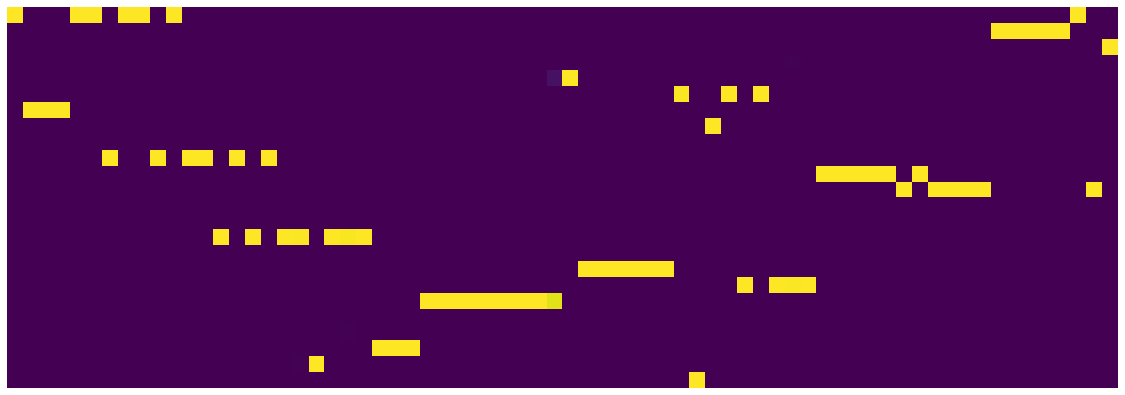

24 587 0.4119999999999995 0.4124345177784562


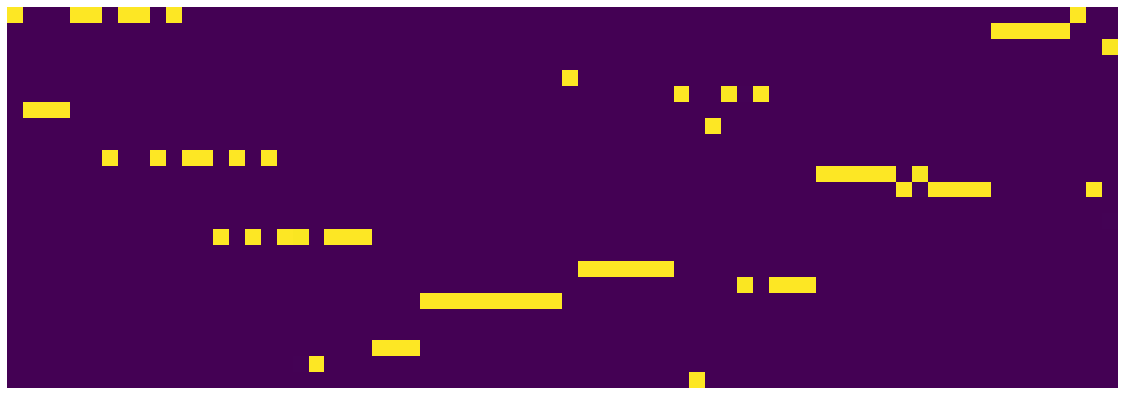

24 588 0.4109999999999995 0.4129677122458816


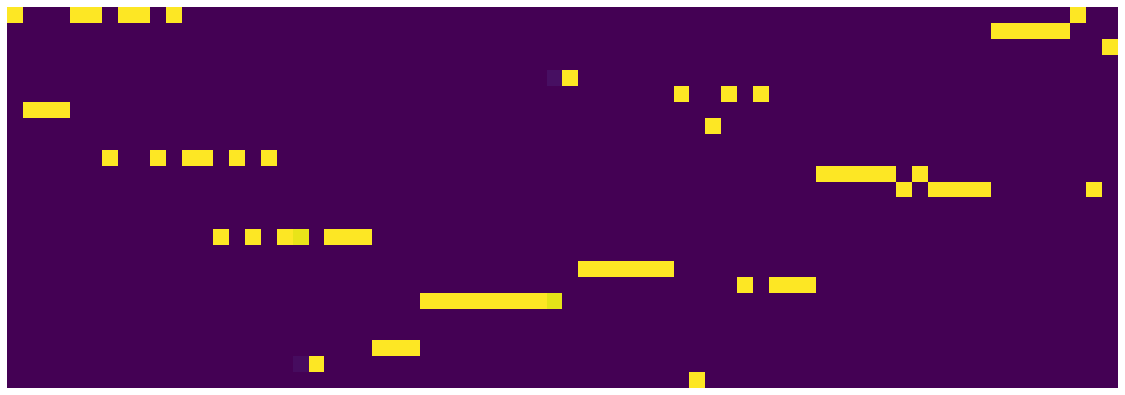

24 589 0.4099999999999995 0.408513477165252


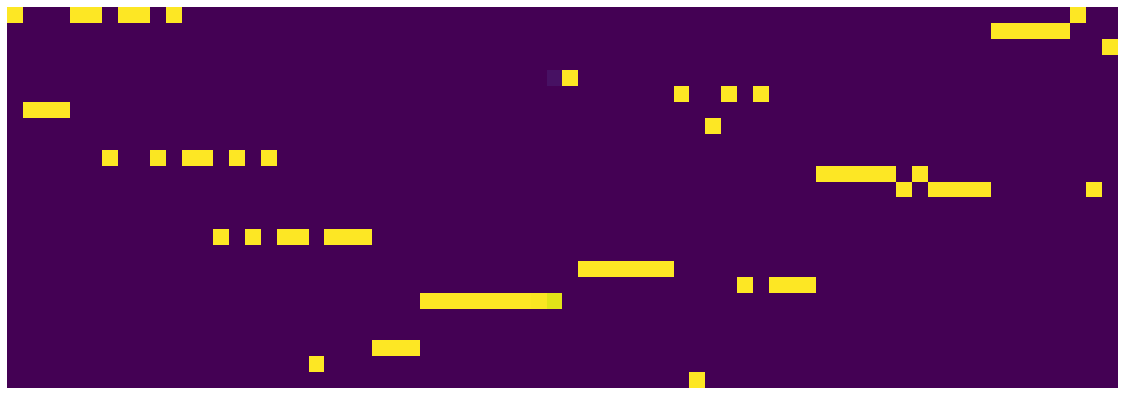

24 590 0.4089999999999995 0.4103377381339669


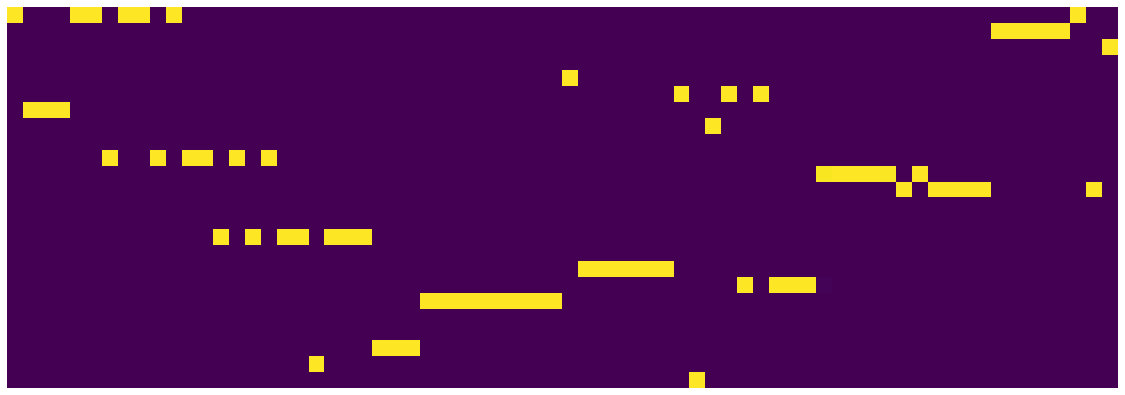

24 591 0.4079999999999995 0.41420761002227663


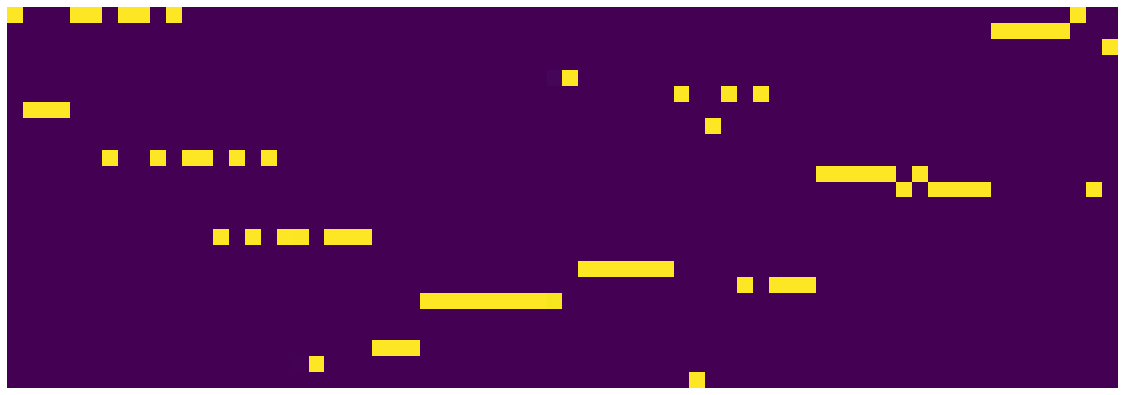

24 592 0.4069999999999995 0.42353738863021134


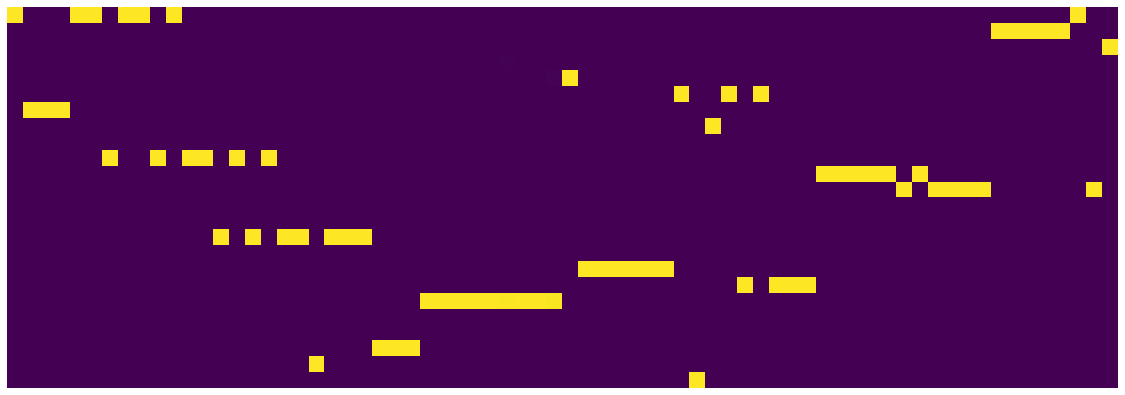

24 593 0.4059999999999995 0.40985762551426885


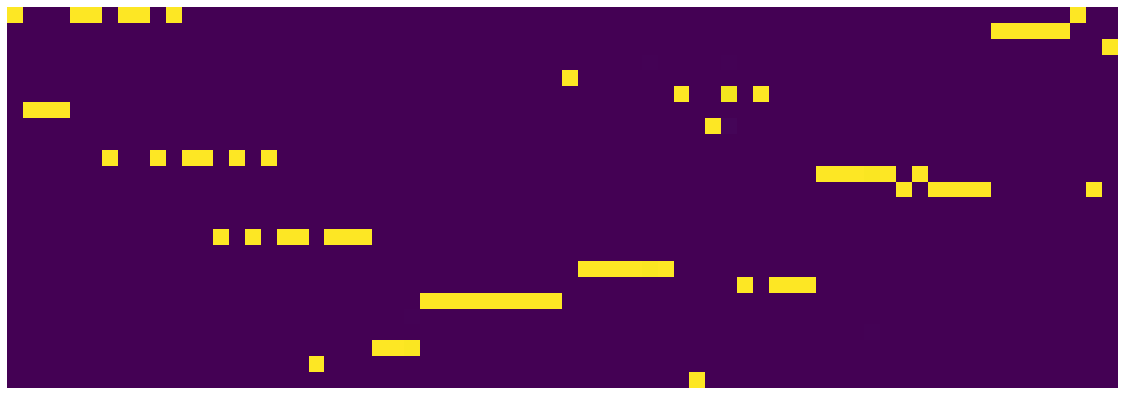

24 594 0.40499999999999947 0.41202110843732953


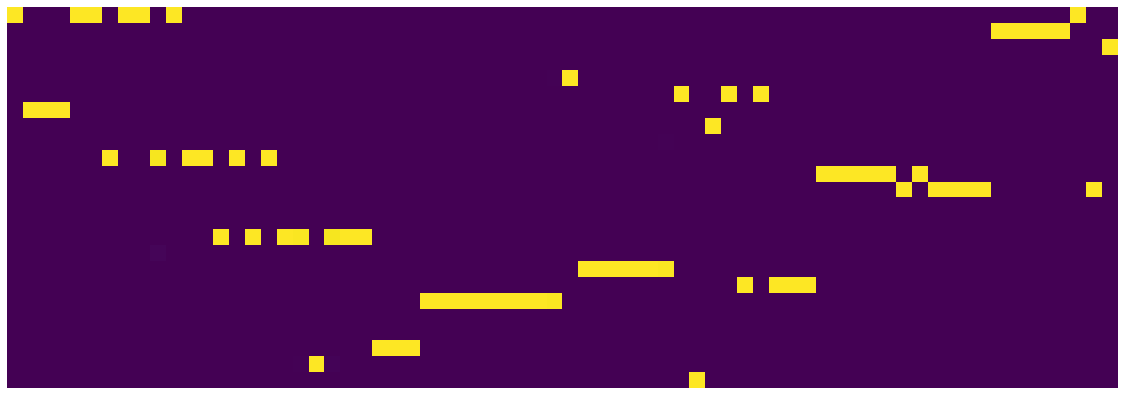

24 595 0.40399999999999947 0.42582944193854927


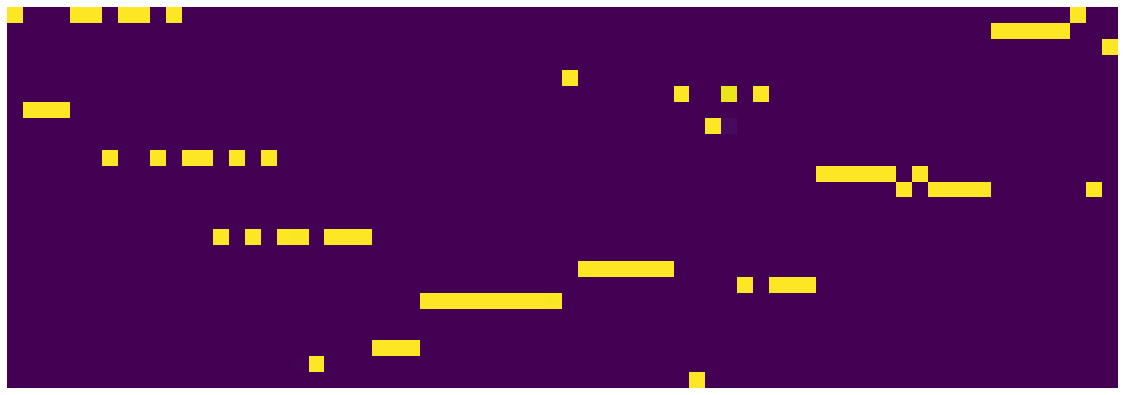

24 596 0.40299999999999947 0.41857347087934615


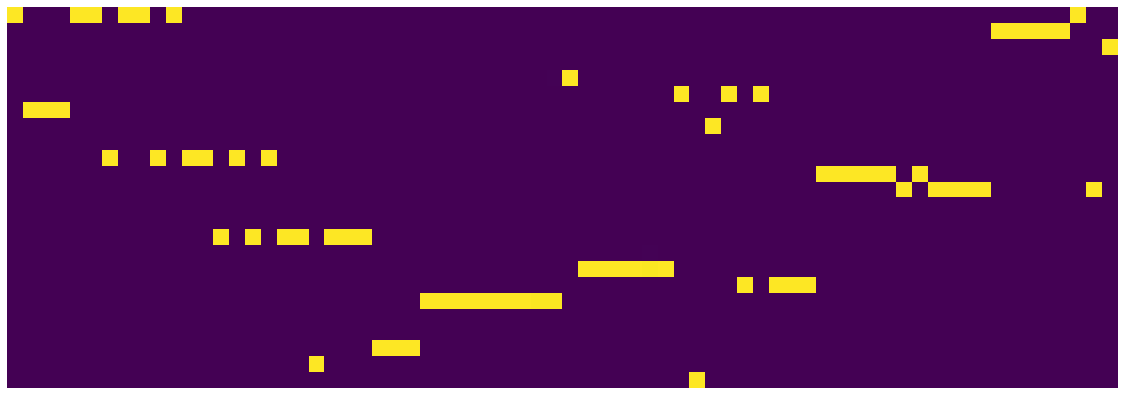

24 597 0.40199999999999947 0.4057396737858653


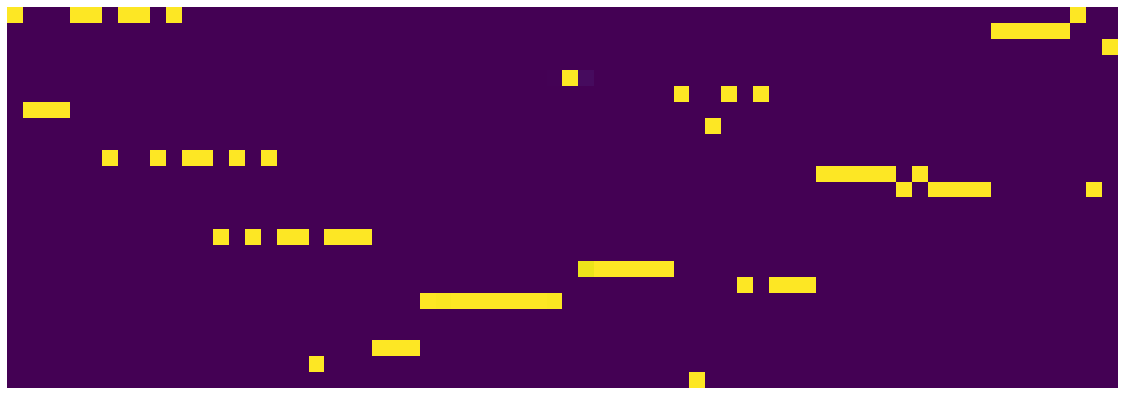

24 598 0.40099999999999947 0.4147544715553522


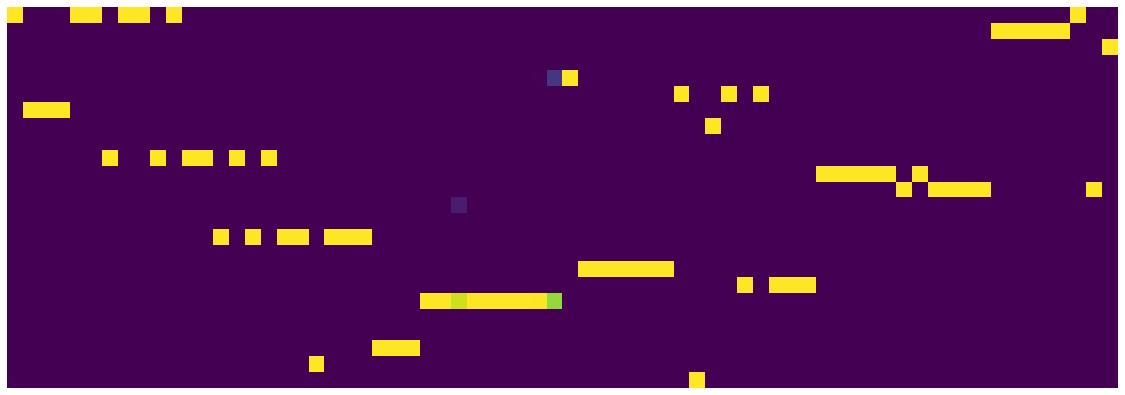

24 599 0.39999999999999947 0.4141981958411634


In [4]:
# Define the latent CG dimension, feel free to set your own, it only needs to be smaller than the number of total atoms 

device = "cuda" # device cardinal
#N_CG = [6, 12, 18, 24]  # play with this by yourself. 
#RHO = [1*10**(-5), 7*10**(-6), 1*10**(-6), 7*10**(-7)]
N_CG = [24]  # play with this by yourself. 
RHO = [1*10**(-7)]



for N_cg, rho in zip(N_CG, RHO):
    
    ae = cgae(train_xyz.shape[1], N_cg).to(device)
    optimizer = torch.optim.Adam(list(ae.parameters()), lr=4e-3)
    # training loop
    tau = 1.0

    loss_log = []
    loss_ae_log = []
    loss_fm_log = []
    mean_force_log =[]

    for epoch in range(600):

        loss_epoch = 0.0  
        loss_ae_epoch = 0.0
        loss_fm_epoch = 0.0
        mean_force_epoch = 0.0

        for i, xyz in enumerate(trainloader):

            # recenter xyz 
            xyz = xyz[0].to(device)

            # encode and decode coordinates 
            xyz, xyz_recon, M, M_norm, cg_xyz = ae(xyz, tau)
            
            
            #regularization instant forces
            f0 = torch.Tensor(train_f[i]).to(device)
            f  = torch.einsum('bij,in->bnj', f0, M_norm)
            mean_force = f.pow(2).sum(2).mean()

            # comput reconstruction 
            loss_ae =  (xyz - xyz_recon).pow(2).mean() 
            loss_fm = rho*mean_force


            # total loss 
            if epoch >= 300:
                loss = loss_ae + loss_fm
            else:
                loss = loss_ae

            
            #parameter update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #losses update
            loss_epoch += loss.item()
            loss_ae_epoch += loss_ae.item()
            loss_fm_epoch += loss_fm.item()
            mean_force_epoch += mean_force.item()

        #losses normalization
        loss_epoch = loss_epoch/xyz.shape[0]
        loss_ae_epoch = loss_ae_epoch/xyz.shape[0]
        loss_fm_epoch = loss_fm_epoch/xyz.shape[0]

        loss_log.append(loss_epoch)
        loss_ae_log.append(loss_ae_epoch)
        loss_fm_log.append(loss_fm_epoch)
        mean_force_log.append(mean_force_epoch)

        # temperature scheduler for gubmel softmax     
        if tau >= 0.1:
            tau -= 0.001
        
            
        #torch.save(M, 'LANGEVIN/M/M_CG'+str(N_cg)+'_i.pt')
            
        plt.figure(figsize=(16,8))
        plt.imshow(M.t().detach().cpu().numpy())
        plt.tight_layout()
        plt.axis('off')
        #plt.xlabel('Indice Atomi', fontsize = 18)
        #plt.ylabel('Indice Siti CG', fontsize = 18)
        #plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        #plt.tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=False)
        plt.savefig('NOSE_HOOVER/Images/M_CG'+str(N_cg)+'_'+str(epoch)+'.png')
        plt.show()
        
        print(N_cg ,epoch, tau, np.array(loss_epoch).mean())
        
    #save loss in txt
    #np.savetxt('LANGEVIN/Losses/loss_log_CG'+str(N_cg)+'.txt', loss_log)
    #np.savetxt('LANGEVIN/Losses/loss_ae_CG'+str(N_cg)+'.txt', loss_ae_log)
    #np.savetxt('LANGEVIN/Losses/loss_fm_CG'+str(N_cg)+'.txt', loss_fm_log)
    
    # visualize the learned CG assignment 
    #torch.save(M, 'LANGEVIN/M/M_CG'+str(N_cg)+'_f.pt')
    #torch.save(xyz_recon, 'LANGEVIN/xyz_recon/xyz_recon_CG'+str(N_cg)+'.pt')
    #torch.save(cg_xyz, 'LANGEVIN/xyz_CG/CG'+str(N_cg)+'_xyz.pt')
    
    #plt.figure(figsize=(18,20))
    #plt.imshow(M.t().detach().cpu().numpy())
    #plt.savefig('LANGEVIN/Images/M_CG'+str(N_cg)+'_f'+'.png')
    #plt.show()
    
    #save model
    #torch.save(ae, 'LANGEVIN/Models/ae_CG'+str(N_cg)+'.pth')
    
    

In [5]:
#Loss data import
loss_ae_CG6  = np.loadtxt('NOSE_HOOVER/Losses/loss_ae_CG6.txt')
loss_ae_CG12  = np.loadtxt('NOSE_HOOVER/Losses/loss_ae_CG12.txt')
loss_ae_CG18  = np.loadtxt('NOSE_HOOVER/Losses/loss_ae_CG18.txt')
loss_ae_CG24  = np.loadtxt('NOSE_HOOVER/Losses/loss_ae_CG24.txt')

loss_fm_CG6  = np.loadtxt('NOSE_HOOVER/Losses/loss_fm_CG6.txt')
loss_fm_CG12  = np.loadtxt('NOSE_HOOVER/Losses/loss_fm_CG12.txt')
loss_fm_CG18  = np.loadtxt('NOSE_HOOVER/Losses/loss_fm_CG18.txt')
loss_fm_CG24  = np.loadtxt('NOSE_HOOVER/Losses/loss_fm_CG24.txt')

loss_log_CG6  = np.loadtxt('NOSE_HOOVER/Losses/loss_log_CG6.txt')
loss_log_CG12  = np.loadtxt('NOSE_HOOVER/Losses/loss_log_CG12.txt')
loss_log_CG18  = np.loadtxt('NOSE_HOOVER/Losses/loss_log_CG18.txt')
loss_log_CG24  = np.loadtxt('NOSE_HOOVER/Losses/loss_log_CG24.txt')

In [6]:
loss_ae_CG = np.array([loss_ae_CG6[-1], loss_ae_CG12[-1], loss_ae_CG18[-1], loss_ae_CG24[-1],])
loss_fm_CG = np.array([loss_fm_CG6[-1], loss_fm_CG12[-1], loss_fm_CG18[-1], loss_fm_CG24[-1],])
loss_log_CG = np.array([loss_log_CG6[-1], loss_log_CG12[-1], loss_log_CG18[-1], loss_log_CG24[-1],])

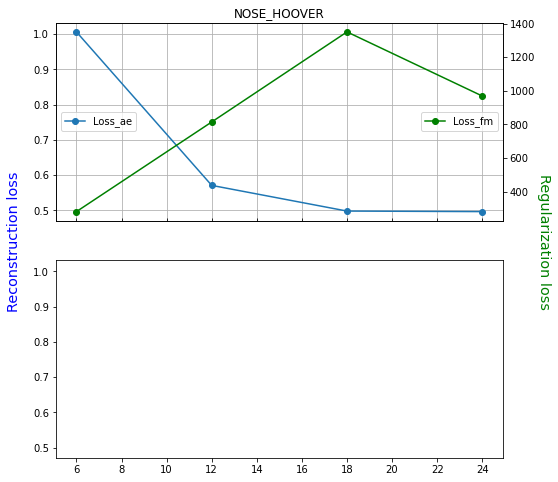

In [8]:
#plot losses
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8,8))
fig.text(0.04, 0.5, 'Reconstruction loss', va='center', rotation= 90, fontsize='x-large', color = 'blue')
fig.text(0.96, 0.5, 'Regularization loss', va='center', rotation=-90, fontsize='x-large', color = 'green')

axes[0].set_title('NOSE_HOOVER')
axes[0].plot(N_CG, loss_ae_CG, 'o-', label = 'Loss_ae')
#ax1.set_ylabel('Reconstruction loss')
axes[0].set_xticks(ticks=[6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26])
axes[0].tick_params(axis='x', direction='in')
axes[0].grid()
axes[0].legend(loc='center left')

axes0 = axes[0].twinx()
axes0.plot(N_CG, loss_fm_CG/RHO, 'o-', label = 'Loss_fm', color = 'green')
#ax1.set_ylabel('Reconstruction loss')
#axes0.set_xticks(ticks=[6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26])
axes0.tick_params(axis='x', direction='in')
#axes0.grid()
axes0.legend(loc='center right')
plt.show()

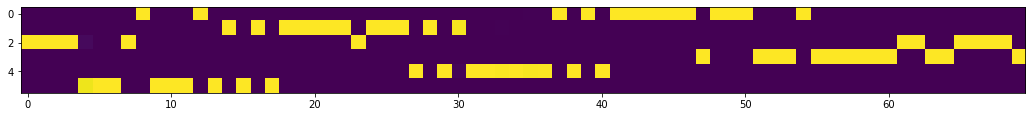

In [15]:
A = torch.load('M/M_CG6_f.pt')
plt.figure(figsize=(18,20))
plt.imshow(A.t().detach().cpu().numpy())

In [4]:
N_70 = torch.tensor(data)
N_70_original = N_70[0].detach().cpu().numpy()
polymer_ring = Atoms(positions= N_70_original, numbers=[2]*70)
show_ase(polymer_ring)

NGLWidget()

In [6]:
N_70_original.shape

(70, 3)

In [88]:
#saves the moleculs visualization
polymer_ring.write('provaR2.png',  rotation='10z,10x,10y')

In [13]:
N_70_recon = torch.load('NOSE_HOOVER/xyz_recon/xyz_recon_CG24.pt')
N_70_recon_d = N_70_recon[0].detach().cpu().numpy()
polymer_ring = Atoms(positions= N_70_recon_d, numbers=[2]*70)
show_ase(polymer_ring)

NGLWidget()

In [11]:
N_70_CG = torch.load('NOSE_HOOVER/xyz_CG/CG24_xyz.pt')
cg_nums = [2] * 24
cg_polymer_ring = Atoms(positions= N_70_CG[0].detach().cpu().numpy(), numbers=cg_nums)
show_ase(cg_polymer_ring)

NGLWidget()

In [53]:
N_70_CG.shape

torch.Size([40, 6, 3])